Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features

Version = "v36" # Add feature importance

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.3
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [8]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    target_rate *= (-0.001*target.sum()+1.1)

    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500, len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df

In [13]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            Threshold = y_preds.iloc[:, 1].median()
            
        logger.info(f"Threshold: {Threshold}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        percentile = y_prob.probability.quantile(0.3)
        high_conf_0 = min(y_prob.probability.min()*30, percentile)
        high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
        logger.info(f"30th percentile: {percentile:.5f}")
        
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 >= check: break
                Threshold -= 0.04
                if Threshold <= 0.2: break
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) <= check*1.5: break
                Threshold += 0.04
                if Threshold >= 0.95: break
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        logger.info(f"positive y_label:{sum(y)}/{len(y)}, y_label_rate: {sum(y)/len(y):.5f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, feature_importance_df

In [14]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [15]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.5,
    'subsample':0.8,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [16]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [17]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [18]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [19]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [20]:
train['WHERE'], test['WHERE'] = 'train', 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [21]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
25     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
40     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741   
47     id_008a986b7        0        1        1  0.4860  0.1430  0.5281   
63     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864   
...             ...      ...      ...      ...     ...     ...     ...   
23729  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453   
23747  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880   
23768  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648   
23793  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319   
23811  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
25    -0.6226 -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573   
38     0.3054 -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319   
40     1.5440 -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636   
47    -0.0022 -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694   
63     0.3196  0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
23729  0.3521  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074   
23747 -0.6573 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224   
23768 -0.0525 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951   
23793 -0.8782  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504   
23811 -0.7389  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422   

         c-96    c-97    c-98    c-99  WHERE  
25     0.8837  0.5534  0.8976  1.0050  train  
38     0.2187  0.0737  0.6498 -1.4820  train  
40    -0.5751  0.3362  0.8543  0.9180  train  
47    -0.4979  0.5281 -0.9245 -0.9367  train  
63     0.0949  0.2000 -0.4326  0.9364  train  
...       ...     ...     ...     ...    ...  
23729  0.2131 -0.1419 -0.2422  0.0457  train  
23747 -0.9630  0.8872 -0.0742 -0.6777  train  
23768  0.9517 -0.8110 -0.1748 -0.3626  train  
23793  0.8813  0.7757 -0.5272  0.7082  train  
23811  0.2256  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [22]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [23]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [24]:
# clipping
clipping = data_df.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [25]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()

In [26]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]
g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [27]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
#scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)
size = len(data[col].values)

for col in tqdm(data.columns[4:]):
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose       g-0       g-1       g-2  \
0      id_000644bb2        1        0        0  1.148287  0.902172 -0.417928   
5      id_001762a82        1        0        0 -0.879040  0.503594 -1.413294   
36     id_00762e877        1        0        0 -0.562491  0.307864 -0.942525   
38     id_0079af0fb        0        0        0 -0.212691 -1.987260 -0.789127   
39     id_0079d45d3        1        0        0  1.403347 -2.256745 -0.215305   
...             ...      ...      ...      ...       ...       ...       ...   
27754  id_fca887f42        1        1        1 -0.581502 -0.003006 -1.393118   
27759  id_fce497048        1        1        1  0.869846 -0.382007 -0.107087   
27768  id_fd75349b2        1        1        1 -0.086674  0.730381 -0.292794   
27784  id_fed0f2fe0        1        1        1 -1.565955  1.175328  0.311021   
27794  id_ffbb869f2        1        1        1 -1.604154 -1.948458 -0.618458   

            g-3       g-4       g-5  ...   df_c-90   df_c-91   df_c-92  \
0     -0.961828 -0.255198 -1.021257  ... -1.810818 -1.556684  0.248606   
5      0.341493  1.394215  0.689482  ...  1.204512  0.578443  1.006571   
36    -0.689600 -0.864799 -0.296645  ...  0.722254 -0.057595 -0.552164   
38     0.454438 -1.449170  0.788455  ...  0.374101  0.776318  0.609079   
39    -1.705570  0.702315 -0.099747  ...  1.545960  1.713131  1.361963   
...         ...       ...       ...  ...       ...       ...       ...   
27754  1.064679 -0.242204  0.493547  ... -0.147978  0.572841 -1.187832   
27759 -1.994971  0.899984 -1.345144  ...  1.145838  0.589930  1.501425   
27768  1.511185 -0.838697  0.104717  ... -1.310017 -1.616881 -0.099856   
27784 -1.040743  0.262887 -1.417591  ...  0.949547  0.513294 -0.572693   
27794  1.328615 -1.630593 -0.262848  ... -1.093272  0.292672  0.617046   

        df_c-93   df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0     -1.083179  0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      1.139912  0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.559241 -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38     0.186897 -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.543328  1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...       ...  
27754 -0.046089 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  0.751316  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.290319  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.836947  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794  0.026101 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [28]:
def reduce_mem_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'start size: {start_mem:5.2f} Mb')
    
    for col in tqdm(df.columns):
        df = calc_mem(df, col)
    
    end_mem = df.memory_usage().sum() / 1024**2
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({reduction:.1f}% reduction)')
    
    return df

In [29]:
def calc_mem(df, col):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_type = df[col].dtypes
    
    if col_type in numerics:
        c_min, c_max = df[col].min(), df[col].max()
        
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
                
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    
    return df

In [30]:
data.iloc[:, 4:] = reduce_mem_usage(data.iloc[:, 4:]).values
std_df = data.iloc[:, 4:].copy()

start size: 554.98 Mb



Mem. usage decreased to 138.90 Mb (75.0% reduction)


In [31]:
data_df.cp_type = data_df.cp_type.astype('int16')
data_df.cp_time = data_df.cp_time.astype('int16')
data_df.cp_dose = data_df.cp_dose.astype('int16')

In [32]:
from sklearn.cluster import KMeans

def create_cluster(data, features, kind, n_clusters):
    data_ = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data_)
    data[f'clusters_{kind}'] = kmeans.labels_[:data.shape[0]]
 
    return data


def detect_cluster(data, feature_list, kind_list):
    for idx, feature in enumerate(tqdm(feature_list)):
        if "g" in kind_list[idx]:
            n_clusters = 36
        else:
            n_clusters = 6
        
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    return clusters

In [33]:
feature_list = (g_list, c_list, d_g_list, d_c_list, df_g_list, df_c_list, g_all_list, c_all_list)
kind_list = ('g', 'c', 'd_g', 'd_c', 'df_g', 'df_c', 'g_all', 'c_all')


clusters = detect_cluster(data, feature_list, kind_list)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               9           1             0             3              5   
5              35           2             0             2             18   
36             26           5             0             3              6   
38              2           5            15             3             12   
39             17           3            21             5             16   
...           ...         ...           ...           ...            ...   
27754          23           5            11             2              8   
27759          29           3            26             4             15   
27768          33           5            20             2              5   
27784          16           0            11             1             21   
27794           4           5            20             2              4   

       clusters_df_c  clusters_g_all  clusters_c_all  
0                  0               4               2  
5                  3              22               0  
36                 0              22               2  
38                 2              22               2  
39                 5              30               5  
...              ...             ...             ...  
27754              2              18               2  
27759              5              28               5  
27768              2              35               2  
27784              3               6               1  
27794              0              12               2  

[27796 rows x 8 columns]

In [34]:
def fe_stats(df, features, kind):
    df_ = df.copy()
    
    df_[f'{kind}_max'] = df_[features].max(axis = 1)
    df_[f'{kind}_min'] = df_[features].min(axis = 1)
    df_[f'{kind}_sum'] = df_[features].sum(axis = 1)
    df_[f'{kind}_mean'] = df_[features].mean(axis = 1)
    df_[f'{kind}_median'] = df_[features].median(axis = 1)
    df_[f'{kind}_mad'] = df_[features].mad(axis = 1)
    df_[f'{kind}_std'] = df_[features].std(axis = 1)
    df_[f'{kind}_kurt'] = df_[features].kurtosis(axis = 1)
    df_[f'{kind}_skew'] = df_[features].skew(axis = 1)

    return df_

def detect_stats(data, feature_list, kind_list):
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -9*len(feature_list):].copy()
    return stats

In [35]:
stats = detect_stats(data, feature_list, kind_list)
stats

g_max     g_min      g_sum    g_mean  g_median     g_mad     g_std  \
0      5.199219 -5.199219 -19.212489 -0.024887 -0.040314  0.720118  0.955564   
5      5.199219 -5.199219  54.353352  0.070406  0.079773  0.718143  0.942488   
36     5.199219 -5.199219  -3.348235 -0.004337 -0.020729  0.725192  0.971103   
38     5.199219 -5.199219  30.465306  0.039463  0.024773  0.780396  0.971975   
39     5.199219 -5.199219  11.024891  0.014281  0.099060  1.532658  1.949147   
...         ...       ...        ...       ...       ...       ...       ...   
27754  2.257812 -2.224609 -32.762808 -0.042439 -0.034332  0.669577  0.803621   
27759  5.199219 -5.199219 -43.204510 -0.055964 -0.074951  1.330668  1.708879   
27768  5.199219 -5.199219 -10.746361 -0.013920 -0.041824  0.893164  1.167734   
27784  5.199219 -5.199219 -16.096722 -0.020851 -0.038055  0.773436  1.006712   
27794  5.199219 -5.199219  98.474113  0.127557  0.269287  0.822592  1.023052   

         g_kurt    g_skew     c_max  ...  g_all_skew  c_all_max  c_all_min  \
0      5.338951 -0.691411  2.203125  ...   -0.888910   2.203125  -5.199219   
5      4.550795  0.522619  5.199219  ...   -0.548240   5.199219  -5.199219   
36     5.944584  0.169484  1.616211  ...   -0.250120   1.616211  -5.199219   
38     2.090963 -0.166692  1.817383  ...   -0.811386   1.817383  -5.199219   
39     1.154552 -0.135939 -0.579590  ...   -0.125360   1.898438  -1.870117   
...         ...       ...       ...  ...         ...        ...        ...   
27754 -0.565652 -0.042772  2.080078  ...   -1.072241   2.080078  -5.199219   
27759  1.880766  0.142684  1.408203  ...   -0.168247   5.199219  -2.179688   
27768  3.848572  0.369195  2.035156  ...   -0.122948   2.035156  -5.199219   
27784  4.200632  0.737923  1.529297  ...   -0.179166   2.089844  -5.199219   
27794  1.604347 -0.448707  1.556641  ...   -0.723807   1.556641  -5.199219   

        c_all_sum  c_all_mean  c_all_median  c_all_mad  c_all_std  c_all_kurt  \
0      -62.118792   -0.207063     -0.173218   0.714560   0.981586    5.424930   
5      215.166496    0.717222      0.581299   0.923776   1.400999    4.295103   
36     -84.577841   -0.281926     -0.222595   0.694764   0.999633    7.874484   
38    -107.649048   -0.358830     -0.314819   0.667602   0.874671    5.038273   
39      98.405838    0.328019      0.961182   1.242028   1.352060   -1.512296   
...           ...         ...           ...        ...        ...         ...   
27754  -44.674929   -0.148916     -0.051971   0.684360   0.931652    7.211452   
27759   99.252411    0.330841      0.794189   1.150676   1.296122   -0.867019   
27768  -23.286763   -0.077623      0.026787   0.776570   1.095169    7.536212   
27784   11.924219    0.039747      0.221497   0.774133   0.913383    2.111061   
27794  -51.926172   -0.173087     -0.110138   0.596762   0.787349    4.790034   

       c_all_skew  
0       -1.156468  
5        1.276031  
36      -1.865939  
38      -1.063810  
39      -0.553439  
...           ...  
27754   -1.507237  
27759   -0.273458  
27768   -1.941173  
27784   -0.726874  
27794   -1.002405  

[27796 rows x 72 columns]

In [36]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           9           1   
5      id_001762a82        1        0        0          35           2   
36     id_00762e877        1        0        0          26           5   
38     id_0079af0fb        0        0        0           2           5   
39     id_0079d45d3        1        0        0          17           3   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1          23           5   
27759  id_fce497048        1        1        1          29           3   
27768  id_fd75349b2        1        1        1          33           5   
27784  id_fed0f2fe0        1        1        1          16           0   
27794  id_ffbb869f2        1        1        1           4           5   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 0             3              5              0  ...   
5                 0             2             18              3  ...   
36                0             3              6              0  ...   
38               15             3             12              2  ...   
39               21             5             16              5  ...   
...             ...           ...            ...            ...  ...   
27754            11             2              8              2  ...   
27759            26             4             15              5  ...   
27768            20             2              5              2  ...   
27784            11             1             21              3  ...   
27794            20             2              4              0  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810547 -1.556641  0.248657 -1.083008  0.184082 -0.422852  0.452881   
5      1.204102  0.578613  1.006836  1.139648  0.620117 -1.168945  0.544434   
36     0.722168 -0.057587 -0.552246 -0.559082 -0.181396 -0.197754 -0.918945   
38     0.374023  0.776367  0.608887  0.186890 -1.234375 -0.059998 -0.958008   
39     1.545898  1.712891  1.362305  1.542969  1.492188  1.588867  1.517578   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147949  0.572754 -1.187500 -0.046082 -0.472168  0.185669 -0.600586   
27759  1.145508  0.589844  1.500977  0.751465  1.638672  1.134766  1.458984   
27768 -1.309570 -1.617188 -0.099854  0.290283  0.222412  0.772461 -0.884277   
27784  0.949707  0.513184 -0.572754  0.836914  0.502441  1.305664  1.237305   
27794 -1.093750  0.292725  0.617188  0.026108 -1.747070 -1.243164 -0.207642   

        df_c-97   df_c-98   df_c-99  
0     -1.087891 -1.717773 -1.652344  
5     -1.732422 -0.122742  0.767090  
36     0.003370 -1.947266 -1.204102  
38    -0.570312 -0.453125  1.387695  
39     1.513672  1.721680  0.753906  
...         ...       ...       ...  
27754  0.372070 -1.537109  0.434082  
27759  1.082031  1.356445  1.248047  
27768 -1.473633  1.308594  0.237427  
27784  1.021484  0.945801  1.153320  
27794 -0.742676 -0.091736 -0.628418  

[27796 rows x 2700 columns]

In [37]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df


#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

In [38]:
# Create feature based on feature importance with v24 notebook

#important_col = []
#tmp = CreateFeat(data[important_col])
#data = pd.concat([data, tmp], axis=1)


# Create feature based on feature importance with v24 notebook
#tmp = CreateFeat2(data[important_col])
#data = pd.concat([data, tmp], axis=1)

#remove dup colunes
#data = data.loc[:,~data.columns.duplicated()]
#tmp = ReduceCol(data.iloc[:,4:])
#data = pd.concat([data.iloc[:,:4], tmp], axis=1)
#data

In [39]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           9           1   
5      id_001762a82        1        0        0          35           2   
36     id_00762e877        1        0        0          26           5   
38     id_0079af0fb        0        0        0           2           5   
39     id_0079d45d3        1        0        0          17           3   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1          23           5   
27759  id_fce497048        1        1        1          29           3   
27768  id_fd75349b2        1        1        1          33           5   
27784  id_fed0f2fe0        1        1        1          16           0   
27794  id_ffbb869f2        1        1        1           4           5   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 0             3              5              0  ...   
5                 0             2             18              3  ...   
36                0             3              6              0  ...   
38               15             3             12              2  ...   
39               21             5             16              5  ...   
...             ...           ...            ...            ...  ...   
27754            11             2              8              2  ...   
27759            26             4             15              5  ...   
27768            20             2              5              2  ...   
27784            11             1             21              3  ...   
27794            20             2              4              0  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810547 -1.556641  0.248657 -1.083008  0.184082 -0.422852  0.452881   
5      1.204102  0.578613  1.006836  1.139648  0.620117 -1.168945  0.544434   
36     0.722168 -0.057587 -0.552246 -0.559082 -0.181396 -0.197754 -0.918945   
38     0.374023  0.776367  0.608887  0.186890 -1.234375 -0.059998 -0.958008   
39     1.545898  1.712891  1.362305  1.542969  1.492188  1.588867  1.517578   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147949  0.572754 -1.187500 -0.046082 -0.472168  0.185669 -0.600586   
27759  1.145508  0.589844  1.500977  0.751465  1.638672  1.134766  1.458984   
27768 -1.309570 -1.617188 -0.099854  0.290283  0.222412  0.772461 -0.884277   
27784  0.949707  0.513184 -0.572754  0.836914  0.502441  1.305664  1.237305   
27794 -1.093750  0.292725  0.617188  0.026108 -1.747070 -1.243164 -0.207642   

        df_c-97   df_c-98   df_c-99  
0     -1.087891 -1.717773 -1.652344  
5     -1.732422 -0.122742  0.767090  
36     0.003370 -1.947266 -1.204102  
38    -0.570312 -0.453125  1.387695  
39     1.513672  1.721680  0.753906  
...         ...       ...       ...  
27754  0.372070 -1.537109  0.434082  
27759  1.082031  1.356445  1.248047  
27768 -1.473633  1.308594  0.237427  
27784  1.021484  0.945801  1.153320  
27794 -0.742676 -0.091736 -0.628418  

[27796 rows x 2700 columns]

In [40]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.99)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:])

Remove_columns = np.array(data.columns[4:])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 1507 columns: ['g_max' 'g_min' 'g_mean' ... 'df_c-95' 'df_c-98' 'df_c-99']


In [41]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(how='any', axis=1)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0         9.0         1.0   
1      id_000779bfc        1        2        0        35.0         2.0   
2      id_000a6266a        1        1        0        26.0         5.0   
3      id_0015fd391        1        1        0         2.0         5.0   
4      id_001626bd3        1        2        1        17.0         3.0   
...             ...      ...      ...      ...         ...         ...   
27791  id_ff7004b87        1        0        0        23.0         5.0   
27792  id_ff925dd0d        1        0        0        29.0         3.0   
27793  id_ffb710450        1        2        0        33.0         5.0   
27794  id_ffbb869f2        1        1        1        16.0         0.0   
27795  id_ffd5800b6        1        2        0         4.0         5.0   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0               0.0           3.0            5.0            0.0  ...   
1               0.0           2.0           18.0            3.0  ...   
2               0.0           3.0            6.0            0.0  ...   
3              15.0           3.0           12.0            2.0  ...   
4              21.0           5.0           16.0            5.0  ...   
...             ...           ...            ...            ...  ...   
27791          11.0           2.0            8.0            2.0  ...   
27792          26.0           4.0           15.0            5.0  ...   
27793          20.0           2.0            5.0            2.0  ...   
27794          11.0           1.0           21.0            3.0  ...   
27795          20.0           2.0            4.0            0.0  ...   

        df_c-83   df_c-84   df_c-87   df_c-88   df_c-89   df_c-90   df_c-93  \
0     -2.469824  0.685059 -0.316162  1.080078 -0.068970 -1.810547 -1.083008   
1      0.983398 -0.008400  0.525879  0.937988  1.217773  1.204102  1.139648   
2      0.308350  0.013458 -0.541016 -0.081299 -0.271240  0.722168 -0.559082   
3     -0.864258 -0.016647 -0.671387 -0.876465 -0.562988  0.374023  0.186890   
4      1.365234  1.657227  1.881836  1.527344  1.562500  1.545898  1.542969   
...         ...       ...       ...       ...       ...       ...       ...   
27791  0.977539  0.336670 -1.291016  1.471680 -0.066589 -0.147949 -0.046082   
27792  1.515625  1.540039  0.079102  1.432617  0.331055  1.145508  0.751465   
27793  0.117554 -0.037506  1.110352 -0.835938  0.878418 -1.309570  0.290283   
27794 -0.110352  0.256592 -0.562012  0.003763  0.851074  0.949707  0.836914   
27795 -0.700195 -0.979492  0.565430  0.714355 -1.221680 -1.093750  0.026108   

        df_c-94   df_c-96   df_c-97  
0      0.184082  0.452881 -1.087891  
1      0.620117  0.544434 -1.732422  
2     -0.181396 -0.918945  0.003370  
3     -1.234375 -0.958008 -0.570312  
4      1.492188  1.517578  1.513672  
...         ...       ...       ...  
27791 -0.472168 -0.600586  0.372070  
27792  1.638672  1.458984  1.082031  
27793  0.222412 -0.884277 -1.473633  
27794  0.502441  1.237305  1.021484  
27795 -1.747070 -0.207642 -0.742676  

[27796 rows x 1193 columns]

In [42]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [43]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 254 columns


# Modeling

In [44]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    #'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()
scores = []

In [45]:
def select_importance_cols(feature_importance_df, num=10):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [46]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616879	valid_1's binary_logloss: 0.0937487
[200]	training's binary_logloss: 0.00986333	valid_1's binary_logloss: 0.0249024
[300]	training's binary_logloss: 0.00317099	valid_1's binary_logloss: 0.0119337
[400]	training's binary_logloss: 0.00174828	valid_1's binary_logloss: 0.0085218
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00143488	valid_1's binary_logloss: 0.00754062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061951	valid_1's binary_logloss: 0.0991651
[200]	training's binary_logloss: 0.0101952	valid_1's binary_logloss: 0.0277476
[300]	training's binary_logloss: 0.00319298	valid_1's binary_logloss: 0.0126401
[400]	training's binary_logloss: 0.001733	valid_1's binary_logloss: 0.00844783
[500]	training's binary_logloss: 0.00132066	valid_1's binary_logloss: 0.00690631
Early stopping, best iteration is:
[586]	train

1 / 3 AUC score:1.000
Threshold: 0.6667607772289474
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00199
p_label_rate: 0.00000 Vs.target_rate: 0.00077, Num_p_label: 0.0, conf_0:0.00199, conf_1:0.66676
Num_p_label: 0.0, Expected: 3.1, Adj_threshold_1: 0.67
Num_p_label: 0.0, Expected: 3.1, Adj_threshold_2: 0.63
Num_p_label: 0.0, Expected: 3.1, Adj_threshold_3: 0.59
Num_p_label: 0.0, Expected: 3.1, Adj_threshold_4: 0.55
Num_p_label: 0.0, Expected: 3.1, Adj_threshold_5: 0.51
Num_p_label: 0.0, Expected: 3.1, Adj_threshold_6: 0.47
Num_p_label: 2.0, Expected: 3.1, Adj_threshold_7: 0.43
Num_p_label: 2.0, Expected: 3.1, Adj_threshold_8: 0.39
Num_p_label: 4.0, Expected: 3.1, Adj_threshold_9: 0.35
threshold:0.35, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616879	valid_1's binary_logloss: 0.0937487
[200]	training's binary_logloss: 0.00986333	valid_1's binary_logloss: 0.0249024
[300]	training's binary_logloss: 0.00317099	valid_1's binary_logloss: 0.0119337
[400]	training's binary_logloss: 0.00174828	valid_1's binary_logloss: 0.0085218
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00143488	valid_1's binary_logloss: 0.00754062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061951	valid_1's binary_logloss: 0.0991651
[200]	training's binary_logloss: 0.0101952	valid_1's binary_logloss: 0.0277476
[300]	training's binary_logloss: 0.00319298	valid_1's binary_logloss: 0.0126401
[400]	training's binary_logloss: 0.001733	valid_1's binary_logloss: 0.00844783
[500]	training's binary_logloss: 0.00132066	valid_1's binary_logloss: 0.00690631
Early stopping, best iteration is:
[586]	train

2 / 3 AUC score:1.000
Threshold: 0.3467607772289474
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00199
p_label_rate: 0.00100 Vs.target_rate: 0.00077, Num_p_label: 4.0, conf_0:0.00199, conf_1:0.34676
threshold:0.35, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601566	valid_1's binary_logloss: 0.0901269
[200]	training's binary_logloss: 0.00968627	valid_1's binary_logloss: 0.0239923
[300]	training's binary_logloss: 0.00316365	valid_1's binary_logloss: 0.0117784
[400]	training's binary_logloss: 0.00174719	valid_1's binary_logloss: 0.00806288
[500]	training's binary_logloss: 0.00133407	valid_1's binary_logloss: 0.00663644
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00125322	valid_1's binary_logloss: 0.00629286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613431	valid_1's binary_logloss: 0.0939972
[200]	training's binary_logloss: 0.00993312	valid_1's binary_logloss: 0.0248448
[300]	training's binary_logloss: 0.00313304	valid_1's binary_logloss: 0.0115535
[400]	training's binary_logloss: 0.00172044	valid_1's binary_logloss: 0.0081011
[500]	training's binary_logloss: 0.0013222

3 / 3 AUC score:1.000
Threshold: 0.3467607772289474
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
30th percentile: 0.00190
p_label_rate: 0.00075 Vs.target_rate: 0.00077, Num_p_label: 3.0, conf_0:0.00190, conf_1:0.34676
threshold:0.35, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4980, y_label_rate: 0.10100


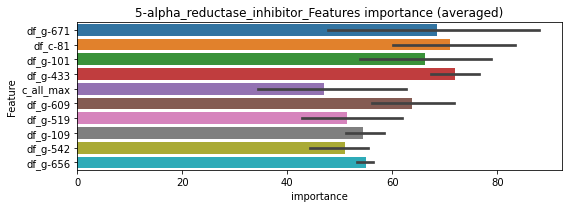

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015384	valid_1's binary_logloss: 0.0224191
[200]	training's binary_logloss: 0.00183098	valid_1's binary_logloss: 0.00584879
[300]	training's binary_logloss: 0.000528545	valid_1's binary_logloss: 0.00402193


len(train_index) : 2490
len(valid_index) : 2490


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000340621	valid_1's binary_logloss: 0.00376746


================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015046	valid_1's binary_logloss: 0.0247968
[200]	training's binary_logloss: 0.00175453	valid_1's binary_logloss: 0.0093107
[300]	training's binary_logloss: 0.000512441	valid_1's binary_logloss: 0.00746546


5-alpha_reductase_inhibitor logloss: 0.005451639440578073
11-beta-hsd1_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000393371	valid_1's binary_logloss: 0.00713582


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635954	valid_1's binary_logloss: 0.0977272
[200]	training's binary_logloss: 0.010575	valid_1's binary_logloss: 0.0261238
[300]	training's binary_logloss: 0.00333879	valid_1's binary_logloss: 0.0119638
[400]	training's binary_logloss: 0.0018212	valid_1's binary_logloss: 0.00817979
[500]	training's binary_logloss: 0.00135799	valid_1's binary_logloss: 0.00679428
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00127343	valid_1's binary_logloss: 0.00641729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06453	valid_1's binary_logloss: 0.103559
[200]	training's binary_logloss: 0.0106038	valid_1's binary_logloss: 0.0280941
[300]	training's binary_logloss: 0.00334695	valid_1's binary_logloss: 0.0133206
[400]	training's binary_logloss: 0.00180321	valid_1's binary_logloss: 0.00939581
[500]	training's binary_logloss: 0.0013492	valid

1 / 3 AUC score:1.000
Threshold: 0.6469732824890966
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00225
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00225, conf_1:0.64697
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.65
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.61
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.57
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_4: 0.53
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_5: 0.49
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_6: 0.45
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_7: 0.41
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_8: 0.37
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_9: 0.33
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_10: 0.29
threshold:0.25, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635954	valid_1's binary_logloss: 0.0977272
[200]	training's binary_logloss: 0.010575	valid_1's binary_logloss: 0.0261238
[300]	training's binary_logloss: 0.00333879	valid_1's binary_logloss: 0.0119638
[400]	training's binary_logloss: 0.0018212	valid_1's binary_logloss: 0.00817979
[500]	training's binary_logloss: 0.00135799	valid_1's binary_logloss: 0.00679428
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00127343	valid_1's binary_logloss: 0.00641729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06453	valid_1's binary_logloss: 0.103559
[200]	training's binary_logloss: 0.0106038	valid_1's binary_logloss: 0.0280941
[300]	training's binary_logloss: 0.00334695	valid_1's binary_logloss: 0.0133206
[400]	training's binary_logloss: 0.00180321	valid_1's binary_logloss: 0.00939581
[500]	training's binary_logloss: 0.0013492	valid

2 / 3 AUC score:1.000
Threshold: 0.24697328248909658
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00225
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00225, conf_1:0.24697
threshold:0.25, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634174	valid_1's binary_logloss: 0.104417
[200]	training's binary_logloss: 0.0104764	valid_1's binary_logloss: 0.0301996
[300]	training's binary_logloss: 0.00331307	valid_1's binary_logloss: 0.0143243
[400]	training's binary_logloss: 0.00179197	valid_1's binary_logloss: 0.00980231
[500]	training's binary_logloss: 0.00133907	valid_1's binary_logloss: 0.00807443
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00125901	valid_1's binary_logloss: 0.00761673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651451	valid_1's binary_logloss: 0.10056
[200]	training's binary_logloss: 0.010746	valid_1's binary_logloss: 0.0267106
[300]	training's binary_logloss: 0.00339686	valid_1's binary_logloss: 0.0122282
[400]	training's binary_logloss: 0.00183387	valid_1's binary_logloss: 0.00813844
[500]	training's binary_logloss: 0.00137102	val

3 / 3 AUC score:1.000
Threshold: 0.24697328248909658
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
30th percentile: 0.00234
p_label_rate: 0.00176 Vs.target_rate: 0.00082, Num_p_label: 7.0, conf_0:0.00234, conf_1:0.24697
threshold:0.25, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:507.0/4980, y_label_rate: 0.10181


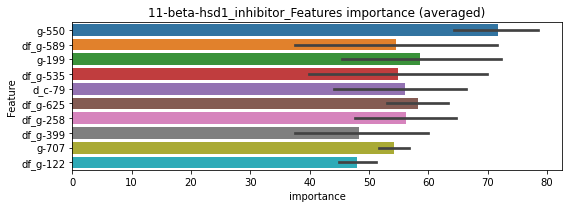

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159605	valid_1's binary_logloss: 0.0260759
[200]	training's binary_logloss: 0.00193262	valid_1's binary_logloss: 0.0105209
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000736289	valid_1's binary_logloss: 0.00961434


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163476	valid_1's binary_logloss: 0.0279756
[200]	training's binary_logloss: 0.00198781	valid_1's binary_logloss: 0.0101649
[300]	training's binary_logloss: 0.00058766	valid_1's binary_logloss: 0.00789673
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00046722	valid_1's binary_logloss: 0.00774818


11-beta-hsd1_inhibitor logloss: 0.008681262803465251
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747046	valid_1's binary_logloss: 0.128902
[200]	training's binary_logloss: 0.0136631	valid_1's binary_logloss: 0.0467845
[300]	training's binary_logloss: 0.00427874	valid_1's binary_logloss: 0.02785
[400]	training's binary_logloss: 0.00227829	valid_1's binary_logloss: 0.0211819
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00179118	valid_1's binary_logloss: 0.0186789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716935	valid_1's binary_logloss: 0.129544
[200]	training's binary_logloss: 0.0127417	valid_1's binary_logloss: 0.0465129
[300]	training's binary_logloss: 0.004156	valid_1's binary_logloss: 0.025505
[400]	training's binary_logloss: 0.00223019	valid_1's binary_logloss: 0.0187777
[500]	training's binary_logloss: 0.00160139	valid_1's binary_logloss: 0.0162198
Early stopping, best iteration is:
[572]	training's bi

1 / 3 AUC score:1.000
Threshold: 0.5490053288178246
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00268
p_label_rate: 0.00100 Vs.target_rate: 0.00108, Num_p_label: 4.0, conf_0:0.00268, conf_1:0.54901
threshold:0.55, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071956	valid_1's binary_logloss: 0.1284
[200]	training's binary_logloss: 0.0127625	valid_1's binary_logloss: 0.0446238
[300]	training's binary_logloss: 0.00411011	valid_1's binary_logloss: 0.0251414
[400]	training's binary_logloss: 0.00219904	valid_1's binary_logloss: 0.0184407
[500]	training's binary_logloss: 0.00157717	valid_1's binary_logloss: 0.0162316
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00143032	valid_1's binary_logloss: 0.0150056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744049	valid_1's binary_logloss: 0.132467
[200]	training's binary_logloss: 0.0134829	valid_1's binary_logloss: 0.0481893
[300]	training's binary_logloss: 0.00424028	valid_1's binary_logloss: 0.0261463
[400]	training's binary_logloss: 0.0022543	valid_1's binary_logloss: 0.0197034
[500]	training's binary_logloss: 0.00159552	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.5490053288178246
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
30th percentile: 0.00245
p_label_rate: 0.00151 Vs.target_rate: 0.00108, Num_p_label: 6.0, conf_0:0.00245, conf_1:0.54901
threshold:0.55, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718269	valid_1's binary_logloss: 0.135161
[200]	training's binary_logloss: 0.0128718	valid_1's binary_logloss: 0.0497738
[300]	training's binary_logloss: 0.00415018	valid_1's binary_logloss: 0.0271886
[400]	training's binary_logloss: 0.00220228	valid_1's binary_logloss: 0.0193949
[500]	training's binary_logloss: 0.00158047	valid_1's binary_logloss: 0.0160426
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00143071	valid_1's binary_logloss: 0.0150584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748226	valid_1's binary_logloss: 0.132651
[200]	training's binary_logloss: 0.0135213	valid_1's binary_logloss: 0.0474369
[300]	training's binary_logloss: 0.00428222	valid_1's binary_logloss: 0.0259256
[400]	training's binary_logloss: 0.00227768	valid_1's binary_logloss: 0.0188048


3 / 3 AUC score:1.000
Threshold: 0.5490053288178246
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
30th percentile: 0.00277
p_label_rate: 0.00251 Vs.target_rate: 0.00108, Num_p_label: 10.0, conf_0:0.00277, conf_1:0.54901


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00178057	valid_1's binary_logloss: 0.0162561


threshold:0.55, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:509.0/4979, y_label_rate: 0.10223


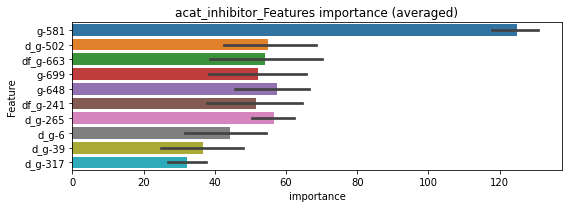

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208154	valid_1's binary_logloss: 0.039737
[200]	training's binary_logloss: 0.00277088	valid_1's binary_logloss: 0.0167821
[300]	training's binary_logloss: 0.000782916	valid_1's binary_logloss: 0.0136672
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000789449	valid_1's binary_logloss: 0.0136582


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209146	valid_1's binary_logloss: 0.0319775
[200]	training's binary_logloss: 0.00294793	valid_1's binary_logloss: 0.0108319
[300]	training's binary_logloss: 0.000818584	valid_1's binary_logloss: 0.00831836
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000545543	valid_1's binary_logloss: 0.00813435


acat_inhibitor logloss: 0.010896824402640106
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185898	valid_1's binary_logloss: 0.48632
[200]	training's binary_logloss: 0.0652954	valid_1's binary_logloss: 0.415542
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0527323	valid_1's binary_logloss: 0.405594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192374	valid_1's binary_logloss: 0.493632
[200]	training's binary_logloss: 0.0682211	valid_1's binary_logloss: 0.434023
[300]	training's binary_logloss: 0.0278032	valid_1's binary_logloss: 0.401996


1 / 3 AUC score:0.891
Threshold: 0.4530262943108119
Remove_noisy_labels: 186 → positive_corect_labels: 407/814


[400]	training's binary_logloss: 0.013537	valid_1's binary_logloss: 0.386365
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0144281	valid_1's binary_logloss: 0.386346


30th percentile: 0.22989
p_label_rate: 0.18207 Vs.target_rate: 0.00726, Num_p_label: 725.0, conf_0:0.22989, conf_1:0.50035
Num_p_label: 725.0, Expected: 28.9, Adj_threshold_1: 0.45
Num_p_label: 535.0, Expected: 28.9, Adj_threshold_2: 0.49
Num_p_label: 351.0, Expected: 28.9, Adj_threshold_3: 0.53
Num_p_label: 238.0, Expected: 28.9, Adj_threshold_4: 0.57
Num_p_label: 166.0, Expected: 28.9, Adj_threshold_5: 0.61
Num_p_label: 92.0, Expected: 28.9, Adj_threshold_6: 0.65
Num_p_label: 39.0, Expected: 28.9, Adj_threshold_7: 0.69
threshold:0.69, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:407.0/814, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174175	valid_1's binary_logloss: 0.439532
[200]	training's binary_logloss: 0.0585833	valid_1's binary_logloss: 0.381793
[300]	training's binary_logloss: 0.0229244	valid_1's binary_logloss: 0.340301
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0158646	valid_1's binary_logloss: 0.329846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174969	valid_1's binary_logloss: 0.447237
[200]	training's binary_logloss: 0.057685	valid_1's binary_logloss: 0.359491


2 / 3 AUC score:0.929
Threshold: 0.693026294310812
Remove_noisy_labels: 101 → positive_corect_labels: 319.0/713
30th percentile: 0.18166
p_label_rate: 0.05625 Vs.target_rate: 0.00726, Num_p_label: 224.0, conf_0:0.18166, conf_1:0.69303
Num_p_label: 224.0, Expected: 28.9, Adj_threshold_1: 0.69
Num_p_label: 143.0, Expected: 28.9, Adj_threshold_2: 0.73
Num_p_label: 90.0, Expected: 28.9, Adj_threshold_3: 0.77


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0253166	valid_1's binary_logloss: 0.332414


Num_p_label: 54.0, Expected: 28.9, Adj_threshold_4: 0.81
Num_p_label: 26.0, Expected: 28.9, Adj_threshold_5: 0.85
threshold:0.85, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:319.0/713, y_label_rate: 0.44741
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151871	valid_1's binary_logloss: 0.365759
[200]	training's binary_logloss: 0.0464999	valid_1's binary_logloss: 0.267743
[300]	training's binary_logloss: 0.0178358	valid_1's binary_logloss: 0.226306
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0110246	valid_1's binary_logloss: 0.2128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156289	valid_1's binary_logloss: 0.382298
[200]	training's binary_logloss: 0.0481305	valid_1's binary_logloss: 0.286982
[300]	training's binary_logloss: 0.0181553	valid_1's binary_logloss: 0.249395
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0175737	valid_1's binary_logloss: 0.248483


3 / 3 AUC score:0.964
Threshold: 0.8530262943108121
Remove_noisy_labels: 102 → positive_corect_labels: 218.0/611
30th percentile: 0.09107
p_label_rate: 0.00377 Vs.target_rate: 0.00726, Num_p_label: 15.0, conf_0:0.09107, conf_1:0.85303
threshold:0.85, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:233.0/4593, y_label_rate: 0.05073


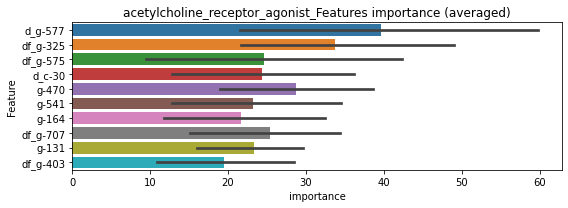

len(train_index) : 2296
len(valid_index) : 2297
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200171	valid_1's binary_logloss: 0.107389


len(train_index) : 2297
len(valid_index) : 2296
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.013603	valid_1's binary_logloss: 0.103693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232374	valid_1's binary_logloss: 0.0904811
[200]	training's binary_logloss: 0.00449007	valid_1's binary_logloss: 0.0756366


acetylcholine_receptor_agonist logloss: 0.08945218169116137
acetylcholine_receptor_antagonist , len(trt) : 301


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00424766	valid_1's binary_logloss: 0.0752054
  acetylcholine_receptor_agonist
0                          g-707
1                       df_g-132
2                          g-581
3                        df_c-81
4                       df_g-109
5                       df_g-433
6                       df_g-663
7                       df_g-707
8                       df_g-519
9                       df_g-542


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.277281	valid_1's binary_logloss: 0.631425
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.711
Threshold: 0.5060703096241599
Remove_noisy_labels: 348 → positive_corect_labels: 326/652
30th percentile: 0.42321
p_label_rate: 0.31416 Vs.target_rate: 0.01010, Num_p_label: 1251.0, conf_0:0.42321, conf_1:0.50607
Num_p_label: 1251.0, Expected: 40.2, Adj_threshold_1: 0.51
Num_p_label: 626.0, Expected: 40.2, Adj_threshold_2: 0.55
Num_p_label: 223.0, Expected: 40.2, Adj_threshold_3: 0.59
Num_p_label: 68.0, Expected: 40.2, Adj_threshold_4: 0.63
Num_p_label: 18.0, Expected: 40.2, Adj_threshold_5: 0.67
threshold:0.67, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.290799	valid_1's binary_logloss: 0.60869


positive y_label:326.0/652, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17805	valid_1's binary_logloss: 0.498876
[200]	training's binary_logloss: 0.0605312	valid_1's binary_logloss: 0.440282
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0401589	valid_1's binary_logloss: 0.4312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183464	valid_1's binary_logloss: 0.487861


2 / 3 AUC score:0.882
Threshold: 0.66607030962416
Remove_noisy_labels: 131 → positive_corect_labels: 213.0/521
30th percentile: 0.32029
p_label_rate: 0.11351 Vs.target_rate: 0.01010, Num_p_label: 452.0, conf_0:0.32029, conf_1:0.66607
Num_p_label: 452.0, Expected: 40.2, Adj_threshold_1: 0.67
Num_p_label: 266.0, Expected: 40.2, Adj_threshold_2: 0.71
Num_p_label: 160.0, Expected: 40.2, Adj_threshold_3: 0.75
Num_p_label: 86.0, Expected: 40.2, Adj_threshold_4: 0.79
Num_p_label: 33.0, Expected: 40.2, Adj_threshold_5: 0.83
threshold:0.83, positive p_label:33.0/3982, p_label_rate: 0.00829


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.119268	valid_1's binary_logloss: 0.465385


positive y_label:213.0/521, y_label_rate: 0.40883
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144926	valid_1's binary_logloss: 0.42051
[200]	training's binary_logloss: 0.0454835	valid_1's binary_logloss: 0.350629
[300]	training's binary_logloss: 0.0176929	valid_1's binary_logloss: 0.328665
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.017032	valid_1's binary_logloss: 0.327116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157729	valid_1's binary_logloss: 0.37401
[200]	training's binary_logloss: 0.0524244	valid_1's binary_logloss: 0.285313
[300]	training's binary_logloss: 0.0208679	valid_1's binary_logloss: 0.239252
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.014099	valid_1's binary_logloss: 0.227172


3 / 3 AUC score:0.954
Threshold: 0.8260703096241602
Remove_noisy_labels: 99 → positive_corect_labels: 119.0/422
30th percentile: 0.09294
p_label_rate: 0.00954 Vs.target_rate: 0.01010, Num_p_label: 38.0, conf_0:0.03690, conf_1:0.82607
threshold:0.83, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:157.0/4404, y_label_rate: 0.03565


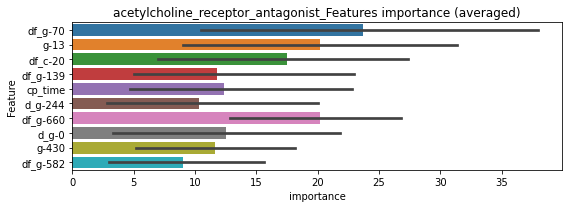

len(train_index) : 2202
len(valid_index) : 2202
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135097	valid_1's binary_logloss: 0.110725


len(train_index) : 2202
len(valid_index) : 2202
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[114]	training's binary_logloss: 0.0102525	valid_1's binary_logloss: 0.109837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158217	valid_1's binary_logloss: 0.10178


acetylcholine_receptor_antagonist logloss: 0.10530607522531713
acetylcholinesterase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0141245	valid_1's binary_logloss: 0.100775
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist
0                          g-707                             g-707
1                       df_g-132                          df_g-132
2                          g-581                             g-581
3                        df_c-81                           df_c-81
4                       df_g-109                          df_g-109
5                       df_g-433                          df_g-433
6                       df_g-663                          df_g-707
7                       df_g-707                          df_g-663
8                       df_g-519                          df_g-542
9                       df_g-542                          df_g-519


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137757	valid_1's binary_logloss: 0.323571
[200]	training's binary_logloss: 0.0377029	valid_1's binary_logloss: 0.210192
[300]	training's binary_logloss: 0.0133714	valid_1's binary_logloss: 0.165773
[400]	training's binary_logloss: 0.00645161	valid_1's binary_logloss: 0.146733
[500]	training's binary_logloss: 0.00397799	valid_1's binary_logloss: 0.138519
[600]	training's binary_logloss: 0.00291839	valid_1's binary_logloss: 0.131762
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00284948	valid_1's binary_logloss: 0.131568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137841	valid_1's binary_logloss: 0.306303
[200]	training's binary_logloss: 0.0379119	valid_1's binary_logloss: 0.193238
[300]	training's binary_logloss: 0.013249	valid_1's binary_logloss: 0.147959
[400]	training's binary_logloss: 0.00639235	valid_1's binary_l

1 / 3 AUC score:0.989
Threshold: 0.42961375291859283
Remove_noisy_labels: 40 → positive_corect_labels: 480/960
30th percentile: 0.02899
p_label_rate: 0.02637 Vs.target_rate: 0.00315, Num_p_label: 105.0, conf_0:0.02899, conf_1:0.49571
Num_p_label: 105.0, Expected: 12.5, Adj_threshold_1: 0.43
Num_p_label: 77.0, Expected: 12.5, Adj_threshold_2: 0.47
Num_p_label: 51.0, Expected: 12.5, Adj_threshold_3: 0.51
Num_p_label: 35.0, Expected: 12.5, Adj_threshold_4: 0.55
Num_p_label: 22.0, Expected: 12.5, Adj_threshold_5: 0.59
Num_p_label: 15.0, Expected: 12.5, Adj_threshold_6: 0.63
threshold:0.63, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132197	valid_1's binary_logloss: 0.302588
[200]	training's binary_logloss: 0.0352339	valid_1's binary_logloss: 0.195445
[300]	training's binary_logloss: 0.0124538	valid_1's binary_logloss: 0.153522
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00703639	valid_1's binary_logloss: 0.137405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13159	valid_1's binary_logloss: 0.311315
[200]	training's binary_logloss: 0.0343523	valid_1's binary_logloss: 0.220221
[300]	training's binary_logloss: 0.0121213	valid_1's binary_logloss: 0.182294
[400]	training's binary_logloss: 0.00592318	valid_1's binary_logloss: 0.166319


2 / 3 AUC score:0.982
Threshold: 0.6296137529185929


Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00411903	valid_1's binary_logloss: 0.160901


Remove_noisy_labels: 48 → positive_corect_labels: 442.0/912
30th percentile: 0.04544
p_label_rate: 0.00854 Vs.target_rate: 0.00315, Num_p_label: 34.0, conf_0:0.04544, conf_1:0.62961
threshold:0.63, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:442.0/912, y_label_rate: 0.48465
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127683	valid_1's binary_logloss: 0.260333
[200]	training's binary_logloss: 0.0341493	valid_1's binary_logloss: 0.14332
[300]	training's binary_logloss: 0.0120225	valid_1's binary_logloss: 0.0961489
[400]	training's binary_logloss: 0.00586508	valid_1's binary_logloss: 0.0766225
[500]	training's binary_logloss: 0.00373669	valid_1's binary_logloss: 0.0673544
[600]	training's binary_logloss: 0.00280171	valid_1's binary_logloss: 0.061973
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.00248124	valid_1's binary_logloss: 0.0601971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119541	valid_1's binary_logloss: 0.277168
[200]	training's binary_logloss: 0.0307235	valid_1's binary_logloss: 0.170219
[300]	training's binary_logloss: 0.0108785	valid_1's binary_logloss: 0.134776
[400]	training's binary_logloss: 0.00539034	valid_1's bina

3 / 3 AUC score:0.992
Threshold: 0.6296137529185929
Remove_noisy_labels: 19 → positive_corect_labels: 424.0/893
30th percentile: 0.02618


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00421619	valid_1's binary_logloss: 0.118791


p_label_rate: 0.00653 Vs.target_rate: 0.00315, Num_p_label: 26.0, conf_0:0.02618, conf_1:0.62961
threshold:0.63, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:450.0/4875, y_label_rate: 0.09231


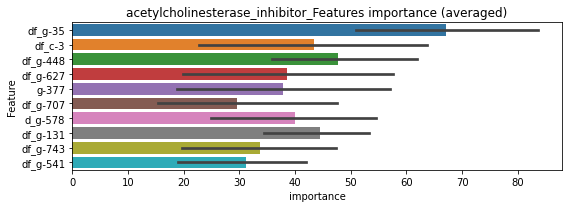

len(train_index) : 2437
len(valid_index) : 2438
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367163	valid_1's binary_logloss: 0.0832091
[200]	training's binary_logloss: 0.00731963	valid_1's binary_logloss: 0.0496362
[300]	training's binary_logloss: 0.00208973	valid_1's binary_logloss: 0.0421867
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00190137	valid_1's binary_logloss: 0.042161


len(train_index) : 2438
len(valid_index) : 2437
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383459	valid_1's binary_logloss: 0.0917307
[200]	training's binary_logloss: 0.00839107	valid_1's binary_logloss: 0.056788
[300]	training's binary_logloss: 0.00231213	valid_1's binary_logloss: 0.0481058
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0016751	valid_1's binary_logloss: 0.0470331


acetylcholinesterase_inhibitor logloss: 0.044596594932497624
adenosine_receptor_agonist , len(trt) : 54


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor  
0                          g-707  
1                          g-581  
2                       df_g-132  
3                        df_c-81  
4                       df_g-109  
5                  

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121326	valid_1's binary_logloss: 0.257532
[200]	training's binary_logloss: 0.029586	valid_1's binary_logloss: 0.13681
[300]	training's binary_logloss: 0.0101109	valid_1's binary_logloss: 0.0913974
[400]	training's binary_logloss: 0.00490266	valid_1's binary_logloss: 0.0756402
[500]	training's binary_logloss: 0.00310492	valid_1's binary_logloss: 0.067302
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00241832	valid_1's binary_logloss: 0.0619986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114371	valid_1's binary_logloss: 0.244992
[200]	training's binary_logloss: 0.0278491	valid_1's binary_logloss: 0.139018
[300]	training's binary_logloss: 0.00954877	valid_1's binary_logloss: 0.106139
[400]	training's binary_logloss: 0.00473917	valid_1's binary_logloss: 0.0941239
Early stopping, best iteration is:
[396]	training's binary

1 / 3 AUC score:0.997
Threshold: 0.3755876513906298
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentile: 0.02229
p_label_rate: 0.01205 Vs.target_rate: 0.00237, Num_p_label: 48.0, conf_0:0.01501, conf_1:0.42670
Num_p_label: 48.0, Expected: 9.4, Adj_threshold_1: 0.38
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_2: 0.42
Num_p_label: 18.0, Expected: 9.4, Adj_threshold_3: 0.46
Num_p_label: 11.0, Expected: 9.4, Adj_threshold_4: 0.50
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118849	valid_1's binary_logloss: 0.255835
[200]	training's binary_logloss: 0.0297653	valid_1's binary_logloss: 0.134845
[300]	training's binary_logloss: 0.00988039	valid_1's binary_logloss: 0.0882063
[400]	training's binary_logloss: 0.00486514	valid_1's binary_logloss: 0.0713413
[500]	training's binary_logloss: 0.00308287	valid_1's binary_logloss: 0.0620633
[600]	training's binary_logloss: 0.00233559	valid_1's binary_logloss: 0.057796
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.00217091	valid_1's binary_logloss: 0.0562538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111887	valid_1's binary_logloss: 0.23083
[200]	training's binary_logloss: 0.0267318	valid_1's binary_logloss: 0.120201
[300]	training's binary_logloss: 0.00932825	valid_1's binary_logloss: 0.082339
[400]	training's binary_logloss: 0.00468577	valid_1's bi

2 / 3 AUC score:0.999
Threshold: 0.4955876513906297
Remove_noisy_labels: 9 → positive_corect_labels: 483.0/969
30th percentile: 0.01792
p_label_rate: 0.00854 Vs.target_rate: 0.00237, Num_p_label: 34.0, conf_0:0.01059, conf_1:0.49559
Num_p_label: 34.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 9.4, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:483.0/969, y_label_rate: 0.49845
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115796	valid_1's binary_logloss: 0.218331
[200]	training's binary_logloss: 0.0284773	valid_1's binary_logloss: 0.10774
[300]	training's binary_logloss: 0.00990554	valid_1's binary_logloss: 0.069153
[400]	training's binary_logloss: 0.00488293	valid_1's binary_logloss: 0.0532543
[500]	training's binary_logloss: 0.00313789	valid_1's binary_logloss: 0.0459255
[600]	training's binary_logloss: 0.00238958	valid_1's binary_logloss: 0.0415251
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00212174	valid_1's binary_logloss: 0.040117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111911	valid_1's binary_logloss: 0.227625
[200]	training's binary_logloss: 0.0277769	valid_1's binary_logloss: 0.117067
[300]	training's binary_logloss: 0.00938918	valid_1's binary_logloss: 0.0747204
[400]	training's binary_logloss: 0.00465137	valid_1's bi

3 / 3 AUC score:1.000
Threshold: 0.5755876513906297
Remove_noisy_labels: 9 → positive_corect_labels: 474.0/960
30th percentile: 0.01559
p_label_rate: 0.00276 Vs.target_rate: 0.00237, Num_p_label: 11.0, conf_0:0.01043, conf_1:0.57559
threshold:0.58, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:485.0/4942, y_label_rate: 0.09814


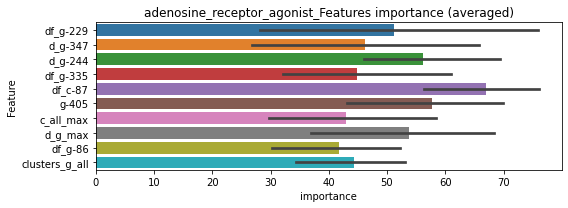

len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311923	valid_1's binary_logloss: 0.0862239
[200]	training's binary_logloss: 0.00564415	valid_1's binary_logloss: 0.0654143


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[213]	training's binary_logloss: 0.0046204	valid_1's binary_logloss: 0.0649579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293575	valid_1's binary_logloss: 0.0681151
[200]	training's binary_logloss: 0.00557188	valid_1's binary_logloss: 0.0406943
[300]	training's binary_logloss: 0.00160453	valid_1's binary_logloss: 0.0358534
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00163343	valid_1's binary_logloss: 0.0357817


adenosine_receptor_agonist logloss: 0.05036978066791198
adenosine_receptor_antagonist , len(trt) : 96


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  
0                          g-707                      g-707  
1                          g-581                      g-581  
2                       df_g-132           

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148297	valid_1's binary_logloss: 0.374234
[200]	training's binary_logloss: 0.0438003	valid_1's binary_logloss: 0.275929
[300]	training's binary_logloss: 0.0160364	valid_1's binary_logloss: 0.239737
[400]	training's binary_logloss: 0.00782105	valid_1's binary_logloss: 0.222894
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00614877	valid_1's binary_logloss: 0.217653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144155	valid_1's binary_logloss: 0.371852
[200]	training's binary_logloss: 0.0421893	valid_1's binary_logloss: 0.268954
[300]	training's binary_logloss: 0.0155438	valid_1's binary_logloss: 0.227923
[400]	training's binary_logloss: 0.00746502	valid_1's binary_logloss: 0.209857
[500]	training's binary_logloss: 0.00456837	valid_1's binary_logloss: 0.202697
Early stopping, best iteration is:
[549]	training's binary_lo

1 / 3 AUC score:0.967
Threshold: 0.4176929043146596
Remove_noisy_labels: 88 → positive_corect_labels: 456/912
30th percentile: 0.05851
p_label_rate: 0.04144 Vs.target_rate: 0.00405, Num_p_label: 165.0, conf_0:0.05851, conf_1:0.46636
Num_p_label: 165.0, Expected: 16.1, Adj_threshold_1: 0.42
Num_p_label: 117.0, Expected: 16.1, Adj_threshold_2: 0.46
Num_p_label: 79.0, Expected: 16.1, Adj_threshold_3: 0.50
Num_p_label: 56.0, Expected: 16.1, Adj_threshold_4: 0.54
Num_p_label: 35.0, Expected: 16.1, Adj_threshold_5: 0.58
Num_p_label: 22.0, Expected: 16.1, Adj_threshold_6: 0.62
threshold:0.62, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:456.0/912, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136131	valid_1's binary_logloss: 0.34991
[200]	training's binary_logloss: 0.0383017	valid_1's binary_logloss: 0.256245
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0269634	valid_1's binary_logloss: 0.245166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140924	valid_1's binary_logloss: 0.306593
[200]	training's binary_logloss: 0.0404099	valid_1's binary_logloss: 0.202398
[300]	training's binary_logloss: 0.0146039	valid_1's binary_logloss: 0.16204
[400]	training's binary_logloss: 0.00712952	valid_1's binary_logloss: 0.145136


2 / 3 AUC score:0.977
Threshold: 0.6176929043146596
Remove_noisy_labels: 57 → positive_corect_labels: 412.0/855
30th percentile: 0.07735
p_label_rate: 0.01130 Vs.target_rate: 0.00405, Num_p_label: 45.0, conf_0:0.07735, conf_1:0.61769


Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00542092	valid_1's binary_logloss: 0.138859


threshold:0.62, positive p_label:45.0/3982, p_label_rate: 0.01130
positive y_label:412.0/855, y_label_rate: 0.48187
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128184	valid_1's binary_logloss: 0.316144
[200]	training's binary_logloss: 0.0347316	valid_1's binary_logloss: 0.215597
[300]	training's binary_logloss: 0.0124739	valid_1's binary_logloss: 0.183337
[400]	training's binary_logloss: 0.00622874	valid_1's binary_logloss: 0.171794
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00596628	valid_1's binary_logloss: 0.171068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128709	valid_1's binary_logloss: 0.299074
[200]	training's binary_logloss: 0.0342442	valid_1's binary_logloss: 0.184837
[300]	training's binary_logloss: 0.0124558	valid_1's binary_logloss: 0.139281
[400]	training's binary_logloss: 0.00619492	valid_1's binary_logloss: 0.121005


3 / 3 AUC score:0.987
Threshold: 0.6176929043146596
Remove_noisy_labels: 48 → positive_corect_labels: 367.0/807


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00453467	valid_1's binary_logloss: 0.113546


30th percentile: 0.03596
p_label_rate: 0.00829 Vs.target_rate: 0.00405, Num_p_label: 33.0, conf_0:0.03596, conf_1:0.61769
threshold:0.62, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:400.0/4789, y_label_rate: 0.08352


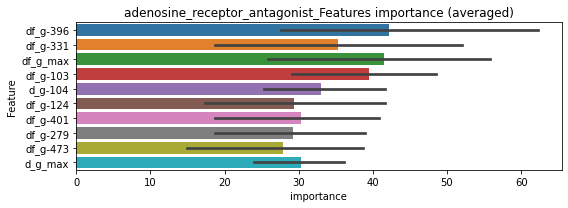

len(train_index) : 2394
len(valid_index) : 2395
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330911	valid_1's binary_logloss: 0.0967392
[200]	training's binary_logloss: 0.00700853	valid_1's binary_logloss: 0.0788954


len(train_index) : 2395
len(valid_index) : 2394
================================= fold 2/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00562162	valid_1's binary_logloss: 0.0784379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301079	valid_1's binary_logloss: 0.0963926
[200]	training's binary_logloss: 0.00588064	valid_1's binary_logloss: 0.0761516
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00312187	valid_1's binary_logloss: 0.0743148


adenosine_receptor_antagonist logloss: 0.07637676191324573
adenylyl_cyclase_activator , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630755	valid_1's binary_logloss: 0.113264
[200]	training's binary_logloss: 0.0103648	valid_1's binary_logloss: 0.0429221
[300]	training's binary_logloss: 0.00322198	valid_1's binary_logloss: 0.0254794
[400]	training's binary_logloss: 0.00177744	valid_1's binary_logloss: 0.0205051
[500]	training's binary_logloss: 0.00138366	valid_1's binary_logloss: 0.0178586
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00130134	valid_1's binary_logloss: 0.0171772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634334	valid_1's binary_logloss: 0.104179
[200]	training's binary_logloss: 0.0106266	valid_1's binary_logloss: 0.0325408
[300]	training's binary_logloss: 0.00333177	valid_1's binary_logloss: 0.0167694
[400]	training's binary_logloss: 0.00182471	valid_1's binary_logloss: 0.0117569
[500]	training's binary_logloss: 0.00139714	valid

1 / 3 AUC score:1.000
Threshold: 0.6672930603129492
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00135
p_label_rate: 0.00176 Vs.target_rate: 0.00082, Num_p_label: 7.0, conf_0:0.00135, conf_1:0.66729
threshold:0.67, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06415	valid_1's binary_logloss: 0.0957774
[200]	training's binary_logloss: 0.0107847	valid_1's binary_logloss: 0.0317611
[300]	training's binary_logloss: 0.00339111	valid_1's binary_logloss: 0.0176122
[400]	training's binary_logloss: 0.00184366	valid_1's binary_logloss: 0.0133073
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00148408	valid_1's binary_logloss: 0.0118378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609276	valid_1's binary_logloss: 0.112264
[200]	training's binary_logloss: 0.0101816	valid_1's binary_logloss: 0.0468524
[300]	training's binary_logloss: 0.00321442	valid_1's binary_logloss: 0.0261105
[400]	training's binary_logloss: 0.00177092	valid_1's binary_logloss: 0.0203632
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0014469	valid_1's binary_logloss: 0.0181873


2 / 3 AUC score:1.000
Threshold: 0.6672930603129492
Remove_noisy_labels: 3 → positive_corect_labels: 497.0/995
30th percentile: 0.00143
p_label_rate: 0.00201 Vs.target_rate: 0.00082, Num_p_label: 8.0, conf_0:0.00143, conf_1:0.66729
threshold:0.67, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:497.0/995, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600565	valid_1's binary_logloss: 0.109194
[200]	training's binary_logloss: 0.00976782	valid_1's binary_logloss: 0.0431934
[300]	training's binary_logloss: 0.00315399	valid_1's binary_logloss: 0.0276255
[400]	training's binary_logloss: 0.00176113	valid_1's binary_logloss: 0.0223226
[500]	training's binary_logloss: 0.00137984	valid_1's binary_logloss: 0.0208473
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00135395	valid_1's binary_logloss: 0.0208117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600916	valid_1's binary_logloss: 0.102456
[200]	training's binary_logloss: 0.00978714	valid_1's binary_logloss: 0.0381948
[300]	training's binary_logloss: 0.00312115	valid_1's binary_logloss: 0.0225359
[400]	training's binary_logloss: 0.00172571	valid_1's binary_logloss: 0.0170665
Early stopping, best iteration is:
[416]	traini

3 / 3 AUC score:1.000
Threshold: 0.6672930603129492
Remove_noisy_labels: 6 → positive_corect_labels: 492.0/989
30th percentile: 0.00134
p_label_rate: 0.00276 Vs.target_rate: 0.00082, Num_p_label: 11.0, conf_0:0.00134, conf_1:0.66729
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_1: 0.67
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_2: 0.71
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_3: 0.75
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_4: 0.79
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_5: 0.83
threshold:0.83, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:494.0/4971, y_label_rate: 0.09938


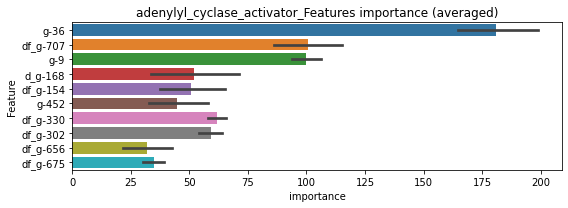

len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150403	valid_1's binary_logloss: 0.0257564
[200]	training's binary_logloss: 0.00183903	valid_1's binary_logloss: 0.00835392
[300]	training's binary_logloss: 0.000542693	valid_1's binary_logloss: 0.00585867


len(train_index) : 2486
len(valid_index) : 2485


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000343942	valid_1's binary_logloss: 0.00518104


================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154672	valid_1's binary_logloss: 0.0212299
[200]	training's binary_logloss: 0.00190969	valid_1's binary_logloss: 0.00520689
[300]	training's binary_logloss: 0.000565831	valid_1's binary_logloss: 0.00310216
[400]	training's binary_logloss: 0.000310977	valid_1's binary_logloss: 0.00248185
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000274945	valid_1's binary_logloss: 0.00240946


adenylyl_cyclase_activator logloss: 0.0037955281836744917
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203226	valid_1's binary_logloss: 0.598849
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.122912	valid_1's binary_logloss: 0.575665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213322	valid_1's binary_logloss: 0.602296
[200]	training's binary_logloss: 0.0813585	valid_1's binary_logloss: 0.576745


1 / 3 AUC score:0.755
Threshold: 0.47506589268435806
Remove_noisy_labels: 332 → positive_corect_labels: 334/668
30th percentile: 0.34159
p_label_rate: 0.29884 Vs.target_rate: 0.00941, Num_p_label: 1190.0, conf_0:0.34159, conf_1:0.50877
Num_p_label: 1190.0, Expected: 37.5, Adj_threshold_1: 0.48
Num_p_label: 805.0, Expected: 37.5, Adj_threshold_2: 0.52
Num_p_label: 526.0, Expected: 37.5, Adj_threshold_3: 0.56
Num_p_label: 302.0, Expected: 37.5, Adj_threshold_4: 0.60
Num_p_label: 165.0, Expected: 37.5, Adj_threshold_5: 0.64


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0515772	valid_1's binary_logloss: 0.56594


Num_p_label: 82.0, Expected: 37.5, Adj_threshold_6: 0.68
Num_p_label: 39.0, Expected: 37.5, Adj_threshold_7: 0.72
threshold:0.72, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:334.0/668, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188801	valid_1's binary_logloss: 0.481361
[200]	training's binary_logloss: 0.0655685	valid_1's binary_logloss: 0.420697
[300]	training's binary_logloss: 0.0270635	valid_1's binary_logloss: 0.38763
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0191851	valid_1's binary_logloss: 0.375867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191389	valid_1's binary_logloss: 0.490728
[200]	training's binary_logloss: 0.0681769	valid_1's binary_logloss: 0.436898


2 / 3 AUC score:0.900
Threshold: 0.7150658926843583
Remove_noisy_labels: 139 → positive_corect_labels: 211.0/529
30th percentile: 0.24507
p_label_rate: 0.07308 Vs.target_rate: 0.00941, Num_p_label: 291.0, conf_0:0.24507, conf_1:0.71507
Num_p_label: 291.0, Expected: 37.5, Adj_threshold_1: 0.72
Num_p_label: 208.0, Expected: 37.5, Adj_threshold_2: 0.76
Num_p_label: 150.0, Expected: 37.5, Adj_threshold_3: 0.80
Num_p_label: 95.0, Expected: 37.5, Adj_threshold_4: 0.84
Num_p_label: 51.0, Expected: 37.5, Adj_threshold_5: 0.88
threshold:0.88, positive p_label:51.0/3982, p_label_rate: 0.01281


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.030953	valid_1's binary_logloss: 0.414101


positive y_label:211.0/529, y_label_rate: 0.39887
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165214	valid_1's binary_logloss: 0.384134
[200]	training's binary_logloss: 0.0530627	valid_1's binary_logloss: 0.292626
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0239796	valid_1's binary_logloss: 0.260214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16241	valid_1's binary_logloss: 0.398625
[200]	training's binary_logloss: 0.0507775	valid_1's binary_logloss: 0.316329


3 / 3 AUC score:0.950
Threshold: 0.8750658926843584
Remove_noisy_labels: 99 → positive_corect_labels: 112.0/430


[300]	training's binary_logloss: 0.0204079	valid_1's binary_logloss: 0.290685
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0192735	valid_1's binary_logloss: 0.28793


30th percentile: 0.09062
p_label_rate: 0.02109 Vs.target_rate: 0.00941, Num_p_label: 84.0, conf_0:0.09062, conf_1:0.87507
threshold:0.88, positive p_label:84.0/3982, p_label_rate: 0.02109
positive y_label:196.0/4412, y_label_rate: 0.04442


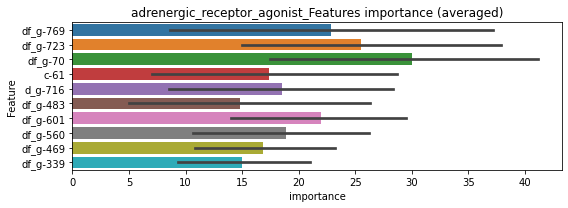

len(train_index) : 2206
len(valid_index) : 2206
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169394	valid_1's binary_logloss: 0.0899755


len(train_index) : 2206
len(valid_index) : 2206
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0133249	valid_1's binary_logloss: 0.0878687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162926	valid_1's binary_logloss: 0.0860665


adrenergic_receptor_agonist logloss: 0.08605459251473786
adrenergic_receptor_antagonist , len(trt) : 360


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.00994961	valid_1's binary_logloss: 0.0842405
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                   

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.246753	valid_1's binary_logloss: 0.659232
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.619
Threshold: 0.5001353142864882
Remove_noisy_labels: 430 → positive_corect_labels: 285/570
30th percentile: 0.43361
p_label_rate: 0.36514 Vs.target_rate: 0.01119, Num_p_label: 1454.0, conf_0:0.43361, conf_1:0.50014
Num_p_label: 1454.0, Expected: 44.5, Adj_threshold_1: 0.50
Num_p_label: 800.0, Expected: 44.5, Adj_threshold_2: 0.54
Num_p_label: 333.0, Expected: 44.5, Adj_threshold_3: 0.58
Num_p_label: 113.0, Expected: 44.5, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 44.5, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[52]	training's binary_logloss: 0.357681	valid_1's binary_logloss: 0.673664


positive y_label:285.0/570, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201127	valid_1's binary_logloss: 0.509334
[200]	training's binary_logloss: 0.0731698	valid_1's binary_logloss: 0.464206
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0483569	valid_1's binary_logloss: 0.451905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199925	valid_1's binary_logloss: 0.531057
[200]	training's binary_logloss: 0.0744318	valid_1's binary_logloss: 0.483316
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.051606	valid_1's binary_logloss: 0.469881


2 / 3 AUC score:0.863
Threshold: 0.6601353142864883
Remove_noisy_labels: 133 → positive_corect_labels: 174.0/437
30th percentile: 0.30561
p_label_rate: 0.15369 Vs.target_rate: 0.01119, Num_p_label: 612.0, conf_0:0.30561, conf_1:0.66014
Num_p_label: 612.0, Expected: 44.5, Adj_threshold_1: 0.66
Num_p_label: 464.0, Expected: 44.5, Adj_threshold_2: 0.70
Num_p_label: 344.0, Expected: 44.5, Adj_threshold_3: 0.74
Num_p_label: 238.0, Expected: 44.5, Adj_threshold_4: 0.78
Num_p_label: 147.0, Expected: 44.5, Adj_threshold_5: 0.82
Num_p_label: 76.0, Expected: 44.5, Adj_threshold_6: 0.86
Num_p_label: 31.0, Expected: 44.5, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:174.0/437, y_label_rate: 0.39817
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179337	valid_1's binary_logloss: 0.431571
[200]	training's binary_logloss: 0.0625764	valid_1's binary_logloss: 0.36677
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0338515	valid_1's binary_logloss: 0.343843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154278	valid_1's binary_logloss: 0.456854


3 / 3 AUC score:0.914
Threshold: 0.9001353142864885
Remove_noisy_labels: 142 → positive_corect_labels: 32.0/295
30th percentile: 0.16143
p_label_rate: 0.00176 Vs.target_rate: 0.01119, Num_p_label: 7.0, conf_0:0.16143, conf_1:0.90014
Num_p_label: 7.0, Expected: 44.5, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 44.5, Adj_threshold_2: 0.86
Num_p_label: 43.0, Expected: 44.5, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:43.0/3982, p_label_rate: 0.01080


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0668312	valid_1's binary_logloss: 0.40675


positive y_label:75.0/4277, y_label_rate: 0.01754


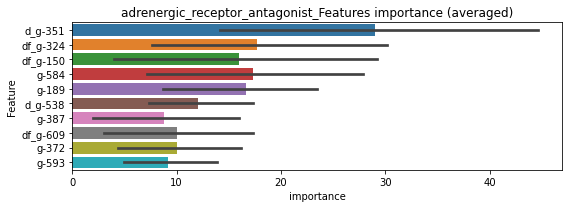

len(train_index) : 2138
len(valid_index) : 2139
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2139
len(valid_index) : 2138
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.00935774	valid_1's binary_logloss: 0.068756
Training until validation scores don't improve for 10 rounds


adrenergic_receptor_antagonist logloss: 0.07433084643944114
akt_inhibitor , len(trt) : 66


Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0284585	valid_1's binary_logloss: 0.0799083
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127718	valid_1's binary_logloss: 0.286184
[200]	training's binary_logloss: 0.0338657	valid_1's binary_logloss: 0.186363
[300]	training's binary_logloss: 0.0117094	valid_1's binary_logloss: 0.145733
[400]	training's binary_logloss: 0.0057388	valid_1's binary_logloss: 0.130385
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00470624	valid_1's binary_logloss: 0.12729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135368	valid_1's binary_logloss: 0.272547
[200]	training's binary_logloss: 0.0371452	valid_1's binary_logloss: 0.157322
[300]	training's binary_logloss: 0.0133302	valid_1's binary_logloss: 0.113126
[400]	training's binary_logloss: 0.00642829	valid_1's binary_logloss: 0.0942978
[500]	training's binary_logloss: 0.00397705	valid_1's binary_logloss: 0.0847725
[600]	training's binary_logloss: 0.00290726	valid_1's binary_

1 / 3 AUC score:0.992
Threshold: 0.3971482977937641
Remove_noisy_labels: 30 → positive_corect_labels: 485/970
30th percentile: 0.03098
p_label_rate: 0.01808 Vs.target_rate: 0.00287, Num_p_label: 72.0, conf_0:0.03098, conf_1:0.47382
Num_p_label: 72.0, Expected: 11.4, Adj_threshold_1: 0.40
Num_p_label: 47.0, Expected: 11.4, Adj_threshold_2: 0.44
Num_p_label: 35.0, Expected: 11.4, Adj_threshold_3: 0.48
Num_p_label: 20.0, Expected: 11.4, Adj_threshold_4: 0.52
Num_p_label: 15.0, Expected: 11.4, Adj_threshold_5: 0.56
threshold:0.56, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128081	valid_1's binary_logloss: 0.280563
[200]	training's binary_logloss: 0.0345248	valid_1's binary_logloss: 0.171444
[300]	training's binary_logloss: 0.0121022	valid_1's binary_logloss: 0.119265
[400]	training's binary_logloss: 0.00585893	valid_1's binary_logloss: 0.0982703
[500]	training's binary_logloss: 0.00367293	valid_1's binary_logloss: 0.0859524
[600]	training's binary_logloss: 0.00271336	valid_1's binary_logloss: 0.0790426
[700]	training's binary_logloss: 0.00227665	valid_1's binary_logloss: 0.0761274
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.00222765	valid_1's binary_logloss: 0.0756137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126939	valid_1's binary_logloss: 0.257342
[200]	training's binary_logloss: 0.0334735	valid_1's binary_logloss: 0.151538
[300]	training's binary_logloss: 0.0117888	valid_1's bi

2 / 3 AUC score:0.997
Threshold: 0.5571482977937641
Remove_noisy_labels: 15 → positive_corect_labels: 473.0/955
30th percentile: 0.02179
p_label_rate: 0.00552 Vs.target_rate: 0.00287, Num_p_label: 22.0, conf_0:0.02179, conf_1:0.55715
threshold:0.56, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:473.0/955, y_label_rate: 0.49529
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11818	valid_1's binary_logloss: 0.266274
[200]	training's binary_logloss: 0.0300792	valid_1's binary_logloss: 0.153404
[300]	training's binary_logloss: 0.0105496	valid_1's binary_logloss: 0.110985
[400]	training's binary_logloss: 0.00520776	valid_1's binary_logloss: 0.0928018
[500]	training's binary_logloss: 0.00333082	valid_1's binary_logloss: 0.0838273
[600]	training's binary_logloss: 0.00251748	valid_1's binary_logloss: 0.0774607
[700]	training's binary_logloss: 0.00216106	valid_1's binary_logloss: 0.0746123
Early stopping, best iteration is:
[716]	training's binary_logloss: 0.00212047	valid_1's binary_logloss: 0.0742287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126553	valid_1's binary_logloss: 0.250056
[200]	training's binary_logloss: 0.0331592	valid_1's binary_logloss: 0.128929
[300]	training's binary_logloss: 0.0115445	valid_1's bin

3 / 3 AUC score:0.999
Threshold: 0.5571482977937641
Remove_noisy_labels: 14 → positive_corect_labels: 461.0/941
30th percentile: 0.01628
p_label_rate: 0.00628 Vs.target_rate: 0.00287, Num_p_label: 25.0, conf_0:0.01525, conf_1:0.55715
threshold:0.56, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:486.0/4923, y_label_rate: 0.09872


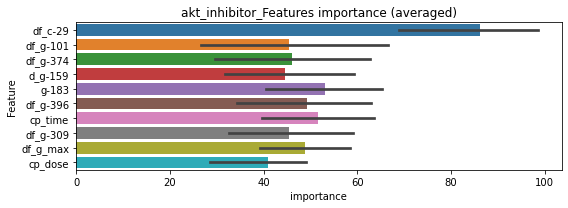

len(train_index) : 2461
len(valid_index) : 2462
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375474	valid_1's binary_logloss: 0.079856
[200]	training's binary_logloss: 0.0074452	valid_1's binary_logloss: 0.0458532
[300]	training's binary_logloss: 0.00211832	valid_1's binary_logloss: 0.0404169
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00144348	valid_1's binary_logloss: 0.0393569


len(train_index) : 2462
len(valid_index) : 2461
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038222	valid_1's binary_logloss: 0.0848743
[200]	training's binary_logloss: 0.00783671	valid_1's binary_logloss: 0.0531061
[300]	training's binary_logloss: 0.00219979	valid_1's binary_logloss: 0.0453584
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00197514	valid_1's binary_logloss: 0.0450007


akt_inhibitor logloss: 0.0421782146451825
aldehyde_dehydrogenase_inhibitor , len(trt) : 19


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671675	valid_1's binary_logloss: 0.10558
[200]	training's binary_logloss: 0.0118335	valid_1's binary_logloss: 0.0324535
[300]	training's binary_logloss: 0.00373786	valid_1's binary_logloss: 0.0159352
[400]	training's binary_logloss: 0.00199072	valid_1's binary_logloss: 0.0113981
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0016089	valid_1's binary_logloss: 0.0100002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687583	valid_1's binary_logloss: 0.108742
[200]	training's binary_logloss: 0.0118524	valid_1's binary_logloss: 0.0309029
[300]	training's binary_logloss: 0.00379526	valid_1's binary_logloss: 0.0147831
[400]	training's binary_logloss: 0.00204945	valid_1's binary_logloss: 0.00959246
[500]	training's binary_logloss: 0.00149749	valid_1's binary_logloss: 0.00771323
Early stopping, best iteration is:
[571]	training

1 / 3 AUC score:1.000
Threshold: 0.5964288690122376
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00310
p_label_rate: 0.00000 Vs.target_rate: 0.00086, Num_p_label: 0.0, conf_0:0.00310, conf_1:0.59643
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_1: 0.60
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_2: 0.56
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_3: 0.52
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_4: 0.48
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_5: 0.44
Num_p_label: 1.0, Expected: 3.4, Adj_threshold_6: 0.40
Num_p_label: 1.0, Expected: 3.4, Adj_threshold_7: 0.36
Num_p_label: 1.0, Expected: 3.4, Adj_threshold_8: 0.32
Num_p_label: 2.0, Expected: 3.4, Adj_threshold_9: 0.28
Num_p_label: 5.0, Expected: 3.4, Adj_threshold_10: 0.24
threshold:0.24, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671675	valid_1's binary_logloss: 0.10558
[200]	training's binary_logloss: 0.0118335	valid_1's binary_logloss: 0.0324535
[300]	training's binary_logloss: 0.00373786	valid_1's binary_logloss: 0.0159352
[400]	training's binary_logloss: 0.00199072	valid_1's binary_logloss: 0.0113981
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0016089	valid_1's binary_logloss: 0.0100002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687583	valid_1's binary_logloss: 0.108742
[200]	training's binary_logloss: 0.0118524	valid_1's binary_logloss: 0.0309029
[300]	training's binary_logloss: 0.00379526	valid_1's binary_logloss: 0.0147831
[400]	training's binary_logloss: 0.00204945	valid_1's binary_logloss: 0.00959246
[500]	training's binary_logloss: 0.00149749	valid_1's binary_logloss: 0.00771323
Early stopping, best iteration is:
[571]	training

2 / 3 AUC score:1.000
Threshold: 0.2364288690122376
Remove_noisy_labels: 3 → positive_corect_labels: 500.0/997
30th percentile: 0.00310
p_label_rate: 0.00126 Vs.target_rate: 0.00086, Num_p_label: 5.0, conf_0:0.00310, conf_1:0.24066
threshold:0.24, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/997, y_label_rate: 0.50150
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700008	valid_1's binary_logloss: 0.116169
[200]	training's binary_logloss: 0.0116536	valid_1's binary_logloss: 0.0334448
[300]	training's binary_logloss: 0.00367513	valid_1's binary_logloss: 0.0170998
[400]	training's binary_logloss: 0.00201501	valid_1's binary_logloss: 0.0123817
[500]	training's binary_logloss: 0.00147748	valid_1's binary_logloss: 0.0100375
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00141314	valid_1's binary_logloss: 0.00962766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693082	valid_1's binary_logloss: 0.115055
[200]	training's binary_logloss: 0.0115564	valid_1's binary_logloss: 0.0334165
[300]	training's binary_logloss: 0.00369288	valid_1's binary_logloss: 0.0165861
[400]	training's binary_logloss: 0.00201304	valid_1's binary_logloss: 0.011396
[500]	training's binary_logloss: 0.00148868	valid

3 / 3 AUC score:1.000
Threshold: 0.2364288690122376
Remove_noisy_labels: 4 → positive_corect_labels: 500.0/993
30th percentile: 0.00304
p_label_rate: 0.00276 Vs.target_rate: 0.00086, Num_p_label: 11.0, conf_0:0.00304, conf_1:0.23643
Num_p_label: 11.0, Expected: 3.4, Adj_threshold_1: 0.24
Num_p_label: 3.0, Expected: 3.4, Adj_threshold_2: 0.28
threshold:0.28, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4975, y_label_rate: 0.10111


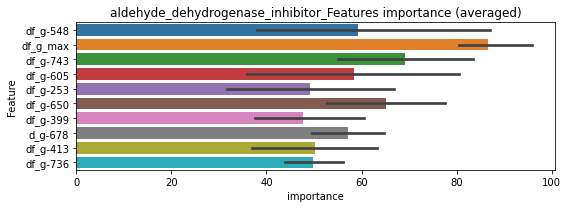

len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162379	valid_1's binary_logloss: 0.0249672
[200]	training's binary_logloss: 0.0020366	valid_1's binary_logloss: 0.00648097
[300]	training's binary_logloss: 0.000603708	valid_1's binary_logloss: 0.00412966


len(train_index) : 2488


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000359387	valid_1's binary_logloss: 0.00373368


len(valid_index) : 2487
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162884	valid_1's binary_logloss: 0.0385164
[200]	training's binary_logloss: 0.00203606	valid_1's binary_logloss: 0.0173517
[300]	training's binary_logloss: 0.000597448	valid_1's binary_logloss: 0.0136099
[400]	training's binary_logloss: 0.000326097	valid_1's binary_logloss: 0.0124952
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000287175	valid_1's binary_logloss: 0.0122792


aldehyde_dehydrogenase_inhibitor logloss: 0.008005601859800867
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103268	valid_1's binary_logloss: 0.21805
[200]	training's binary_logloss: 0.0235292	valid_1's binary_logloss: 0.104891
[300]	training's binary_logloss: 0.00778132	valid_1's binary_logloss: 0.0653967
[400]	training's binary_logloss: 0.00388112	valid_1's binary_logloss: 0.0502318
[500]	training's binary_logloss: 0.00252344	valid_1's binary_logloss: 0.0432895
[600]	training's binary_logloss: 0.00199922	valid_1's binary_logloss: 0.0390006
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.0019595	valid_1's binary_logloss: 0.0385546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103985	valid_1's binary_logloss: 0.207033
[200]	training's binary_logloss: 0.0236659	valid_1's binary_logloss: 0.0988378
[300]	training's binary_logloss: 0.0076875	valid_1's binary_logloss: 0.0606076
[400]	training's binary_logloss: 0.00382535	valid_1's b

1 / 3 AUC score:1.000
Threshold: 0.5055143761246843
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00852
p_label_rate: 0.00126 Vs.target_rate: 0.00187, Num_p_label: 5.0, conf_0:0.00852, conf_1:0.50551
threshold:0.51, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100372	valid_1's binary_logloss: 0.211957
[200]	training's binary_logloss: 0.0228342	valid_1's binary_logloss: 0.113153
[300]	training's binary_logloss: 0.00754747	valid_1's binary_logloss: 0.0766787
[400]	training's binary_logloss: 0.00376199	valid_1's binary_logloss: 0.0625816
[500]	training's binary_logloss: 0.00246323	valid_1's binary_logloss: 0.0559998
[600]	training's binary_logloss: 0.00194826	valid_1's binary_logloss: 0.0528096
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00190234	valid_1's binary_logloss: 0.0522357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10258	valid_1's binary_logloss: 0.2133
[200]	training's binary_logloss: 0.0231589	valid_1's binary_logloss: 0.102987
[300]	training's binary_logloss: 0.00755831	valid_1's binary_logloss: 0.0689404
[400]	training's binary_logloss: 0.00381004	valid_1's bi

2 / 3 AUC score:0.999
Threshold: 0.5055143761246843


Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00208869	valid_1's binary_logloss: 0.042704


Remove_noisy_labels: 10 → positive_corect_labels: 489.0/986
30th percentile: 0.00956
p_label_rate: 0.00176 Vs.target_rate: 0.00187, Num_p_label: 7.0, conf_0:0.00956, conf_1:0.50551
threshold:0.51, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:489.0/986, y_label_rate: 0.49594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102146	valid_1's binary_logloss: 0.206098
[200]	training's binary_logloss: 0.022738	valid_1's binary_logloss: 0.103832
[300]	training's binary_logloss: 0.00759022	valid_1's binary_logloss: 0.0730189
[400]	training's binary_logloss: 0.00382312	valid_1's binary_logloss: 0.0636627
[500]	training's binary_logloss: 0.00249669	valid_1's binary_logloss: 0.0588538
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00216333	valid_1's binary_logloss: 0.0576406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10234	valid_1's binary_logloss: 0.21187
[200]	training's binary_logloss: 0.0223312	valid_1's binary_logloss: 0.0910935
[300]	training's binary_logloss: 0.00746228	valid_1's binary_logloss: 0.0563196
[400]	training's binary_logloss: 0.0037289	valid_1's binary_logloss: 0.0415025
[500]	training's binary_logloss: 0.00245246	valid_1's bi

3 / 3 AUC score:0.997
Threshold: 0.5055143761246843
Remove_noisy_labels: 6 → positive_corect_labels: 483.0/980
30th percentile: 0.00861
p_label_rate: 0.00226 Vs.target_rate: 0.00187, Num_p_label: 9.0, conf_0:0.00861, conf_1:0.50551
threshold:0.51, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:492.0/4962, y_label_rate: 0.09915


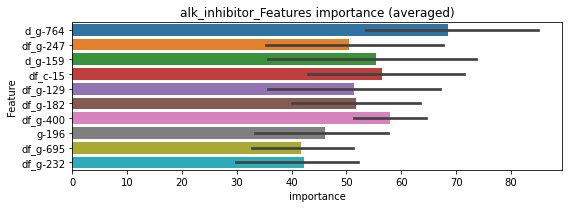

len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297957	valid_1's binary_logloss: 0.0551489
[200]	training's binary_logloss: 0.00508792	valid_1's binary_logloss: 0.0232287
[300]	training's binary_logloss: 0.0013591	valid_1's binary_logloss: 0.017262
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000716635	valid_1's binary_logloss: 0.0162577


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304578	valid_1's binary_logloss: 0.0682498
[200]	training's binary_logloss: 0.00503409	valid_1's binary_logloss: 0.0395229
[300]	training's binary_logloss: 0.00137029	valid_1's binary_logloss: 0.0336701
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00102046	valid_1's binary_logloss: 0.033214


alk_inhibitor logloss: 0.024735859858283946
ampk_activator , len(trt) : 12


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514681	valid_1's binary_logloss: 0.0770737
[200]	training's binary_logloss: 0.00733612	valid_1's binary_logloss: 0.0187043
[300]	training's binary_logloss: 0.00238829	valid_1's binary_logloss: 0.00780258
[400]	training's binary_logloss: 0.00138824	valid_1's binary_logloss: 0.00545963
[500]	training's binary_logloss: 0.00116249	valid_1's binary_logloss: 0.00481383
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00114658	valid_1's binary_logloss: 0.00475735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493798	valid_1's binary_logloss: 0.0722683
[200]	training's binary_logloss: 0.00730633	valid_1's binary_logloss: 0.018347
[300]	training's binary_logloss: 0.00243453	valid_1's binary_logloss: 0.00849054
[400]	training's binary_logloss: 0.00142134	valid_1's binary_logloss: 0.00588755
Early stopping, best iteration is:
[464]

1 / 3 AUC score:1.000
Threshold: 0.4879455905077665
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00120
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00120, conf_1:0.48795
threshold:0.49, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514681	valid_1's binary_logloss: 0.0770737
[200]	training's binary_logloss: 0.00733612	valid_1's binary_logloss: 0.0187043
[300]	training's binary_logloss: 0.00238829	valid_1's binary_logloss: 0.00780258
[400]	training's binary_logloss: 0.00138824	valid_1's binary_logloss: 0.00545963
[500]	training's binary_logloss: 0.00116249	valid_1's binary_logloss: 0.00481383
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00114658	valid_1's binary_logloss: 0.00475735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493798	valid_1's binary_logloss: 0.0722683
[200]	training's binary_logloss: 0.00730633	valid_1's binary_logloss: 0.018347
[300]	training's binary_logloss: 0.00243453	valid_1's binary_logloss: 0.00849054
[400]	training's binary_logloss: 0.00142134	valid_1's binary_logloss: 0.00588755
Early stopping, best iteration is:
[464]

2 / 3 AUC score:1.000
Threshold: 0.4879455905077665
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00120
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00120, conf_1:0.48795
threshold:0.49, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514681	valid_1's binary_logloss: 0.0770737
[200]	training's binary_logloss: 0.00733612	valid_1's binary_logloss: 0.0187043
[300]	training's binary_logloss: 0.00238829	valid_1's binary_logloss: 0.00780258
[400]	training's binary_logloss: 0.00138824	valid_1's binary_logloss: 0.00545963
[500]	training's binary_logloss: 0.00116249	valid_1's binary_logloss: 0.00481383
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00114658	valid_1's binary_logloss: 0.00475735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493798	valid_1's binary_logloss: 0.0722683
[200]	training's binary_logloss: 0.00730633	valid_1's binary_logloss: 0.018347
[300]	training's binary_logloss: 0.00243453	valid_1's binary_logloss: 0.00849054
[400]	training's binary_logloss: 0.00142134	valid_1's binary_logloss: 0.00588755
Early stopping, best iteration is:
[464]

3 / 3 AUC score:1.000
Threshold: 0.4879455905077665
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00120
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00120, conf_1:0.48795
threshold:0.49, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


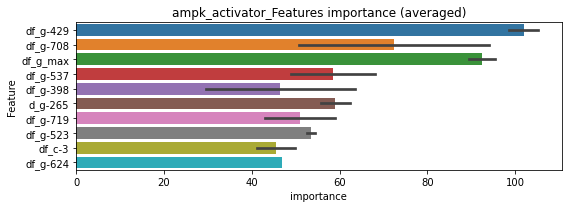

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127247	valid_1's binary_logloss: 0.0167223
[200]	training's binary_logloss: 0.00136878	valid_1's binary_logloss: 0.00343307
[300]	training's binary_logloss: 0.000409576	valid_1's binary_logloss: 0.00220749
[400]	training's binary_logloss: 0.000237895	valid_1's binary_logloss: 0.0019543
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000226938	valid_1's binary_logloss: 0.00192374


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125687	valid_1's binary_logloss: 0.0184605
[200]	training's binary_logloss: 0.00135324	valid_1's binary_logloss: 0.00587679
[300]	training's binary_logloss: 0.000407903	valid_1's binary_logloss: 0.00422214


ampk_activator logloss: 0.002916975733400659


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000267514	valid_1's binary_logloss: 0.00391022


analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04787	valid_1's binary_logloss: 0.0712841
[200]	training's binary_logloss: 0.00665714	valid_1's binary_logloss: 0.0162386
[300]	training's binary_logloss: 0.00213738	valid_1's binary_logloss: 0.00766828
[400]	training's binary_logloss: 0.00126059	valid_1's binary_logloss: 0.00556233
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00109626	valid_1's binary_logloss: 0.00503453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503887	valid_1's binary_logloss: 0.0677838
[200]	training's binary_logloss: 0.0071687	valid_1's binary_logloss: 0.014443
[300]	training's binary_logloss: 0.00230356	valid_1's binary_logloss: 0.00618045
[400]	training's binary_logloss: 0.00131038	valid_1's binary_logloss: 0.00408516
[500]	training's binary_logloss: 0.00110551	valid_1's binary_logloss: 0.00358533


1 / 3 AUC score:1.000
Threshold: 0.5785461126871839
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00109
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00109, conf_1:0.57855
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.46


Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00109262	valid_1's binary_logloss: 0.00354202


Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.42
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_6: 0.38
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_7: 0.34
threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04787	valid_1's binary_logloss: 0.0712841
[200]	training's binary_logloss: 0.00665714	valid_1's binary_logloss: 0.0162386
[300]	training's binary_logloss: 0.00213738	valid_1's binary_logloss: 0.00766828
[400]	training's binary_logloss: 0.00126059	valid_1's binary_logloss: 0.00556233
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00109626	valid_1's binary_logloss: 0.00503453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503887	valid_1's binary_logloss: 0.0677838
[200]	training's binary_logloss: 0.0071687	valid_1's binary_logloss: 0.014443
[300]	training's binary_logloss: 0.00230356	valid_1's binary_logloss: 0.00618045
[400]	training's binary_logloss: 0.00131038	valid_1's binary_logloss: 0.00408516
[500]	training's binary_logloss: 0.00110551	valid_1's binary_logloss: 0.00358533


2 / 3 AUC score:1.000
Threshold: 0.338546112687184
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00109
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00109, conf_1:0.33855
threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00109262	valid_1's binary_logloss: 0.00354202


positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04787	valid_1's binary_logloss: 0.0712841
[200]	training's binary_logloss: 0.00665714	valid_1's binary_logloss: 0.0162386
[300]	training's binary_logloss: 0.00213738	valid_1's binary_logloss: 0.00766828
[400]	training's binary_logloss: 0.00126059	valid_1's binary_logloss: 0.00556233
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00109626	valid_1's binary_logloss: 0.00503453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503887	valid_1's binary_logloss: 0.0677838
[200]	training's binary_logloss: 0.0071687	valid_1's binary_logloss: 0.014443
[300]	training's binary_logloss: 0.00230356	valid_1's binary_logloss: 0.00618045
[400]	training's binary_logloss: 0.00131038	valid_1's binary_logloss: 0.00408516
[500]	training's binary_logloss: 0.00110551	valid_1's binary_logloss: 0.00358533


3 / 3 AUC score:1.000
Threshold: 0.338546112687184
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00109
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00109, conf_1:0.33855


Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00109262	valid_1's binary_logloss: 0.00354202


threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


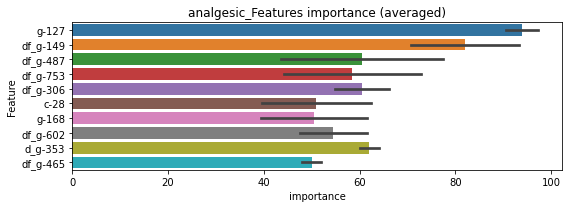

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123604	valid_1's binary_logloss: 0.0189499
[200]	training's binary_logloss: 0.00133545	valid_1's binary_logloss: 0.00431665
[300]	training's binary_logloss: 0.000395046	valid_1's binary_logloss: 0.00219339
[400]	training's binary_logloss: 0.000229831	valid_1's binary_logloss: 0.00173936
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000218124	valid_1's binary_logloss: 0.00168589


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120917	valid_1's binary_logloss: 0.0175806
[200]	training's binary_logloss: 0.00127628	valid_1's binary_logloss: 0.00543787


analgesic logloss: 0.002874514835428592
androgen_receptor_agonist , len(trt) : 48


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000430872	valid_1's binary_logloss: 0.00406314


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113271	valid_1's binary_logloss: 0.230424
[200]	training's binary_logloss: 0.0271401	valid_1's binary_logloss: 0.118444
[300]	training's binary_logloss: 0.00912666	valid_1's binary_logloss: 0.0812899
[400]	training's binary_logloss: 0.00441894	valid_1's binary_logloss: 0.0677423
[500]	training's binary_logloss: 0.00280932	valid_1's binary_logloss: 0.0589386
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00223525	valid_1's binary_logloss: 0.0549849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10998	valid_1's binary_logloss: 0.241815
[200]	training's binary_logloss: 0.0258813	valid_1's binary_logloss: 0.146036
[300]	training's binary_logloss: 0.00860679	valid_1's binary_logloss: 0.115799
[400]	training's binary_logloss: 0.00423659	valid_1's binary_logloss: 0.102703


1 / 3 AUC score:0.994
Threshold: 0.27092561083846517
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.01634
p_label_rate: 0.03566 Vs.target_rate: 0.00212, Num_p_label: 142.0, conf_0:0.01634, conf_1:0.37502
Num_p_label: 142.0, Expected: 8.4, Adj_threshold_1: 0.27


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00332785	valid_1's binary_logloss: 0.0983979


Num_p_label: 94.0, Expected: 8.4, Adj_threshold_2: 0.31
Num_p_label: 58.0, Expected: 8.4, Adj_threshold_3: 0.35
Num_p_label: 42.0, Expected: 8.4, Adj_threshold_4: 0.39
Num_p_label: 29.0, Expected: 8.4, Adj_threshold_5: 0.43
Num_p_label: 18.0, Expected: 8.4, Adj_threshold_6: 0.47
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_7: 0.51
threshold:0.51, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111132	valid_1's binary_logloss: 0.210585
[200]	training's binary_logloss: 0.0268277	valid_1's binary_logloss: 0.102326
[300]	training's binary_logloss: 0.00902677	valid_1's binary_logloss: 0.0609053
[400]	training's binary_logloss: 0.00444404	valid_1's binary_logloss: 0.0455503
[500]	training's binary_logloss: 0.00287366	valid_1's binary_logloss: 0.037734
[600]	training's binary_logloss: 0.00220284	valid_1's binary_logloss: 0.0337895
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00216527	valid_1's binary_logloss: 0.0334243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110316	valid_1's binary_logloss: 0.236292
[200]	training's binary_logloss: 0.0259194	valid_1's binary_logloss: 0.126002
[300]	training's binary_logloss: 0.00853983	valid_1's binary_logloss: 0.0886928
[400]	training's binary_logloss: 0.00420796	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.5109256108384651


Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00214423	valid_1's binary_logloss: 0.0635036


Remove_noisy_labels: 9 → positive_corect_labels: 479.0/963
30th percentile: 0.01350
p_label_rate: 0.00427 Vs.target_rate: 0.00212, Num_p_label: 17.0, conf_0:0.01198, conf_1:0.51093
threshold:0.51, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:479.0/963, y_label_rate: 0.49740
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109294	valid_1's binary_logloss: 0.24338
[200]	training's binary_logloss: 0.0253397	valid_1's binary_logloss: 0.133816
[300]	training's binary_logloss: 0.00839608	valid_1's binary_logloss: 0.0989336
[400]	training's binary_logloss: 0.00413782	valid_1's binary_logloss: 0.0854361
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00413782	valid_1's binary_logloss: 0.0854361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106991	valid_1's binary_logloss: 0.221363
[200]	training's binary_logloss: 0.0253588	valid_1's binary_logloss: 0.125498
[300]	training's binary_logloss: 0.00844955	valid_1's binary_logloss: 0.094399
[400]	training's binary_logloss: 0.00415792	valid_1's binary_logloss: 0.0834885


3 / 3 AUC score:0.993
Threshold: 0.5109256108384651
Remove_noisy_labels: 21 → positive_corect_labels: 461.0/942
30th percentile: 0.01868
p_label_rate: 0.00753 Vs.target_rate: 0.00212, Num_p_label: 30.0, conf_0:0.01868, conf_1:0.51093
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_1: 0.51


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00310199	valid_1's binary_logloss: 0.0806501


Num_p_label: 22.0, Expected: 8.4, Adj_threshold_2: 0.55
Num_p_label: 17.0, Expected: 8.4, Adj_threshold_3: 0.59
Num_p_label: 14.0, Expected: 8.4, Adj_threshold_4: 0.63
Num_p_label: 7.0, Expected: 8.4, Adj_threshold_5: 0.67
threshold:0.67, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:468.0/4924, y_label_rate: 0.09504


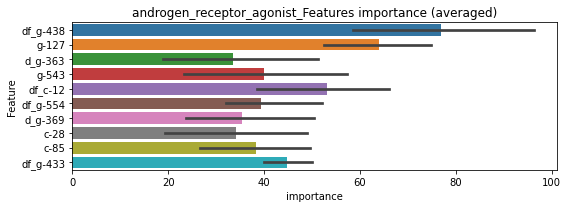

len(train_index) : 2462
len(valid_index) : 2462
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025329	valid_1's binary_logloss: 0.0801815
[200]	training's binary_logloss: 0.00452978	valid_1's binary_logloss: 0.0575625


len(train_index) : 2462
len(valid_index) : 2462


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0022663	valid_1's binary_logloss: 0.0541342


================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281767	valid_1's binary_logloss: 0.0693153
[200]	training's binary_logloss: 0.00509064	valid_1's binary_logloss: 0.0397519
[300]	training's binary_logloss: 0.00144179	valid_1's binary_logloss: 0.0318603
[400]	training's binary_logloss: 0.000686281	valid_1's binary_logloss: 0.0298487
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000723423	valid_1's binary_logloss: 0.0296271


androgen_receptor_agonist logloss: 0.04188066426438796
androgen_receptor_antagonist , len(trt) : 89


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147775	valid_1's binary_logloss: 0.315529
[200]	training's binary_logloss: 0.0435744	valid_1's binary_logloss: 0.207424
[300]	training's binary_logloss: 0.0162179	valid_1's binary_logloss: 0.164671
[400]	training's binary_logloss: 0.00785587	valid_1's binary_logloss: 0.143163
[500]	training's binary_logloss: 0.00478649	valid_1's binary_logloss: 0.13318
[600]	training's binary_logloss: 0.00347329	valid_1's binary_logloss: 0.127013
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00306959	valid_1's binary_logloss: 0.124685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147309	valid_1's binary_logloss: 0.331834
[200]	training's binary_logloss: 0.0419112	valid_1's binary_logloss: 0.223064
[300]	training's binary_logloss: 0.0151077	valid_1's binary_logloss: 0.181095
[400]	training's binary_logloss: 0.00726614	valid_1's binary_l

1 / 3 AUC score:0.986
Threshold: 0.4194599273751126
Remove_noisy_labels: 46 → positive_corect_labels: 477/954
30th percentile: 0.04621


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00531057	valid_1's binary_logloss: 0.156339


p_label_rate: 0.03039 Vs.target_rate: 0.00378, Num_p_label: 121.0, conf_0:0.04621, conf_1:0.51318
Num_p_label: 121.0, Expected: 15.0, Adj_threshold_1: 0.42
Num_p_label: 82.0, Expected: 15.0, Adj_threshold_2: 0.46
Num_p_label: 58.0, Expected: 15.0, Adj_threshold_3: 0.50
Num_p_label: 32.0, Expected: 15.0, Adj_threshold_4: 0.54
Num_p_label: 21.0, Expected: 15.0, Adj_threshold_5: 0.58
threshold:0.58, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:477.0/954, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146403	valid_1's binary_logloss: 0.339522
[200]	training's binary_logloss: 0.0411832	valid_1's binary_logloss: 0.209091
[300]	training's binary_logloss: 0.014853	valid_1's binary_logloss: 0.159028
[400]	training's binary_logloss: 0.0071735	valid_1's binary_logloss: 0.132134
[500]	training's binary_logloss: 0.00444403	valid_1's binary_logloss: 0.119134
[600]	training's binary_logloss: 0.00321652	valid_1's binary_logloss: 0.109788
[700]	training's binary_logloss: 0.0026048	valid_1's binary_logloss: 0.104285
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.00239259	valid_1's binary_logloss: 0.101848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137171	valid_1's binary_logloss: 0.304444
[200]	training's binary_logloss: 0.0391727	valid_1's binary_logloss: 0.195963
[300]	training's binary_logloss: 0.0144506	valid_1's binary_log

2 / 3 AUC score:0.995
Threshold: 0.5794599273751126
Remove_noisy_labels: 26 → positive_corect_labels: 454.0/928
30th percentile: 0.03251
p_label_rate: 0.00979 Vs.target_rate: 0.00378, Num_p_label: 39.0, conf_0:0.03251, conf_1:0.57946
threshold:0.58, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:454.0/928, y_label_rate: 0.48922
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13837	valid_1's binary_logloss: 0.306722
[200]	training's binary_logloss: 0.0390612	valid_1's binary_logloss: 0.193317
[300]	training's binary_logloss: 0.0140436	valid_1's binary_logloss: 0.147496
[400]	training's binary_logloss: 0.00678363	valid_1's binary_logloss: 0.123057
[500]	training's binary_logloss: 0.00426222	valid_1's binary_logloss: 0.110747
[600]	training's binary_logloss: 0.00314695	valid_1's binary_logloss: 0.104883
[700]	training's binary_logloss: 0.00258136	valid_1's binary_logloss: 0.101581
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.00237488	valid_1's binary_logloss: 0.0994936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136259	valid_1's binary_logloss: 0.284292
[200]	training's binary_logloss: 0.0379509	valid_1's binary_logloss: 0.174722
[300]	training's binary_logloss: 0.0135047	valid_1's binary_

3 / 3 AUC score:0.997
Threshold: 0.5794599273751126
Remove_noisy_labels: 30 → positive_corect_labels: 431.0/898
30th percentile: 0.02639
p_label_rate: 0.00628 Vs.target_rate: 0.00378, Num_p_label: 25.0, conf_0:0.02639, conf_1:0.57946
threshold:0.58, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:456.0/4880, y_label_rate: 0.09344


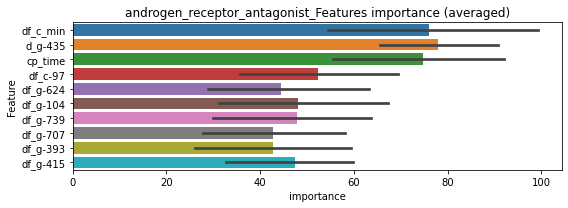

len(train_index) : 2440
len(valid_index) : 2440
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416817	valid_1's binary_logloss: 0.106624
[200]	training's binary_logloss: 0.00959786	valid_1's binary_logloss: 0.0784428


len(train_index) : 2440
len(valid_index) : 2440


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00447583	valid_1's binary_logloss: 0.0740756


================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421809	valid_1's binary_logloss: 0.0979462
[200]	training's binary_logloss: 0.00979062	valid_1's binary_logloss: 0.0655504


androgen_receptor_antagonist logloss: 0.06694960361261848


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00330783	valid_1's binary_logloss: 0.0598236


anesthetic_-_local , len(trt) : 80


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141256	valid_1's binary_logloss: 0.317884
[200]	training's binary_logloss: 0.0397732	valid_1's binary_logloss: 0.208414
[300]	training's binary_logloss: 0.0141286	valid_1's binary_logloss: 0.163176
[400]	training's binary_logloss: 0.00678407	valid_1's binary_logloss: 0.144107
[500]	training's binary_logloss: 0.00414784	valid_1's binary_logloss: 0.136691
[600]	training's binary_logloss: 0.00302581	valid_1's binary_logloss: 0.131809
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00276963	valid_1's binary_logloss: 0.13097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13903	valid_1's binary_logloss: 0.31573
[200]	training's binary_logloss: 0.0381858	valid_1's binary_logloss: 0.209889
[300]	training's binary_logloss: 0.0136788	valid_1's binary_logloss: 0.172789
[400]	training's binary_logloss: 0.00654855	valid_1's binary_log

1 / 3 AUC score:0.985
Threshold: 0.41689932897356957
Remove_noisy_labels: 52 → positive_corect_labels: 474/948
30th percentile: 0.03403
p_label_rate: 0.04219 Vs.target_rate: 0.00343, Num_p_label: 168.0, conf_0:0.03403, conf_1:0.49915
Num_p_label: 168.0, Expected: 13.6, Adj_threshold_1: 0.42
Num_p_label: 126.0, Expected: 13.6, Adj_threshold_2: 0.46
Num_p_label: 100.0, Expected: 13.6, Adj_threshold_3: 0.50
Num_p_label: 73.0, Expected: 13.6, Adj_threshold_4: 0.54
Num_p_label: 51.0, Expected: 13.6, Adj_threshold_5: 0.58
Num_p_label: 40.0, Expected: 13.6, Adj_threshold_6: 0.62
Num_p_label: 26.0, Expected: 13.6, Adj_threshold_7: 0.66
Num_p_label: 16.0, Expected: 13.6, Adj_threshold_8: 0.70
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:474.0/948, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132756	valid_1's binary_logloss: 0.29373
[200]	training's binary_logloss: 0.0361673	valid_1's binary_logloss: 0.175714
[300]	training's binary_logloss: 0.0129682	valid_1's binary_logloss: 0.130007
[400]	training's binary_logloss: 0.00620333	valid_1's binary_logloss: 0.111657
[500]	training's binary_logloss: 0.00386838	valid_1's binary_logloss: 0.104622
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00320723	valid_1's binary_logloss: 0.1022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130406	valid_1's binary_logloss: 0.285094
[200]	training's binary_logloss: 0.0345468	valid_1's binary_logloss: 0.169282
[300]	training's binary_logloss: 0.0122377	valid_1's binary_logloss: 0.125649
[400]	training's binary_logloss: 0.00598451	valid_1's binary_logloss: 0.109784
[500]	training's binary_logloss: 0.00376007	valid_1's binary_log

2 / 3 AUC score:0.993
Threshold: 0.6968993289735697
Remove_noisy_labels: 27 → positive_corect_labels: 451.0/921
30th percentile: 0.03076
p_label_rate: 0.00603 Vs.target_rate: 0.00343, Num_p_label: 24.0, conf_0:0.03076, conf_1:0.69690
threshold:0.70, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:451.0/921, y_label_rate: 0.48969
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130112	valid_1's binary_logloss: 0.267789
[200]	training's binary_logloss: 0.0337668	valid_1's binary_logloss: 0.150828
[300]	training's binary_logloss: 0.0117594	valid_1's binary_logloss: 0.108138
[400]	training's binary_logloss: 0.00577362	valid_1's binary_logloss: 0.0904626
[500]	training's binary_logloss: 0.00368856	valid_1's binary_logloss: 0.0823288
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.0029252	valid_1's binary_logloss: 0.0789185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12911	valid_1's binary_logloss: 0.263587
[200]	training's binary_logloss: 0.0346399	valid_1's binary_logloss: 0.153263
[300]	training's binary_logloss: 0.0120516	valid_1's binary_logloss: 0.110717
[400]	training's binary_logloss: 0.00592141	valid_1's binary_logloss: 0.094008
[500]	training's binary_logloss: 0.0037432	valid_1's binary_

3 / 3 AUC score:0.995
Threshold: 0.6968993289735697
Remove_noisy_labels: 19 → positive_corect_labels: 433.0/902
30th percentile: 0.02414
p_label_rate: 0.00804 Vs.target_rate: 0.00343, Num_p_label: 32.0, conf_0:0.01779, conf_1:0.69690
threshold:0.70, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:465.0/4884, y_label_rate: 0.09521


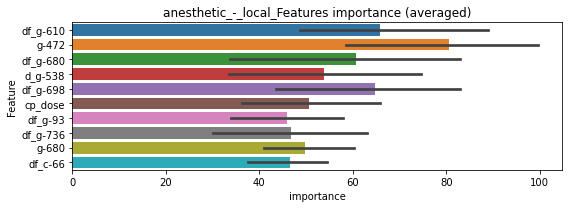

len(train_index) : 2442
len(valid_index) : 2442
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369313	valid_1's binary_logloss: 0.104286
[200]	training's binary_logloss: 0.00784774	valid_1's binary_logloss: 0.0727674
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00278253	valid_1's binary_logloss: 0.0658839


len(train_index) : 2442
len(valid_index) : 2442
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362608	valid_1's binary_logloss: 0.106778
[200]	training's binary_logloss: 0.00752591	valid_1's binary_logloss: 0.0719946
[300]	training's binary_logloss: 0.00216107	valid_1's binary_logloss: 0.0632982
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00110895	valid_1's binary_logloss: 0.0603702


anesthetic_-_local logloss: 0.0631270652537354
angiogenesis_inhibitor , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930455	valid_1's binary_logloss: 0.17541
[200]	training's binary_logloss: 0.0194801	valid_1's binary_logloss: 0.0795869
[300]	training's binary_logloss: 0.00638696	valid_1's binary_logloss: 0.0514596
[400]	training's binary_logloss: 0.00325403	valid_1's binary_logloss: 0.0427435
[500]	training's binary_logloss: 0.00216709	valid_1's binary_logloss: 0.0392199
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00178887	valid_1's binary_logloss: 0.0367793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090632	valid_1's binary_logloss: 0.169364
[200]	training's binary_logloss: 0.0197885	valid_1's binary_logloss: 0.0775752
[300]	training's binary_logloss: 0.0065074	valid_1's binary_logloss: 0.0484631
[400]	training's binary_logloss: 0.00335045	valid_1's binary_logloss: 0.0380023
[500]	training's binary_logloss: 0.00222881	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.754603092068417
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00575
p_label_rate: 0.00000 Vs.target_rate: 0.00161, Num_p_label: 0.0, conf_0:0.00565, conf_1:0.75460
Num_p_label: 0.0, Expected: 6.4, Adj_threshold_1: 0.75
Num_p_label: 1.0, Expected: 6.4, Adj_threshold_2: 0.71
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_3: 0.67
Num_p_label: 5.0, Expected: 6.4, Adj_threshold_4: 0.63
threshold:0.63, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909262	valid_1's binary_logloss: 0.178522
[200]	training's binary_logloss: 0.0187972	valid_1's binary_logloss: 0.0815729
[300]	training's binary_logloss: 0.00609371	valid_1's binary_logloss: 0.0552334
[400]	training's binary_logloss: 0.00313769	valid_1's binary_logloss: 0.0444683
[500]	training's binary_logloss: 0.00209773	valid_1's binary_logloss: 0.0397066
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00187667	valid_1's binary_logloss: 0.0381237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910997	valid_1's binary_logloss: 0.161638
[200]	training's binary_logloss: 0.018855	valid_1's binary_logloss: 0.0671627
[300]	training's binary_logloss: 0.00629719	valid_1's binary_logloss: 0.040077
[400]	training's binary_logloss: 0.00324782	valid_1's binary_logloss: 0.0300157
[500]	training's binary_logloss: 0.00219706	valid_1

2 / 3 AUC score:1.000
Threshold: 0.6346030920684169
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/990
30th percentile: 0.00547
p_label_rate: 0.00100 Vs.target_rate: 0.00161, Num_p_label: 4.0, conf_0:0.00547, conf_1:0.63460
threshold:0.63, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:494.0/990, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896737	valid_1's binary_logloss: 0.189935
[200]	training's binary_logloss: 0.0184992	valid_1's binary_logloss: 0.0969086
[300]	training's binary_logloss: 0.0060195	valid_1's binary_logloss: 0.068396
[400]	training's binary_logloss: 0.00308294	valid_1's binary_logloss: 0.0555628
[500]	training's binary_logloss: 0.00206919	valid_1's binary_logloss: 0.0502537
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00208197	valid_1's binary_logloss: 0.0501731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878469	valid_1's binary_logloss: 0.174273
[200]	training's binary_logloss: 0.0185138	valid_1's binary_logloss: 0.0781983
[300]	training's binary_logloss: 0.00615899	valid_1's binary_logloss: 0.0489818
[400]	training's binary_logloss: 0.00315921	valid_1's binary_logloss: 0.0393039
[500]	training's binary_logloss: 0.00214071	valid_1

3 / 3 AUC score:1.000
Threshold: 0.6346030920684169
Remove_noisy_labels: 14 → positive_corect_labels: 481.0/976
30th percentile: 0.00578
p_label_rate: 0.00151 Vs.target_rate: 0.00161, Num_p_label: 6.0, conf_0:0.00524, conf_1:0.63460
threshold:0.63, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:487.0/4958, y_label_rate: 0.09823


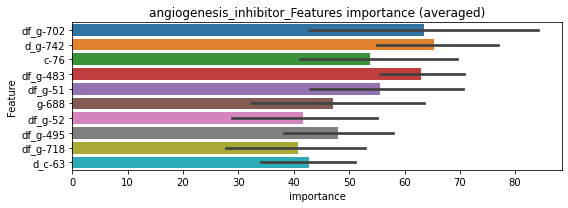

len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252851	valid_1's binary_logloss: 0.0466015
[200]	training's binary_logloss: 0.00375027	valid_1's binary_logloss: 0.017269
[300]	training's binary_logloss: 0.00105604	valid_1's binary_logloss: 0.0118524
[400]	training's binary_logloss: 0.000521945	valid_1's binary_logloss: 0.0104933
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000436688	valid_1's binary_logloss: 0.0101541


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260807	valid_1's binary_logloss: 0.0440968
[200]	training's binary_logloss: 0.00395893	valid_1's binary_logloss: 0.0144317
[300]	training's binary_logloss: 0.00109332	valid_1's binary_logloss: 0.00901539
[400]	training's binary_logloss: 0.000531121	valid_1's binary_logloss: 0.00775112
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000384827	valid_1's binary_logloss: 0.00733341


angiogenesis_inhibitor logloss: 0.00874373482823592
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954882	valid_1's binary_logloss: 0.198067
[200]	training's binary_logloss: 0.0205463	valid_1's binary_logloss: 0.0976598
[300]	training's binary_logloss: 0.00656727	valid_1's binary_logloss: 0.0682666
[400]	training's binary_logloss: 0.00329748	valid_1's binary_logloss: 0.0584569
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00323001	valid_1's binary_logloss: 0.0582886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966843	valid_1's binary_logloss: 0.182273
[200]	training's binary_logloss: 0.0205302	valid_1's binary_logloss: 0.0755297
[300]	training's binary_logloss: 0.00666999	valid_1's binary_logloss: 0.0459352
[400]	training's binary_logloss: 0.00340837	valid_1's binary_logloss: 0.0338657
[500]	training's binary_logloss: 0.0022906	valid_1's binary_logloss: 0.0295003


1 / 3 AUC score:0.999


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00187966	valid_1's binary_logloss: 0.026909


Threshold: 0.43723288511758623
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00927
p_label_rate: 0.00502 Vs.target_rate: 0.00165, Num_p_label: 20.0, conf_0:0.00927, conf_1:0.43723
Num_p_label: 20.0, Expected: 6.6, Adj_threshold_1: 0.44
Num_p_label: 19.0, Expected: 6.6, Adj_threshold_2: 0.48
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_3: 0.52
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_4: 0.56
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_5: 0.60
threshold:0.60, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951354	valid_1's binary_logloss: 0.186192
[200]	training's binary_logloss: 0.0199068	valid_1's binary_logloss: 0.0791246
[300]	training's binary_logloss: 0.00637713	valid_1's binary_logloss: 0.0496495
[400]	training's binary_logloss: 0.00319985	valid_1's binary_logloss: 0.0383422
[500]	training's binary_logloss: 0.00212629	valid_1's binary_logloss: 0.0337449
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00174878	valid_1's binary_logloss: 0.0311295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958088	valid_1's binary_logloss: 0.185771
[200]	training's binary_logloss: 0.0209608	valid_1's binary_logloss: 0.0830893
[300]	training's binary_logloss: 0.00684589	valid_1's binary_logloss: 0.0500033
[400]	training's binary_logloss: 0.0034583	valid_1's binary_logloss: 0.0376429
[500]	training's binary_logloss: 0.0023002	valid_1

2 / 3 AUC score:1.000


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00188963	valid_1's binary_logloss: 0.0296572


Threshold: 0.5972328851175863
Remove_noisy_labels: 5 → positive_corect_labels: 490.0/985
30th percentile: 0.00723
p_label_rate: 0.00276 Vs.target_rate: 0.00165, Num_p_label: 11.0, conf_0:0.00723, conf_1:0.59723
threshold:0.60, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:490.0/985, y_label_rate: 0.49746
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909854	valid_1's binary_logloss: 0.184687
[200]	training's binary_logloss: 0.0193757	valid_1's binary_logloss: 0.0771882
[300]	training's binary_logloss: 0.00639902	valid_1's binary_logloss: 0.0446409
[400]	training's binary_logloss: 0.00322209	valid_1's binary_logloss: 0.0333348
[500]	training's binary_logloss: 0.00214753	valid_1's binary_logloss: 0.0266925
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00179186	valid_1's binary_logloss: 0.0242976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916899	valid_1's binary_logloss: 0.173911
[200]	training's binary_logloss: 0.0194734	valid_1's binary_logloss: 0.0821286
[300]	training's binary_logloss: 0.00646642	valid_1's binary_logloss: 0.0574492


3 / 3 AUC score:1.000
Threshold: 0.5972328851175863
Remove_noisy_labels: 8 → positive_corect_labels: 482.0/977
30th percentile: 0.01000


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00363403	valid_1's binary_logloss: 0.0492376


p_label_rate: 0.00176 Vs.target_rate: 0.00165, Num_p_label: 7.0, conf_0:0.01000, conf_1:0.59723
threshold:0.60, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:489.0/4959, y_label_rate: 0.09861


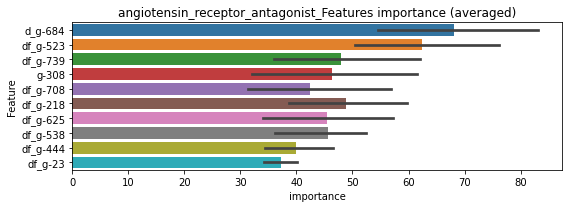

len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256165	valid_1's binary_logloss: 0.0574916
[200]	training's binary_logloss: 0.00394922	valid_1's binary_logloss: 0.0308982
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00136221	valid_1's binary_logloss: 0.0271008


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253862	valid_1's binary_logloss: 0.0526221
[200]	training's binary_logloss: 0.00402844	valid_1's binary_logloss: 0.0241377
[300]	training's binary_logloss: 0.00113413	valid_1's binary_logloss: 0.0175965
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000621245	valid_1's binary_logloss: 0.0160406


angiotensin_receptor_antagonist logloss: 0.021571814666986346
anti-inflammatory , len(trt) : 73


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135619	valid_1's binary_logloss: 0.305147
[200]	training's binary_logloss: 0.036023	valid_1's binary_logloss: 0.196212
[300]	training's binary_logloss: 0.0128437	valid_1's binary_logloss: 0.155112
[400]	training's binary_logloss: 0.00635532	valid_1's binary_logloss: 0.140032
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00479574	valid_1's binary_logloss: 0.136207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138911	valid_1's binary_logloss: 0.306978
[200]	training's binary_logloss: 0.0380807	valid_1's binary_logloss: 0.198444
[300]	training's binary_logloss: 0.0135236	valid_1's binary_logloss: 0.156431
[400]	training's binary_logloss: 0.00644723	valid_1's binary_logloss: 0.138523


1 / 3 AUC score:0.985
Threshold: 0.4200528919688252


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00470727	valid_1's binary_logloss: 0.133105


Remove_noisy_labels: 46 → positive_corect_labels: 477/954
30th percentile: 0.03942
p_label_rate: 0.02888 Vs.target_rate: 0.00315, Num_p_label: 115.0, conf_0:0.03942, conf_1:0.52947
Num_p_label: 115.0, Expected: 12.5, Adj_threshold_1: 0.42
Num_p_label: 89.0, Expected: 12.5, Adj_threshold_2: 0.46
Num_p_label: 59.0, Expected: 12.5, Adj_threshold_3: 0.50
Num_p_label: 38.0, Expected: 12.5, Adj_threshold_4: 0.54
Num_p_label: 25.0, Expected: 12.5, Adj_threshold_5: 0.58
Num_p_label: 16.0, Expected: 12.5, Adj_threshold_6: 0.62
threshold:0.62, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:477.0/954, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129339	valid_1's binary_logloss: 0.286824
[200]	training's binary_logloss: 0.0351292	valid_1's binary_logloss: 0.167634
[300]	training's binary_logloss: 0.0122848	valid_1's binary_logloss: 0.120346
[400]	training's binary_logloss: 0.00601449	valid_1's binary_logloss: 0.10112
[500]	training's binary_logloss: 0.00377303	valid_1's binary_logloss: 0.0901162
[600]	training's binary_logloss: 0.002816	valid_1's binary_logloss: 0.0861696
[700]	training's binary_logloss: 0.00235473	valid_1's binary_logloss: 0.0831649
Early stopping, best iteration is:
[747]	training's binary_logloss: 0.00225944	valid_1's binary_logloss: 0.0822616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131839	valid_1's binary_logloss: 0.277692
[200]	training's binary_logloss: 0.0359468	valid_1's binary_logloss: 0.176378
[300]	training's binary_logloss: 0.0123847	valid_1's binary

2 / 3 AUC score:0.994
Threshold: 0.6200528919688253
Remove_noisy_labels: 35 → positive_corect_labels: 449.0/919
30th percentile: 0.02236
p_label_rate: 0.00879 Vs.target_rate: 0.00315, Num_p_label: 35.0, conf_0:0.02236, conf_1:0.62005
threshold:0.62, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:449.0/919, y_label_rate: 0.48857
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122298	valid_1's binary_logloss: 0.255751
[200]	training's binary_logloss: 0.0315633	valid_1's binary_logloss: 0.15012
[300]	training's binary_logloss: 0.011303	valid_1's binary_logloss: 0.108555
[400]	training's binary_logloss: 0.00564825	valid_1's binary_logloss: 0.0886643
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00439214	valid_1's binary_logloss: 0.083252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125517	valid_1's binary_logloss: 0.260482
[200]	training's binary_logloss: 0.0331405	valid_1's binary_logloss: 0.150602
[300]	training's binary_logloss: 0.0115376	valid_1's binary_logloss: 0.110653
[400]	training's binary_logloss: 0.00573886	valid_1's binary_logloss: 0.0923219


3 / 3 AUC score:0.996
Threshold: 0.6200528919688253
Remove_noisy_labels: 14 → positive_corect_labels: 435.0/905
30th percentile: 0.02801


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0049159	valid_1's binary_logloss: 0.0884476


p_label_rate: 0.00904 Vs.target_rate: 0.00315, Num_p_label: 36.0, conf_0:0.02801, conf_1:0.62005
threshold:0.62, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:471.0/4887, y_label_rate: 0.09638


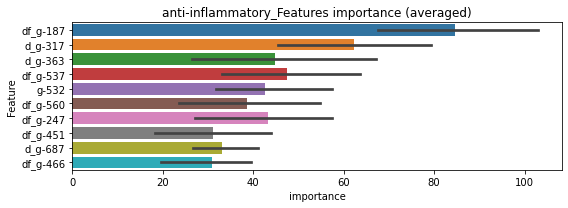

len(train_index) : 2443
len(valid_index) : 2444
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456359	valid_1's binary_logloss: 0.0993786
[200]	training's binary_logloss: 0.00975593	valid_1's binary_logloss: 0.0622302
[300]	training's binary_logloss: 0.00269775	valid_1's binary_logloss: 0.0554567
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00293711	valid_1's binary_logloss: 0.0553959


len(train_index) : 2444
len(valid_index) : 2443
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470159	valid_1's binary_logloss: 0.101372
[200]	training's binary_logloss: 0.0099097	valid_1's binary_logloss: 0.0657928


anti-inflammatory logloss: 0.05850014388062086


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00590152	valid_1's binary_logloss: 0.0616057


antiarrhythmic , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741394	valid_1's binary_logloss: 0.134975
[200]	training's binary_logloss: 0.0130703	valid_1's binary_logloss: 0.0427568
[300]	training's binary_logloss: 0.00423603	valid_1's binary_logloss: 0.0234679
[400]	training's binary_logloss: 0.00226506	valid_1's binary_logloss: 0.0176689
[500]	training's binary_logloss: 0.00164134	valid_1's binary_logloss: 0.0149699
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00148545	valid_1's binary_logloss: 0.0142673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753753	valid_1's binary_logloss: 0.129549
[200]	training's binary_logloss: 0.0136018	valid_1's binary_logloss: 0.0454859
[300]	training's binary_logloss: 0.00435613	valid_1's binary_logloss: 0.0251162
[400]	training's binary_logloss: 0.00231165	valid_1's binary_logloss: 0.0181131
[500]	training's binary_logloss: 0.00163998	valid

1 / 3 AUC score:1.000
Threshold: 0.471579376969119
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00284
p_label_rate: 0.00126 Vs.target_rate: 0.00108, Num_p_label: 5.0, conf_0:0.00284, conf_1:0.47158
threshold:0.47, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750195	valid_1's binary_logloss: 0.131868
[200]	training's binary_logloss: 0.0132529	valid_1's binary_logloss: 0.0470943
[300]	training's binary_logloss: 0.00420429	valid_1's binary_logloss: 0.0269063
[400]	training's binary_logloss: 0.00223841	valid_1's binary_logloss: 0.0208303
[500]	training's binary_logloss: 0.0016028	valid_1's binary_logloss: 0.0177471
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00145427	valid_1's binary_logloss: 0.0168278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771481	valid_1's binary_logloss: 0.118995
[200]	training's binary_logloss: 0.0138861	valid_1's binary_logloss: 0.0367831
[300]	training's binary_logloss: 0.00439479	valid_1's binary_logloss: 0.0179847
[400]	training's binary_logloss: 0.00235013	valid_1's binary_logloss: 0.0123647
[500]	training's binary_logloss: 0.00167087	valid_

2 / 3 AUC score:1.000
Threshold: 0.471579376969119
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/997
30th percentile: 0.00266
p_label_rate: 0.00151 Vs.target_rate: 0.00108, Num_p_label: 6.0, conf_0:0.00266, conf_1:0.47158
threshold:0.47, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/997, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716005	valid_1's binary_logloss: 0.140231
[200]	training's binary_logloss: 0.0124865	valid_1's binary_logloss: 0.0525223
[300]	training's binary_logloss: 0.00400773	valid_1's binary_logloss: 0.0323868
[400]	training's binary_logloss: 0.00214095	valid_1's binary_logloss: 0.0268751
[500]	training's binary_logloss: 0.00156827	valid_1's binary_logloss: 0.0241268
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00142166	valid_1's binary_logloss: 0.0230082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752007	valid_1's binary_logloss: 0.120652
[200]	training's binary_logloss: 0.013868	valid_1's binary_logloss: 0.0375048
[300]	training's binary_logloss: 0.0043305	valid_1's binary_logloss: 0.0177321
[400]	training's binary_logloss: 0.00232116	valid_1's binary_logloss: 0.0124224
[500]	training's binary_logloss: 0.00166656	valid_1

3 / 3 AUC score:1.000
Threshold: 0.471579376969119
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/994
30th percentile: 0.00261
p_label_rate: 0.00176 Vs.target_rate: 0.00108, Num_p_label: 7.0, conf_0:0.00261, conf_1:0.47158
threshold:0.47, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:502.0/4976, y_label_rate: 0.10088


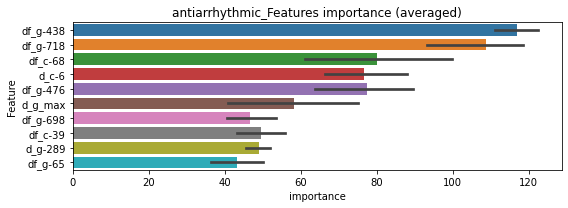

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180912	valid_1's binary_logloss: 0.0377549
[200]	training's binary_logloss: 0.00237351	valid_1's binary_logloss: 0.0143596
[300]	training's binary_logloss: 0.00070083	valid_1's binary_logloss: 0.0110241
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00048326	valid_1's binary_logloss: 0.0106497


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179	valid_1's binary_logloss: 0.0322454
[200]	training's binary_logloss: 0.00241812	valid_1's binary_logloss: 0.0128185
[300]	training's binary_logloss: 0.000711361	valid_1's binary_logloss: 0.00976684


antiarrhythmic logloss: 0.01010434736118099


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000563157	valid_1's binary_logloss: 0.00955896


antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108407	valid_1's binary_logloss: 0.20942
[200]	training's binary_logloss: 0.0254448	valid_1's binary_logloss: 0.108836
[300]	training's binary_logloss: 0.00839722	valid_1's binary_logloss: 0.0727478
[400]	training's binary_logloss: 0.00417454	valid_1's binary_logloss: 0.0593879
[500]	training's binary_logloss: 0.00269143	valid_1's binary_logloss: 0.0536029
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00218775	valid_1's binary_logloss: 0.0504057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101972	valid_1's binary_logloss: 0.235882
[200]	training's binary_logloss: 0.0235901	valid_1's binary_logloss: 0.13751
[300]	training's binary_logloss: 0.00784001	valid_1's binary_logloss: 0.104908
[400]	training's binary_logloss: 0.00391813	valid_1's binary_logloss: 0.0868457
[500]	training's binary_logloss: 0.00255713	valid_1's bi

1 / 3 AUC score:0.997
Threshold: 0.3656972092425483
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentile: 0.00982
p_label_rate: 0.01030 Vs.target_rate: 0.00191, Num_p_label: 41.0, conf_0:0.00982, conf_1:0.45420
Num_p_label: 41.0, Expected: 7.6, Adj_threshold_1: 0.37
Num_p_label: 28.0, Expected: 7.6, Adj_threshold_2: 0.41
Num_p_label: 20.0, Expected: 7.6, Adj_threshold_3: 0.45
Num_p_label: 15.0, Expected: 7.6, Adj_threshold_4: 0.49
Num_p_label: 9.0, Expected: 7.6, Adj_threshold_5: 0.53
threshold:0.53, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107326	valid_1's binary_logloss: 0.211251
[200]	training's binary_logloss: 0.0247515	valid_1's binary_logloss: 0.104545
[300]	training's binary_logloss: 0.00803882	valid_1's binary_logloss: 0.068679
[400]	training's binary_logloss: 0.00404761	valid_1's binary_logloss: 0.0554868
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00427183	valid_1's binary_logloss: 0.0554256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105826	valid_1's binary_logloss: 0.196394
[200]	training's binary_logloss: 0.0243804	valid_1's binary_logloss: 0.0884406
[300]	training's binary_logloss: 0.00815444	valid_1's binary_logloss: 0.0559743
[400]	training's binary_logloss: 0.00410069	valid_1's binary_logloss: 0.0447146


2 / 3 AUC score:0.999
Threshold: 0.5256972092425483
Remove_noisy_labels: 8 → positive_corect_labels: 485.0/970


Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00318579	valid_1's binary_logloss: 0.0420951


30th percentile: 0.01400
p_label_rate: 0.00427 Vs.target_rate: 0.00191, Num_p_label: 17.0, conf_0:0.01400, conf_1:0.52570
threshold:0.53, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102231	valid_1's binary_logloss: 0.201275
[200]	training's binary_logloss: 0.0229176	valid_1's binary_logloss: 0.0970469
[300]	training's binary_logloss: 0.00755591	valid_1's binary_logloss: 0.0648287
[400]	training's binary_logloss: 0.00385442	valid_1's binary_logloss: 0.0535534
[500]	training's binary_logloss: 0.00254537	valid_1's binary_logloss: 0.0486025
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00205395	valid_1's binary_logloss: 0.0455345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105767	valid_1's binary_logloss: 0.204164
[200]	training's binary_logloss: 0.0242046	valid_1's binary_logloss: 0.0999256
[300]	training's binary_logloss: 0.0079363	valid_1's binary_logloss: 0.0654893
[400]	training's binary_logloss: 0.00395858	valid_1's binary_logloss: 0.0522056
[500]	training's binary_logloss: 0.00257942	valid_1'

3 / 3 AUC score:0.999
Threshold: 0.5256972092425483
Remove_noisy_labels: 7 → positive_corect_labels: 479.0/963
30th percentile: 0.00878
p_label_rate: 0.00402 Vs.target_rate: 0.00191, Num_p_label: 16.0, conf_0:0.00878, conf_1:0.52570
threshold:0.53, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:495.0/4945, y_label_rate: 0.10010


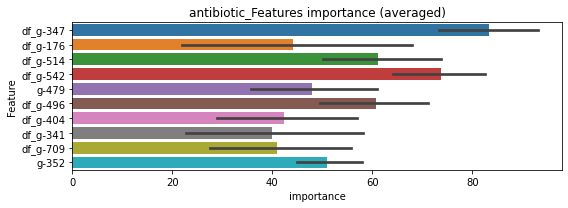

len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305097	valid_1's binary_logloss: 0.0659148
[200]	training's binary_logloss: 0.00507777	valid_1's binary_logloss: 0.0366327
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00162059	valid_1's binary_logloss: 0.0301493


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308768	valid_1's binary_logloss: 0.06506
[200]	training's binary_logloss: 0.00538073	valid_1's binary_logloss: 0.0321276
[300]	training's binary_logloss: 0.00149062	valid_1's binary_logloss: 0.024707
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00115379	valid_1's binary_logloss: 0.0242056


antibiotic logloss: 0.027178029519286825
anticonvulsant , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644746	valid_1's binary_logloss: 0.103504
[200]	training's binary_logloss: 0.0103335	valid_1's binary_logloss: 0.029931
[300]	training's binary_logloss: 0.00324104	valid_1's binary_logloss: 0.0155386
[400]	training's binary_logloss: 0.00177744	valid_1's binary_logloss: 0.0109815
[500]	training's binary_logloss: 0.00135416	valid_1's binary_logloss: 0.00950872
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00129822	valid_1's binary_logloss: 0.00920458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633967	valid_1's binary_logloss: 0.0977605
[200]	training's binary_logloss: 0.0105459	valid_1's binary_logloss: 0.0254638
[300]	training's binary_logloss: 0.00332829	valid_1's binary_logloss: 0.0111479
[400]	training's binary_logloss: 0.00181514	valid_1's binary_logloss: 0.00735825
[500]	training's binary_logloss: 0.00137372	va

1 / 3 AUC score:1.000
Threshold: 0.4729587077694388
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00212
p_label_rate: 0.00025 Vs.target_rate: 0.00082, Num_p_label: 1.0, conf_0:0.00212, conf_1:0.47296
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.47
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.43
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.39
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.35
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.31
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_6: 0.27
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_7: 0.23
threshold:0.23, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644746	valid_1's binary_logloss: 0.103504
[200]	training's binary_logloss: 0.0103335	valid_1's binary_logloss: 0.029931
[300]	training's binary_logloss: 0.00324104	valid_1's binary_logloss: 0.0155386
[400]	training's binary_logloss: 0.00177744	valid_1's binary_logloss: 0.0109815
[500]	training's binary_logloss: 0.00135416	valid_1's binary_logloss: 0.00950872
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00129822	valid_1's binary_logloss: 0.00920458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633967	valid_1's binary_logloss: 0.0977605
[200]	training's binary_logloss: 0.0105459	valid_1's binary_logloss: 0.0254638
[300]	training's binary_logloss: 0.00332829	valid_1's binary_logloss: 0.0111479
[400]	training's binary_logloss: 0.00181514	valid_1's binary_logloss: 0.00735825
[500]	training's binary_logloss: 0.00137372	va

2 / 3 AUC score:1.000
Threshold: 0.23295870776943892
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00212
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00212, conf_1:0.33443
threshold:0.23, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064494	valid_1's binary_logloss: 0.0978153
[200]	training's binary_logloss: 0.0106999	valid_1's binary_logloss: 0.0270785
[300]	training's binary_logloss: 0.00333908	valid_1's binary_logloss: 0.0127199
[400]	training's binary_logloss: 0.00180516	valid_1's binary_logloss: 0.00862675
[500]	training's binary_logloss: 0.00135548	valid_1's binary_logloss: 0.00719945
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00128384	valid_1's binary_logloss: 0.00695585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634075	valid_1's binary_logloss: 0.101911
[200]	training's binary_logloss: 0.010351	valid_1's binary_logloss: 0.0275503
[300]	training's binary_logloss: 0.00327569	valid_1's binary_logloss: 0.0124479
[400]	training's binary_logloss: 0.00178049	valid_1's binary_logloss: 0.00814771
[500]	training's binary_logloss: 0.00135224	va

3 / 3 AUC score:1.000
Threshold: 0.23295870776943892
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00206
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00206, conf_1:0.33921
threshold:0.23, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:506.0/4981, y_label_rate: 0.10159


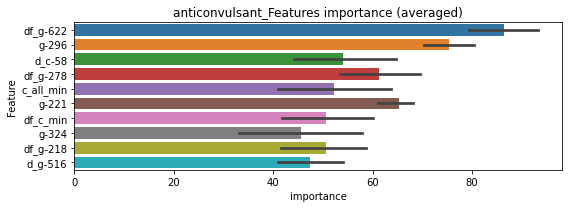

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171641	valid_1's binary_logloss: 0.0268929
[200]	training's binary_logloss: 0.00192612	valid_1's binary_logloss: 0.00949716
[300]	training's binary_logloss: 0.000551704	valid_1's binary_logloss: 0.00755145
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000360465	valid_1's binary_logloss: 0.00738289


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015709	valid_1's binary_logloss: 0.0231306
[200]	training's binary_logloss: 0.00186255	valid_1's binary_logloss: 0.00885135


anticonvulsant logloss: 0.007636022597885242


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000619862	valid_1's binary_logloss: 0.00788926


antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803676	valid_1's binary_logloss: 0.130941
[200]	training's binary_logloss: 0.0152549	valid_1's binary_logloss: 0.0408957
[300]	training's binary_logloss: 0.00485839	valid_1's binary_logloss: 0.0207928
[400]	training's binary_logloss: 0.00253787	valid_1's binary_logloss: 0.0147891
[500]	training's binary_logloss: 0.00176178	valid_1's binary_logloss: 0.0122851
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00155138	valid_1's binary_logloss: 0.0114575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818997	valid_1's binary_logloss: 0.14711
[200]	training's binary_logloss: 0.0153424	valid_1's binary_logloss: 0.0559563
[300]	training's binary_logloss: 0.00478231	valid_1's binary_logloss: 0.0292622
[400]	training's binary_logloss: 0.00245365	valid_1's binary_logloss: 0.0213548
[500]	training's binary_logloss: 0.00170439	valid_

1 / 3 AUC score:1.000
Threshold: 0.37698002713396206
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00359
p_label_rate: 0.00100 Vs.target_rate: 0.00117, Num_p_label: 4.0, conf_0:0.00359, conf_1:0.37698
threshold:0.38, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797385	valid_1's binary_logloss: 0.15636
[200]	training's binary_logloss: 0.0146234	valid_1's binary_logloss: 0.0569449
[300]	training's binary_logloss: 0.00469206	valid_1's binary_logloss: 0.0305619
[400]	training's binary_logloss: 0.00244679	valid_1's binary_logloss: 0.0214699
[500]	training's binary_logloss: 0.00171535	valid_1's binary_logloss: 0.0178599
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00151825	valid_1's binary_logloss: 0.0167922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800953	valid_1's binary_logloss: 0.150149
[200]	training's binary_logloss: 0.0144819	valid_1's binary_logloss: 0.0639249
[300]	training's binary_logloss: 0.00458907	valid_1's binary_logloss: 0.048153


2 / 3 AUC score:0.999
Threshold: 0.37698002713396206
Remove_noisy_labels: 6 → positive_corect_labels: 494.0/992


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00326382	valid_1's binary_logloss: 0.0453878


30th percentile: 0.00549
p_label_rate: 0.00352 Vs.target_rate: 0.00117, Num_p_label: 14.0, conf_0:0.00549, conf_1:0.37698
threshold:0.38, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:494.0/992, y_label_rate: 0.49798
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790537	valid_1's binary_logloss: 0.142464
[200]	training's binary_logloss: 0.0147013	valid_1's binary_logloss: 0.0483852
[300]	training's binary_logloss: 0.00465302	valid_1's binary_logloss: 0.0247381
[400]	training's binary_logloss: 0.00246473	valid_1's binary_logloss: 0.0171179
[500]	training's binary_logloss: 0.00171012	valid_1's binary_logloss: 0.0138518
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00149764	valid_1's binary_logloss: 0.0129626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785382	valid_1's binary_logloss: 0.13402
[200]	training's binary_logloss: 0.014473	valid_1's binary_logloss: 0.0480346
[300]	training's binary_logloss: 0.00455641	valid_1's binary_logloss: 0.0271744
[400]	training's binary_logloss: 0.00238683	valid_1's binary_logloss: 0.0207857
[500]	training's binary_logloss: 0.00168429	valid_1

3 / 3 AUC score:1.000
Threshold: 0.37698002713396206
Remove_noisy_labels: 1 → positive_corect_labels: 494.0/991
30th percentile: 0.00353
p_label_rate: 0.00402 Vs.target_rate: 0.00117, Num_p_label: 16.0, conf_0:0.00353, conf_1:0.39583
Num_p_label: 16.0, Expected: 4.7, Adj_threshold_1: 0.38
Num_p_label: 12.0, Expected: 4.7, Adj_threshold_2: 0.42
Num_p_label: 6.0, Expected: 4.7, Adj_threshold_3: 0.46
threshold:0.46, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/4973, y_label_rate: 0.10054


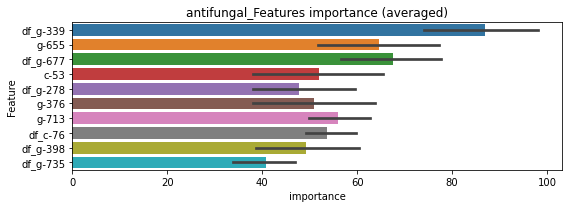

len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211408	valid_1's binary_logloss: 0.0371614
[200]	training's binary_logloss: 0.00299213	valid_1's binary_logloss: 0.0132862
[300]	training's binary_logloss: 0.000822814	valid_1's binary_logloss: 0.00958903
[400]	training's binary_logloss: 0.000423552	valid_1's binary_logloss: 0.00905115
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000364331	valid_1's binary_logloss: 0.0089924


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207672	valid_1's binary_logloss: 0.0420165
[200]	training's binary_logloss: 0.00288121	valid_1's binary_logloss: 0.0177754
[300]	training's binary_logloss: 0.000801581	valid_1's binary_logloss: 0.013299
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00049343	valid_1's binary_logloss: 0.0124863


antifungal logloss: 0.01073899737196579
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660047	valid_1's binary_logloss: 0.111048
[200]	training's binary_logloss: 0.0111549	valid_1's binary_logloss: 0.0385576
[300]	training's binary_logloss: 0.00344848	valid_1's binary_logloss: 0.0214645
[400]	training's binary_logloss: 0.00188261	valid_1's binary_logloss: 0.0169274
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00146011	valid_1's binary_logloss: 0.0151884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684654	valid_1's binary_logloss: 0.10254
[200]	training's binary_logloss: 0.0114962	valid_1's binary_logloss: 0.0263901
[300]	training's binary_logloss: 0.00360091	valid_1's binary_logloss: 0.0112303
[400]	training's binary_logloss: 0.00196422	valid_1's binary_logloss: 0.00728844
[500]	training's binary_logloss: 0.00150469	valid_1's binary_logloss: 0.00590902
Early stopping, best iteration is:
[546]	trainin

1 / 3 AUC score:1.000
Threshold: 0.7497747734647877
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00174
p_label_rate: 0.00025 Vs.target_rate: 0.00082, Num_p_label: 1.0, conf_0:0.00174, conf_1:0.74977
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.75
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_2: 0.71
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_3: 0.67
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_4: 0.63
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_5: 0.59
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_6: 0.55
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_7: 0.51
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_8: 0.47
threshold:0.47, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652209	valid_1's binary_logloss: 0.107473
[200]	training's binary_logloss: 0.0107726	valid_1's binary_logloss: 0.0327627
[300]	training's binary_logloss: 0.00345275	valid_1's binary_logloss: 0.0171552
[400]	training's binary_logloss: 0.00186491	valid_1's binary_logloss: 0.0122958
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00151207	valid_1's binary_logloss: 0.0108505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664106	valid_1's binary_logloss: 0.113207
[200]	training's binary_logloss: 0.0109801	valid_1's binary_logloss: 0.036597
[300]	training's binary_logloss: 0.00351285	valid_1's binary_logloss: 0.0197393
[400]	training's binary_logloss: 0.00190322	valid_1's binary_logloss: 0.0143277
[500]	training's binary_logloss: 0.0014599	valid_1's binary_logloss: 0.0121691
Early stopping, best iteration is:
[513]	training's

2 / 3 AUC score:1.000
Threshold: 0.4697747734647875
Remove_noisy_labels: 2 → positive_corect_labels: 499.0/996
30th percentile: 0.00192
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00192, conf_1:0.48093
threshold:0.47, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/996, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660184	valid_1's binary_logloss: 0.104871
[200]	training's binary_logloss: 0.0107882	valid_1's binary_logloss: 0.028046
[300]	training's binary_logloss: 0.00343396	valid_1's binary_logloss: 0.0134763
[400]	training's binary_logloss: 0.00187089	valid_1's binary_logloss: 0.00933481
[500]	training's binary_logloss: 0.00143069	valid_1's binary_logloss: 0.00791913
[600]	training's binary_logloss: 0.00135019	valid_1's binary_logloss: 0.00755809
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00135019	valid_1's binary_logloss: 0.00755809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659395	valid_1's binary_logloss: 0.11432
[200]	training's binary_logloss: 0.0109589	valid_1's binary_logloss: 0.0371743
[300]	training's binary_logloss: 0.00343886	valid_1's binary_logloss: 0.0189601
[400]	training's binary_logloss: 0.00188384	val

3 / 3 AUC score:1.000
Threshold: 0.4697747734647875
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/996
30th percentile: 0.00185
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00185, conf_1:0.48413
threshold:0.47, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:504.0/4978, y_label_rate: 0.10125


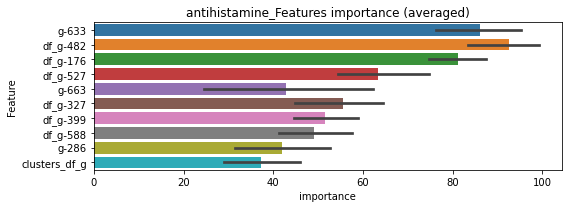

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167595	valid_1's binary_logloss: 0.0252863
[200]	training's binary_logloss: 0.00215335	valid_1's binary_logloss: 0.00666187
[300]	training's binary_logloss: 0.000604836	valid_1's binary_logloss: 0.00393375
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000346365	valid_1's binary_logloss: 0.00340325


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167878	valid_1's binary_logloss: 0.031356
[200]	training's binary_logloss: 0.00206735	valid_1's binary_logloss: 0.0148181


antihistamine logloss: 0.008183586121662532
antimalarial , len(trt) : 18


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00105356	valid_1's binary_logloss: 0.0129639


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063862	valid_1's binary_logloss: 0.0993171
[200]	training's binary_logloss: 0.0103242	valid_1's binary_logloss: 0.0284062
[300]	training's binary_logloss: 0.00327097	valid_1's binary_logloss: 0.0139329
[400]	training's binary_logloss: 0.00178362	valid_1's binary_logloss: 0.00951432
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00143496	valid_1's binary_logloss: 0.00829875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624125	valid_1's binary_logloss: 0.113558
[200]	training's binary_logloss: 0.0100617	valid_1's binary_logloss: 0.0414561
[300]	training's binary_logloss: 0.00320355	valid_1's binary_logloss: 0.0246716
[400]	training's binary_logloss: 0.00176878	valid_1's binary_logloss: 0.0189222
[500]	training's binary_logloss: 0.00138364	valid_1's binary_logloss: 0.0173177
Early stopping, best iteration is:
[491]	traini

1 / 3 AUC score:1.000
Threshold: 0.5721739373791175
Remove_noisy_labels: 1 → positive_corect_labels: 500/999
30th percentile: 0.00171
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00171, conf_1:0.57217
threshold:0.57, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630173	valid_1's binary_logloss: 0.0946228
[200]	training's binary_logloss: 0.010021	valid_1's binary_logloss: 0.026159
[300]	training's binary_logloss: 0.00320228	valid_1's binary_logloss: 0.0125607
[400]	training's binary_logloss: 0.00175579	valid_1's binary_logloss: 0.00856033
[500]	training's binary_logloss: 0.00139759	valid_1's binary_logloss: 0.00726713
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00135443	valid_1's binary_logloss: 0.00705313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606827	valid_1's binary_logloss: 0.109759
[200]	training's binary_logloss: 0.00979633	valid_1's binary_logloss: 0.0352708
[300]	training's binary_logloss: 0.0031855	valid_1's binary_logloss: 0.0192414
[400]	training's binary_logloss: 0.00174743	valid_1's binary_logloss: 0.0138225
[500]	training's binary_logloss: 0.00136878	val

2 / 3 AUC score:1.000
Threshold: 0.5721739373791175
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/997
30th percentile: 0.00159
p_label_rate: 0.00176 Vs.target_rate: 0.00082, Num_p_label: 7.0, conf_0:0.00159, conf_1:0.57217
threshold:0.57, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/997, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632286	valid_1's binary_logloss: 0.0998395
[200]	training's binary_logloss: 0.0102045	valid_1's binary_logloss: 0.0316372
[300]	training's binary_logloss: 0.00323324	valid_1's binary_logloss: 0.0168789
[400]	training's binary_logloss: 0.00178304	valid_1's binary_logloss: 0.0117522
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00144779	valid_1's binary_logloss: 0.0104233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622713	valid_1's binary_logloss: 0.0980709
[200]	training's binary_logloss: 0.0103368	valid_1's binary_logloss: 0.0294028
[300]	training's binary_logloss: 0.0032199	valid_1's binary_logloss: 0.0136416
[400]	training's binary_logloss: 0.00178713	valid_1's binary_logloss: 0.00980318
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0014536	valid_1's binary_logloss: 0.0085236


3 / 3 AUC score:1.000
Threshold: 0.5721739373791175
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/996
30th percentile: 0.00170
p_label_rate: 0.00176 Vs.target_rate: 0.00082, Num_p_label: 7.0, conf_0:0.00170, conf_1:0.57217
threshold:0.57, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:505.0/4978, y_label_rate: 0.10145


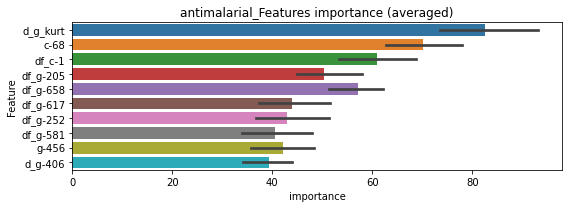

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015908	valid_1's binary_logloss: 0.0285205
[200]	training's binary_logloss: 0.00192827	valid_1's binary_logloss: 0.0121997


len(train_index) : 2489
len(valid_index) : 2489


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000675595	valid_1's binary_logloss: 0.00996507


================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172544	valid_1's binary_logloss: 0.0282914
[200]	training's binary_logloss: 0.00205889	valid_1's binary_logloss: 0.0085593
[300]	training's binary_logloss: 0.00057475	valid_1's binary_logloss: 0.00561091
[400]	training's binary_logloss: 0.000311361	valid_1's binary_logloss: 0.00499564
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000282096	valid_1's binary_logloss: 0.0048615


antimalarial logloss: 0.007413285252061545
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13222	valid_1's binary_logloss: 0.28638
[200]	training's binary_logloss: 0.0363119	valid_1's binary_logloss: 0.177052
[300]	training's binary_logloss: 0.0128485	valid_1's binary_logloss: 0.136123
[400]	training's binary_logloss: 0.00616964	valid_1's binary_logloss: 0.119014
[500]	training's binary_logloss: 0.00381199	valid_1's binary_logloss: 0.111842
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00292365	valid_1's binary_logloss: 0.107582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136677	valid_1's binary_logloss: 0.296322
[200]	training's binary_logloss: 0.0374688	valid_1's binary_logloss: 0.18071
[300]	training's binary_logloss: 0.013194	valid_1's binary_logloss: 0.138288
[400]	training's binary_logloss: 0.00634283	valid_1's binary_logloss: 0.118451
[500]	training's binary_logloss: 0.00389809	valid_1's binary_logl

1 / 3 AUC score:0.992
Threshold: 0.46439763324971406
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentile: 0.02658
p_label_rate: 0.01281 Vs.target_rate: 0.00315, Num_p_label: 51.0, conf_0:0.02643, conf_1:0.54152
Num_p_label: 51.0, Expected: 12.5, Adj_threshold_1: 0.46
Num_p_label: 31.0, Expected: 12.5, Adj_threshold_2: 0.50
Num_p_label: 16.0, Expected: 12.5, Adj_threshold_3: 0.54
threshold:0.54, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127154	valid_1's binary_logloss: 0.266978
[200]	training's binary_logloss: 0.0336317	valid_1's binary_logloss: 0.154798
[300]	training's binary_logloss: 0.0119196	valid_1's binary_logloss: 0.115057
[400]	training's binary_logloss: 0.005837	valid_1's binary_logloss: 0.0970139
[500]	training's binary_logloss: 0.00363053	valid_1's binary_logloss: 0.0878807
[600]	training's binary_logloss: 0.00269567	valid_1's binary_logloss: 0.0829546
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00261015	valid_1's binary_logloss: 0.0825222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130293	valid_1's binary_logloss: 0.270558
[200]	training's binary_logloss: 0.0348162	valid_1's binary_logloss: 0.155744
[300]	training's binary_logloss: 0.0119583	valid_1's binary_logloss: 0.111227
[400]	training's binary_logloss: 0.00581263	valid_1's binar

2 / 3 AUC score:0.998
Threshold: 0.5443976332497141
Remove_noisy_labels: 17 → positive_corect_labels: 471.0/951
30th percentile: 0.02111
p_label_rate: 0.00954 Vs.target_rate: 0.00315, Num_p_label: 38.0, conf_0:0.02111, conf_1:0.54440
Num_p_label: 38.0, Expected: 12.5, Adj_threshold_1: 0.54
Num_p_label: 27.0, Expected: 12.5, Adj_threshold_2: 0.58
Num_p_label: 20.0, Expected: 12.5, Adj_threshold_3: 0.62
Num_p_label: 12.0, Expected: 12.5, Adj_threshold_4: 0.66
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:471.0/951, y_label_rate: 0.49527
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12438	valid_1's binary_logloss: 0.266357
[200]	training's binary_logloss: 0.0322186	valid_1's binary_logloss: 0.154084
[300]	training's binary_logloss: 0.0111545	valid_1's binary_logloss: 0.114105
[400]	training's binary_logloss: 0.00545808	valid_1's binary_logloss: 0.0945512
[500]	training's binary_logloss: 0.00345835	valid_1's binary_logloss: 0.0837634
[600]	training's binary_logloss: 0.00258727	valid_1's binary_logloss: 0.0779624
[700]	training's binary_logloss: 0.00219306	valid_1's binary_logloss: 0.074518
Early stopping, best iteration is:
[718]	training's binary_logloss: 0.0021583	valid_1's binary_logloss: 0.0741225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128371	valid_1's binary_logloss: 0.28217
[200]	training's binary_logloss: 0.0340231	valid_1's binary_logloss: 0.172363
[300]	training's binary_logloss: 0.0119459	valid_1's binary

3 / 3 AUC score:0.995
Threshold: 0.6643976332497142


Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00472661	valid_1's binary_logloss: 0.107834


Remove_noisy_labels: 26 → positive_corect_labels: 447.0/925
30th percentile: 0.02174
p_label_rate: 0.00402 Vs.target_rate: 0.00315, Num_p_label: 16.0, conf_0:0.02054, conf_1:0.66440
threshold:0.66, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:463.0/4907, y_label_rate: 0.09436


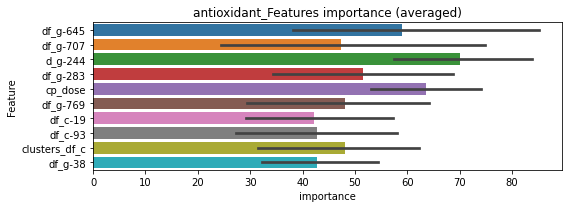

len(train_index) : 2453
len(valid_index) : 2454
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322801	valid_1's binary_logloss: 0.082173
[200]	training's binary_logloss: 0.0061111	valid_1's binary_logloss: 0.0527532
[300]	training's binary_logloss: 0.00178428	valid_1's binary_logloss: 0.0472344
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0015767	valid_1's binary_logloss: 0.0470808


len(train_index) : 2454
len(valid_index) : 2453
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334811	valid_1's binary_logloss: 0.0806449
[200]	training's binary_logloss: 0.00682025	valid_1's binary_logloss: 0.0490092
[300]	training's binary_logloss: 0.00200555	valid_1's binary_logloss: 0.0419055
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00144244	valid_1's binary_logloss: 0.040932


antioxidant logloss: 0.04400698566368598
antiprotozoal , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934952	valid_1's binary_logloss: 0.149892
[200]	training's binary_logloss: 0.0202244	valid_1's binary_logloss: 0.055519
[300]	training's binary_logloss: 0.00663017	valid_1's binary_logloss: 0.0297429
[400]	training's binary_logloss: 0.00339595	valid_1's binary_logloss: 0.0208375
[500]	training's binary_logloss: 0.00224629	valid_1's binary_logloss: 0.0170637
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00185947	valid_1's binary_logloss: 0.0152377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870801	valid_1's binary_logloss: 0.178841
[200]	training's binary_logloss: 0.0178112	valid_1's binary_logloss: 0.0875984
[300]	training's binary_logloss: 0.00582452	valid_1's binary_logloss: 0.0576125
[400]	training's binary_logloss: 0.00300745	valid_1's binary_logloss: 0.0462199
[500]	training's binary_logloss: 0.00205659	valid_

1 / 3 AUC score:1.000
Threshold: 0.3908173719357545
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00541
p_label_rate: 0.00276 Vs.target_rate: 0.00161, Num_p_label: 11.0, conf_0:0.00541, conf_1:0.40971
threshold:0.39, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907898	valid_1's binary_logloss: 0.160964
[200]	training's binary_logloss: 0.0191604	valid_1's binary_logloss: 0.0651597
[300]	training's binary_logloss: 0.00632225	valid_1's binary_logloss: 0.0387464
[400]	training's binary_logloss: 0.00321184	valid_1's binary_logloss: 0.0288548
[500]	training's binary_logloss: 0.0021757	valid_1's binary_logloss: 0.0250519
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00180026	valid_1's binary_logloss: 0.0232766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871448	valid_1's binary_logloss: 0.16206
[200]	training's binary_logloss: 0.0185116	valid_1's binary_logloss: 0.0675512
[300]	training's binary_logloss: 0.00608337	valid_1's binary_logloss: 0.0374687
[400]	training's binary_logloss: 0.00314742	valid_1's binary_logloss: 0.0278741
[500]	training's binary_logloss: 0.00211895	valid_1

2 / 3 AUC score:1.000
Threshold: 0.3908173719357545
Remove_noisy_labels: 2 → positive_corect_labels: 497.0/994
30th percentile: 0.00509
p_label_rate: 0.00402 Vs.target_rate: 0.00161, Num_p_label: 16.0, conf_0:0.00509, conf_1:0.39082
threshold:0.39, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879487	valid_1's binary_logloss: 0.170042
[200]	training's binary_logloss: 0.0184213	valid_1's binary_logloss: 0.0754893
[300]	training's binary_logloss: 0.00610446	valid_1's binary_logloss: 0.0478253
[400]	training's binary_logloss: 0.00313147	valid_1's binary_logloss: 0.036932
[500]	training's binary_logloss: 0.0021315	valid_1's binary_logloss: 0.0325414
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00178922	valid_1's binary_logloss: 0.030847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866576	valid_1's binary_logloss: 0.163222
[200]	training's binary_logloss: 0.0179572	valid_1's binary_logloss: 0.0730039
[300]	training's binary_logloss: 0.0058656	valid_1's binary_logloss: 0.0468972
[400]	training's binary_logloss: 0.00304841	valid_1's binary_logloss: 0.0360699
[500]	training's binary_logloss: 0.00206666	valid_1's

3 / 3 AUC score:1.000


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00174558	valid_1's binary_logloss: 0.0291475


Threshold: 0.3908173719357545
Remove_noisy_labels: 8 → positive_corect_labels: 492.0/986
30th percentile: 0.00499
p_label_rate: 0.00326 Vs.target_rate: 0.00161, Num_p_label: 13.0, conf_0:0.00499, conf_1:0.39082
threshold:0.39, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:505.0/4968, y_label_rate: 0.10165


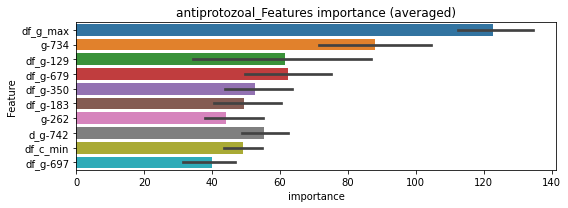

len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233026	valid_1's binary_logloss: 0.0541768
[200]	training's binary_logloss: 0.00362438	valid_1's binary_logloss: 0.0339611


len(train_index) : 2484
len(valid_index) : 2484


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00163435	valid_1's binary_logloss: 0.032197


================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265348	valid_1's binary_logloss: 0.048468
[200]	training's binary_logloss: 0.00436448	valid_1's binary_logloss: 0.023628
[300]	training's binary_logloss: 0.00121103	valid_1's binary_logloss: 0.0199931


antiprotozoal logloss: 0.0259976291195381


Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00115206	valid_1's binary_logloss: 0.0197983


antiviral , len(trt) : 23


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687985	valid_1's binary_logloss: 0.123422
[200]	training's binary_logloss: 0.0117264	valid_1's binary_logloss: 0.0488551
[300]	training's binary_logloss: 0.00368207	valid_1's binary_logloss: 0.0295766
[400]	training's binary_logloss: 0.00197803	valid_1's binary_logloss: 0.0241719
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00150461	valid_1's binary_logloss: 0.0223379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677454	valid_1's binary_logloss: 0.117367
[200]	training's binary_logloss: 0.0116066	valid_1's binary_logloss: 0.0430599
[300]	training's binary_logloss: 0.00363221	valid_1's binary_logloss: 0.0258545
[400]	training's binary_logloss: 0.00197549	valid_1's binary_logloss: 0.0206208
[500]	training's binary_logloss: 0.00145679	valid_1's binary_logloss: 0.0184151
Early stopping, best iteration is:
[570]	training

1 / 3 AUC score:1.000
Threshold: 0.2523046574098054
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00186
p_label_rate: 0.01381 Vs.target_rate: 0.00104, Num_p_label: 55.0, conf_0:0.00186, conf_1:0.41505
Num_p_label: 55.0, Expected: 4.1, Adj_threshold_1: 0.25
Num_p_label: 38.0, Expected: 4.1, Adj_threshold_2: 0.29
Num_p_label: 30.0, Expected: 4.1, Adj_threshold_3: 0.33
Num_p_label: 21.0, Expected: 4.1, Adj_threshold_4: 0.37
Num_p_label: 16.0, Expected: 4.1, Adj_threshold_5: 0.41
Num_p_label: 11.0, Expected: 4.1, Adj_threshold_6: 0.45
Num_p_label: 11.0, Expected: 4.1, Adj_threshold_7: 0.49
Num_p_label: 7.0, Expected: 4.1, Adj_threshold_8: 0.53
Num_p_label: 5.0, Expected: 4.1, Adj_threshold_9: 0.57
threshold:0.57, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697649	valid_1's binary_logloss: 0.115921
[200]	training's binary_logloss: 0.0113319	valid_1's binary_logloss: 0.0349559
[300]	training's binary_logloss: 0.00361832	valid_1's binary_logloss: 0.0182186
[400]	training's binary_logloss: 0.00195783	valid_1's binary_logloss: 0.0134174
[500]	training's binary_logloss: 0.00144795	valid_1's binary_logloss: 0.0113537
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00141493	valid_1's binary_logloss: 0.0111043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676196	valid_1's binary_logloss: 0.102251
[200]	training's binary_logloss: 0.0113389	valid_1's binary_logloss: 0.0314285
[300]	training's binary_logloss: 0.00362366	valid_1's binary_logloss: 0.015917
[400]	training's binary_logloss: 0.0019543	valid_1's binary_logloss: 0.0109695
[500]	training's binary_logloss: 0.0014504	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.5723046574098053
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/993
30th percentile: 0.00169
p_label_rate: 0.00075 Vs.target_rate: 0.00104, Num_p_label: 3.0, conf_0:0.00169, conf_1:0.57230
threshold:0.57, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/993, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663084	valid_1's binary_logloss: 0.121904
[200]	training's binary_logloss: 0.011408	valid_1's binary_logloss: 0.0482278
[300]	training's binary_logloss: 0.0036038	valid_1's binary_logloss: 0.0315949
[400]	training's binary_logloss: 0.00194412	valid_1's binary_logloss: 0.0273023
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00152472	valid_1's binary_logloss: 0.0255246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667518	valid_1's binary_logloss: 0.100647
[200]	training's binary_logloss: 0.0112432	valid_1's binary_logloss: 0.0296334
[300]	training's binary_logloss: 0.00358594	valid_1's binary_logloss: 0.0141481
[400]	training's binary_logloss: 0.00196351	valid_1's binary_logloss: 0.0098281
[500]	training's binary_logloss: 0.00143613	valid_1's binary_logloss: 0.00786401
Early stopping, best iteration is:
[576]	training'

3 / 3 AUC score:1.000
Threshold: 0.5723046574098053
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/989
30th percentile: 0.00181
p_label_rate: 0.00075 Vs.target_rate: 0.00104, Num_p_label: 3.0, conf_0:0.00181, conf_1:0.57230
threshold:0.57, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:495.0/4971, y_label_rate: 0.09958


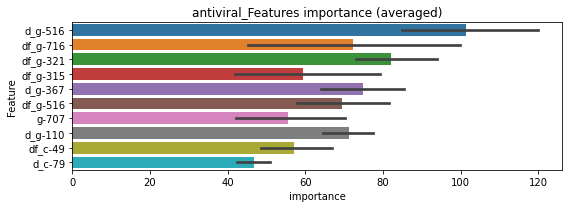

len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163446	valid_1's binary_logloss: 0.02653
[200]	training's binary_logloss: 0.00209715	valid_1's binary_logloss: 0.00721153
[300]	training's binary_logloss: 0.00061708	valid_1's binary_logloss: 0.00431697
[400]	training's binary_logloss: 0.000335346	valid_1's binary_logloss: 0.0036289
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000277915	valid_1's binary_logloss: 0.00343929


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161242	valid_1's binary_logloss: 0.0258242
[200]	training's binary_logloss: 0.00197549	valid_1's binary_logloss: 0.00776059
[300]	training's binary_logloss: 0.000581401	valid_1's binary_logloss: 0.00550687
[400]	training's binary_logloss: 0.000314339	valid_1's binary_logloss: 0.00505793
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000282105	valid_1's binary_logloss: 0.00497952


antiviral logloss: 0.004209251116878515
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111751	valid_1's binary_logloss: 0.246206
[200]	training's binary_logloss: 0.0270257	valid_1's binary_logloss: 0.137629
[300]	training's binary_logloss: 0.00918151	valid_1's binary_logloss: 0.0965805
[400]	training's binary_logloss: 0.00455688	valid_1's binary_logloss: 0.0805817
[500]	training's binary_logloss: 0.00292571	valid_1's binary_logloss: 0.0723323
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00245317	valid_1's binary_logloss: 0.068865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114966	valid_1's binary_logloss: 0.227583
[200]	training's binary_logloss: 0.0276354	valid_1's binary_logloss: 0.119772
[300]	training's binary_logloss: 0.00941647	valid_1's binary_logloss: 0.0823444
[400]	training's binary_logloss: 0.00461259	valid_1's binary_logloss: 0.0665621
[500]	training's binary_logloss: 0.00297463	valid_1's 

1 / 3 AUC score:0.998
Threshold: 0.37002509079663537
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01661
p_label_rate: 0.01080 Vs.target_rate: 0.00216, Num_p_label: 43.0, conf_0:0.01661, conf_1:0.44283
Num_p_label: 43.0, Expected: 8.6, Adj_threshold_1: 0.37
Num_p_label: 26.0, Expected: 8.6, Adj_threshold_2: 0.41
Num_p_label: 20.0, Expected: 8.6, Adj_threshold_3: 0.45
Num_p_label: 8.0, Expected: 8.6, Adj_threshold_4: 0.49
threshold:0.49, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109883	valid_1's binary_logloss: 0.225205
[200]	training's binary_logloss: 0.0257889	valid_1's binary_logloss: 0.118696
[300]	training's binary_logloss: 0.00867544	valid_1's binary_logloss: 0.083712
[400]	training's binary_logloss: 0.00434516	valid_1's binary_logloss: 0.0706931
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00329512	valid_1's binary_logloss: 0.0675763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111813	valid_1's binary_logloss: 0.219326
[200]	training's binary_logloss: 0.0268281	valid_1's binary_logloss: 0.107867
[300]	training's binary_logloss: 0.00918846	valid_1's binary_logloss: 0.07
[400]	training's binary_logloss: 0.00457289	valid_1's binary_logloss: 0.0533629
[500]	training's binary_logloss: 0.00296472	valid_1's binary_logloss: 0.0453831
[600]	training's binary_logloss: 0.0022853	valid_1's binary

2 / 3 AUC score:0.998
Threshold: 0.4900250907966353
Remove_noisy_labels: 8 → positive_corect_labels: 488.0/976
30th percentile: 0.01908
p_label_rate: 0.00703 Vs.target_rate: 0.00216, Num_p_label: 28.0, conf_0:0.01908, conf_1:0.49206
Num_p_label: 28.0, Expected: 8.6, Adj_threshold_1: 0.49
Num_p_label: 20.0, Expected: 8.6, Adj_threshold_2: 0.53
Num_p_label: 15.0, Expected: 8.6, Adj_threshold_3: 0.57
Num_p_label: 10.0, Expected: 8.6, Adj_threshold_4: 0.61
threshold:0.61, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110318	valid_1's binary_logloss: 0.215785
[200]	training's binary_logloss: 0.0261222	valid_1's binary_logloss: 0.112188
[300]	training's binary_logloss: 0.00872771	valid_1's binary_logloss: 0.0743098
[400]	training's binary_logloss: 0.00439634	valid_1's binary_logloss: 0.0588338
[500]	training's binary_logloss: 0.0028504	valid_1's binary_logloss: 0.0513136
[600]	training's binary_logloss: 0.0022005	valid_1's binary_logloss: 0.0473982
Early stopping, best iteration is:
[653]	training's binary_logloss: 0.0020359	valid_1's binary_logloss: 0.0466186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11084	valid_1's binary_logloss: 0.2206
[200]	training's binary_logloss: 0.0266664	valid_1's binary_logloss: 0.110453
[300]	training's binary_logloss: 0.00895589	valid_1's binary_logloss: 0.0710112
[400]	training's binary_logloss: 0.0044924	valid_1's binary

3 / 3 AUC score:0.999
Threshold: 0.6100250907966354
Remove_noisy_labels: 9 → positive_corect_labels: 479.0/967
30th percentile: 0.01589
p_label_rate: 0.00377 Vs.target_rate: 0.00216, Num_p_label: 15.0, conf_0:0.01589, conf_1:0.61003
threshold:0.61, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:494.0/4949, y_label_rate: 0.09982


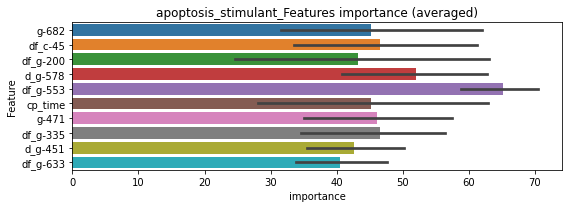

len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362021	valid_1's binary_logloss: 0.0640719
[200]	training's binary_logloss: 0.00670277	valid_1's binary_logloss: 0.0294317
[300]	training's binary_logloss: 0.00184233	valid_1's binary_logloss: 0.0215906
[400]	training's binary_logloss: 0.000833658	valid_1's binary_logloss: 0.0196838
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000655298	valid_1's binary_logloss: 0.0194829


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037789	valid_1's binary_logloss: 0.0651385
[200]	training's binary_logloss: 0.00733041	valid_1's binary_logloss: 0.032264
[300]	training's binary_logloss: 0.00189081	valid_1's binary_logloss: 0.0253224
[400]	training's binary_logloss: 0.000845588	valid_1's binary_logloss: 0.0233972
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000785735	valid_1's binary_logloss: 0.023313


apoptosis_stimulant logloss: 0.02139751663242145
aromatase_inhibitor , len(trt) : 47


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108465	valid_1's binary_logloss: 0.20904
[200]	training's binary_logloss: 0.0254679	valid_1's binary_logloss: 0.101479
[300]	training's binary_logloss: 0.00857529	valid_1's binary_logloss: 0.0646464
[400]	training's binary_logloss: 0.00426156	valid_1's binary_logloss: 0.0501627
[500]	training's binary_logloss: 0.00277023	valid_1's binary_logloss: 0.0438778
[600]	training's binary_logloss: 0.0021355	valid_1's binary_logloss: 0.039724
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00201199	valid_1's binary_logloss: 0.03884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104354	valid_1's binary_logloss: 0.225595
[200]	training's binary_logloss: 0.0240788	valid_1's binary_logloss: 0.113118
[300]	training's binary_logloss: 0.00820494	valid_1's binary_logloss: 0.0780816
[400]	training's binary_logloss: 0.00406772	valid_1's bina

1 / 3 AUC score:0.999
Threshold: 0.3690504856896675
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentile: 0.01116
p_label_rate: 0.00477 Vs.target_rate: 0.00208, Num_p_label: 19.0, conf_0:0.01116, conf_1:0.36905
threshold:0.37, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103069	valid_1's binary_logloss: 0.206006
[200]	training's binary_logloss: 0.0241184	valid_1's binary_logloss: 0.103833
[300]	training's binary_logloss: 0.00818178	valid_1's binary_logloss: 0.0664928
[400]	training's binary_logloss: 0.00407489	valid_1's binary_logloss: 0.0512026
[500]	training's binary_logloss: 0.00265276	valid_1's binary_logloss: 0.0431485
[600]	training's binary_logloss: 0.00206016	valid_1's binary_logloss: 0.0393127
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.0019533	valid_1's binary_logloss: 0.0385543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107567	valid_1's binary_logloss: 0.204969
[200]	training's binary_logloss: 0.0253092	valid_1's binary_logloss: 0.0995593
[300]	training's binary_logloss: 0.00835718	valid_1's binary_logloss: 0.0639239
[400]	training's binary_logloss: 0.00412306	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.3690504856896675
Remove_noisy_labels: 10 → positive_corect_labels: 489.0/976
30th percentile: 0.01208
p_label_rate: 0.01457 Vs.target_rate: 0.00208, Num_p_label: 58.0, conf_0:0.01208, conf_1:0.41706
Num_p_label: 58.0, Expected: 8.3, Adj_threshold_1: 0.37
Num_p_label: 39.0, Expected: 8.3, Adj_threshold_2: 0.41
Num_p_label: 26.0, Expected: 8.3, Adj_threshold_3: 0.45
Num_p_label: 22.0, Expected: 8.3, Adj_threshold_4: 0.49
Num_p_label: 18.0, Expected: 8.3, Adj_threshold_5: 0.53
Num_p_label: 10.0, Expected: 8.3, Adj_threshold_6: 0.57
threshold:0.57, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:489.0/976, y_label_rate: 0.50102
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103536	valid_1's binary_logloss: 0.206119
[200]	training's binary_logloss: 0.0240277	valid_1's binary_logloss: 0.102145
[300]	training's binary_logloss: 0.00791184	valid_1's binary_logloss: 0.0641602
[400]	training's binary_logloss: 0.00396866	valid_1's binary_logloss: 0.0483025
[500]	training's binary_logloss: 0.0026058	valid_1's binary_logloss: 0.0408836
[600]	training's binary_logloss: 0.00205112	valid_1's binary_logloss: 0.0372687
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00192481	valid_1's binary_logloss: 0.0364168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101967	valid_1's binary_logloss: 0.222078
[200]	training's binary_logloss: 0.0231339	valid_1's binary_logloss: 0.116193
[300]	training's binary_logloss: 0.00773589	valid_1's binary_logloss: 0.0832661
[400]	training's binary_logloss: 0.00386918	valid_1's 

3 / 3 AUC score:0.999
Threshold: 0.5690504856896674
Remove_noisy_labels: 11 → positive_corect_labels: 481.0/965
30th percentile: 0.01037
p_label_rate: 0.00176 Vs.target_rate: 0.00208, Num_p_label: 7.0, conf_0:0.01037, conf_1:0.56905
threshold:0.57, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:488.0/4947, y_label_rate: 0.09865


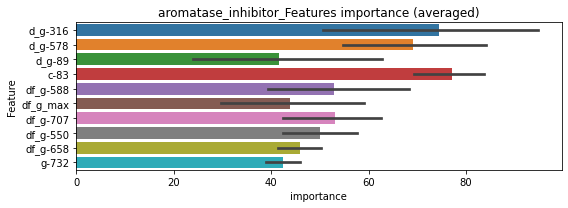

len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292842	valid_1's binary_logloss: 0.0600748
[200]	training's binary_logloss: 0.00523386	valid_1's binary_logloss: 0.0316041
[300]	training's binary_logloss: 0.00141235	valid_1's binary_logloss: 0.0258248
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00122523	valid_1's binary_logloss: 0.0256897


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303595	valid_1's binary_logloss: 0.0617457
[200]	training's binary_logloss: 0.00499963	valid_1's binary_logloss: 0.0320954
[300]	training's binary_logloss: 0.0014107	valid_1's binary_logloss: 0.0268631
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000904427	valid_1's binary_logloss: 0.0258439


aromatase_inhibitor logloss: 0.02576680328434663
atm_kinase_inhibitor , len(trt) : 6


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353368	valid_1's binary_logloss: 0.0495805
[200]	training's binary_logloss: 0.00393208	valid_1's binary_logloss: 0.00881393
[300]	training's binary_logloss: 0.00129146	valid_1's binary_logloss: 0.00369831
[400]	training's binary_logloss: 0.000838597	valid_1's binary_logloss: 0.00254405
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00075743	valid_1's binary_logloss: 0.00229454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363694	valid_1's binary_logloss: 0.0435781
[200]	training's binary_logloss: 0.00414173	valid_1's binary_logloss: 0.00691565
[300]	training's binary_logloss: 0.00133092	valid_1's binary_logloss: 0.00282935


1 / 3 AUC score:1.000
Threshold: 0.5121062523798725


[400]	training's binary_logloss: 0.000856241	valid_1's binary_logloss: 0.00195895
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000818278	valid_1's binary_logloss: 0.00187086


Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00056
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00056, conf_1:0.51211
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.51
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.47
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.43
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_4: 0.39
threshold:0.39, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353368	valid_1's binary_logloss: 0.0495805
[200]	training's binary_logloss: 0.00393208	valid_1's binary_logloss: 0.00881393
[300]	training's binary_logloss: 0.00129146	valid_1's binary_logloss: 0.00369831
[400]	training's binary_logloss: 0.000838597	valid_1's binary_logloss: 0.00254405
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00075743	valid_1's binary_logloss: 0.00229454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363694	valid_1's binary_logloss: 0.0435781
[200]	training's binary_logloss: 0.00414173	valid_1's binary_logloss: 0.00691565
[300]	training's binary_logloss: 0.00133092	valid_1's binary_logloss: 0.00282935


2 / 3 AUC score:1.000
Threshold: 0.39210625237987257


[400]	training's binary_logloss: 0.000856241	valid_1's binary_logloss: 0.00195895
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000818278	valid_1's binary_logloss: 0.00187086


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00056
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00056, conf_1:0.39211
threshold:0.39, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353368	valid_1's binary_logloss: 0.0495805
[200]	training's binary_logloss: 0.00393208	valid_1's binary_logloss: 0.00881393
[300]	training's binary_logloss: 0.00129146	valid_1's binary_logloss: 0.00369831
[400]	training's binary_logloss: 0.000838597	valid_1's binary_logloss: 0.00254405
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00075743	valid_1's binary_logloss: 0.00229454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363694	valid_1's binary_logloss: 0.0435781
[200]	training's binary_logloss: 0.00414173	valid_1's binary_logloss: 0.00691565
[300]	training's binary_logloss: 0.00133092	valid_1's binary_logloss: 0.00282935


3 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.000856241	valid_1's binary_logloss: 0.00195895
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000818278	valid_1's binary_logloss: 0.00187086


Threshold: 0.39210625237987257
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00056
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00056, conf_1:0.39211
threshold:0.39, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


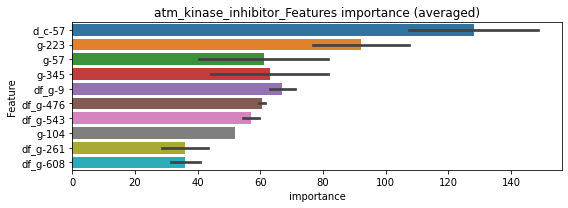

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100622	valid_1's binary_logloss: 0.0112396
[200]	training's binary_logloss: 0.000864704	valid_1's binary_logloss: 0.00166503


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atm_kinase_inhibitor=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000288418	valid_1's binary_logloss: 0.00124062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101802	valid_1's binary_logloss: 0.0127747
[200]	training's binary_logloss: 0.000890646	valid_1's binary_logloss: 0.00364224
[300]	training's binary_logloss: 0.000252719	valid_1's binary_logloss: 0.00220619
[400]	training's binary_logloss: 0.000157311	valid_1's binary_logloss: 0.00188919


atm_kinase_inhibitor logloss: 0.001537530878199102
atp-sensitive_potassium_channel_antagonist , len(trt) : 7


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000147115	valid_1's binary_logloss: 0.00183444


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037669	valid_1's binary_logloss: 0.050493
[200]	training's binary_logloss: 0.00446991	valid_1's binary_logloss: 0.00929906
[300]	training's binary_logloss: 0.00144859	valid_1's binary_logloss: 0.0037088
[400]	training's binary_logloss: 0.000925911	valid_1's binary_logloss: 0.00257759
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000832728	valid_1's binary_logloss: 0.0022911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375545	valid_1's binary_logloss: 0.0498382
[200]	training's binary_logloss: 0.00443119	valid_1's binary_logloss: 0.0102363
[300]	training's binary_logloss: 0.00145805	valid_1's binary_logloss: 0.00511731
[400]	training's binary_logloss: 0.00092871	valid_1's binary_logloss: 0.00400957
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000830458	valid_1's binary_logloss: 0.00360897


1 / 3 AUC score:1.000
Threshold: 0.6486982935765252
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00046
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00046, conf_1:0.64870
threshold:0.65, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037669	valid_1's binary_logloss: 0.050493
[200]	training's binary_logloss: 0.00446991	valid_1's binary_logloss: 0.00929906
[300]	training's binary_logloss: 0.00144859	valid_1's binary_logloss: 0.0037088
[400]	training's binary_logloss: 0.000925911	valid_1's binary_logloss: 0.00257759
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000832728	valid_1's binary_logloss: 0.0022911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375545	valid_1's binary_logloss: 0.0498382
[200]	training's binary_logloss: 0.00443119	valid_1's binary_logloss: 0.0102363
[300]	training's binary_logloss: 0.00145805	valid_1's binary_logloss: 0.00511731
[400]	training's binary_logloss: 0.00092871	valid_1's binary_logloss: 0.00400957
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000830458	valid_1's binary_logloss: 0.00360897


2 / 3 AUC score:1.000
Threshold: 0.6486982935765252
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00046
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00046, conf_1:0.64870
threshold:0.65, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037669	valid_1's binary_logloss: 0.050493
[200]	training's binary_logloss: 0.00446991	valid_1's binary_logloss: 0.00929906
[300]	training's binary_logloss: 0.00144859	valid_1's binary_logloss: 0.0037088
[400]	training's binary_logloss: 0.000925911	valid_1's binary_logloss: 0.00257759
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000832728	valid_1's binary_logloss: 0.0022911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375545	valid_1's binary_logloss: 0.0498382
[200]	training's binary_logloss: 0.00443119	valid_1's binary_logloss: 0.0102363
[300]	training's binary_logloss: 0.00145805	valid_1's binary_logloss: 0.00511731
[400]	training's binary_logloss: 0.00092871	valid_1's binary_logloss: 0.00400957
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000830458	valid_1's binary_logloss: 0.00360897


3 / 3 AUC score:1.000
Threshold: 0.6486982935765252
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00046
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00046, conf_1:0.64870
threshold:0.65, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


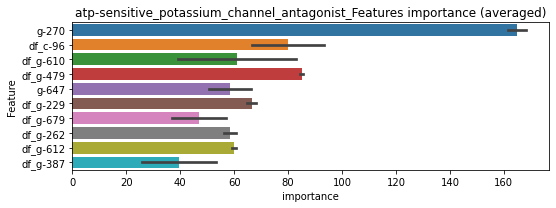

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102547	valid_1's binary_logloss: 0.0141927
[200]	training's binary_logloss: 0.000932476	valid_1's binary_logloss: 0.00326308
[300]	training's binary_logloss: 0.000268248	valid_1's binary_logloss: 0.00190226
[400]	training's binary_logloss: 0.000166123	valid_1's binary_logloss: 0.00167307
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000164161	valid_1's binary_logloss: 0.00166783


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105019	valid_1's binary_logloss: 0.0114121
[200]	training's binary_logloss: 0.000956178	valid_1's binary_logloss: 0.00129356
[300]	training's binary_logloss: 0.000275769	valid_1's binary_logloss: 0.000424459
[400]	training's binary_logloss: 0.000170171	valid_1's binary_logloss: 0.000265927
[500]	training's binary_logloss: 0.000157756	valid_1's binary_logloss: 0.00024764
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000157756	valid_1's binary_logloss: 0.00024764


atp-sensitive_potassium_channel_antagonist logloss: 0.0009577363539947665
atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499386	valid_1's binary_logloss: 0.0699624
[200]	training's binary_logloss: 0.00683995	valid_1's binary_logloss: 0.0159412
[300]	training's binary_logloss: 0.00216651	valid_1's binary_logloss: 0.00701696
[400]	training's binary_logloss: 0.00126479	valid_1's binary_logloss: 0.00472459
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00110119	valid_1's binary_logloss: 0.00426841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478595	valid_1's binary_logloss: 0.0699699
[200]	training's binary_logloss: 0.00672887	valid_1's binary_logloss: 0.0215447
[300]	training's binary_logloss: 0.00218115	valid_1's binary_logloss: 0.0127534
[400]	training's binary_logloss: 0.00126881	valid_1's binary_logloss: 0.0103209
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00109287	valid_1's binary_logloss: 0.00970182


1 / 3 AUC score:1.000
Threshold: 0.6229310261797965
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00064
p_label_rate: 0.00377 Vs.target_rate: 0.00055, Num_p_label: 15.0, conf_0:0.00064, conf_1:0.62293
Num_p_label: 15.0, Expected: 2.2, Adj_threshold_1: 0.62
Num_p_label: 13.0, Expected: 2.2, Adj_threshold_2: 0.66
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_3: 0.70
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_4: 0.74
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_5: 0.78
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472203	valid_1's binary_logloss: 0.0735156
[200]	training's binary_logloss: 0.00645892	valid_1's binary_logloss: 0.0183445
[300]	training's binary_logloss: 0.00209287	valid_1's binary_logloss: 0.00928721
[400]	training's binary_logloss: 0.00123738	valid_1's binary_logloss: 0.00696565
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00107553	valid_1's binary_logloss: 0.00636527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480861	valid_1's binary_logloss: 0.0669151
[200]	training's binary_logloss: 0.00667891	valid_1's binary_logloss: 0.0189317
[300]	training's binary_logloss: 0.00213152	valid_1's binary_logloss: 0.0115934
[400]	training's binary_logloss: 0.00124635	valid_1's binary_logloss: 0.00939892
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00109992	valid_1's binary_logloss: 0.00874821


2 / 3 AUC score:1.000
Threshold: 0.8229310261797966
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00065
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00065, conf_1:0.82293
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472203	valid_1's binary_logloss: 0.0735156
[200]	training's binary_logloss: 0.00645892	valid_1's binary_logloss: 0.0183445
[300]	training's binary_logloss: 0.00209287	valid_1's binary_logloss: 0.00928721
[400]	training's binary_logloss: 0.00123738	valid_1's binary_logloss: 0.00696565
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00107553	valid_1's binary_logloss: 0.00636527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480861	valid_1's binary_logloss: 0.0669151
[200]	training's binary_logloss: 0.00667891	valid_1's binary_logloss: 0.0189317
[300]	training's binary_logloss: 0.00213152	valid_1's binary_logloss: 0.0115934
[400]	training's binary_logloss: 0.00124635	valid_1's binary_logloss: 0.00939892
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00109992	valid_1's binary_logloss: 0.00874821


3 / 3 AUC score:1.000
Threshold: 0.8229310261797966
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00065
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00065, conf_1:0.82293
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:504.0/4980, y_label_rate: 0.10120


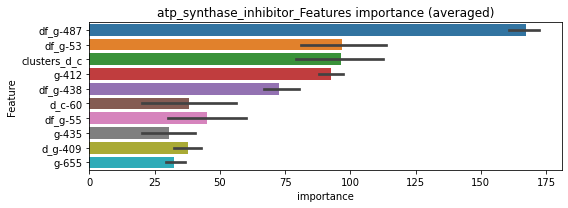

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127343	valid_1's binary_logloss: 0.0176868
[200]	training's binary_logloss: 0.00136041	valid_1's binary_logloss: 0.00453703
[300]	training's binary_logloss: 0.000403478	valid_1's binary_logloss: 0.00269858
[400]	training's binary_logloss: 0.000239687	valid_1's binary_logloss: 0.00233339
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00023014	valid_1's binary_logloss: 0.00231304


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122541	valid_1's binary_logloss: 0.0181452
[200]	training's binary_logloss: 0.00129663	valid_1's binary_logloss: 0.00583524
[300]	training's binary_logloss: 0.000375683	valid_1's binary_logloss: 0.00458303
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000247113	valid_1's binary_logloss: 0.00439885


atp_synthase_inhibitor logloss: 0.003355948625576809
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151017	valid_1's binary_logloss: 0.34507
[200]	training's binary_logloss: 0.0452129	valid_1's binary_logloss: 0.248719
[300]	training's binary_logloss: 0.0164823	valid_1's binary_logloss: 0.209325
[400]	training's binary_logloss: 0.00785993	valid_1's binary_logloss: 0.191217
[500]	training's binary_logloss: 0.00477256	valid_1's binary_logloss: 0.184369
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00378249	valid_1's binary_logloss: 0.180618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142052	valid_1's binary_logloss: 0.344991
[200]	training's binary_logloss: 0.0402681	valid_1's binary_logloss: 0.250778
[300]	training's binary_logloss: 0.0144971	valid_1's binary_logloss: 0.213088
[400]	training's binary_logloss: 0.00701779	valid_1's binary_logloss: 0.199169
[500]	training's binary_logloss: 0.0043408	valid_1's binary_lo

1 / 3 AUC score:0.972
Threshold: 0.36293300607331225
Remove_noisy_labels: 70 → positive_corect_labels: 465/930
30th percentile: 0.04340
p_label_rate: 0.07961 Vs.target_rate: 0.00409, Num_p_label: 317.0, conf_0:0.04020, conf_1:0.56315
Num_p_label: 317.0, Expected: 16.3, Adj_threshold_1: 0.36
Num_p_label: 238.0, Expected: 16.3, Adj_threshold_2: 0.40
Num_p_label: 185.0, Expected: 16.3, Adj_threshold_3: 0.44
Num_p_label: 130.0, Expected: 16.3, Adj_threshold_4: 0.48
Num_p_label: 105.0, Expected: 16.3, Adj_threshold_5: 0.52
Num_p_label: 69.0, Expected: 16.3, Adj_threshold_6: 0.56
Num_p_label: 49.0, Expected: 16.3, Adj_threshold_7: 0.60
Num_p_label: 31.0, Expected: 16.3, Adj_threshold_8: 0.64
Num_p_label: 21.0, Expected: 16.3, Adj_threshold_9: 0.68
threshold:0.68, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:465.0/930, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134205	valid_1's binary_logloss: 0.301293
[200]	training's binary_logloss: 0.037119	valid_1's binary_logloss: 0.20201
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0182843	valid_1's binary_logloss: 0.177009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130841	valid_1's binary_logloss: 0.320002
[200]	training's binary_logloss: 0.0356629	valid_1's binary_logloss: 0.219089
[300]	training's binary_logloss: 0.0128835	valid_1's binary_logloss: 0.173222
[400]	training's binary_logloss: 0.00620453	valid_1's binary_logloss: 0.154685
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00596761	valid_1's binary_logloss: 0.153829


2 / 3 AUC score:0.987
Threshold: 0.6829330060733123
Remove_noisy_labels: 68 → positive_corect_labels: 403.0/862
30th percentile: 0.05957
p_label_rate: 0.01708 Vs.target_rate: 0.00409, Num_p_label: 68.0, conf_0:0.05957, conf_1:0.68293
Num_p_label: 68.0, Expected: 16.3, Adj_threshold_1: 0.68
Num_p_label: 47.0, Expected: 16.3, Adj_threshold_2: 0.72
Num_p_label: 26.0, Expected: 16.3, Adj_threshold_3: 0.76
Num_p_label: 19.0, Expected: 16.3, Adj_threshold_4: 0.80
threshold:0.80, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:403.0/862, y_label_rate: 0.46752
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12671	valid_1's binary_logloss: 0.254126
[200]	training's binary_logloss: 0.0336822	valid_1's binary_logloss: 0.153624
[300]	training's binary_logloss: 0.0118459	valid_1's binary_logloss: 0.116622
[400]	training's binary_logloss: 0.00578202	valid_1's binary_logloss: 0.100714
[500]	training's binary_logloss: 0.00364011	valid_1's binary_logloss: 0.0958782
[600]	training's binary_logloss: 0.00272017	valid_1's binary_logloss: 0.0916693
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00259153	valid_1's binary_logloss: 0.0911658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124487	valid_1's binary_logloss: 0.268686
[200]	training's binary_logloss: 0.0328335	valid_1's binary_logloss: 0.16754
[300]	training's binary_logloss: 0.0115588	valid_1's binary_logloss: 0.131465
[400]	training's binary_logloss: 0.00568941	valid_1's binary

3 / 3 AUC score:0.996
Threshold: 0.8029330060733124
Remove_noisy_labels: 48 → positive_corect_labels: 356.0/814
30th percentile: 0.01562
p_label_rate: 0.00678 Vs.target_rate: 0.00409, Num_p_label: 27.0, conf_0:0.01009, conf_1:0.80293
threshold:0.80, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:383.0/4796, y_label_rate: 0.07986


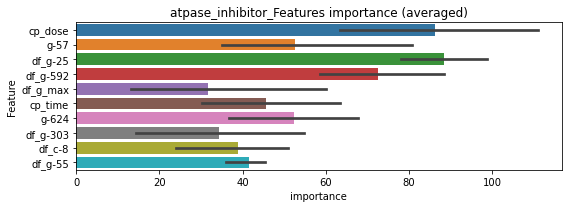

len(train_index) : 2398
len(valid_index) : 2398
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291536	valid_1's binary_logloss: 0.0895106
[200]	training's binary_logloss: 0.0057846	valid_1's binary_logloss: 0.0648234


len(train_index) : 2398
len(valid_index) : 2398


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00298528	valid_1's binary_logloss: 0.0620699


================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280705	valid_1's binary_logloss: 0.0859178
[200]	training's binary_logloss: 0.00515333	valid_1's binary_logloss: 0.0632023


atpase_inhibitor logloss: 0.06190136556653662


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00317856	valid_1's binary_logloss: 0.0617329


atr_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

1 / 3 AUC score:1.000
Threshold: 0.6601795032257118
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00236
p_label_rate: 0.00025 Vs.target_rate: 0.00086, Num_p_label: 1.0, conf_0:0.00236, conf_1:0.66018
Num_p_label: 1.0, Expected: 3.4, Adj_threshold_1: 0.66
Num_p_label: 2.0, Expected: 3.4, Adj_threshold_2: 0.62
Num_p_label: 3.0, Expected: 3.4, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065312	valid_1's binary_logloss: 0.103602
[200]	training's binary_logloss: 0.0110853	valid_1's binary_logloss: 0.0297132
[300]	training's binary_logloss: 0.00363084	valid_1's binary_logloss: 0.0136977
[400]	training's binary_logloss: 0.00195092	valid_1's binary_logloss: 0.00924682
[500]	training's binary_logloss: 0.0014509	valid_1's binary_logloss: 0.00751212
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00139381	valid_1's binary_logloss: 0.00724453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06216	valid_1's binary_logloss: 0.110775
[200]	training's binary_logloss: 0.0105453	valid_1's binary_logloss: 0.038844
[300]	training's binary_logloss: 0.00342528	valid_1's binary_logloss: 0.0210333
[400]	training's binary_logloss: 0.00190043	valid_1's binary_logloss: 0.0155301
[500]	training's binary_logloss: 0.00143772	valid_1

2 / 3 AUC score:1.000
Threshold: 0.5801795032257118
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
30th percentile: 0.00209
p_label_rate: 0.00075 Vs.target_rate: 0.00086, Num_p_label: 3.0, conf_0:0.00209, conf_1:0.58018
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0643591	valid_1's binary_logloss: 0.106069
[200]	training's binary_logloss: 0.0108194	valid_1's binary_logloss: 0.031931
[300]	training's binary_logloss: 0.00347214	valid_1's binary_logloss: 0.0154589
[400]	training's binary_logloss: 0.00190551	valid_1's binary_logloss: 0.0107351
[500]	training's binary_logloss: 0.00139694	valid_1's binary_logloss: 0.00878418
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00131583	valid_1's binary_logloss: 0.00836351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634725	valid_1's binary_logloss: 0.117921
[200]	training's binary_logloss: 0.0107964	valid_1's binary_logloss: 0.0395713
[300]	training's binary_logloss: 0.00352669	valid_1's binary_logloss: 0.0212094
[400]	training's binary_logloss: 0.00191755	valid_1's binary_logloss: 0.0152665
[500]	training's binary_logloss: 0.00142435	vali

3 / 3 AUC score:1.000
Threshold: 0.5801795032257118
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
30th percentile: 0.00215
p_label_rate: 0.00151 Vs.target_rate: 0.00086, Num_p_label: 6.0, conf_0:0.00215, conf_1:0.58018
threshold:0.58, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:505.0/4979, y_label_rate: 0.10143


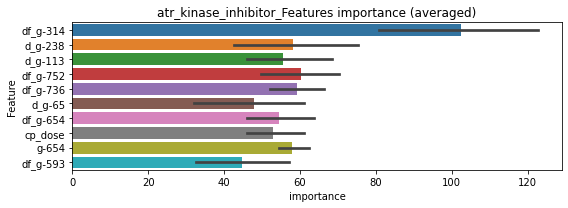

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164817	valid_1's binary_logloss: 0.027783
[200]	training's binary_logloss: 0.00208167	valid_1's binary_logloss: 0.00887528
[300]	training's binary_logloss: 0.000619904	valid_1's binary_logloss: 0.00661141
[400]	training's binary_logloss: 0.000338845	valid_1's binary_logloss: 0.00627616
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000341562	valid_1's binary_logloss: 0.00624922


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171028	valid_1's binary_logloss: 0.0298187
[200]	training's binary_logloss: 0.00212608	valid_1's binary_logloss: 0.0132542
[300]	training's binary_logloss: 0.000617534	valid_1's binary_logloss: 0.010148


atr_kinase_inhibitor logloss: 0.007965594808925534


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000433851	valid_1's binary_logloss: 0.00968266


aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153762	valid_1's binary_logloss: 0.367749
[200]	training's binary_logloss: 0.0460974	valid_1's binary_logloss: 0.258903
[300]	training's binary_logloss: 0.0165924	valid_1's binary_logloss: 0.220831
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0100201	valid_1's binary_logloss: 0.202706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145939	valid_1's binary_logloss: 0.371334
[200]	training's binary_logloss: 0.0437858	valid_1's binary_logloss: 0.268615
[300]	training's binary_logloss: 0.0161002	valid_1's binary_logloss: 0.225426
[400]	training's binary_logloss: 0.00772532	valid_1's binary_logloss: 0.207059
[500]	training's binary_logloss: 0.00473971	valid_1's binary_logloss: 0.198745
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00453318	valid_1's binary_logloss: 0.197973


1 / 3 AUC score:0.969
Threshold: 0.4073577317750806
Remove_noisy_labels: 82 → positive_corect_labels: 459/918
30th percentile: 0.07186
p_label_rate: 0.06429 Vs.target_rate: 0.00405, Num_p_label: 256.0, conf_0:0.07186, conf_1:0.52267
Num_p_label: 256.0, Expected: 16.1, Adj_threshold_1: 0.41
Num_p_label: 187.0, Expected: 16.1, Adj_threshold_2: 0.45
Num_p_label: 126.0, Expected: 16.1, Adj_threshold_3: 0.49
Num_p_label: 85.0, Expected: 16.1, Adj_threshold_4: 0.53
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_5: 0.57
Num_p_label: 33.0, Expected: 16.1, Adj_threshold_6: 0.61
Num_p_label: 24.0, Expected: 16.1, Adj_threshold_7: 0.65
threshold:0.65, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:459.0/918, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142038	valid_1's binary_logloss: 0.326564
[200]	training's binary_logloss: 0.0396935	valid_1's binary_logloss: 0.213845
[300]	training's binary_logloss: 0.0147499	valid_1's binary_logloss: 0.172577
[400]	training's binary_logloss: 0.00721041	valid_1's binary_logloss: 0.158401
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00633991	valid_1's binary_logloss: 0.153932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138122	valid_1's binary_logloss: 0.330242
[200]	training's binary_logloss: 0.0394207	valid_1's binary_logloss: 0.225351
[300]	training's binary_logloss: 0.0142694	valid_1's binary_logloss: 0.181575
[400]	training's binary_logloss: 0.00698637	valid_1's binary_logloss: 0.163307
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00482083	valid_1's binary_logloss: 0.156279


2 / 3 AUC score:0.981
Threshold: 0.6473577317750807
Remove_noisy_labels: 39 → positive_corect_labels: 423.0/879
30th percentile: 0.05592
p_label_rate: 0.01858 Vs.target_rate: 0.00405, Num_p_label: 74.0, conf_0:0.05592, conf_1:0.64736
Num_p_label: 74.0, Expected: 16.1, Adj_threshold_1: 0.65
Num_p_label: 46.0, Expected: 16.1, Adj_threshold_2: 0.69
Num_p_label: 31.0, Expected: 16.1, Adj_threshold_3: 0.73
Num_p_label: 17.0, Expected: 16.1, Adj_threshold_4: 0.77
threshold:0.77, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:423.0/879, y_label_rate: 0.48123
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131993	valid_1's binary_logloss: 0.300158
[200]	training's binary_logloss: 0.0348677	valid_1's binary_logloss: 0.179883
[300]	training's binary_logloss: 0.01267	valid_1's binary_logloss: 0.133892
[400]	training's binary_logloss: 0.00632096	valid_1's binary_logloss: 0.114131
[500]	training's binary_logloss: 0.00401865	valid_1's binary_logloss: 0.103785
[600]	training's binary_logloss: 0.00299461	valid_1's binary_logloss: 0.0957031
[700]	training's binary_logloss: 0.00244479	valid_1's binary_logloss: 0.0923269
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.00226058	valid_1's binary_logloss: 0.0914427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13735	valid_1's binary_logloss: 0.316824
[200]	training's binary_logloss: 0.0375141	valid_1's binary_logloss: 0.204512
[300]	training's binary_logloss: 0.0135015	valid_1's binary_

3 / 3 AUC score:0.990
Threshold: 0.7673577317750808
Remove_noisy_labels: 37 → positive_corect_labels: 387.0/842
30th percentile: 0.02660
p_label_rate: 0.00653 Vs.target_rate: 0.00405, Num_p_label: 26.0, conf_0:0.02174, conf_1:0.76736
threshold:0.77, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:413.0/4824, y_label_rate: 0.08561


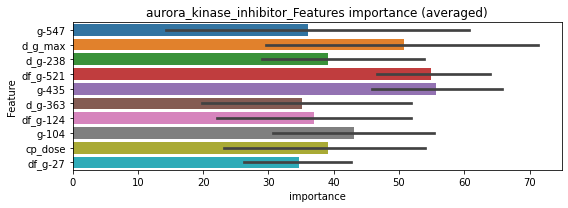

len(train_index) : 2412
len(valid_index) : 2412
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336586	valid_1's binary_logloss: 0.105009
[200]	training's binary_logloss: 0.0067772	valid_1's binary_logloss: 0.0767115
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00254593	valid_1's binary_logloss: 0.0726548


len(train_index) : 2412
len(valid_index) : 2412
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310961	valid_1's binary_logloss: 0.102586
[200]	training's binary_logloss: 0.00663874	valid_1's binary_logloss: 0.0803942


aurora_kinase_inhibitor logloss: 0.07440238973337043


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00295887	valid_1's binary_logloss: 0.07615


autotaxin_inhibitor , len(trt) : 6


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369474	valid_1's binary_logloss: 0.0474906
[200]	training's binary_logloss: 0.00427739	valid_1's binary_logloss: 0.0091687
[300]	training's binary_logloss: 0.0013723	valid_1's binary_logloss: 0.00419289
[400]	training's binary_logloss: 0.000882045	valid_1's binary_logloss: 0.00299316
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000797495	valid_1's binary_logloss: 0.00272503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378073	valid_1's binary_logloss: 0.047505
[200]	training's binary_logloss: 0.00438839	valid_1's binary_logloss: 0.00879355
[300]	training's binary_logloss: 0.00141017	valid_1's binary_logloss: 0.00396661
[400]	training's binary_logloss: 0.000889822	valid_1's binary_logloss: 0.00272013
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000813947	valid_1's binary_logloss: 0.00248506


1 / 3 AUC score:1.000
Threshold: 0.541580114752088
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00043
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00043, conf_1:0.54158
threshold:0.54, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369474	valid_1's binary_logloss: 0.0474906
[200]	training's binary_logloss: 0.00427739	valid_1's binary_logloss: 0.0091687
[300]	training's binary_logloss: 0.0013723	valid_1's binary_logloss: 0.00419289
[400]	training's binary_logloss: 0.000882045	valid_1's binary_logloss: 0.00299316
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000797495	valid_1's binary_logloss: 0.00272503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378073	valid_1's binary_logloss: 0.047505
[200]	training's binary_logloss: 0.00438839	valid_1's binary_logloss: 0.00879355
[300]	training's binary_logloss: 0.00141017	valid_1's binary_logloss: 0.00396661
[400]	training's binary_logloss: 0.000889822	valid_1's binary_logloss: 0.00272013
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000813947	valid_1's binary_logloss: 0.00248506


2 / 3 AUC score:1.000
Threshold: 0.541580114752088
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00043
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00043, conf_1:0.54158
threshold:0.54, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369474	valid_1's binary_logloss: 0.0474906
[200]	training's binary_logloss: 0.00427739	valid_1's binary_logloss: 0.0091687
[300]	training's binary_logloss: 0.0013723	valid_1's binary_logloss: 0.00419289
[400]	training's binary_logloss: 0.000882045	valid_1's binary_logloss: 0.00299316
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000797495	valid_1's binary_logloss: 0.00272503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378073	valid_1's binary_logloss: 0.047505
[200]	training's binary_logloss: 0.00438839	valid_1's binary_logloss: 0.00879355
[300]	training's binary_logloss: 0.00141017	valid_1's binary_logloss: 0.00396661
[400]	training's binary_logloss: 0.000889822	valid_1's binary_logloss: 0.00272013
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000813947	valid_1's binary_logloss: 0.00248506


3 / 3 AUC score:1.000
Threshold: 0.541580114752088
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00043
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00043, conf_1:0.54158
threshold:0.54, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


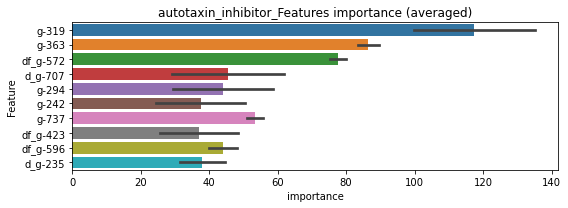

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102266	valid_1's binary_logloss: 0.0128781
[200]	training's binary_logloss: 0.000891042	valid_1's binary_logloss: 0.0031855


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 autotaxin_inhibitor=================================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000289907	valid_1's binary_logloss: 0.00255869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103575	valid_1's binary_logloss: 0.0108828
[200]	training's binary_logloss: 0.000930236	valid_1's binary_logloss: 0.00169097
[300]	training's binary_logloss: 0.000268677	valid_1's binary_logloss: 0.000871896
[400]	training's binary_logloss: 0.000166463	valid_1's binary_logloss: 0.000628194
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000159447	valid_1's binary_logloss: 0.000604879


autotaxin_inhibitor logloss: 0.001581784613014574
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115063	valid_1's binary_logloss: 0.274541
[200]	training's binary_logloss: 0.0282435	valid_1's binary_logloss: 0.178158
[300]	training's binary_logloss: 0.00982163	valid_1's binary_logloss: 0.14546
[400]	training's binary_logloss: 0.00487728	valid_1's binary_logloss: 0.130392
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00449394	valid_1's binary_logloss: 0.128588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125877	valid_1's binary_logloss: 0.25489
[200]	training's binary_logloss: 0.0332713	valid_1's binary_logloss: 0.144109
[300]	training's binary_logloss: 0.0115112	valid_1's binary_logloss: 0.103128
[400]	training's binary_logloss: 0.00562616	valid_1's binary_logloss: 0.0838917
[500]	training's binary_logloss: 0.00354945	valid_1's binary_logloss: 0.0747714
Early stopping, best iteration is:
[570]	training's binary_l

1 / 3 AUC score:0.992
Threshold: 0.3814075906602167
Remove_noisy_labels: 30 → positive_corect_labels: 485/970
30th percentile: 0.02418
p_label_rate: 0.01532 Vs.target_rate: 0.00262, Num_p_label: 61.0, conf_0:0.02418, conf_1:0.52327
Num_p_label: 61.0, Expected: 10.4, Adj_threshold_1: 0.38
Num_p_label: 40.0, Expected: 10.4, Adj_threshold_2: 0.42
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_3: 0.46
Num_p_label: 14.0, Expected: 10.4, Adj_threshold_4: 0.50
threshold:0.50, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109536	valid_1's binary_logloss: 0.252728
[200]	training's binary_logloss: 0.0266728	valid_1's binary_logloss: 0.15238
[300]	training's binary_logloss: 0.00931911	valid_1's binary_logloss: 0.117179
[400]	training's binary_logloss: 0.00473697	valid_1's binary_logloss: 0.104642
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00452331	valid_1's binary_logloss: 0.104448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116705	valid_1's binary_logloss: 0.269981
[200]	training's binary_logloss: 0.0294033	valid_1's binary_logloss: 0.164302
[300]	training's binary_logloss: 0.00997866	valid_1's binary_logloss: 0.121886
[400]	training's binary_logloss: 0.00494947	valid_1's binary_logloss: 0.106172
[500]	training's binary_logloss: 0.003195	valid_1's binary_logloss: 0.0968774
[600]	training's binary_logloss: 0.00243347	valid_1's binary_

2 / 3 AUC score:0.991
Threshold: 0.5014075906602167
Remove_noisy_labels: 29 → positive_corect_labels: 463.0/941
30th percentile: 0.02193
p_label_rate: 0.00728 Vs.target_rate: 0.00262, Num_p_label: 29.0, conf_0:0.02193, conf_1:0.50141
threshold:0.50, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:463.0/941, y_label_rate: 0.49203
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108415	valid_1's binary_logloss: 0.253246
[200]	training's binary_logloss: 0.0263822	valid_1's binary_logloss: 0.151316
[300]	training's binary_logloss: 0.00893243	valid_1's binary_logloss: 0.120508
[400]	training's binary_logloss: 0.00448327	valid_1's binary_logloss: 0.108195
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00398343	valid_1's binary_logloss: 0.106331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107833	valid_1's binary_logloss: 0.261086
[200]	training's binary_logloss: 0.0259459	valid_1's binary_logloss: 0.177425


3 / 3 AUC score:0.985
Threshold: 0.5014075906602167
Remove_noisy_labels: 35 → positive_corect_labels: 430.0/906
30th percentile: 0.02871


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0109463	valid_1's binary_logloss: 0.155413


p_label_rate: 0.00703 Vs.target_rate: 0.00262, Num_p_label: 28.0, conf_0:0.02871, conf_1:0.50141
threshold:0.50, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:458.0/4888, y_label_rate: 0.09370


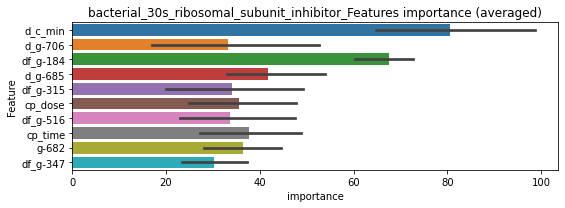

len(train_index) : 2444
len(valid_index) : 2444
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281811	valid_1's binary_logloss: 0.0801793
[200]	training's binary_logloss: 0.00506972	valid_1's binary_logloss: 0.055331


len(train_index) : 2444
len(valid_index) : 2444


Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00303093	valid_1's binary_logloss: 0.0530818


================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272759	valid_1's binary_logloss: 0.0801243
[200]	training's binary_logloss: 0.00493667	valid_1's binary_logloss: 0.0568801


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.05269614106406498


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0026015	valid_1's binary_logloss: 0.0523105


bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142209	valid_1's binary_logloss: 0.316638
[200]	training's binary_logloss: 0.0403793	valid_1's binary_logloss: 0.209427
[300]	training's binary_logloss: 0.0143819	valid_1's binary_logloss: 0.168691
[400]	training's binary_logloss: 0.006845	valid_1's binary_logloss: 0.150635
[500]	training's binary_logloss: 0.00420239	valid_1's binary_logloss: 0.140333
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.0040615	valid_1's binary_logloss: 0.139839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139717	valid_1's binary_logloss: 0.301918
[200]	training's binary_logloss: 0.0392786	valid_1's binary_logloss: 0.185316
[300]	training's binary_logloss: 0.0138184	valid_1's binary_logloss: 0.138889
[400]	training's binary_logloss: 0.00669357	valid_1's binary_logloss: 0.119472
[500]	training's binary_logloss: 0.00412149	valid_1's binary_log

1 / 3 AUC score:0.989
Threshold: 0.39130545538668726
Remove_noisy_labels: 46 → positive_corect_labels: 477/954
30th percentile: 0.03431
p_label_rate: 0.02963 Vs.target_rate: 0.00343, Num_p_label: 118.0, conf_0:0.03431, conf_1:0.49164
Num_p_label: 118.0, Expected: 13.6, Adj_threshold_1: 0.39
Num_p_label: 79.0, Expected: 13.6, Adj_threshold_2: 0.43
Num_p_label: 64.0, Expected: 13.6, Adj_threshold_3: 0.47
Num_p_label: 45.0, Expected: 13.6, Adj_threshold_4: 0.51
Num_p_label: 32.0, Expected: 13.6, Adj_threshold_5: 0.55
Num_p_label: 25.0, Expected: 13.6, Adj_threshold_6: 0.59
Num_p_label: 19.0, Expected: 13.6, Adj_threshold_7: 0.63
threshold:0.63, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:477.0/954, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129538	valid_1's binary_logloss: 0.284051
[200]	training's binary_logloss: 0.0357756	valid_1's binary_logloss: 0.178096
[300]	training's binary_logloss: 0.012985	valid_1's binary_logloss: 0.136803
[400]	training's binary_logloss: 0.00634541	valid_1's binary_logloss: 0.115552
[500]	training's binary_logloss: 0.00393672	valid_1's binary_logloss: 0.106031
[600]	training's binary_logloss: 0.00288788	valid_1's binary_logloss: 0.100159
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00294627	valid_1's binary_logloss: 0.100076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134712	valid_1's binary_logloss: 0.304744
[200]	training's binary_logloss: 0.0373587	valid_1's binary_logloss: 0.188614
[300]	training's binary_logloss: 0.0134232	valid_1's binary_logloss: 0.145949
[400]	training's binary_logloss: 0.00647967	valid_1's binary_l

2 / 3 AUC score:0.995
Threshold: 0.6313054553866874
Remove_noisy_labels: 35 → positive_corect_labels: 445.0/919
30th percentile: 0.03300
p_label_rate: 0.00527 Vs.target_rate: 0.00343, Num_p_label: 21.0, conf_0:0.03300, conf_1:0.63131
threshold:0.63, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:445.0/919, y_label_rate: 0.48422
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131805	valid_1's binary_logloss: 0.31227
[200]	training's binary_logloss: 0.0357352	valid_1's binary_logloss: 0.203115
[300]	training's binary_logloss: 0.0127615	valid_1's binary_logloss: 0.162501
[400]	training's binary_logloss: 0.00621358	valid_1's binary_logloss: 0.143951
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0058762	valid_1's binary_logloss: 0.142328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131859	valid_1's binary_logloss: 0.29332
[200]	training's binary_logloss: 0.0357161	valid_1's binary_logloss: 0.177934
[300]	training's binary_logloss: 0.0124251	valid_1's binary_logloss: 0.125007
[400]	training's binary_logloss: 0.00609986	valid_1's binary_logloss: 0.104695


3 / 3 AUC score:0.993
Threshold: 0.6313054553866874


[500]	training's binary_logloss: 0.00384556	valid_1's binary_logloss: 0.094715
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00397908	valid_1's binary_logloss: 0.0945293


Remove_noisy_labels: 30 → positive_corect_labels: 421.0/889
30th percentile: 0.03617
p_label_rate: 0.00603 Vs.target_rate: 0.00343, Num_p_label: 24.0, conf_0:0.03617, conf_1:0.63131
threshold:0.63, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:445.0/4871, y_label_rate: 0.09136


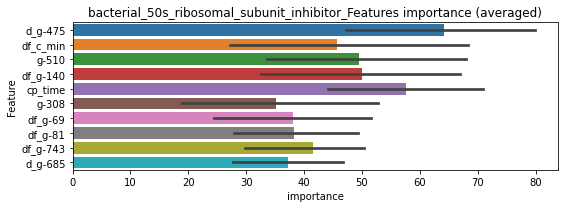

len(train_index) : 2435
len(valid_index) : 2436
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039624	valid_1's binary_logloss: 0.0928338
[200]	training's binary_logloss: 0.00853574	valid_1's binary_logloss: 0.0604349
[300]	training's binary_logloss: 0.00249125	valid_1's binary_logloss: 0.0529825
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00213744	valid_1's binary_logloss: 0.0527348


len(train_index) : 2436
len(valid_index) : 2435
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372937	valid_1's binary_logloss: 0.0976282
[200]	training's binary_logloss: 0.00716341	valid_1's binary_logloss: 0.0656271
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00250579	valid_1's binary_logloss: 0.060303


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.056518128450959264
bacterial_antifolate , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944769	valid_1's binary_logloss: 0.190371
[200]	training's binary_logloss: 0.0204007	valid_1's binary_logloss: 0.0984236
[300]	training's binary_logloss: 0.00659605	valid_1's binary_logloss: 0.0738498
[400]	training's binary_logloss: 0.00334733	valid_1's binary_logloss: 0.065846
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00269683	valid_1's binary_logloss: 0.0638318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914606	valid_1's binary_logloss: 0.177034
[200]	training's binary_logloss: 0.0197739	valid_1's binary_logloss: 0.0841858
[300]	training's binary_logloss: 0.00655377	valid_1's binary_logloss: 0.0561943
[400]	training's binary_logloss: 0.00337279	valid_1's binary_logloss: 0.0476093
[500]	training's binary_logloss: 0.00227642	valid_1's binary_logloss: 0.0438607


1 / 3 AUC score:0.996


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00186915	valid_1's binary_logloss: 0.0417109


Threshold: 0.35246522275636666
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentile: 0.00893
p_label_rate: 0.00527 Vs.target_rate: 0.00161, Num_p_label: 21.0, conf_0:0.00893, conf_1:0.52989
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_1: 0.35
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_2: 0.39
Num_p_label: 8.0, Expected: 6.4, Adj_threshold_3: 0.43
threshold:0.43, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887305	valid_1's binary_logloss: 0.169569
[200]	training's binary_logloss: 0.0187805	valid_1's binary_logloss: 0.0728597
[300]	training's binary_logloss: 0.0061533	valid_1's binary_logloss: 0.0451568
[400]	training's binary_logloss: 0.00317297	valid_1's binary_logloss: 0.0367475
[500]	training's binary_logloss: 0.002168	valid_1's binary_logloss: 0.0318514
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00201418	valid_1's binary_logloss: 0.0312572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935446	valid_1's binary_logloss: 0.164625
[200]	training's binary_logloss: 0.0201604	valid_1's binary_logloss: 0.0703733
[300]	training's binary_logloss: 0.00657557	valid_1's binary_logloss: 0.0424295
[400]	training's binary_logloss: 0.003354	valid_1's binary_logloss: 0.0344028
[500]	training's binary_logloss: 0.0022545	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.4324652227563666
Remove_noisy_labels: 7 → positive_corect_labels: 487.0/975
30th percentile: 0.00742
p_label_rate: 0.00502 Vs.target_rate: 0.00161, Num_p_label: 20.0, conf_0:0.00742, conf_1:0.50063
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_1: 0.43
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_2: 0.47
Num_p_label: 8.0, Expected: 6.4, Adj_threshold_3: 0.51
threshold:0.51, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:487.0/975, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868961	valid_1's binary_logloss: 0.170525
[200]	training's binary_logloss: 0.0181526	valid_1's binary_logloss: 0.0741887
[300]	training's binary_logloss: 0.00599237	valid_1's binary_logloss: 0.0431274
[400]	training's binary_logloss: 0.00309997	valid_1's binary_logloss: 0.0322939
[500]	training's binary_logloss: 0.00211761	valid_1's binary_logloss: 0.0274334
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00178241	valid_1's binary_logloss: 0.0251692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919899	valid_1's binary_logloss: 0.172284
[200]	training's binary_logloss: 0.0194867	valid_1's binary_logloss: 0.0741846
[300]	training's binary_logloss: 0.00637122	valid_1's binary_logloss: 0.0496189
[400]	training's binary_logloss: 0.00325288	valid_1's binary_logloss: 0.0420269
Early stopping, best iteration is:
[424]	training

3 / 3 AUC score:1.000
Threshold: 0.5124652227563666
Remove_noisy_labels: 6 → positive_corect_labels: 481.0/969
30th percentile: 0.00787
p_label_rate: 0.00251 Vs.target_rate: 0.00161, Num_p_label: 10.0, conf_0:0.00787, conf_1:0.51279
threshold:0.51, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:491.0/4951, y_label_rate: 0.09917


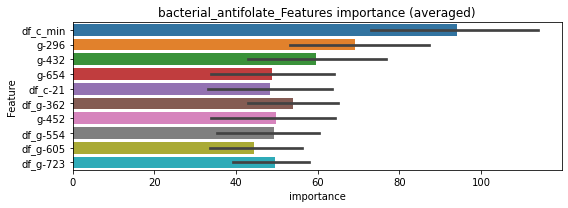

len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254076	valid_1's binary_logloss: 0.0473072
[200]	training's binary_logloss: 0.00406491	valid_1's binary_logloss: 0.02068
[300]	training's binary_logloss: 0.00110013	valid_1's binary_logloss: 0.0154399
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000730505	valid_1's binary_logloss: 0.0150671


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269508	valid_1's binary_logloss: 0.0473477
[200]	training's binary_logloss: 0.00422689	valid_1's binary_logloss: 0.0161552
[300]	training's binary_logloss: 0.00114823	valid_1's binary_logloss: 0.0103605
[400]	training's binary_logloss: 0.000556751	valid_1's binary_logloss: 0.00919862
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000494157	valid_1's binary_logloss: 0.0089988


bacterial_antifolate logloss: 0.012033562982976082
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192143	valid_1's binary_logloss: 0.524335
[200]	training's binary_logloss: 0.0666826	valid_1's binary_logloss: 0.478362
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0335838	valid_1's binary_logloss: 0.462428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185979	valid_1's binary_logloss: 0.505026
[200]	training's binary_logloss: 0.0647871	valid_1's binary_logloss: 0.460915


1 / 3 AUC score:0.849
Threshold: 0.46586807900970195
Remove_noisy_labels: 236 → positive_corect_labels: 382/764
30th percentile: 0.22211


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.032132	valid_1's binary_logloss: 0.45168


p_label_rate: 0.13938 Vs.target_rate: 0.00732, Num_p_label: 555.0, conf_0:0.22211, conf_1:0.48874
Num_p_label: 555.0, Expected: 29.2, Adj_threshold_1: 0.47
Num_p_label: 363.0, Expected: 29.2, Adj_threshold_2: 0.51
Num_p_label: 243.0, Expected: 29.2, Adj_threshold_3: 0.55
Num_p_label: 140.0, Expected: 29.2, Adj_threshold_4: 0.59
Num_p_label: 70.0, Expected: 29.2, Adj_threshold_5: 0.63
Num_p_label: 38.0, Expected: 29.2, Adj_threshold_6: 0.67
threshold:0.67, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:382.0/764, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169354	valid_1's binary_logloss: 0.437538
[200]	training's binary_logloss: 0.0553008	valid_1's binary_logloss: 0.358933
[300]	training's binary_logloss: 0.0214835	valid_1's binary_logloss: 0.315993
[400]	training's binary_logloss: 0.0106167	valid_1's binary_logloss: 0.299375
[500]	training's binary_logloss: 0.00637512	valid_1's binary_logloss: 0.285783
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00624791	valid_1's binary_logloss: 0.284067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170802	valid_1's binary_logloss: 0.439779
[200]	training's binary_logloss: 0.0555014	valid_1's binary_logloss: 0.35772
[300]	training's binary_logloss: 0.0215536	valid_1's binary_logloss: 0.320617
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0209245	valid_1's binary_logloss: 0.319725


2 / 3 AUC score:0.942
Threshold: 0.6658680790097021
Remove_noisy_labels: 97 → positive_corect_labels: 304.0/667
30th percentile: 0.14336
p_label_rate: 0.05600 Vs.target_rate: 0.00732, Num_p_label: 223.0, conf_0:0.14336, conf_1:0.66587
Num_p_label: 223.0, Expected: 29.2, Adj_threshold_1: 0.67
Num_p_label: 154.0, Expected: 29.2, Adj_threshold_2: 0.71
Num_p_label: 106.0, Expected: 29.2, Adj_threshold_3: 0.75
Num_p_label: 69.0, Expected: 29.2, Adj_threshold_4: 0.79
Num_p_label: 43.0, Expected: 29.2, Adj_threshold_5: 0.83
threshold:0.83, positive p_label:43.0/3982, p_label_rate: 0.01080
positive y_label:304.0/667, y_label_rate: 0.45577
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149747	valid_1's binary_logloss: 0.399172
[200]	training's binary_logloss: 0.0470732	valid_1's binary_logloss: 0.313629
[300]	training's binary_logloss: 0.0180284	valid_1's binary_logloss: 0.280541
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0153955	valid_1's binary_logloss: 0.275897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155624	valid_1's binary_logloss: 0.377898
[200]	training's binary_logloss: 0.0473532	valid_1's binary_logloss: 0.283134
[300]	training's binary_logloss: 0.0183524	valid_1's binary_logloss: 0.250912


3 / 3 AUC score:0.958
Threshold: 0.8258680790097023
Remove_noisy_labels: 104 → positive_corect_labels: 200.0/563
30th percentile: 0.08543
p_label_rate: 0.00527 Vs.target_rate: 0.00732, Num_p_label: 21.0, conf_0:0.08543, conf_1:0.82587
threshold:0.83, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0130281	valid_1's binary_logloss: 0.238186


positive y_label:221.0/4545, y_label_rate: 0.04862


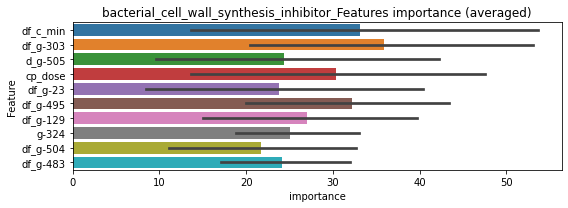

len(train_index) : 2272
len(valid_index) : 2273
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183781	valid_1's binary_logloss: 0.0924645


len(train_index) : 2273
len(valid_index) : 2272
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0128013	valid_1's binary_logloss: 0.0886704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157001	valid_1's binary_logloss: 0.104023


bacterial_cell_wall_synthesis_inhibitor logloss: 0.09604149960810014
bacterial_dna_gyrase_inhibitor , len(trt) : 89


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0143745	valid_1's binary_logloss: 0.103416
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145707	valid_1's binary_logloss: 0.339705
[200]	training's binary_logloss: 0.0422768	valid_1's binary_logloss: 0.24245
[300]	training's binary_logloss: 0.0154729	valid_1's binary_logloss: 0.20324
[400]	training's binary_logloss: 0.00741503	valid_1's binary_logloss: 0.184306
[500]	training's binary_logloss: 0.00454214	valid_1's binary_logloss: 0.175415
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00357485	valid_1's binary_logloss: 0.169464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145424	valid_1's binary_logloss: 0.351541
[200]	training's binary_logloss: 0.0412168	valid_1's binary_logloss: 0.25454
[300]	training's binary_logloss: 0.0151011	valid_1's binary_logloss: 0.213125
[400]	training's binary_logloss: 0.00726559	valid_1's binary_logloss: 0.193006
[500]	training's binary_logloss: 0.00443702	valid_1's binary_log

1 / 3 AUC score:0.976
Threshold: 0.4313180816217732
Remove_noisy_labels: 64 → positive_corect_labels: 468/936
30th percentile: 0.04687
p_label_rate: 0.04068 Vs.target_rate: 0.00378, Num_p_label: 162.0, conf_0:0.04687, conf_1:0.45756
Num_p_label: 162.0, Expected: 15.0, Adj_threshold_1: 0.43
Num_p_label: 127.0, Expected: 15.0, Adj_threshold_2: 0.47
Num_p_label: 87.0, Expected: 15.0, Adj_threshold_3: 0.51
Num_p_label: 58.0, Expected: 15.0, Adj_threshold_4: 0.55
Num_p_label: 37.0, Expected: 15.0, Adj_threshold_5: 0.59
Num_p_label: 20.0, Expected: 15.0, Adj_threshold_6: 0.63
threshold:0.63, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:468.0/936, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134171	valid_1's binary_logloss: 0.305666
[200]	training's binary_logloss: 0.0373304	valid_1's binary_logloss: 0.197153
[300]	training's binary_logloss: 0.0133428	valid_1's binary_logloss: 0.153867
[400]	training's binary_logloss: 0.00649716	valid_1's binary_logloss: 0.136701
[500]	training's binary_logloss: 0.0040414	valid_1's binary_logloss: 0.12963
[600]	training's binary_logloss: 0.00298568	valid_1's binary_logloss: 0.125142
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00290738	valid_1's binary_logloss: 0.124806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13605	valid_1's binary_logloss: 0.313658
[200]	training's binary_logloss: 0.0378466	valid_1's binary_logloss: 0.209872
[300]	training's binary_logloss: 0.0134242	valid_1's binary_logloss: 0.166947
[400]	training's binary_logloss: 0.00657837	valid_1's binary_log

2 / 3 AUC score:0.985
Threshold: 0.6313180816217733
Remove_noisy_labels: 36 → positive_corect_labels: 434.0/900
30th percentile: 0.04123
p_label_rate: 0.00929 Vs.target_rate: 0.00378, Num_p_label: 37.0, conf_0:0.04123, conf_1:0.63132


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00570177	valid_1's binary_logloss: 0.146117


threshold:0.63, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:434.0/900, y_label_rate: 0.48222
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128424	valid_1's binary_logloss: 0.286502
[200]	training's binary_logloss: 0.0354329	valid_1's binary_logloss: 0.177566
[300]	training's binary_logloss: 0.012703	valid_1's binary_logloss: 0.134931
[400]	training's binary_logloss: 0.00616611	valid_1's binary_logloss: 0.115328
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00476936	valid_1's binary_logloss: 0.111644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128477	valid_1's binary_logloss: 0.268148
[200]	training's binary_logloss: 0.0353975	valid_1's binary_logloss: 0.159057
[300]	training's binary_logloss: 0.0128341	valid_1's binary_logloss: 0.113654
[400]	training's binary_logloss: 0.00635438	valid_1's binary_logloss: 0.0942013
[500]	training's binary_logloss: 0.00400721	valid_1's binary_logloss: 0.0862441
[600]	training's binary_logloss: 0.00297747	valid_1's binary

3 / 3 AUC score:0.997
Threshold: 0.6313180816217733
Remove_noisy_labels: 26 → positive_corect_labels: 411.0/874
30th percentile: 0.02778
p_label_rate: 0.00804 Vs.target_rate: 0.00378, Num_p_label: 32.0, conf_0:0.02778, conf_1:0.63132
threshold:0.63, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:443.0/4856, y_label_rate: 0.09123


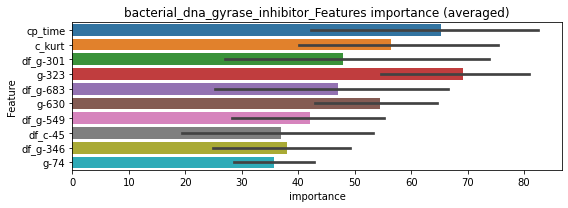

len(train_index) : 2428
len(valid_index) : 2428
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398714	valid_1's binary_logloss: 0.0934216
[200]	training's binary_logloss: 0.00843423	valid_1's binary_logloss: 0.0582521
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00296253	valid_1's binary_logloss: 0.0524807


len(train_index) : 2428
len(valid_index) : 2428
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337843	valid_1's binary_logloss: 0.110238
[200]	training's binary_logloss: 0.00704867	valid_1's binary_logloss: 0.0848644


bacterial_dna_gyrase_inhibitor logloss: 0.06771163601999054


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00446037	valid_1's binary_logloss: 0.0829426


bacterial_dna_inhibitor , len(trt) : 115


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156029	valid_1's binary_logloss: 0.369067
[200]	training's binary_logloss: 0.0480247	valid_1's binary_logloss: 0.28004
[300]	training's binary_logloss: 0.0179025	valid_1's binary_logloss: 0.243677
[400]	training's binary_logloss: 0.00861846	valid_1's binary_logloss: 0.229833
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00622232	valid_1's binary_logloss: 0.226089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161677	valid_1's binary_logloss: 0.393737
[200]	training's binary_logloss: 0.0497121	valid_1's binary_logloss: 0.300786
[300]	training's binary_logloss: 0.0183012	valid_1's binary_logloss: 0.259577


1 / 3 AUC score:0.958
Threshold: 0.43868658333320676
Remove_noisy_labels: 92 → positive_corect_labels: 454/908
30th percentile: 0.08514
p_label_rate: 0.05676 Vs.target_rate: 0.00476, Num_p_label: 226.0, conf_0:0.08514, conf_1:0.52799


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0116489	valid_1's binary_logloss: 0.247045


Num_p_label: 226.0, Expected: 18.9, Adj_threshold_1: 0.44
Num_p_label: 171.0, Expected: 18.9, Adj_threshold_2: 0.48
Num_p_label: 119.0, Expected: 18.9, Adj_threshold_3: 0.52
Num_p_label: 79.0, Expected: 18.9, Adj_threshold_4: 0.56
Num_p_label: 51.0, Expected: 18.9, Adj_threshold_5: 0.60
Num_p_label: 35.0, Expected: 18.9, Adj_threshold_6: 0.64
Num_p_label: 22.0, Expected: 18.9, Adj_threshold_7: 0.68
threshold:0.68, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:454.0/908, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148668	valid_1's binary_logloss: 0.317305
[200]	training's binary_logloss: 0.0434869	valid_1's binary_logloss: 0.203892
[300]	training's binary_logloss: 0.0161103	valid_1's binary_logloss: 0.159145
[400]	training's binary_logloss: 0.00784483	valid_1's binary_logloss: 0.13888
[500]	training's binary_logloss: 0.00481241	valid_1's binary_logloss: 0.127587
[600]	training's binary_logloss: 0.00346891	valid_1's binary_logloss: 0.121257
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00336167	valid_1's binary_logloss: 0.120763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141326	valid_1's binary_logloss: 0.324208
[200]	training's binary_logloss: 0.040736	valid_1's binary_logloss: 0.216528
[300]	training's binary_logloss: 0.0147837	valid_1's binary_logloss: 0.176277
[400]	training's binary_logloss: 0.00723222	valid_1's binary_lo

2 / 3 AUC score:0.991
Threshold: 0.6786865833332069
Remove_noisy_labels: 37 → positive_corect_labels: 423.0/871
30th percentile: 0.04236
p_label_rate: 0.02034 Vs.target_rate: 0.00476, Num_p_label: 81.0, conf_0:0.01979, conf_1:0.67869
Num_p_label: 81.0, Expected: 18.9, Adj_threshold_1: 0.68
Num_p_label: 64.0, Expected: 18.9, Adj_threshold_2: 0.72
Num_p_label: 42.0, Expected: 18.9, Adj_threshold_3: 0.76
Num_p_label: 25.0, Expected: 18.9, Adj_threshold_4: 0.80
threshold:0.80, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:423.0/871, y_label_rate: 0.48565
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140925	valid_1's binary_logloss: 0.321749
[200]	training's binary_logloss: 0.0396685	valid_1's binary_logloss: 0.211813
[300]	training's binary_logloss: 0.0142622	valid_1's binary_logloss: 0.170712
[400]	training's binary_logloss: 0.00689898	valid_1's binary_logloss: 0.153571
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00630975	valid_1's binary_logloss: 0.152198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132143	valid_1's binary_logloss: 0.350547
[200]	training's binary_logloss: 0.0370808	valid_1's binary_logloss: 0.255783
[300]	training's binary_logloss: 0.0133516	valid_1's binary_logloss: 0.218909


3 / 3 AUC score:0.974
Threshold: 0.798686583333207
Remove_noisy_labels: 59 → positive_corect_labels: 366.0/812


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0104196	valid_1's binary_logloss: 0.210824


30th percentile: 0.05268
p_label_rate: 0.00276 Vs.target_rate: 0.00476, Num_p_label: 11.0, conf_0:0.05268, conf_1:0.79869
threshold:0.80, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:377.0/4794, y_label_rate: 0.07864


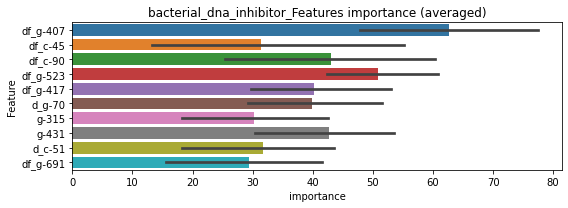

len(train_index) : 2397
len(valid_index) : 2397
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031763	valid_1's binary_logloss: 0.0934396
[200]	training's binary_logloss: 0.00648423	valid_1's binary_logloss: 0.0688669
[300]	training's binary_logloss: 0.00197396	valid_1's binary_logloss: 0.0633926
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00188461	valid_1's binary_logloss: 0.0633105


len(train_index) : 2397
len(valid_index) : 2397
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314856	valid_1's binary_logloss: 0.0929978
[200]	training's binary_logloss: 0.00668108	valid_1's binary_logloss: 0.0654232


bacterial_dna_inhibitor logloss: 0.061672375122958006


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00251713	valid_1's binary_logloss: 0.0600343


bacterial_membrane_integrity_inhibitor , len(trt) : 19


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673432	valid_1's binary_logloss: 0.11797
[200]	training's binary_logloss: 0.0107473	valid_1's binary_logloss: 0.0400272
[300]	training's binary_logloss: 0.00333283	valid_1's binary_logloss: 0.0238357
[400]	training's binary_logloss: 0.0018045	valid_1's binary_logloss: 0.0185357
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00138554	valid_1's binary_logloss: 0.0171362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705861	valid_1's binary_logloss: 0.116895
[200]	training's binary_logloss: 0.0114325	valid_1's binary_logloss: 0.0341612
[300]	training's binary_logloss: 0.00353036	valid_1's binary_logloss: 0.0168737
[400]	training's binary_logloss: 0.0018627	valid_1's binary_logloss: 0.0110991
[500]	training's binary_logloss: 0.00137595	valid_1's binary_logloss: 0.00922378
Early stopping, best iteration is:
[561]	training's

1 / 3 AUC score:1.000
Threshold: 0.2280124645332291
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00247
p_label_rate: 0.00427 Vs.target_rate: 0.00086, Num_p_label: 17.0, conf_0:0.00247, conf_1:0.46928
Num_p_label: 17.0, Expected: 3.4, Adj_threshold_1: 0.23
Num_p_label: 8.0, Expected: 3.4, Adj_threshold_2: 0.27
Num_p_label: 7.0, Expected: 3.4, Adj_threshold_3: 0.31
Num_p_label: 6.0, Expected: 3.4, Adj_threshold_4: 0.35
Num_p_label: 6.0, Expected: 3.4, Adj_threshold_5: 0.39
Num_p_label: 5.0, Expected: 3.4, Adj_threshold_6: 0.43
threshold:0.43, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676914	valid_1's binary_logloss: 0.109214
[200]	training's binary_logloss: 0.0111902	valid_1's binary_logloss: 0.0349124
[300]	training's binary_logloss: 0.00349831	valid_1's binary_logloss: 0.0178339
[400]	training's binary_logloss: 0.00186128	valid_1's binary_logloss: 0.0137326
[500]	training's binary_logloss: 0.00138443	valid_1's binary_logloss: 0.0118997
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00131167	valid_1's binary_logloss: 0.0115314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661996	valid_1's binary_logloss: 0.118773
[200]	training's binary_logloss: 0.0107709	valid_1's binary_logloss: 0.0398594
[300]	training's binary_logloss: 0.00337051	valid_1's binary_logloss: 0.0199236
[400]	training's binary_logloss: 0.00180892	valid_1's binary_logloss: 0.0142572


2 / 3 AUC score:1.000
Threshold: 0.428012464533229
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/994
30th percentile: 0.00236
p_label_rate: 0.00126 Vs.target_rate: 0.00086, Num_p_label: 5.0, conf_0:0.00236, conf_1:0.42801
threshold:0.43, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00139836	valid_1's binary_logloss: 0.0123801


positive y_label:496.0/994, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0669076	valid_1's binary_logloss: 0.109027
[200]	training's binary_logloss: 0.0110903	valid_1's binary_logloss: 0.0361345
[300]	training's binary_logloss: 0.00345386	valid_1's binary_logloss: 0.0193644
[400]	training's binary_logloss: 0.00187606	valid_1's binary_logloss: 0.0146554
[500]	training's binary_logloss: 0.00138702	valid_1's binary_logloss: 0.0126553
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00131499	valid_1's binary_logloss: 0.0123743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698967	valid_1's binary_logloss: 0.120204
[200]	training's binary_logloss: 0.0112068	valid_1's binary_logloss: 0.0358404
[300]	training's binary_logloss: 0.00348073	valid_1's binary_logloss: 0.0176843
[400]	training's binary_logloss: 0.00184367	valid_1's binary_logloss: 0.0127161
[500]	training's binary_logloss: 0.00137775	valid

3 / 3 AUC score:1.000
Threshold: 0.428012464533229
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/993
30th percentile: 0.00223
p_label_rate: 0.00176 Vs.target_rate: 0.00086, Num_p_label: 7.0, conf_0:0.00223, conf_1:0.43684
threshold:0.43, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:502.0/4975, y_label_rate: 0.10090


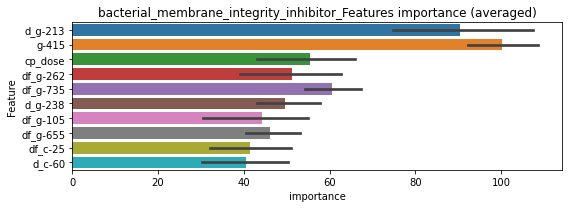

len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157617	valid_1's binary_logloss: 0.0277631
[200]	training's binary_logloss: 0.00189972	valid_1's binary_logloss: 0.0125927


len(train_index) : 2488
len(valid_index) : 2487


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000657152	valid_1's binary_logloss: 0.0112397


================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165739	valid_1's binary_logloss: 0.0331849
[200]	training's binary_logloss: 0.00204907	valid_1's binary_logloss: 0.0170142
[300]	training's binary_logloss: 0.000584126	valid_1's binary_logloss: 0.0146698


bacterial_membrane_integrity_inhibitor logloss: 0.01288214989092154


Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000548898	valid_1's binary_logloss: 0.0145252


bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859563	valid_1's binary_logloss: 0.152773
[200]	training's binary_logloss: 0.0170349	valid_1's binary_logloss: 0.0596477
[300]	training's binary_logloss: 0.00541451	valid_1's binary_logloss: 0.034543
[400]	training's binary_logloss: 0.00281574	valid_1's binary_logloss: 0.0266443
[500]	training's binary_logloss: 0.00191992	valid_1's binary_logloss: 0.0233879
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00165036	valid_1's binary_logloss: 0.0217599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085354	valid_1's binary_logloss: 0.149849
[200]	training's binary_logloss: 0.016903	valid_1's binary_logloss: 0.0519509
[300]	training's binary_logloss: 0.00551192	valid_1's binary_logloss: 0.0286326
[400]	training's binary_logloss: 0.00284492	valid_1's binary_logloss: 0.0211725
[500]	training's binary_logloss: 0.00193275	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.703637428701384
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00394
p_label_rate: 0.00100 Vs.target_rate: 0.00139, Num_p_label: 4.0, conf_0:0.00394, conf_1:0.70364
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844614	valid_1's binary_logloss: 0.161214
[200]	training's binary_logloss: 0.0169945	valid_1's binary_logloss: 0.0733046
[300]	training's binary_logloss: 0.00538271	valid_1's binary_logloss: 0.0461198
[400]	training's binary_logloss: 0.00275297	valid_1's binary_logloss: 0.0381576
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00217352	valid_1's binary_logloss: 0.0362656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846629	valid_1's binary_logloss: 0.146324
[200]	training's binary_logloss: 0.0163514	valid_1's binary_logloss: 0.052172
[300]	training's binary_logloss: 0.00533106	valid_1's binary_logloss: 0.0299006
[400]	training's binary_logloss: 0.00276613	valid_1's binary_logloss: 0.0216318
[500]	training's binary_logloss: 0.00191953	valid_1's binary_logloss: 0.0185018
Early stopping, best iteration is:
[530]	training'

2 / 3 AUC score:1.000
Threshold: 0.703637428701384
Remove_noisy_labels: 4 → positive_corect_labels: 495.0/994
30th percentile: 0.00480
p_label_rate: 0.00126 Vs.target_rate: 0.00139, Num_p_label: 5.0, conf_0:0.00480, conf_1:0.70364
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:495.0/994, y_label_rate: 0.49799
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832797	valid_1's binary_logloss: 0.167151
[200]	training's binary_logloss: 0.0162192	valid_1's binary_logloss: 0.0746374
[300]	training's binary_logloss: 0.00523107	valid_1's binary_logloss: 0.0490015
[400]	training's binary_logloss: 0.0026936	valid_1's binary_logloss: 0.0409174
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00202851	valid_1's binary_logloss: 0.0376735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829641	valid_1's binary_logloss: 0.142204
[200]	training's binary_logloss: 0.0161187	valid_1's binary_logloss: 0.0587057
[300]	training's binary_logloss: 0.00532902	valid_1's binary_logloss: 0.0387503
[400]	training's binary_logloss: 0.00276637	valid_1's binary_logloss: 0.032105
[500]	training's binary_logloss: 0.00189784	valid_1's binary_logloss: 0.0299045
Early stopping, best iteration is:
[542]	training's

3 / 3 AUC score:1.000
Threshold: 0.703637428701384
Remove_noisy_labels: 12 → positive_corect_labels: 483.0/982
30th percentile: 0.00453
p_label_rate: 0.00050 Vs.target_rate: 0.00139, Num_p_label: 2.0, conf_0:0.00453, conf_1:0.70364
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:485.0/4964, y_label_rate: 0.09770


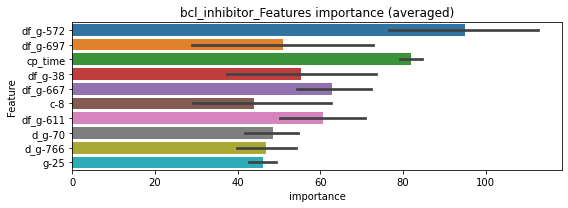

len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207474	valid_1's binary_logloss: 0.0440625
[200]	training's binary_logloss: 0.00291659	valid_1's binary_logloss: 0.0195651
[300]	training's binary_logloss: 0.000809299	valid_1's binary_logloss: 0.0150157
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000574891	valid_1's binary_logloss: 0.0144244


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200932	valid_1's binary_logloss: 0.0414419
[200]	training's binary_logloss: 0.00286761	valid_1's binary_logloss: 0.0193123
[300]	training's binary_logloss: 0.00082738	valid_1's binary_logloss: 0.0157633
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000864713	valid_1's binary_logloss: 0.0155945


bcl_inhibitor logloss: 0.015009457186123468
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965942	valid_1's binary_logloss: 0.18052
[200]	training's binary_logloss: 0.0214227	valid_1's binary_logloss: 0.0762995
[300]	training's binary_logloss: 0.00701874	valid_1's binary_logloss: 0.0451124
[400]	training's binary_logloss: 0.00355705	valid_1's binary_logloss: 0.0350043
[500]	training's binary_logloss: 0.00234096	valid_1's binary_logloss: 0.0304082
[600]	training's binary_logloss: 0.00187116	valid_1's binary_logloss: 0.0275315
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00184249	valid_1's binary_logloss: 0.0273361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988731	valid_1's binary_logloss: 0.185042
[200]	training's binary_logloss: 0.0219241	valid_1's binary_logloss: 0.0831052
[300]	training's binary_logloss: 0.00707315	valid_1's binary_logloss: 0.0492937
[400]	training's binary_logloss: 0.00357383	valid_

1 / 3 AUC score:1.000
Threshold: 0.4493463103837544
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00697
p_label_rate: 0.01331 Vs.target_rate: 0.00169, Num_p_label: 53.0, conf_0:0.00640, conf_1:0.57275
Num_p_label: 53.0, Expected: 6.7, Adj_threshold_1: 0.45
Num_p_label: 45.0, Expected: 6.7, Adj_threshold_2: 0.49
Num_p_label: 39.0, Expected: 6.7, Adj_threshold_3: 0.53
Num_p_label: 33.0, Expected: 6.7, Adj_threshold_4: 0.57
Num_p_label: 30.0, Expected: 6.7, Adj_threshold_5: 0.61
Num_p_label: 22.0, Expected: 6.7, Adj_threshold_6: 0.65
Num_p_label: 17.0, Expected: 6.7, Adj_threshold_7: 0.69
Num_p_label: 15.0, Expected: 6.7, Adj_threshold_8: 0.73
Num_p_label: 13.0, Expected: 6.7, Adj_threshold_9: 0.77
Num_p_label: 12.0, Expected: 6.7, Adj_threshold_10: 0.81
threshold:0.85, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987724	valid_1's binary_logloss: 0.183729
[200]	training's binary_logloss: 0.0213507	valid_1's binary_logloss: 0.0774671
[300]	training's binary_logloss: 0.0069628	valid_1's binary_logloss: 0.0446111
[400]	training's binary_logloss: 0.00352531	valid_1's binary_logloss: 0.0320251
[500]	training's binary_logloss: 0.00233564	valid_1's binary_logloss: 0.026516
[600]	training's binary_logloss: 0.00185078	valid_1's binary_logloss: 0.0237087
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00178311	valid_1's binary_logloss: 0.0231229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986971	valid_1's binary_logloss: 0.169398
[200]	training's binary_logloss: 0.0212972	valid_1's binary_logloss: 0.0687332
[300]	training's binary_logloss: 0.00702099	valid_1's binary_logloss: 0.039296
[400]	training's binary_logloss: 0.00353644	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.8493463103837546
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/993
30th percentile: 0.00716
p_label_rate: 0.00326 Vs.target_rate: 0.00169, Num_p_label: 13.0, conf_0:0.00716, conf_1:0.84935
threshold:0.85, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:495.0/993, y_label_rate: 0.49849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996793	valid_1's binary_logloss: 0.17821
[200]	training's binary_logloss: 0.0214779	valid_1's binary_logloss: 0.0724587
[300]	training's binary_logloss: 0.00699941	valid_1's binary_logloss: 0.0421527
[400]	training's binary_logloss: 0.00352189	valid_1's binary_logloss: 0.0317951
[500]	training's binary_logloss: 0.00233412	valid_1's binary_logloss: 0.0272609
[600]	training's binary_logloss: 0.00185765	valid_1's binary_logloss: 0.0246809
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00182161	valid_1's binary_logloss: 0.024367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976152	valid_1's binary_logloss: 0.184961
[200]	training's binary_logloss: 0.0210181	valid_1's binary_logloss: 0.0746098
[300]	training's binary_logloss: 0.00692049	valid_1's binary_logloss: 0.0421102
[400]	training's binary_logloss: 0.00353119	valid_1

3 / 3 AUC score:1.000
Threshold: 0.8493463103837546
Remove_noisy_labels: 4 → positive_corect_labels: 491.0/989
30th percentile: 0.00673
p_label_rate: 0.00326 Vs.target_rate: 0.00169, Num_p_label: 13.0, conf_0:0.00673, conf_1:0.84935
threshold:0.85, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:504.0/4971, y_label_rate: 0.10139


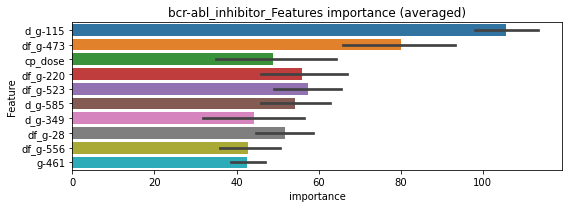

len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312834	valid_1's binary_logloss: 0.0557485
[200]	training's binary_logloss: 0.00559451	valid_1's binary_logloss: 0.0221877
[300]	training's binary_logloss: 0.00144369	valid_1's binary_logloss: 0.0140112
[400]	training's binary_logloss: 0.000666144	valid_1's binary_logloss: 0.012353
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000475214	valid_1's binary_logloss: 0.0118042


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297297	valid_1's binary_logloss: 0.0637179
[200]	training's binary_logloss: 0.00495439	valid_1's binary_logloss: 0.0311921
[300]	training's binary_logloss: 0.00131597	valid_1's binary_logloss: 0.0222283
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000699562	valid_1's binary_logloss: 0.0201584


bcr-abl_inhibitor logloss: 0.015980459071646
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123143	valid_1's binary_logloss: 0.274906
[200]	training's binary_logloss: 0.0313445	valid_1's binary_logloss: 0.172387
[300]	training's binary_logloss: 0.0107964	valid_1's binary_logloss: 0.130731
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00892539	valid_1's binary_logloss: 0.125461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125605	valid_1's binary_logloss: 0.267385
[200]	training's binary_logloss: 0.0318918	valid_1's binary_logloss: 0.160922
[300]	training's binary_logloss: 0.0108372	valid_1's binary_logloss: 0.12058
[400]	training's binary_logloss: 0.00524002	valid_1's binary_logloss: 0.105146
[500]	training's binary_logloss: 0.00330808	valid_1's binary_logloss: 0.0956092
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00301743	valid_1's binary_logloss: 0.0941416


1 / 3 AUC score:0.994
Threshold: 0.5040915248737122
Remove_noisy_labels: 34 → positive_corect_labels: 483/966
30th percentile: 0.02838
p_label_rate: 0.02411 Vs.target_rate: 0.00291, Num_p_label: 96.0, conf_0:0.02838, conf_1:0.53489
Num_p_label: 96.0, Expected: 11.6, Adj_threshold_1: 0.50
Num_p_label: 71.0, Expected: 11.6, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 11.6, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 11.6, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 11.6, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 11.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:483.0/966, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115438	valid_1's binary_logloss: 0.284803
[200]	training's binary_logloss: 0.0276384	valid_1's binary_logloss: 0.189818
[300]	training's binary_logloss: 0.00948562	valid_1's binary_logloss: 0.161787
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00640079	valid_1's binary_logloss: 0.15213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122663	valid_1's binary_logloss: 0.230863
[200]	training's binary_logloss: 0.031979	valid_1's binary_logloss: 0.125331
[300]	training's binary_logloss: 0.010937	valid_1's binary_logloss: 0.0897803
[400]	training's binary_logloss: 0.00528074	valid_1's binary_logloss: 0.0721467
[500]	training's binary_logloss: 0.00333141	valid_1's binary_logloss: 0.0660818
[600]	training's binary_logloss: 0.00246051	valid_1's binary_logloss: 0.0618982
[700]	training's binary_logloss: 0.00209825	valid_1's binar

2 / 3 AUC score:0.992
Threshold: 0.7040915248737124
Remove_noisy_labels: 29 → positive_corect_labels: 455.0/937
30th percentile: 0.01958
p_label_rate: 0.00703 Vs.target_rate: 0.00291, Num_p_label: 28.0, conf_0:0.01958, conf_1:0.70409
threshold:0.70, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:455.0/937, y_label_rate: 0.48559
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112389	valid_1's binary_logloss: 0.238075
[200]	training's binary_logloss: 0.026925	valid_1's binary_logloss: 0.125333
[300]	training's binary_logloss: 0.0092209	valid_1's binary_logloss: 0.087677
[400]	training's binary_logloss: 0.00460675	valid_1's binary_logloss: 0.0715663
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00344087	valid_1's binary_logloss: 0.0666408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113044	valid_1's binary_logloss: 0.232211
[200]	training's binary_logloss: 0.0271398	valid_1's binary_logloss: 0.13272
[300]	training's binary_logloss: 0.00939299	valid_1's binary_logloss: 0.0989674
[400]	training's binary_logloss: 0.0046493	valid_1's binary_logloss: 0.0871019
[500]	training's binary_logloss: 0.00300271	valid_1's binary_logloss: 0.0821785
Early stopping, best iteration is:
[575]	training's binary

3 / 3 AUC score:0.997
Threshold: 0.7040915248737124
Remove_noisy_labels: 15 → positive_corect_labels: 442.0/922
30th percentile: 0.01632
p_label_rate: 0.00779 Vs.target_rate: 0.00291, Num_p_label: 31.0, conf_0:0.01510, conf_1:0.70409
threshold:0.70, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:473.0/4904, y_label_rate: 0.09645


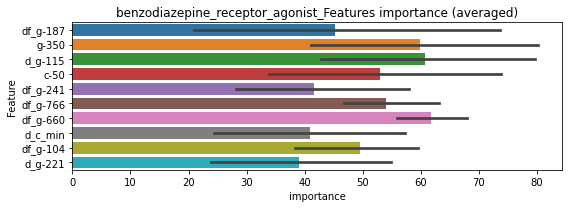

len(train_index) : 2452
len(valid_index) : 2452
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361965	valid_1's binary_logloss: 0.0812728
[200]	training's binary_logloss: 0.00734576	valid_1's binary_logloss: 0.0463625
[300]	training's binary_logloss: 0.00210255	valid_1's binary_logloss: 0.0376596
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00164057	valid_1's binary_logloss: 0.0364177


len(train_index) : 2452
len(valid_index) : 2452
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352919	valid_1's binary_logloss: 0.0797366
[200]	training's binary_logloss: 0.00683472	valid_1's binary_logloss: 0.0501436
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00237895	valid_1's binary_logloss: 0.0453491


benzodiazepine_receptor_agonist logloss: 0.04088335197141001
beta_amyloid_inhibitor , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754877	valid_1's binary_logloss: 0.116574
[200]	training's binary_logloss: 0.0140384	valid_1's binary_logloss: 0.0405261
[300]	training's binary_logloss: 0.00457155	valid_1's binary_logloss: 0.0217089
[400]	training's binary_logloss: 0.00248988	valid_1's binary_logloss: 0.0159947
[500]	training's binary_logloss: 0.00176935	valid_1's binary_logloss: 0.0135281
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00156708	valid_1's binary_logloss: 0.0127693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721316	valid_1's binary_logloss: 0.152154
[200]	training's binary_logloss: 0.0133006	valid_1's binary_logloss: 0.0714391
[300]	training's binary_logloss: 0.00425498	valid_1's binary_logloss: 0.0480374
[400]	training's binary_logloss: 0.00228978	valid_1's binary_logloss: 0.040095


1 / 3 AUC score:1.000
Threshold: 0.3626221947440889


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.0017701	valid_1's binary_logloss: 0.0382554


Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00309
p_label_rate: 0.00176 Vs.target_rate: 0.00108, Num_p_label: 7.0, conf_0:0.00309, conf_1:0.36262
threshold:0.36, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752128	valid_1's binary_logloss: 0.127358
[200]	training's binary_logloss: 0.0136614	valid_1's binary_logloss: 0.046709
[300]	training's binary_logloss: 0.00442312	valid_1's binary_logloss: 0.025513
[400]	training's binary_logloss: 0.0023639	valid_1's binary_logloss: 0.0182469
[500]	training's binary_logloss: 0.00170988	valid_1's binary_logloss: 0.0156626
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00167364	valid_1's binary_logloss: 0.0155014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718862	valid_1's binary_logloss: 0.124477
[200]	training's binary_logloss: 0.0135829	valid_1's binary_logloss: 0.0446542
[300]	training's binary_logloss: 0.00436817	valid_1's binary_logloss: 0.024638
[400]	training's binary_logloss: 0.00233084	valid_1's binary_logloss: 0.0183685
[500]	training's binary_logloss: 0.00165607	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.3626221947440889
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentile: 0.00267
p_label_rate: 0.00151 Vs.target_rate: 0.00108, Num_p_label: 6.0, conf_0:0.00267, conf_1:0.36262
threshold:0.36, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752128	valid_1's binary_logloss: 0.127358
[200]	training's binary_logloss: 0.0136614	valid_1's binary_logloss: 0.046709
[300]	training's binary_logloss: 0.00442312	valid_1's binary_logloss: 0.025513
[400]	training's binary_logloss: 0.0023639	valid_1's binary_logloss: 0.0182469
[500]	training's binary_logloss: 0.00170988	valid_1's binary_logloss: 0.0156626
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00167364	valid_1's binary_logloss: 0.0155014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718862	valid_1's binary_logloss: 0.124477
[200]	training's binary_logloss: 0.0135829	valid_1's binary_logloss: 0.0446542
[300]	training's binary_logloss: 0.00436817	valid_1's binary_logloss: 0.024638
[400]	training's binary_logloss: 0.00233084	valid_1's binary_logloss: 0.0183685
[500]	training's binary_logloss: 0.00165607	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.3626221947440889
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentile: 0.00267
p_label_rate: 0.00151 Vs.target_rate: 0.00108, Num_p_label: 6.0, conf_0:0.00267, conf_1:0.36262
threshold:0.36, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:503.0/4976, y_label_rate: 0.10109


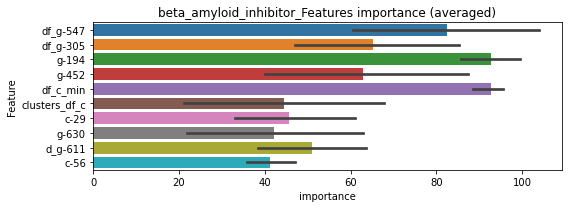

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192571	valid_1's binary_logloss: 0.0303914
[200]	training's binary_logloss: 0.00255249	valid_1's binary_logloss: 0.0112279
[300]	training's binary_logloss: 0.000734371	valid_1's binary_logloss: 0.00907368
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000563906	valid_1's binary_logloss: 0.00874008


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202094	valid_1's binary_logloss: 0.0362738
[200]	training's binary_logloss: 0.0025701	valid_1's binary_logloss: 0.0151653
[300]	training's binary_logloss: 0.000734948	valid_1's binary_logloss: 0.0119157
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000600352	valid_1's binary_logloss: 0.0115906


beta_amyloid_inhibitor logloss: 0.010165321704773862
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1291	valid_1's binary_logloss: 0.302712
[200]	training's binary_logloss: 0.0336752	valid_1's binary_logloss: 0.203041
[300]	training's binary_logloss: 0.0120218	valid_1's binary_logloss: 0.16342
[400]	training's binary_logloss: 0.00586518	valid_1's binary_logloss: 0.144606
[500]	training's binary_logloss: 0.00371008	valid_1's binary_logloss: 0.135141
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00307471	valid_1's binary_logloss: 0.131177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121421	valid_1's binary_logloss: 0.268991
[200]	training's binary_logloss: 0.0317979	valid_1's binary_logloss: 0.170166
[300]	training's binary_logloss: 0.0112861	valid_1's binary_logloss: 0.132011
[400]	training's binary_logloss: 0.00562365	valid_1's binary_logloss: 0.111757
[500]	training's binary_logloss: 0.00355498	valid_1's binary_log

1 / 3 AUC score:0.989
Threshold: 0.3155665643617035
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentile: 0.02607
p_label_rate: 0.03014 Vs.target_rate: 0.00295, Num_p_label: 120.0, conf_0:0.02607, conf_1:0.45376
Num_p_label: 120.0, Expected: 11.7, Adj_threshold_1: 0.32
Num_p_label: 82.0, Expected: 11.7, Adj_threshold_2: 0.36
Num_p_label: 58.0, Expected: 11.7, Adj_threshold_3: 0.40
Num_p_label: 42.0, Expected: 11.7, Adj_threshold_4: 0.44
Num_p_label: 29.0, Expected: 11.7, Adj_threshold_5: 0.48
Num_p_label: 17.0, Expected: 11.7, Adj_threshold_6: 0.52
threshold:0.52, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121823	valid_1's binary_logloss: 0.258124
[200]	training's binary_logloss: 0.0312761	valid_1's binary_logloss: 0.144145
[300]	training's binary_logloss: 0.0111154	valid_1's binary_logloss: 0.102147
[400]	training's binary_logloss: 0.00550609	valid_1's binary_logloss: 0.0835739
[500]	training's binary_logloss: 0.00350229	valid_1's binary_logloss: 0.0753335
[600]	training's binary_logloss: 0.00261653	valid_1's binary_logloss: 0.0696437
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00258674	valid_1's binary_logloss: 0.0692297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122732	valid_1's binary_logloss: 0.265778
[200]	training's binary_logloss: 0.0313454	valid_1's binary_logloss: 0.171792
[300]	training's binary_logloss: 0.0109366	valid_1's binary_logloss: 0.140809


2 / 3 AUC score:0.991
Threshold: 0.5155665643617034
Remove_noisy_labels: 16 → positive_corect_labels: 463.0/942
30th percentile: 0.02799
p_label_rate: 0.01005 Vs.target_rate: 0.00295, Num_p_label: 40.0, conf_0:0.02799, conf_1:0.51557


[400]	training's binary_logloss: 0.00536771	valid_1's binary_logloss: 0.128819
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00564869	valid_1's binary_logloss: 0.128605


Num_p_label: 40.0, Expected: 11.7, Adj_threshold_1: 0.52
Num_p_label: 27.0, Expected: 11.7, Adj_threshold_2: 0.56
Num_p_label: 16.0, Expected: 11.7, Adj_threshold_3: 0.60
threshold:0.60, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:463.0/942, y_label_rate: 0.49151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11889	valid_1's binary_logloss: 0.250467
[200]	training's binary_logloss: 0.0292698	valid_1's binary_logloss: 0.132448
[300]	training's binary_logloss: 0.0100427	valid_1's binary_logloss: 0.0919542
[400]	training's binary_logloss: 0.00503868	valid_1's binary_logloss: 0.0722688
[500]	training's binary_logloss: 0.00325184	valid_1's binary_logloss: 0.0653679
[600]	training's binary_logloss: 0.00250547	valid_1's binary_logloss: 0.0601114
[700]	training's binary_logloss: 0.00217248	valid_1's binary_logloss: 0.0574812
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.00211095	valid_1's binary_logloss: 0.0569791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116736	valid_1's binary_logloss: 0.230246
[200]	training's binary_logloss: 0.0292151	valid_1's binary_logloss: 0.125998
[300]	training's binary_logloss: 0.01016	valid_1's bina

3 / 3 AUC score:0.999
Threshold: 0.5955665643617035
Remove_noisy_labels: 11 → positive_corect_labels: 452.0/931
30th percentile: 0.01681
p_label_rate: 0.00402 Vs.target_rate: 0.00295, Num_p_label: 16.0, conf_0:0.01034, conf_1:0.59557
threshold:0.60, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:468.0/4913, y_label_rate: 0.09526


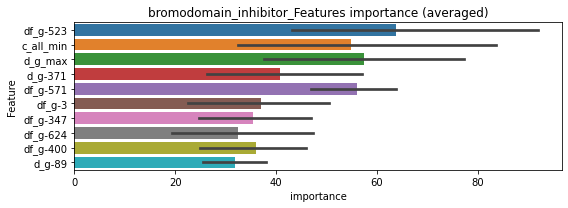

len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027789	valid_1's binary_logloss: 0.0803565
[200]	training's binary_logloss: 0.00482125	valid_1's binary_logloss: 0.0569953


len(train_index) : 2457
len(valid_index) : 2456


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00163903	valid_1's binary_logloss: 0.0534762


================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307327	valid_1's binary_logloss: 0.0716414
[200]	training's binary_logloss: 0.00566607	valid_1's binary_logloss: 0.043522
[300]	training's binary_logloss: 0.00167097	valid_1's binary_logloss: 0.0376214
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00168984	valid_1's binary_logloss: 0.0375804


bromodomain_inhibitor logloss: 0.04552991449336649
btk_inhibitor , len(trt) : 29


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839694	valid_1's binary_logloss: 0.147748
[200]	training's binary_logloss: 0.0164398	valid_1's binary_logloss: 0.0556566
[300]	training's binary_logloss: 0.00518618	valid_1's binary_logloss: 0.0287888
[400]	training's binary_logloss: 0.0027009	valid_1's binary_logloss: 0.0206438
[500]	training's binary_logloss: 0.00187524	valid_1's binary_logloss: 0.0173902
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00180229	valid_1's binary_logloss: 0.0170539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791871	valid_1's binary_logloss: 0.171146
[200]	training's binary_logloss: 0.0157758	valid_1's binary_logloss: 0.0855377
[300]	training's binary_logloss: 0.0049609	valid_1's binary_logloss: 0.0588704


1 / 3 AUC score:0.999
Threshold: 0.36827262334772815
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00670
p_label_rate: 0.00477 Vs.target_rate: 0.00130, Num_p_label: 19.0, conf_0:0.00670, conf_1:0.39017
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_1: 0.37
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_2: 0.41
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_3: 0.45


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00289304	valid_1's binary_logloss: 0.0520802


Num_p_label: 2.0, Expected: 5.2, Adj_threshold_4: 0.49
threshold:0.49, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783468	valid_1's binary_logloss: 0.152923
[200]	training's binary_logloss: 0.0153619	valid_1's binary_logloss: 0.0615434
[300]	training's binary_logloss: 0.00490643	valid_1's binary_logloss: 0.0372086
[400]	training's binary_logloss: 0.00259669	valid_1's binary_logloss: 0.0278885
[500]	training's binary_logloss: 0.00180516	valid_1's binary_logloss: 0.0242989
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00159081	valid_1's binary_logloss: 0.0230059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817321	valid_1's binary_logloss: 0.14848
[200]	training's binary_logloss: 0.0158448	valid_1's binary_logloss: 0.0676467
[300]	training's binary_logloss: 0.0051562	valid_1's binary_logloss: 0.0478417


2 / 3 AUC score:1.000
Threshold: 0.4882726233477281
Remove_noisy_labels: 9 → positive_corect_labels: 488.0/981
30th percentile: 0.00668
p_label_rate: 0.00151 Vs.target_rate: 0.00130, Num_p_label: 6.0, conf_0:0.00668, conf_1:0.48827
threshold:0.49, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00330303	valid_1's binary_logloss: 0.0424473


positive y_label:488.0/981, y_label_rate: 0.49745
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787358	valid_1's binary_logloss: 0.147882
[200]	training's binary_logloss: 0.0155608	valid_1's binary_logloss: 0.0558122
[300]	training's binary_logloss: 0.00503577	valid_1's binary_logloss: 0.0311475
[400]	training's binary_logloss: 0.00265776	valid_1's binary_logloss: 0.0226605
[500]	training's binary_logloss: 0.00184239	valid_1's binary_logloss: 0.0194246
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00162813	valid_1's binary_logloss: 0.0181319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822124	valid_1's binary_logloss: 0.137605
[200]	training's binary_logloss: 0.0162071	valid_1's binary_logloss: 0.0508686
[300]	training's binary_logloss: 0.00514641	valid_1's binary_logloss: 0.0282405
[400]	training's binary_logloss: 0.00268475	valid_1's binary_logloss: 0.0203052
[500]	training's binary_logloss: 0.00183752	valid

3 / 3 AUC score:1.000
Threshold: 0.4882726233477281
Remove_noisy_labels: 1 → positive_corect_labels: 488.0/980
30th percentile: 0.00419
p_label_rate: 0.00226 Vs.target_rate: 0.00130, Num_p_label: 9.0, conf_0:0.00419, conf_1:0.48827
threshold:0.49, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:497.0/4962, y_label_rate: 0.10016


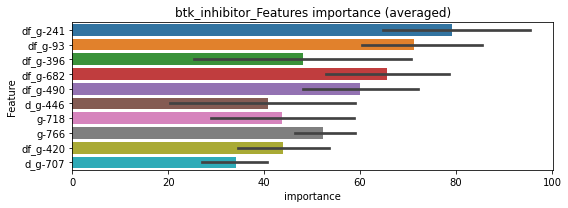

len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222565	valid_1's binary_logloss: 0.0484961
[200]	training's binary_logloss: 0.00314819	valid_1's binary_logloss: 0.025057
[300]	training's binary_logloss: 0.000876685	valid_1's binary_logloss: 0.0207836


len(train_index) : 2481
len(valid_index) : 2481


Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000831234	valid_1's binary_logloss: 0.0206565


================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023095	valid_1's binary_logloss: 0.0430703
[200]	training's binary_logloss: 0.00338848	valid_1's binary_logloss: 0.0175787
[300]	training's binary_logloss: 0.000933442	valid_1's binary_logloss: 0.0137609
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000497925	valid_1's binary_logloss: 0.0127663


btk_inhibitor logloss: 0.016711385513726928
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550087	valid_1's binary_logloss: 0.0771177
[200]	training's binary_logloss: 0.00793172	valid_1's binary_logloss: 0.0196129
[300]	training's binary_logloss: 0.00249359	valid_1's binary_logloss: 0.0106668
[400]	training's binary_logloss: 0.00142284	valid_1's binary_logloss: 0.00842026
[500]	training's binary_logloss: 0.00115572	valid_1's binary_logloss: 0.00756325
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00115888	valid_1's binary_logloss: 0.00754601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541801	valid_1's binary_logloss: 0.0802306
[200]	training's binary_logloss: 0.00777145	valid_1's binary_logloss: 0.022453
[300]	training's binary_logloss: 0.00240392	valid_1's binary_logloss: 0.011445
[400]	training's binary_logloss: 0.00138036	valid_1's binary_logloss: 0.00865826
[500]	training's binary_logloss: 0.00116482

1 / 3 AUC score:1.000
Threshold: 0.7546338156812215
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00100
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00100, conf_1:0.75463
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.75
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.71
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.67
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_4: 0.63
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_5: 0.59
threshold:0.59, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550087	valid_1's binary_logloss: 0.0771177
[200]	training's binary_logloss: 0.00793172	valid_1's binary_logloss: 0.0196129
[300]	training's binary_logloss: 0.00249359	valid_1's binary_logloss: 0.0106668
[400]	training's binary_logloss: 0.00142284	valid_1's binary_logloss: 0.00842026
[500]	training's binary_logloss: 0.00115572	valid_1's binary_logloss: 0.00756325
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00115888	valid_1's binary_logloss: 0.00754601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541801	valid_1's binary_logloss: 0.0802306
[200]	training's binary_logloss: 0.00777145	valid_1's binary_logloss: 0.022453
[300]	training's binary_logloss: 0.00240392	valid_1's binary_logloss: 0.011445
[400]	training's binary_logloss: 0.00138036	valid_1's binary_logloss: 0.00865826
[500]	training's binary_logloss: 0.00116482

2 / 3 AUC score:1.000
Threshold: 0.5946338156812213
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00100


Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00116707	valid_1's binary_logloss: 0.00760802


p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00100, conf_1:0.59463
threshold:0.59, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550087	valid_1's binary_logloss: 0.0771177
[200]	training's binary_logloss: 0.00793172	valid_1's binary_logloss: 0.0196129
[300]	training's binary_logloss: 0.00249359	valid_1's binary_logloss: 0.0106668
[400]	training's binary_logloss: 0.00142284	valid_1's binary_logloss: 0.00842026
[500]	training's binary_logloss: 0.00115572	valid_1's binary_logloss: 0.00756325
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00115888	valid_1's binary_logloss: 0.00754601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541801	valid_1's binary_logloss: 0.0802306
[200]	training's binary_logloss: 0.00777145	valid_1's binary_logloss: 0.022453
[300]	training's binary_logloss: 0.00240392	valid_1's binary_logloss: 0.011445
[400]	training's binary_logloss: 0.00138036	valid_1's binary_logloss: 0.00865826
[500]	training's binary_logloss: 0.00116482

3 / 3 AUC score:1.000
Threshold: 0.5946338156812213
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00100
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00100, conf_1:0.59463
threshold:0.59, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4982, y_label_rate: 0.10116


Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00116707	valid_1's binary_logloss: 0.00760802


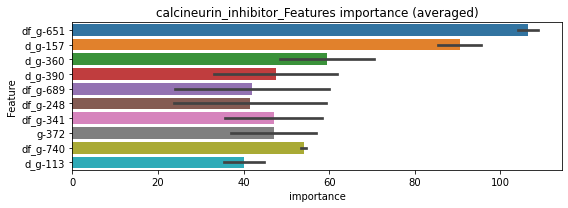

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128691	valid_1's binary_logloss: 0.0226932
[200]	training's binary_logloss: 0.0014369	valid_1's binary_logloss: 0.00910655
[300]	training's binary_logloss: 0.00042604	valid_1's binary_logloss: 0.00652308
[400]	training's binary_logloss: 0.000245239	valid_1's binary_logloss: 0.00588984
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00024868	valid_1's binary_logloss: 0.00584561


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127035	valid_1's binary_logloss: 0.0190625
[200]	training's binary_logloss: 0.0013801	valid_1's binary_logloss: 0.00742162


calcineurin_inhibitor logloss: 0.006466839815799539
calcium_channel_blocker , len(trt) : 281


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00100689	valid_1's binary_logloss: 0.00708807


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216267	valid_1's binary_logloss: 0.585243
[200]	training's binary_logloss: 0.080885	valid_1's binary_logloss: 0.564338
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0643807	valid_1's binary_logloss: 0.562105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222013	valid_1's binary_logloss: 0.570188
[200]	training's binary_logloss: 0.0851127	valid_1's binary_logloss: 0.536405


1 / 3 AUC score:0.782
Threshold: 0.5044858045155987
Remove_noisy_labels: 308 → positive_corect_labels: 346/692
30th percentile: 0.32751
p_label_rate: 0.23355 Vs.target_rate: 0.00966, Num_p_label: 930.0, conf_0:0.32751, conf_1:0.50449
Num_p_label: 930.0, Expected: 38.5, Adj_threshold_1: 0.50
Num_p_label: 618.0, Expected: 38.5, Adj_threshold_2: 0.54
Num_p_label: 416.0, Expected: 38.5, Adj_threshold_3: 0.58
Num_p_label: 237.0, Expected: 38.5, Adj_threshold_4: 0.62
Num_p_label: 133.0, Expected: 38.5, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.060232	valid_1's binary_logloss: 0.525823


Num_p_label: 59.0, Expected: 38.5, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 38.5, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:346.0/692, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185129	valid_1's binary_logloss: 0.455811
[200]	training's binary_logloss: 0.0652158	valid_1's binary_logloss: 0.376469
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0295069	valid_1's binary_logloss: 0.34796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192347	valid_1's binary_logloss: 0.461285
[200]	training's binary_logloss: 0.0670998	valid_1's binary_logloss: 0.382142
[300]	training's binary_logloss: 0.0280456	valid_1's binary_logloss: 0.354379
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0249322	valid_1's binary_logloss: 0.352736


2 / 3 AUC score:0.933
Threshold: 0.7444858045155989
Remove_noisy_labels: 107 → positive_corect_labels: 252.0/585
30th percentile: 0.22805
p_label_rate: 0.09342 Vs.target_rate: 0.00966, Num_p_label: 372.0, conf_0:0.22805, conf_1:0.74449
Num_p_label: 372.0, Expected: 38.5, Adj_threshold_1: 0.74
Num_p_label: 270.0, Expected: 38.5, Adj_threshold_2: 0.78
Num_p_label: 175.0, Expected: 38.5, Adj_threshold_3: 0.82
Num_p_label: 101.0, Expected: 38.5, Adj_threshold_4: 0.86
Num_p_label: 42.0, Expected: 38.5, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:252.0/585, y_label_rate: 0.43077
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168499	valid_1's binary_logloss: 0.400979
[200]	training's binary_logloss: 0.0549749	valid_1's binary_logloss: 0.321483
[300]	training's binary_logloss: 0.0221798	valid_1's binary_logloss: 0.290915
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0188125	valid_1's binary_logloss: 0.286141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171094	valid_1's binary_logloss: 0.425931
[200]	training's binary_logloss: 0.0555405	valid_1's binary_logloss: 0.34546
[300]	training's binary_logloss: 0.022003	valid_1's binary_logloss: 0.316546
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.022003	valid_1's binary_logloss: 0.316546


3 / 3 AUC score:0.945
Threshold: 0.904485804515599
Remove_noisy_labels: 138 → positive_corect_labels: 114.0/447
30th percentile: 0.11528
p_label_rate: 0.00979 Vs.target_rate: 0.00966, Num_p_label: 39.0, conf_0:0.11528, conf_1:0.90449
threshold:0.90, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:153.0/4429, y_label_rate: 0.03455


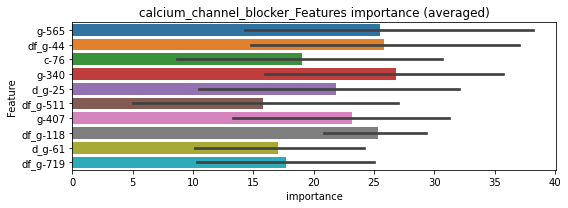

len(train_index) : 2214
len(valid_index) : 2215
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2215
len(valid_index) : 2214
================================= fold 2/2 calcium_channel_blocker=================================


[100]	training's binary_logloss: 0.0136321	valid_1's binary_logloss: 0.108546
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0165313	valid_1's binary_logloss: 0.107865
Training until validation scores don't improve for 10 rounds


calcium_channel_blocker logloss: 0.11133421363860108
cannabinoid_receptor_agonist , len(trt) : 42


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.0219024	valid_1's binary_logloss: 0.114805
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10345	valid_1's binary_logloss: 0.211778
[200]	training's binary_logloss: 0.0238297	valid_1's binary_logloss: 0.105163
[300]	training's binary_logloss: 0.00793587	valid_1's binary_logloss: 0.0712087
[400]	training's binary_logloss: 0.00396363	valid_1's binary_logloss: 0.0578386
[500]	training's binary_logloss: 0.00259721	valid_1's binary_logloss: 0.0530472
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00209814	valid_1's binary_logloss: 0.0490091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104294	valid_1's binary_logloss: 0.211434
[200]	training's binary_logloss: 0.0239485	valid_1's binary_logloss: 0.108161
[300]	training's binary_logloss: 0.0078573	valid_1's binary_logloss: 0.0703629
[400]	training's binary_logloss: 0.0039351	valid_1's binary_logloss: 0.054871
[500]	training's binary_logloss: 0.00259106	valid_1's bin

1 / 3 AUC score:0.999
Threshold: 0.4745939684278495
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.00917
p_label_rate: 0.00829 Vs.target_rate: 0.00187, Num_p_label: 33.0, conf_0:0.00917, conf_1:0.54439
Num_p_label: 33.0, Expected: 7.4, Adj_threshold_1: 0.47
Num_p_label: 28.0, Expected: 7.4, Adj_threshold_2: 0.51
Num_p_label: 21.0, Expected: 7.4, Adj_threshold_3: 0.55
Num_p_label: 15.0, Expected: 7.4, Adj_threshold_4: 0.59
Num_p_label: 9.0, Expected: 7.4, Adj_threshold_5: 0.63
threshold:0.63, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103033	valid_1's binary_logloss: 0.194403
[200]	training's binary_logloss: 0.0237915	valid_1's binary_logloss: 0.0862636
[300]	training's binary_logloss: 0.00792942	valid_1's binary_logloss: 0.0526784
[400]	training's binary_logloss: 0.00396742	valid_1's binary_logloss: 0.0391898
[500]	training's binary_logloss: 0.0026002	valid_1's binary_logloss: 0.0326338
[600]	training's binary_logloss: 0.00204551	valid_1's binary_logloss: 0.0291733
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00196297	valid_1's binary_logloss: 0.0286058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10332	valid_1's binary_logloss: 0.22032
[200]	training's binary_logloss: 0.0234359	valid_1's binary_logloss: 0.107546
[300]	training's binary_logloss: 0.00775084	valid_1's binary_logloss: 0.0716429
[400]	training's binary_logloss: 0.00391711	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.6345939684278497
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/984
30th percentile: 0.00826
p_label_rate: 0.00377 Vs.target_rate: 0.00187, Num_p_label: 15.0, conf_0:0.00826, conf_1:0.63459
threshold:0.63, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103887	valid_1's binary_logloss: 0.189136
[200]	training's binary_logloss: 0.023582	valid_1's binary_logloss: 0.0839483
[300]	training's binary_logloss: 0.00778153	valid_1's binary_logloss: 0.0503168
[400]	training's binary_logloss: 0.00390112	valid_1's binary_logloss: 0.0381748
[500]	training's binary_logloss: 0.00256731	valid_1's binary_logloss: 0.0319471
[600]	training's binary_logloss: 0.0020257	valid_1's binary_logloss: 0.0292747
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00188691	valid_1's binary_logloss: 0.0285719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104586	valid_1's binary_logloss: 0.197056
[200]	training's binary_logloss: 0.0234939	valid_1's binary_logloss: 0.0874309
[300]	training's binary_logloss: 0.00783303	valid_1's binary_logloss: 0.0539384
[400]	training's binary_logloss: 0.00392903	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.6345939684278497
Remove_noisy_labels: 4 → positive_corect_labels: 489.0/980
30th percentile: 0.00703
p_label_rate: 0.00427 Vs.target_rate: 0.00187, Num_p_label: 17.0, conf_0:0.00703, conf_1:0.63459
threshold:0.63, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:506.0/4962, y_label_rate: 0.10198


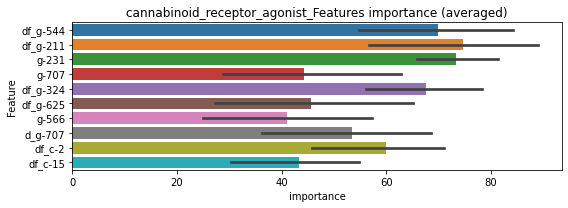

len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289083	valid_1's binary_logloss: 0.0633155
[200]	training's binary_logloss: 0.00494955	valid_1's binary_logloss: 0.0320075
[300]	training's binary_logloss: 0.00142473	valid_1's binary_logloss: 0.025042
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000935556	valid_1's binary_logloss: 0.0241286


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299674	valid_1's binary_logloss: 0.060277
[200]	training's binary_logloss: 0.00487277	valid_1's binary_logloss: 0.0312454
[300]	training's binary_logloss: 0.00139385	valid_1's binary_logloss: 0.0255132
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000962438	valid_1's binary_logloss: 0.0244254


cannabinoid_receptor_agonist logloss: 0.024276997806159006
cannabinoid_receptor_antagonist , len(trt) : 55


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118646	valid_1's binary_logloss: 0.241053
[200]	training's binary_logloss: 0.0298538	valid_1's binary_logloss: 0.126961
[300]	training's binary_logloss: 0.0103786	valid_1's binary_logloss: 0.0858283
[400]	training's binary_logloss: 0.00508665	valid_1's binary_logloss: 0.0668463
[500]	training's binary_logloss: 0.00324327	valid_1's binary_logloss: 0.0583328
[600]	training's binary_logloss: 0.00244623	valid_1's binary_logloss: 0.0526671
[700]	training's binary_logloss: 0.00212625	valid_1's binary_logloss: 0.0503354
Early stopping, best iteration is:
[753]	training's binary_logloss: 0.00204335	valid_1's binary_logloss: 0.0498413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121377	valid_1's binary_logloss: 0.243812
[200]	training's binary_logloss: 0.0302212	valid_1's binary_logloss: 0.123056
[300]	training's binary_logloss: 0.0103727	valid_1's b

1 / 3 AUC score:0.999
Threshold: 0.43114329110006244
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.01542
p_label_rate: 0.00603 Vs.target_rate: 0.00241, Num_p_label: 24.0, conf_0:0.01542, conf_1:0.48592
threshold:0.43, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12025	valid_1's binary_logloss: 0.232642
[200]	training's binary_logloss: 0.0307088	valid_1's binary_logloss: 0.114335
[300]	training's binary_logloss: 0.0105533	valid_1's binary_logloss: 0.0712284
[400]	training's binary_logloss: 0.00519937	valid_1's binary_logloss: 0.0550315
[500]	training's binary_logloss: 0.00334329	valid_1's binary_logloss: 0.0471615
[600]	training's binary_logloss: 0.0025109	valid_1's binary_logloss: 0.0425658
[700]	training's binary_logloss: 0.00214136	valid_1's binary_logloss: 0.0405106
Early stopping, best iteration is:
[751]	training's binary_logloss: 0.00206853	valid_1's binary_logloss: 0.039707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119305	valid_1's binary_logloss: 0.244879
[200]	training's binary_logloss: 0.0296808	valid_1's binary_logloss: 0.128818
[300]	training's binary_logloss: 0.0103358	valid_1's bina

2 / 3 AUC score:0.998
Threshold: 0.43114329110006244
Remove_noisy_labels: 12 → positive_corect_labels: 488.0/980
30th percentile: 0.01942
p_label_rate: 0.00728 Vs.target_rate: 0.00241, Num_p_label: 29.0, conf_0:0.01942, conf_1:0.44950
Num_p_label: 29.0, Expected: 9.6, Adj_threshold_1: 0.43
Num_p_label: 22.0, Expected: 9.6, Adj_threshold_2: 0.47
Num_p_label: 13.0, Expected: 9.6, Adj_threshold_3: 0.51
threshold:0.51, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:488.0/980, y_label_rate: 0.49796
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114228	valid_1's binary_logloss: 0.260246
[200]	training's binary_logloss: 0.0286743	valid_1's binary_logloss: 0.161606
[300]	training's binary_logloss: 0.0099126	valid_1's binary_logloss: 0.128369
[400]	training's binary_logloss: 0.00480092	valid_1's binary_logloss: 0.114523
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00435374	valid_1's binary_logloss: 0.113793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118169	valid_1's binary_logloss: 0.248419
[200]	training's binary_logloss: 0.0298952	valid_1's binary_logloss: 0.128021
[300]	training's binary_logloss: 0.0105241	valid_1's binary_logloss: 0.0849755
[400]	training's binary_logloss: 0.00513566	valid_1's binary_logloss: 0.066006
[500]	training's binary_logloss: 0.0032905	valid_1's binary_logloss: 0.056171
[600]	training's binary_logloss: 0.00247467	valid_1's binary_

3 / 3 AUC score:0.994
Threshold: 0.5111432911000624
Remove_noisy_labels: 20 → positive_corect_labels: 474.0/960
30th percentile: 0.02284
p_label_rate: 0.00427 Vs.target_rate: 0.00241, Num_p_label: 17.0, conf_0:0.02284, conf_1:0.51114
threshold:0.51, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:491.0/4942, y_label_rate: 0.09935


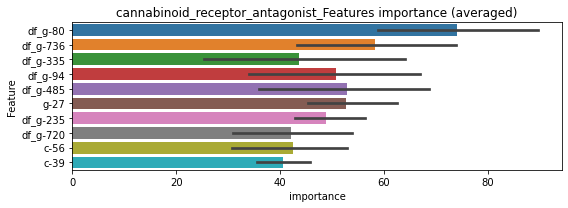

len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303826	valid_1's binary_logloss: 0.075814
[200]	training's binary_logloss: 0.00540839	valid_1's binary_logloss: 0.0452518
[300]	training's binary_logloss: 0.0015754	valid_1's binary_logloss: 0.0393318
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000958626	valid_1's binary_logloss: 0.0383404


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033872	valid_1's binary_logloss: 0.0736484
[200]	training's binary_logloss: 0.00629921	valid_1's binary_logloss: 0.0432716
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00222824	valid_1's binary_logloss: 0.0382461


cannabinoid_receptor_antagonist logloss: 0.03829323365943934
carbonic_anhydrase_inhibitor , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104474	valid_1's binary_logloss: 0.187659
[200]	training's binary_logloss: 0.0233213	valid_1's binary_logloss: 0.0819502
[300]	training's binary_logloss: 0.0076894	valid_1's binary_logloss: 0.0494106
[400]	training's binary_logloss: 0.00380611	valid_1's binary_logloss: 0.0358089
[500]	training's binary_logloss: 0.00249285	valid_1's binary_logloss: 0.0295773
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00205086	valid_1's binary_logloss: 0.0259916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983354	valid_1's binary_logloss: 0.187246
[200]	training's binary_logloss: 0.0215643	valid_1's binary_logloss: 0.0813252
[300]	training's binary_logloss: 0.00713688	valid_1's binary_logloss: 0.0506209
[400]	training's binary_logloss: 0.00355463	valid_1's binary_logloss: 0.0392595
[500]	training's binary_logloss: 0.00238147	valid_1

1 / 3 AUC score:1.000
Threshold: 0.48560701451795585
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00807
p_label_rate: 0.00100 Vs.target_rate: 0.00161, Num_p_label: 4.0, conf_0:0.00807, conf_1:0.48561
threshold:0.49, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100044	valid_1's binary_logloss: 0.217827
[200]	training's binary_logloss: 0.0219295	valid_1's binary_logloss: 0.121679
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00829569	valid_1's binary_logloss: 0.0981234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100731	valid_1's binary_logloss: 0.193578
[200]	training's binary_logloss: 0.0223158	valid_1's binary_logloss: 0.0868743
[300]	training's binary_logloss: 0.00733091	valid_1's binary_logloss: 0.0535297
[400]	training's binary_logloss: 0.00369664	valid_1's binary_logloss: 0.040836
[500]	training's binary_logloss: 0.00244826	valid_1's binary_logloss: 0.0350328
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00201776	valid_1's binary_logloss: 0.032046


2 / 3 AUC score:0.996
Threshold: 0.48560701451795585
Remove_noisy_labels: 16 → positive_corect_labels: 487.0/982
30th percentile: 0.01536
p_label_rate: 0.00201 Vs.target_rate: 0.00161, Num_p_label: 8.0, conf_0:0.01536, conf_1:0.48561
threshold:0.49, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:487.0/982, y_label_rate: 0.49593
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100227	valid_1's binary_logloss: 0.18218
[200]	training's binary_logloss: 0.0219051	valid_1's binary_logloss: 0.0784885
[300]	training's binary_logloss: 0.00716234	valid_1's binary_logloss: 0.0479794
[400]	training's binary_logloss: 0.00362313	valid_1's binary_logloss: 0.0368551
[500]	training's binary_logloss: 0.00240028	valid_1's binary_logloss: 0.0315963
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00198335	valid_1's binary_logloss: 0.0294009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980966	valid_1's binary_logloss: 0.197609
[200]	training's binary_logloss: 0.021537	valid_1's binary_logloss: 0.0950759
[300]	training's binary_logloss: 0.0070094	valid_1's binary_logloss: 0.0594199
[400]	training's binary_logloss: 0.00358113	valid_1's binary_logloss: 0.0478223
[500]	training's binary_logloss: 0.00236784	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.48560701451795585
Remove_noisy_labels: 6 → positive_corect_labels: 484.0/976
30th percentile: 0.00700
p_label_rate: 0.00226 Vs.target_rate: 0.00161, Num_p_label: 9.0, conf_0:0.00700, conf_1:0.48647
threshold:0.49, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:493.0/4958, y_label_rate: 0.09944


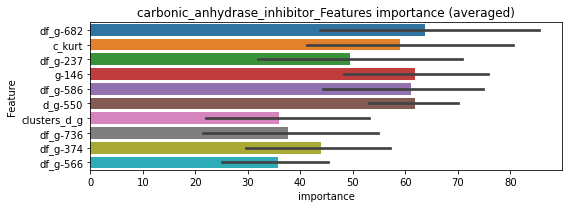

len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286417	valid_1's binary_logloss: 0.0544274
[200]	training's binary_logloss: 0.00487423	valid_1's binary_logloss: 0.0228562
[300]	training's binary_logloss: 0.00131169	valid_1's binary_logloss: 0.0160249
[400]	training's binary_logloss: 0.000618716	valid_1's binary_logloss: 0.014688
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000438728	valid_1's binary_logloss: 0.0143072


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296807	valid_1's binary_logloss: 0.0568853
[200]	training's binary_logloss: 0.00488375	valid_1's binary_logloss: 0.0266349


carbonic_anhydrase_inhibitor logloss: 0.018369242197519772


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00208225	valid_1's binary_logloss: 0.0224313


casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897215	valid_1's binary_logloss: 0.1698
[200]	training's binary_logloss: 0.0185714	valid_1's binary_logloss: 0.0724196
[300]	training's binary_logloss: 0.00601921	valid_1's binary_logloss: 0.0481257
[400]	training's binary_logloss: 0.00307805	valid_1's binary_logloss: 0.0397448
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.0026266	valid_1's binary_logloss: 0.0381968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875105	valid_1's binary_logloss: 0.163454
[200]	training's binary_logloss: 0.0185212	valid_1's binary_logloss: 0.0699629
[300]	training's binary_logloss: 0.00596054	valid_1's binary_logloss: 0.0423407
[400]	training's binary_logloss: 0.0030785	valid_1's binary_logloss: 0.0330538
[500]	training's binary_logloss: 0.00209889	valid_1's binary_logloss: 0.028464
Early stopping, best iteration is:
[581]	training's bi

1 / 3 AUC score:0.999
Threshold: 0.45844105033535903
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00730
p_label_rate: 0.00326 Vs.target_rate: 0.00161, Num_p_label: 13.0, conf_0:0.00730, conf_1:0.45844
threshold:0.46, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090378	valid_1's binary_logloss: 0.173179
[200]	training's binary_logloss: 0.0184731	valid_1's binary_logloss: 0.0687302
[300]	training's binary_logloss: 0.00591232	valid_1's binary_logloss: 0.0382415
[400]	training's binary_logloss: 0.00303766	valid_1's binary_logloss: 0.0290425
[500]	training's binary_logloss: 0.00205717	valid_1's binary_logloss: 0.0246136
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00173847	valid_1's binary_logloss: 0.022312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857768	valid_1's binary_logloss: 0.20672
[200]	training's binary_logloss: 0.0170657	valid_1's binary_logloss: 0.113031
[300]	training's binary_logloss: 0.00559465	valid_1's binary_logloss: 0.0848109


2 / 3 AUC score:0.998
Threshold: 0.45844105033535903
Remove_noisy_labels: 11 → positive_corect_labels: 488.0/983
30th percentile: 0.00858
p_label_rate: 0.00552 Vs.target_rate: 0.00161, Num_p_label: 22.0, conf_0:0.00858, conf_1:0.45844
Num_p_label: 22.0, Expected: 6.4, Adj_threshold_1: 0.46
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_2: 0.50
Num_p_label: 11.0, Expected: 6.4, Adj_threshold_3: 0.54


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00368489	valid_1's binary_logloss: 0.0766221


Num_p_label: 6.0, Expected: 6.4, Adj_threshold_4: 0.58
threshold:0.58, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:488.0/983, y_label_rate: 0.49644
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088976	valid_1's binary_logloss: 0.14966
[200]	training's binary_logloss: 0.0184704	valid_1's binary_logloss: 0.0614162
[300]	training's binary_logloss: 0.00603967	valid_1's binary_logloss: 0.0364616
[400]	training's binary_logloss: 0.00311388	valid_1's binary_logloss: 0.0277948
[500]	training's binary_logloss: 0.00210185	valid_1's binary_logloss: 0.0241442
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00176392	valid_1's binary_logloss: 0.0227364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856311	valid_1's binary_logloss: 0.165718
[200]	training's binary_logloss: 0.0168009	valid_1's binary_logloss: 0.07055
[300]	training's binary_logloss: 0.00545116	valid_1's binary_logloss: 0.0445209
[400]	training's binary_logloss: 0.00286557	valid_1's binary_logloss: 0.0360279
[500]	training's binary_logloss: 0.00198309	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.5784410503353591
Remove_noisy_labels: 3 → positive_corect_labels: 486.0/980
30th percentile: 0.00529
p_label_rate: 0.00176 Vs.target_rate: 0.00161, Num_p_label: 7.0, conf_0:0.00529, conf_1:0.57844
threshold:0.58, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:493.0/4962, y_label_rate: 0.09936


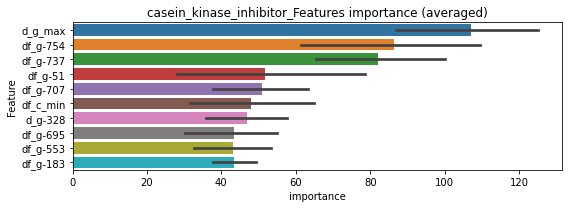

len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220277	valid_1's binary_logloss: 0.0410074
[200]	training's binary_logloss: 0.00314478	valid_1's binary_logloss: 0.0163878
[300]	training's binary_logloss: 0.000932099	valid_1's binary_logloss: 0.0123478
[400]	training's binary_logloss: 0.000490074	valid_1's binary_logloss: 0.0116851
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00042073	valid_1's binary_logloss: 0.011498


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225519	valid_1's binary_logloss: 0.0438526
[200]	training's binary_logloss: 0.00329379	valid_1's binary_logloss: 0.0211099
[300]	training's binary_logloss: 0.000946602	valid_1's binary_logloss: 0.0172956
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000837415	valid_1's binary_logloss: 0.0170689


casein_kinase_inhibitor logloss: 0.014283481799639649
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670913	valid_1's binary_logloss: 0.107199
[200]	training's binary_logloss: 0.0111944	valid_1's binary_logloss: 0.0312507
[300]	training's binary_logloss: 0.00352903	valid_1's binary_logloss: 0.0154805
[400]	training's binary_logloss: 0.00191255	valid_1's binary_logloss: 0.0106553
[500]	training's binary_logloss: 0.00145783	valid_1's binary_logloss: 0.00900199
[600]	training's binary_logloss: 0.00135146	valid_1's binary_logloss: 0.00857242
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00135127	valid_1's binary_logloss: 0.00857057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678347	valid_1's binary_logloss: 0.108663
[200]	training's binary_logloss: 0.0112299	valid_1's binary_logloss: 0.035156
[300]	training's binary_logloss: 0.00351472	valid_1's binary_logloss: 0.0198763
[400]	training's binary_logloss: 0.00188977	val

1 / 3 AUC score:1.000
Threshold: 0.2742511757497056
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00212
p_label_rate: 0.00452 Vs.target_rate: 0.00082, Num_p_label: 18.0, conf_0:0.00212, conf_1:0.36596
Num_p_label: 18.0, Expected: 3.3, Adj_threshold_1: 0.27
Num_p_label: 15.0, Expected: 3.3, Adj_threshold_2: 0.31
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_3: 0.35
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_4: 0.39
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_5: 0.43
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_6: 0.47
threshold:0.47, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667822	valid_1's binary_logloss: 0.10721
[200]	training's binary_logloss: 0.0111065	valid_1's binary_logloss: 0.0351426
[300]	training's binary_logloss: 0.00351829	valid_1's binary_logloss: 0.019232
[400]	training's binary_logloss: 0.00189904	valid_1's binary_logloss: 0.0138289
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00154047	valid_1's binary_logloss: 0.0125767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662093	valid_1's binary_logloss: 0.119896
[200]	training's binary_logloss: 0.0108157	valid_1's binary_logloss: 0.0436349
[300]	training's binary_logloss: 0.00343026	valid_1's binary_logloss: 0.0259276
[400]	training's binary_logloss: 0.00186988	valid_1's binary_logloss: 0.0201964
[500]	training's binary_logloss: 0.00139207	valid_1's binary_logloss: 0.0176969
[600]	training's binary_logloss: 0.00130658	valid_1

2 / 3 AUC score:1.000
Threshold: 0.4742511757497055
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/994
30th percentile: 0.00218
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00218, conf_1:0.47425
threshold:0.47, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:496.0/994, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671651	valid_1's binary_logloss: 0.101835
[200]	training's binary_logloss: 0.0111657	valid_1's binary_logloss: 0.0305597
[300]	training's binary_logloss: 0.00353928	valid_1's binary_logloss: 0.0150418
[400]	training's binary_logloss: 0.0019185	valid_1's binary_logloss: 0.0105678
[500]	training's binary_logloss: 0.00141527	valid_1's binary_logloss: 0.00875505
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00131678	valid_1's binary_logloss: 0.00832973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672067	valid_1's binary_logloss: 0.106767
[200]	training's binary_logloss: 0.0111445	valid_1's binary_logloss: 0.0319032
[300]	training's binary_logloss: 0.00350568	valid_1's binary_logloss: 0.0157405
[400]	training's binary_logloss: 0.00188076	valid_1's binary_logloss: 0.0109095
[500]	training's binary_logloss: 0.0014093	valid

3 / 3 AUC score:1.000
Threshold: 0.4742511757497055
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/993
30th percentile: 0.00195
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00195, conf_1:0.47425
threshold:0.47, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/4975, y_label_rate: 0.10050


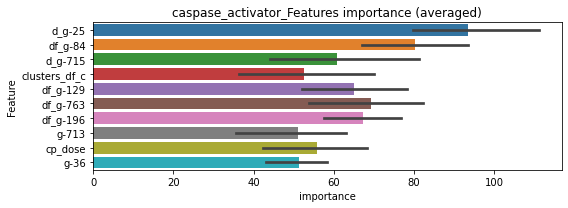

len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163388	valid_1's binary_logloss: 0.0297543
[200]	training's binary_logloss: 0.00201683	valid_1's binary_logloss: 0.0106046
[300]	training's binary_logloss: 0.00058559	valid_1's binary_logloss: 0.00780668


len(train_index) : 2488
len(valid_index) : 2487


Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000491922	valid_1's binary_logloss: 0.00762948


================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170573	valid_1's binary_logloss: 0.0307381
[200]	training's binary_logloss: 0.00201363	valid_1's binary_logloss: 0.0101869
[300]	training's binary_logloss: 0.00058958	valid_1's binary_logloss: 0.0068232
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000467248	valid_1's binary_logloss: 0.00662005


caspase_activator logloss: 0.007124867807079532
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633896	valid_1's binary_logloss: 0.0930478
[200]	training's binary_logloss: 0.0105483	valid_1's binary_logloss: 0.0261789
[300]	training's binary_logloss: 0.00342108	valid_1's binary_logloss: 0.0128494
[400]	training's binary_logloss: 0.00188143	valid_1's binary_logloss: 0.00872597
[500]	training's binary_logloss: 0.00149252	valid_1's binary_logloss: 0.00762436
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00140475	valid_1's binary_logloss: 0.00721456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606556	valid_1's binary_logloss: 0.106955
[200]	training's binary_logloss: 0.00995863	valid_1's binary_logloss: 0.0390229
[300]	training's binary_logloss: 0.00328523	valid_1's binary_logloss: 0.0237592
[400]	training's binary_logloss: 0.00183215	valid_1's binary_logloss: 0.0173929
[500]	training's binary_logloss: 0.00141779	

1 / 3 AUC score:1.000
Threshold: 0.40100268843972553
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00180
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00180, conf_1:0.40100
threshold:0.40, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629816	valid_1's binary_logloss: 0.100169
[200]	training's binary_logloss: 0.0103912	valid_1's binary_logloss: 0.031253
[300]	training's binary_logloss: 0.00334918	valid_1's binary_logloss: 0.017734
[400]	training's binary_logloss: 0.00185127	valid_1's binary_logloss: 0.0142355
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00152931	valid_1's binary_logloss: 0.0131198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609555	valid_1's binary_logloss: 0.112756
[200]	training's binary_logloss: 0.0100411	valid_1's binary_logloss: 0.0419156
[300]	training's binary_logloss: 0.00326263	valid_1's binary_logloss: 0.0222334
[400]	training's binary_logloss: 0.0018348	valid_1's binary_logloss: 0.0157522
[500]	training's binary_logloss: 0.0014022	valid_1's binary_logloss: 0.0132422
Early stopping, best iteration is:
[538]	training's b

2 / 3 AUC score:1.000
Threshold: 0.40100268843972553
Remove_noisy_labels: 3 → positive_corect_labels: 497.0/995
30th percentile: 0.00193
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00193, conf_1:0.48258
threshold:0.40, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:497.0/995, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601666	valid_1's binary_logloss: 0.0974378
[200]	training's binary_logloss: 0.00999083	valid_1's binary_logloss: 0.0332161
[300]	training's binary_logloss: 0.00329137	valid_1's binary_logloss: 0.0199117
[400]	training's binary_logloss: 0.00181515	valid_1's binary_logloss: 0.0148951
[500]	training's binary_logloss: 0.00141814	valid_1's binary_logloss: 0.0132617
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00139957	valid_1's binary_logloss: 0.0131362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604414	valid_1's binary_logloss: 0.112957
[200]	training's binary_logloss: 0.0100207	valid_1's binary_logloss: 0.0423049
[300]	training's binary_logloss: 0.00325163	valid_1's binary_logloss: 0.0227732
[400]	training's binary_logloss: 0.00183445	valid_1's binary_logloss: 0.0171879
[500]	training's binary_logloss: 0.00140133	val

3 / 3 AUC score:1.000
Threshold: 0.40100268843972553
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/992
30th percentile: 0.00178
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00178, conf_1:0.45083
threshold:0.40, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:501.0/4974, y_label_rate: 0.10072


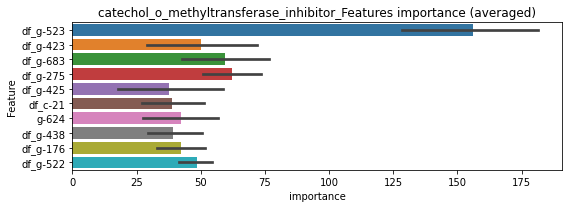

len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168075	valid_1's binary_logloss: 0.028063
[200]	training's binary_logloss: 0.00201767	valid_1's binary_logloss: 0.0109893
[300]	training's binary_logloss: 0.000575942	valid_1's binary_logloss: 0.00923439
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000601612	valid_1's binary_logloss: 0.0091774


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167813	valid_1's binary_logloss: 0.0250438
[200]	training's binary_logloss: 0.00201269	valid_1's binary_logloss: 0.00828989
[300]	training's binary_logloss: 0.000575236	valid_1's binary_logloss: 0.00615749


catechol_o_methyltransferase_inhibitor logloss: 0.007554079107343537


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000459428	valid_1's binary_logloss: 0.00593076


cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146263	valid_1's binary_logloss: 0.372493
[200]	training's binary_logloss: 0.0444073	valid_1's binary_logloss: 0.274645
[300]	training's binary_logloss: 0.016325	valid_1's binary_logloss: 0.236595
[400]	training's binary_logloss: 0.00786354	valid_1's binary_logloss: 0.219228
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00570086	valid_1's binary_logloss: 0.213036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150091	valid_1's binary_logloss: 0.362203
[200]	training's binary_logloss: 0.0447942	valid_1's binary_logloss: 0.26928
[300]	training's binary_logloss: 0.0164108	valid_1's binary_logloss: 0.233875
[400]	training's binary_logloss: 0.00790715	valid_1's binary_logloss: 0.213277


1 / 3 AUC score:0.966
Threshold: 0.36807131887366473


Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00695483	valid_1's binary_logloss: 0.211514


Remove_noisy_labels: 80 → positive_corect_labels: 460/920
30th percentile: 0.07456
p_label_rate: 0.08011 Vs.target_rate: 0.00427, Num_p_label: 319.0, conf_0:0.07456, conf_1:0.48324
Num_p_label: 319.0, Expected: 17.0, Adj_threshold_1: 0.37
Num_p_label: 220.0, Expected: 17.0, Adj_threshold_2: 0.41
Num_p_label: 151.0, Expected: 17.0, Adj_threshold_3: 0.45
Num_p_label: 109.0, Expected: 17.0, Adj_threshold_4: 0.49
Num_p_label: 65.0, Expected: 17.0, Adj_threshold_5: 0.53
Num_p_label: 42.0, Expected: 17.0, Adj_threshold_6: 0.57
Num_p_label: 29.0, Expected: 17.0, Adj_threshold_7: 0.61
Num_p_label: 18.0, Expected: 17.0, Adj_threshold_8: 0.65
threshold:0.65, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:460.0/920, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147475	valid_1's binary_logloss: 0.329597
[200]	training's binary_logloss: 0.041982	valid_1's binary_logloss: 0.219616
[300]	training's binary_logloss: 0.0153538	valid_1's binary_logloss: 0.177246
[400]	training's binary_logloss: 0.00743983	valid_1's binary_logloss: 0.156051
[500]	training's binary_logloss: 0.00458117	valid_1's binary_logloss: 0.145631
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00353074	valid_1's binary_logloss: 0.139726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143235	valid_1's binary_logloss: 0.328903
[200]	training's binary_logloss: 0.040484	valid_1's binary_logloss: 0.230836
[300]	training's binary_logloss: 0.014766	valid_1's binary_logloss: 0.186262
[400]	training's binary_logloss: 0.00729478	valid_1's binary_logloss: 0.171124
[500]	training's binary_logloss: 0.00447793	valid_1's binary_log

2 / 3 AUC score:0.984
Threshold: 0.6480713188736648
Remove_noisy_labels: 39 → positive_corect_labels: 425.0/881
30th percentile: 0.05688
p_label_rate: 0.01331 Vs.target_rate: 0.00427, Num_p_label: 53.0, conf_0:0.01866, conf_1:0.64807
Num_p_label: 53.0, Expected: 17.0, Adj_threshold_1: 0.65
Num_p_label: 40.0, Expected: 17.0, Adj_threshold_2: 0.69
Num_p_label: 23.0, Expected: 17.0, Adj_threshold_3: 0.73
threshold:0.73, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:425.0/881, y_label_rate: 0.48241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137678	valid_1's binary_logloss: 0.310668
[200]	training's binary_logloss: 0.037465	valid_1's binary_logloss: 0.198831
[300]	training's binary_logloss: 0.0135235	valid_1's binary_logloss: 0.149632
[400]	training's binary_logloss: 0.0065774	valid_1's binary_logloss: 0.129182
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00594903	valid_1's binary_logloss: 0.126473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13466	valid_1's binary_logloss: 0.29631
[200]	training's binary_logloss: 0.0368423	valid_1's binary_logloss: 0.198105
[300]	training's binary_logloss: 0.0134205	valid_1's binary_logloss: 0.160261
[400]	training's binary_logloss: 0.00665816	valid_1's binary_logloss: 0.143045


3 / 3 AUC score:0.992
Threshold: 0.7280713188736648


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00475731	valid_1's binary_logloss: 0.136298


Remove_noisy_labels: 35 → positive_corect_labels: 392.0/846
30th percentile: 0.05644
p_label_rate: 0.00552 Vs.target_rate: 0.00427, Num_p_label: 22.0, conf_0:0.02726, conf_1:0.72807
threshold:0.73, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:414.0/4828, y_label_rate: 0.08575


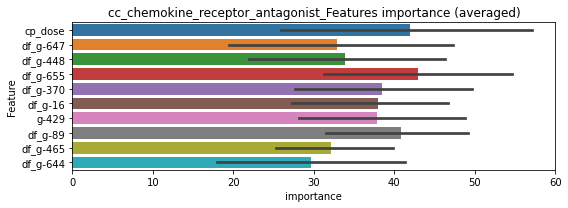

len(train_index) : 2414
len(valid_index) : 2414
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373985	valid_1's binary_logloss: 0.0994928
[200]	training's binary_logloss: 0.00827467	valid_1's binary_logloss: 0.0700123
[300]	training's binary_logloss: 0.00243549	valid_1's binary_logloss: 0.0630233
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00184237	valid_1's binary_logloss: 0.0623589


len(train_index) : 2414
len(valid_index) : 2414
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356889	valid_1's binary_logloss: 0.10368
[200]	training's binary_logloss: 0.00754252	valid_1's binary_logloss: 0.0795536


cc_chemokine_receptor_antagonist logloss: 0.0695426344252772


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0048122	valid_1's binary_logloss: 0.0767263


cck_receptor_antagonist , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634234	valid_1's binary_logloss: 0.104443
[200]	training's binary_logloss: 0.0103947	valid_1's binary_logloss: 0.0294311
[300]	training's binary_logloss: 0.00335748	valid_1's binary_logloss: 0.0129867
[400]	training's binary_logloss: 0.00184186	valid_1's binary_logloss: 0.00865472
[500]	training's binary_logloss: 0.0013841	valid_1's binary_logloss: 0.00707114
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00128651	valid_1's binary_logloss: 0.00671399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660299	valid_1's binary_logloss: 0.106788
[200]	training's binary_logloss: 0.0109837	valid_1's binary_logloss: 0.0298748
[300]	training's binary_logloss: 0.00341805	valid_1's binary_logloss: 0.0137188
[400]	training's binary_logloss: 0.00184207	valid_1's binary_logloss: 0.00911078
[500]	training's binary_logloss: 0.00136622	va

1 / 3 AUC score:1.000
Threshold: 0.5115192930264335
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00240
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00240, conf_1:0.51152
threshold:0.51, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634234	valid_1's binary_logloss: 0.104443
[200]	training's binary_logloss: 0.0103947	valid_1's binary_logloss: 0.0294311
[300]	training's binary_logloss: 0.00335748	valid_1's binary_logloss: 0.0129867
[400]	training's binary_logloss: 0.00184186	valid_1's binary_logloss: 0.00865472
[500]	training's binary_logloss: 0.0013841	valid_1's binary_logloss: 0.00707114
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00128651	valid_1's binary_logloss: 0.00671399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660299	valid_1's binary_logloss: 0.106788
[200]	training's binary_logloss: 0.0109837	valid_1's binary_logloss: 0.0298748
[300]	training's binary_logloss: 0.00341805	valid_1's binary_logloss: 0.0137188
[400]	training's binary_logloss: 0.00184207	valid_1's binary_logloss: 0.00911078
[500]	training's binary_logloss: 0.00136622	va

2 / 3 AUC score:1.000
Threshold: 0.5115192930264335
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00240
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00240, conf_1:0.51152
threshold:0.51, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634234	valid_1's binary_logloss: 0.104443
[200]	training's binary_logloss: 0.0103947	valid_1's binary_logloss: 0.0294311
[300]	training's binary_logloss: 0.00335748	valid_1's binary_logloss: 0.0129867
[400]	training's binary_logloss: 0.00184186	valid_1's binary_logloss: 0.00865472
[500]	training's binary_logloss: 0.0013841	valid_1's binary_logloss: 0.00707114
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00128651	valid_1's binary_logloss: 0.00671399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660299	valid_1's binary_logloss: 0.106788
[200]	training's binary_logloss: 0.0109837	valid_1's binary_logloss: 0.0298748
[300]	training's binary_logloss: 0.00341805	valid_1's binary_logloss: 0.0137188
[400]	training's binary_logloss: 0.00184207	valid_1's binary_logloss: 0.00911078
[500]	training's binary_logloss: 0.00136622	va

3 / 3 AUC score:1.000
Threshold: 0.5115192930264335
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00240
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00240, conf_1:0.51152
threshold:0.51, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


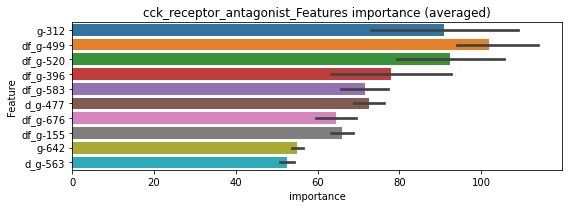

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162554	valid_1's binary_logloss: 0.0265891
[200]	training's binary_logloss: 0.00198277	valid_1's binary_logloss: 0.00685772
[300]	training's binary_logloss: 0.00056659	valid_1's binary_logloss: 0.00404751
[400]	training's binary_logloss: 0.000303379	valid_1's binary_logloss: 0.00344297
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000273041	valid_1's binary_logloss: 0.00334204


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165994	valid_1's binary_logloss: 0.0249051
[200]	training's binary_logloss: 0.00201637	valid_1's binary_logloss: 0.00654459
[300]	training's binary_logloss: 0.000584173	valid_1's binary_logloss: 0.00402658
[400]	training's binary_logloss: 0.000310092	valid_1's binary_logloss: 0.00341144
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000258955	valid_1's binary_logloss: 0.00329815


cck_receptor_antagonist logloss: 0.0033200947486871535
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220597	valid_1's binary_logloss: 0.6342
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.191455	valid_1's binary_logloss: 0.629767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228159	valid_1's binary_logloss: 0.640186


1 / 3 AUC score:0.684
Threshold: 0.5073668034995759
Remove_noisy_labels: 384 → positive_corect_labels: 308/616
30th percentile: 0.42020
p_label_rate: 0.35334 Vs.target_rate: 0.01106, Num_p_label: 1407.0, conf_0:0.42020, conf_1:0.50737
Num_p_label: 1407.0, Expected: 44.0, Adj_threshold_1: 0.51
Num_p_label: 864.0, Expected: 44.0, Adj_threshold_2: 0.55
Num_p_label: 473.0, Expected: 44.0, Adj_threshold_3: 0.59
Num_p_label: 226.0, Expected: 44.0, Adj_threshold_4: 0.63
Num_p_label: 82.0, Expected: 44.0, Adj_threshold_5: 0.67
Num_p_label: 25.0, Expected: 44.0, Adj_threshold_6: 0.71


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.17788	valid_1's binary_logloss: 0.634541


threshold:0.71, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:308.0/616, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204853	valid_1's binary_logloss: 0.542485
[200]	training's binary_logloss: 0.0752193	valid_1's binary_logloss: 0.478467
[300]	training's binary_logloss: 0.0320021	valid_1's binary_logloss: 0.451727
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0324727	valid_1's binary_logloss: 0.450192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196806	valid_1's binary_logloss: 0.524769
[200]	training's binary_logloss: 0.0717446	valid_1's binary_logloss: 0.465821


2 / 3 AUC score:0.872
Threshold: 0.707366803499576
Remove_noisy_labels: 141 → positive_corect_labels: 179.0/475
30th percentile: 0.32148
p_label_rate: 0.10221 Vs.target_rate: 0.01106, Num_p_label: 407.0, conf_0:0.32148, conf_1:0.70737
Num_p_label: 407.0, Expected: 44.0, Adj_threshold_1: 0.71
Num_p_label: 284.0, Expected: 44.0, Adj_threshold_2: 0.75
Num_p_label: 187.0, Expected: 44.0, Adj_threshold_3: 0.79
Num_p_label: 100.0, Expected: 44.0, Adj_threshold_4: 0.83
Num_p_label: 51.0, Expected: 44.0, Adj_threshold_5: 0.87
threshold:0.87, positive p_label:51.0/3982, p_label_rate: 0.01281


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0454185	valid_1's binary_logloss: 0.445709


positive y_label:179.0/475, y_label_rate: 0.37684
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173433	valid_1's binary_logloss: 0.478814
[200]	training's binary_logloss: 0.0580628	valid_1's binary_logloss: 0.421078
[300]	training's binary_logloss: 0.0235928	valid_1's binary_logloss: 0.395656
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0198697	valid_1's binary_logloss: 0.3934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172862	valid_1's binary_logloss: 0.424577
[200]	training's binary_logloss: 0.0605329	valid_1's binary_logloss: 0.339081
[300]	training's binary_logloss: 0.0246059	valid_1's binary_logloss: 0.302664
[400]	training's binary_logloss: 0.0126181	valid_1's binary_logloss: 0.283402
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00994446	valid_1's binary_logloss: 0.275948


3 / 3 AUC score:0.927
Threshold: 0.8673668034995762
Remove_noisy_labels: 103 → positive_corect_labels: 78.0/372
30th percentile: 0.10096
p_label_rate: 0.00929 Vs.target_rate: 0.01106, Num_p_label: 37.0, conf_0:0.10096, conf_1:0.86737
threshold:0.87, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:115.0/4354, y_label_rate: 0.02641


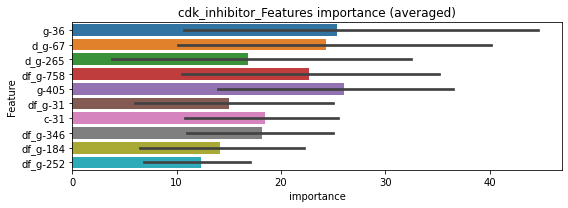

len(train_index) : 2177
len(valid_index) : 2177
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2177
len(valid_index) : 2177
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[81]	training's binary_logloss: 0.0138915	valid_1's binary_logloss: 0.0899495
Training until validation scores don't improve for 10 rounds


cdk_inhibitor logloss: 0.08783580932486204
chelating_agent , len(trt) : 54


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.0136825	valid_1's binary_logloss: 0.0857221
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11784	valid_1's binary_logloss: 0.259739
[200]	training's binary_logloss: 0.028626	valid_1's binary_logloss: 0.147065
[300]	training's binary_logloss: 0.00990767	valid_1's binary_logloss: 0.10768
[400]	training's binary_logloss: 0.00484873	valid_1's binary_logloss: 0.0923193
[500]	training's binary_logloss: 0.00306669	valid_1's binary_logloss: 0.0846201
[600]	training's binary_logloss: 0.00232677	valid_1's binary_logloss: 0.0797906
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00214139	valid_1's binary_logloss: 0.0780188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119248	valid_1's binary_logloss: 0.232808
[200]	training's binary_logloss: 0.0300052	valid_1's binary_logloss: 0.126984
[300]	training's binary_logloss: 0.0101737	valid_1's binary_logloss: 0.0869162
[400]	training's binary_logloss: 0.00500056	valid_1's bina

1 / 3 AUC score:0.997
Threshold: 0.3557013270742647
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentile: 0.01642
p_label_rate: 0.01883 Vs.target_rate: 0.00237, Num_p_label: 75.0, conf_0:0.01642, conf_1:0.41287
Num_p_label: 75.0, Expected: 9.4, Adj_threshold_1: 0.36
Num_p_label: 48.0, Expected: 9.4, Adj_threshold_2: 0.40
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_3: 0.44
Num_p_label: 23.0, Expected: 9.4, Adj_threshold_4: 0.48
Num_p_label: 15.0, Expected: 9.4, Adj_threshold_5: 0.52
Num_p_label: 11.0, Expected: 9.4, Adj_threshold_6: 0.56
threshold:0.56, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118319	valid_1's binary_logloss: 0.242795
[200]	training's binary_logloss: 0.0292815	valid_1's binary_logloss: 0.129199
[300]	training's binary_logloss: 0.00996243	valid_1's binary_logloss: 0.0864384
[400]	training's binary_logloss: 0.00481097	valid_1's binary_logloss: 0.0680897
[500]	training's binary_logloss: 0.00306567	valid_1's binary_logloss: 0.0592074
[600]	training's binary_logloss: 0.00231975	valid_1's binary_logloss: 0.0549006
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00210709	valid_1's binary_logloss: 0.0530728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122655	valid_1's binary_logloss: 0.238067
[200]	training's binary_logloss: 0.0309545	valid_1's binary_logloss: 0.126044
[300]	training's binary_logloss: 0.0105467	valid_1's binary_logloss: 0.0826533
[400]	training's binary_logloss: 0.00509338	valid_1's 

2 / 3 AUC score:1.000
Threshold: 0.5557013270742647
Remove_noisy_labels: 7 → positive_corect_labels: 487.0/971
30th percentile: 0.01539
p_label_rate: 0.00477 Vs.target_rate: 0.00237, Num_p_label: 19.0, conf_0:0.01539, conf_1:0.55570
threshold:0.56, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:487.0/971, y_label_rate: 0.50154
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114025	valid_1's binary_logloss: 0.245466
[200]	training's binary_logloss: 0.0276853	valid_1's binary_logloss: 0.138044
[300]	training's binary_logloss: 0.00958307	valid_1's binary_logloss: 0.0964445
[400]	training's binary_logloss: 0.00475698	valid_1's binary_logloss: 0.0804919
[500]	training's binary_logloss: 0.003038	valid_1's binary_logloss: 0.0728493
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00247172	valid_1's binary_logloss: 0.0692017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118223	valid_1's binary_logloss: 0.255514
[200]	training's binary_logloss: 0.0287217	valid_1's binary_logloss: 0.138085
[300]	training's binary_logloss: 0.00984196	valid_1's binary_logloss: 0.0937953
[400]	training's binary_logloss: 0.00476363	valid_1's binary_logloss: 0.0765153
[500]	training's binary_logloss: 0.00305051	valid_1's b

3 / 3 AUC score:0.999
Threshold: 0.5557013270742647
Remove_noisy_labels: 13 → positive_corect_labels: 479.0/958
30th percentile: 0.01705
p_label_rate: 0.00552 Vs.target_rate: 0.00237, Num_p_label: 22.0, conf_0:0.01705, conf_1:0.55570
threshold:0.56, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:501.0/4940, y_label_rate: 0.10142


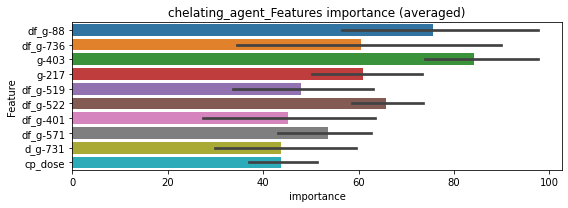

len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320234	valid_1's binary_logloss: 0.0831682
[200]	training's binary_logloss: 0.00576138	valid_1's binary_logloss: 0.0541494


len(train_index) : 2470
len(valid_index) : 2470


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00305978	valid_1's binary_logloss: 0.0506532


================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340608	valid_1's binary_logloss: 0.085922
[200]	training's binary_logloss: 0.0065665	valid_1's binary_logloss: 0.0546411
[300]	training's binary_logloss: 0.0018388	valid_1's binary_logloss: 0.0476199
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00175444	valid_1's binary_logloss: 0.0475239


chelating_agent logloss: 0.04908854992541904
chk_inhibitor , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736486	valid_1's binary_logloss: 0.122183
[200]	training's binary_logloss: 0.0136543	valid_1's binary_logloss: 0.0416442
[300]	training's binary_logloss: 0.004453	valid_1's binary_logloss: 0.0220957
[400]	training's binary_logloss: 0.00236756	valid_1's binary_logloss: 0.0156071
[500]	training's binary_logloss: 0.00168266	valid_1's binary_logloss: 0.0129415
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00152668	valid_1's binary_logloss: 0.0120583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07372	valid_1's binary_logloss: 0.155097
[200]	training's binary_logloss: 0.0132663	valid_1's binary_logloss: 0.0719381
[300]	training's binary_logloss: 0.00422443	valid_1's binary_logloss: 0.0475579
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00256892	valid_1's binary_logloss: 0.0423244


1 / 3 AUC score:1.000
Threshold: 0.5034383258595847
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00397
p_label_rate: 0.00326 Vs.target_rate: 0.00108, Num_p_label: 13.0, conf_0:0.00397, conf_1:0.50344
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724588	valid_1's binary_logloss: 0.12427
[200]	training's binary_logloss: 0.0132282	valid_1's binary_logloss: 0.044098
[300]	training's binary_logloss: 0.00428119	valid_1's binary_logloss: 0.0256394
[400]	training's binary_logloss: 0.00228938	valid_1's binary_logloss: 0.0196915
[500]	training's binary_logloss: 0.00162971	valid_1's binary_logloss: 0.0171849
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00155981	valid_1's binary_logloss: 0.0168268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739868	valid_1's binary_logloss: 0.136086
[200]	training's binary_logloss: 0.0132278	valid_1's binary_logloss: 0.0536066
[300]	training's binary_logloss: 0.00427635	valid_1's binary_logloss: 0.0347421
[400]	training's binary_logloss: 0.00226589	valid_1's binary_logloss: 0.0281093
[500]	training's binary_logloss: 0.00162707	valid_1

2 / 3 AUC score:1.000
Threshold: 0.5834383258595848
Remove_noisy_labels: 6 → positive_corect_labels: 492.0/986
30th percentile: 0.00287
p_label_rate: 0.00151 Vs.target_rate: 0.00108, Num_p_label: 6.0, conf_0:0.00287, conf_1:0.58344
threshold:0.58, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:492.0/986, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712715	valid_1's binary_logloss: 0.144957
[200]	training's binary_logloss: 0.0129395	valid_1's binary_logloss: 0.0662478
[300]	training's binary_logloss: 0.0041487	valid_1's binary_logloss: 0.0429275
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00280462	valid_1's binary_logloss: 0.0398636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727089	valid_1's binary_logloss: 0.127132
[200]	training's binary_logloss: 0.0131498	valid_1's binary_logloss: 0.0461418
[300]	training's binary_logloss: 0.00425275	valid_1's binary_logloss: 0.0253131
[400]	training's binary_logloss: 0.00227203	valid_1's binary_logloss: 0.0180854
[500]	training's binary_logloss: 0.00161458	valid_1's binary_logloss: 0.0150517
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00147742	valid_1's binary_logloss: 0.0139369


3 / 3 AUC score:1.000
Threshold: 0.5834383258595848
Remove_noisy_labels: 10 → positive_corect_labels: 483.0/976
30th percentile: 0.00360
p_label_rate: 0.00126 Vs.target_rate: 0.00108, Num_p_label: 5.0, conf_0:0.00360, conf_1:0.58344
threshold:0.58, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:488.0/4958, y_label_rate: 0.09843


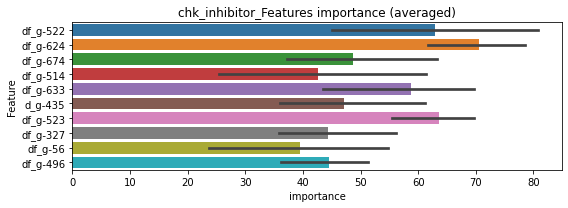

len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202953	valid_1's binary_logloss: 0.0359284
[200]	training's binary_logloss: 0.00276453	valid_1's binary_logloss: 0.0132903
[300]	training's binary_logloss: 0.000753064	valid_1's binary_logloss: 0.00967148
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000502108	valid_1's binary_logloss: 0.0091674


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210322	valid_1's binary_logloss: 0.0468837
[200]	training's binary_logloss: 0.00255906	valid_1's binary_logloss: 0.0262364


chk_inhibitor logloss: 0.017036601804892602


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00149673	valid_1's binary_logloss: 0.0249058


chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100255	valid_1's binary_logloss: 0.186953
[200]	training's binary_logloss: 0.0226651	valid_1's binary_logloss: 0.0817143
[300]	training's binary_logloss: 0.00750463	valid_1's binary_logloss: 0.0508858
[400]	training's binary_logloss: 0.00373211	valid_1's binary_logloss: 0.0394978
[500]	training's binary_logloss: 0.00242952	valid_1's binary_logloss: 0.0340457
[600]	training's binary_logloss: 0.00192082	valid_1's binary_logloss: 0.0310568
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00188538	valid_1's binary_logloss: 0.030787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102157	valid_1's binary_logloss: 0.191453
[200]	training's binary_logloss: 0.0225431	valid_1's binary_logloss: 0.0822886
[300]	training's binary_logloss: 0.00740011	valid_1's binary_logloss: 0.0490874
[400]	training's binary_logloss: 0.00367916	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.5141561287264957
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00763
p_label_rate: 0.00779 Vs.target_rate: 0.00187, Num_p_label: 31.0, conf_0:0.00763, conf_1:0.51416
Num_p_label: 31.0, Expected: 7.4, Adj_threshold_1: 0.51
Num_p_label: 26.0, Expected: 7.4, Adj_threshold_2: 0.55
Num_p_label: 16.0, Expected: 7.4, Adj_threshold_3: 0.59
Num_p_label: 12.0, Expected: 7.4, Adj_threshold_4: 0.63
Num_p_label: 10.0, Expected: 7.4, Adj_threshold_5: 0.67
threshold:0.67, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100487	valid_1's binary_logloss: 0.208464
[200]	training's binary_logloss: 0.0221468	valid_1's binary_logloss: 0.108152
[300]	training's binary_logloss: 0.00727034	valid_1's binary_logloss: 0.0760952
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00536296	valid_1's binary_logloss: 0.0712662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997236	valid_1's binary_logloss: 0.200058
[200]	training's binary_logloss: 0.0220779	valid_1's binary_logloss: 0.0944884
[300]	training's binary_logloss: 0.00712371	valid_1's binary_logloss: 0.0588433
[400]	training's binary_logloss: 0.0035686	valid_1's binary_logloss: 0.0468411
[500]	training's binary_logloss: 0.00239092	valid_1's binary_logloss: 0.0417993
[600]	training's binary_logloss: 0.00188108	valid_1's binary_logloss: 0.0393004
Early stopping, best iteration is:
[645]	training's 

2 / 3 AUC score:0.999
Threshold: 0.6741561287264959
Remove_noisy_labels: 19 → positive_corect_labels: 479.0/977
30th percentile: 0.01114
p_label_rate: 0.00176 Vs.target_rate: 0.00187, Num_p_label: 7.0, conf_0:0.01114, conf_1:0.67416
threshold:0.67, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:479.0/977, y_label_rate: 0.49028
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992023	valid_1's binary_logloss: 0.180362
[200]	training's binary_logloss: 0.0220185	valid_1's binary_logloss: 0.0742322
[300]	training's binary_logloss: 0.00734532	valid_1's binary_logloss: 0.0414971
[400]	training's binary_logloss: 0.00361719	valid_1's binary_logloss: 0.0302581
[500]	training's binary_logloss: 0.00237996	valid_1's binary_logloss: 0.0252522
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00195388	valid_1's binary_logloss: 0.0229785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964968	valid_1's binary_logloss: 0.206167
[200]	training's binary_logloss: 0.0206732	valid_1's binary_logloss: 0.100345
[300]	training's binary_logloss: 0.00669693	valid_1's binary_logloss: 0.0700824
[400]	training's binary_logloss: 0.00335522	valid_1's binary_logloss: 0.0604785


3 / 3 AUC score:1.000
Threshold: 0.6741561287264959
Remove_noisy_labels: 10 → positive_corect_labels: 472.0/967
30th percentile: 0.00797


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00241969	valid_1's binary_logloss: 0.0554103


p_label_rate: 0.00276 Vs.target_rate: 0.00187, Num_p_label: 11.0, conf_0:0.00797, conf_1:0.67416
threshold:0.67, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:483.0/4949, y_label_rate: 0.09760


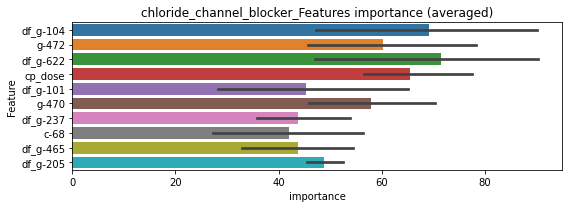

len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026767	valid_1's binary_logloss: 0.060115
[200]	training's binary_logloss: 0.00426662	valid_1's binary_logloss: 0.0269996
[300]	training's binary_logloss: 0.00122359	valid_1's binary_logloss: 0.0197527
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000865168	valid_1's binary_logloss: 0.0190072


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272786	valid_1's binary_logloss: 0.0602384
[200]	training's binary_logloss: 0.00447168	valid_1's binary_logloss: 0.03161
[300]	training's binary_logloss: 0.00123685	valid_1's binary_logloss: 0.0263451
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00127409	valid_1's binary_logloss: 0.0262733


chloride_channel_blocker logloss: 0.022639503119903263
cholesterol_inhibitor , len(trt) : 48


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108553	valid_1's binary_logloss: 0.244784
[200]	training's binary_logloss: 0.0253876	valid_1's binary_logloss: 0.135256
[300]	training's binary_logloss: 0.00857828	valid_1's binary_logloss: 0.0998485
[400]	training's binary_logloss: 0.00426197	valid_1's binary_logloss: 0.0868015
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00380565	valid_1's binary_logloss: 0.0854707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111163	valid_1's binary_logloss: 0.245384
[200]	training's binary_logloss: 0.0265915	valid_1's binary_logloss: 0.14752
[300]	training's binary_logloss: 0.0088416	valid_1's binary_logloss: 0.119915
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00494722	valid_1's binary_logloss: 0.113992


1 / 3 AUC score:0.987
Threshold: 0.3270126119761456
Remove_noisy_labels: 36 → positive_corect_labels: 482/964
30th percentile: 0.01930
p_label_rate: 0.02084 Vs.target_rate: 0.00212, Num_p_label: 83.0, conf_0:0.01930, conf_1:0.46250
Num_p_label: 83.0, Expected: 8.4, Adj_threshold_1: 0.33
Num_p_label: 62.0, Expected: 8.4, Adj_threshold_2: 0.37
Num_p_label: 38.0, Expected: 8.4, Adj_threshold_3: 0.41
Num_p_label: 29.0, Expected: 8.4, Adj_threshold_4: 0.45
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_5: 0.49
Num_p_label: 17.0, Expected: 8.4, Adj_threshold_6: 0.53
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_7: 0.57
threshold:0.57, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:482.0/964, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107192	valid_1's binary_logloss: 0.226144
[200]	training's binary_logloss: 0.0241832	valid_1's binary_logloss: 0.113845
[300]	training's binary_logloss: 0.00810553	valid_1's binary_logloss: 0.0793965
[400]	training's binary_logloss: 0.00405545	valid_1's binary_logloss: 0.0680818
[500]	training's binary_logloss: 0.0026273	valid_1's binary_logloss: 0.0619062
[600]	training's binary_logloss: 0.00205644	valid_1's binary_logloss: 0.0584806
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00200087	valid_1's binary_logloss: 0.0578772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107624	valid_1's binary_logloss: 0.217821
[200]	training's binary_logloss: 0.0249883	valid_1's binary_logloss: 0.107254
[300]	training's binary_logloss: 0.00841894	valid_1's binary_logloss: 0.0686761
[400]	training's binary_logloss: 0.00415721	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.5670126119761456
Remove_noisy_labels: 12 → positive_corect_labels: 471.0/952
30th percentile: 0.00959
p_label_rate: 0.00427 Vs.target_rate: 0.00212, Num_p_label: 17.0, conf_0:0.00959, conf_1:0.56701
threshold:0.57, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:471.0/952, y_label_rate: 0.49475
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106949	valid_1's binary_logloss: 0.196775
[200]	training's binary_logloss: 0.024705	valid_1's binary_logloss: 0.0852665
[300]	training's binary_logloss: 0.00824821	valid_1's binary_logloss: 0.0512882
[400]	training's binary_logloss: 0.00414327	valid_1's binary_logloss: 0.0382055
[500]	training's binary_logloss: 0.00272277	valid_1's binary_logloss: 0.032145
[600]	training's binary_logloss: 0.00210918	valid_1's binary_logloss: 0.0288958
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00205334	valid_1's binary_logloss: 0.0284276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104751	valid_1's binary_logloss: 0.226083
[200]	training's binary_logloss: 0.0236595	valid_1's binary_logloss: 0.11166
[300]	training's binary_logloss: 0.00786073	valid_1's binary_logloss: 0.072395
[400]	training's binary_logloss: 0.00395656	valid_1's bi

3 / 3 AUC score:1.000
Threshold: 0.5670126119761456
Remove_noisy_labels: 4 → positive_corect_labels: 468.0/948
30th percentile: 0.00911
p_label_rate: 0.00603 Vs.target_rate: 0.00212, Num_p_label: 24.0, conf_0:0.00911, conf_1:0.56701
threshold:0.57, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:492.0/4930, y_label_rate: 0.09980


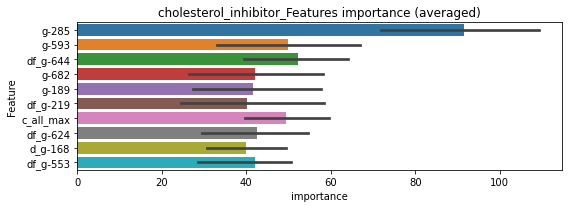

len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301638	valid_1's binary_logloss: 0.0692884
[200]	training's binary_logloss: 0.0053458	valid_1's binary_logloss: 0.0382904
[300]	training's binary_logloss: 0.00153064	valid_1's binary_logloss: 0.0333126
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00145531	valid_1's binary_logloss: 0.0332265


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292928	valid_1's binary_logloss: 0.0647587
[200]	training's binary_logloss: 0.00495122	valid_1's binary_logloss: 0.0328221
[300]	training's binary_logloss: 0.00146168	valid_1's binary_logloss: 0.0263676
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00123869	valid_1's binary_logloss: 0.0260623


cholesterol_inhibitor logloss: 0.029644382747922707
cholinergic_receptor_antagonist , len(trt) : 54


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117526	valid_1's binary_logloss: 0.257859
[200]	training's binary_logloss: 0.028997	valid_1's binary_logloss: 0.158702
[300]	training's binary_logloss: 0.00993822	valid_1's binary_logloss: 0.125931
[400]	training's binary_logloss: 0.00483994	valid_1's binary_logloss: 0.11362
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00429873	valid_1's binary_logloss: 0.112022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116289	valid_1's binary_logloss: 0.252966
[200]	training's binary_logloss: 0.0292907	valid_1's binary_logloss: 0.14509
[300]	training's binary_logloss: 0.00997777	valid_1's binary_logloss: 0.107807
[400]	training's binary_logloss: 0.00487842	valid_1's binary_logloss: 0.0941948
[500]	training's binary_logloss: 0.00309692	valid_1's binary_logloss: 0.0862834
Early stopping, best iteration is:
[520]	training's binary_l

1 / 3 AUC score:0.990
Threshold: 0.35351156164570563
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentile: 0.02103
p_label_rate: 0.01105 Vs.target_rate: 0.00237, Num_p_label: 44.0, conf_0:0.02103, conf_1:0.43161
Num_p_label: 44.0, Expected: 9.4, Adj_threshold_1: 0.35
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_2: 0.39
Num_p_label: 20.0, Expected: 9.4, Adj_threshold_3: 0.43
Num_p_label: 10.0, Expected: 9.4, Adj_threshold_4: 0.47
threshold:0.47, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.237922
[200]	training's binary_logloss: 0.027721	valid_1's binary_logloss: 0.136077
[300]	training's binary_logloss: 0.00948957	valid_1's binary_logloss: 0.0998613
[400]	training's binary_logloss: 0.00463556	valid_1's binary_logloss: 0.0860743
[500]	training's binary_logloss: 0.00297661	valid_1's binary_logloss: 0.0774596
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00282867	valid_1's binary_logloss: 0.0766843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11351	valid_1's binary_logloss: 0.245534
[200]	training's binary_logloss: 0.0279279	valid_1's binary_logloss: 0.146607
[300]	training's binary_logloss: 0.00946884	valid_1's binary_logloss: 0.114674


2 / 3 AUC score:0.992
Threshold: 0.47351156164570557
Remove_noisy_labels: 26 → positive_corect_labels: 469.0/942
30th percentile: 0.02116
p_label_rate: 0.00578 Vs.target_rate: 0.00237, Num_p_label: 23.0, conf_0:0.02116, conf_1:0.47351
threshold:0.47, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00521575	valid_1's binary_logloss: 0.106678


positive y_label:469.0/942, y_label_rate: 0.49788
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109657	valid_1's binary_logloss: 0.217685
[200]	training's binary_logloss: 0.0262431	valid_1's binary_logloss: 0.108626
[300]	training's binary_logloss: 0.00895258	valid_1's binary_logloss: 0.0698958
[400]	training's binary_logloss: 0.00445716	valid_1's binary_logloss: 0.0541115
[500]	training's binary_logloss: 0.00286785	valid_1's binary_logloss: 0.0467652
[600]	training's binary_logloss: 0.00220753	valid_1's binary_logloss: 0.0415229
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00206163	valid_1's binary_logloss: 0.0403095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110506	valid_1's binary_logloss: 0.218082
[200]	training's binary_logloss: 0.0266912	valid_1's binary_logloss: 0.115306
[300]	training's binary_logloss: 0.00902075	valid_1's binary_logloss: 0.0807318
[400]	training's binary_logloss: 0.0044448	valid_1's 

3 / 3 AUC score:0.999
Threshold: 0.47351156164570557
Remove_noisy_labels: 10 → positive_corect_labels: 463.0/932
30th percentile: 0.01242
p_label_rate: 0.00578 Vs.target_rate: 0.00237, Num_p_label: 23.0, conf_0:0.01242, conf_1:0.47351
threshold:0.47, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:486.0/4914, y_label_rate: 0.09890


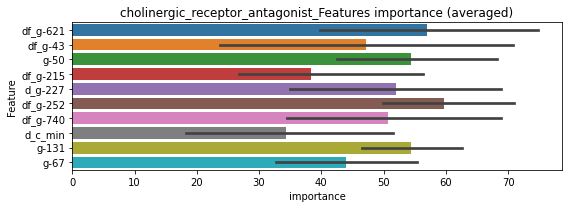

len(train_index) : 2457
len(valid_index) : 2457
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302534	valid_1's binary_logloss: 0.0748125
[200]	training's binary_logloss: 0.00543645	valid_1's binary_logloss: 0.051617


len(train_index) : 2457
len(valid_index) : 2457


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0028888	valid_1's binary_logloss: 0.0490606


================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284941	valid_1's binary_logloss: 0.0669481
[200]	training's binary_logloss: 0.00530602	valid_1's binary_logloss: 0.0414721
[300]	training's binary_logloss: 0.00156348	valid_1's binary_logloss: 0.0366199
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0016094	valid_1's binary_logloss: 0.0366025


cholinergic_receptor_antagonist logloss: 0.04283153192205718
coagulation_factor_inhibitor , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788098	valid_1's binary_logloss: 0.123881
[200]	training's binary_logloss: 0.0150065	valid_1's binary_logloss: 0.0419462
[300]	training's binary_logloss: 0.00480933	valid_1's binary_logloss: 0.0210884
[400]	training's binary_logloss: 0.00249638	valid_1's binary_logloss: 0.0149063
[500]	training's binary_logloss: 0.00172593	valid_1's binary_logloss: 0.0119657
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00149815	valid_1's binary_logloss: 0.0106981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759668	valid_1's binary_logloss: 0.144223
[200]	training's binary_logloss: 0.0139909	valid_1's binary_logloss: 0.0531918
[300]	training's binary_logloss: 0.00437585	valid_1's binary_logloss: 0.0295065
[400]	training's binary_logloss: 0.00227916	valid_1's binary_logloss: 0.0222108
[500]	training's binary_logloss: 0.00161217	valid

1 / 3 AUC score:1.000
Threshold: 0.6674980447103313
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00343
p_label_rate: 0.00000 Vs.target_rate: 0.00108, Num_p_label: 0.0, conf_0:0.00343, conf_1:0.66750
Num_p_label: 0.0, Expected: 4.3, Adj_threshold_1: 0.67
Num_p_label: 0.0, Expected: 4.3, Adj_threshold_2: 0.63
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_3: 0.59
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_4: 0.55
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_5: 0.51
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_6: 0.47
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788098	valid_1's binary_logloss: 0.123881
[200]	training's binary_logloss: 0.0150065	valid_1's binary_logloss: 0.0419462
[300]	training's binary_logloss: 0.00480933	valid_1's binary_logloss: 0.0210884
[400]	training's binary_logloss: 0.00249638	valid_1's binary_logloss: 0.0149063
[500]	training's binary_logloss: 0.00172593	valid_1's binary_logloss: 0.0119657
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00149815	valid_1's binary_logloss: 0.0106981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759668	valid_1's binary_logloss: 0.144223
[200]	training's binary_logloss: 0.0139909	valid_1's binary_logloss: 0.0531918
[300]	training's binary_logloss: 0.00437585	valid_1's binary_logloss: 0.0295065
[400]	training's binary_logloss: 0.00227916	valid_1's binary_logloss: 0.0222108
[500]	training's binary_logloss: 0.00161217	valid

2 / 3 AUC score:1.000
Threshold: 0.46749804471033113
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00343
p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00343, conf_1:0.46750
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771647	valid_1's binary_logloss: 0.118702
[200]	training's binary_logloss: 0.0145083	valid_1's binary_logloss: 0.0370422
[300]	training's binary_logloss: 0.00465379	valid_1's binary_logloss: 0.0195113
[400]	training's binary_logloss: 0.00247088	valid_1's binary_logloss: 0.0136449
[500]	training's binary_logloss: 0.00172278	valid_1's binary_logloss: 0.0114157
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00149909	valid_1's binary_logloss: 0.010417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777054	valid_1's binary_logloss: 0.140689
[200]	training's binary_logloss: 0.0140381	valid_1's binary_logloss: 0.0492909
[300]	training's binary_logloss: 0.00445314	valid_1's binary_logloss: 0.026432
[400]	training's binary_logloss: 0.00236161	valid_1's binary_logloss: 0.0194268
[500]	training's binary_logloss: 0.00164898	valid_1

3 / 3 AUC score:1.000
Threshold: 0.46749804471033113
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
30th percentile: 0.00302
p_label_rate: 0.00100 Vs.target_rate: 0.00108, Num_p_label: 4.0, conf_0:0.00302, conf_1:0.46750
threshold:0.47, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4980, y_label_rate: 0.10120


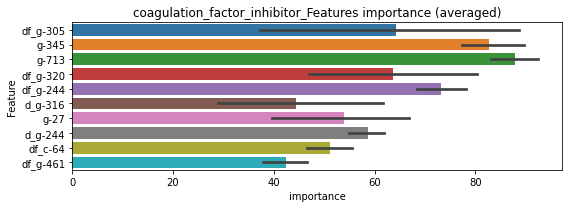

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200903	valid_1's binary_logloss: 0.0299675
[200]	training's binary_logloss: 0.00267726	valid_1's binary_logloss: 0.00704396
[300]	training's binary_logloss: 0.000752096	valid_1's binary_logloss: 0.00391187
[400]	training's binary_logloss: 0.000390265	valid_1's binary_logloss: 0.00332296
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000329025	valid_1's binary_logloss: 0.00320181


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185789	valid_1's binary_logloss: 0.0346288
[200]	training's binary_logloss: 0.00250003	valid_1's binary_logloss: 0.0122039
[300]	training's binary_logloss: 0.000711465	valid_1's binary_logloss: 0.00888226
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000400392	valid_1's binary_logloss: 0.00806961


coagulation_factor_inhibitor logloss: 0.005635708384710722
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937666	valid_1's binary_logloss: 0.180546
[200]	training's binary_logloss: 0.0195864	valid_1's binary_logloss: 0.0922711
[300]	training's binary_logloss: 0.00626097	valid_1's binary_logloss: 0.072031
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00428258	valid_1's binary_logloss: 0.0671845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932931	valid_1's binary_logloss: 0.184152
[200]	training's binary_logloss: 0.0190343	valid_1's binary_logloss: 0.0839539
[300]	training's binary_logloss: 0.00608486	valid_1's binary_logloss: 0.051118
[400]	training's binary_logloss: 0.00310784	valid_1's binary_logloss: 0.0382387
[500]	training's binary_logloss: 0.00210995	valid_1's binary_logloss: 0.0333242
[600]	training's binary_logloss: 0.00170205	valid_1's binary_logloss: 0.0304887
Early stopping, best iteration is:
[664]	training's

1 / 3 AUC score:0.997
Threshold: 0.5213866859445815
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00922
p_label_rate: 0.00326 Vs.target_rate: 0.00161, Num_p_label: 13.0, conf_0:0.00922, conf_1:0.52139
threshold:0.52, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091003	valid_1's binary_logloss: 0.177779
[200]	training's binary_logloss: 0.0188389	valid_1's binary_logloss: 0.0784012
[300]	training's binary_logloss: 0.0060631	valid_1's binary_logloss: 0.0502134
[400]	training's binary_logloss: 0.00307621	valid_1's binary_logloss: 0.0381066
[500]	training's binary_logloss: 0.00209195	valid_1's binary_logloss: 0.0332065
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.0017569	valid_1's binary_logloss: 0.0311129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908246	valid_1's binary_logloss: 0.183507
[200]	training's binary_logloss: 0.0187409	valid_1's binary_logloss: 0.0784402
[300]	training's binary_logloss: 0.0060671	valid_1's binary_logloss: 0.0460947
[400]	training's binary_logloss: 0.0030696	valid_1's binary_logloss: 0.0349661
[500]	training's binary_logloss: 0.00206187	valid_1's 

2 / 3 AUC score:1.000
Threshold: 0.5213866859445815
Remove_noisy_labels: 4 → positive_corect_labels: 493.0/986
30th percentile: 0.00643
p_label_rate: 0.00226 Vs.target_rate: 0.00161, Num_p_label: 9.0, conf_0:0.00643, conf_1:0.52139
threshold:0.52, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088309	valid_1's binary_logloss: 0.173777
[200]	training's binary_logloss: 0.0176287	valid_1's binary_logloss: 0.0874381
[300]	training's binary_logloss: 0.00575542	valid_1's binary_logloss: 0.0664208
[400]	training's binary_logloss: 0.00298051	valid_1's binary_logloss: 0.0586759
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00233585	valid_1's binary_logloss: 0.0567083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932615	valid_1's binary_logloss: 0.181444
[200]	training's binary_logloss: 0.0194964	valid_1's binary_logloss: 0.0795877
[300]	training's binary_logloss: 0.00625286	valid_1's binary_logloss: 0.0485217
[400]	training's binary_logloss: 0.00311339	valid_1's binary_logloss: 0.0391266
[500]	training's binary_logloss: 0.00206588	valid_1's binary_logloss: 0.0340276
[600]	training's binary_logloss: 0.00171141	valid_

3 / 3 AUC score:0.996
Threshold: 0.5213866859445815
Remove_noisy_labels: 6 → positive_corect_labels: 490.0/980
30th percentile: 0.00689
p_label_rate: 0.00603 Vs.target_rate: 0.00161, Num_p_label: 24.0, conf_0:0.00689, conf_1:0.52139
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_1: 0.52
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_2: 0.56
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_3: 0.60
Num_p_label: 7.0, Expected: 6.4, Adj_threshold_4: 0.64
threshold:0.64, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:497.0/4962, y_label_rate: 0.10016


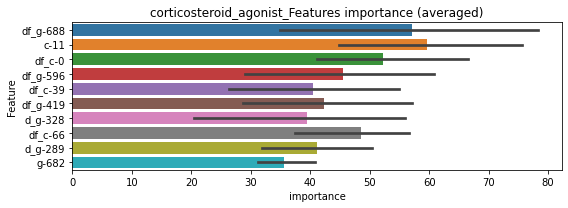

len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242594	valid_1's binary_logloss: 0.045901
[200]	training's binary_logloss: 0.0038021	valid_1's binary_logloss: 0.0185328
[300]	training's binary_logloss: 0.00105621	valid_1's binary_logloss: 0.0134067
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000608022	valid_1's binary_logloss: 0.0127913


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253517	valid_1's binary_logloss: 0.0475159
[200]	training's binary_logloss: 0.00395597	valid_1's binary_logloss: 0.0196263
[300]	training's binary_logloss: 0.00108782	valid_1's binary_logloss: 0.0138069
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000569702	valid_1's binary_logloss: 0.0123699


corticosteroid_agonist logloss: 0.012580604615833952
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.668278	valid_1's binary_logloss: 0.692358
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.542
Threshold: 0.5002448279207589
Remove_noisy_labels: 476 → positive_corect_labels: 262/524
30th percentile: 0.48157
p_label_rate: 0.43646 Vs.target_rate: 0.01215, Num_p_label: 1738.0, conf_0:0.48157, conf_1:0.50024
Num_p_label: 1738.0, Expected: 48.4, Adj_threshold_1: 0.50
Num_p_label: 248.0, Expected: 48.4, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 48.4, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[23]	training's binary_logloss: 0.521836	valid_1's binary_logloss: 0.687385


positive y_label:262.0/524, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.333409	valid_1's binary_logloss: 0.642279
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.707
Threshold: 0.5802448279207589
Remove_noisy_labels: 200 → positive_corect_labels: 118.0/324
30th percentile: 0.43777
p_label_rate: 0.19638 Vs.target_rate: 0.01215, Num_p_label: 782.0, conf_0:0.43777, conf_1:0.58024
Num_p_label: 782.0, Expected: 48.4, Adj_threshold_1: 0.58
Num_p_label: 391.0, Expected: 48.4, Adj_threshold_2: 0.62
Num_p_label: 145.0, Expected: 48.4, Adj_threshold_3: 0.66
Num_p_label: 36.0, Expected: 48.4, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:36.0/3982, p_label_rate: 0.00904


Early stopping, best iteration is:
[81]	training's binary_logloss: 0.274316	valid_1's binary_logloss: 0.62197


positive y_label:118.0/324, y_label_rate: 0.36420
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186998	valid_1's binary_logloss: 0.462926
[200]	training's binary_logloss: 0.0711767	valid_1's binary_logloss: 0.419332
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0646955	valid_1's binary_logloss: 0.418461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176104	valid_1's binary_logloss: 0.433848


3 / 3 AUC score:0.893
Threshold: 0.700244827920759
Remove_noisy_labels: 71 → positive_corect_labels: 56.0/253
30th percentile: 0.12228
p_label_rate: 0.08689 Vs.target_rate: 0.01215, Num_p_label: 346.0, conf_0:0.12228, conf_1:0.70024
Num_p_label: 346.0, Expected: 48.4, Adj_threshold_1: 0.70
Num_p_label: 250.0, Expected: 48.4, Adj_threshold_2: 0.74
Num_p_label: 171.0, Expected: 48.4, Adj_threshold_3: 0.78
Num_p_label: 116.0, Expected: 48.4, Adj_threshold_4: 0.82
Num_p_label: 56.0, Expected: 48.4, Adj_threshold_5: 0.86


[200]	training's binary_logloss: 0.0640695	valid_1's binary_logloss: 0.38338
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0597511	valid_1's binary_logloss: 0.381165


threshold:0.86, positive p_label:56.0/3982, p_label_rate: 0.01406
positive y_label:112.0/4235, y_label_rate: 0.02645


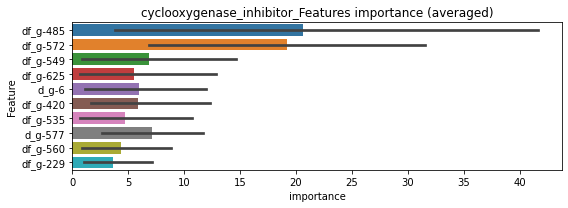

len(train_index) : 2117
len(valid_index) : 2118
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2118
len(valid_index) : 2117
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.016372	valid_1's binary_logloss: 0.0875428
Training until validation scores don't improve for 10 rounds


cyclooxygenase_inhibitor logloss: 0.08968993975916899
cytochrome_p450_inhibitor , len(trt) : 104


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.0138311	valid_1's binary_logloss: 0.0918381
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159758	valid_1's binary_logloss: 0.407409
[200]	training's binary_logloss: 0.0480122	valid_1's binary_logloss: 0.316673
[300]	training's binary_logloss: 0.0178076	valid_1's binary_logloss: 0.27854
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00964338	valid_1's binary_logloss: 0.261698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153797	valid_1's binary_logloss: 0.388877
[200]	training's binary_logloss: 0.0449079	valid_1's binary_logloss: 0.303393
[300]	training's binary_logloss: 0.0165061	valid_1's binary_logloss: 0.27264
[400]	training's binary_logloss: 0.00799346	valid_1's binary_logloss: 0.261032
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00775107	valid_1's binary_logloss: 0.259877


1 / 3 AUC score:0.950
Threshold: 0.41510501975231584
Remove_noisy_labels: 112 → positive_corect_labels: 444/888
30th percentile: 0.08600
p_label_rate: 0.06429 Vs.target_rate: 0.00435, Num_p_label: 256.0, conf_0:0.07538, conf_1:0.50607
Num_p_label: 256.0, Expected: 17.3, Adj_threshold_1: 0.42
Num_p_label: 170.0, Expected: 17.3, Adj_threshold_2: 0.46
Num_p_label: 117.0, Expected: 17.3, Adj_threshold_3: 0.50
Num_p_label: 71.0, Expected: 17.3, Adj_threshold_4: 0.54
Num_p_label: 40.0, Expected: 17.3, Adj_threshold_5: 0.58
Num_p_label: 20.0, Expected: 17.3, Adj_threshold_6: 0.62
threshold:0.62, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:444.0/888, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141136	valid_1's binary_logloss: 0.332902
[200]	training's binary_logloss: 0.0407162	valid_1's binary_logloss: 0.233918
[300]	training's binary_logloss: 0.0148085	valid_1's binary_logloss: 0.19218
[400]	training's binary_logloss: 0.00717721	valid_1's binary_logloss: 0.17682
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00582173	valid_1's binary_logloss: 0.173559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147919	valid_1's binary_logloss: 0.343219
[200]	training's binary_logloss: 0.042647	valid_1's binary_logloss: 0.235888
[300]	training's binary_logloss: 0.0157903	valid_1's binary_logloss: 0.196276
[400]	training's binary_logloss: 0.00764517	valid_1's binary_logloss: 0.180742
[500]	training's binary_logloss: 0.00467163	valid_1's binary_logloss: 0.169009
[600]	training's binary_logloss: 0.0033655	valid_1's binary_logl

2 / 3 AUC score:0.984
Threshold: 0.6151050197523159
Remove_noisy_labels: 47 → positive_corect_labels: 413.0/841
30th percentile: 0.05600
p_label_rate: 0.02386 Vs.target_rate: 0.00435, Num_p_label: 95.0, conf_0:0.02180, conf_1:0.61511
Num_p_label: 95.0, Expected: 17.3, Adj_threshold_1: 0.62
Num_p_label: 61.0, Expected: 17.3, Adj_threshold_2: 0.66
Num_p_label: 42.0, Expected: 17.3, Adj_threshold_3: 0.70
Num_p_label: 27.0, Expected: 17.3, Adj_threshold_4: 0.74
Num_p_label: 17.0, Expected: 17.3, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:413.0/841, y_label_rate: 0.49108
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130862	valid_1's binary_logloss: 0.316362
[200]	training's binary_logloss: 0.0359262	valid_1's binary_logloss: 0.220816
[300]	training's binary_logloss: 0.0127529	valid_1's binary_logloss: 0.18294
[400]	training's binary_logloss: 0.00627513	valid_1's binary_logloss: 0.169672
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00481009	valid_1's binary_logloss: 0.16477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140083	valid_1's binary_logloss: 0.291461
[200]	training's binary_logloss: 0.0393941	valid_1's binary_logloss: 0.193148
[300]	training's binary_logloss: 0.0144851	valid_1's binary_logloss: 0.152875
[400]	training's binary_logloss: 0.00703571	valid_1's binary_logloss: 0.136122
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00662182	valid_1's binary_logloss: 0.135079


3 / 3 AUC score:0.988
Threshold: 0.775105019752316
Remove_noisy_labels: 55 → positive_corect_labels: 361.0/786
30th percentile: 0.04863
p_label_rate: 0.00904 Vs.target_rate: 0.00435, Num_p_label: 36.0, conf_0:0.02745, conf_1:0.77511
threshold:0.78, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:397.0/4768, y_label_rate: 0.08326


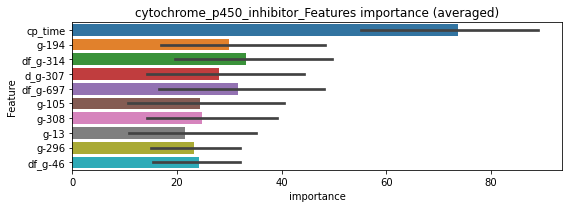

len(train_index) : 2384
len(valid_index) : 2384
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360811	valid_1's binary_logloss: 0.115351
[200]	training's binary_logloss: 0.0077181	valid_1's binary_logloss: 0.0980005


len(train_index) : 2384
len(valid_index) : 2384


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00623551	valid_1's binary_logloss: 0.0967731


================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339339	valid_1's binary_logloss: 0.118174
[200]	training's binary_logloss: 0.00734326	valid_1's binary_logloss: 0.0983324


cytochrome_p450_inhibitor logloss: 0.09747977055375512


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00716479	valid_1's binary_logloss: 0.0981864


dihydrofolate_reductase_inhibitor , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954908	valid_1's binary_logloss: 0.187845
[200]	training's binary_logloss: 0.02068	valid_1's binary_logloss: 0.0841252
[300]	training's binary_logloss: 0.00680233	valid_1's binary_logloss: 0.0555805
[400]	training's binary_logloss: 0.00340764	valid_1's binary_logloss: 0.0456966
[500]	training's binary_logloss: 0.00227642	valid_1's binary_logloss: 0.0405231
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00191136	valid_1's binary_logloss: 0.0386108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988684	valid_1's binary_logloss: 0.17808
[200]	training's binary_logloss: 0.0220602	valid_1's binary_logloss: 0.0692127
[300]	training's binary_logloss: 0.00717079	valid_1's binary_logloss: 0.0365574
[400]	training's binary_logloss: 0.0036204	valid_1's binary_logloss: 0.0257128
[500]	training's binary_logloss: 0.00241395	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.4378338252927246
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00782
p_label_rate: 0.00151 Vs.target_rate: 0.00161, Num_p_label: 6.0, conf_0:0.00782, conf_1:0.43783
threshold:0.44, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991705	valid_1's binary_logloss: 0.187753
[200]	training's binary_logloss: 0.021728	valid_1's binary_logloss: 0.0756678
[300]	training's binary_logloss: 0.00702003	valid_1's binary_logloss: 0.0425789
[400]	training's binary_logloss: 0.00352508	valid_1's binary_logloss: 0.0309242
[500]	training's binary_logloss: 0.00233172	valid_1's binary_logloss: 0.025904
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00190447	valid_1's binary_logloss: 0.0226263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096723	valid_1's binary_logloss: 0.197955
[200]	training's binary_logloss: 0.0214012	valid_1's binary_logloss: 0.0916354
[300]	training's binary_logloss: 0.00693595	valid_1's binary_logloss: 0.0559936
[400]	training's binary_logloss: 0.00346749	valid_1's binary_logloss: 0.0428305
[500]	training's binary_logloss: 0.00230645	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.4378338252927246
Remove_noisy_labels: 4 → positive_corect_labels: 495.0/992
30th percentile: 0.00764
p_label_rate: 0.00126 Vs.target_rate: 0.00161, Num_p_label: 5.0, conf_0:0.00764, conf_1:0.43783
threshold:0.44, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:495.0/992, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966802	valid_1's binary_logloss: 0.177129
[200]	training's binary_logloss: 0.0213737	valid_1's binary_logloss: 0.0754334
[300]	training's binary_logloss: 0.00686809	valid_1's binary_logloss: 0.0420991
[400]	training's binary_logloss: 0.00344453	valid_1's binary_logloss: 0.0309996
[500]	training's binary_logloss: 0.00229047	valid_1's binary_logloss: 0.0259604
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00186961	valid_1's binary_logloss: 0.0232833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955616	valid_1's binary_logloss: 0.185362
[200]	training's binary_logloss: 0.0203628	valid_1's binary_logloss: 0.0812303
[300]	training's binary_logloss: 0.00677716	valid_1's binary_logloss: 0.0492109
[400]	training's binary_logloss: 0.00342125	valid_1's binary_logloss: 0.037075
[500]	training's binary_logloss: 0.00227293	valid_

3 / 3 AUC score:1.000
Threshold: 0.4378338252927246
Remove_noisy_labels: 2 → positive_corect_labels: 494.0/990
30th percentile: 0.00767
p_label_rate: 0.00100 Vs.target_rate: 0.00161, Num_p_label: 4.0, conf_0:0.00767, conf_1:0.43783
threshold:0.44, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/4972, y_label_rate: 0.10016


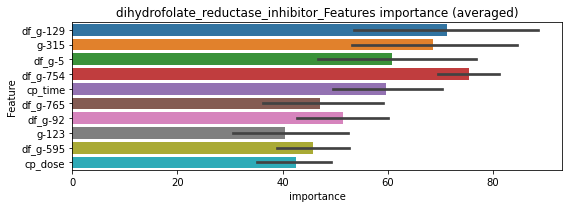

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254833	valid_1's binary_logloss: 0.0529969
[200]	training's binary_logloss: 0.00394272	valid_1's binary_logloss: 0.0227459
[300]	training's binary_logloss: 0.00111631	valid_1's binary_logloss: 0.0163771
[400]	training's binary_logloss: 0.000551382	valid_1's binary_logloss: 0.0152012
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000576146	valid_1's binary_logloss: 0.0151671


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255946	valid_1's binary_logloss: 0.0515131
[200]	training's binary_logloss: 0.00400256	valid_1's binary_logloss: 0.0237318


dihydrofolate_reductase_inhibitor logloss: 0.017151855030303045


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00125988	valid_1's binary_logloss: 0.0191367


dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746434	valid_1's binary_logloss: 0.125059
[200]	training's binary_logloss: 0.0137604	valid_1's binary_logloss: 0.0410837
[300]	training's binary_logloss: 0.00433795	valid_1's binary_logloss: 0.0215377
[400]	training's binary_logloss: 0.00231516	valid_1's binary_logloss: 0.0154839
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00184269	valid_1's binary_logloss: 0.0138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762673	valid_1's binary_logloss: 0.131826
[200]	training's binary_logloss: 0.0142194	valid_1's binary_logloss: 0.0439625
[300]	training's binary_logloss: 0.00458798	valid_1's binary_logloss: 0.0226177
[400]	training's binary_logloss: 0.00240131	valid_1's binary_logloss: 0.0161938
[500]	training's binary_logloss: 0.00166485	valid_1's binary_logloss: 0.01324
Early stopping, best iteration is:
[584]	training's bi

1 / 3 AUC score:1.000
Threshold: 0.45404532843962087
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00375
p_label_rate: 0.00126 Vs.target_rate: 0.00113, Num_p_label: 5.0, conf_0:0.00375, conf_1:0.45405
threshold:0.45, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746434	valid_1's binary_logloss: 0.125059
[200]	training's binary_logloss: 0.0137604	valid_1's binary_logloss: 0.0410837
[300]	training's binary_logloss: 0.00433795	valid_1's binary_logloss: 0.0215377
[400]	training's binary_logloss: 0.00231516	valid_1's binary_logloss: 0.0154839
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00184269	valid_1's binary_logloss: 0.0138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762673	valid_1's binary_logloss: 0.131826
[200]	training's binary_logloss: 0.0142194	valid_1's binary_logloss: 0.0439625
[300]	training's binary_logloss: 0.00458798	valid_1's binary_logloss: 0.0226177
[400]	training's binary_logloss: 0.00240131	valid_1's binary_logloss: 0.0161938
[500]	training's binary_logloss: 0.00166485	valid_1's binary_logloss: 0.01324
Early stopping, best iteration is:
[584]	training's bi

2 / 3 AUC score:1.000
Threshold: 0.45404532843962087
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00375
p_label_rate: 0.00126 Vs.target_rate: 0.00113, Num_p_label: 5.0, conf_0:0.00375, conf_1:0.45405
threshold:0.45, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746434	valid_1's binary_logloss: 0.125059
[200]	training's binary_logloss: 0.0137604	valid_1's binary_logloss: 0.0410837
[300]	training's binary_logloss: 0.00433795	valid_1's binary_logloss: 0.0215377
[400]	training's binary_logloss: 0.00231516	valid_1's binary_logloss: 0.0154839
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00184269	valid_1's binary_logloss: 0.0138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762673	valid_1's binary_logloss: 0.131826
[200]	training's binary_logloss: 0.0142194	valid_1's binary_logloss: 0.0439625
[300]	training's binary_logloss: 0.00458798	valid_1's binary_logloss: 0.0226177
[400]	training's binary_logloss: 0.00240131	valid_1's binary_logloss: 0.0161938
[500]	training's binary_logloss: 0.00166485	valid_1's binary_logloss: 0.01324
Early stopping, best iteration is:
[584]	training's bi

3 / 3 AUC score:1.000
Threshold: 0.45404532843962087
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00375
p_label_rate: 0.00126 Vs.target_rate: 0.00113, Num_p_label: 5.0, conf_0:0.00375, conf_1:0.45405
threshold:0.45, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:505.0/4982, y_label_rate: 0.10136


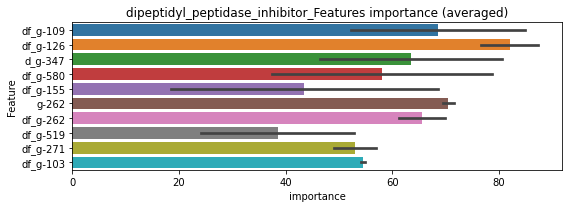

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021917	valid_1's binary_logloss: 0.0397963
[200]	training's binary_logloss: 0.00300759	valid_1's binary_logloss: 0.0133388
[300]	training's binary_logloss: 0.000814504	valid_1's binary_logloss: 0.00839648
[400]	training's binary_logloss: 0.000413132	valid_1's binary_logloss: 0.00726069
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000364125	valid_1's binary_logloss: 0.00705284


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206349	valid_1's binary_logloss: 0.0367492
[200]	training's binary_logloss: 0.00286037	valid_1's binary_logloss: 0.0139694
[300]	training's binary_logloss: 0.000789353	valid_1's binary_logloss: 0.0102771
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000447957	valid_1's binary_logloss: 0.00962152


dipeptidyl_peptidase_inhibitor logloss: 0.008337182126938675
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374815	valid_1's binary_logloss: 0.0553353
[200]	training's binary_logloss: 0.00455809	valid_1's binary_logloss: 0.0131889
[300]	training's binary_logloss: 0.00147492	valid_1's binary_logloss: 0.00619362
[400]	training's binary_logloss: 0.000938814	valid_1's binary_logloss: 0.0045592
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000865423	valid_1's binary_logloss: 0.00425341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396892	valid_1's binary_logloss: 0.0489135
[200]	training's binary_logloss: 0.00474049	valid_1's binary_logloss: 0.00808421
[300]	training's binary_logloss: 0.00150793	valid_1's binary_logloss: 0.00337679
[400]	training's binary_logloss: 0.000954447	valid_1's binary_logloss: 0.00236802
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000877589	valid_1's binary_logloss: 0.00219947


1 / 3 AUC score:1.000
Threshold: 0.6252077457917028
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00066
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00066, conf_1:0.62521
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.63
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.59
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.55
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.51
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_5: 0.47
threshold:0.47, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374815	valid_1's binary_logloss: 0.0553353
[200]	training's binary_logloss: 0.00455809	valid_1's binary_logloss: 0.0131889
[300]	training's binary_logloss: 0.00147492	valid_1's binary_logloss: 0.00619362
[400]	training's binary_logloss: 0.000938814	valid_1's binary_logloss: 0.0045592
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000865423	valid_1's binary_logloss: 0.00425341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396892	valid_1's binary_logloss: 0.0489135
[200]	training's binary_logloss: 0.00474049	valid_1's binary_logloss: 0.00808421
[300]	training's binary_logloss: 0.00150793	valid_1's binary_logloss: 0.00337679
[400]	training's binary_logloss: 0.000954447	valid_1's binary_logloss: 0.00236802
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000877589	valid_1's binary_logloss: 0.00219947


2 / 3 AUC score:1.000
Threshold: 0.4652077457917027
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00066
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00066, conf_1:0.46521
threshold:0.47, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374815	valid_1's binary_logloss: 0.0553353
[200]	training's binary_logloss: 0.00455809	valid_1's binary_logloss: 0.0131889
[300]	training's binary_logloss: 0.00147492	valid_1's binary_logloss: 0.00619362
[400]	training's binary_logloss: 0.000938814	valid_1's binary_logloss: 0.0045592
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000865423	valid_1's binary_logloss: 0.00425341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396892	valid_1's binary_logloss: 0.0489135
[200]	training's binary_logloss: 0.00474049	valid_1's binary_logloss: 0.00808421
[300]	training's binary_logloss: 0.00150793	valid_1's binary_logloss: 0.00337679
[400]	training's binary_logloss: 0.000954447	valid_1's binary_logloss: 0.00236802
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000877589	valid_1's binary_logloss: 0.00219947


3 / 3 AUC score:1.000
Threshold: 0.4652077457917027
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00066
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00066, conf_1:0.46521
threshold:0.47, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


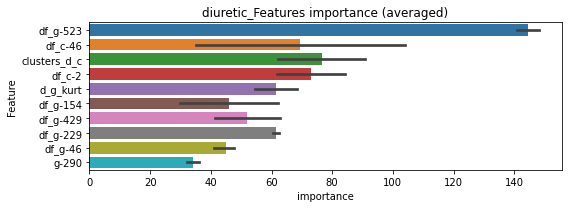

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106182	valid_1's binary_logloss: 0.0137999
[200]	training's binary_logloss: 0.000949467	valid_1's binary_logloss: 0.0031916


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 diuretic=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000309172	valid_1's binary_logloss: 0.00246748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010612	valid_1's binary_logloss: 0.0122238
[200]	training's binary_logloss: 0.000966713	valid_1's binary_logloss: 0.00171693
[300]	training's binary_logloss: 0.000278517	valid_1's binary_logloss: 0.000600731
[400]	training's binary_logloss: 0.000173223	valid_1's binary_logloss: 0.000406725


diuretic logloss: 0.0014304807764945944
dna_alkylating_agent , len(trt) : 48


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00016557	valid_1's binary_logloss: 0.000393486


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118043	valid_1's binary_logloss: 0.257577
[200]	training's binary_logloss: 0.0287737	valid_1's binary_logloss: 0.161847
[300]	training's binary_logloss: 0.00950451	valid_1's binary_logloss: 0.1265
[400]	training's binary_logloss: 0.00463621	valid_1's binary_logloss: 0.116876
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00319716	valid_1's binary_logloss: 0.113234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107645	valid_1's binary_logloss: 0.233289
[200]	training's binary_logloss: 0.0256146	valid_1's binary_logloss: 0.141336
[300]	training's binary_logloss: 0.00868441	valid_1's binary_logloss: 0.108875
[400]	training's binary_logloss: 0.00442644	valid_1's binary_logloss: 0.0988297
[500]	training's binary_logloss: 0.00288145	valid_1's binary_logloss: 0.0919183
[600]	training's binary_logloss: 0.00224025	valid_1's binar

1 / 3 AUC score:0.986
Threshold: 0.35625077776645375
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.01428
p_label_rate: 0.01959 Vs.target_rate: 0.00212, Num_p_label: 78.0, conf_0:0.01428, conf_1:0.41485
Num_p_label: 78.0, Expected: 8.4, Adj_threshold_1: 0.36
Num_p_label: 55.0, Expected: 8.4, Adj_threshold_2: 0.40
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_3: 0.44
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_4: 0.48
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_5: 0.52
threshold:0.52, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111972	valid_1's binary_logloss: 0.215458
[200]	training's binary_logloss: 0.0266202	valid_1's binary_logloss: 0.106315
[300]	training's binary_logloss: 0.00899143	valid_1's binary_logloss: 0.0666746
[400]	training's binary_logloss: 0.00446127	valid_1's binary_logloss: 0.0519736
[500]	training's binary_logloss: 0.00292006	valid_1's binary_logloss: 0.0449166
[600]	training's binary_logloss: 0.00224949	valid_1's binary_logloss: 0.0406096
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00208073	valid_1's binary_logloss: 0.0393758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109576	valid_1's binary_logloss: 0.218863
[200]	training's binary_logloss: 0.0259816	valid_1's binary_logloss: 0.118272
[300]	training's binary_logloss: 0.00874105	valid_1's binary_logloss: 0.0815243
[400]	training's binary_logloss: 0.00436418	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.5162507777664537
Remove_noisy_labels: 11 → positive_corect_labels: 483.0/961
30th percentile: 0.01101
p_label_rate: 0.01457 Vs.target_rate: 0.00212, Num_p_label: 58.0, conf_0:0.01101, conf_1:0.54196
Num_p_label: 58.0, Expected: 8.4, Adj_threshold_1: 0.52
Num_p_label: 43.0, Expected: 8.4, Adj_threshold_2: 0.56
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_3: 0.60
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_4: 0.64
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_5: 0.68
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_6: 0.72
Num_p_label: 12.0, Expected: 8.4, Adj_threshold_7: 0.76
threshold:0.76, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:483.0/961, y_label_rate: 0.50260
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106367	valid_1's binary_logloss: 0.202861
[200]	training's binary_logloss: 0.0254255	valid_1's binary_logloss: 0.0994818
[300]	training's binary_logloss: 0.00865464	valid_1's binary_logloss: 0.0646452
[400]	training's binary_logloss: 0.00438651	valid_1's binary_logloss: 0.0481284
[500]	training's binary_logloss: 0.00287764	valid_1's binary_logloss: 0.0405209
[600]	training's binary_logloss: 0.00224549	valid_1's binary_logloss: 0.0366932
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00218499	valid_1's binary_logloss: 0.0361514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106162	valid_1's binary_logloss: 0.220411
[200]	training's binary_logloss: 0.0247938	valid_1's binary_logloss: 0.114519
[300]	training's binary_logloss: 0.00855021	valid_1's binary_logloss: 0.0777611
[400]	training's binary_logloss: 0.00427051	valid_1'

3 / 3 AUC score:0.999
Threshold: 0.7562507777664539
Remove_noisy_labels: 9 → positive_corect_labels: 474.0/952
30th percentile: 0.01125
p_label_rate: 0.00427 Vs.target_rate: 0.00212, Num_p_label: 17.0, conf_0:0.01125, conf_1:0.75625
threshold:0.76, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:491.0/4934, y_label_rate: 0.09951


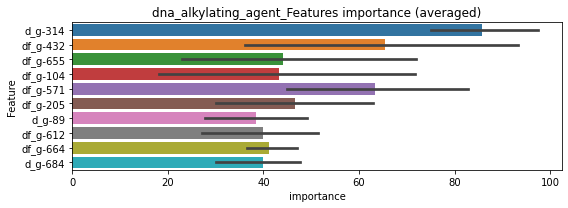

len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337134	valid_1's binary_logloss: 0.0779078
[200]	training's binary_logloss: 0.00686956	valid_1's binary_logloss: 0.0480212
[300]	training's binary_logloss: 0.00180583	valid_1's binary_logloss: 0.040146
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00178853	valid_1's binary_logloss: 0.0400487


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385731	valid_1's binary_logloss: 0.0724712
[200]	training's binary_logloss: 0.00750106	valid_1's binary_logloss: 0.039872
[300]	training's binary_logloss: 0.00194764	valid_1's binary_logloss: 0.0337929
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00172415	valid_1's binary_logloss: 0.0331917


dna_alkylating_agent logloss: 0.03662023840395197
dna_inhibitor , len(trt) : 402


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.415977	valid_1's binary_logloss: 0.678053
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.596
Threshold: 0.5058753770487461
Remove_noisy_labels: 432 → positive_corect_labels: 284/568
30th percentile: 0.46251
p_label_rate: 0.43847 Vs.target_rate: 0.01178, Num_p_label: 1746.0, conf_0:0.46251, conf_1:0.50588
Num_p_label: 1746.0, Expected: 46.9, Adj_threshold_1: 0.51
Num_p_label: 793.0, Expected: 46.9, Adj_threshold_2: 0.55
Num_p_label: 247.0, Expected: 46.9, Adj_threshold_3: 0.59
Num_p_label: 56.0, Expected: 46.9, Adj_threshold_4: 0.63
threshold:0.63, positive p_label:56.0/3982, p_label_rate: 0.01406


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.341275	valid_1's binary_logloss: 0.677965


positive y_label:284.0/568, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213164	valid_1's binary_logloss: 0.576988
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.149645	valid_1's binary_logloss: 0.562227
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.761
Threshold: 0.6258753770487462
Remove_noisy_labels: 177 → positive_corect_labels: 140.0/391
30th percentile: 0.41083
p_label_rate: 0.17579 Vs.target_rate: 0.01178, Num_p_label: 700.0, conf_0:0.41083, conf_1:0.62588
Num_p_label: 700.0, Expected: 46.9, Adj_threshold_1: 0.63
Num_p_label: 410.0, Expected: 46.9, Adj_threshold_2: 0.67
Num_p_label: 212.0, Expected: 46.9, Adj_threshold_3: 0.71
Num_p_label: 81.0, Expected: 46.9, Adj_threshold_4: 0.75
Num_p_label: 24.0, Expected: 46.9, Adj_threshold_5: 0.79
threshold:0.79, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[70]	training's binary_logloss: 0.28389	valid_1's binary_logloss: 0.605472


positive y_label:140.0/391, y_label_rate: 0.35806
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165411	valid_1's binary_logloss: 0.408317
[200]	training's binary_logloss: 0.0565034	valid_1's binary_logloss: 0.349895
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0257086	valid_1's binary_logloss: 0.325645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158733	valid_1's binary_logloss: 0.437395


3 / 3 AUC score:0.907
Threshold: 0.7858753770487463
Remove_noisy_labels: 78 → positive_corect_labels: 63.0/313
30th percentile: 0.10495
p_label_rate: 0.03265 Vs.target_rate: 0.01178, Num_p_label: 130.0, conf_0:0.10495, conf_1:0.78588


[200]	training's binary_logloss: 0.0539217	valid_1's binary_logloss: 0.40567
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0452129	valid_1's binary_logloss: 0.397641


threshold:0.79, positive p_label:130.0/3982, p_label_rate: 0.03265
positive y_label:193.0/4295, y_label_rate: 0.04494


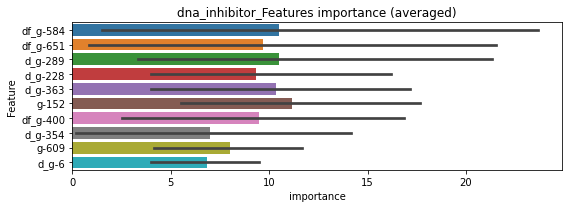

len(train_index) : 2147
len(valid_index) : 2148
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2148
len(valid_index) : 2147
================================= fold 2/2 dna_inhibitor=================================


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.0211603	valid_1's binary_logloss: 0.130984
Training until validation scores don't improve for 10 rounds


dna_inhibitor logloss: 0.1295685288380736
dopamine_receptor_agonist , len(trt) : 121


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.0228558	valid_1's binary_logloss: 0.128152
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158682	valid_1's binary_logloss: 0.411173
[200]	training's binary_logloss: 0.0495505	valid_1's binary_logloss: 0.327086
[300]	training's binary_logloss: 0.0188619	valid_1's binary_logloss: 0.28505
[400]	training's binary_logloss: 0.00914631	valid_1's binary_logloss: 0.264717
[500]	training's binary_logloss: 0.00552613	valid_1's binary_logloss: 0.250522
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00500512	valid_1's binary_logloss: 0.247574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16489	valid_1's binary_logloss: 0.398697
[200]	training's binary_logloss: 0.0523921	valid_1's binary_logloss: 0.307092
[300]	training's binary_logloss: 0.0200247	valid_1's binary_logloss: 0.267212
[400]	training's binary_logloss: 0.00965648	valid_1's binary_logloss: 0.24883


1 / 3 AUC score:0.958
Threshold: 0.4678425812568007


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00680985	valid_1's binary_logloss: 0.241304


Remove_noisy_labels: 100 → positive_corect_labels: 450/900
30th percentile: 0.10230
p_label_rate: 0.07735 Vs.target_rate: 0.00497, Num_p_label: 308.0, conf_0:0.07291, conf_1:0.56629
Num_p_label: 308.0, Expected: 19.8, Adj_threshold_1: 0.47
Num_p_label: 216.0, Expected: 19.8, Adj_threshold_2: 0.51
Num_p_label: 152.0, Expected: 19.8, Adj_threshold_3: 0.55
Num_p_label: 103.0, Expected: 19.8, Adj_threshold_4: 0.59
Num_p_label: 69.0, Expected: 19.8, Adj_threshold_5: 0.63
Num_p_label: 44.0, Expected: 19.8, Adj_threshold_6: 0.67
Num_p_label: 31.0, Expected: 19.8, Adj_threshold_7: 0.71
Num_p_label: 19.0, Expected: 19.8, Adj_threshold_8: 0.75
threshold:0.75, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:450.0/900, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155984	valid_1's binary_logloss: 0.365689
[200]	training's binary_logloss: 0.0472044	valid_1's binary_logloss: 0.263377
[300]	training's binary_logloss: 0.0177079	valid_1's binary_logloss: 0.219641
[400]	training's binary_logloss: 0.00861006	valid_1's binary_logloss: 0.19988
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00743577	valid_1's binary_logloss: 0.195763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156346	valid_1's binary_logloss: 0.363109
[200]	training's binary_logloss: 0.0469255	valid_1's binary_logloss: 0.254699
[300]	training's binary_logloss: 0.017607	valid_1's binary_logloss: 0.210952
[400]	training's binary_logloss: 0.00864448	valid_1's binary_logloss: 0.18906
[500]	training's binary_logloss: 0.00525063	valid_1's binary_logloss: 0.180516
[600]	training's binary_logloss: 0.00373945	valid_1's binary_log

2 / 3 AUC score:0.978
Threshold: 0.7478425812568009
Remove_noisy_labels: 65 → positive_corect_labels: 387.0/835
30th percentile: 0.08785
p_label_rate: 0.01130 Vs.target_rate: 0.00497, Num_p_label: 45.0, conf_0:0.04045, conf_1:0.74784
threshold:0.75, positive p_label:45.0/3982, p_label_rate: 0.01130
positive y_label:387.0/835, y_label_rate: 0.46347
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147644	valid_1's binary_logloss: 0.334406
[200]	training's binary_logloss: 0.0430679	valid_1's binary_logloss: 0.238724
[300]	training's binary_logloss: 0.0155672	valid_1's binary_logloss: 0.196541
[400]	training's binary_logloss: 0.00765257	valid_1's binary_logloss: 0.178529
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00678893	valid_1's binary_logloss: 0.176667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14499	valid_1's binary_logloss: 0.328297
[200]	training's binary_logloss: 0.0436488	valid_1's binary_logloss: 0.226238
[300]	training's binary_logloss: 0.0158187	valid_1's binary_logloss: 0.183733
[400]	training's binary_logloss: 0.00766523	valid_1's binary_logloss: 0.165279


3 / 3 AUC score:0.982
Threshold: 0.7478425812568009
Remove_noisy_labels: 60 → positive_corect_labels: 329.0/775
30th percentile: 0.05140
p_label_rate: 0.00804 Vs.target_rate: 0.00497, Num_p_label: 32.0, conf_0:0.03878, conf_1:0.74784


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00561402	valid_1's binary_logloss: 0.159864


threshold:0.75, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:361.0/4757, y_label_rate: 0.07589


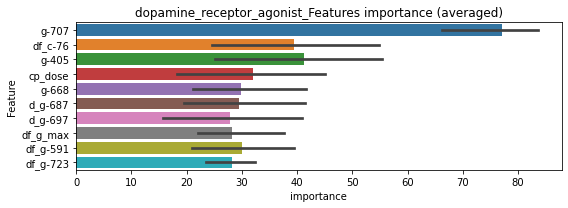

len(train_index) : 2378
len(valid_index) : 2379
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032072	valid_1's binary_logloss: 0.109274
[200]	training's binary_logloss: 0.00669642	valid_1's binary_logloss: 0.0910548
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00452284	valid_1's binary_logloss: 0.0895406


len(train_index) : 2379
len(valid_index) : 2378
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292015	valid_1's binary_logloss: 0.116441


dopamine_receptor_agonist logloss: 0.09928888185164216


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0113394	valid_1's binary_logloss: 0.109041
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.551755	valid_1's binary_logloss: 0.689401
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.559
Threshold: 0.5021467729935631
Remove_noisy_labels: 460 → positive_corect_labels: 270/540
30th percentile: 0.48290
p_label_rate: 0.46057 Vs.target_rate: 0.01204, Num_p_label: 1834.0, conf_0:0.48290, conf_1:0.50215
Num_p_label: 1834.0, Expected: 47.9, Adj_threshold_1: 0.50
Num_p_label: 280.0, Expected: 47.9, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 47.9, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[17]	training's binary_logloss: 0.558713	valid_1's binary_logloss: 0.686317


positive y_label:270.0/540, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.301377	valid_1's binary_logloss: 0.638851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221557	valid_1's binary_logloss: 0.614293


2 / 3 AUC score:0.714
Threshold: 0.5821467729935632
Remove_noisy_labels: 193 → positive_corect_labels: 132.0/347
30th percentile: 0.41461
p_label_rate: 0.19764 Vs.target_rate: 0.01204, Num_p_label: 787.0, conf_0:0.41461, conf_1:0.58215
Num_p_label: 787.0, Expected: 47.9, Adj_threshold_1: 0.58
Num_p_label: 444.0, Expected: 47.9, Adj_threshold_2: 0.62
Num_p_label: 210.0, Expected: 47.9, Adj_threshold_3: 0.66
Num_p_label: 77.0, Expected: 47.9, Adj_threshold_4: 0.70
Num_p_label: 21.0, Expected: 47.9, Adj_threshold_5: 0.74
threshold:0.74, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.132414	valid_1's binary_logloss: 0.585346


positive y_label:132.0/347, y_label_rate: 0.38040
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188086	valid_1's binary_logloss: 0.513861
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.125521	valid_1's binary_logloss: 0.490997
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.809
Threshold: 0.7421467729935634
Remove_noisy_labels: 102 → positive_corect_labels: 32.0/245
30th percentile: 0.24626
p_label_rate: 0.00301 Vs.target_rate: 0.01204, Num_p_label: 12.0, conf_0:0.24626, conf_1:0.74215
Num_p_label: 12.0, Expected: 47.9, Adj_threshold_1: 0.74
Num_p_label: 36.0, Expected: 47.9, Adj_threshold_2: 0.70
threshold:0.70, positive p_label:36.0/3982, p_label_rate: 0.00904


[100]	training's binary_logloss: 0.205695	valid_1's binary_logloss: 0.540904
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.167985	valid_1's binary_logloss: 0.528572


positive y_label:68.0/4227, y_label_rate: 0.01609


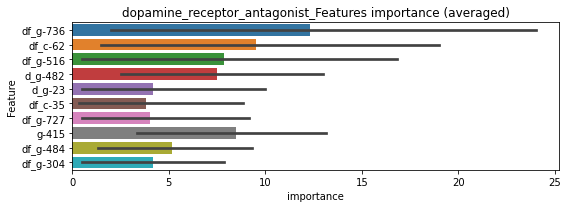

len(train_index) : 2113
len(valid_index) : 2114
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2114
len(valid_index) : 2113
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0131855	valid_1's binary_logloss: 0.0670227
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.06649360125321561
egfr_inhibitor , len(trt) : 336


Early stopping, best iteration is:
[56]	training's binary_logloss: 0.0133372	valid_1's binary_logloss: 0.0659643
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217994	valid_1's binary_logloss: 0.641981
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.200292	valid_1's binary_logloss: 0.64024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222373	valid_1's binary_logloss: 0.616716


1 / 3 AUC score:0.692
Threshold: 0.5120713777012422
Remove_noisy_labels: 356 → positive_corect_labels: 322/644
30th percentile: 0.41064
p_label_rate: 0.30537 Vs.target_rate: 0.01078, Num_p_label: 1216.0, conf_0:0.41064, conf_1:0.51207
Num_p_label: 1216.0, Expected: 42.9, Adj_threshold_1: 0.51
Num_p_label: 707.0, Expected: 42.9, Adj_threshold_2: 0.55
Num_p_label: 375.0, Expected: 42.9, Adj_threshold_3: 0.59
Num_p_label: 183.0, Expected: 42.9, Adj_threshold_4: 0.63


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.154681	valid_1's binary_logloss: 0.609249


Num_p_label: 88.0, Expected: 42.9, Adj_threshold_5: 0.67
Num_p_label: 44.0, Expected: 42.9, Adj_threshold_6: 0.71
threshold:0.71, positive p_label:44.0/3982, p_label_rate: 0.01105
positive y_label:322.0/644, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196481	valid_1's binary_logloss: 0.548765
[200]	training's binary_logloss: 0.071594	valid_1's binary_logloss: 0.500618
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0450926	valid_1's binary_logloss: 0.482374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19717	valid_1's binary_logloss: 0.573381


2 / 3 AUC score:0.820
Threshold: 0.7120713777012424
Remove_noisy_labels: 177 → positive_corect_labels: 161.0/467
30th percentile: 0.32431
p_label_rate: 0.05600 Vs.target_rate: 0.01078, Num_p_label: 223.0, conf_0:0.32431, conf_1:0.71207
Num_p_label: 223.0, Expected: 42.9, Adj_threshold_1: 0.71
Num_p_label: 150.0, Expected: 42.9, Adj_threshold_2: 0.75
Num_p_label: 89.0, Expected: 42.9, Adj_threshold_3: 0.79
Num_p_label: 49.0, Expected: 42.9, Adj_threshold_4: 0.83
threshold:0.83, positive p_label:49.0/3982, p_label_rate: 0.01231


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0831392	valid_1's binary_logloss: 0.548212


positive y_label:161.0/467, y_label_rate: 0.34475
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154025	valid_1's binary_logloss: 0.450452
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0702226	valid_1's binary_logloss: 0.407892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164639	valid_1's binary_logloss: 0.402473
[200]	training's binary_logloss: 0.0555936	valid_1's binary_logloss: 0.335032
[300]	training's binary_logloss: 0.0230232	valid_1's binary_logloss: 0.313394
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0208856	valid_1's binary_logloss: 0.311616


3 / 3 AUC score:0.904
Threshold: 0.8320713777012425
Remove_noisy_labels: 107 → positive_corect_labels: 55.0/360
30th percentile: 0.10771
p_label_rate: 0.01130 Vs.target_rate: 0.01078, Num_p_label: 45.0, conf_0:0.10771, conf_1:0.83207
threshold:0.83, positive p_label:45.0/3982, p_label_rate: 0.01130
positive y_label:100.0/4342, y_label_rate: 0.02303


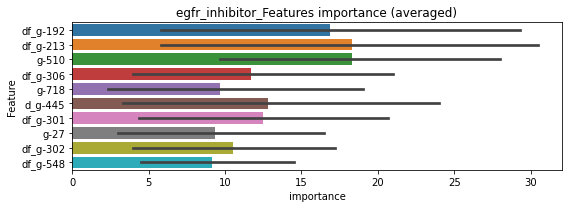

len(train_index) : 2171
len(valid_index) : 2171
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2171
len(valid_index) : 2171
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.0139431	valid_1's binary_logloss: 0.0642748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00731123	valid_1's binary_logloss: 0.0419524


egfr_inhibitor logloss: 0.0527943445933701
elastase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.00505198	valid_1's binary_logloss: 0.0413139
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                   

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503482	valid_1's binary_logloss: 0.0762121
[200]	training's binary_logloss: 0.00728486	valid_1's binary_logloss: 0.0201371
[300]	training's binary_logloss: 0.00240983	valid_1's binary_logloss: 0.00914528
[400]	training's binary_logloss: 0.00138715	valid_1's binary_logloss: 0.00609442
[500]	training's binary_logloss: 0.00113404	valid_1's binary_logloss: 0.00514539
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00110677	valid_1's binary_logloss: 0.00501626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524927	valid_1's binary_logloss: 0.0816692
[200]	training's binary_logloss: 0.00740243	valid_1's binary_logloss: 0.0214246
[300]	training's binary_logloss: 0.00237403	valid_1's binary_logloss: 0.0108612
[400]	training's binary_logloss: 0.00136292	valid_1's binary_logloss: 0.00798781
[500]	training's binary_logloss: 0.00111

1 / 3 AUC score:1.000
Threshold: 0.6577247044688939
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00100
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00100, conf_1:0.65772
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.62


Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00109104	valid_1's binary_logloss: 0.00678654


Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.54
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_5: 0.50
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_6: 0.46
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_7: 0.42
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_8: 0.38
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_9: 0.34
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503482	valid_1's binary_logloss: 0.0762121
[200]	training's binary_logloss: 0.00728486	valid_1's binary_logloss: 0.0201371
[300]	training's binary_logloss: 0.00240983	valid_1's binary_logloss: 0.00914528
[400]	training's binary_logloss: 0.00138715	valid_1's binary_logloss: 0.00609442
[500]	training's binary_logloss: 0.00113404	valid_1's binary_logloss: 0.00514539
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00110677	valid_1's binary_logloss: 0.00501626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524927	valid_1's binary_logloss: 0.0816692
[200]	training's binary_logloss: 0.00740243	valid_1's binary_logloss: 0.0214246
[300]	training's binary_logloss: 0.00237403	valid_1's binary_logloss: 0.0108612
[400]	training's binary_logloss: 0.00136292	valid_1's binary_logloss: 0.00798781
[500]	training's binary_logloss: 0.00111

2 / 3 AUC score:1.000
Threshold: 0.2977247044688939
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00100
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00100, conf_1:0.31027


Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00109104	valid_1's binary_logloss: 0.00678654


threshold:0.30, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507394	valid_1's binary_logloss: 0.0736963
[200]	training's binary_logloss: 0.00734636	valid_1's binary_logloss: 0.0175622
[300]	training's binary_logloss: 0.0023992	valid_1's binary_logloss: 0.00750567
[400]	training's binary_logloss: 0.00138101	valid_1's binary_logloss: 0.00508825
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00116925	valid_1's binary_logloss: 0.00448912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051116	valid_1's binary_logloss: 0.0888798
[200]	training's binary_logloss: 0.00709192	valid_1's binary_logloss: 0.0268892
[300]	training's binary_logloss: 0.0023263	valid_1's binary_logloss: 0.0148399
[400]	training's binary_logloss: 0.00134369	valid_1's binary_logloss: 0.0109867
[500]	training's binary_logloss: 0.00111995	valid_1's binary_logloss: 0.00981524
Early stopping, best iteration is:
[564]	tra

3 / 3 AUC score:1.000
Threshold: 0.2977247044688939
Remove_noisy_labels: 3 → positive_corect_labels: 500.0/996
30th percentile: 0.00106
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00106, conf_1:0.34083
threshold:0.30, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:505.0/4978, y_label_rate: 0.10145


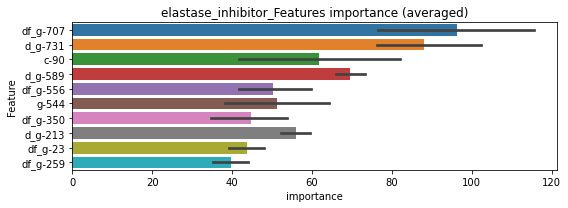

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127101	valid_1's binary_logloss: 0.0210778
[200]	training's binary_logloss: 0.00138819	valid_1's binary_logloss: 0.00729418
[300]	training's binary_logloss: 0.000417127	valid_1's binary_logloss: 0.00596629


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 elastase_inhibitor=================================


Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000389391	valid_1's binary_logloss: 0.0059272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130746	valid_1's binary_logloss: 0.0234274
[200]	training's binary_logloss: 0.00143969	valid_1's binary_logloss: 0.00997273


elastase_inhibitor logloss: 0.0071384439767072936
erbb2_inhibitor , len(trt) : 20


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000590735	valid_1's binary_logloss: 0.00834969


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670926	valid_1's binary_logloss: 0.106012
[200]	training's binary_logloss: 0.0116638	valid_1's binary_logloss: 0.0283662
[300]	training's binary_logloss: 0.00374428	valid_1's binary_logloss: 0.0130659
[400]	training's binary_logloss: 0.00200689	valid_1's binary_logloss: 0.00881158
[500]	training's binary_logloss: 0.00147051	valid_1's binary_logloss: 0.00716606
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00135609	valid_1's binary_logloss: 0.00676373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659884	valid_1's binary_logloss: 0.111112
[200]	training's binary_logloss: 0.0111083	valid_1's binary_logloss: 0.0342268
[300]	training's binary_logloss: 0.00355899	valid_1's binary_logloss: 0.0179397
[400]	training's binary_logloss: 0.00191979	valid_1's binary_logloss: 0.0130788
[500]	training's binary_logloss: 0.00141405	va

1 / 3 AUC score:1.000
Threshold: 0.46379246626271253
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00223
p_label_rate: 0.00025 Vs.target_rate: 0.00091, Num_p_label: 1.0, conf_0:0.00223, conf_1:0.46379
Num_p_label: 1.0, Expected: 3.6, Adj_threshold_1: 0.46
Num_p_label: 1.0, Expected: 3.6, Adj_threshold_2: 0.42
Num_p_label: 3.0, Expected: 3.6, Adj_threshold_3: 0.38
threshold:0.38, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670926	valid_1's binary_logloss: 0.106012
[200]	training's binary_logloss: 0.0116638	valid_1's binary_logloss: 0.0283662
[300]	training's binary_logloss: 0.00374428	valid_1's binary_logloss: 0.0130659
[400]	training's binary_logloss: 0.00200689	valid_1's binary_logloss: 0.00881158
[500]	training's binary_logloss: 0.00147051	valid_1's binary_logloss: 0.00716606
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00135609	valid_1's binary_logloss: 0.00676373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659884	valid_1's binary_logloss: 0.111112
[200]	training's binary_logloss: 0.0111083	valid_1's binary_logloss: 0.0342268
[300]	training's binary_logloss: 0.00355899	valid_1's binary_logloss: 0.0179397
[400]	training's binary_logloss: 0.00191979	valid_1's binary_logloss: 0.0130788
[500]	training's binary_logloss: 0.00141405	va

2 / 3 AUC score:1.000
Threshold: 0.3837924662627126
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00223
p_label_rate: 0.00075 Vs.target_rate: 0.00091, Num_p_label: 3.0, conf_0:0.00223, conf_1:0.38379
threshold:0.38, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670926	valid_1's binary_logloss: 0.106012
[200]	training's binary_logloss: 0.0116638	valid_1's binary_logloss: 0.0283662
[300]	training's binary_logloss: 0.00374428	valid_1's binary_logloss: 0.0130659
[400]	training's binary_logloss: 0.00200689	valid_1's binary_logloss: 0.00881158
[500]	training's binary_logloss: 0.00147051	valid_1's binary_logloss: 0.00716606
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00135609	valid_1's binary_logloss: 0.00676373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659884	valid_1's binary_logloss: 0.111112
[200]	training's binary_logloss: 0.0111083	valid_1's binary_logloss: 0.0342268
[300]	training's binary_logloss: 0.00355899	valid_1's binary_logloss: 0.0179397
[400]	training's binary_logloss: 0.00191979	valid_1's binary_logloss: 0.0130788
[500]	training's binary_logloss: 0.00141405	va

3 / 3 AUC score:1.000
Threshold: 0.3837924662627126
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00223
p_label_rate: 0.00075 Vs.target_rate: 0.00091, Num_p_label: 3.0, conf_0:0.00223, conf_1:0.38379
threshold:0.38, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


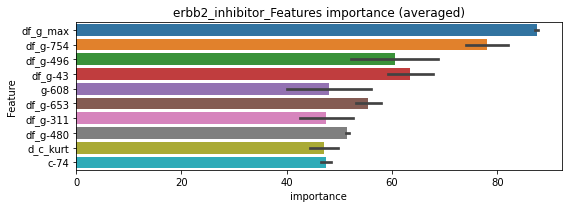

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149823	valid_1's binary_logloss: 0.0241508
[200]	training's binary_logloss: 0.00183633	valid_1's binary_logloss: 0.00698663
[300]	training's binary_logloss: 0.000556906	valid_1's binary_logloss: 0.00481252
[400]	training's binary_logloss: 0.00030516	valid_1's binary_logloss: 0.00418581
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00030516	valid_1's binary_logloss: 0.00418581


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151994	valid_1's binary_logloss: 0.0272383
[200]	training's binary_logloss: 0.00179416	valid_1's binary_logloss: 0.0117607
[300]	training's binary_logloss: 0.000535467	valid_1's binary_logloss: 0.0100132
[400]	training's binary_logloss: 0.000300948	valid_1's binary_logloss: 0.00946414
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00026028	valid_1's binary_logloss: 0.00935117


erbb2_inhibitor logloss: 0.006768494836596324
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177526	valid_1's binary_logloss: 0.474449
[200]	training's binary_logloss: 0.0588906	valid_1's binary_logloss: 0.414516
[300]	training's binary_logloss: 0.0231849	valid_1's binary_logloss: 0.387644
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0202402	valid_1's binary_logloss: 0.385187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187626	valid_1's binary_logloss: 0.447795
[200]	training's binary_logloss: 0.0636217	valid_1's binary_logloss: 0.357826
[300]	training's binary_logloss: 0.025472	valid_1's binary_logloss: 0.319932


1 / 3 AUC score:0.922
Threshold: 0.4205673989939367
Remove_noisy_labels: 158 → positive_corect_labels: 421/842
30th percentile: 0.16971
p_label_rate: 0.15871 Vs.target_rate: 0.00625, Num_p_label: 632.0, conf_0:0.16971, conf_1:0.50473


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0144701	valid_1's binary_logloss: 0.30486


Num_p_label: 632.0, Expected: 24.9, Adj_threshold_1: 0.42
Num_p_label: 460.0, Expected: 24.9, Adj_threshold_2: 0.46
Num_p_label: 341.0, Expected: 24.9, Adj_threshold_3: 0.50
Num_p_label: 216.0, Expected: 24.9, Adj_threshold_4: 0.54
Num_p_label: 142.0, Expected: 24.9, Adj_threshold_5: 0.58
Num_p_label: 86.0, Expected: 24.9, Adj_threshold_6: 0.62
Num_p_label: 43.0, Expected: 24.9, Adj_threshold_7: 0.66
Num_p_label: 26.0, Expected: 24.9, Adj_threshold_8: 0.70
threshold:0.70, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:421.0/842, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166602	valid_1's binary_logloss: 0.423321
[200]	training's binary_logloss: 0.052724	valid_1's binary_logloss: 0.346536
[300]	training's binary_logloss: 0.0203947	valid_1's binary_logloss: 0.314708
[400]	training's binary_logloss: 0.00984234	valid_1's binary_logloss: 0.293913
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0079567	valid_1's binary_logloss: 0.289716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162594	valid_1's binary_logloss: 0.405727
[200]	training's binary_logloss: 0.0512322	valid_1's binary_logloss: 0.317809
[300]	training's binary_logloss: 0.0198329	valid_1's binary_logloss: 0.281371


2 / 3 AUC score:0.951
Threshold: 0.7005673989939368
Remove_noisy_labels: 96 → positive_corect_labels: 337.0/746
30th percentile: 0.13201
p_label_rate: 0.02235 Vs.target_rate: 0.00625, Num_p_label: 89.0, conf_0:0.13201, conf_1:0.70057
Num_p_label: 89.0, Expected: 24.9, Adj_threshold_1: 0.70


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0115414	valid_1's binary_logloss: 0.271424


Num_p_label: 68.0, Expected: 24.9, Adj_threshold_2: 0.74
Num_p_label: 50.0, Expected: 24.9, Adj_threshold_3: 0.78
Num_p_label: 28.0, Expected: 24.9, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:337.0/746, y_label_rate: 0.45174
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142655	valid_1's binary_logloss: 0.381693
[200]	training's binary_logloss: 0.0421243	valid_1's binary_logloss: 0.299487
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0186745	valid_1's binary_logloss: 0.275679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155806	valid_1's binary_logloss: 0.349318
[200]	training's binary_logloss: 0.0480513	valid_1's binary_logloss: 0.239617
[300]	training's binary_logloss: 0.0185704	valid_1's binary_logloss: 0.193214
[400]	training's binary_logloss: 0.00909575	valid_1's binary_logloss: 0.169917
[500]	training's binary_logloss: 0.00561488	valid_1's binary_logloss: 0.158743
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00535028	valid_1's binary_logloss: 0.157545


3 / 3 AUC score:0.972
Threshold: 0.8205673989939369
Remove_noisy_labels: 102 → positive_corect_labels: 236.0/644
30th percentile: 0.07050
p_label_rate: 0.00427 Vs.target_rate: 0.00625, Num_p_label: 17.0, conf_0:0.07050, conf_1:0.82057
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:253.0/4626, y_label_rate: 0.05469


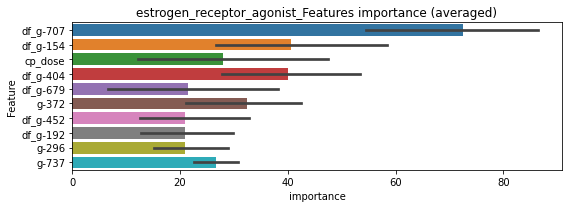

len(train_index) : 2313
len(valid_index) : 2313
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235096	valid_1's binary_logloss: 0.087828
[200]	training's binary_logloss: 0.00506133	valid_1's binary_logloss: 0.075043


len(train_index) : 2313
len(valid_index) : 2313


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00385336	valid_1's binary_logloss: 0.0739541


================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229698	valid_1's binary_logloss: 0.0876565


estrogen_receptor_agonist logloss: 0.07511271947644925


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00667869	valid_1's binary_logloss: 0.0762714
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                   

estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106836	valid_1's binary_logloss: 0.215
[200]	training's binary_logloss: 0.0251263	valid_1's binary_logloss: 0.104794
[300]	training's binary_logloss: 0.0084765	valid_1's binary_logloss: 0.0683864
[400]	training's binary_logloss: 0.00422819	valid_1's binary_logloss: 0.0546846
[500]	training's binary_logloss: 0.00275764	valid_1's binary_logloss: 0.0488263
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00251988	valid_1's binary_logloss: 0.0477233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10929	valid_1's binary_logloss: 0.228785
[200]	training's binary_logloss: 0.0255615	valid_1's binary_logloss: 0.135401
[300]	training's binary_logloss: 0.00853895	valid_1's binary_logloss: 0.107148


1 / 3 AUC score:0.994
Threshold: 0.38297251543595257
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentile: 0.01638
p_label_rate: 0.01482 Vs.target_rate: 0.00212, Num_p_label: 59.0, conf_0:0.01638, conf_1:0.48858
Num_p_label: 59.0, Expected: 8.4, Adj_threshold_1: 0.38
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_2: 0.42
Num_p_label: 29.0, Expected: 8.4, Adj_threshold_3: 0.46


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00617289	valid_1's binary_logloss: 0.103985


Num_p_label: 20.0, Expected: 8.4, Adj_threshold_4: 0.50
Num_p_label: 13.0, Expected: 8.4, Adj_threshold_5: 0.54
Num_p_label: 8.0, Expected: 8.4, Adj_threshold_6: 0.58
threshold:0.58, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105254	valid_1's binary_logloss: 0.211952
[200]	training's binary_logloss: 0.0242725	valid_1's binary_logloss: 0.105176
[300]	training's binary_logloss: 0.00828416	valid_1's binary_logloss: 0.0706877
[400]	training's binary_logloss: 0.00411677	valid_1's binary_logloss: 0.057057
[500]	training's binary_logloss: 0.00268206	valid_1's binary_logloss: 0.0503477
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00246685	valid_1's binary_logloss: 0.0489577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107238	valid_1's binary_logloss: 0.224987
[200]	training's binary_logloss: 0.0246683	valid_1's binary_logloss: 0.116003
[300]	training's binary_logloss: 0.00827641	valid_1's binary_logloss: 0.0844175
[400]	training's binary_logloss: 0.00414144	valid_1's binary_logloss: 0.0701229
[500]	training's binary_logloss: 0.002695	valid_1's bi

2 / 3 AUC score:0.999
Threshold: 0.5829725154359526
Remove_noisy_labels: 12 → positive_corect_labels: 483.0/968
30th percentile: 0.01108
p_label_rate: 0.00829 Vs.target_rate: 0.00212, Num_p_label: 33.0, conf_0:0.01108, conf_1:0.58297
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_1: 0.58
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_2: 0.62
Num_p_label: 15.0, Expected: 8.4, Adj_threshold_3: 0.66
Num_p_label: 10.0, Expected: 8.4, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:483.0/968, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102997	valid_1's binary_logloss: 0.214121
[200]	training's binary_logloss: 0.0232043	valid_1's binary_logloss: 0.110122
[300]	training's binary_logloss: 0.00767297	valid_1's binary_logloss: 0.0751599
[400]	training's binary_logloss: 0.00385015	valid_1's binary_logloss: 0.0628064
[500]	training's binary_logloss: 0.00254794	valid_1's binary_logloss: 0.057799
[600]	training's binary_logloss: 0.00199428	valid_1's binary_logloss: 0.0542132
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.00200539	valid_1's binary_logloss: 0.0541409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102111	valid_1's binary_logloss: 0.209021
[200]	training's binary_logloss: 0.0232444	valid_1's binary_logloss: 0.0999332
[300]	training's binary_logloss: 0.00790237	valid_1's binary_logloss: 0.0641178
[400]	training's binary_logloss: 0.00395522	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.7029725154359527
Remove_noisy_labels: 18 → positive_corect_labels: 465.0/950
30th percentile: 0.00963
p_label_rate: 0.00176 Vs.target_rate: 0.00212, Num_p_label: 7.0, conf_0:0.00963, conf_1:0.70297
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:472.0/4932, y_label_rate: 0.09570


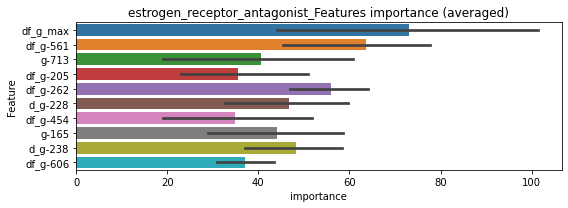

len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024635	valid_1's binary_logloss: 0.0548628
[200]	training's binary_logloss: 0.00444674	valid_1's binary_logloss: 0.0323084


len(train_index) : 2466
len(valid_index) : 2466


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00217576	valid_1's binary_logloss: 0.0287295


================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261255	valid_1's binary_logloss: 0.0593714
[200]	training's binary_logloss: 0.00417994	valid_1's binary_logloss: 0.0290828
[300]	training's binary_logloss: 0.00122112	valid_1's binary_logloss: 0.0230355
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000781563	valid_1's binary_logloss: 0.0219974


estrogen_receptor_antagonist logloss: 0.025363410417382517
faah_inhibitor , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939528	valid_1's binary_logloss: 0.17051
[200]	training's binary_logloss: 0.0199536	valid_1's binary_logloss: 0.0718757
[300]	training's binary_logloss: 0.00641329	valid_1's binary_logloss: 0.0427734
[400]	training's binary_logloss: 0.00323755	valid_1's binary_logloss: 0.0338888
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00249196	valid_1's binary_logloss: 0.0299617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918668	valid_1's binary_logloss: 0.170241
[200]	training's binary_logloss: 0.0189091	valid_1's binary_logloss: 0.072407
[300]	training's binary_logloss: 0.00610876	valid_1's binary_logloss: 0.0425707
[400]	training's binary_logloss: 0.00308793	valid_1's binary_logloss: 0.0324116
[500]	training's binary_logloss: 0.00209846	valid_1's binary_logloss: 0.0277805
Early stopping, best iteration is:
[584]	training's

1 / 3 AUC score:1.000
Threshold: 0.6744827883248421
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00633
p_label_rate: 0.00075 Vs.target_rate: 0.00161, Num_p_label: 3.0, conf_0:0.00633, conf_1:0.67448
threshold:0.67, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916244	valid_1's binary_logloss: 0.179057
[200]	training's binary_logloss: 0.0189364	valid_1's binary_logloss: 0.0756957
[300]	training's binary_logloss: 0.00618225	valid_1's binary_logloss: 0.0450278
[400]	training's binary_logloss: 0.00310688	valid_1's binary_logloss: 0.0325388
[500]	training's binary_logloss: 0.00209446	valid_1's binary_logloss: 0.0276888
[600]	training's binary_logloss: 0.00173144	valid_1's binary_logloss: 0.0250004
Early stopping, best iteration is:
[647]	training's binary_logloss: 0.00167559	valid_1's binary_logloss: 0.0244242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935218	valid_1's binary_logloss: 0.168323
[200]	training's binary_logloss: 0.020049	valid_1's binary_logloss: 0.0664955
[300]	training's binary_logloss: 0.00634755	valid_1's binary_logloss: 0.0357595
[400]	training's binary_logloss: 0.00320002	valid_

2 / 3 AUC score:1.000
Threshold: 0.6744827883248421
Remove_noisy_labels: 3 → positive_corect_labels: 496.0/995
30th percentile: 0.00540
p_label_rate: 0.00100 Vs.target_rate: 0.00161, Num_p_label: 4.0, conf_0:0.00540, conf_1:0.67448
threshold:0.67, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/995, y_label_rate: 0.49849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905953	valid_1's binary_logloss: 0.191566
[200]	training's binary_logloss: 0.0187151	valid_1's binary_logloss: 0.0871434
[300]	training's binary_logloss: 0.0060695	valid_1's binary_logloss: 0.0537548
[400]	training's binary_logloss: 0.00310383	valid_1's binary_logloss: 0.0409211
[500]	training's binary_logloss: 0.00207796	valid_1's binary_logloss: 0.0343219
[600]	training's binary_logloss: 0.00171362	valid_1's binary_logloss: 0.0309945
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00167408	valid_1's binary_logloss: 0.0305165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943383	valid_1's binary_logloss: 0.163344
[200]	training's binary_logloss: 0.0196704	valid_1's binary_logloss: 0.0626754
[300]	training's binary_logloss: 0.00637188	valid_1's binary_logloss: 0.0329875
[400]	training's binary_logloss: 0.00322977	valid_

3 / 3 AUC score:1.000
Threshold: 0.6744827883248421
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/991
30th percentile: 0.00524
p_label_rate: 0.00100 Vs.target_rate: 0.00161, Num_p_label: 4.0, conf_0:0.00524, conf_1:0.67448
threshold:0.67, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/4973, y_label_rate: 0.09974


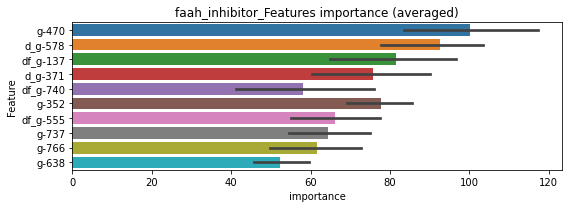

len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245501	valid_1's binary_logloss: 0.0549654
[200]	training's binary_logloss: 0.00351879	valid_1's binary_logloss: 0.0248825
[300]	training's binary_logloss: 0.000986858	valid_1's binary_logloss: 0.0171317
[400]	training's binary_logloss: 0.000494318	valid_1's binary_logloss: 0.0148848
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000404151	valid_1's binary_logloss: 0.0144809


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261016	valid_1's binary_logloss: 0.045633
[200]	training's binary_logloss: 0.00377946	valid_1's binary_logloss: 0.0155356
[300]	training's binary_logloss: 0.001062	valid_1's binary_logloss: 0.00985918
[400]	training's binary_logloss: 0.000524108	valid_1's binary_logloss: 0.0085638
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000457167	valid_1's binary_logloss: 0.00833122


faah_inhibitor logloss: 0.01140669065975268
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656217	valid_1's binary_logloss: 0.107805
[200]	training's binary_logloss: 0.0103358	valid_1's binary_logloss: 0.0317115
[300]	training's binary_logloss: 0.0032183	valid_1's binary_logloss: 0.0166605
[400]	training's binary_logloss: 0.00175782	valid_1's binary_logloss: 0.0121843
[500]	training's binary_logloss: 0.00131039	valid_1's binary_logloss: 0.0105894
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00122783	valid_1's binary_logloss: 0.0101264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604366	valid_1's binary_logloss: 0.0986642
[200]	training's binary_logloss: 0.00986996	valid_1's binary_logloss: 0.029634
[300]	training's binary_logloss: 0.00316976	valid_1's binary_logloss: 0.0148677
[400]	training's binary_logloss: 0.00174123	valid_1's binary_logloss: 0.0103085
[500]	training's binary_logloss: 0.00132075	valid

1 / 3 AUC score:1.000
Threshold: 0.40032968073541436
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00198
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00198, conf_1:0.40033
threshold:0.40, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640298	valid_1's binary_logloss: 0.102797
[200]	training's binary_logloss: 0.0103496	valid_1's binary_logloss: 0.0274996
[300]	training's binary_logloss: 0.00328777	valid_1's binary_logloss: 0.0133337
[400]	training's binary_logloss: 0.00176369	valid_1's binary_logloss: 0.00879588
[500]	training's binary_logloss: 0.00133736	valid_1's binary_logloss: 0.00751022
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00128355	valid_1's binary_logloss: 0.00725663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605065	valid_1's binary_logloss: 0.101964
[200]	training's binary_logloss: 0.00997002	valid_1's binary_logloss: 0.0326967
[300]	training's binary_logloss: 0.00320361	valid_1's binary_logloss: 0.0177903
[400]	training's binary_logloss: 0.00176853	valid_1's binary_logloss: 0.0131283
[500]	training's binary_logloss: 0.00133865	v

2 / 3 AUC score:1.000
Threshold: 0.40032968073541436
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00198
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00198, conf_1:0.40033
threshold:0.40, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640298	valid_1's binary_logloss: 0.102797
[200]	training's binary_logloss: 0.0103496	valid_1's binary_logloss: 0.0274996
[300]	training's binary_logloss: 0.00328777	valid_1's binary_logloss: 0.0133337
[400]	training's binary_logloss: 0.00176369	valid_1's binary_logloss: 0.00879588
[500]	training's binary_logloss: 0.00133736	valid_1's binary_logloss: 0.00751022
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00128355	valid_1's binary_logloss: 0.00725663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605065	valid_1's binary_logloss: 0.101964
[200]	training's binary_logloss: 0.00997002	valid_1's binary_logloss: 0.0326967
[300]	training's binary_logloss: 0.00320361	valid_1's binary_logloss: 0.0177903
[400]	training's binary_logloss: 0.00176853	valid_1's binary_logloss: 0.0131283
[500]	training's binary_logloss: 0.00133865	v

3 / 3 AUC score:1.000
Threshold: 0.40032968073541436
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00198
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00198, conf_1:0.40033
threshold:0.40, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:501.0/4980, y_label_rate: 0.10060


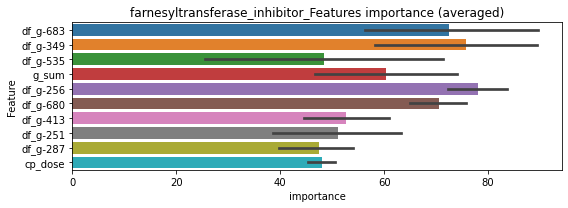

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152287	valid_1's binary_logloss: 0.0213616
[200]	training's binary_logloss: 0.00183203	valid_1's binary_logloss: 0.00557854
[300]	training's binary_logloss: 0.000531824	valid_1's binary_logloss: 0.00368207
[400]	training's binary_logloss: 0.000288798	valid_1's binary_logloss: 0.00323394
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00028479	valid_1's binary_logloss: 0.00322089


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154667	valid_1's binary_logloss: 0.0275954
[200]	training's binary_logloss: 0.00182103	valid_1's binary_logloss: 0.00877165
[300]	training's binary_logloss: 0.000527433	valid_1's binary_logloss: 0.00528847
[400]	training's binary_logloss: 0.000284963	valid_1's binary_logloss: 0.00435369
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000253661	valid_1's binary_logloss: 0.00426898


farnesyltransferase_inhibitor logloss: 0.0037449342338080377
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747946	valid_1's binary_logloss: 0.129586
[200]	training's binary_logloss: 0.0138521	valid_1's binary_logloss: 0.0458258
[300]	training's binary_logloss: 0.00444028	valid_1's binary_logloss: 0.0248642
[400]	training's binary_logloss: 0.00234363	valid_1's binary_logloss: 0.01864
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00184439	valid_1's binary_logloss: 0.0169413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741042	valid_1's binary_logloss: 0.130996
[200]	training's binary_logloss: 0.0135845	valid_1's binary_logloss: 0.0549742
[300]	training's binary_logloss: 0.004407	valid_1's binary_logloss: 0.035724
[400]	training's binary_logloss: 0.00231598	valid_1's binary_logloss: 0.0262657
[500]	training's binary_logloss: 0.00165576	valid_1's binary_logloss: 0.0231109
Early stopping, best iteration is:
[583]	training's bi

1 / 3 AUC score:1.000
Threshold: 0.37683458590879465
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00303
p_label_rate: 0.00151 Vs.target_rate: 0.00113, Num_p_label: 6.0, conf_0:0.00303, conf_1:0.40600
threshold:0.38, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716742	valid_1's binary_logloss: 0.128254
[200]	training's binary_logloss: 0.0129921	valid_1's binary_logloss: 0.0466839
[300]	training's binary_logloss: 0.00416499	valid_1's binary_logloss: 0.0263032
[400]	training's binary_logloss: 0.00225274	valid_1's binary_logloss: 0.0192104
[500]	training's binary_logloss: 0.00161896	valid_1's binary_logloss: 0.0163512
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00146677	valid_1's binary_logloss: 0.0157387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731156	valid_1's binary_logloss: 0.116393
[200]	training's binary_logloss: 0.0133231	valid_1's binary_logloss: 0.0434904
[300]	training's binary_logloss: 0.00426105	valid_1's binary_logloss: 0.0240147
[400]	training's binary_logloss: 0.00227965	valid_1's binary_logloss: 0.017994
[500]	training's binary_logloss: 0.00161467	valid_

2 / 3 AUC score:1.000
Threshold: 0.37683458590879465
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/995
30th percentile: 0.00246
p_label_rate: 0.00301 Vs.target_rate: 0.00113, Num_p_label: 12.0, conf_0:0.00246, conf_1:0.45497
threshold:0.38, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:497.0/995, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686419	valid_1's binary_logloss: 0.124323
[200]	training's binary_logloss: 0.0126745	valid_1's binary_logloss: 0.0511925
[300]	training's binary_logloss: 0.00416952	valid_1's binary_logloss: 0.0303844
[400]	training's binary_logloss: 0.00224225	valid_1's binary_logloss: 0.0241191
[500]	training's binary_logloss: 0.00162837	valid_1's binary_logloss: 0.0213237
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00150302	valid_1's binary_logloss: 0.0205436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752134	valid_1's binary_logloss: 0.11603
[200]	training's binary_logloss: 0.0140652	valid_1's binary_logloss: 0.0353529
[300]	training's binary_logloss: 0.00447779	valid_1's binary_logloss: 0.0179074
[400]	training's binary_logloss: 0.00234895	valid_1's binary_logloss: 0.0126145
[500]	training's binary_logloss: 0.00166355	valid_

3 / 3 AUC score:1.000
Threshold: 0.37683458590879465
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/993
30th percentile: 0.00251
p_label_rate: 0.00176 Vs.target_rate: 0.00113, Num_p_label: 7.0, conf_0:0.00251, conf_1:0.49285
threshold:0.38, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:502.0/4975, y_label_rate: 0.10090


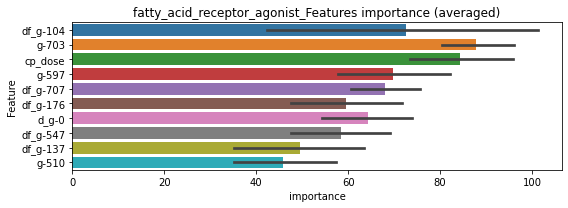

len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201642	valid_1's binary_logloss: 0.039163
[200]	training's binary_logloss: 0.00270998	valid_1's binary_logloss: 0.0178714
[300]	training's binary_logloss: 0.000767756	valid_1's binary_logloss: 0.0135949
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000510528	valid_1's binary_logloss: 0.0128943


len(train_index) : 2488
len(valid_index) : 2487
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196987	valid_1's binary_logloss: 0.0346981
[200]	training's binary_logloss: 0.00269107	valid_1's binary_logloss: 0.0136433
[300]	training's binary_logloss: 0.000771061	valid_1's binary_logloss: 0.0105226
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000431991	valid_1's binary_logloss: 0.00999162


fatty_acid_receptor_agonist logloss: 0.011443259583352522
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112834	valid_1's binary_logloss: 0.232901
[200]	training's binary_logloss: 0.0276156	valid_1's binary_logloss: 0.134686
[300]	training's binary_logloss: 0.00933328	valid_1's binary_logloss: 0.0987203
[400]	training's binary_logloss: 0.00458016	valid_1's binary_logloss: 0.0827931
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00317672	valid_1's binary_logloss: 0.077247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114296	valid_1's binary_logloss: 0.224222
[200]	training's binary_logloss: 0.0279507	valid_1's binary_logloss: 0.114659
[300]	training's binary_logloss: 0.00951839	valid_1's binary_logloss: 0.074893
[400]	training's binary_logloss: 0.00474069	valid_1's binary_logloss: 0.0591722
[500]	training's binary_logloss: 0.00306684	valid_1's binary_logloss: 0.0505555
[600]	training's binary_logloss: 0.00234505	valid_1's b

1 / 3 AUC score:0.997
Threshold: 0.478767163358759
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.01240
p_label_rate: 0.00502 Vs.target_rate: 0.00220, Num_p_label: 20.0, conf_0:0.01240, conf_1:0.49058
threshold:0.48, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108594	valid_1's binary_logloss: 0.223484
[200]	training's binary_logloss: 0.0256563	valid_1's binary_logloss: 0.116973
[300]	training's binary_logloss: 0.00856597	valid_1's binary_logloss: 0.0793983
[400]	training's binary_logloss: 0.00434215	valid_1's binary_logloss: 0.0619276
[500]	training's binary_logloss: 0.00282803	valid_1's binary_logloss: 0.0553296
[600]	training's binary_logloss: 0.00219752	valid_1's binary_logloss: 0.050854
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00207619	valid_1's binary_logloss: 0.0500649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112302	valid_1's binary_logloss: 0.228251
[200]	training's binary_logloss: 0.0272891	valid_1's binary_logloss: 0.136164
[300]	training's binary_logloss: 0.00920703	valid_1's binary_logloss: 0.104863


2 / 3 AUC score:0.995
Threshold: 0.478767163358759


[400]	training's binary_logloss: 0.0045698	valid_1's binary_logloss: 0.0954498
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00481027	valid_1's binary_logloss: 0.095163


Remove_noisy_labels: 22 → positive_corect_labels: 485.0/966
30th percentile: 0.01568
p_label_rate: 0.00728 Vs.target_rate: 0.00220, Num_p_label: 29.0, conf_0:0.01568, conf_1:0.52304
Num_p_label: 29.0, Expected: 8.8, Adj_threshold_1: 0.48
Num_p_label: 22.0, Expected: 8.8, Adj_threshold_2: 0.52
Num_p_label: 15.0, Expected: 8.8, Adj_threshold_3: 0.56
Num_p_label: 12.0, Expected: 8.8, Adj_threshold_4: 0.60
threshold:0.60, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:485.0/966, y_label_rate: 0.50207
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104104	valid_1's binary_logloss: 0.214794
[200]	training's binary_logloss: 0.0247744	valid_1's binary_logloss: 0.108361
[300]	training's binary_logloss: 0.00840036	valid_1's binary_logloss: 0.0693601
[400]	training's binary_logloss: 0.00423036	valid_1's binary_logloss: 0.0536289
[500]	training's binary_logloss: 0.0027783	valid_1's binary_logloss: 0.0465163
[600]	training's binary_logloss: 0.00216029	valid_1's binary_logloss: 0.0422162
[700]	training's binary_logloss: 0.00194698	valid_1's binary_logloss: 0.0403288
Early stopping, best iteration is:
[714]	training's binary_logloss: 0.00192624	valid_1's binary_logloss: 0.0399616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112871	valid_1's binary_logloss: 0.21878
[200]	training's binary_logloss: 0.0263661	valid_1's binary_logloss: 0.110427
[300]	training's binary_logloss: 0.00890423	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.5987671633587591
Remove_noisy_labels: 9 → positive_corect_labels: 479.0/957
30th percentile: 0.00941
p_label_rate: 0.00578 Vs.target_rate: 0.00220, Num_p_label: 23.0, conf_0:0.00941, conf_1:0.59877
threshold:0.60, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:502.0/4939, y_label_rate: 0.10164


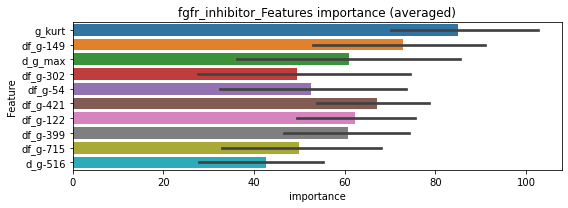

len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321544	valid_1's binary_logloss: 0.0702045
[200]	training's binary_logloss: 0.00619504	valid_1's binary_logloss: 0.0415253


len(train_index) : 2470
len(valid_index) : 2469


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00232663	valid_1's binary_logloss: 0.0356272


================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345657	valid_1's binary_logloss: 0.0684442
[200]	training's binary_logloss: 0.00616542	valid_1's binary_logloss: 0.0382522
[300]	training's binary_logloss: 0.00169047	valid_1's binary_logloss: 0.0333863
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00169047	valid_1's binary_logloss: 0.0333863


fgfr_inhibitor logloss: 0.03450697855183083
flt3_inhibitor , len(trt) : 279


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212511	valid_1's binary_logloss: 0.593697
[200]	training's binary_logloss: 0.0793974	valid_1's binary_logloss: 0.57614
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0862092	valid_1's binary_logloss: 0.572677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207487	valid_1's binary_logloss: 0.589298


1 / 3 AUC score:0.757
Threshold: 0.4865518937310354
Remove_noisy_labels: 318 → positive_corect_labels: 341/682
30th percentile: 0.34954
p_label_rate: 0.26971 Vs.target_rate: 0.00962, Num_p_label: 1074.0, conf_0:0.34954, conf_1:0.49014
Num_p_label: 1074.0, Expected: 38.3, Adj_threshold_1: 0.49
Num_p_label: 687.0, Expected: 38.3, Adj_threshold_2: 0.53
Num_p_label: 388.0, Expected: 38.3, Adj_threshold_3: 0.57


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.116426	valid_1's binary_logloss: 0.567898


Num_p_label: 210.0, Expected: 38.3, Adj_threshold_4: 0.61
Num_p_label: 106.0, Expected: 38.3, Adj_threshold_5: 0.65
Num_p_label: 38.0, Expected: 38.3, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:341.0/682, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192528	valid_1's binary_logloss: 0.494886
[200]	training's binary_logloss: 0.0690801	valid_1's binary_logloss: 0.41505
[300]	training's binary_logloss: 0.0284762	valid_1's binary_logloss: 0.388196
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0251765	valid_1's binary_logloss: 0.384319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19184	valid_1's binary_logloss: 0.48549
[200]	training's binary_logloss: 0.0698466	valid_1's binary_logloss: 0.424193


2 / 3 AUC score:0.903
Threshold: 0.6865518937310355
Remove_noisy_labels: 119 → positive_corect_labels: 240.0/563
30th percentile: 0.26616
p_label_rate: 0.07911 Vs.target_rate: 0.00962, Num_p_label: 315.0, conf_0:0.26616, conf_1:0.68655
Num_p_label: 315.0, Expected: 38.3, Adj_threshold_1: 0.69
Num_p_label: 213.0, Expected: 38.3, Adj_threshold_2: 0.73
Num_p_label: 122.0, Expected: 38.3, Adj_threshold_3: 0.77
Num_p_label: 48.0, Expected: 38.3, Adj_threshold_4: 0.81
threshold:0.81, positive p_label:48.0/3982, p_label_rate: 0.01205


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0436802	valid_1's binary_logloss: 0.411301


positive y_label:240.0/563, y_label_rate: 0.42629
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166984	valid_1's binary_logloss: 0.39804
[200]	training's binary_logloss: 0.0567738	valid_1's binary_logloss: 0.307208
[300]	training's binary_logloss: 0.0230831	valid_1's binary_logloss: 0.264792
[400]	training's binary_logloss: 0.0116646	valid_1's binary_logloss: 0.245085
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0103934	valid_1's binary_logloss: 0.242698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15648	valid_1's binary_logloss: 0.383595
[200]	training's binary_logloss: 0.0506803	valid_1's binary_logloss: 0.301602


3 / 3 AUC score:0.961
Threshold: 0.8065518937310356


[300]	training's binary_logloss: 0.0198275	valid_1's binary_logloss: 0.275891
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0193569	valid_1's binary_logloss: 0.274896


Remove_noisy_labels: 89 → positive_corect_labels: 152.0/474
30th percentile: 0.10872
p_label_rate: 0.00929 Vs.target_rate: 0.00962, Num_p_label: 37.0, conf_0:0.10872, conf_1:0.80655
threshold:0.81, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:189.0/4456, y_label_rate: 0.04241


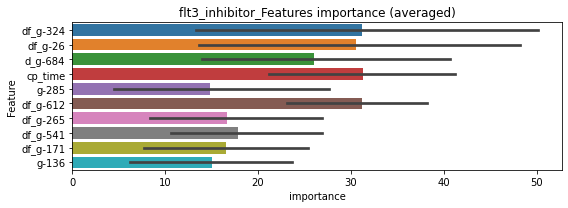

len(train_index) : 2228
len(valid_index) : 2228
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203622	valid_1's binary_logloss: 0.10099


len(train_index) : 2228
len(valid_index) : 2228
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0119055	valid_1's binary_logloss: 0.0972243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211261	valid_1's binary_logloss: 0.101508


flt3_inhibitor logloss: 0.09789377006123315
focal_adhesion_kinase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0110588	valid_1's binary_logloss: 0.0985633
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                    

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631538	valid_1's binary_logloss: 0.0901142
[200]	training's binary_logloss: 0.0100989	valid_1's binary_logloss: 0.023274
[300]	training's binary_logloss: 0.00321229	valid_1's binary_logloss: 0.0108413
[400]	training's binary_logloss: 0.0017779	valid_1's binary_logloss: 0.00744151
[500]	training's binary_logloss: 0.00134128	valid_1's binary_logloss: 0.00599499
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00124893	valid_1's binary_logloss: 0.00559226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060172	valid_1's binary_logloss: 0.108707
[200]	training's binary_logloss: 0.00965114	valid_1's binary_logloss: 0.0356829
[300]	training's binary_logloss: 0.00304498	valid_1's binary_logloss: 0.0202366
[400]	training's binary_logloss: 0.00170172	valid_1's binary_logloss: 0.0153655
[500]	training's binary_logloss: 0.00129547	val

1 / 3 AUC score:1.000
Threshold: 0.6463191670105877
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00182
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00182, conf_1:0.64632
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.65
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.61
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.57
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.53
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.49
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_6: 0.45
threshold:0.45, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631538	valid_1's binary_logloss: 0.0901142
[200]	training's binary_logloss: 0.0100989	valid_1's binary_logloss: 0.023274
[300]	training's binary_logloss: 0.00321229	valid_1's binary_logloss: 0.0108413
[400]	training's binary_logloss: 0.0017779	valid_1's binary_logloss: 0.00744151
[500]	training's binary_logloss: 0.00134128	valid_1's binary_logloss: 0.00599499
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00124893	valid_1's binary_logloss: 0.00559226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060172	valid_1's binary_logloss: 0.108707
[200]	training's binary_logloss: 0.00965114	valid_1's binary_logloss: 0.0356829
[300]	training's binary_logloss: 0.00304498	valid_1's binary_logloss: 0.0202366
[400]	training's binary_logloss: 0.00170172	valid_1's binary_logloss: 0.0153655
[500]	training's binary_logloss: 0.00129547	val

2 / 3 AUC score:1.000
Threshold: 0.4463191670105876
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00182
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00182, conf_1:0.44632
threshold:0.45, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638458	valid_1's binary_logloss: 0.0876645
[200]	training's binary_logloss: 0.010349	valid_1's binary_logloss: 0.0221359
[300]	training's binary_logloss: 0.0033031	valid_1's binary_logloss: 0.0107547
[400]	training's binary_logloss: 0.00181858	valid_1's binary_logloss: 0.00745975
[500]	training's binary_logloss: 0.00135262	valid_1's binary_logloss: 0.00621283
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00125368	valid_1's binary_logloss: 0.00581374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605565	valid_1's binary_logloss: 0.107207
[200]	training's binary_logloss: 0.00952531	valid_1's binary_logloss: 0.0331968
[300]	training's binary_logloss: 0.00303405	valid_1's binary_logloss: 0.0174603
[400]	training's binary_logloss: 0.00168422	valid_1's binary_logloss: 0.0123881
[500]	training's binary_logloss: 0.00127909	va

3 / 3 AUC score:1.000
Threshold: 0.4463191670105876
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00170
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00170, conf_1:0.44632
threshold:0.45, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4981, y_label_rate: 0.10078


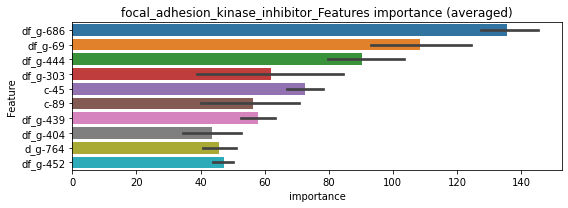

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154916	valid_1's binary_logloss: 0.029096
[200]	training's binary_logloss: 0.00185299	valid_1's binary_logloss: 0.00961278
[300]	training's binary_logloss: 0.000536845	valid_1's binary_logloss: 0.00587732
[400]	training's binary_logloss: 0.000300632	valid_1's binary_logloss: 0.0050097
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000261563	valid_1's binary_logloss: 0.00480578


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153115	valid_1's binary_logloss: 0.021737
[200]	training's binary_logloss: 0.00185477	valid_1's binary_logloss: 0.00561473
[300]	training's binary_logloss: 0.000544298	valid_1's binary_logloss: 0.00337755
[400]	training's binary_logloss: 0.000303438	valid_1's binary_logloss: 0.00291882
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00026933	valid_1's binary_logloss: 0.00286242


focal_adhesion_kinase_inhibitor logloss: 0.0038342960120986164
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663508	valid_1's binary_logloss: 0.10386
[200]	training's binary_logloss: 0.0113115	valid_1's binary_logloss: 0.028222
[300]	training's binary_logloss: 0.00357117	valid_1's binary_logloss: 0.0126938
[400]	training's binary_logloss: 0.00194275	valid_1's binary_logloss: 0.00826576
[500]	training's binary_logloss: 0.00145212	valid_1's binary_logloss: 0.00665291
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00136094	valid_1's binary_logloss: 0.00628643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671615	valid_1's binary_logloss: 0.106904
[200]	training's binary_logloss: 0.0112131	valid_1's binary_logloss: 0.0301624
[300]	training's binary_logloss: 0.00359709	valid_1's binary_logloss: 0.0147805
[400]	training's binary_logloss: 0.00194114	valid_1's binary_logloss: 0.00991478
[500]	training's binary_logloss: 0.00142058	val

1 / 3 AUC score:1.000
Threshold: 0.5349599588426022
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00240
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00240, conf_1:0.53496
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.53
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.49
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.45
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.41
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.37
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_6: 0.33
threshold:0.33, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663508	valid_1's binary_logloss: 0.10386
[200]	training's binary_logloss: 0.0113115	valid_1's binary_logloss: 0.028222
[300]	training's binary_logloss: 0.00357117	valid_1's binary_logloss: 0.0126938
[400]	training's binary_logloss: 0.00194275	valid_1's binary_logloss: 0.00826576
[500]	training's binary_logloss: 0.00145212	valid_1's binary_logloss: 0.00665291
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00136094	valid_1's binary_logloss: 0.00628643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671615	valid_1's binary_logloss: 0.106904
[200]	training's binary_logloss: 0.0112131	valid_1's binary_logloss: 0.0301624
[300]	training's binary_logloss: 0.00359709	valid_1's binary_logloss: 0.0147805
[400]	training's binary_logloss: 0.00194114	valid_1's binary_logloss: 0.00991478
[500]	training's binary_logloss: 0.00142058	val

2 / 3 AUC score:1.000
Threshold: 0.33495995884260227
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00240
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00240, conf_1:0.33496
threshold:0.33, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663508	valid_1's binary_logloss: 0.10386
[200]	training's binary_logloss: 0.0113115	valid_1's binary_logloss: 0.028222
[300]	training's binary_logloss: 0.00357117	valid_1's binary_logloss: 0.0126938
[400]	training's binary_logloss: 0.00194275	valid_1's binary_logloss: 0.00826576
[500]	training's binary_logloss: 0.00145212	valid_1's binary_logloss: 0.00665291
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00136094	valid_1's binary_logloss: 0.00628643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671615	valid_1's binary_logloss: 0.106904
[200]	training's binary_logloss: 0.0112131	valid_1's binary_logloss: 0.0301624
[300]	training's binary_logloss: 0.00359709	valid_1's binary_logloss: 0.0147805
[400]	training's binary_logloss: 0.00194114	valid_1's binary_logloss: 0.00991478
[500]	training's binary_logloss: 0.00142058	val

3 / 3 AUC score:1.000
Threshold: 0.33495995884260227
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00240
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00240, conf_1:0.33496
threshold:0.33, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


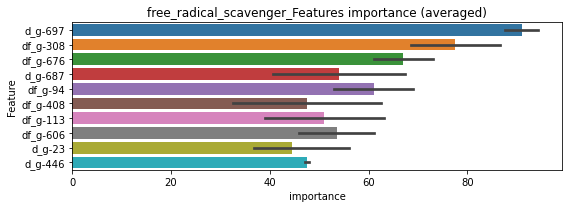

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165206	valid_1's binary_logloss: 0.0252029
[200]	training's binary_logloss: 0.00203009	valid_1's binary_logloss: 0.00604266
[300]	training's binary_logloss: 0.000583974	valid_1's binary_logloss: 0.00372766
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000337232	valid_1's binary_logloss: 0.00331659


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157954	valid_1's binary_logloss: 0.0232726
[200]	training's binary_logloss: 0.0019605	valid_1's binary_logloss: 0.00712157
[300]	training's binary_logloss: 0.00056442	valid_1's binary_logloss: 0.00537724


free_radical_scavenger logloss: 0.004286013347206704


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000447024	valid_1's binary_logloss: 0.00525544


fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785721	valid_1's binary_logloss: 0.136956
[200]	training's binary_logloss: 0.0148494	valid_1's binary_logloss: 0.0459466
[300]	training's binary_logloss: 0.00477807	valid_1's binary_logloss: 0.0230318
[400]	training's binary_logloss: 0.00252479	valid_1's binary_logloss: 0.0161843
[500]	training's binary_logloss: 0.00176972	valid_1's binary_logloss: 0.0134313
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00157854	valid_1's binary_logloss: 0.0123417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775676	valid_1's binary_logloss: 0.149825
[200]	training's binary_logloss: 0.0142786	valid_1's binary_logloss: 0.0560549
[300]	training's binary_logloss: 0.00455152	valid_1's binary_logloss: 0.0308935
[400]	training's binary_logloss: 0.0023895	valid_1's binary_logloss: 0.0228124
[500]	training's binary_logloss: 0.00169564	valid_

1 / 3 AUC score:1.000
Threshold: 0.41425854145741337
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00375
p_label_rate: 0.00000 Vs.target_rate: 0.00104, Num_p_label: 0.0, conf_0:0.00375, conf_1:0.41426
Num_p_label: 0.0, Expected: 4.1, Adj_threshold_1: 0.41
Num_p_label: 0.0, Expected: 4.1, Adj_threshold_2: 0.37
Num_p_label: 2.0, Expected: 4.1, Adj_threshold_3: 0.33
Num_p_label: 2.0, Expected: 4.1, Adj_threshold_4: 0.29
Num_p_label: 8.0, Expected: 4.1, Adj_threshold_5: 0.25
threshold:0.25, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762624	valid_1's binary_logloss: 0.147243
[200]	training's binary_logloss: 0.0139474	valid_1's binary_logloss: 0.0655242
[300]	training's binary_logloss: 0.00448744	valid_1's binary_logloss: 0.0465018
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00305107	valid_1's binary_logloss: 0.0425469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777397	valid_1's binary_logloss: 0.155447
[200]	training's binary_logloss: 0.0142768	valid_1's binary_logloss: 0.0622665
[300]	training's binary_logloss: 0.00450059	valid_1's binary_logloss: 0.034816
[400]	training's binary_logloss: 0.00239693	valid_1's binary_logloss: 0.0258172
[500]	training's binary_logloss: 0.00169359	valid_1's binary_logloss: 0.0215943
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00154563	valid_1's binary_logloss: 0.0203907


2 / 3 AUC score:0.999
Threshold: 0.25425854145741345
Remove_noisy_labels: 9 → positive_corect_labels: 496.0/989
30th percentile: 0.00550
p_label_rate: 0.00251 Vs.target_rate: 0.00104, Num_p_label: 10.0, conf_0:0.00550, conf_1:0.25426
threshold:0.25, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:496.0/989, y_label_rate: 0.50152
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749997	valid_1's binary_logloss: 0.143406
[200]	training's binary_logloss: 0.013752	valid_1's binary_logloss: 0.0559532
[300]	training's binary_logloss: 0.00450566	valid_1's binary_logloss: 0.0311154
[400]	training's binary_logloss: 0.00239008	valid_1's binary_logloss: 0.0228203
[500]	training's binary_logloss: 0.00171745	valid_1's binary_logloss: 0.0193515
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00160345	valid_1's binary_logloss: 0.0187191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741592	valid_1's binary_logloss: 0.132002
[200]	training's binary_logloss: 0.0137056	valid_1's binary_logloss: 0.0502627
[300]	training's binary_logloss: 0.00448617	valid_1's binary_logloss: 0.0312095
[400]	training's binary_logloss: 0.00239669	valid_1's binary_logloss: 0.0255945
Early stopping, best iteration is:
[436]	training'

3 / 3 AUC score:1.000
Threshold: 0.25425854145741345
Remove_noisy_labels: 6 → positive_corect_labels: 494.0/983
30th percentile: 0.00498
p_label_rate: 0.00402 Vs.target_rate: 0.00104, Num_p_label: 16.0, conf_0:0.00498, conf_1:0.37978
Num_p_label: 16.0, Expected: 4.1, Adj_threshold_1: 0.25
Num_p_label: 5.0, Expected: 4.1, Adj_threshold_2: 0.29
threshold:0.29, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/4965, y_label_rate: 0.10050


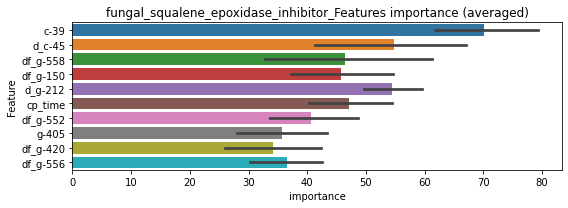

len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206792	valid_1's binary_logloss: 0.0342494
[200]	training's binary_logloss: 0.00284432	valid_1's binary_logloss: 0.013789
[300]	training's binary_logloss: 0.000787901	valid_1's binary_logloss: 0.0108701
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000627712	valid_1's binary_logloss: 0.0105439


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202704	valid_1's binary_logloss: 0.0312055
[200]	training's binary_logloss: 0.00258047	valid_1's binary_logloss: 0.00932293
[300]	training's binary_logloss: 0.000732474	valid_1's binary_logloss: 0.00678941
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000492587	valid_1's binary_logloss: 0.00649829


fungal_squalene_epoxidase_inhibitor logloss: 0.00852151544920914
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155501	valid_1's binary_logloss: 0.382549
[200]	training's binary_logloss: 0.0474315	valid_1's binary_logloss: 0.288539
[300]	training's binary_logloss: 0.0178826	valid_1's binary_logloss: 0.241719
[400]	training's binary_logloss: 0.00858221	valid_1's binary_logloss: 0.2279
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00746637	valid_1's binary_logloss: 0.224908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150407	valid_1's binary_logloss: 0.365665
[200]	training's binary_logloss: 0.0450857	valid_1's binary_logloss: 0.27955
[300]	training's binary_logloss: 0.0166397	valid_1's binary_logloss: 0.248129


1 / 3 AUC score:0.960
Threshold: 0.4006940621191225
Remove_noisy_labels: 94 → positive_corect_labels: 453/906
30th percentile: 0.08562
p_label_rate: 0.07735 Vs.target_rate: 0.00442, Num_p_label: 308.0, conf_0:0.08562, conf_1:0.53824
Num_p_label: 308.0, Expected: 17.6, Adj_threshold_1: 0.40


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.0103526	valid_1's binary_logloss: 0.239805


Num_p_label: 220.0, Expected: 17.6, Adj_threshold_2: 0.44
Num_p_label: 145.0, Expected: 17.6, Adj_threshold_3: 0.48
Num_p_label: 105.0, Expected: 17.6, Adj_threshold_4: 0.52
Num_p_label: 73.0, Expected: 17.6, Adj_threshold_5: 0.56
Num_p_label: 51.0, Expected: 17.6, Adj_threshold_6: 0.60
Num_p_label: 26.0, Expected: 17.6, Adj_threshold_7: 0.64
threshold:0.64, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:453.0/906, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14541	valid_1's binary_logloss: 0.338307
[200]	training's binary_logloss: 0.0422473	valid_1's binary_logloss: 0.232727
[300]	training's binary_logloss: 0.0152432	valid_1's binary_logloss: 0.185129
[400]	training's binary_logloss: 0.00739373	valid_1's binary_logloss: 0.163904
[500]	training's binary_logloss: 0.00455721	valid_1's binary_logloss: 0.155527
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00378861	valid_1's binary_logloss: 0.151643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143892	valid_1's binary_logloss: 0.338759
[200]	training's binary_logloss: 0.0417272	valid_1's binary_logloss: 0.232959
[300]	training's binary_logloss: 0.0154622	valid_1's binary_logloss: 0.193767
[400]	training's binary_logloss: 0.00748334	valid_1's binary_logloss: 0.174708


2 / 3 AUC score:0.983
Threshold: 0.6406940621191226
Remove_noisy_labels: 46 → positive_corect_labels: 413.0/860


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00603133	valid_1's binary_logloss: 0.168425


30th percentile: 0.06061
p_label_rate: 0.02009 Vs.target_rate: 0.00442, Num_p_label: 80.0, conf_0:0.04584, conf_1:0.64069
Num_p_label: 80.0, Expected: 17.6, Adj_threshold_1: 0.64
Num_p_label: 58.0, Expected: 17.6, Adj_threshold_2: 0.68
Num_p_label: 37.0, Expected: 17.6, Adj_threshold_3: 0.72
Num_p_label: 23.0, Expected: 17.6, Adj_threshold_4: 0.76
threshold:0.76, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:413.0/860, y_label_rate: 0.48023
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133416	valid_1's binary_logloss: 0.322491
[200]	training's binary_logloss: 0.0373119	valid_1's binary_logloss: 0.216111
[300]	training's binary_logloss: 0.0137566	valid_1's binary_logloss: 0.184816
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00850424	valid_1's binary_logloss: 0.172707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137219	valid_1's binary_logloss: 0.321368
[200]	training's binary_logloss: 0.0389723	valid_1's binary_logloss: 0.209391
[300]	training's binary_logloss: 0.0142162	valid_1's binary_logloss: 0.158521
[400]	training's binary_logloss: 0.00697901	valid_1's binary_logloss: 0.137513
[500]	training's binary_logloss: 0.00433499	valid_1's binary_logloss: 0.126217
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00329694	valid_1's binary_logloss: 0.118893


3 / 3 AUC score:0.988
Threshold: 0.7606940621191227
Remove_noisy_labels: 43 → positive_corect_labels: 373.0/817
30th percentile: 0.05628
p_label_rate: 0.00703 Vs.target_rate: 0.00442, Num_p_label: 28.0, conf_0:0.05628, conf_1:0.76069
threshold:0.76, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:401.0/4799, y_label_rate: 0.08356


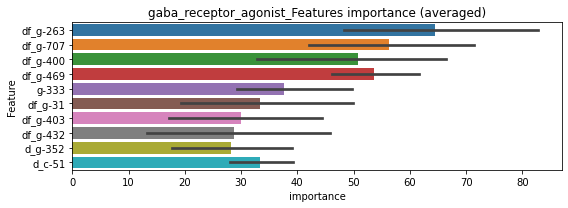

len(train_index) : 2399
len(valid_index) : 2400
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373269	valid_1's binary_logloss: 0.108226
[200]	training's binary_logloss: 0.0076963	valid_1's binary_logloss: 0.0806835
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0041165	valid_1's binary_logloss: 0.0773007


len(train_index) : 2400
len(valid_index) : 2399
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409379	valid_1's binary_logloss: 0.102584
[200]	training's binary_logloss: 0.00900626	valid_1's binary_logloss: 0.0711796
[300]	training's binary_logloss: 0.00267056	valid_1's binary_logloss: 0.0643002
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00257117	valid_1's binary_logloss: 0.0641738


gaba_receptor_agonist logloss: 0.0707386394422864
gaba_receptor_antagonist , len(trt) : 165


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173451	valid_1's binary_logloss: 0.463465
[200]	training's binary_logloss: 0.0578658	valid_1's binary_logloss: 0.406405
[300]	training's binary_logloss: 0.0229388	valid_1's binary_logloss: 0.384387
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.0121826	valid_1's binary_logloss: 0.37221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182288	valid_1's binary_logloss: 0.462349
[200]	training's binary_logloss: 0.0633095	valid_1's binary_logloss: 0.384299
[300]	training's binary_logloss: 0.0254244	valid_1's binary_logloss: 0.343877
[400]	training's binary_logloss: 0.0123422	valid_1's binary_logloss: 0.324704
[500]	training's binary_logloss: 0.00730527	valid_1's binary_logloss: 0.313763
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00637247	valid_1's binary_logloss: 0.311805


1 / 3 AUC score:0.922
Threshold: 0.4841382349397776
Remove_noisy_labels: 146 → positive_corect_labels: 427/854
30th percentile: 0.15233
p_label_rate: 0.09242 Vs.target_rate: 0.00648, Num_p_label: 368.0, conf_0:0.15233, conf_1:0.51519
Num_p_label: 368.0, Expected: 25.8, Adj_threshold_1: 0.48
Num_p_label: 254.0, Expected: 25.8, Adj_threshold_2: 0.52
Num_p_label: 183.0, Expected: 25.8, Adj_threshold_3: 0.56
Num_p_label: 120.0, Expected: 25.8, Adj_threshold_4: 0.60
Num_p_label: 69.0, Expected: 25.8, Adj_threshold_5: 0.64
Num_p_label: 43.0, Expected: 25.8, Adj_threshold_6: 0.68
Num_p_label: 21.0, Expected: 25.8, Adj_threshold_7: 0.72
threshold:0.72, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:427.0/854, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164963	valid_1's binary_logloss: 0.414795
[200]	training's binary_logloss: 0.0532367	valid_1's binary_logloss: 0.323253
[300]	training's binary_logloss: 0.0207666	valid_1's binary_logloss: 0.281887
[400]	training's binary_logloss: 0.0100361	valid_1's binary_logloss: 0.260672
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00656326	valid_1's binary_logloss: 0.253926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165925	valid_1's binary_logloss: 0.439595
[200]	training's binary_logloss: 0.0525886	valid_1's binary_logloss: 0.360828
[300]	training's binary_logloss: 0.02023	valid_1's binary_logloss: 0.323406


2 / 3 AUC score:0.946
Threshold: 0.7241382349397778
Remove_noisy_labels: 100 → positive_corect_labels: 334.0/754
30th percentile: 0.11524


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0118504	valid_1's binary_logloss: 0.313066


p_label_rate: 0.01883 Vs.target_rate: 0.00648, Num_p_label: 75.0, conf_0:0.11524, conf_1:0.72414
threshold:0.72, positive p_label:75.0/3982, p_label_rate: 0.01883
positive y_label:334.0/754, y_label_rate: 0.44297
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14831	valid_1's binary_logloss: 0.390231
[200]	training's binary_logloss: 0.0444252	valid_1's binary_logloss: 0.308331
[300]	training's binary_logloss: 0.0168453	valid_1's binary_logloss: 0.279712
[400]	training's binary_logloss: 0.00819667	valid_1's binary_logloss: 0.260792
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00810796	valid_1's binary_logloss: 0.260085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145326	valid_1's binary_logloss: 0.377353
[200]	training's binary_logloss: 0.0445168	valid_1's binary_logloss: 0.298025
[300]	training's binary_logloss: 0.0170428	valid_1's binary_logloss: 0.273823


3 / 3 AUC score:0.952
Threshold: 0.7241382349397778
Remove_noisy_labels: 85 → positive_corect_labels: 253.0/669
30th percentile: 0.06985
p_label_rate: 0.01155 Vs.target_rate: 0.00648, Num_p_label: 46.0, conf_0:0.06985, conf_1:0.72414
threshold:0.72, positive p_label:46.0/3982, p_label_rate: 0.01155


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0122509	valid_1's binary_logloss: 0.265363


positive y_label:299.0/4651, y_label_rate: 0.06429


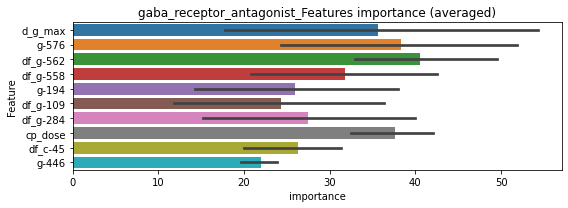

len(train_index) : 2325
len(valid_index) : 2326
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259971	valid_1's binary_logloss: 0.108408
[200]	training's binary_logloss: 0.00580965	valid_1's binary_logloss: 0.093778


len(train_index) : 2326
len(valid_index) : 2325


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00400654	valid_1's binary_logloss: 0.0925651


================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297505	valid_1's binary_logloss: 0.0981649
[200]	training's binary_logloss: 0.00676375	valid_1's binary_logloss: 0.0814052
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0054327	valid_1's binary_logloss: 0.0809439


gaba_receptor_antagonist logloss: 0.08675575084539343
gamma_secretase_inhibitor , len(trt) : 56


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106749	valid_1's binary_logloss: 0.238293
[200]	training's binary_logloss: 0.0267214	valid_1's binary_logloss: 0.151867
[300]	training's binary_logloss: 0.00901041	valid_1's binary_logloss: 0.119032
[400]	training's binary_logloss: 0.00452179	valid_1's binary_logloss: 0.105076
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00356482	valid_1's binary_logloss: 0.101049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111805	valid_1's binary_logloss: 0.231207
[200]	training's binary_logloss: 0.028548	valid_1's binary_logloss: 0.1303
[300]	training's binary_logloss: 0.00975068	valid_1's binary_logloss: 0.0931073
[400]	training's binary_logloss: 0.00484446	valid_1's binary_logloss: 0.0792418
[500]	training's binary_logloss: 0.00307692	valid_1's binary_logloss: 0.0728371
[600]	training's binary_logloss: 0.00233053	valid_1's binar

1 / 3 AUC score:0.994
Threshold: 0.37411115400433087
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentile: 0.01460
p_label_rate: 0.00979 Vs.target_rate: 0.00246, Num_p_label: 39.0, conf_0:0.01460, conf_1:0.39392
Num_p_label: 39.0, Expected: 9.8, Adj_threshold_1: 0.37
Num_p_label: 31.0, Expected: 9.8, Adj_threshold_2: 0.41
Num_p_label: 17.0, Expected: 9.8, Adj_threshold_3: 0.45
Num_p_label: 8.0, Expected: 9.8, Adj_threshold_4: 0.49
threshold:0.49, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101738	valid_1's binary_logloss: 0.226808
[200]	training's binary_logloss: 0.0245542	valid_1's binary_logloss: 0.145856
[300]	training's binary_logloss: 0.00841433	valid_1's binary_logloss: 0.118129
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00819076	valid_1's binary_logloss: 0.118051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109526	valid_1's binary_logloss: 0.215369
[200]	training's binary_logloss: 0.0266133	valid_1's binary_logloss: 0.107211
[300]	training's binary_logloss: 0.00905718	valid_1's binary_logloss: 0.073475
[400]	training's binary_logloss: 0.00459492	valid_1's binary_logloss: 0.0602885
[500]	training's binary_logloss: 0.0029812	valid_1's binary_logloss: 0.0524757
[600]	training's binary_logloss: 0.00231605	valid_1's binary_logloss: 0.0481622
Early stopping, best iteration is:
[649]	training's binar

2 / 3 AUC score:0.994
Threshold: 0.4941111540043308
Remove_noisy_labels: 18 → positive_corect_labels: 469.0/950
30th percentile: 0.01712
p_label_rate: 0.00578 Vs.target_rate: 0.00246, Num_p_label: 23.0, conf_0:0.01712, conf_1:0.49411
threshold:0.49, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:469.0/950, y_label_rate: 0.49368
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101674	valid_1's binary_logloss: 0.215859
[200]	training's binary_logloss: 0.0237481	valid_1's binary_logloss: 0.126011
[300]	training's binary_logloss: 0.00789398	valid_1's binary_logloss: 0.0937059
[400]	training's binary_logloss: 0.00396898	valid_1's binary_logloss: 0.0842872
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00340533	valid_1's binary_logloss: 0.0818914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104173	valid_1's binary_logloss: 0.206759
[200]	training's binary_logloss: 0.025169	valid_1's binary_logloss: 0.101697
[300]	training's binary_logloss: 0.00865207	valid_1's binary_logloss: 0.0676811
[400]	training's binary_logloss: 0.00435017	valid_1's binary_logloss: 0.052806
[500]	training's binary_logloss: 0.00285565	valid_1's binary_logloss: 0.0455497
[600]	training's binary_logloss: 0.00220678	valid_1's b

3 / 3 AUC score:0.998
Threshold: 0.4941111540043308
Remove_noisy_labels: 14 → positive_corect_labels: 457.0/936
30th percentile: 0.01106
p_label_rate: 0.00779 Vs.target_rate: 0.00246, Num_p_label: 31.0, conf_0:0.01106, conf_1:0.49411
Num_p_label: 31.0, Expected: 9.8, Adj_threshold_1: 0.49
Num_p_label: 24.0, Expected: 9.8, Adj_threshold_2: 0.53
Num_p_label: 11.0, Expected: 9.8, Adj_threshold_3: 0.57
threshold:0.57, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:468.0/4918, y_label_rate: 0.09516


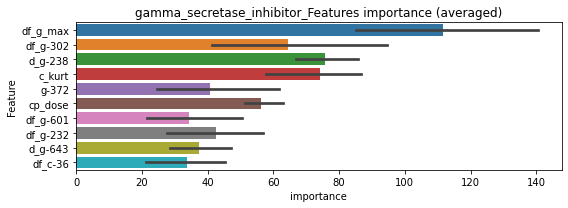

len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209639	valid_1's binary_logloss: 0.0552237
[200]	training's binary_logloss: 0.00360641	valid_1's binary_logloss: 0.0343714


len(train_index) : 2459
len(valid_index) : 2459


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00156518	valid_1's binary_logloss: 0.0315794


================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026039	valid_1's binary_logloss: 0.0547136
[200]	training's binary_logloss: 0.00458786	valid_1's binary_logloss: 0.0288501
[300]	training's binary_logloss: 0.00133831	valid_1's binary_logloss: 0.0229699
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00104232	valid_1's binary_logloss: 0.0224076


gamma_secretase_inhibitor logloss: 0.026993520634643175
glucocorticoid_receptor_agonist , len(trt) : 266


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208525	valid_1's binary_logloss: 0.573281
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.143619	valid_1's binary_logloss: 0.553722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213554	valid_1's binary_logloss: 0.580612
[200]	training's binary_logloss: 0.0816014	valid_1's binary_logloss: 0.554146


1 / 3 AUC score:0.781
Threshold: 0.5041280348787028


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0537249	valid_1's binary_logloss: 0.54796


Remove_noisy_labels: 302 → positive_corect_labels: 349/698
30th percentile: 0.35373
p_label_rate: 0.25716 Vs.target_rate: 0.00932, Num_p_label: 1024.0, conf_0:0.35373, conf_1:0.50413
Num_p_label: 1024.0, Expected: 37.1, Adj_threshold_1: 0.50
Num_p_label: 690.0, Expected: 37.1, Adj_threshold_2: 0.54
Num_p_label: 425.0, Expected: 37.1, Adj_threshold_3: 0.58
Num_p_label: 236.0, Expected: 37.1, Adj_threshold_4: 0.62
Num_p_label: 114.0, Expected: 37.1, Adj_threshold_5: 0.66
Num_p_label: 55.0, Expected: 37.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:55.0/3982, p_label_rate: 0.01381
positive y_label:349.0/698, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182699	valid_1's binary_logloss: 0.502558
[200]	training's binary_logloss: 0.0626352	valid_1's binary_logloss: 0.455415
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0684179	valid_1's binary_logloss: 0.454442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185303	valid_1's binary_logloss: 0.486177
[200]	training's binary_logloss: 0.0612888	valid_1's binary_logloss: 0.420159


2 / 3 AUC score:0.883
Threshold: 0.704128034878703
Remove_noisy_labels: 138 → positive_corect_labels: 227.0/560
30th percentile: 0.28942
p_label_rate: 0.07986 Vs.target_rate: 0.00932, Num_p_label: 318.0, conf_0:0.28942, conf_1:0.70413
Num_p_label: 318.0, Expected: 37.1, Adj_threshold_1: 0.70
Num_p_label: 193.0, Expected: 37.1, Adj_threshold_2: 0.74
Num_p_label: 109.0, Expected: 37.1, Adj_threshold_3: 0.78
Num_p_label: 42.0, Expected: 37.1, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:42.0/3982, p_label_rate: 0.01055


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0395702	valid_1's binary_logloss: 0.409361


positive y_label:227.0/560, y_label_rate: 0.40536
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16174	valid_1's binary_logloss: 0.384559
[200]	training's binary_logloss: 0.052208	valid_1's binary_logloss: 0.307712
[300]	training's binary_logloss: 0.0204497	valid_1's binary_logloss: 0.276152
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0157085	valid_1's binary_logloss: 0.273312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157126	valid_1's binary_logloss: 0.401243
[200]	training's binary_logloss: 0.0506994	valid_1's binary_logloss: 0.32488


3 / 3 AUC score:0.948
Threshold: 0.8241280348787031
Remove_noisy_labels: 92 → positive_corect_labels: 135.0/468
30th percentile: 0.10747
p_label_rate: 0.00779 Vs.target_rate: 0.00932, Num_p_label: 31.0, conf_0:0.08292, conf_1:0.82413
threshold:0.82, positive p_label:31.0/3982, p_label_rate: 0.00779


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0251803	valid_1's binary_logloss: 0.289396


positive y_label:166.0/4450, y_label_rate: 0.03730


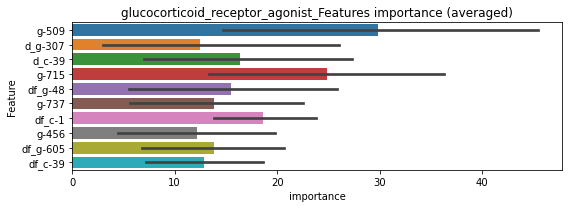

len(train_index) : 2225
len(valid_index) : 2225
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138764	valid_1's binary_logloss: 0.100523


len(train_index) : 2225
len(valid_index) : 2225
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0128431	valid_1's binary_logloss: 0.0999468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141312	valid_1's binary_logloss: 0.101583


glucocorticoid_receptor_agonist logloss: 0.10069181746453164
glutamate_inhibitor , len(trt) : 13


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0128267	valid_1's binary_logloss: 0.101437
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528207	valid_1's binary_logloss: 0.0759921
[200]	training's binary_logloss: 0.0077934	valid_1's binary_logloss: 0.0165248
[300]	training's binary_logloss: 0.0024864	valid_1's binary_logloss: 0.00704708
[400]	training's binary_logloss: 0.00140215	valid_1's binary_logloss: 0.00470276
[500]	training's binary_logloss: 0.00114957	valid_1's binary_logloss: 0.0039981
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00113941	valid_1's binary_logloss: 0.00395741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509394	valid_1's binary_logloss: 0.0737737
[200]	training's binary_logloss: 0.00745402	valid_1's binary_logloss: 0.0200258
[300]	training's binary_logloss: 0.00244004	valid_1's binary_logloss: 0.00999888
[400]	training's binary_logloss: 0.00139724	valid_1's binary_logloss: 0.00748458
Early stopping, best iteration is:
[457]	t

1 / 3 AUC score:1.000
Threshold: 0.7321545996712417
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00138
p_label_rate: 0.00000 Vs.target_rate: 0.00059, Num_p_label: 0.0, conf_0:0.00138, conf_1:0.73215
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_1: 0.73
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_2: 0.69
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_3: 0.65
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_4: 0.61
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_5: 0.57
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_6: 0.53
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_7: 0.49
Num_p_label: 1.0, Expected: 2.4, Adj_threshold_8: 0.45
Num_p_label: 1.0, Expected: 2.4, Adj_threshold_9: 0.41
Num_p_label: 1.0, Expected: 2.4, Adj_threshold_10: 0.37
threshold:0.33, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528207	valid_1's binary_logloss: 0.0759921
[200]	training's binary_logloss: 0.0077934	valid_1's binary_logloss: 0.0165248
[300]	training's binary_logloss: 0.0024864	valid_1's binary_logloss: 0.00704708
[400]	training's binary_logloss: 0.00140215	valid_1's binary_logloss: 0.00470276
[500]	training's binary_logloss: 0.00114957	valid_1's binary_logloss: 0.0039981
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00113941	valid_1's binary_logloss: 0.00395741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509394	valid_1's binary_logloss: 0.0737737
[200]	training's binary_logloss: 0.00745402	valid_1's binary_logloss: 0.0200258
[300]	training's binary_logloss: 0.00244004	valid_1's binary_logloss: 0.00999888
[400]	training's binary_logloss: 0.00139724	valid_1's binary_logloss: 0.00748458
Early stopping, best iteration is:
[457]	t

2 / 3 AUC score:1.000
Threshold: 0.33215459967124167
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00138
p_label_rate: 0.00050 Vs.target_rate: 0.00059, Num_p_label: 2.0, conf_0:0.00138, conf_1:0.33215
threshold:0.33, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535337	valid_1's binary_logloss: 0.0770758
[200]	training's binary_logloss: 0.00787635	valid_1's binary_logloss: 0.0166536
[300]	training's binary_logloss: 0.00254128	valid_1's binary_logloss: 0.00739429
[400]	training's binary_logloss: 0.00142746	valid_1's binary_logloss: 0.00503132
[500]	training's binary_logloss: 0.00116944	valid_1's binary_logloss: 0.00433736
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00116944	valid_1's binary_logloss: 0.00433736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502092	valid_1's binary_logloss: 0.0835183
[200]	training's binary_logloss: 0.00732852	valid_1's binary_logloss: 0.0225468
[300]	training's binary_logloss: 0.00240371	valid_1's binary_logloss: 0.0109108
[400]	training's binary_logloss: 0.00137701	valid_1's binary_logloss: 0.00744581
Early stopping, best iteration is:
[461]

3 / 3 AUC score:1.000
Threshold: 0.33215459967124167
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00142
p_label_rate: 0.00075 Vs.target_rate: 0.00059, Num_p_label: 3.0, conf_0:0.00142, conf_1:0.33215
threshold:0.33, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4981, y_label_rate: 0.10098


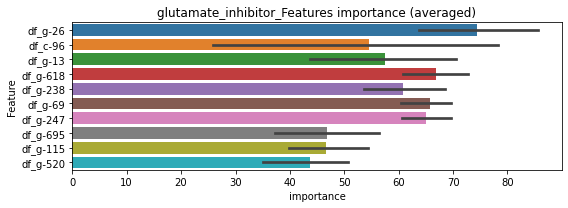

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134338	valid_1's binary_logloss: 0.0213048
[200]	training's binary_logloss: 0.00149913	valid_1's binary_logloss: 0.00619847
[300]	training's binary_logloss: 0.000434499	valid_1's binary_logloss: 0.00386569
[400]	training's binary_logloss: 0.000243708	valid_1's binary_logloss: 0.00343138
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000227562	valid_1's binary_logloss: 0.00339658


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130373	valid_1's binary_logloss: 0.0208973
[200]	training's binary_logloss: 0.00144422	valid_1's binary_logloss: 0.00832568
[300]	training's binary_logloss: 0.000416193	valid_1's binary_logloss: 0.00671552


glutamate_inhibitor logloss: 0.004956416888993771


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000257128	valid_1's binary_logloss: 0.00651688


glutamate_receptor_agonist , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138458	valid_1's binary_logloss: 0.304
[200]	training's binary_logloss: 0.0385414	valid_1's binary_logloss: 0.189024
[300]	training's binary_logloss: 0.0134495	valid_1's binary_logloss: 0.142914
[400]	training's binary_logloss: 0.00651461	valid_1's binary_logloss: 0.124552
[500]	training's binary_logloss: 0.00406141	valid_1's binary_logloss: 0.115079
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00369189	valid_1's binary_logloss: 0.113468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142021	valid_1's binary_logloss: 0.305252
[200]	training's binary_logloss: 0.0400782	valid_1's binary_logloss: 0.19505
[300]	training's binary_logloss: 0.0141932	valid_1's binary_logloss: 0.148525
[400]	training's binary_logloss: 0.00682081	valid_1's binary_logloss: 0.128123
[500]	training's binary_logloss: 0.00422876	valid_1's binary_logl

1 / 3 AUC score:0.992
Threshold: 0.45933880700703167
Remove_noisy_labels: 40 → positive_corect_labels: 480/960
30th percentile: 0.03303
p_label_rate: 0.01683 Vs.target_rate: 0.00319, Num_p_label: 67.0, conf_0:0.03303, conf_1:0.50614
Num_p_label: 67.0, Expected: 12.7, Adj_threshold_1: 0.46
Num_p_label: 47.0, Expected: 12.7, Adj_threshold_2: 0.50
Num_p_label: 33.0, Expected: 12.7, Adj_threshold_3: 0.54
Num_p_label: 22.0, Expected: 12.7, Adj_threshold_4: 0.58
Num_p_label: 17.0, Expected: 12.7, Adj_threshold_5: 0.62
threshold:0.62, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133871	valid_1's binary_logloss: 0.287463
[200]	training's binary_logloss: 0.0369219	valid_1's binary_logloss: 0.179921
[300]	training's binary_logloss: 0.0129281	valid_1's binary_logloss: 0.134463
[400]	training's binary_logloss: 0.00627582	valid_1's binary_logloss: 0.11877
[500]	training's binary_logloss: 0.00387007	valid_1's binary_logloss: 0.108663
[600]	training's binary_logloss: 0.00282668	valid_1's binary_logloss: 0.101885
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00270822	valid_1's binary_logloss: 0.101076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131487	valid_1's binary_logloss: 0.285617
[200]	training's binary_logloss: 0.034583	valid_1's binary_logloss: 0.174357
[300]	training's binary_logloss: 0.0121234	valid_1's binary_logloss: 0.132615
[400]	training's binary_logloss: 0.00592254	valid_1's binary_lo

2 / 3 AUC score:0.992
Threshold: 0.6193388070070317
Remove_noisy_labels: 34 → positive_corect_labels: 453.0/926
30th percentile: 0.02521
p_label_rate: 0.01281 Vs.target_rate: 0.00319, Num_p_label: 51.0, conf_0:0.02521, conf_1:0.61934
Num_p_label: 51.0, Expected: 12.7, Adj_threshold_1: 0.62
Num_p_label: 40.0, Expected: 12.7, Adj_threshold_2: 0.66
Num_p_label: 31.0, Expected: 12.7, Adj_threshold_3: 0.70
Num_p_label: 25.0, Expected: 12.7, Adj_threshold_4: 0.74
Num_p_label: 17.0, Expected: 12.7, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:453.0/926, y_label_rate: 0.48920
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12065	valid_1's binary_logloss: 0.273345
[200]	training's binary_logloss: 0.0305366	valid_1's binary_logloss: 0.173125
[300]	training's binary_logloss: 0.0105069	valid_1's binary_logloss: 0.135193
[400]	training's binary_logloss: 0.00527674	valid_1's binary_logloss: 0.119778
[500]	training's binary_logloss: 0.00336414	valid_1's binary_logloss: 0.113161
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00348627	valid_1's binary_logloss: 0.112596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126187	valid_1's binary_logloss: 0.276764
[200]	training's binary_logloss: 0.0327744	valid_1's binary_logloss: 0.165414
[300]	training's binary_logloss: 0.011304	valid_1's binary_logloss: 0.122581
[400]	training's binary_logloss: 0.00554845	valid_1's binary_logloss: 0.106562
[500]	training's binary_logloss: 0.00350001	valid_1's binary_lo

3 / 3 AUC score:0.992
Threshold: 0.7793388070070318
Remove_noisy_labels: 38 → positive_corect_labels: 416.0/888
30th percentile: 0.02326
p_label_rate: 0.00954 Vs.target_rate: 0.00319, Num_p_label: 38.0, conf_0:0.01949, conf_1:0.77934
threshold:0.78, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:454.0/4870, y_label_rate: 0.09322


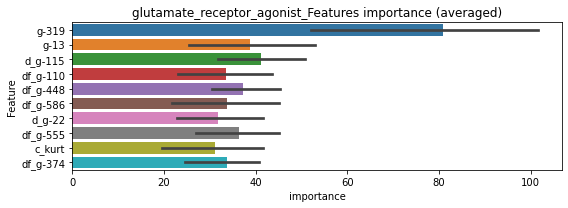

len(train_index) : 2435
len(valid_index) : 2435
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347274	valid_1's binary_logloss: 0.0819253
[200]	training's binary_logloss: 0.00683935	valid_1's binary_logloss: 0.0510569
[300]	training's binary_logloss: 0.00199608	valid_1's binary_logloss: 0.0435343
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00111288	valid_1's binary_logloss: 0.0423754


len(train_index) : 2435
len(valid_index) : 2435
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311849	valid_1's binary_logloss: 0.0762457
[200]	training's binary_logloss: 0.00634208	valid_1's binary_logloss: 0.049657
[300]	training's binary_logloss: 0.00187427	valid_1's binary_logloss: 0.0433506
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00187427	valid_1's binary_logloss: 0.0433506


glutamate_receptor_agonist logloss: 0.04286299351414066
glutamate_receptor_antagonist , len(trt) : 367


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.350394	valid_1's binary_logloss: 0.674703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223828	valid_1's binary_logloss: 0.650086


1 / 3 AUC score:0.627
Threshold: 0.49955166979981114
Remove_noisy_labels: 418 → positive_corect_labels: 291/582
30th percentile: 0.43729
p_label_rate: 0.39829 Vs.target_rate: 0.01130, Num_p_label: 1586.0, conf_0:0.43729, conf_1:0.49955
Num_p_label: 1586.0, Expected: 45.0, Adj_threshold_1: 0.50
Num_p_label: 879.0, Expected: 45.0, Adj_threshold_2: 0.54
Num_p_label: 369.0, Expected: 45.0, Adj_threshold_3: 0.58
Num_p_label: 122.0, Expected: 45.0, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 45.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:29.0/3982, p_label_rate: 0.00728


Early stopping, best iteration is:
[108]	training's binary_logloss: 0.207365	valid_1's binary_logloss: 0.647885


positive y_label:291.0/582, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211795	valid_1's binary_logloss: 0.557972
[200]	training's binary_logloss: 0.0799816	valid_1's binary_logloss: 0.508632
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.042035	valid_1's binary_logloss: 0.4859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202198	valid_1's binary_logloss: 0.584869


2 / 3 AUC score:0.812
Threshold: 0.6595516697998113
Remove_noisy_labels: 157 → positive_corect_labels: 158.0/425
30th percentile: 0.33813
p_label_rate: 0.16876 Vs.target_rate: 0.01130, Num_p_label: 672.0, conf_0:0.33813, conf_1:0.65955
Num_p_label: 672.0, Expected: 45.0, Adj_threshold_1: 0.66
Num_p_label: 498.0, Expected: 45.0, Adj_threshold_2: 0.70
Num_p_label: 343.0, Expected: 45.0, Adj_threshold_3: 0.74


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.130725	valid_1's binary_logloss: 0.578075


Num_p_label: 239.0, Expected: 45.0, Adj_threshold_4: 0.78
Num_p_label: 121.0, Expected: 45.0, Adj_threshold_5: 0.82
Num_p_label: 51.0, Expected: 45.0, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:158.0/425, y_label_rate: 0.37176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156073	valid_1's binary_logloss: 0.413807
[200]	training's binary_logloss: 0.0513669	valid_1's binary_logloss: 0.34189
[300]	training's binary_logloss: 0.0204762	valid_1's binary_logloss: 0.312082
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0220136	valid_1's binary_logloss: 0.311588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171037	valid_1's binary_logloss: 0.431576


3 / 3 AUC score:0.921
Threshold: 0.8595516697998115
Remove_noisy_labels: 108 → positive_corect_labels: 50.0/317
30th percentile: 0.12894
p_label_rate: 0.03842 Vs.target_rate: 0.01130, Num_p_label: 153.0, conf_0:0.12894, conf_1:0.85955
Num_p_label: 153.0, Expected: 45.0, Adj_threshold_1: 0.86
Num_p_label: 90.0, Expected: 45.0, Adj_threshold_2: 0.90
Num_p_label: 24.0, Expected: 45.0, Adj_threshold_3: 0.94


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0955235	valid_1's binary_logloss: 0.389201


threshold:0.94, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:74.0/4299, y_label_rate: 0.01721


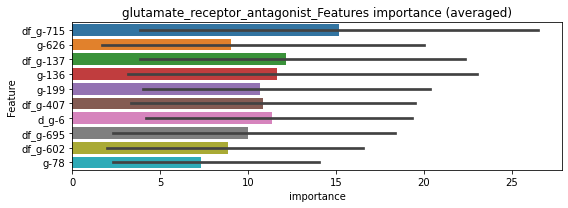

len(train_index) : 2149
len(valid_index) : 2150
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2150
len(valid_index) : 2149
================================= fold 2/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.0116582	valid_1's binary_logloss: 0.0603086
Training until validation scores don't improve for 10 rounds


glutamate_receptor_antagonist logloss: 0.06018669964014047
gonadotropin_receptor_agonist , len(trt) : 18


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.0109321	valid_1's binary_logloss: 0.0600648
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613583	valid_1's binary_logloss: 0.106595
[200]	training's binary_logloss: 0.0101686	valid_1's binary_logloss: 0.0343931
[300]	training's binary_logloss: 0.00334908	valid_1's binary_logloss: 0.0173195
[400]	training's binary_logloss: 0.00186008	valid_1's binary_logloss: 0.0124742
[500]	training's binary_logloss: 0.00140523	valid_1's binary_logloss: 0.0105057
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00135033	valid_1's binary_logloss: 0.0102145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617719	valid_1's binary_logloss: 0.10604
[200]	training's binary_logloss: 0.0101709	valid_1's binary_logloss: 0.0365662
[300]	training's binary_logloss: 0.0033129	valid_1's binary_logloss: 0.020221
[400]	training's binary_logloss: 0.0018249	valid_1's binary_logloss: 0.0142535
Early stopping, best iteration is:
[460]	training's b

1 / 3 AUC score:1.000
Threshold: 0.5455233480185797
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00230
p_label_rate: 0.00025 Vs.target_rate: 0.00082, Num_p_label: 1.0, conf_0:0.00230, conf_1:0.54552
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.55
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_2: 0.51
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_3: 0.47
threshold:0.47, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606105	valid_1's binary_logloss: 0.100129
[200]	training's binary_logloss: 0.0100436	valid_1's binary_logloss: 0.0300692
[300]	training's binary_logloss: 0.00330967	valid_1's binary_logloss: 0.0155383
[400]	training's binary_logloss: 0.00185366	valid_1's binary_logloss: 0.0112988
[500]	training's binary_logloss: 0.00142978	valid_1's binary_logloss: 0.00937646
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00141122	valid_1's binary_logloss: 0.00931479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0643167	valid_1's binary_logloss: 0.0962166
[200]	training's binary_logloss: 0.010689	valid_1's binary_logloss: 0.0283553
[300]	training's binary_logloss: 0.00341636	valid_1's binary_logloss: 0.0137347
[400]	training's binary_logloss: 0.00189583	valid_1's binary_logloss: 0.00952116
[500]	training's binary_logloss: 0.00141929	va

2 / 3 AUC score:1.000
Threshold: 0.4655233480185797
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
30th percentile: 0.00203
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00203, conf_1:0.46552
threshold:0.47, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639659	valid_1's binary_logloss: 0.0946715
[200]	training's binary_logloss: 0.0102745	valid_1's binary_logloss: 0.0246028
[300]	training's binary_logloss: 0.00338079	valid_1's binary_logloss: 0.0113861
[400]	training's binary_logloss: 0.00187296	valid_1's binary_logloss: 0.00774416
[500]	training's binary_logloss: 0.00142542	valid_1's binary_logloss: 0.00628987
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00138622	valid_1's binary_logloss: 0.006125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624153	valid_1's binary_logloss: 0.102093
[200]	training's binary_logloss: 0.010362	valid_1's binary_logloss: 0.0342699
[300]	training's binary_logloss: 0.00333999	valid_1's binary_logloss: 0.0185628
[400]	training's binary_logloss: 0.00185845	valid_1's binary_logloss: 0.0133414
[500]	training's binary_logloss: 0.00138446	vali

3 / 3 AUC score:1.000
Threshold: 0.4655233480185797
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
30th percentile: 0.00212
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00212, conf_1:0.46552
threshold:0.47, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:501.0/4979, y_label_rate: 0.10062


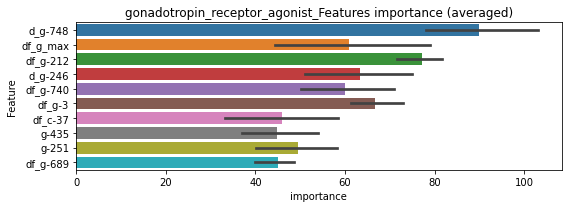

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168691	valid_1's binary_logloss: 0.0259767
[200]	training's binary_logloss: 0.00200647	valid_1's binary_logloss: 0.00827958
[300]	training's binary_logloss: 0.000570429	valid_1's binary_logloss: 0.00636618
[400]	training's binary_logloss: 0.000311098	valid_1's binary_logloss: 0.00578571
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000318343	valid_1's binary_logloss: 0.00576766


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170321	valid_1's binary_logloss: 0.0251251
[200]	training's binary_logloss: 0.00201423	valid_1's binary_logloss: 0.00687797
[300]	training's binary_logloss: 0.000579005	valid_1's binary_logloss: 0.00434623
[400]	training's binary_logloss: 0.000312334	valid_1's binary_logloss: 0.0038425
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000269786	valid_1's binary_logloss: 0.00369555


gonadotropin_receptor_agonist logloss: 0.0047318144706461965
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125215	valid_1's binary_logloss: 0.296532
[200]	training's binary_logloss: 0.0331541	valid_1's binary_logloss: 0.178662
[300]	training's binary_logloss: 0.0116276	valid_1's binary_logloss: 0.140481
[400]	training's binary_logloss: 0.00565011	valid_1's binary_logloss: 0.126806
[500]	training's binary_logloss: 0.00354958	valid_1's binary_logloss: 0.119746
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00363914	valid_1's binary_logloss: 0.119497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121367	valid_1's binary_logloss: 0.277458
[200]	training's binary_logloss: 0.0319288	valid_1's binary_logloss: 0.169378
[300]	training's binary_logloss: 0.0110619	valid_1's binary_logloss: 0.133935
[400]	training's binary_logloss: 0.00544271	valid_1's binary_logloss: 0.116126
[500]	training's binary_logloss: 0.00340911	valid_1's binary_

1 / 3 AUC score:0.990
Threshold: 0.5021252659155881
Remove_noisy_labels: 34 → positive_corect_labels: 483/966
30th percentile: 0.02646
p_label_rate: 0.00879 Vs.target_rate: 0.00262, Num_p_label: 35.0, conf_0:0.02137, conf_1:0.50213
Num_p_label: 35.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 10.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:483.0/966, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122616	valid_1's binary_logloss: 0.265378
[200]	training's binary_logloss: 0.0318656	valid_1's binary_logloss: 0.145165
[300]	training's binary_logloss: 0.0109939	valid_1's binary_logloss: 0.0957468
[400]	training's binary_logloss: 0.00536856	valid_1's binary_logloss: 0.0750284
[500]	training's binary_logloss: 0.00339098	valid_1's binary_logloss: 0.0662573
[600]	training's binary_logloss: 0.00251922	valid_1's binary_logloss: 0.0602755
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00244431	valid_1's binary_logloss: 0.0596015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121357	valid_1's binary_logloss: 0.25839
[200]	training's binary_logloss: 0.0305017	valid_1's binary_logloss: 0.144353
[300]	training's binary_logloss: 0.0104916	valid_1's binary_logloss: 0.102185
[400]	training's binary_logloss: 0.00518057	valid_1's bin

2 / 3 AUC score:0.999
Threshold: 0.6221252659155883
Remove_noisy_labels: 6 → positive_corect_labels: 479.0/960
30th percentile: 0.02129
p_label_rate: 0.00527 Vs.target_rate: 0.00262, Num_p_label: 21.0, conf_0:0.02129, conf_1:0.62213
threshold:0.62, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:479.0/960, y_label_rate: 0.49896
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121043	valid_1's binary_logloss: 0.239664
[200]	training's binary_logloss: 0.0312095	valid_1's binary_logloss: 0.126908
[300]	training's binary_logloss: 0.0106481	valid_1's binary_logloss: 0.0825517
[400]	training's binary_logloss: 0.00519342	valid_1's binary_logloss: 0.0654915
[500]	training's binary_logloss: 0.00330572	valid_1's binary_logloss: 0.0568397
[600]	training's binary_logloss: 0.00250652	valid_1's binary_logloss: 0.051644
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00232762	valid_1's binary_logloss: 0.0505546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123451	valid_1's binary_logloss: 0.242844
[200]	training's binary_logloss: 0.0312741	valid_1's binary_logloss: 0.129687
[300]	training's binary_logloss: 0.0108149	valid_1's binary_logloss: 0.0881667
[400]	training's binary_logloss: 0.00529572	valid_1's bi

3 / 3 AUC score:0.999
Threshold: 0.6221252659155883
Remove_noisy_labels: 9 → positive_corect_labels: 471.0/951
30th percentile: 0.01704
p_label_rate: 0.00377 Vs.target_rate: 0.00262, Num_p_label: 15.0, conf_0:0.01704, conf_1:0.62213
threshold:0.62, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:486.0/4933, y_label_rate: 0.09852


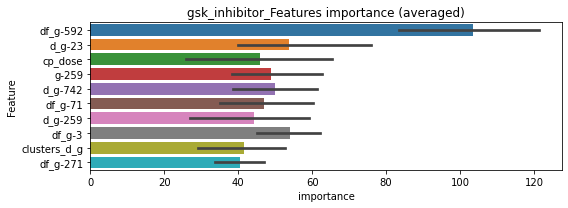

len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325386	valid_1's binary_logloss: 0.0874649
[200]	training's binary_logloss: 0.0065263	valid_1's binary_logloss: 0.0595165
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00268852	valid_1's binary_logloss: 0.055242


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324321	valid_1's binary_logloss: 0.0856507
[200]	training's binary_logloss: 0.00616667	valid_1's binary_logloss: 0.0543615
[300]	training's binary_logloss: 0.00178257	valid_1's binary_logloss: 0.0482948
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00097303	valid_1's binary_logloss: 0.0469249


gsk_inhibitor logloss: 0.05108429248832131
hcv_inhibitor , len(trt) : 72


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127843	valid_1's binary_logloss: 0.280791
[200]	training's binary_logloss: 0.0339328	valid_1's binary_logloss: 0.172633
[300]	training's binary_logloss: 0.0117721	valid_1's binary_logloss: 0.130428
[400]	training's binary_logloss: 0.00579882	valid_1's binary_logloss: 0.111767
[500]	training's binary_logloss: 0.00363781	valid_1's binary_logloss: 0.10226
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00285785	valid_1's binary_logloss: 0.0981179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128624	valid_1's binary_logloss: 0.292025
[200]	training's binary_logloss: 0.0341121	valid_1's binary_logloss: 0.190984
[300]	training's binary_logloss: 0.0121663	valid_1's binary_logloss: 0.159276
[400]	training's binary_logloss: 0.00591916	valid_1's binary_logloss: 0.143651
[500]	training's binary_logloss: 0.00372429	valid_1's binary_

1 / 3 AUC score:0.988
Threshold: 0.3875067237855956
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentile: 0.02969
p_label_rate: 0.03214 Vs.target_rate: 0.00311, Num_p_label: 128.0, conf_0:0.02969, conf_1:0.51322
Num_p_label: 128.0, Expected: 12.4, Adj_threshold_1: 0.39
Num_p_label: 86.0, Expected: 12.4, Adj_threshold_2: 0.43
Num_p_label: 59.0, Expected: 12.4, Adj_threshold_3: 0.47
Num_p_label: 41.0, Expected: 12.4, Adj_threshold_4: 0.51
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_5: 0.55
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_6: 0.59
Num_p_label: 9.0, Expected: 12.4, Adj_threshold_7: 0.63
threshold:0.63, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119946	valid_1's binary_logloss: 0.279458
[200]	training's binary_logloss: 0.0306928	valid_1's binary_logloss: 0.175819
[300]	training's binary_logloss: 0.0107141	valid_1's binary_logloss: 0.142139
[400]	training's binary_logloss: 0.00532023	valid_1's binary_logloss: 0.126246
[500]	training's binary_logloss: 0.00342714	valid_1's binary_logloss: 0.11977
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00314657	valid_1's binary_logloss: 0.118377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1245	valid_1's binary_logloss: 0.257958
[200]	training's binary_logloss: 0.0325039	valid_1's binary_logloss: 0.139547
[300]	training's binary_logloss: 0.0114806	valid_1's binary_logloss: 0.0995048
[400]	training's binary_logloss: 0.00563459	valid_1's binary_logloss: 0.0813973
[500]	training's binary_logloss: 0.00356545	valid_1's binary_l

2 / 3 AUC score:0.994
Threshold: 0.6275067237855957
Remove_noisy_labels: 31 → positive_corect_labels: 454.0/927
30th percentile: 0.02757
p_label_rate: 0.00904 Vs.target_rate: 0.00311, Num_p_label: 36.0, conf_0:0.02757, conf_1:0.62751
threshold:0.63, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:454.0/927, y_label_rate: 0.48975
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12216	valid_1's binary_logloss: 0.24713
[200]	training's binary_logloss: 0.0320484	valid_1's binary_logloss: 0.142678
[300]	training's binary_logloss: 0.0113375	valid_1's binary_logloss: 0.108604
[400]	training's binary_logloss: 0.00555253	valid_1's binary_logloss: 0.096657
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00400354	valid_1's binary_logloss: 0.0916489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118331	valid_1's binary_logloss: 0.26017
[200]	training's binary_logloss: 0.0301723	valid_1's binary_logloss: 0.153403
[300]	training's binary_logloss: 0.0103895	valid_1's binary_logloss: 0.113223
[400]	training's binary_logloss: 0.00514154	valid_1's binary_logloss: 0.0932492
[500]	training's binary_logloss: 0.00328747	valid_1's binary_logloss: 0.0839433
Early stopping, best iteration is:
[558]	training's binary_lo

3 / 3 AUC score:0.995
Threshold: 0.6275067237855957
Remove_noisy_labels: 24 → positive_corect_labels: 430.0/903
30th percentile: 0.02346
p_label_rate: 0.00728 Vs.target_rate: 0.00311, Num_p_label: 29.0, conf_0:0.02346, conf_1:0.62751
threshold:0.63, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:459.0/4885, y_label_rate: 0.09396


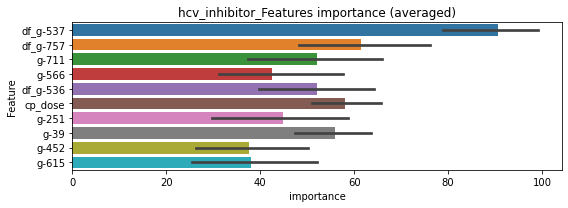

len(train_index) : 2442
len(valid_index) : 2443
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358174	valid_1's binary_logloss: 0.0803749
[200]	training's binary_logloss: 0.00669643	valid_1's binary_logloss: 0.0479928
[300]	training's binary_logloss: 0.00194498	valid_1's binary_logloss: 0.0416399
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00107027	valid_1's binary_logloss: 0.0406155


len(train_index) : 2443
len(valid_index) : 2442
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347533	valid_1's binary_logloss: 0.0889234
[200]	training's binary_logloss: 0.00659651	valid_1's binary_logloss: 0.0613767


hcv_inhibitor logloss: 0.04954577230840528


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00336404	valid_1's binary_logloss: 0.0584797


hdac_inhibitor , len(trt) : 106


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157156	valid_1's binary_logloss: 0.37795
[200]	training's binary_logloss: 0.0478445	valid_1's binary_logloss: 0.28584
[300]	training's binary_logloss: 0.0179958	valid_1's binary_logloss: 0.243059
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.010583	valid_1's binary_logloss: 0.229063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149761	valid_1's binary_logloss: 0.377297
[200]	training's binary_logloss: 0.0456536	valid_1's binary_logloss: 0.282727
[300]	training's binary_logloss: 0.0169579	valid_1's binary_logloss: 0.242171


1 / 3 AUC score:0.964
Threshold: 0.46208077467119923
Remove_noisy_labels: 92 → positive_corect_labels: 454/908
30th percentile: 0.08721


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00872999	valid_1's binary_logloss: 0.228569


p_label_rate: 0.06479 Vs.target_rate: 0.00442, Num_p_label: 258.0, conf_0:0.08721, conf_1:0.48571
Num_p_label: 258.0, Expected: 17.6, Adj_threshold_1: 0.46
Num_p_label: 194.0, Expected: 17.6, Adj_threshold_2: 0.50
Num_p_label: 142.0, Expected: 17.6, Adj_threshold_3: 0.54
Num_p_label: 100.0, Expected: 17.6, Adj_threshold_4: 0.58
Num_p_label: 71.0, Expected: 17.6, Adj_threshold_5: 0.62
Num_p_label: 41.0, Expected: 17.6, Adj_threshold_6: 0.66
Num_p_label: 19.0, Expected: 17.6, Adj_threshold_7: 0.70
threshold:0.70, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:454.0/908, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139383	valid_1's binary_logloss: 0.313903
[200]	training's binary_logloss: 0.0398115	valid_1's binary_logloss: 0.213917
[300]	training's binary_logloss: 0.0146956	valid_1's binary_logloss: 0.169903
[400]	training's binary_logloss: 0.00717342	valid_1's binary_logloss: 0.147589
[500]	training's binary_logloss: 0.00445964	valid_1's binary_logloss: 0.136625
[600]	training's binary_logloss: 0.00325236	valid_1's binary_logloss: 0.129466
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00315668	valid_1's binary_logloss: 0.12858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144536	valid_1's binary_logloss: 0.347202
[200]	training's binary_logloss: 0.0410054	valid_1's binary_logloss: 0.260154
[300]	training's binary_logloss: 0.0147683	valid_1's binary_logloss: 0.224392
Early stopping, best iteration is:
[318]	training's binary_log

2 / 3 AUC score:0.980
Threshold: 0.7020807746711994
Remove_noisy_labels: 56 → positive_corect_labels: 403.0/852
30th percentile: 0.05873
p_label_rate: 0.01808 Vs.target_rate: 0.00442, Num_p_label: 72.0, conf_0:0.05873, conf_1:0.70208
Num_p_label: 72.0, Expected: 17.6, Adj_threshold_1: 0.70
Num_p_label: 53.0, Expected: 17.6, Adj_threshold_2: 0.74
Num_p_label: 25.0, Expected: 17.6, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:403.0/852, y_label_rate: 0.47300
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133012	valid_1's binary_logloss: 0.289996
[200]	training's binary_logloss: 0.0373219	valid_1's binary_logloss: 0.18309
[300]	training's binary_logloss: 0.0135084	valid_1's binary_logloss: 0.137577
[400]	training's binary_logloss: 0.00666757	valid_1's binary_logloss: 0.119604
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00526008	valid_1's binary_logloss: 0.11493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131978	valid_1's binary_logloss: 0.308009
[200]	training's binary_logloss: 0.0360146	valid_1's binary_logloss: 0.213255
[300]	training's binary_logloss: 0.0130155	valid_1's binary_logloss: 0.173035
[400]	training's binary_logloss: 0.00642896	valid_1's binary_logloss: 0.155793


3 / 3 AUC score:0.989
Threshold: 0.7820807746711995
Remove_noisy_labels: 46 → positive_corect_labels: 357.0/806
30th percentile: 0.03489


Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00544742	valid_1's binary_logloss: 0.1521


p_label_rate: 0.00753 Vs.target_rate: 0.00442, Num_p_label: 30.0, conf_0:0.03489, conf_1:0.78208
threshold:0.78, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:387.0/4788, y_label_rate: 0.08083


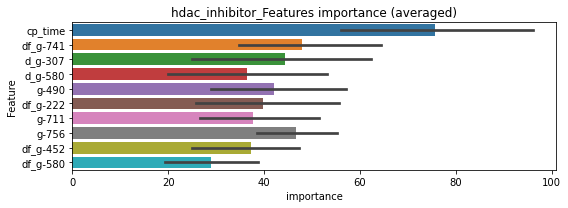

len(train_index) : 2394
len(valid_index) : 2394
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338162	valid_1's binary_logloss: 0.0939813
[200]	training's binary_logloss: 0.00710244	valid_1's binary_logloss: 0.0714294


len(train_index) : 2394


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00302476	valid_1's binary_logloss: 0.0687627


len(valid_index) : 2394
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033655	valid_1's binary_logloss: 0.0956986
[200]	training's binary_logloss: 0.00720402	valid_1's binary_logloss: 0.070747


hdac_inhibitor logloss: 0.06762643682829113


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00365497	valid_1's binary_logloss: 0.0664901


histamine_receptor_agonist , len(trt) : 59


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114619	valid_1's binary_logloss: 0.277171
[200]	training's binary_logloss: 0.0282001	valid_1's binary_logloss: 0.182428
[300]	training's binary_logloss: 0.00966407	valid_1's binary_logloss: 0.153265
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00673674	valid_1's binary_logloss: 0.146592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115689	valid_1's binary_logloss: 0.230443
[200]	training's binary_logloss: 0.0295985	valid_1's binary_logloss: 0.129107
[300]	training's binary_logloss: 0.0102143	valid_1's binary_logloss: 0.0935637
[400]	training's binary_logloss: 0.0050523	valid_1's binary_logloss: 0.0782677


1 / 3 AUC score:0.988
Threshold: 0.42321127256333213


Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00382445	valid_1's binary_logloss: 0.0731103


Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.03059
p_label_rate: 0.00703 Vs.target_rate: 0.00258, Num_p_label: 28.0, conf_0:0.03059, conf_1:0.44209
threshold:0.42, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10966	valid_1's binary_logloss: 0.232319
[200]	training's binary_logloss: 0.0265524	valid_1's binary_logloss: 0.124663
[300]	training's binary_logloss: 0.00913599	valid_1's binary_logloss: 0.0901928
[400]	training's binary_logloss: 0.00459369	valid_1's binary_logloss: 0.0777008
[500]	training's binary_logloss: 0.00297722	valid_1's binary_logloss: 0.0703352
[600]	training's binary_logloss: 0.00229885	valid_1's binary_logloss: 0.0673336
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00226087	valid_1's binary_logloss: 0.0669843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110165	valid_1's binary_logloss: 0.251239
[200]	training's binary_logloss: 0.0259009	valid_1's binary_logloss: 0.154885
[300]	training's binary_logloss: 0.00895572	valid_1's binary_logloss: 0.119848
[400]	training's binary_logloss: 0.00446017	valid_1's b

2 / 3 AUC score:0.995
Threshold: 0.42321127256333213
Remove_noisy_labels: 19 → positive_corect_labels: 470.0/953
30th percentile: 0.01684
p_label_rate: 0.01055 Vs.target_rate: 0.00258, Num_p_label: 42.0, conf_0:0.01182, conf_1:0.49310
Num_p_label: 42.0, Expected: 10.3, Adj_threshold_1: 0.42
Num_p_label: 31.0, Expected: 10.3, Adj_threshold_2: 0.46
Num_p_label: 23.0, Expected: 10.3, Adj_threshold_3: 0.50
Num_p_label: 18.0, Expected: 10.3, Adj_threshold_4: 0.54
Num_p_label: 9.0, Expected: 10.3, Adj_threshold_5: 0.58
threshold:0.58, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:470.0/953, y_label_rate: 0.49318
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107443	valid_1's binary_logloss: 0.214998
[200]	training's binary_logloss: 0.025772	valid_1's binary_logloss: 0.117032
[300]	training's binary_logloss: 0.00885972	valid_1's binary_logloss: 0.0793425
[400]	training's binary_logloss: 0.00440046	valid_1's binary_logloss: 0.0635245
[500]	training's binary_logloss: 0.0028926	valid_1's binary_logloss: 0.0555836
[600]	training's binary_logloss: 0.00224601	valid_1's binary_logloss: 0.0524846
[700]	training's binary_logloss: 0.00197269	valid_1's binary_logloss: 0.0506416
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.00195865	valid_1's binary_logloss: 0.0505472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111344	valid_1's binary_logloss: 0.236131
[200]	training's binary_logloss: 0.0262519	valid_1's binary_logloss: 0.125112
[300]	training's binary_logloss: 0.00904479	valid_1's b

3 / 3 AUC score:0.997
Threshold: 0.5832112725633322
Remove_noisy_labels: 14 → positive_corect_labels: 457.0/939
30th percentile: 0.01501
p_label_rate: 0.00201 Vs.target_rate: 0.00258, Num_p_label: 8.0, conf_0:0.01501, conf_1:0.58321
threshold:0.58, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:465.0/4921, y_label_rate: 0.09449


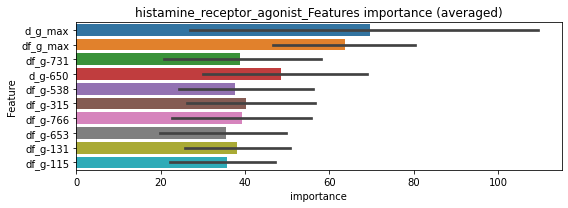

len(train_index) : 2460
len(valid_index) : 2461
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322513	valid_1's binary_logloss: 0.0667614
[200]	training's binary_logloss: 0.00656846	valid_1's binary_logloss: 0.0381782
[300]	training's binary_logloss: 0.0017263	valid_1's binary_logloss: 0.0309161
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00110973	valid_1's binary_logloss: 0.0295844


len(train_index) : 2461
len(valid_index) : 2460
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310714	valid_1's binary_logloss: 0.0585835
[200]	training's binary_logloss: 0.00595793	valid_1's binary_logloss: 0.030469
[300]	training's binary_logloss: 0.0016548	valid_1's binary_logloss: 0.0243047
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000902361	valid_1's binary_logloss: 0.023325


histamine_receptor_agonist logloss: 0.026455309660340005
histamine_receptor_antagonist , len(trt) : 241


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19879	valid_1's binary_logloss: 0.554528
[200]	training's binary_logloss: 0.0724663	valid_1's binary_logloss: 0.513583
[300]	training's binary_logloss: 0.0302913	valid_1's binary_logloss: 0.498493
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.028414	valid_1's binary_logloss: 0.497135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201218	valid_1's binary_logloss: 0.547571
[200]	training's binary_logloss: 0.0742979	valid_1's binary_logloss: 0.50013


1 / 3 AUC score:0.825
Threshold: 0.4714379767758762
Remove_noisy_labels: 254 → positive_corect_labels: 373/746
30th percentile: 0.29738
p_label_rate: 0.21723 Vs.target_rate: 0.00869, Num_p_label: 865.0, conf_0:0.29738, conf_1:0.48383
Num_p_label: 865.0, Expected: 34.6, Adj_threshold_1: 0.47
Num_p_label: 580.0, Expected: 34.6, Adj_threshold_2: 0.51
Num_p_label: 356.0, Expected: 34.6, Adj_threshold_3: 0.55


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0513106	valid_1's binary_logloss: 0.491834


Num_p_label: 204.0, Expected: 34.6, Adj_threshold_4: 0.59
Num_p_label: 103.0, Expected: 34.6, Adj_threshold_5: 0.63
Num_p_label: 52.0, Expected: 34.6, Adj_threshold_6: 0.67
Num_p_label: 24.0, Expected: 34.6, Adj_threshold_7: 0.71
threshold:0.71, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:373.0/746, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189033	valid_1's binary_logloss: 0.521141
[200]	training's binary_logloss: 0.0654009	valid_1's binary_logloss: 0.462699
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0535719	valid_1's binary_logloss: 0.451939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184965	valid_1's binary_logloss: 0.462152
[200]	training's binary_logloss: 0.0639536	valid_1's binary_logloss: 0.399564
[300]	training's binary_logloss: 0.0257613	valid_1's binary_logloss: 0.368731


2 / 3 AUC score:0.890
Threshold: 0.7114379767758764
Remove_noisy_labels: 131 → positive_corect_labels: 251.0/615
30th percentile: 0.27085
p_label_rate: 0.01934 Vs.target_rate: 0.00869, Num_p_label: 77.0, conf_0:0.27085, conf_1:0.71144
threshold:0.71, positive p_label:77.0/3982, p_label_rate: 0.01934


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0203052	valid_1's binary_logloss: 0.366039


positive y_label:251.0/615, y_label_rate: 0.40813
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15976	valid_1's binary_logloss: 0.478002
[200]	training's binary_logloss: 0.0506895	valid_1's binary_logloss: 0.404931
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.036407	valid_1's binary_logloss: 0.39694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15399	valid_1's binary_logloss: 0.430351


3 / 3 AUC score:0.891
Threshold: 0.7114379767758764
Remove_noisy_labels: 121 → positive_corect_labels: 132.0/494
30th percentile: 0.16611
p_label_rate: 0.00100 Vs.target_rate: 0.00869, Num_p_label: 4.0, conf_0:0.16611, conf_1:0.71144
Num_p_label: 4.0, Expected: 34.6, Adj_threshold_1: 0.71
Num_p_label: 11.0, Expected: 34.6, Adj_threshold_2: 0.67
Num_p_label: 30.0, Expected: 34.6, Adj_threshold_3: 0.63
threshold:0.63, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.087931	valid_1's binary_logloss: 0.390601


positive y_label:162.0/4476, y_label_rate: 0.03619


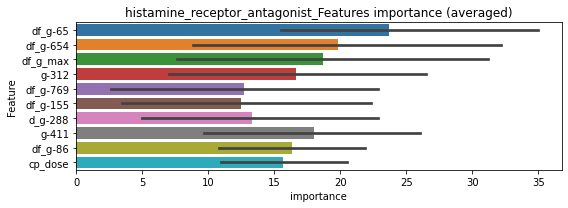

len(train_index) : 2238
len(valid_index) : 2238
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136919	valid_1's binary_logloss: 0.0896666


len(train_index) : 2238
len(valid_index) : 2238
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[108]	training's binary_logloss: 0.011746	valid_1's binary_logloss: 0.0894886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01409	valid_1's binary_logloss: 0.0778776


histamine_receptor_antagonist logloss: 0.08256731639479047


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.00767023	valid_1's binary_logloss: 0.075646
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                    

histone_lysine_demethylase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752122	valid_1's binary_logloss: 0.123171
[200]	training's binary_logloss: 0.014141	valid_1's binary_logloss: 0.0399671
[300]	training's binary_logloss: 0.00459873	valid_1's binary_logloss: 0.0210885
[400]	training's binary_logloss: 0.00244329	valid_1's binary_logloss: 0.015496
[500]	training's binary_logloss: 0.00175122	valid_1's binary_logloss: 0.0132152
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00165086	valid_1's binary_logloss: 0.0126995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739395	valid_1's binary_logloss: 0.130793
[200]	training's binary_logloss: 0.0136068	valid_1's binary_logloss: 0.0445778
[300]	training's binary_logloss: 0.00436279	valid_1's binary_logloss: 0.024039
[400]	training's binary_logloss: 0.00233498	valid_1's binary_logloss: 0.0170197
[500]	training's binary_logloss: 0.00168168	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.5112401240330688
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00347
p_label_rate: 0.00025 Vs.target_rate: 0.00108, Num_p_label: 1.0, conf_0:0.00347, conf_1:0.51124
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_1: 0.51
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_2: 0.47
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_3: 0.43
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_4: 0.39
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_5: 0.35
threshold:0.35, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754896	valid_1's binary_logloss: 0.129196
[200]	training's binary_logloss: 0.0134666	valid_1's binary_logloss: 0.045339
[300]	training's binary_logloss: 0.00432642	valid_1's binary_logloss: 0.0255657
[400]	training's binary_logloss: 0.00232185	valid_1's binary_logloss: 0.0193378
[500]	training's binary_logloss: 0.00166142	valid_1's binary_logloss: 0.0164598
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0015244	valid_1's binary_logloss: 0.0157357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075825	valid_1's binary_logloss: 0.128662
[200]	training's binary_logloss: 0.0135662	valid_1's binary_logloss: 0.0412468
[300]	training's binary_logloss: 0.00437687	valid_1's binary_logloss: 0.0210169
[400]	training's binary_logloss: 0.00233268	valid_1's binary_logloss: 0.0155845
[500]	training's binary_logloss: 0.001683	valid_1's 

2 / 3 AUC score:1.000
Threshold: 0.3512401240330689
Remove_noisy_labels: 3 → positive_corect_labels: 498.0/995
30th percentile: 0.00322
p_label_rate: 0.00226 Vs.target_rate: 0.00108, Num_p_label: 9.0, conf_0:0.00322, conf_1:0.40194
threshold:0.35, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07044	valid_1's binary_logloss: 0.132464
[200]	training's binary_logloss: 0.0128889	valid_1's binary_logloss: 0.0527165
[300]	training's binary_logloss: 0.00419683	valid_1's binary_logloss: 0.031736
[400]	training's binary_logloss: 0.00225296	valid_1's binary_logloss: 0.0246004
[500]	training's binary_logloss: 0.00165122	valid_1's binary_logloss: 0.0214647
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.0015714	valid_1's binary_logloss: 0.0209359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075838	valid_1's binary_logloss: 0.12874
[200]	training's binary_logloss: 0.0141895	valid_1's binary_logloss: 0.0492521
[300]	training's binary_logloss: 0.00453915	valid_1's binary_logloss: 0.0277805
[400]	training's binary_logloss: 0.00236307	valid_1's binary_logloss: 0.0201842
[500]	training's binary_logloss: 0.00167777	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.3512401240330689
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/993
30th percentile: 0.00308
p_label_rate: 0.00176 Vs.target_rate: 0.00108, Num_p_label: 7.0, conf_0:0.00308, conf_1:0.35124
threshold:0.35, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:503.0/4975, y_label_rate: 0.10111


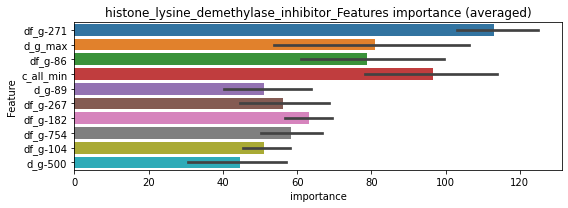

len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187183	valid_1's binary_logloss: 0.0309682
[200]	training's binary_logloss: 0.00244362	valid_1's binary_logloss: 0.0125274
[300]	training's binary_logloss: 0.000711408	valid_1's binary_logloss: 0.0112464
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000571551	valid_1's binary_logloss: 0.0111371


len(train_index) : 2488
len(valid_index) : 2487
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193082	valid_1's binary_logloss: 0.0336503
[200]	training's binary_logloss: 0.00266895	valid_1's binary_logloss: 0.0140245
[300]	training's binary_logloss: 0.000751108	valid_1's binary_logloss: 0.0117138
[400]	training's binary_logloss: 0.000392086	valid_1's binary_logloss: 0.0110443
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000392086	valid_1's binary_logloss: 0.0110443


histone_lysine_demethylase_inhibitor logloss: 0.011090706594224493
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893077	valid_1's binary_logloss: 0.156054
[200]	training's binary_logloss: 0.0182172	valid_1's binary_logloss: 0.0640101
[300]	training's binary_logloss: 0.00590017	valid_1's binary_logloss: 0.0387393
[400]	training's binary_logloss: 0.0029624	valid_1's binary_logloss: 0.0303403
[500]	training's binary_logloss: 0.00200092	valid_1's binary_logloss: 0.0270368
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00167498	valid_1's binary_logloss: 0.0249449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871662	valid_1's binary_logloss: 0.16631
[200]	training's binary_logloss: 0.0174658	valid_1's binary_logloss: 0.0630548
[300]	training's binary_logloss: 0.00567593	valid_1's binary_logloss: 0.0351842
[400]	training's binary_logloss: 0.00294741	valid_1's binary_logloss: 0.025361
[500]	training's binary_logloss: 0.00201371	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.5395739862083226
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00497
p_label_rate: 0.00100 Vs.target_rate: 0.00144, Num_p_label: 4.0, conf_0:0.00497, conf_1:0.53957
threshold:0.54, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883252	valid_1's binary_logloss: 0.163111
[200]	training's binary_logloss: 0.0180471	valid_1's binary_logloss: 0.0649936
[300]	training's binary_logloss: 0.00571301	valid_1's binary_logloss: 0.0380955
[400]	training's binary_logloss: 0.00294384	valid_1's binary_logloss: 0.0280949
[500]	training's binary_logloss: 0.00199537	valid_1's binary_logloss: 0.0241626
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00168133	valid_1's binary_logloss: 0.0218105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858865	valid_1's binary_logloss: 0.16066
[200]	training's binary_logloss: 0.0176194	valid_1's binary_logloss: 0.0681992
[300]	training's binary_logloss: 0.0056409	valid_1's binary_logloss: 0.0444522
[400]	training's binary_logloss: 0.00292333	valid_1's binary_logloss: 0.0351014
[500]	training's binary_logloss: 0.00198958	valid_1

2 / 3 AUC score:1.000
Threshold: 0.5395739862083226
Remove_noisy_labels: 5 → positive_corect_labels: 494.0/991
30th percentile: 0.00490
p_label_rate: 0.00201 Vs.target_rate: 0.00144, Num_p_label: 8.0, conf_0:0.00490, conf_1:0.53957
threshold:0.54, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/991, y_label_rate: 0.49849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862244	valid_1's binary_logloss: 0.159057
[200]	training's binary_logloss: 0.0174653	valid_1's binary_logloss: 0.0641168
[300]	training's binary_logloss: 0.00562366	valid_1's binary_logloss: 0.0397266
[400]	training's binary_logloss: 0.00282302	valid_1's binary_logloss: 0.030374
[500]	training's binary_logloss: 0.0019162	valid_1's binary_logloss: 0.0257951
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00164182	valid_1's binary_logloss: 0.024009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892568	valid_1's binary_logloss: 0.154411
[200]	training's binary_logloss: 0.0179082	valid_1's binary_logloss: 0.0589168
[300]	training's binary_logloss: 0.00574674	valid_1's binary_logloss: 0.0332724
[400]	training's binary_logloss: 0.0029006	valid_1's binary_logloss: 0.0246885
[500]	training's binary_logloss: 0.00197864	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.5395739862083226
Remove_noisy_labels: 2 → positive_corect_labels: 492.0/989
30th percentile: 0.00409
p_label_rate: 0.00276 Vs.target_rate: 0.00144, Num_p_label: 11.0, conf_0:0.00409, conf_1:0.53957
threshold:0.54, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:503.0/4971, y_label_rate: 0.10119


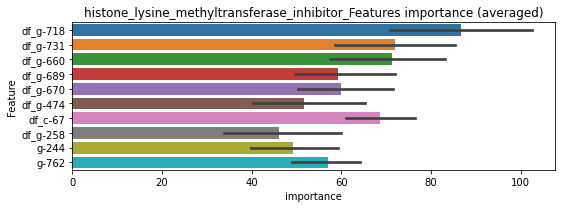

len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248956	valid_1's binary_logloss: 0.0510798
[200]	training's binary_logloss: 0.00340853	valid_1's binary_logloss: 0.0212828
[300]	training's binary_logloss: 0.000927698	valid_1's binary_logloss: 0.0172947
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000650046	valid_1's binary_logloss: 0.0167294


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025861	valid_1's binary_logloss: 0.0423892
[200]	training's binary_logloss: 0.00375663	valid_1's binary_logloss: 0.0168761
[300]	training's binary_logloss: 0.00102328	valid_1's binary_logloss: 0.0133124
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000660108	valid_1's binary_logloss: 0.0127098


histone_lysine_methyltransferase_inhibitor logloss: 0.014720025697064772
hiv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130646	valid_1's binary_logloss: 0.28999
[200]	training's binary_logloss: 0.0351202	valid_1's binary_logloss: 0.17938
[300]	training's binary_logloss: 0.0125235	valid_1's binary_logloss: 0.138225
[400]	training's binary_logloss: 0.00607151	valid_1's binary_logloss: 0.11807
[500]	training's binary_logloss: 0.00381233	valid_1's binary_logloss: 0.108768
[600]	training's binary_logloss: 0.00283392	valid_1's binary_logloss: 0.103011
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.0027523	valid_1's binary_logloss: 0.102638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130981	valid_1's binary_logloss: 0.271438
[200]	training's binary_logloss: 0.0358646	valid_1's binary_logloss: 0.157184
[300]	training's binary_logloss: 0.0128738	valid_1's binary_logloss: 0.114111
[400]	training's binary_logloss: 0.00631016	valid_1's binary_logl

1 / 3 AUC score:0.993
Threshold: 0.4899530172783445
Remove_noisy_labels: 24 → positive_corect_labels: 488/976
30th percentile: 0.02814
p_label_rate: 0.02411 Vs.target_rate: 0.00311, Num_p_label: 96.0, conf_0:0.01956, conf_1:0.51836
Num_p_label: 96.0, Expected: 12.4, Adj_threshold_1: 0.49
Num_p_label: 68.0, Expected: 12.4, Adj_threshold_2: 0.53
Num_p_label: 44.0, Expected: 12.4, Adj_threshold_3: 0.57
Num_p_label: 32.0, Expected: 12.4, Adj_threshold_4: 0.61
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_5: 0.65
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124579	valid_1's binary_logloss: 0.27999
[200]	training's binary_logloss: 0.032171	valid_1's binary_logloss: 0.16645
[300]	training's binary_logloss: 0.011407	valid_1's binary_logloss: 0.119911
[400]	training's binary_logloss: 0.00556062	valid_1's binary_logloss: 0.101815
[500]	training's binary_logloss: 0.00352254	valid_1's binary_logloss: 0.0922837
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00323823	valid_1's binary_logloss: 0.090488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134218	valid_1's binary_logloss: 0.270236
[200]	training's binary_logloss: 0.0368028	valid_1's binary_logloss: 0.144751
[300]	training's binary_logloss: 0.0131898	valid_1's binary_logloss: 0.0999472
[400]	training's binary_logloss: 0.00637601	valid_1's binary_logloss: 0.0806455
[500]	training's binary_logloss: 0.00394317	valid_1's binary_l

2 / 3 AUC score:0.998
Threshold: 0.6899530172783447
Remove_noisy_labels: 16 → positive_corect_labels: 473.0/960
30th percentile: 0.02790
p_label_rate: 0.01005 Vs.target_rate: 0.00311, Num_p_label: 40.0, conf_0:0.01891, conf_1:0.68995
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_1: 0.69
Num_p_label: 31.0, Expected: 12.4, Adj_threshold_2: 0.73
Num_p_label: 22.0, Expected: 12.4, Adj_threshold_3: 0.77
Num_p_label: 10.0, Expected: 12.4, Adj_threshold_4: 0.81
threshold:0.81, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:473.0/960, y_label_rate: 0.49271
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127893	valid_1's binary_logloss: 0.282712
[200]	training's binary_logloss: 0.0344867	valid_1's binary_logloss: 0.166321
[300]	training's binary_logloss: 0.0121667	valid_1's binary_logloss: 0.121396
[400]	training's binary_logloss: 0.00596957	valid_1's binary_logloss: 0.101805
[500]	training's binary_logloss: 0.00373085	valid_1's binary_logloss: 0.0945165
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.0030267	valid_1's binary_logloss: 0.0900039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127374	valid_1's binary_logloss: 0.278764
[200]	training's binary_logloss: 0.0334785	valid_1's binary_logloss: 0.163203
[300]	training's binary_logloss: 0.0116965	valid_1's binary_logloss: 0.114622
[400]	training's binary_logloss: 0.00570929	valid_1's binary_logloss: 0.0933111
[500]	training's binary_logloss: 0.0036201	valid_1's binary

3 / 3 AUC score:0.996
Threshold: 0.8099530172783448
Remove_noisy_labels: 31 → positive_corect_labels: 443.0/929
30th percentile: 0.02403
p_label_rate: 0.00452 Vs.target_rate: 0.00311, Num_p_label: 18.0, conf_0:0.01296, conf_1:0.80995
threshold:0.81, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:461.0/4911, y_label_rate: 0.09387


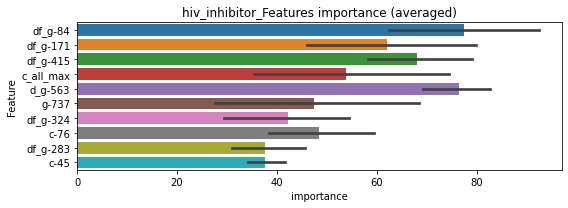

len(train_index) : 2455
len(valid_index) : 2456
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375996	valid_1's binary_logloss: 0.084982
[200]	training's binary_logloss: 0.00825175	valid_1's binary_logloss: 0.048883
[300]	training's binary_logloss: 0.00230545	valid_1's binary_logloss: 0.0387351
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00126354	valid_1's binary_logloss: 0.0371682


len(train_index) : 2456
len(valid_index) : 2455
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032257	valid_1's binary_logloss: 0.0938147
[200]	training's binary_logloss: 0.00668081	valid_1's binary_logloss: 0.0734771


hiv_inhibitor logloss: 0.054291885946635386


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00413961	valid_1's binary_logloss: 0.0714226


hmgcr_inhibitor , len(trt) : 283


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204485	valid_1's binary_logloss: 0.596657
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.159363	valid_1's binary_logloss: 0.588154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212674	valid_1's binary_logloss: 0.581748


1 / 3 AUC score:0.753
Threshold: 0.5067669677362829
Remove_noisy_labels: 340 → positive_corect_labels: 330/660
30th percentile: 0.36701
p_label_rate: 0.24787 Vs.target_rate: 0.00971, Num_p_label: 987.0, conf_0:0.36701, conf_1:0.50677
Num_p_label: 987.0, Expected: 38.7, Adj_threshold_1: 0.51
Num_p_label: 562.0, Expected: 38.7, Adj_threshold_2: 0.55
Num_p_label: 290.0, Expected: 38.7, Adj_threshold_3: 0.59
Num_p_label: 137.0, Expected: 38.7, Adj_threshold_4: 0.63
Num_p_label: 63.0, Expected: 38.7, Adj_threshold_5: 0.67
Num_p_label: 19.0, Expected: 38.7, Adj_threshold_6: 0.71


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.105604	valid_1's binary_logloss: 0.56301


threshold:0.71, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:330.0/660, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174764	valid_1's binary_logloss: 0.518245
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.189976	valid_1's binary_logloss: 0.517156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191084	valid_1's binary_logloss: 0.481124
[200]	training's binary_logloss: 0.0676774	valid_1's binary_logloss: 0.414099


2 / 3 AUC score:0.872
Threshold: 0.7067669677362831
Remove_noisy_labels: 153 → positive_corect_labels: 183.0/507
30th percentile: 0.28342
p_label_rate: 0.04696 Vs.target_rate: 0.00971, Num_p_label: 187.0, conf_0:0.28342, conf_1:0.70677
Num_p_label: 187.0, Expected: 38.7, Adj_threshold_1: 0.71


Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0478469	valid_1's binary_logloss: 0.393526


Num_p_label: 114.0, Expected: 38.7, Adj_threshold_2: 0.75
Num_p_label: 60.0, Expected: 38.7, Adj_threshold_3: 0.79
Num_p_label: 19.0, Expected: 38.7, Adj_threshold_4: 0.83
threshold:0.83, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:183.0/507, y_label_rate: 0.36095
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138619	valid_1's binary_logloss: 0.367325
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0569619	valid_1's binary_logloss: 0.321463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137048	valid_1's binary_logloss: 0.393185


3 / 3 AUC score:0.927
Threshold: 0.8267669677362832
Remove_noisy_labels: 113 → positive_corect_labels: 70.0/394
30th percentile: 0.10314
p_label_rate: 0.00301 Vs.target_rate: 0.00971, Num_p_label: 12.0, conf_0:0.10314, conf_1:0.82677
Num_p_label: 12.0, Expected: 38.7, Adj_threshold_1: 0.83
Num_p_label: 24.0, Expected: 38.7, Adj_threshold_2: 0.79
Num_p_label: 46.0, Expected: 38.7, Adj_threshold_3: 0.75
threshold:0.75, positive p_label:46.0/3982, p_label_rate: 0.01155


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0629431	valid_1's binary_logloss: 0.347845


positive y_label:116.0/4376, y_label_rate: 0.02651


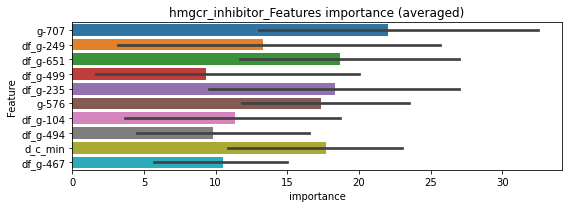

len(train_index) : 2188
len(valid_index) : 2188
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2188
len(valid_index) : 2188
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.0124554	valid_1's binary_logloss: 0.0703707
Training until validation scores don't improve for 10 rounds


hmgcr_inhibitor logloss: 0.07200558040642703
hsp_inhibitor , len(trt) : 93


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.0113543	valid_1's binary_logloss: 0.0736404
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144228	valid_1's binary_logloss: 0.326789
[200]	training's binary_logloss: 0.0416122	valid_1's binary_logloss: 0.227973
[300]	training's binary_logloss: 0.0152676	valid_1's binary_logloss: 0.185778
[400]	training's binary_logloss: 0.00741984	valid_1's binary_logloss: 0.165977
[500]	training's binary_logloss: 0.00454321	valid_1's binary_logloss: 0.157934
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00412887	valid_1's binary_logloss: 0.154987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148261	valid_1's binary_logloss: 0.344417
[200]	training's binary_logloss: 0.0427768	valid_1's binary_logloss: 0.253933
[300]	training's binary_logloss: 0.0156429	valid_1's binary_logloss: 0.220828


1 / 3 AUC score:0.977
Threshold: 0.4894732966762201
Remove_noisy_labels: 60 → positive_corect_labels: 470/940
30th percentile: 0.05646


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00841174	valid_1's binary_logloss: 0.205197


p_label_rate: 0.04119 Vs.target_rate: 0.00393, Num_p_label: 164.0, conf_0:0.05646, conf_1:0.55818
Num_p_label: 164.0, Expected: 15.7, Adj_threshold_1: 0.49
Num_p_label: 131.0, Expected: 15.7, Adj_threshold_2: 0.53
Num_p_label: 96.0, Expected: 15.7, Adj_threshold_3: 0.57
Num_p_label: 67.0, Expected: 15.7, Adj_threshold_4: 0.61
Num_p_label: 56.0, Expected: 15.7, Adj_threshold_5: 0.65
Num_p_label: 38.0, Expected: 15.7, Adj_threshold_6: 0.69
Num_p_label: 28.0, Expected: 15.7, Adj_threshold_7: 0.73
Num_p_label: 21.0, Expected: 15.7, Adj_threshold_8: 0.77
threshold:0.77, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:470.0/940, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131824	valid_1's binary_logloss: 0.319393
[200]	training's binary_logloss: 0.0356456	valid_1's binary_logloss: 0.227625
[300]	training's binary_logloss: 0.0129088	valid_1's binary_logloss: 0.190172
[400]	training's binary_logloss: 0.00628063	valid_1's binary_logloss: 0.174597
[500]	training's binary_logloss: 0.00390722	valid_1's binary_logloss: 0.165187
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00383077	valid_1's binary_logloss: 0.164664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133096	valid_1's binary_logloss: 0.30739
[200]	training's binary_logloss: 0.0372376	valid_1's binary_logloss: 0.214266
[300]	training's binary_logloss: 0.0130929	valid_1's binary_logloss: 0.175519
[400]	training's binary_logloss: 0.00643286	valid_1's binary_logloss: 0.159885
Early stopping, best iteration is:
[408]	training's binary_log

2 / 3 AUC score:0.983
Threshold: 0.7694732966762203
Remove_noisy_labels: 69 → positive_corect_labels: 407.0/871
30th percentile: 0.03943
p_label_rate: 0.02034 Vs.target_rate: 0.00393, Num_p_label: 81.0, conf_0:0.03943, conf_1:0.76947
Num_p_label: 81.0, Expected: 15.7, Adj_threshold_1: 0.77
Num_p_label: 69.0, Expected: 15.7, Adj_threshold_2: 0.81
Num_p_label: 48.0, Expected: 15.7, Adj_threshold_3: 0.85
Num_p_label: 28.0, Expected: 15.7, Adj_threshold_4: 0.89
Num_p_label: 14.0, Expected: 15.7, Adj_threshold_5: 0.93
threshold:0.93, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:407.0/871, y_label_rate: 0.46728
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128909	valid_1's binary_logloss: 0.252995
[200]	training's binary_logloss: 0.0354723	valid_1's binary_logloss: 0.138465
[300]	training's binary_logloss: 0.0125601	valid_1's binary_logloss: 0.0958241
[400]	training's binary_logloss: 0.00616409	valid_1's binary_logloss: 0.0792568
[500]	training's binary_logloss: 0.00388513	valid_1's binary_logloss: 0.0713909
[600]	training's binary_logloss: 0.00288343	valid_1's binary_logloss: 0.0670458
[700]	training's binary_logloss: 0.00242083	valid_1's binary_logloss: 0.0650019
Early stopping, best iteration is:
[776]	training's binary_logloss: 0.00225065	valid_1's binary_logloss: 0.0644762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12802	valid_1's binary_logloss: 0.301627
[200]	training's binary_logloss: 0.0330832	valid_1's binary_logloss: 0.202096
[300]	training's binary_logloss: 0.0115508	valid_1's bi

3 / 3 AUC score:0.992
Threshold: 0.9294732966762205
Remove_noisy_labels: 71 → positive_corect_labels: 337.0/800
30th percentile: 0.02273
p_label_rate: 0.00527 Vs.target_rate: 0.00393, Num_p_label: 21.0, conf_0:0.01415, conf_1:0.92947
threshold:0.93, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:358.0/4782, y_label_rate: 0.07486


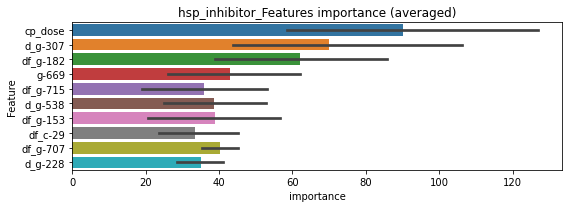

len(train_index) : 2391
len(valid_index) : 2391
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282995	valid_1's binary_logloss: 0.082988
[200]	training's binary_logloss: 0.00558448	valid_1's binary_logloss: 0.0590029
[300]	training's binary_logloss: 0.00171387	valid_1's binary_logloss: 0.0540151
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0017441	valid_1's binary_logloss: 0.0538654


len(train_index) : 2391
len(valid_index) : 2391
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245257	valid_1's binary_logloss: 0.0837998
[200]	training's binary_logloss: 0.00504234	valid_1's binary_logloss: 0.0663398
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00276697	valid_1's binary_logloss: 0.0649812


hsp_inhibitor logloss: 0.059423316876847425
igf-1_inhibitor , len(trt) : 37


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991366	valid_1's binary_logloss: 0.216109
[200]	training's binary_logloss: 0.0221566	valid_1's binary_logloss: 0.129631
[300]	training's binary_logloss: 0.0073573	valid_1's binary_logloss: 0.110049
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00507029	valid_1's binary_logloss: 0.106924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994925	valid_1's binary_logloss: 0.197286
[200]	training's binary_logloss: 0.0219461	valid_1's binary_logloss: 0.08858
[300]	training's binary_logloss: 0.00719724	valid_1's binary_logloss: 0.055017
[400]	training's binary_logloss: 0.00364137	valid_1's binary_logloss: 0.0432522
[500]	training's binary_logloss: 0.00243721	valid_1's binary_logloss: 0.0382254
[600]	training's binary_logloss: 0.00195463	valid_1's binary_logloss: 0.0357147
Early stopping, best iteration is:
[615]	training's bina

1 / 3 AUC score:0.993
Threshold: 0.28507554950673764
Remove_noisy_labels: 24 → positive_corect_labels: 488/976
30th percentile: 0.01431
p_label_rate: 0.01055 Vs.target_rate: 0.00165, Num_p_label: 42.0, conf_0:0.01431, conf_1:0.33414
Num_p_label: 42.0, Expected: 6.6, Adj_threshold_1: 0.29
Num_p_label: 24.0, Expected: 6.6, Adj_threshold_2: 0.33
Num_p_label: 17.0, Expected: 6.6, Adj_threshold_3: 0.37
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_4: 0.41
threshold:0.41, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967485	valid_1's binary_logloss: 0.181349
[200]	training's binary_logloss: 0.0214354	valid_1's binary_logloss: 0.081165
[300]	training's binary_logloss: 0.00700197	valid_1's binary_logloss: 0.0475958
[400]	training's binary_logloss: 0.00356598	valid_1's binary_logloss: 0.0351877
[500]	training's binary_logloss: 0.00237034	valid_1's binary_logloss: 0.0295206
[600]	training's binary_logloss: 0.00190872	valid_1's binary_logloss: 0.0266899
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.00190195	valid_1's binary_logloss: 0.0266305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972075	valid_1's binary_logloss: 0.189045
[200]	training's binary_logloss: 0.0213004	valid_1's binary_logloss: 0.0831344
[300]	training's binary_logloss: 0.00710927	valid_1's binary_logloss: 0.0512525
[400]	training's binary_logloss: 0.00360723	valid_

2 / 3 AUC score:1.000
Threshold: 0.4050755495067376
Remove_noisy_labels: 3 → positive_corect_labels: 486.0/973
30th percentile: 0.00788
p_label_rate: 0.00352 Vs.target_rate: 0.00165, Num_p_label: 14.0, conf_0:0.00788, conf_1:0.40508
threshold:0.41, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:486.0/973, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954735	valid_1's binary_logloss: 0.189142
[200]	training's binary_logloss: 0.0213752	valid_1's binary_logloss: 0.0811896
[300]	training's binary_logloss: 0.00702871	valid_1's binary_logloss: 0.0466566
[400]	training's binary_logloss: 0.00355839	valid_1's binary_logloss: 0.0342533
[500]	training's binary_logloss: 0.00237619	valid_1's binary_logloss: 0.0293397
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00193104	valid_1's binary_logloss: 0.0265844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983572	valid_1's binary_logloss: 0.179924
[200]	training's binary_logloss: 0.0218939	valid_1's binary_logloss: 0.0753921
[300]	training's binary_logloss: 0.00740474	valid_1's binary_logloss: 0.0442969
[400]	training's binary_logloss: 0.00368147	valid_1's binary_logloss: 0.0328392
[500]	training's binary_logloss: 0.00244647	valid

3 / 3 AUC score:1.000
Threshold: 0.4050755495067376
Remove_noisy_labels: 2 → positive_corect_labels: 486.0/971
30th percentile: 0.00876
p_label_rate: 0.00352 Vs.target_rate: 0.00165, Num_p_label: 14.0, conf_0:0.00876, conf_1:0.40508
threshold:0.41, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:500.0/4953, y_label_rate: 0.10095


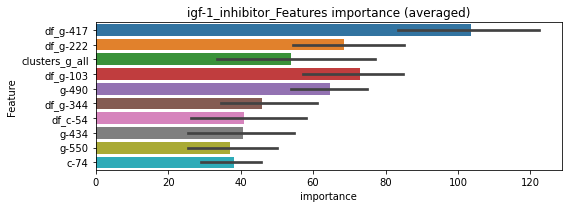

len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311413	valid_1's binary_logloss: 0.0619369
[200]	training's binary_logloss: 0.00531004	valid_1's binary_logloss: 0.0299309
[300]	training's binary_logloss: 0.00141294	valid_1's binary_logloss: 0.0239175
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00103425	valid_1's binary_logloss: 0.0232463


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298974	valid_1's binary_logloss: 0.061201
[200]	training's binary_logloss: 0.00469957	valid_1's binary_logloss: 0.0316693
[300]	training's binary_logloss: 0.00130983	valid_1's binary_logloss: 0.0253924
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000896754	valid_1's binary_logloss: 0.0244279


igf-1_inhibitor logloss: 0.02383697984589693
ikk_inhibitor , len(trt) : 30


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845234	valid_1's binary_logloss: 0.160058
[200]	training's binary_logloss: 0.0165079	valid_1's binary_logloss: 0.070348
[300]	training's binary_logloss: 0.00524548	valid_1's binary_logloss: 0.046163
[400]	training's binary_logloss: 0.00271129	valid_1's binary_logloss: 0.0382321
[500]	training's binary_logloss: 0.00187743	valid_1's binary_logloss: 0.0353094
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00161688	valid_1's binary_logloss: 0.0335755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084036	valid_1's binary_logloss: 0.181418
[200]	training's binary_logloss: 0.0162676	valid_1's binary_logloss: 0.093106
[300]	training's binary_logloss: 0.00514818	valid_1's binary_logloss: 0.0711302


1 / 3 AUC score:0.998
Threshold: 0.36748818862709903
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentile: 0.00529
p_label_rate: 0.01105 Vs.target_rate: 0.00135, Num_p_label: 44.0, conf_0:0.00529, conf_1:0.43659
Num_p_label: 44.0, Expected: 5.4, Adj_threshold_1: 0.37
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_2: 0.41
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_3: 0.45


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00331973	valid_1's binary_logloss: 0.0664494


Num_p_label: 20.0, Expected: 5.4, Adj_threshold_4: 0.49
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_5: 0.53
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_6: 0.57
Num_p_label: 4.0, Expected: 5.4, Adj_threshold_7: 0.61
threshold:0.61, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832743	valid_1's binary_logloss: 0.144833
[200]	training's binary_logloss: 0.0165437	valid_1's binary_logloss: 0.0545741
[300]	training's binary_logloss: 0.0053308	valid_1's binary_logloss: 0.0326267
[400]	training's binary_logloss: 0.00278556	valid_1's binary_logloss: 0.0258022
[500]	training's binary_logloss: 0.0019136	valid_1's binary_logloss: 0.0225926
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00163723	valid_1's binary_logloss: 0.0206107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804995	valid_1's binary_logloss: 0.151044
[200]	training's binary_logloss: 0.0154696	valid_1's binary_logloss: 0.0602503
[300]	training's binary_logloss: 0.00505252	valid_1's binary_logloss: 0.0371193
[400]	training's binary_logloss: 0.002623	valid_1's binary_logloss: 0.0295653


2 / 3 AUC score:1.000
Threshold: 0.6074881886270991
Remove_noisy_labels: 3 → positive_corect_labels: 492.0/983
30th percentile: 0.00372
p_label_rate: 0.00276 Vs.target_rate: 0.00135, Num_p_label: 11.0, conf_0:0.00372, conf_1:0.60749
threshold:0.61, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0020427	valid_1's binary_logloss: 0.0268339


positive y_label:492.0/983, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831224	valid_1's binary_logloss: 0.15344
[200]	training's binary_logloss: 0.0157978	valid_1's binary_logloss: 0.0608747
[300]	training's binary_logloss: 0.00508688	valid_1's binary_logloss: 0.0371212
[400]	training's binary_logloss: 0.00263592	valid_1's binary_logloss: 0.0286488
[500]	training's binary_logloss: 0.00182128	valid_1's binary_logloss: 0.0251387
[600]	training's binary_logloss: 0.0015412	valid_1's binary_logloss: 0.0236395
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00152707	valid_1's binary_logloss: 0.023524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804663	valid_1's binary_logloss: 0.151555
[200]	training's binary_logloss: 0.0155897	valid_1's binary_logloss: 0.0585194
[300]	training's binary_logloss: 0.00503555	valid_1's binary_logloss: 0.0349687
[400]	training's binary_logloss: 0.00265741	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.6074881886270991


Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00158947	valid_1's binary_logloss: 0.023275


Remove_noisy_labels: 5 → positive_corect_labels: 487.0/978
30th percentile: 0.00337
p_label_rate: 0.00151 Vs.target_rate: 0.00135, Num_p_label: 6.0, conf_0:0.00337, conf_1:0.60749
threshold:0.61, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:493.0/4960, y_label_rate: 0.09940


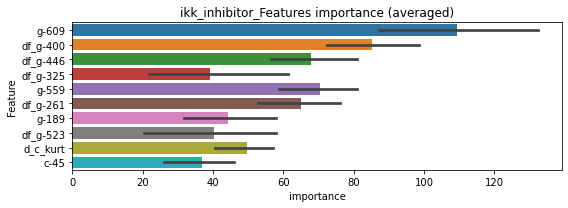

len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208033	valid_1's binary_logloss: 0.0427844
[200]	training's binary_logloss: 0.00298136	valid_1's binary_logloss: 0.0180537
[300]	training's binary_logloss: 0.000860613	valid_1's binary_logloss: 0.0137999
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000581756	valid_1's binary_logloss: 0.0132194


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219593	valid_1's binary_logloss: 0.0451633
[200]	training's binary_logloss: 0.00309248	valid_1's binary_logloss: 0.0184722
[300]	training's binary_logloss: 0.000884177	valid_1's binary_logloss: 0.0134555
[400]	training's binary_logloss: 0.000448371	valid_1's binary_logloss: 0.0125722
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000467317	valid_1's binary_logloss: 0.0124896


ikk_inhibitor logloss: 0.012854496847039092
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908767	valid_1's binary_logloss: 0.160341
[200]	training's binary_logloss: 0.0182644	valid_1's binary_logloss: 0.0606948
[300]	training's binary_logloss: 0.005906	valid_1's binary_logloss: 0.0334924
[400]	training's binary_logloss: 0.00300627	valid_1's binary_logloss: 0.0231937
[500]	training's binary_logloss: 0.00203072	valid_1's binary_logloss: 0.0193966
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00170776	valid_1's binary_logloss: 0.0173565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822423	valid_1's binary_logloss: 0.160945
[200]	training's binary_logloss: 0.0165167	valid_1's binary_logloss: 0.0680923
[300]	training's binary_logloss: 0.00538543	valid_1's binary_logloss: 0.0410782
[400]	training's binary_logloss: 0.00284387	valid_1's binary_logloss: 0.031255
[500]	training's binary_logloss: 0.00194902	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.4733287776556
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00431
p_label_rate: 0.00502 Vs.target_rate: 0.00139, Num_p_label: 20.0, conf_0:0.00431, conf_1:0.50913
Num_p_label: 20.0, Expected: 5.5, Adj_threshold_1: 0.47
Num_p_label: 15.0, Expected: 5.5, Adj_threshold_2: 0.51
Num_p_label: 11.0, Expected: 5.5, Adj_threshold_3: 0.55
Num_p_label: 7.0, Expected: 5.5, Adj_threshold_4: 0.59
threshold:0.59, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088463	valid_1's binary_logloss: 0.171442
[200]	training's binary_logloss: 0.0178824	valid_1's binary_logloss: 0.0703196
[300]	training's binary_logloss: 0.0057724	valid_1's binary_logloss: 0.0422127
[400]	training's binary_logloss: 0.00294557	valid_1's binary_logloss: 0.0325366
[500]	training's binary_logloss: 0.0020093	valid_1's binary_logloss: 0.0279128
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00170038	valid_1's binary_logloss: 0.0262667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846746	valid_1's binary_logloss: 0.168846
[200]	training's binary_logloss: 0.0166537	valid_1's binary_logloss: 0.0687171
[300]	training's binary_logloss: 0.00540704	valid_1's binary_logloss: 0.0403227
[400]	training's binary_logloss: 0.0028112	valid_1's binary_logloss: 0.0314419
[500]	training's binary_logloss: 0.00192644	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.5933287776556001


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00166369	valid_1's binary_logloss: 0.0244631


Remove_noisy_labels: 5 → positive_corect_labels: 496.0/993
30th percentile: 0.00419
p_label_rate: 0.00151 Vs.target_rate: 0.00139, Num_p_label: 6.0, conf_0:0.00419, conf_1:0.59333
threshold:0.59, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:496.0/993, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855715	valid_1's binary_logloss: 0.149097
[200]	training's binary_logloss: 0.0174045	valid_1's binary_logloss: 0.0591925
[300]	training's binary_logloss: 0.00563139	valid_1's binary_logloss: 0.0345273
[400]	training's binary_logloss: 0.00288255	valid_1's binary_logloss: 0.0264471
[500]	training's binary_logloss: 0.00196984	valid_1's binary_logloss: 0.0225982
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00167207	valid_1's binary_logloss: 0.0211008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848448	valid_1's binary_logloss: 0.16992
[200]	training's binary_logloss: 0.0171368	valid_1's binary_logloss: 0.0713752
[300]	training's binary_logloss: 0.00552981	valid_1's binary_logloss: 0.0418493
[400]	training's binary_logloss: 0.00285592	valid_1's binary_logloss: 0.0315302
[500]	training's binary_logloss: 0.00195303	valid_

3 / 3 AUC score:1.000
Threshold: 0.5933287776556001
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/991
30th percentile: 0.00449
p_label_rate: 0.00100 Vs.target_rate: 0.00139, Num_p_label: 4.0, conf_0:0.00449, conf_1:0.59333
threshold:0.59, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/4973, y_label_rate: 0.10034


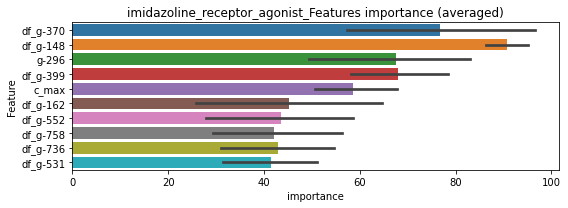

len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239349	valid_1's binary_logloss: 0.0429309
[200]	training's binary_logloss: 0.00362017	valid_1's binary_logloss: 0.0170553
[300]	training's binary_logloss: 0.000989603	valid_1's binary_logloss: 0.0114073
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000765872	valid_1's binary_logloss: 0.0107073


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245275	valid_1's binary_logloss: 0.040176
[200]	training's binary_logloss: 0.00353334	valid_1's binary_logloss: 0.0120998
[300]	training's binary_logloss: 0.000975441	valid_1's binary_logloss: 0.00700173
[400]	training's binary_logloss: 0.000484888	valid_1's binary_logloss: 0.00599851
[500]	training's binary_logloss: 0.000347749	valid_1's binary_logloss: 0.00570679
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000353868	valid_1's binary_logloss: 0.00570166


imidazoline_receptor_agonist logloss: 0.008204981086044321
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125695	valid_1's binary_logloss: 0.273062
[200]	training's binary_logloss: 0.0338049	valid_1's binary_logloss: 0.173409
[300]	training's binary_logloss: 0.0120261	valid_1's binary_logloss: 0.13535
[400]	training's binary_logloss: 0.00588417	valid_1's binary_logloss: 0.117415
[500]	training's binary_logloss: 0.00373371	valid_1's binary_logloss: 0.108899
[600]	training's binary_logloss: 0.00277807	valid_1's binary_logloss: 0.105621
[700]	training's binary_logloss: 0.00232191	valid_1's binary_logloss: 0.102239
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.00232191	valid_1's binary_logloss: 0.102239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122287	valid_1's binary_logloss: 0.28885
[200]	training's binary_logloss: 0.0324022	valid_1's binary_logloss: 0.192154
[300]	training's binary_logloss: 0.0114167	valid_1's binary_lo

1 / 3 AUC score:0.988
Threshold: 0.4739262008366232


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00414402	valid_1's binary_logloss: 0.139923


Remove_noisy_labels: 44 → positive_corect_labels: 478/956
30th percentile: 0.02679
p_label_rate: 0.01055 Vs.target_rate: 0.00315, Num_p_label: 42.0, conf_0:0.02679, conf_1:0.50527
Num_p_label: 42.0, Expected: 12.5, Adj_threshold_1: 0.47
Num_p_label: 31.0, Expected: 12.5, Adj_threshold_2: 0.51
Num_p_label: 24.0, Expected: 12.5, Adj_threshold_3: 0.55
Num_p_label: 14.0, Expected: 12.5, Adj_threshold_4: 0.59
threshold:0.59, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:478.0/956, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116013	valid_1's binary_logloss: 0.257497
[200]	training's binary_logloss: 0.0290005	valid_1's binary_logloss: 0.15559
[300]	training's binary_logloss: 0.0102182	valid_1's binary_logloss: 0.116315
[400]	training's binary_logloss: 0.00513344	valid_1's binary_logloss: 0.103048
[500]	training's binary_logloss: 0.00328088	valid_1's binary_logloss: 0.0953592
[600]	training's binary_logloss: 0.00248914	valid_1's binary_logloss: 0.0913924
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00240962	valid_1's binary_logloss: 0.0905546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118842	valid_1's binary_logloss: 0.234306
[200]	training's binary_logloss: 0.0315853	valid_1's binary_logloss: 0.126923
[300]	training's binary_logloss: 0.0111469	valid_1's binary_logloss: 0.0876757
[400]	training's binary_logloss: 0.00549572	valid_1's bina

2 / 3 AUC score:0.997
Threshold: 0.5939262008366233
Remove_noisy_labels: 15 → positive_corect_labels: 465.0/941
30th percentile: 0.01755
p_label_rate: 0.00678 Vs.target_rate: 0.00315, Num_p_label: 27.0, conf_0:0.01755, conf_1:0.59393
threshold:0.59, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:465.0/941, y_label_rate: 0.49416
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114313	valid_1's binary_logloss: 0.243602
[200]	training's binary_logloss: 0.0289792	valid_1's binary_logloss: 0.13317
[300]	training's binary_logloss: 0.0102413	valid_1's binary_logloss: 0.0880949
[400]	training's binary_logloss: 0.00513416	valid_1's binary_logloss: 0.0713042
[500]	training's binary_logloss: 0.00332933	valid_1's binary_logloss: 0.0631135
[600]	training's binary_logloss: 0.00253735	valid_1's binary_logloss: 0.058303
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00233782	valid_1's binary_logloss: 0.0571554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109875	valid_1's binary_logloss: 0.255318
[200]	training's binary_logloss: 0.0274753	valid_1's binary_logloss: 0.157791
[300]	training's binary_logloss: 0.00981029	valid_1's binary_logloss: 0.124379
[400]	training's binary_logloss: 0.00494625	valid_1's bin

3 / 3 AUC score:0.995
Threshold: 0.5939262008366233


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00345202	valid_1's binary_logloss: 0.110236


Remove_noisy_labels: 23 → positive_corect_labels: 447.0/918
30th percentile: 0.01622
p_label_rate: 0.00477 Vs.target_rate: 0.00315, Num_p_label: 19.0, conf_0:0.01622, conf_1:0.59393
threshold:0.59, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:466.0/4900, y_label_rate: 0.09510


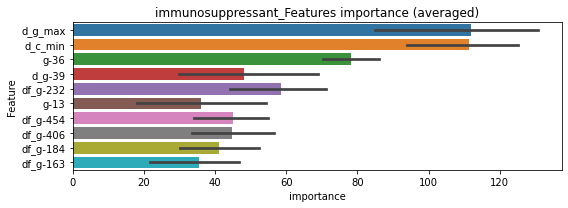

len(train_index) : 2450
len(valid_index) : 2450
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247036	valid_1's binary_logloss: 0.0773053
[200]	training's binary_logloss: 0.00468105	valid_1's binary_logloss: 0.0563366


len(train_index) : 2450
len(valid_index) : 2450


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00250103	valid_1's binary_logloss: 0.0548277


================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283209	valid_1's binary_logloss: 0.0656382
[200]	training's binary_logloss: 0.00544482	valid_1's binary_logloss: 0.0428259
[300]	training's binary_logloss: 0.00164076	valid_1's binary_logloss: 0.0384435
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00144752	valid_1's binary_logloss: 0.0383226


immunosuppressant logloss: 0.04657513572364058
insulin_secretagogue , len(trt) : 30


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880522	valid_1's binary_logloss: 0.170935
[200]	training's binary_logloss: 0.0178664	valid_1's binary_logloss: 0.0701335
[300]	training's binary_logloss: 0.0057175	valid_1's binary_logloss: 0.0423313
[400]	training's binary_logloss: 0.00289464	valid_1's binary_logloss: 0.0311475
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00208002	valid_1's binary_logloss: 0.0272262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879924	valid_1's binary_logloss: 0.172508
[200]	training's binary_logloss: 0.0180954	valid_1's binary_logloss: 0.0661346
[300]	training's binary_logloss: 0.00579185	valid_1's binary_logloss: 0.036875
[400]	training's binary_logloss: 0.00299327	valid_1's binary_logloss: 0.0263446
[500]	training's binary_logloss: 0.00204029	valid_1's binary_logloss: 0.0214639
Early stopping, best iteration is:
[585]	training's

1 / 3 AUC score:1.000
Threshold: 0.6081216647026733
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00511
p_label_rate: 0.00000 Vs.target_rate: 0.00135, Num_p_label: 0.0, conf_0:0.00511, conf_1:0.60812
Num_p_label: 0.0, Expected: 5.4, Adj_threshold_1: 0.61
Num_p_label: 1.0, Expected: 5.4, Adj_threshold_2: 0.57
Num_p_label: 1.0, Expected: 5.4, Adj_threshold_3: 0.53
Num_p_label: 1.0, Expected: 5.4, Adj_threshold_4: 0.49
Num_p_label: 2.0, Expected: 5.4, Adj_threshold_5: 0.45
Num_p_label: 5.0, Expected: 5.4, Adj_threshold_6: 0.41
threshold:0.41, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880522	valid_1's binary_logloss: 0.170935
[200]	training's binary_logloss: 0.0178664	valid_1's binary_logloss: 0.0701335
[300]	training's binary_logloss: 0.0057175	valid_1's binary_logloss: 0.0423313
[400]	training's binary_logloss: 0.00289464	valid_1's binary_logloss: 0.0311475
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00208002	valid_1's binary_logloss: 0.0272262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879924	valid_1's binary_logloss: 0.172508
[200]	training's binary_logloss: 0.0180954	valid_1's binary_logloss: 0.0661346
[300]	training's binary_logloss: 0.00579185	valid_1's binary_logloss: 0.036875
[400]	training's binary_logloss: 0.00299327	valid_1's binary_logloss: 0.0263446
[500]	training's binary_logloss: 0.00204029	valid_1's binary_logloss: 0.0214639
Early stopping, best iteration is:
[585]	training's

2 / 3 AUC score:1.000
Threshold: 0.40812166470267325
Remove_noisy_labels: 4 → positive_corect_labels: 500.0/996
30th percentile: 0.00511
p_label_rate: 0.00126 Vs.target_rate: 0.00135, Num_p_label: 5.0, conf_0:0.00511, conf_1:0.40812
threshold:0.41, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/996, y_label_rate: 0.50201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880496	valid_1's binary_logloss: 0.156791
[200]	training's binary_logloss: 0.0178752	valid_1's binary_logloss: 0.0566838
[300]	training's binary_logloss: 0.00577163	valid_1's binary_logloss: 0.0286133
[400]	training's binary_logloss: 0.00298797	valid_1's binary_logloss: 0.019755
[500]	training's binary_logloss: 0.00205676	valid_1's binary_logloss: 0.0158483
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0017834	valid_1's binary_logloss: 0.0142077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845799	valid_1's binary_logloss: 0.161612
[200]	training's binary_logloss: 0.0170389	valid_1's binary_logloss: 0.0635687
[300]	training's binary_logloss: 0.00558507	valid_1's binary_logloss: 0.0363954
[400]	training's binary_logloss: 0.00288131	valid_1's binary_logloss: 0.0271443
[500]	training's binary_logloss: 0.00198045	valid_1

3 / 3 AUC score:1.000
Threshold: 0.40812166470267325
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/996
30th percentile: 0.00465
p_label_rate: 0.00075 Vs.target_rate: 0.00135, Num_p_label: 3.0, conf_0:0.00465, conf_1:0.40812
threshold:0.41, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4978, y_label_rate: 0.10104


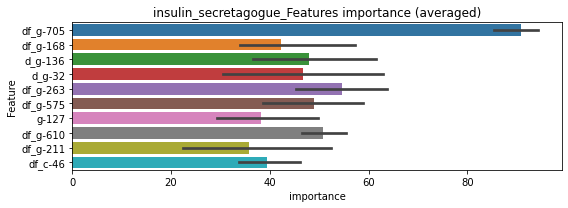

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232728	valid_1's binary_logloss: 0.0409232
[200]	training's binary_logloss: 0.00341672	valid_1's binary_logloss: 0.0166606
[300]	training's binary_logloss: 0.000957193	valid_1's binary_logloss: 0.0118135
[400]	training's binary_logloss: 0.000477241	valid_1's binary_logloss: 0.0103114
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000397977	valid_1's binary_logloss: 0.0100981


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229859	valid_1's binary_logloss: 0.0372457
[200]	training's binary_logloss: 0.00343934	valid_1's binary_logloss: 0.0128916
[300]	training's binary_logloss: 0.000947905	valid_1's binary_logloss: 0.00889812
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000560717	valid_1's binary_logloss: 0.00844762


insulin_secretagogue logloss: 0.009272883978139631
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111235	valid_1's binary_logloss: 0.231469
[200]	training's binary_logloss: 0.0267188	valid_1's binary_logloss: 0.1231
[300]	training's binary_logloss: 0.00905886	valid_1's binary_logloss: 0.0876397
[400]	training's binary_logloss: 0.00446757	valid_1's binary_logloss: 0.0750923
[500]	training's binary_logloss: 0.00286533	valid_1's binary_logloss: 0.0692258
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00295243	valid_1's binary_logloss: 0.0690917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109919	valid_1's binary_logloss: 0.2235
[200]	training's binary_logloss: 0.0262286	valid_1's binary_logloss: 0.123047
[300]	training's binary_logloss: 0.00880206	valid_1's binary_logloss: 0.0866519
[400]	training's binary_logloss: 0.00440314	valid_1's binary_logloss: 0.071593
[500]	training's binary_logloss: 0.00284584	valid_1's bina

1 / 3 AUC score:0.997
Threshold: 0.41921118053379625
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentile: 0.01582
p_label_rate: 0.01683 Vs.target_rate: 0.00225, Num_p_label: 67.0, conf_0:0.01226, conf_1:0.48271
Num_p_label: 67.0, Expected: 8.9, Adj_threshold_1: 0.42
Num_p_label: 46.0, Expected: 8.9, Adj_threshold_2: 0.46
Num_p_label: 34.0, Expected: 8.9, Adj_threshold_3: 0.50
Num_p_label: 27.0, Expected: 8.9, Adj_threshold_4: 0.54
Num_p_label: 20.0, Expected: 8.9, Adj_threshold_5: 0.58
Num_p_label: 10.0, Expected: 8.9, Adj_threshold_6: 0.62
threshold:0.62, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106717	valid_1's binary_logloss: 0.224536
[200]	training's binary_logloss: 0.0248855	valid_1's binary_logloss: 0.121501
[300]	training's binary_logloss: 0.00831253	valid_1's binary_logloss: 0.0843708
[400]	training's binary_logloss: 0.00415806	valid_1's binary_logloss: 0.0699012
[500]	training's binary_logloss: 0.0026885	valid_1's binary_logloss: 0.0631073
[600]	training's binary_logloss: 0.0020735	valid_1's binary_logloss: 0.058376
[700]	training's binary_logloss: 0.00185518	valid_1's binary_logloss: 0.0567907
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.00184479	valid_1's binary_logloss: 0.0566125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111832	valid_1's binary_logloss: 0.208852
[200]	training's binary_logloss: 0.0261372	valid_1's binary_logloss: 0.103672
[300]	training's binary_logloss: 0.00877427	valid_1's bi

2 / 3 AUC score:0.999
Threshold: 0.6192111805337963
Remove_noisy_labels: 11 → positive_corect_labels: 479.0/967
30th percentile: 0.01040
p_label_rate: 0.00477 Vs.target_rate: 0.00225, Num_p_label: 19.0, conf_0:0.00683, conf_1:0.61921
threshold:0.62, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:479.0/967, y_label_rate: 0.49535
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105887	valid_1's binary_logloss: 0.224583
[200]	training's binary_logloss: 0.024855	valid_1's binary_logloss: 0.116277
[300]	training's binary_logloss: 0.00836264	valid_1's binary_logloss: 0.0777028
[400]	training's binary_logloss: 0.00417802	valid_1's binary_logloss: 0.0633935
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00317988	valid_1's binary_logloss: 0.0570925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107027	valid_1's binary_logloss: 0.225238
[200]	training's binary_logloss: 0.0250476	valid_1's binary_logloss: 0.122243
[300]	training's binary_logloss: 0.00828548	valid_1's binary_logloss: 0.0832144
[400]	training's binary_logloss: 0.0040922	valid_1's binary_logloss: 0.0677476
[500]	training's binary_logloss: 0.00265993	valid_1's binary_logloss: 0.0602148
[600]	training's binary_logloss: 0.00206352	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.6192111805337963
Remove_noisy_labels: 6 → positive_corect_labels: 474.0/961
30th percentile: 0.01441
p_label_rate: 0.00578 Vs.target_rate: 0.00225, Num_p_label: 23.0, conf_0:0.01239, conf_1:0.61921
threshold:0.62, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:497.0/4943, y_label_rate: 0.10055


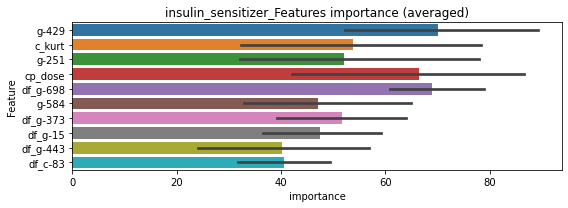

len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324286	valid_1's binary_logloss: 0.0697155
[200]	training's binary_logloss: 0.0058059	valid_1's binary_logloss: 0.040524
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00187453	valid_1's binary_logloss: 0.0361963


len(train_index) : 2472
len(valid_index) : 2471
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327052	valid_1's binary_logloss: 0.0784359
[200]	training's binary_logloss: 0.00610582	valid_1's binary_logloss: 0.0496143
[300]	training's binary_logloss: 0.00174809	valid_1's binary_logloss: 0.0424675
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00157283	valid_1's binary_logloss: 0.0423447


insulin_sensitizer logloss: 0.039269877104544576
integrin_inhibitor , len(trt) : 42


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994887	valid_1's binary_logloss: 0.174863
[200]	training's binary_logloss: 0.0218895	valid_1's binary_logloss: 0.0778503
[300]	training's binary_logloss: 0.00730822	valid_1's binary_logloss: 0.0518208
[400]	training's binary_logloss: 0.00359969	valid_1's binary_logloss: 0.0426279
[500]	training's binary_logloss: 0.00239077	valid_1's binary_logloss: 0.0382643
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00200856	valid_1's binary_logloss: 0.0368677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931809	valid_1's binary_logloss: 0.175474
[200]	training's binary_logloss: 0.0206732	valid_1's binary_logloss: 0.0827957
[300]	training's binary_logloss: 0.00686202	valid_1's binary_logloss: 0.0511252
[400]	training's binary_logloss: 0.00346299	valid_1's binary_logloss: 0.0409442
[500]	training's binary_logloss: 0.00230558	valid

1 / 3 AUC score:1.000
Threshold: 0.4205619582225389
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.00619
p_label_rate: 0.00703 Vs.target_rate: 0.00187, Num_p_label: 28.0, conf_0:0.00619, conf_1:0.49820
Num_p_label: 28.0, Expected: 7.4, Adj_threshold_1: 0.42
Num_p_label: 20.0, Expected: 7.4, Adj_threshold_2: 0.46
Num_p_label: 14.0, Expected: 7.4, Adj_threshold_3: 0.50
Num_p_label: 8.0, Expected: 7.4, Adj_threshold_4: 0.54
threshold:0.54, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918122	valid_1's binary_logloss: 0.192012
[200]	training's binary_logloss: 0.0195066	valid_1's binary_logloss: 0.102779
[300]	training's binary_logloss: 0.0064653	valid_1's binary_logloss: 0.074802
[400]	training's binary_logloss: 0.00324582	valid_1's binary_logloss: 0.0637424
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00331381	valid_1's binary_logloss: 0.063463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951904	valid_1's binary_logloss: 0.170907
[200]	training's binary_logloss: 0.0209095	valid_1's binary_logloss: 0.0807077
[300]	training's binary_logloss: 0.00695905	valid_1's binary_logloss: 0.0563138
[400]	training's binary_logloss: 0.00350919	valid_1's binary_logloss: 0.0465924
[500]	training's binary_logloss: 0.00233932	valid_1's binary_logloss: 0.0414677
[600]	training's binary_logloss: 0.00185954	valid_1's

2 / 3 AUC score:0.999
Threshold: 0.5405619582225389
Remove_noisy_labels: 14 → positive_corect_labels: 483.0/974
30th percentile: 0.00835
p_label_rate: 0.00402 Vs.target_rate: 0.00187, Num_p_label: 16.0, conf_0:0.00835, conf_1:0.54056
threshold:0.54, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:483.0/974, y_label_rate: 0.49589
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926748	valid_1's binary_logloss: 0.188534
[200]	training's binary_logloss: 0.0192711	valid_1's binary_logloss: 0.0942655
[300]	training's binary_logloss: 0.00635305	valid_1's binary_logloss: 0.0708742
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00635305	valid_1's binary_logloss: 0.0708742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913805	valid_1's binary_logloss: 0.167045
[200]	training's binary_logloss: 0.0193278	valid_1's binary_logloss: 0.0733258
[300]	training's binary_logloss: 0.00633874	valid_1's binary_logloss: 0.0455599
[400]	training's binary_logloss: 0.00327947	valid_1's binary_logloss: 0.0345134
[500]	training's binary_logloss: 0.00223626	valid_1's binary_logloss: 0.0300336
[600]	training's binary_logloss: 0.00181562	valid_1's binary_logloss: 0.0271944
Early stopping, best iteration is:
[656]	training

3 / 3 AUC score:0.999
Threshold: 0.5405619582225389
Remove_noisy_labels: 13 → positive_corect_labels: 471.0/961
30th percentile: 0.00932
p_label_rate: 0.00427 Vs.target_rate: 0.00187, Num_p_label: 17.0, conf_0:0.00932, conf_1:0.54056
threshold:0.54, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:488.0/4943, y_label_rate: 0.09873


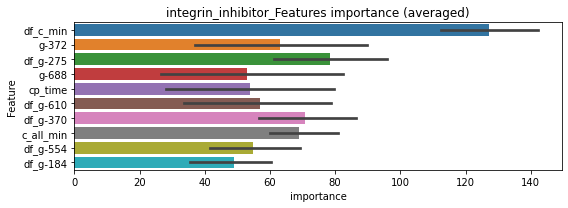

len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235201	valid_1's binary_logloss: 0.052277
[200]	training's binary_logloss: 0.00354067	valid_1's binary_logloss: 0.0321733


len(train_index) : 2472
len(valid_index) : 2471


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00144013	valid_1's binary_logloss: 0.0304893


================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226732	valid_1's binary_logloss: 0.0541369
[200]	training's binary_logloss: 0.00365711	valid_1's binary_logloss: 0.0343447


integrin_inhibitor logloss: 0.031280053427166554


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00184054	valid_1's binary_logloss: 0.0320712


jak_inhibitor , len(trt) : 92


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154186	valid_1's binary_logloss: 0.361275
[200]	training's binary_logloss: 0.046652	valid_1's binary_logloss: 0.254004
[300]	training's binary_logloss: 0.0171604	valid_1's binary_logloss: 0.2087
[400]	training's binary_logloss: 0.00826089	valid_1's binary_logloss: 0.187374
[500]	training's binary_logloss: 0.0049585	valid_1's binary_logloss: 0.175785
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00391542	valid_1's binary_logloss: 0.170977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155	valid_1's binary_logloss: 0.344418
[200]	training's binary_logloss: 0.0459578	valid_1's binary_logloss: 0.244089
[300]	training's binary_logloss: 0.0170237	valid_1's binary_logloss: 0.197139
[400]	training's binary_logloss: 0.00823887	valid_1's binary_logloss: 0.177098
[500]	training's binary_logloss: 0.00498976	valid_1's binary_logloss

1 / 3 AUC score:0.981
Threshold: 0.47195695431930584
Remove_noisy_labels: 58 → positive_corect_labels: 471/942
30th percentile: 0.05761
p_label_rate: 0.04018 Vs.target_rate: 0.00389, Num_p_label: 160.0, conf_0:0.05761, conf_1:0.52287
Num_p_label: 160.0, Expected: 15.5, Adj_threshold_1: 0.47
Num_p_label: 124.0, Expected: 15.5, Adj_threshold_2: 0.51
Num_p_label: 88.0, Expected: 15.5, Adj_threshold_3: 0.55
Num_p_label: 55.0, Expected: 15.5, Adj_threshold_4: 0.59
Num_p_label: 37.0, Expected: 15.5, Adj_threshold_5: 0.63
Num_p_label: 27.0, Expected: 15.5, Adj_threshold_6: 0.67
Num_p_label: 21.0, Expected: 15.5, Adj_threshold_7: 0.71
threshold:0.71, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:471.0/942, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136367	valid_1's binary_logloss: 0.351094
[200]	training's binary_logloss: 0.03836	valid_1's binary_logloss: 0.260112
[300]	training's binary_logloss: 0.0139467	valid_1's binary_logloss: 0.21871
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0107815	valid_1's binary_logloss: 0.212874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140893	valid_1's binary_logloss: 0.327613
[200]	training's binary_logloss: 0.0395637	valid_1's binary_logloss: 0.221663
[300]	training's binary_logloss: 0.014587	valid_1's binary_logloss: 0.175906
[400]	training's binary_logloss: 0.00718697	valid_1's binary_logloss: 0.159589
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00697779	valid_1's binary_logloss: 0.159337


2 / 3 AUC score:0.976
Threshold: 0.7119569543193061
Remove_noisy_labels: 67 → positive_corect_labels: 407.0/875
30th percentile: 0.06502
p_label_rate: 0.01582 Vs.target_rate: 0.00389, Num_p_label: 63.0, conf_0:0.06502, conf_1:0.71196
Num_p_label: 63.0, Expected: 15.5, Adj_threshold_1: 0.71
Num_p_label: 43.0, Expected: 15.5, Adj_threshold_2: 0.75
Num_p_label: 34.0, Expected: 15.5, Adj_threshold_3: 0.79
Num_p_label: 23.0, Expected: 15.5, Adj_threshold_4: 0.83
threshold:0.83, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:407.0/875, y_label_rate: 0.46514
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12906	valid_1's binary_logloss: 0.293809
[200]	training's binary_logloss: 0.0353348	valid_1's binary_logloss: 0.189264
[300]	training's binary_logloss: 0.0127687	valid_1's binary_logloss: 0.14554
[400]	training's binary_logloss: 0.00625289	valid_1's binary_logloss: 0.127952
[500]	training's binary_logloss: 0.00400868	valid_1's binary_logloss: 0.120383
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00307544	valid_1's binary_logloss: 0.115965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140388	valid_1's binary_logloss: 0.275994
[200]	training's binary_logloss: 0.0399753	valid_1's binary_logloss: 0.161447
[300]	training's binary_logloss: 0.0146397	valid_1's binary_logloss: 0.115184
[400]	training's binary_logloss: 0.00711552	valid_1's binary_logloss: 0.0934583
[500]	training's binary_logloss: 0.00440522	valid_1's binary_l

3 / 3 AUC score:0.997
Threshold: 0.8319569543193062
Remove_noisy_labels: 41 → positive_corect_labels: 366.0/834
30th percentile: 0.02638
p_label_rate: 0.00753 Vs.target_rate: 0.00389, Num_p_label: 30.0, conf_0:0.02638, conf_1:0.83196
threshold:0.83, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:396.0/4816, y_label_rate: 0.08223


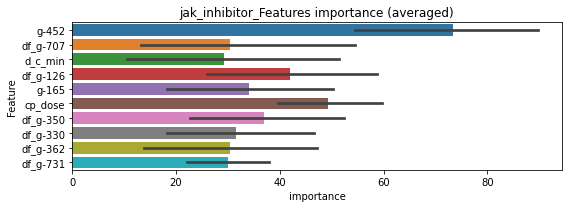

len(train_index) : 2408
len(valid_index) : 2408
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329436	valid_1's binary_logloss: 0.0901348
[200]	training's binary_logloss: 0.007264	valid_1's binary_logloss: 0.0666061
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00265246	valid_1's binary_logloss: 0.0619689


len(train_index) : 2408
len(valid_index) : 2408
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320972	valid_1's binary_logloss: 0.0821094
[200]	training's binary_logloss: 0.00695055	valid_1's binary_logloss: 0.0537257
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00231105	valid_1's binary_logloss: 0.0459774


jak_inhibitor logloss: 0.05397315271219278
kit_inhibitor , len(trt) : 273


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208642	valid_1's binary_logloss: 0.588743
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.11571	valid_1's binary_logloss: 0.571346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212944	valid_1's binary_logloss: 0.591523


1 / 3 AUC score:0.760
Threshold: 0.49842482509369324
Remove_noisy_labels: 312 → positive_corect_labels: 344/688
30th percentile: 0.36993
p_label_rate: 0.25590 Vs.target_rate: 0.00948, Num_p_label: 1019.0, conf_0:0.36993, conf_1:0.49842
Num_p_label: 1019.0, Expected: 37.8, Adj_threshold_1: 0.50
Num_p_label: 646.0, Expected: 37.8, Adj_threshold_2: 0.54
Num_p_label: 368.0, Expected: 37.8, Adj_threshold_3: 0.58
Num_p_label: 192.0, Expected: 37.8, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 37.8, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 37.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.146021	valid_1's binary_logloss: 0.573212


positive y_label:344.0/688, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191605	valid_1's binary_logloss: 0.462397
[200]	training's binary_logloss: 0.0687585	valid_1's binary_logloss: 0.406971
[300]	training's binary_logloss: 0.0277148	valid_1's binary_logloss: 0.368095
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0234956	valid_1's binary_logloss: 0.364326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179725	valid_1's binary_logloss: 0.492881
[200]	training's binary_logloss: 0.0611054	valid_1's binary_logloss: 0.43276
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0572614	valid_1's binary_logloss: 0.43075


2 / 3 AUC score:0.905
Threshold: 0.6984248250936934
Remove_noisy_labels: 136 → positive_corect_labels: 229.0/552
30th percentile: 0.25473
p_label_rate: 0.07233 Vs.target_rate: 0.00948, Num_p_label: 288.0, conf_0:0.25473, conf_1:0.69842
Num_p_label: 288.0, Expected: 37.8, Adj_threshold_1: 0.70
Num_p_label: 201.0, Expected: 37.8, Adj_threshold_2: 0.74
Num_p_label: 123.0, Expected: 37.8, Adj_threshold_3: 0.78
Num_p_label: 61.0, Expected: 37.8, Adj_threshold_4: 0.82
Num_p_label: 35.0, Expected: 37.8, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:229.0/552, y_label_rate: 0.41486
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160191	valid_1's binary_logloss: 0.415475
[200]	training's binary_logloss: 0.0516208	valid_1's binary_logloss: 0.32814
[300]	training's binary_logloss: 0.0206833	valid_1's binary_logloss: 0.296669
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0175212	valid_1's binary_logloss: 0.291413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158397	valid_1's binary_logloss: 0.394356
[200]	training's binary_logloss: 0.051318	valid_1's binary_logloss: 0.312889
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.041379	valid_1's binary_logloss: 0.302803


3 / 3 AUC score:0.942
Threshold: 0.8584248250936936
Remove_noisy_labels: 112 → positive_corect_labels: 117.0/440
30th percentile: 0.10385
p_label_rate: 0.00226 Vs.target_rate: 0.00948, Num_p_label: 9.0, conf_0:0.10385, conf_1:0.85842
Num_p_label: 9.0, Expected: 37.8, Adj_threshold_1: 0.86
Num_p_label: 25.0, Expected: 37.8, Adj_threshold_2: 0.82
Num_p_label: 48.0, Expected: 37.8, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:165.0/4422, y_label_rate: 0.03731


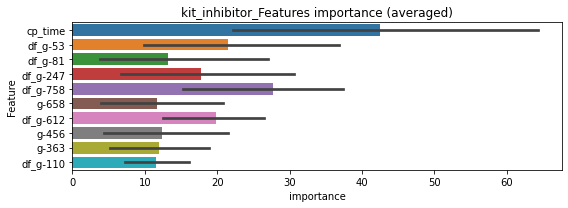

len(train_index) : 2211
len(valid_index) : 2211
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155324	valid_1's binary_logloss: 0.0999935


len(train_index) : 2211
len(valid_index) : 2211
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[117]	training's binary_logloss: 0.0114181	valid_1's binary_logloss: 0.0993917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148547	valid_1's binary_logloss: 0.108085


kit_inhibitor logloss: 0.10294559263168228
laxative , len(trt) : 6


Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0128392	valid_1's binary_logloss: 0.106499
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376714	valid_1's binary_logloss: 0.0475302
[200]	training's binary_logloss: 0.00438724	valid_1's binary_logloss: 0.00798716
[300]	training's binary_logloss: 0.00140802	valid_1's binary_logloss: 0.00322096
[400]	training's binary_logloss: 0.000899675	valid_1's binary_logloss: 0.00227456
[500]	training's binary_logloss: 0.000818863	valid_1's binary_logloss: 0.00212981
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000818863	valid_1's binary_logloss: 0.00212981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375072	valid_1's binary_logloss: 0.0554645
[200]	training's binary_logloss: 0.00439222	valid_1's binary_logloss: 0.0141311
[300]	training's binary_logloss: 0.00140485	valid_1's binary_logloss: 0.00688378
[400]	training's binary_logloss: 0.000877212	valid_1's binary_logloss: 0.00487077
Early stopping, best iteration is:

1 / 3 AUC score:1.000
Threshold: 0.568225621189419
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00064
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00064, conf_1:0.56823
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.57
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.53
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.49
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.45
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_5: 0.41
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_6: 0.37
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_7: 0.33
threshold:0.33, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376714	valid_1's binary_logloss: 0.0475302
[200]	training's binary_logloss: 0.00438724	valid_1's binary_logloss: 0.00798716
[300]	training's binary_logloss: 0.00140802	valid_1's binary_logloss: 0.00322096
[400]	training's binary_logloss: 0.000899675	valid_1's binary_logloss: 0.00227456
[500]	training's binary_logloss: 0.000818863	valid_1's binary_logloss: 0.00212981
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000818863	valid_1's binary_logloss: 0.00212981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375072	valid_1's binary_logloss: 0.0554645
[200]	training's binary_logloss: 0.00439222	valid_1's binary_logloss: 0.0141311
[300]	training's binary_logloss: 0.00140485	valid_1's binary_logloss: 0.00688378
[400]	training's binary_logloss: 0.000877212	valid_1's binary_logloss: 0.00487077
Early stopping, best iteration is:

2 / 3 AUC score:1.000
Threshold: 0.32822562118941906
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00064
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00064, conf_1:0.32823
threshold:0.33, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376714	valid_1's binary_logloss: 0.0475302
[200]	training's binary_logloss: 0.00438724	valid_1's binary_logloss: 0.00798716
[300]	training's binary_logloss: 0.00140802	valid_1's binary_logloss: 0.00322096
[400]	training's binary_logloss: 0.000899675	valid_1's binary_logloss: 0.00227456
[500]	training's binary_logloss: 0.000818863	valid_1's binary_logloss: 0.00212981
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000818863	valid_1's binary_logloss: 0.00212981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375072	valid_1's binary_logloss: 0.0554645
[200]	training's binary_logloss: 0.00439222	valid_1's binary_logloss: 0.0141311
[300]	training's binary_logloss: 0.00140485	valid_1's binary_logloss: 0.00688378
[400]	training's binary_logloss: 0.000877212	valid_1's binary_logloss: 0.00487077
Early stopping, best iteration is:

3 / 3 AUC score:1.000
Threshold: 0.32822562118941906
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00064
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00064, conf_1:0.32823
threshold:0.33, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


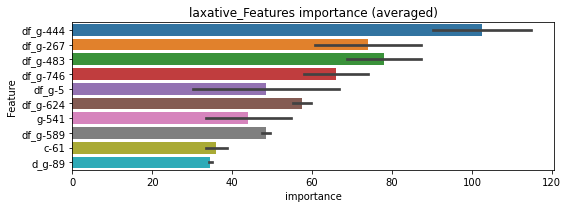

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010162	valid_1's binary_logloss: 0.0142602
[200]	training's binary_logloss: 0.000891472	valid_1's binary_logloss: 0.00488127


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 laxative=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.000353263	valid_1's binary_logloss: 0.00431291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104208	valid_1's binary_logloss: 0.0128222
[200]	training's binary_logloss: 0.000914592	valid_1's binary_logloss: 0.00219377
[300]	training's binary_logloss: 0.000262388	valid_1's binary_logloss: 0.00104837
[400]	training's binary_logloss: 0.000161606	valid_1's binary_logloss: 0.000759549


laxative logloss: 0.00252545572378434


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000150138	valid_1's binary_logloss: 0.000738004


leukotriene_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370086	valid_1's binary_logloss: 0.0442257
[200]	training's binary_logloss: 0.00421901	valid_1's binary_logloss: 0.00710187
[300]	training's binary_logloss: 0.00132428	valid_1's binary_logloss: 0.00273539
[400]	training's binary_logloss: 0.000848165	valid_1's binary_logloss: 0.00191004
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000769481	valid_1's binary_logloss: 0.00174865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352993	valid_1's binary_logloss: 0.0490873
[200]	training's binary_logloss: 0.00391781	valid_1's binary_logloss: 0.00898147
[300]	training's binary_logloss: 0.00127656	valid_1's binary_logloss: 0.00380092
[400]	training's binary_logloss: 0.000830452	valid_1's binary_logloss: 0.00267608
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000760129	valid_1's binary_logloss: 0.0024404

1 / 3 AUC score:1.000
Threshold: 0.5555441504381575
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00046
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00046, conf_1:0.55554
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.56
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.52
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.48
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.44
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_5: 0.40
threshold:0.40, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370086	valid_1's binary_logloss: 0.0442257
[200]	training's binary_logloss: 0.00421901	valid_1's binary_logloss: 0.00710187
[300]	training's binary_logloss: 0.00132428	valid_1's binary_logloss: 0.00273539
[400]	training's binary_logloss: 0.000848165	valid_1's binary_logloss: 0.00191004
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000769481	valid_1's binary_logloss: 0.00174865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352993	valid_1's binary_logloss: 0.0490873
[200]	training's binary_logloss: 0.00391781	valid_1's binary_logloss: 0.00898147
[300]	training's binary_logloss: 0.00127656	valid_1's binary_logloss: 0.00380092
[400]	training's binary_logloss: 0.000830452	valid_1's binary_logloss: 0.00267608
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000760129	valid_1's binary_logloss: 0.0024404

2 / 3 AUC score:1.000
Threshold: 0.39554415043815755
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00046
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00046, conf_1:0.39554
threshold:0.40, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370086	valid_1's binary_logloss: 0.0442257
[200]	training's binary_logloss: 0.00421901	valid_1's binary_logloss: 0.00710187
[300]	training's binary_logloss: 0.00132428	valid_1's binary_logloss: 0.00273539
[400]	training's binary_logloss: 0.000848165	valid_1's binary_logloss: 0.00191004
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000769481	valid_1's binary_logloss: 0.00174865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352993	valid_1's binary_logloss: 0.0490873
[200]	training's binary_logloss: 0.00391781	valid_1's binary_logloss: 0.00898147
[300]	training's binary_logloss: 0.00127656	valid_1's binary_logloss: 0.00380092
[400]	training's binary_logloss: 0.000830452	valid_1's binary_logloss: 0.00267608
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000760129	valid_1's binary_logloss: 0.0024404

3 / 3 AUC score:1.000
Threshold: 0.39554415043815755
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00046
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00046, conf_1:0.39554
threshold:0.40, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


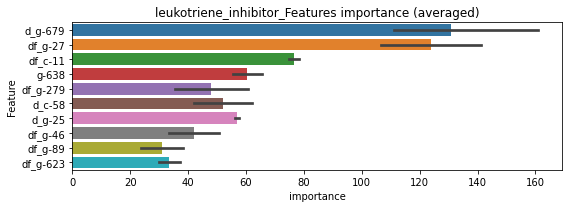

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102256	valid_1's binary_logloss: 0.0134777
[200]	training's binary_logloss: 0.000869135	valid_1's binary_logloss: 0.00414748


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_inhibitor=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000270728	valid_1's binary_logloss: 0.00348628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102323	valid_1's binary_logloss: 0.012523
[200]	training's binary_logloss: 0.000879595	valid_1's binary_logloss: 0.00234361
[300]	training's binary_logloss: 0.000246887	valid_1's binary_logloss: 0.00126824
[400]	training's binary_logloss: 0.000153322	valid_1's binary_logloss: 0.000988275


leukotriene_inhibitor logloss: 0.002217512542530513


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00013999	valid_1's binary_logloss: 0.000948741


leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12565	valid_1's binary_logloss: 0.325559
[200]	training's binary_logloss: 0.0323071	valid_1's binary_logloss: 0.218664
[300]	training's binary_logloss: 0.0110168	valid_1's binary_logloss: 0.176837
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00648127	valid_1's binary_logloss: 0.166515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13118	valid_1's binary_logloss: 0.288484
[200]	training's binary_logloss: 0.0346827	valid_1's binary_logloss: 0.167059
[300]	training's binary_logloss: 0.0121721	valid_1's binary_logloss: 0.122395
[400]	training's binary_logloss: 0.00593436	valid_1's binary_logloss: 0.102251
[500]	training's binary_logloss: 0.00370931	valid_1's binary_logloss: 0.0914981
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00280528	valid_1's binary_logloss: 0.0872643


1 / 3 AUC score:0.988
Threshold: 0.4537539186247463
Remove_noisy_labels: 40 → positive_corect_labels: 480/960
30th percentile: 0.03138
p_label_rate: 0.01532 Vs.target_rate: 0.00270, Num_p_label: 61.0, conf_0:0.03138, conf_1:0.46601
Num_p_label: 61.0, Expected: 10.8, Adj_threshold_1: 0.45
Num_p_label: 41.0, Expected: 10.8, Adj_threshold_2: 0.49
Num_p_label: 29.0, Expected: 10.8, Adj_threshold_3: 0.53
Num_p_label: 17.0, Expected: 10.8, Adj_threshold_4: 0.57
Num_p_label: 12.0, Expected: 10.8, Adj_threshold_5: 0.61
threshold:0.61, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125286	valid_1's binary_logloss: 0.259303
[200]	training's binary_logloss: 0.0322081	valid_1's binary_logloss: 0.137858
[300]	training's binary_logloss: 0.0112503	valid_1's binary_logloss: 0.0917162
[400]	training's binary_logloss: 0.00551167	valid_1's binary_logloss: 0.073431
[500]	training's binary_logloss: 0.00347371	valid_1's binary_logloss: 0.0643109
[600]	training's binary_logloss: 0.00260589	valid_1's binary_logloss: 0.0590125
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00230912	valid_1's binary_logloss: 0.0576503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120029	valid_1's binary_logloss: 0.277555
[200]	training's binary_logloss: 0.0306702	valid_1's binary_logloss: 0.166295
[300]	training's binary_logloss: 0.0106454	valid_1's binary_logloss: 0.117645
[400]	training's binary_logloss: 0.00523136	valid_1's bin

2 / 3 AUC score:0.998
Threshold: 0.6137539186247464
Remove_noisy_labels: 14 → positive_corect_labels: 468.0/946
30th percentile: 0.01989
p_label_rate: 0.00603 Vs.target_rate: 0.00270, Num_p_label: 24.0, conf_0:0.01800, conf_1:0.61375
threshold:0.61, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:468.0/946, y_label_rate: 0.49471
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121923	valid_1's binary_logloss: 0.277483
[200]	training's binary_logloss: 0.0301705	valid_1's binary_logloss: 0.1667
[300]	training's binary_logloss: 0.0103327	valid_1's binary_logloss: 0.130808
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00583287	valid_1's binary_logloss: 0.12031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123647	valid_1's binary_logloss: 0.263682
[200]	training's binary_logloss: 0.031722	valid_1's binary_logloss: 0.147146
[300]	training's binary_logloss: 0.0110281	valid_1's binary_logloss: 0.103655
[400]	training's binary_logloss: 0.00534118	valid_1's binary_logloss: 0.0871198
[500]	training's binary_logloss: 0.00338662	valid_1's binary_logloss: 0.0792493
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00264661	valid_1's binary_logloss: 0.0742339


3 / 3 AUC score:0.994
Threshold: 0.6137539186247464
Remove_noisy_labels: 25 → positive_corect_labels: 451.0/921
30th percentile: 0.02634
p_label_rate: 0.00552 Vs.target_rate: 0.00270, Num_p_label: 22.0, conf_0:0.02634, conf_1:0.61375
threshold:0.61, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:473.0/4903, y_label_rate: 0.09647


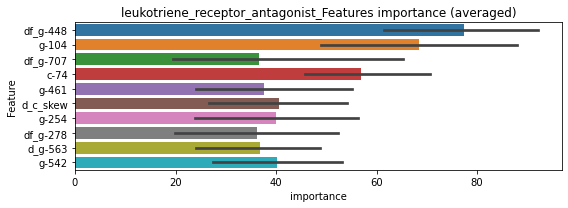

len(train_index) : 2451
len(valid_index) : 2452
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318415	valid_1's binary_logloss: 0.085202
[200]	training's binary_logloss: 0.00606867	valid_1's binary_logloss: 0.0578885
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00270874	valid_1's binary_logloss: 0.0541681


len(train_index) : 2452
len(valid_index) : 2451
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348306	valid_1's binary_logloss: 0.088165
[200]	training's binary_logloss: 0.00710338	valid_1's binary_logloss: 0.0565652
[300]	training's binary_logloss: 0.00197475	valid_1's binary_logloss: 0.0490643
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00191702	valid_1's binary_logloss: 0.0488604


leukotriene_receptor_antagonist logloss: 0.0515148196492627
lipase_inhibitor , len(trt) : 12


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500805	valid_1's binary_logloss: 0.0769156
[200]	training's binary_logloss: 0.00690269	valid_1's binary_logloss: 0.0192429
[300]	training's binary_logloss: 0.0022013	valid_1's binary_logloss: 0.00907454
[400]	training's binary_logloss: 0.00128834	valid_1's binary_logloss: 0.00641639
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00107838	valid_1's binary_logloss: 0.00574518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047779	valid_1's binary_logloss: 0.0730378
[200]	training's binary_logloss: 0.00669724	valid_1's binary_logloss: 0.0165842
[300]	training's binary_logloss: 0.00218268	valid_1's binary_logloss: 0.00698418
[400]	training's binary_logloss: 0.00127433	valid_1's binary_logloss: 0.00455398
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110135	valid_1's binary_logloss: 0.00402628


1 / 3 AUC score:1.000
Threshold: 0.441169839893228
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00102
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00102, conf_1:0.44117
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.44
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.40
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.36
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.32
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.28
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_6: 0.24
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_7: 0.20
threshold:0.16, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500805	valid_1's binary_logloss: 0.0769156
[200]	training's binary_logloss: 0.00690269	valid_1's binary_logloss: 0.0192429
[300]	training's binary_logloss: 0.0022013	valid_1's binary_logloss: 0.00907454
[400]	training's binary_logloss: 0.00128834	valid_1's binary_logloss: 0.00641639
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00107838	valid_1's binary_logloss: 0.00574518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047779	valid_1's binary_logloss: 0.0730378
[200]	training's binary_logloss: 0.00669724	valid_1's binary_logloss: 0.0165842
[300]	training's binary_logloss: 0.00218268	valid_1's binary_logloss: 0.00698418
[400]	training's binary_logloss: 0.00127433	valid_1's binary_logloss: 0.00455398
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110135	valid_1's binary_logloss: 0.00402628


2 / 3 AUC score:1.000
Threshold: 0.16116983989322806
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00102
p_label_rate: 0.00301 Vs.target_rate: 0.00055, Num_p_label: 12.0, conf_0:0.00102, conf_1:0.16117
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_1: 0.16
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_2: 0.20
threshold:0.20, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500805	valid_1's binary_logloss: 0.0769156
[200]	training's binary_logloss: 0.00690269	valid_1's binary_logloss: 0.0192429
[300]	training's binary_logloss: 0.0022013	valid_1's binary_logloss: 0.00907454
[400]	training's binary_logloss: 0.00128834	valid_1's binary_logloss: 0.00641639
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00107838	valid_1's binary_logloss: 0.00574518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047779	valid_1's binary_logloss: 0.0730378
[200]	training's binary_logloss: 0.00669724	valid_1's binary_logloss: 0.0165842
[300]	training's binary_logloss: 0.00218268	valid_1's binary_logloss: 0.00698418
[400]	training's binary_logloss: 0.00127433	valid_1's binary_logloss: 0.00455398
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110135	valid_1's binary_logloss: 0.00402628


3 / 3 AUC score:1.000
Threshold: 0.20116983989322806
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00102
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00102, conf_1:0.20117
threshold:0.20, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


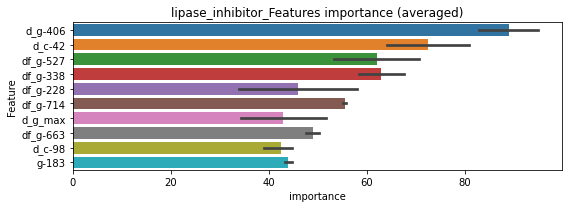

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119974	valid_1's binary_logloss: 0.0194486
[200]	training's binary_logloss: 0.00122849	valid_1's binary_logloss: 0.00522466
[300]	training's binary_logloss: 0.000362472	valid_1's binary_logloss: 0.00356686
[400]	training's binary_logloss: 0.000212096	valid_1's binary_logloss: 0.00335643
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000217685	valid_1's binary_logloss: 0.00335295


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123208	valid_1's binary_logloss: 0.0185421
[200]	training's binary_logloss: 0.00129832	valid_1's binary_logloss: 0.00445838
[300]	training's binary_logloss: 0.000388065	valid_1's binary_logloss: 0.00204266
[400]	training's binary_logloss: 0.000224688	valid_1's binary_logloss: 0.00150079
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000202637	valid_1's binary_logloss: 0.00142134


lipase_inhibitor logloss: 0.00238714071454923
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120297	valid_1's binary_logloss: 0.269691
[200]	training's binary_logloss: 0.0299294	valid_1's binary_logloss: 0.166975
[300]	training's binary_logloss: 0.0102649	valid_1's binary_logloss: 0.127437
[400]	training's binary_logloss: 0.00504942	valid_1's binary_logloss: 0.114287
[500]	training's binary_logloss: 0.00322617	valid_1's binary_logloss: 0.107814
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00283712	valid_1's binary_logloss: 0.104802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120545	valid_1's binary_logloss: 0.261636
[200]	training's binary_logloss: 0.0312814	valid_1's binary_logloss: 0.155707
[300]	training's binary_logloss: 0.010653	valid_1's binary_logloss: 0.110365
[400]	training's binary_logloss: 0.005231	valid_1's binary_logloss: 0.0917077
[500]	training's binary_logloss: 0.00330106	valid_1's binary_lo

1 / 3 AUC score:0.995
Threshold: 0.38159907605986954
Remove_noisy_labels: 38 → positive_corect_labels: 481/962
30th percentile: 0.01873
p_label_rate: 0.02562 Vs.target_rate: 0.00266, Num_p_label: 102.0, conf_0:0.01809, conf_1:0.51554
Num_p_label: 102.0, Expected: 10.6, Adj_threshold_1: 0.38
Num_p_label: 73.0, Expected: 10.6, Adj_threshold_2: 0.42
Num_p_label: 51.0, Expected: 10.6, Adj_threshold_3: 0.46
Num_p_label: 32.0, Expected: 10.6, Adj_threshold_4: 0.50
Num_p_label: 22.0, Expected: 10.6, Adj_threshold_5: 0.54
Num_p_label: 18.0, Expected: 10.6, Adj_threshold_6: 0.58
Num_p_label: 12.0, Expected: 10.6, Adj_threshold_7: 0.62
threshold:0.62, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:481.0/962, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117921	valid_1's binary_logloss: 0.257109
[200]	training's binary_logloss: 0.0296439	valid_1's binary_logloss: 0.157996
[300]	training's binary_logloss: 0.010126	valid_1's binary_logloss: 0.121792
[400]	training's binary_logloss: 0.00498131	valid_1's binary_logloss: 0.108748
[500]	training's binary_logloss: 0.00319341	valid_1's binary_logloss: 0.100533
[600]	training's binary_logloss: 0.00240752	valid_1's binary_logloss: 0.0967444
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.00241301	valid_1's binary_logloss: 0.0966539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115516	valid_1's binary_logloss: 0.245641
[200]	training's binary_logloss: 0.0288232	valid_1's binary_logloss: 0.142186
[300]	training's binary_logloss: 0.00986886	valid_1's binary_logloss: 0.104145
[400]	training's binary_logloss: 0.00487853	valid_1's binar

2 / 3 AUC score:0.995
Threshold: 0.6215990760598696
Remove_noisy_labels: 30 → positive_corect_labels: 454.0/932
30th percentile: 0.01690
p_label_rate: 0.00703 Vs.target_rate: 0.00266, Num_p_label: 28.0, conf_0:0.01690, conf_1:0.62160
threshold:0.62, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:454.0/932, y_label_rate: 0.48712
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119027	valid_1's binary_logloss: 0.232163
[200]	training's binary_logloss: 0.0291216	valid_1's binary_logloss: 0.123477
[300]	training's binary_logloss: 0.00979965	valid_1's binary_logloss: 0.0910435
[400]	training's binary_logloss: 0.00484087	valid_1's binary_logloss: 0.077645
[500]	training's binary_logloss: 0.00310855	valid_1's binary_logloss: 0.0724136
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00322406	valid_1's binary_logloss: 0.0721673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110656	valid_1's binary_logloss: 0.238116
[200]	training's binary_logloss: 0.0271505	valid_1's binary_logloss: 0.12751
[300]	training's binary_logloss: 0.00932527	valid_1's binary_logloss: 0.0860399
[400]	training's binary_logloss: 0.00461777	valid_1's binary_logloss: 0.0684019
[500]	training's binary_logloss: 0.0029984	valid_1's bi

3 / 3 AUC score:0.998
Threshold: 0.6215990760598696
Remove_noisy_labels: 17 → positive_corect_labels: 440.0/915
30th percentile: 0.01485
p_label_rate: 0.00703 Vs.target_rate: 0.00266, Num_p_label: 28.0, conf_0:0.01485, conf_1:0.62160
threshold:0.62, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:468.0/4897, y_label_rate: 0.09557


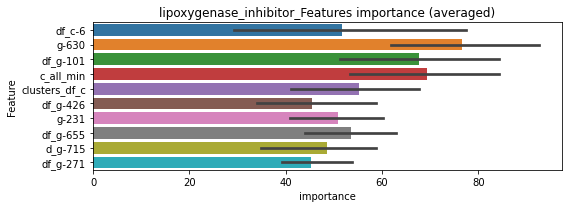

len(train_index) : 2448
len(valid_index) : 2449
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341342	valid_1's binary_logloss: 0.084858
[200]	training's binary_logloss: 0.00629638	valid_1's binary_logloss: 0.0528455
[300]	training's binary_logloss: 0.00178675	valid_1's binary_logloss: 0.0459803
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00178675	valid_1's binary_logloss: 0.0459803


len(train_index) : 2449
len(valid_index) : 2448
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356489	valid_1's binary_logloss: 0.0764159
[200]	training's binary_logloss: 0.00711551	valid_1's binary_logloss: 0.0442735
[300]	training's binary_logloss: 0.00194649	valid_1's binary_logloss: 0.0389185
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00120532	valid_1's binary_logloss: 0.0378387


lipoxygenase_inhibitor logloss: 0.04191030283024273
lxr_agonist , len(trt) : 6


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369715	valid_1's binary_logloss: 0.0463009
[200]	training's binary_logloss: 0.0042476	valid_1's binary_logloss: 0.00784692
[300]	training's binary_logloss: 0.00135027	valid_1's binary_logloss: 0.00328049
[400]	training's binary_logloss: 0.000864479	valid_1's binary_logloss: 0.00224443
[500]	training's binary_logloss: 0.000788718	valid_1's binary_logloss: 0.00205445
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000785381	valid_1's binary_logloss: 0.00204458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365072	valid_1's binary_logloss: 0.0481484
[200]	training's binary_logloss: 0.00416683	valid_1's binary_logloss: 0.0089709
[300]	training's binary_logloss: 0.00136799	valid_1's binary_logloss: 0.00391933
[400]	training's binary_logloss: 0.000871566	valid_1's binary_logloss: 0.00273505
Early stopping, best iteration is:


1 / 3 AUC score:1.000
Threshold: 0.558437072721516
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00044
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00044, conf_1:0.55844
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.56
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.52
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.48
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.44
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_5: 0.40
threshold:0.40, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369715	valid_1's binary_logloss: 0.0463009
[200]	training's binary_logloss: 0.0042476	valid_1's binary_logloss: 0.00784692
[300]	training's binary_logloss: 0.00135027	valid_1's binary_logloss: 0.00328049
[400]	training's binary_logloss: 0.000864479	valid_1's binary_logloss: 0.00224443
[500]	training's binary_logloss: 0.000788718	valid_1's binary_logloss: 0.00205445
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000785381	valid_1's binary_logloss: 0.00204458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365072	valid_1's binary_logloss: 0.0481484
[200]	training's binary_logloss: 0.00416683	valid_1's binary_logloss: 0.0089709
[300]	training's binary_logloss: 0.00136799	valid_1's binary_logloss: 0.00391933
[400]	training's binary_logloss: 0.000871566	valid_1's binary_logloss: 0.00273505
Early stopping, best iteration is:


2 / 3 AUC score:1.000
Threshold: 0.398437072721516
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00044
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00044, conf_1:0.39844
threshold:0.40, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369715	valid_1's binary_logloss: 0.0463009
[200]	training's binary_logloss: 0.0042476	valid_1's binary_logloss: 0.00784692
[300]	training's binary_logloss: 0.00135027	valid_1's binary_logloss: 0.00328049
[400]	training's binary_logloss: 0.000864479	valid_1's binary_logloss: 0.00224443
[500]	training's binary_logloss: 0.000788718	valid_1's binary_logloss: 0.00205445
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000785381	valid_1's binary_logloss: 0.00204458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365072	valid_1's binary_logloss: 0.0481484
[200]	training's binary_logloss: 0.00416683	valid_1's binary_logloss: 0.0089709
[300]	training's binary_logloss: 0.00136799	valid_1's binary_logloss: 0.00391933
[400]	training's binary_logloss: 0.000871566	valid_1's binary_logloss: 0.00273505
Early stopping, best iteration is:


3 / 3 AUC score:1.000
Threshold: 0.398437072721516
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00044
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00044, conf_1:0.39844
threshold:0.40, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


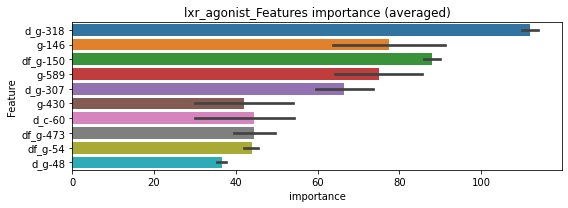

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102174	valid_1's binary_logloss: 0.012115
[200]	training's binary_logloss: 0.000885382	valid_1's binary_logloss: 0.00239888
[300]	training's binary_logloss: 0.000249873	valid_1's binary_logloss: 0.00166205


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lxr_agonist=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000186503	valid_1's binary_logloss: 0.00158432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102862	valid_1's binary_logloss: 0.0123907
[200]	training's binary_logloss: 0.000903314	valid_1's binary_logloss: 0.00267519
[300]	training's binary_logloss: 0.000256664	valid_1's binary_logloss: 0.00165554
[400]	training's binary_logloss: 0.000158525	valid_1's binary_logloss: 0.00141752


lxr_agonist logloss: 0.0014914299747676193
mdm_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000146753	valid_1's binary_logloss: 0.0013978


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888653	valid_1's binary_logloss: 0.159607
[200]	training's binary_logloss: 0.0180099	valid_1's binary_logloss: 0.0632069
[300]	training's binary_logloss: 0.0059356	valid_1's binary_logloss: 0.0356178
[400]	training's binary_logloss: 0.00303542	valid_1's binary_logloss: 0.0258433
[500]	training's binary_logloss: 0.00208118	valid_1's binary_logloss: 0.022232
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00176426	valid_1's binary_logloss: 0.0201363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873632	valid_1's binary_logloss: 0.166875
[200]	training's binary_logloss: 0.0179097	valid_1's binary_logloss: 0.0694935
[300]	training's binary_logloss: 0.00588162	valid_1's binary_logloss: 0.0418268
[400]	training's binary_logloss: 0.00300103	valid_1's binary_logloss: 0.0312973
[500]	training's binary_logloss: 0.0020288	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.728050031680644
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00414
p_label_rate: 0.00025 Vs.target_rate: 0.00139, Num_p_label: 1.0, conf_0:0.00414, conf_1:0.72805
Num_p_label: 1.0, Expected: 5.5, Adj_threshold_1: 0.73
Num_p_label: 1.0, Expected: 5.5, Adj_threshold_2: 0.69
Num_p_label: 1.0, Expected: 5.5, Adj_threshold_3: 0.65
Num_p_label: 1.0, Expected: 5.5, Adj_threshold_4: 0.61
Num_p_label: 2.0, Expected: 5.5, Adj_threshold_5: 0.57
Num_p_label: 5.0, Expected: 5.5, Adj_threshold_6: 0.53
threshold:0.53, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878661	valid_1's binary_logloss: 0.145203
[200]	training's binary_logloss: 0.0179941	valid_1's binary_logloss: 0.0514555
[300]	training's binary_logloss: 0.0059646	valid_1's binary_logloss: 0.0272587
[400]	training's binary_logloss: 0.0030709	valid_1's binary_logloss: 0.0188913
[500]	training's binary_logloss: 0.0020845	valid_1's binary_logloss: 0.0150939
[600]	training's binary_logloss: 0.00174746	valid_1's binary_logloss: 0.0136463
Early stopping, best iteration is:
[659]	training's binary_logloss: 0.0016878	valid_1's binary_logloss: 0.0133379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087711	valid_1's binary_logloss: 0.178478
[200]	training's binary_logloss: 0.0174607	valid_1's binary_logloss: 0.0838631
[300]	training's binary_logloss: 0.00562775	valid_1's binary_logloss: 0.0635617
[400]	training's binary_logloss: 0.00289838	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.5280500316806438
Remove_noisy_labels: 5 → positive_corect_labels: 494.0/993
30th percentile: 0.00402
p_label_rate: 0.00100 Vs.target_rate: 0.00139, Num_p_label: 4.0, conf_0:0.00402, conf_1:0.52805
threshold:0.53, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:494.0/993, y_label_rate: 0.49748
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868015	valid_1's binary_logloss: 0.143417
[200]	training's binary_logloss: 0.0177668	valid_1's binary_logloss: 0.0542448
[300]	training's binary_logloss: 0.00590598	valid_1's binary_logloss: 0.0297501
[400]	training's binary_logloss: 0.00304581	valid_1's binary_logloss: 0.0213836
[500]	training's binary_logloss: 0.00206267	valid_1's binary_logloss: 0.0176043
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00174213	valid_1's binary_logloss: 0.0161919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865804	valid_1's binary_logloss: 0.170023
[200]	training's binary_logloss: 0.0170239	valid_1's binary_logloss: 0.0801581
[300]	training's binary_logloss: 0.00559946	valid_1's binary_logloss: 0.05659


3 / 3 AUC score:0.999
Threshold: 0.5280500316806438
Remove_noisy_labels: 5 → positive_corect_labels: 489.0/988
30th percentile: 0.00534
p_label_rate: 0.00100 Vs.target_rate: 0.00139, Num_p_label: 4.0, conf_0:0.00534, conf_1:0.52805


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00328858	valid_1's binary_logloss: 0.0506916


threshold:0.53, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:493.0/4970, y_label_rate: 0.09920


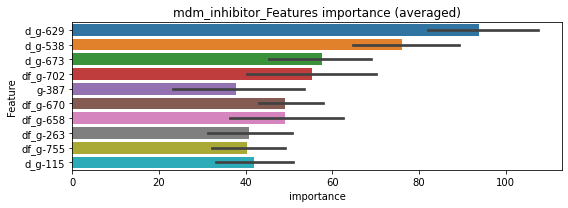

len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231642	valid_1's binary_logloss: 0.0410008
[200]	training's binary_logloss: 0.00339089	valid_1's binary_logloss: 0.0138165
[300]	training's binary_logloss: 0.000943913	valid_1's binary_logloss: 0.00882189
[400]	training's binary_logloss: 0.000471876	valid_1's binary_logloss: 0.00766475
[500]	training's binary_logloss: 0.000345945	valid_1's binary_logloss: 0.00742735
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000346737	valid_1's binary_logloss: 0.00740892


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223376	valid_1's binary_logloss: 0.0380586
[200]	training's binary_logloss: 0.00330366	valid_1's binary_logloss: 0.0124892
[300]	training's binary_logloss: 0.000935792	valid_1's binary_logloss: 0.0082335
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00078536	valid_1's binary_logloss: 0.00806923


mdm_inhibitor logloss: 0.007739073392419075
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128021	valid_1's binary_logloss: 0.313168
[200]	training's binary_logloss: 0.033567	valid_1's binary_logloss: 0.206727
[300]	training's binary_logloss: 0.0117214	valid_1's binary_logloss: 0.170055
[400]	training's binary_logloss: 0.00573865	valid_1's binary_logloss: 0.157454
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00467043	valid_1's binary_logloss: 0.153807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130279	valid_1's binary_logloss: 0.29308
[200]	training's binary_logloss: 0.0352515	valid_1's binary_logloss: 0.194449
[300]	training's binary_logloss: 0.0124193	valid_1's binary_logloss: 0.153584
[400]	training's binary_logloss: 0.00597964	valid_1's binary_logloss: 0.137414
[500]	training's binary_logloss: 0.00370155	valid_1's binary_logloss: 0.128634
Early stopping, best iteration is:
[526]	training's binary_logl

1 / 3 AUC score:0.983
Threshold: 0.40420409538494395
Remove_noisy_labels: 48 → positive_corect_labels: 476/952
30th percentile: 0.03860
p_label_rate: 0.02913 Vs.target_rate: 0.00311, Num_p_label: 116.0, conf_0:0.02212, conf_1:0.49315
Num_p_label: 116.0, Expected: 12.4, Adj_threshold_1: 0.40
Num_p_label: 81.0, Expected: 12.4, Adj_threshold_2: 0.44
Num_p_label: 54.0, Expected: 12.4, Adj_threshold_3: 0.48
Num_p_label: 39.0, Expected: 12.4, Adj_threshold_4: 0.52
Num_p_label: 27.0, Expected: 12.4, Adj_threshold_5: 0.56
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_6: 0.60
Num_p_label: 11.0, Expected: 12.4, Adj_threshold_7: 0.64
threshold:0.64, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:476.0/952, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123948	valid_1's binary_logloss: 0.265236
[200]	training's binary_logloss: 0.0317974	valid_1's binary_logloss: 0.163601
[300]	training's binary_logloss: 0.011255	valid_1's binary_logloss: 0.121598
[400]	training's binary_logloss: 0.00548963	valid_1's binary_logloss: 0.103508
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00366155	valid_1's binary_logloss: 0.0962844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125679	valid_1's binary_logloss: 0.285956
[200]	training's binary_logloss: 0.0327974	valid_1's binary_logloss: 0.186804
[300]	training's binary_logloss: 0.0113232	valid_1's binary_logloss: 0.155186


2 / 3 AUC score:0.988
Threshold: 0.644204095384944
Remove_noisy_labels: 35 → positive_corect_labels: 441.0/917
30th percentile: 0.03747
p_label_rate: 0.00427 Vs.target_rate: 0.00311, Num_p_label: 17.0, conf_0:0.03555, conf_1:0.64420


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00651334	valid_1's binary_logloss: 0.145751


threshold:0.64, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:441.0/917, y_label_rate: 0.48092
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121544	valid_1's binary_logloss: 0.267696
[200]	training's binary_logloss: 0.0306394	valid_1's binary_logloss: 0.151431
[300]	training's binary_logloss: 0.0105788	valid_1's binary_logloss: 0.111609
[400]	training's binary_logloss: 0.00526813	valid_1's binary_logloss: 0.0944377
[500]	training's binary_logloss: 0.00339704	valid_1's binary_logloss: 0.0869437
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00295744	valid_1's binary_logloss: 0.0850048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119707	valid_1's binary_logloss: 0.256074
[200]	training's binary_logloss: 0.0304105	valid_1's binary_logloss: 0.142664
[300]	training's binary_logloss: 0.0106971	valid_1's binary_logloss: 0.0996406
[400]	training's binary_logloss: 0.00526348	valid_1's binary_logloss: 0.0826995
[500]	training's binary_logloss: 0.00339696	valid_1's bi

3 / 3 AUC score:0.997
Threshold: 0.644204095384944
Remove_noisy_labels: 21 → positive_corect_labels: 420.0/896
30th percentile: 0.01992
p_label_rate: 0.00352 Vs.target_rate: 0.00311, Num_p_label: 14.0, conf_0:0.01737, conf_1:0.64420
threshold:0.64, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:434.0/4878, y_label_rate: 0.08897


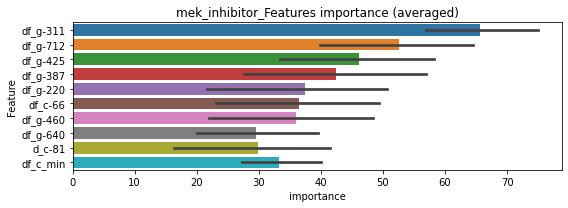

len(train_index) : 2439
len(valid_index) : 2439
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316738	valid_1's binary_logloss: 0.0731734
[200]	training's binary_logloss: 0.00629326	valid_1's binary_logloss: 0.0411903
[300]	training's binary_logloss: 0.0017945	valid_1's binary_logloss: 0.033487
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00119599	valid_1's binary_logloss: 0.0324305


len(train_index) : 2439
len(valid_index) : 2439
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318243	valid_1's binary_logloss: 0.0868706
[200]	training's binary_logloss: 0.00605422	valid_1's binary_logloss: 0.0619855
[300]	training's binary_logloss: 0.00170738	valid_1's binary_logloss: 0.0571832
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00165691	valid_1's binary_logloss: 0.057183


mek_inhibitor logloss: 0.04480676243727342
membrane_integrity_inhibitor , len(trt) : 74


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129141	valid_1's binary_logloss: 0.288531
[200]	training's binary_logloss: 0.0340512	valid_1's binary_logloss: 0.18544
[300]	training's binary_logloss: 0.0118266	valid_1's binary_logloss: 0.147307
[400]	training's binary_logloss: 0.00574249	valid_1's binary_logloss: 0.132778
[500]	training's binary_logloss: 0.0036208	valid_1's binary_logloss: 0.124444
[600]	training's binary_logloss: 0.00267021	valid_1's binary_logloss: 0.120168
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00266367	valid_1's binary_logloss: 0.120129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131076	valid_1's binary_logloss: 0.275546
[200]	training's binary_logloss: 0.0350616	valid_1's binary_logloss: 0.159716
[300]	training's binary_logloss: 0.0125382	valid_1's binary_logloss: 0.116151
[400]	training's binary_logloss: 0.00608122	valid_1's binary_lo

1 / 3 AUC score:0.992
Threshold: 0.4057584311975142
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentile: 0.02594
p_label_rate: 0.03440 Vs.target_rate: 0.00319, Num_p_label: 137.0, conf_0:0.01460, conf_1:0.47258
Num_p_label: 137.0, Expected: 12.7, Adj_threshold_1: 0.41
Num_p_label: 103.0, Expected: 12.7, Adj_threshold_2: 0.45
Num_p_label: 72.0, Expected: 12.7, Adj_threshold_3: 0.49
Num_p_label: 53.0, Expected: 12.7, Adj_threshold_4: 0.53
Num_p_label: 38.0, Expected: 12.7, Adj_threshold_5: 0.57
Num_p_label: 22.0, Expected: 12.7, Adj_threshold_6: 0.61
Num_p_label: 14.0, Expected: 12.7, Adj_threshold_7: 0.65
threshold:0.65, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123945	valid_1's binary_logloss: 0.259872
[200]	training's binary_logloss: 0.0321422	valid_1's binary_logloss: 0.148405
[300]	training's binary_logloss: 0.0112499	valid_1's binary_logloss: 0.103013
[400]	training's binary_logloss: 0.0055614	valid_1's binary_logloss: 0.0827362
[500]	training's binary_logloss: 0.00352436	valid_1's binary_logloss: 0.0735903
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00276728	valid_1's binary_logloss: 0.0687774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126878	valid_1's binary_logloss: 0.279292
[200]	training's binary_logloss: 0.0327528	valid_1's binary_logloss: 0.16019
[300]	training's binary_logloss: 0.0114292	valid_1's binary_logloss: 0.117305
[400]	training's binary_logloss: 0.0055451	valid_1's binary_logloss: 0.0963392
[500]	training's binary_logloss: 0.00349015	valid_1's binary

2 / 3 AUC score:0.998
Threshold: 0.6457584311975143
Remove_noisy_labels: 20 → positive_corect_labels: 466.0/948
30th percentile: 0.02143
p_label_rate: 0.00578 Vs.target_rate: 0.00319, Num_p_label: 23.0, conf_0:0.01683, conf_1:0.64576
threshold:0.65, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:466.0/948, y_label_rate: 0.49156
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120099	valid_1's binary_logloss: 0.238049
[200]	training's binary_logloss: 0.0307335	valid_1's binary_logloss: 0.130778
[300]	training's binary_logloss: 0.0107029	valid_1's binary_logloss: 0.0904537
[400]	training's binary_logloss: 0.00524156	valid_1's binary_logloss: 0.0734542
[500]	training's binary_logloss: 0.0033172	valid_1's binary_logloss: 0.0653344
[600]	training's binary_logloss: 0.00250243	valid_1's binary_logloss: 0.0590433
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.00224418	valid_1's binary_logloss: 0.0575909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119459	valid_1's binary_logloss: 0.238848
[200]	training's binary_logloss: 0.0306651	valid_1's binary_logloss: 0.13045
[300]	training's binary_logloss: 0.0108073	valid_1's binary_logloss: 0.0913396
[400]	training's binary_logloss: 0.00536367	valid_1's bin

3 / 3 AUC score:0.999
Threshold: 0.6457584311975143
Remove_noisy_labels: 15 → positive_corect_labels: 453.0/933
30th percentile: 0.01505
p_label_rate: 0.00879 Vs.target_rate: 0.00319, Num_p_label: 35.0, conf_0:0.00977, conf_1:0.64576
threshold:0.65, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:488.0/4915, y_label_rate: 0.09929


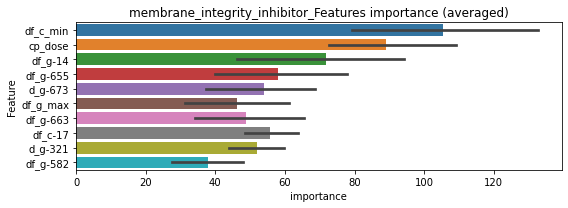

len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318126	valid_1's binary_logloss: 0.0874874
[200]	training's binary_logloss: 0.00626923	valid_1's binary_logloss: 0.0643076
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00259735	valid_1's binary_logloss: 0.0608387


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320924	valid_1's binary_logloss: 0.0891502
[200]	training's binary_logloss: 0.00623523	valid_1's binary_logloss: 0.0653419
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00243481	valid_1's binary_logloss: 0.0608073


membrane_integrity_inhibitor logloss: 0.06082300384857801
mineralocorticoid_receptor_antagonist , len(trt) : 25


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767381	valid_1's binary_logloss: 0.122924
[200]	training's binary_logloss: 0.0142704	valid_1's binary_logloss: 0.0411395
[300]	training's binary_logloss: 0.00458306	valid_1's binary_logloss: 0.020921
[400]	training's binary_logloss: 0.00238784	valid_1's binary_logloss: 0.0147974
[500]	training's binary_logloss: 0.00167884	valid_1's binary_logloss: 0.0122852
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00148685	valid_1's binary_logloss: 0.011255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754131	valid_1's binary_logloss: 0.13874
[200]	training's binary_logloss: 0.0139167	valid_1's binary_logloss: 0.0541775
[300]	training's binary_logloss: 0.0044341	valid_1's binary_logloss: 0.0303504
[400]	training's binary_logloss: 0.00230164	valid_1's binary_logloss: 0.0221275
[500]	training's binary_logloss: 0.00162507	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.49468106280089036
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00287
p_label_rate: 0.00100 Vs.target_rate: 0.00113, Num_p_label: 4.0, conf_0:0.00287, conf_1:0.49468
threshold:0.49, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767381	valid_1's binary_logloss: 0.122924
[200]	training's binary_logloss: 0.0142704	valid_1's binary_logloss: 0.0411395
[300]	training's binary_logloss: 0.00458306	valid_1's binary_logloss: 0.020921
[400]	training's binary_logloss: 0.00238784	valid_1's binary_logloss: 0.0147974
[500]	training's binary_logloss: 0.00167884	valid_1's binary_logloss: 0.0122852
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00148685	valid_1's binary_logloss: 0.011255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754131	valid_1's binary_logloss: 0.13874
[200]	training's binary_logloss: 0.0139167	valid_1's binary_logloss: 0.0541775
[300]	training's binary_logloss: 0.0044341	valid_1's binary_logloss: 0.0303504
[400]	training's binary_logloss: 0.00230164	valid_1's binary_logloss: 0.0221275
[500]	training's binary_logloss: 0.00162507	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.49468106280089036
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00287
p_label_rate: 0.00100 Vs.target_rate: 0.00113, Num_p_label: 4.0, conf_0:0.00287, conf_1:0.49468
threshold:0.49, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767381	valid_1's binary_logloss: 0.122924
[200]	training's binary_logloss: 0.0142704	valid_1's binary_logloss: 0.0411395
[300]	training's binary_logloss: 0.00458306	valid_1's binary_logloss: 0.020921
[400]	training's binary_logloss: 0.00238784	valid_1's binary_logloss: 0.0147974
[500]	training's binary_logloss: 0.00167884	valid_1's binary_logloss: 0.0122852
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00148685	valid_1's binary_logloss: 0.011255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754131	valid_1's binary_logloss: 0.13874
[200]	training's binary_logloss: 0.0139167	valid_1's binary_logloss: 0.0541775
[300]	training's binary_logloss: 0.0044341	valid_1's binary_logloss: 0.0303504
[400]	training's binary_logloss: 0.00230164	valid_1's binary_logloss: 0.0221275
[500]	training's binary_logloss: 0.00162507	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.49468106280089036
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00287
p_label_rate: 0.00100 Vs.target_rate: 0.00113, Num_p_label: 4.0, conf_0:0.00287, conf_1:0.49468
threshold:0.49, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4982, y_label_rate: 0.10116


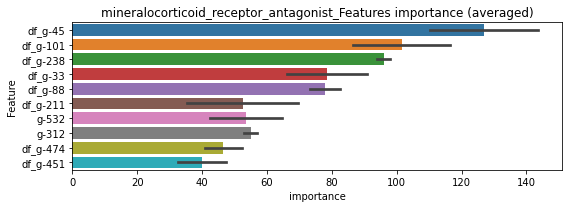

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174478	valid_1's binary_logloss: 0.0281158
[200]	training's binary_logloss: 0.00233491	valid_1's binary_logloss: 0.007278
[300]	training's binary_logloss: 0.000700188	valid_1's binary_logloss: 0.00444458
[400]	training's binary_logloss: 0.000370491	valid_1's binary_logloss: 0.00371363
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000357344	valid_1's binary_logloss: 0.00368544


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195487	valid_1's binary_logloss: 0.0367762
[200]	training's binary_logloss: 0.00252266	valid_1's binary_logloss: 0.0171344
[300]	training's binary_logloss: 0.000721684	valid_1's binary_logloss: 0.0147505
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000570839	valid_1's binary_logloss: 0.0146346


mineralocorticoid_receptor_antagonist logloss: 0.009160043906357562
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464673	valid_1's binary_logloss: 0.0714448
[200]	training's binary_logloss: 0.0062635	valid_1's binary_logloss: 0.0193588
[300]	training's binary_logloss: 0.00201882	valid_1's binary_logloss: 0.0103021
[400]	training's binary_logloss: 0.00120575	valid_1's binary_logloss: 0.00763237
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00105137	valid_1's binary_logloss: 0.00701745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456749	valid_1's binary_logloss: 0.0612012
[200]	training's binary_logloss: 0.00625301	valid_1's binary_logloss: 0.0133139
[300]	training's binary_logloss: 0.00204277	valid_1's binary_logloss: 0.00602675
[400]	training's binary_logloss: 0.00121537	valid_1's binary_logloss: 0.00419222
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00105847	valid_1's binary_logloss: 0.00373442


1 / 3 AUC score:1.000
Threshold: 0.4412755467469234
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00077
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00077, conf_1:0.44128
threshold:0.44, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464673	valid_1's binary_logloss: 0.0714448
[200]	training's binary_logloss: 0.0062635	valid_1's binary_logloss: 0.0193588
[300]	training's binary_logloss: 0.00201882	valid_1's binary_logloss: 0.0103021
[400]	training's binary_logloss: 0.00120575	valid_1's binary_logloss: 0.00763237
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00105137	valid_1's binary_logloss: 0.00701745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456749	valid_1's binary_logloss: 0.0612012
[200]	training's binary_logloss: 0.00625301	valid_1's binary_logloss: 0.0133139
[300]	training's binary_logloss: 0.00204277	valid_1's binary_logloss: 0.00602675
[400]	training's binary_logloss: 0.00121537	valid_1's binary_logloss: 0.00419222
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00105847	valid_1's binary_logloss: 0.00373442


2 / 3 AUC score:1.000
Threshold: 0.4412755467469234
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00077
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00077, conf_1:0.44128
threshold:0.44, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464673	valid_1's binary_logloss: 0.0714448
[200]	training's binary_logloss: 0.0062635	valid_1's binary_logloss: 0.0193588
[300]	training's binary_logloss: 0.00201882	valid_1's binary_logloss: 0.0103021
[400]	training's binary_logloss: 0.00120575	valid_1's binary_logloss: 0.00763237
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00105137	valid_1's binary_logloss: 0.00701745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456749	valid_1's binary_logloss: 0.0612012
[200]	training's binary_logloss: 0.00625301	valid_1's binary_logloss: 0.0133139
[300]	training's binary_logloss: 0.00204277	valid_1's binary_logloss: 0.00602675
[400]	training's binary_logloss: 0.00121537	valid_1's binary_logloss: 0.00419222
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00105847	valid_1's binary_logloss: 0.00373442


3 / 3 AUC score:1.000
Threshold: 0.4412755467469234
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00077
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00077, conf_1:0.44128
threshold:0.44, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


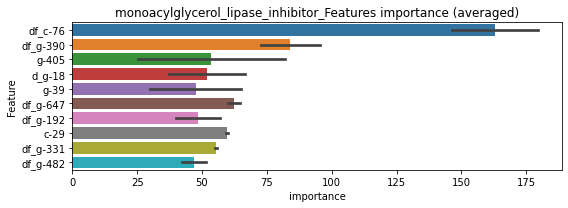

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112693	valid_1's binary_logloss: 0.0170293
[200]	training's binary_logloss: 0.00115274	valid_1's binary_logloss: 0.00569637
[300]	training's binary_logloss: 0.00034972	valid_1's binary_logloss: 0.00385637


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00025117	valid_1's binary_logloss: 0.0036291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116004	valid_1's binary_logloss: 0.0141022
[200]	training's binary_logloss: 0.00119369	valid_1's binary_logloss: 0.00275475
[300]	training's binary_logloss: 0.000363694	valid_1's binary_logloss: 0.00151607
[400]	training's binary_logloss: 0.000214609	valid_1's binary_logloss: 0.00126489
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000198394	valid_1's binary_logloss: 0.00123343


monoacylglycerol_lipase_inhibitor logloss: 0.002431264287599904
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139952	valid_1's binary_logloss: 0.335353
[200]	training's binary_logloss: 0.0396706	valid_1's binary_logloss: 0.241969
[300]	training's binary_logloss: 0.0140844	valid_1's binary_logloss: 0.205664
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00803239	valid_1's binary_logloss: 0.190176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135459	valid_1's binary_logloss: 0.334209
[200]	training's binary_logloss: 0.0375876	valid_1's binary_logloss: 0.234968
[300]	training's binary_logloss: 0.0135737	valid_1's binary_logloss: 0.196375
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00889054	valid_1's binary_logloss: 0.184996


1 / 3 AUC score:0.974
Threshold: 0.46669114699881353
Remove_noisy_labels: 60 → positive_corect_labels: 470/940
30th percentile: 0.05804
p_label_rate: 0.04571 Vs.target_rate: 0.00362, Num_p_label: 182.0, conf_0:0.05804, conf_1:0.54832
Num_p_label: 182.0, Expected: 14.4, Adj_threshold_1: 0.47
Num_p_label: 143.0, Expected: 14.4, Adj_threshold_2: 0.51
Num_p_label: 96.0, Expected: 14.4, Adj_threshold_3: 0.55
Num_p_label: 61.0, Expected: 14.4, Adj_threshold_4: 0.59
Num_p_label: 39.0, Expected: 14.4, Adj_threshold_5: 0.63
Num_p_label: 25.0, Expected: 14.4, Adj_threshold_6: 0.67
Num_p_label: 15.0, Expected: 14.4, Adj_threshold_7: 0.71
threshold:0.71, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:470.0/940, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131196	valid_1's binary_logloss: 0.2928
[200]	training's binary_logloss: 0.0346193	valid_1's binary_logloss: 0.19211
[300]	training's binary_logloss: 0.0120662	valid_1's binary_logloss: 0.144154
[400]	training's binary_logloss: 0.0059079	valid_1's binary_logloss: 0.128397
[500]	training's binary_logloss: 0.00371406	valid_1's binary_logloss: 0.120192
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00297547	valid_1's binary_logloss: 0.117209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134013	valid_1's binary_logloss: 0.290864
[200]	training's binary_logloss: 0.0361805	valid_1's binary_logloss: 0.195772
[300]	training's binary_logloss: 0.0128719	valid_1's binary_logloss: 0.162366
[400]	training's binary_logloss: 0.00632396	valid_1's binary_logloss: 0.146258


2 / 3 AUC score:0.989
Threshold: 0.7066911469988137
Remove_noisy_labels: 45 → positive_corect_labels: 430.0/895
30th percentile: 0.03202


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00549283	valid_1's binary_logloss: 0.143988


p_label_rate: 0.00804 Vs.target_rate: 0.00362, Num_p_label: 32.0, conf_0:0.02714, conf_1:0.70669
threshold:0.71, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:430.0/895, y_label_rate: 0.48045
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125408	valid_1's binary_logloss: 0.268736
[200]	training's binary_logloss: 0.0327922	valid_1's binary_logloss: 0.15949
[300]	training's binary_logloss: 0.0115729	valid_1's binary_logloss: 0.117064
[400]	training's binary_logloss: 0.00576388	valid_1's binary_logloss: 0.100265
[500]	training's binary_logloss: 0.00368514	valid_1's binary_logloss: 0.0917553
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00328115	valid_1's binary_logloss: 0.0892604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125856	valid_1's binary_logloss: 0.267782
[200]	training's binary_logloss: 0.0332296	valid_1's binary_logloss: 0.172288
[300]	training's binary_logloss: 0.0117173	valid_1's binary_logloss: 0.131167
[400]	training's binary_logloss: 0.00584361	valid_1's binary_logloss: 0.113293
[500]	training's binary_logloss: 0.00371587	valid_1's binary

3 / 3 AUC score:0.996
Threshold: 0.7066911469988137
Remove_noisy_labels: 26 → positive_corect_labels: 405.0/869
30th percentile: 0.02282
p_label_rate: 0.01055 Vs.target_rate: 0.00362, Num_p_label: 42.0, conf_0:0.02202, conf_1:0.70669
threshold:0.71, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:447.0/4851, y_label_rate: 0.09215


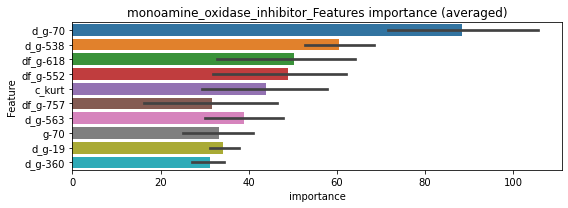

len(train_index) : 2425
len(valid_index) : 2426
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349938	valid_1's binary_logloss: 0.10189
[200]	training's binary_logloss: 0.00747537	valid_1's binary_logloss: 0.072494
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0039451	valid_1's binary_logloss: 0.0687943


len(train_index) : 2426
len(valid_index) : 2425
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038472	valid_1's binary_logloss: 0.100841
[200]	training's binary_logloss: 0.00807309	valid_1's binary_logloss: 0.0712178
[300]	training's binary_logloss: 0.00231804	valid_1's binary_logloss: 0.0673523
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00234081	valid_1's binary_logloss: 0.0673348


monoamine_oxidase_inhibitor logloss: 0.06806471147706064
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657767	valid_1's binary_logloss: 0.106074
[200]	training's binary_logloss: 0.010818	valid_1's binary_logloss: 0.032195
[300]	training's binary_logloss: 0.00331816	valid_1's binary_logloss: 0.0168787
[400]	training's binary_logloss: 0.00181891	valid_1's binary_logloss: 0.0123711
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00143935	valid_1's binary_logloss: 0.0109747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641063	valid_1's binary_logloss: 0.116095
[200]	training's binary_logloss: 0.0104759	valid_1's binary_logloss: 0.0437465
[300]	training's binary_logloss: 0.00339271	valid_1's binary_logloss: 0.024271


1 / 3 AUC score:1.000
Threshold: 0.546964538848536
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00193
p_label_rate: 0.00176 Vs.target_rate: 0.00082, Num_p_label: 7.0, conf_0:0.00193, conf_1:0.54696
threshold:0.55, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00185287	valid_1's binary_logloss: 0.0195509
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00192091	valid_1's binary_logloss: 0.0194328


positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622857	valid_1's binary_logloss: 0.104087
[200]	training's binary_logloss: 0.00970632	valid_1's binary_logloss: 0.0346953
[300]	training's binary_logloss: 0.00312538	valid_1's binary_logloss: 0.0194553
[400]	training's binary_logloss: 0.00176105	valid_1's binary_logloss: 0.0149342
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00139598	valid_1's binary_logloss: 0.0132994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645083	valid_1's binary_logloss: 0.11106
[200]	training's binary_logloss: 0.0104608	valid_1's binary_logloss: 0.036227
[300]	training's binary_logloss: 0.00331358	valid_1's binary_logloss: 0.0194287
[400]	training's binary_logloss: 0.0018378	valid_1's binary_logloss: 0.0148513
[500]	training's binary_logloss: 0.00140217	valid_1's binary_logloss: 0.0127619
Early stopping, best iteration is:
[526]	training's

2 / 3 AUC score:1.000
Threshold: 0.546964538848536
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/995
30th percentile: 0.00157
p_label_rate: 0.00276 Vs.target_rate: 0.00082, Num_p_label: 11.0, conf_0:0.00157, conf_1:0.54696
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_1: 0.55
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_2: 0.59
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_3: 0.63
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_4: 0.67
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_5: 0.71
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_6: 0.75
threshold:0.75, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638309	valid_1's binary_logloss: 0.110806
[200]	training's binary_logloss: 0.00988924	valid_1's binary_logloss: 0.0331792
[300]	training's binary_logloss: 0.00316599	valid_1's binary_logloss: 0.0185911
[400]	training's binary_logloss: 0.00177221	valid_1's binary_logloss: 0.0137913
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00146446	valid_1's binary_logloss: 0.0121882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639187	valid_1's binary_logloss: 0.10563
[200]	training's binary_logloss: 0.0106105	valid_1's binary_logloss: 0.0334412
[300]	training's binary_logloss: 0.00337842	valid_1's binary_logloss: 0.0180489
[400]	training's binary_logloss: 0.001869	valid_1's binary_logloss: 0.013713


3 / 3 AUC score:1.000
Threshold: 0.7469645388485362
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/994
30th percentile: 0.00170
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00170, conf_1:0.74696


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00147019	valid_1's binary_logloss: 0.0119836


threshold:0.75, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:501.0/4976, y_label_rate: 0.10068


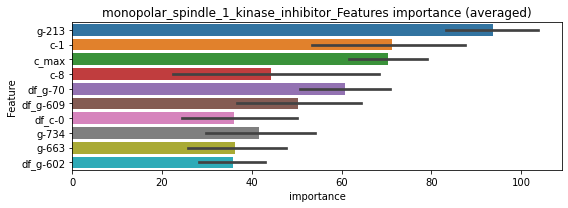

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166073	valid_1's binary_logloss: 0.0314
[200]	training's binary_logloss: 0.00208744	valid_1's binary_logloss: 0.0130274
[300]	training's binary_logloss: 0.000590962	valid_1's binary_logloss: 0.00940725
[400]	training's binary_logloss: 0.000314353	valid_1's binary_logloss: 0.00843284
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000303995	valid_1's binary_logloss: 0.00840551


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159201	valid_1's binary_logloss: 0.0300038
[200]	training's binary_logloss: 0.00192268	valid_1's binary_logloss: 0.0116855
[300]	training's binary_logloss: 0.000554757	valid_1's binary_logloss: 0.00804386


monopolar_spindle_1_kinase_inhibitor logloss: 0.007965299521282566


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00035814	valid_1's binary_logloss: 0.00752509


mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173311	valid_1's binary_logloss: 0.413289
[200]	training's binary_logloss: 0.0561286	valid_1's binary_logloss: 0.327144
[300]	training's binary_logloss: 0.0214885	valid_1's binary_logloss: 0.288709
[400]	training's binary_logloss: 0.0104117	valid_1's binary_logloss: 0.271208
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00662097	valid_1's binary_logloss: 0.262888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165631	valid_1's binary_logloss: 0.423504
[200]	training's binary_logloss: 0.0528594	valid_1's binary_logloss: 0.348845
[300]	training's binary_logloss: 0.0203143	valid_1's binary_logloss: 0.314973
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0178862	valid_1's binary_logloss: 0.311423


1 / 3 AUC score:0.941
Threshold: 0.4399804536971075
Remove_noisy_labels: 134 → positive_corect_labels: 433/866
30th percentile: 0.12654
p_label_rate: 0.08237 Vs.target_rate: 0.00530, Num_p_label: 328.0, conf_0:0.12654, conf_1:0.53909
Num_p_label: 328.0, Expected: 21.1, Adj_threshold_1: 0.44
Num_p_label: 230.0, Expected: 21.1, Adj_threshold_2: 0.48
Num_p_label: 150.0, Expected: 21.1, Adj_threshold_3: 0.52
Num_p_label: 98.0, Expected: 21.1, Adj_threshold_4: 0.56
Num_p_label: 62.0, Expected: 21.1, Adj_threshold_5: 0.60
Num_p_label: 41.0, Expected: 21.1, Adj_threshold_6: 0.64
Num_p_label: 25.0, Expected: 21.1, Adj_threshold_7: 0.68
threshold:0.68, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:433.0/866, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150643	valid_1's binary_logloss: 0.350811
[200]	training's binary_logloss: 0.0440778	valid_1's binary_logloss: 0.255642
[300]	training's binary_logloss: 0.016447	valid_1's binary_logloss: 0.220958
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0101625	valid_1's binary_logloss: 0.211464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156558	valid_1's binary_logloss: 0.386223
[200]	training's binary_logloss: 0.0470629	valid_1's binary_logloss: 0.289126
[300]	training's binary_logloss: 0.0173506	valid_1's binary_logloss: 0.247013
[400]	training's binary_logloss: 0.00832487	valid_1's binary_logloss: 0.22582
[500]	training's binary_logloss: 0.0051036	valid_1's binary_logloss: 0.213543
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00514581	valid_1's binary_logloss: 0.213179


2 / 3 AUC score:0.970
Threshold: 0.6799804536971076
Remove_noisy_labels: 70 → positive_corect_labels: 370.0/796
30th percentile: 0.07601
p_label_rate: 0.03039 Vs.target_rate: 0.00530, Num_p_label: 121.0, conf_0:0.07601, conf_1:0.67998
Num_p_label: 121.0, Expected: 21.1, Adj_threshold_1: 0.68
Num_p_label: 93.0, Expected: 21.1, Adj_threshold_2: 0.72
Num_p_label: 58.0, Expected: 21.1, Adj_threshold_3: 0.76
Num_p_label: 42.0, Expected: 21.1, Adj_threshold_4: 0.80
Num_p_label: 25.0, Expected: 21.1, Adj_threshold_5: 0.84
threshold:0.84, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:370.0/796, y_label_rate: 0.46482
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138753	valid_1's binary_logloss: 0.321036
[200]	training's binary_logloss: 0.0402415	valid_1's binary_logloss: 0.218507
[300]	training's binary_logloss: 0.0144374	valid_1's binary_logloss: 0.178798
[400]	training's binary_logloss: 0.00710171	valid_1's binary_logloss: 0.165492
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00698297	valid_1's binary_logloss: 0.165388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136925	valid_1's binary_logloss: 0.311602
[200]	training's binary_logloss: 0.0392327	valid_1's binary_logloss: 0.20344
[300]	training's binary_logloss: 0.0145293	valid_1's binary_logloss: 0.163158
[400]	training's binary_logloss: 0.007202	valid_1's binary_logloss: 0.142444
[500]	training's binary_logloss: 0.00455939	valid_1's binary_logloss: 0.133618
[600]	training's binary_logloss: 0.00336104	valid_1's binary_log

3 / 3 AUC score:0.989
Threshold: 0.8399804536971077
Remove_noisy_labels: 60 → positive_corect_labels: 312.0/736
30th percentile: 0.04105
p_label_rate: 0.01306 Vs.target_rate: 0.00530, Num_p_label: 52.0, conf_0:0.03394, conf_1:0.83998
threshold:0.84, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:364.0/4718, y_label_rate: 0.07715


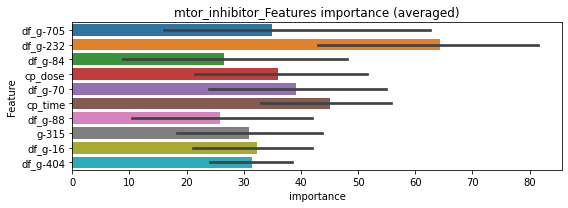

len(train_index) : 2359
len(valid_index) : 2359
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351466	valid_1's binary_logloss: 0.114663
[200]	training's binary_logloss: 0.00717828	valid_1's binary_logloss: 0.0971878


len(train_index) : 2359
len(valid_index) : 2359


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00683023	valid_1's binary_logloss: 0.0968512


================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346659	valid_1's binary_logloss: 0.107357
[200]	training's binary_logloss: 0.00789583	valid_1's binary_logloss: 0.0837029


mtor_inhibitor logloss: 0.08986546475445241


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00716963	valid_1's binary_logloss: 0.0828797


mucolytic_agent , len(trt) : 48


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105787	valid_1's binary_logloss: 0.228841
[200]	training's binary_logloss: 0.0244015	valid_1's binary_logloss: 0.130749
[300]	training's binary_logloss: 0.00829053	valid_1's binary_logloss: 0.0984484
[400]	training's binary_logloss: 0.004041	valid_1's binary_logloss: 0.0836492
[500]	training's binary_logloss: 0.00264316	valid_1's binary_logloss: 0.077105
[600]	training's binary_logloss: 0.00205526	valid_1's binary_logloss: 0.0728842
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.00195014	valid_1's binary_logloss: 0.0718356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109785	valid_1's binary_logloss: 0.2204
[200]	training's binary_logloss: 0.025953	valid_1's binary_logloss: 0.109244
[300]	training's binary_logloss: 0.00866263	valid_1's binary_logloss: 0.070804
[400]	training's binary_logloss: 0.00430797	valid_1's binary

1 / 3 AUC score:0.998
Threshold: 0.3380819780572796
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentile: 0.01157
p_label_rate: 0.01632 Vs.target_rate: 0.00212, Num_p_label: 65.0, conf_0:0.01157, conf_1:0.45835
Num_p_label: 65.0, Expected: 8.4, Adj_threshold_1: 0.34
Num_p_label: 44.0, Expected: 8.4, Adj_threshold_2: 0.38
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_3: 0.42
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_4: 0.46
Num_p_label: 15.0, Expected: 8.4, Adj_threshold_5: 0.50
Num_p_label: 13.0, Expected: 8.4, Adj_threshold_6: 0.54
Num_p_label: 7.0, Expected: 8.4, Adj_threshold_7: 0.58
threshold:0.58, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105373	valid_1's binary_logloss: 0.204231
[200]	training's binary_logloss: 0.0245093	valid_1's binary_logloss: 0.102258
[300]	training's binary_logloss: 0.00817221	valid_1's binary_logloss: 0.0730159
[400]	training's binary_logloss: 0.00410317	valid_1's binary_logloss: 0.0598913
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0038937	valid_1's binary_logloss: 0.0587481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10548	valid_1's binary_logloss: 0.204581
[200]	training's binary_logloss: 0.0244551	valid_1's binary_logloss: 0.093313
[300]	training's binary_logloss: 0.00820419	valid_1's binary_logloss: 0.0575503
[400]	training's binary_logloss: 0.00410753	valid_1's binary_logloss: 0.0438591
[500]	training's binary_logloss: 0.0026466	valid_1's binary_logloss: 0.0374403
[600]	training's binary_logloss: 0.00205185	valid_1's bi

2 / 3 AUC score:1.000
Threshold: 0.5780819780572796
Remove_noisy_labels: 13 → positive_corect_labels: 478.0/969
30th percentile: 0.01348
p_label_rate: 0.00276 Vs.target_rate: 0.00212, Num_p_label: 11.0, conf_0:0.01348, conf_1:0.57808
threshold:0.58, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:478.0/969, y_label_rate: 0.49329
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102955	valid_1's binary_logloss: 0.205738
[200]	training's binary_logloss: 0.0244039	valid_1's binary_logloss: 0.100298
[300]	training's binary_logloss: 0.00796528	valid_1's binary_logloss: 0.0659901
[400]	training's binary_logloss: 0.00394624	valid_1's binary_logloss: 0.0517563
[500]	training's binary_logloss: 0.00257524	valid_1's binary_logloss: 0.0453578
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00207591	valid_1's binary_logloss: 0.0413771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999738	valid_1's binary_logloss: 0.207452
[200]	training's binary_logloss: 0.022724	valid_1's binary_logloss: 0.0994493
[300]	training's binary_logloss: 0.00767012	valid_1's binary_logloss: 0.064932
[400]	training's binary_logloss: 0.00388073	valid_1's binary_logloss: 0.0500211
[500]	training's binary_logloss: 0.00254485	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.5780819780572796
Remove_noisy_labels: 10 → positive_corect_labels: 469.0/959
30th percentile: 0.01013
p_label_rate: 0.00251 Vs.target_rate: 0.00212, Num_p_label: 10.0, conf_0:0.01013, conf_1:0.57808
threshold:0.58, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:479.0/4941, y_label_rate: 0.09694


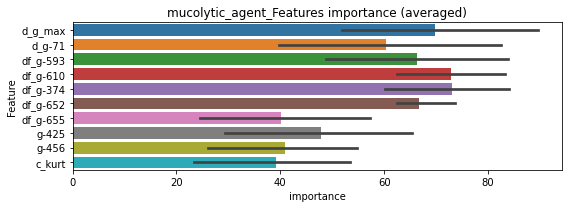

len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255194	valid_1's binary_logloss: 0.0593459
[200]	training's binary_logloss: 0.00433328	valid_1's binary_logloss: 0.0322312
[300]	training's binary_logloss: 0.00123368	valid_1's binary_logloss: 0.0279659
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00121174	valid_1's binary_logloss: 0.027943


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302944	valid_1's binary_logloss: 0.0609757
[200]	training's binary_logloss: 0.00532157	valid_1's binary_logloss: 0.0313298
[300]	training's binary_logloss: 0.00145766	valid_1's binary_logloss: 0.0269005
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00111271	valid_1's binary_logloss: 0.0265511


mucolytic_agent logloss: 0.027247163348165758
neuropeptide_receptor_antagonist , len(trt) : 37


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986268	valid_1's binary_logloss: 0.182278
[200]	training's binary_logloss: 0.0219335	valid_1's binary_logloss: 0.0774762
[300]	training's binary_logloss: 0.00709299	valid_1's binary_logloss: 0.0475794
[400]	training's binary_logloss: 0.00358292	valid_1's binary_logloss: 0.0358617
[500]	training's binary_logloss: 0.0024189	valid_1's binary_logloss: 0.030996
[600]	training's binary_logloss: 0.00194147	valid_1's binary_logloss: 0.0284222
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00185913	valid_1's binary_logloss: 0.0278157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975372	valid_1's binary_logloss: 0.200032
[200]	training's binary_logloss: 0.021267	valid_1's binary_logloss: 0.0990868
[300]	training's binary_logloss: 0.00697006	valid_1's binary_logloss: 0.0661679
[400]	training's binary_logloss: 0.00352406	valid_1'

1 / 3 AUC score:0.999
Threshold: 0.2942325936430076
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.01079
p_label_rate: 0.01105 Vs.target_rate: 0.00165, Num_p_label: 44.0, conf_0:0.01079, conf_1:0.45285
Num_p_label: 44.0, Expected: 6.6, Adj_threshold_1: 0.29
Num_p_label: 30.0, Expected: 6.6, Adj_threshold_2: 0.33
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_3: 0.37
Num_p_label: 13.0, Expected: 6.6, Adj_threshold_4: 0.41
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_5: 0.45
threshold:0.45, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994921	valid_1's binary_logloss: 0.186679
[200]	training's binary_logloss: 0.0217744	valid_1's binary_logloss: 0.0751214
[300]	training's binary_logloss: 0.00730262	valid_1's binary_logloss: 0.0436544
[400]	training's binary_logloss: 0.00362481	valid_1's binary_logloss: 0.0321641
[500]	training's binary_logloss: 0.00241632	valid_1's binary_logloss: 0.0268031
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00195877	valid_1's binary_logloss: 0.023866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968224	valid_1's binary_logloss: 0.196616
[200]	training's binary_logloss: 0.0210773	valid_1's binary_logloss: 0.0879893
[300]	training's binary_logloss: 0.00689732	valid_1's binary_logloss: 0.0573323
[400]	training's binary_logloss: 0.00352808	valid_1's binary_logloss: 0.0451204
[500]	training's binary_logloss: 0.00236212	valid_

2 / 3 AUC score:1.000
Threshold: 0.4542325936430075
Remove_noisy_labels: 6 → positive_corect_labels: 491.0/982
30th percentile: 0.00945
p_label_rate: 0.00276 Vs.target_rate: 0.00165, Num_p_label: 11.0, conf_0:0.00724, conf_1:0.45423
threshold:0.45, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991866	valid_1's binary_logloss: 0.193098
[200]	training's binary_logloss: 0.0216482	valid_1's binary_logloss: 0.0807458
[300]	training's binary_logloss: 0.00713079	valid_1's binary_logloss: 0.0470889
[400]	training's binary_logloss: 0.0036054	valid_1's binary_logloss: 0.0352579
[500]	training's binary_logloss: 0.0023911	valid_1's binary_logloss: 0.0293576
[600]	training's binary_logloss: 0.00191113	valid_1's binary_logloss: 0.0258947
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.0018689	valid_1's binary_logloss: 0.025577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985236	valid_1's binary_logloss: 0.187408
[200]	training's binary_logloss: 0.0215816	valid_1's binary_logloss: 0.0757704
[300]	training's binary_logloss: 0.00710117	valid_1's binary_logloss: 0.0438234
[400]	training's binary_logloss: 0.00354235	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.4542325936430075
Remove_noisy_labels: 1 → positive_corect_labels: 491.0/981
30th percentile: 0.00853
p_label_rate: 0.00151 Vs.target_rate: 0.00165, Num_p_label: 6.0, conf_0:0.00680, conf_1:0.45423
threshold:0.45, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:497.0/4963, y_label_rate: 0.10014


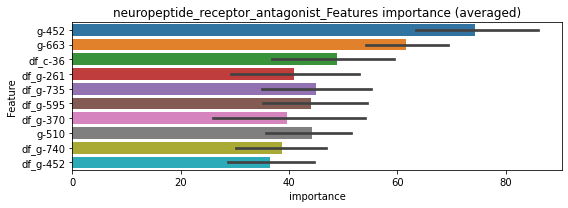

len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268489	valid_1's binary_logloss: 0.0584179
[200]	training's binary_logloss: 0.0044067	valid_1's binary_logloss: 0.0297295
[300]	training's binary_logloss: 0.00120365	valid_1's binary_logloss: 0.0233224
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000706144	valid_1's binary_logloss: 0.0219598


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280028	valid_1's binary_logloss: 0.0513668
[200]	training's binary_logloss: 0.00447277	valid_1's binary_logloss: 0.0193303
[300]	training's binary_logloss: 0.00124448	valid_1's binary_logloss: 0.012847
[400]	training's binary_logloss: 0.000607262	valid_1's binary_logloss: 0.0113748
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000595069	valid_1's binary_logloss: 0.0113644


neuropeptide_receptor_antagonist logloss: 0.01666316603627205
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.627093	valid_1's binary_logloss: 0.691013
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.540
Threshold: 0.497079721810184
Remove_noisy_labels: 784 → positive_corect_labels: 440/880
30th percentile: 0.48467
p_label_rate: 0.49975 Vs.target_rate: 0.00936, Num_p_label: 1990.0, conf_0:0.48467, conf_1:0.49708
Num_p_label: 1990.0, Expected: 37.3, Adj_threshold_1: 0.50
Num_p_label: 208.0, Expected: 37.3, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[16]	training's binary_logloss: 0.579681	valid_1's binary_logloss: 0.69046


positive y_label:440.0/880, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.380611	valid_1's binary_logloss: 0.668993
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.641
Threshold: 0.5770797218101841
Remove_noisy_labels: 372 → positive_corect_labels: 147.0/508
30th percentile: 0.45917
p_label_rate: 0.21447 Vs.target_rate: 0.00936, Num_p_label: 854.0, conf_0:0.45917, conf_1:0.57708
Num_p_label: 854.0, Expected: 37.3, Adj_threshold_1: 0.58
Num_p_label: 394.0, Expected: 37.3, Adj_threshold_2: 0.62
Num_p_label: 118.0, Expected: 37.3, Adj_threshold_3: 0.66
Num_p_label: 12.0, Expected: 37.3, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.383033	valid_1's binary_logloss: 0.659159


positive y_label:147.0/508, y_label_rate: 0.28937
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14996	valid_1's binary_logloss: 0.381321
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0732905	valid_1's binary_logloss: 0.362746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138259	valid_1's binary_logloss: 0.391338
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0988303	valid_1's binary_logloss: 0.37562


3 / 3 AUC score:0.916
Threshold: 0.6970797218101842
Remove_noisy_labels: 123 → positive_corect_labels: 27.0/385
30th percentile: 0.10151
p_label_rate: 0.04621 Vs.target_rate: 0.00936, Num_p_label: 184.0, conf_0:0.10151, conf_1:0.69708
Num_p_label: 184.0, Expected: 37.3, Adj_threshold_1: 0.70
Num_p_label: 122.0, Expected: 37.3, Adj_threshold_2: 0.74
Num_p_label: 56.0, Expected: 37.3, Adj_threshold_3: 0.78
Num_p_label: 14.0, Expected: 37.3, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:41.0/4367, y_label_rate: 0.00939


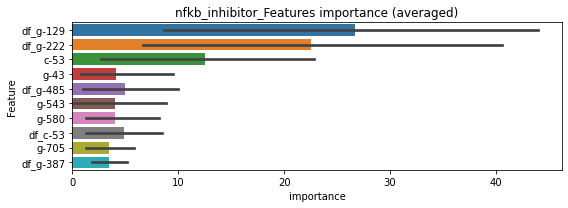

len(train_index) : 2183
len(valid_index) : 2184
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2184
len(valid_index) : 2183
================================= fold 2/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0247259	valid_1's binary_logloss: 0.0492337
Training until validation scores don't improve for 10 rounds


nfkb_inhibitor logloss: 0.048873178022801694
nicotinic_receptor_agonist , len(trt) : 12


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0162676	valid_1's binary_logloss: 0.0485125
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550394	valid_1's binary_logloss: 0.0805071
[200]	training's binary_logloss: 0.00806166	valid_1's binary_logloss: 0.018874
[300]	training's binary_logloss: 0.00251409	valid_1's binary_logloss: 0.00822858
[400]	training's binary_logloss: 0.0014446	valid_1's binary_logloss: 0.00560837
[500]	training's binary_logloss: 0.00115564	valid_1's binary_logloss: 0.00473801
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00111094	valid_1's binary_logloss: 0.00459465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545429	valid_1's binary_logloss: 0.0820825
[200]	training's binary_logloss: 0.00798647	valid_1's binary_logloss: 0.0219187
[300]	training's binary_logloss: 0.00253072	valid_1's binary_logloss: 0.0101973
[400]	training's binary_logloss: 0.00144202	valid_1's binary_logloss: 0.00725162
Early stopping, best iteration is:
[460]	t

1 / 3 AUC score:1.000
Threshold: 0.3846134685592841
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00147
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00147, conf_1:0.38461
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.38
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_2: 0.34
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_3: 0.30
threshold:0.30, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550394	valid_1's binary_logloss: 0.0805071
[200]	training's binary_logloss: 0.00806166	valid_1's binary_logloss: 0.018874
[300]	training's binary_logloss: 0.00251409	valid_1's binary_logloss: 0.00822858
[400]	training's binary_logloss: 0.0014446	valid_1's binary_logloss: 0.00560837
[500]	training's binary_logloss: 0.00115564	valid_1's binary_logloss: 0.00473801
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00111094	valid_1's binary_logloss: 0.00459465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545429	valid_1's binary_logloss: 0.0820825
[200]	training's binary_logloss: 0.00798647	valid_1's binary_logloss: 0.0219187
[300]	training's binary_logloss: 0.00253072	valid_1's binary_logloss: 0.0101973
[400]	training's binary_logloss: 0.00144202	valid_1's binary_logloss: 0.00725162
Early stopping, best iteration is:
[460]	t

2 / 3 AUC score:1.000
Threshold: 0.3046134685592841
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00147
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00147, conf_1:0.30461
threshold:0.30, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550394	valid_1's binary_logloss: 0.0805071
[200]	training's binary_logloss: 0.00806166	valid_1's binary_logloss: 0.018874
[300]	training's binary_logloss: 0.00251409	valid_1's binary_logloss: 0.00822858
[400]	training's binary_logloss: 0.0014446	valid_1's binary_logloss: 0.00560837
[500]	training's binary_logloss: 0.00115564	valid_1's binary_logloss: 0.00473801
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00111094	valid_1's binary_logloss: 0.00459465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545429	valid_1's binary_logloss: 0.0820825
[200]	training's binary_logloss: 0.00798647	valid_1's binary_logloss: 0.0219187
[300]	training's binary_logloss: 0.00253072	valid_1's binary_logloss: 0.0101973
[400]	training's binary_logloss: 0.00144202	valid_1's binary_logloss: 0.00725162
Early stopping, best iteration is:
[460]	t

3 / 3 AUC score:1.000
Threshold: 0.3046134685592841
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00147
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00147, conf_1:0.30461
threshold:0.30, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4982, y_label_rate: 0.10116


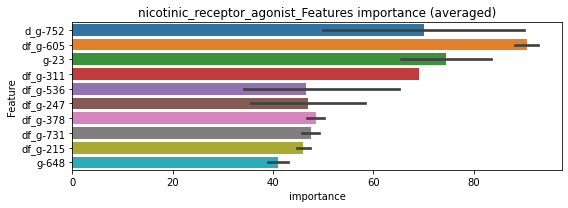

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134495	valid_1's binary_logloss: 0.0237779
[200]	training's binary_logloss: 0.00148809	valid_1's binary_logloss: 0.00842707
[300]	training's binary_logloss: 0.000436031	valid_1's binary_logloss: 0.00631368
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000279535	valid_1's binary_logloss: 0.00588953


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134258	valid_1's binary_logloss: 0.0234329
[200]	training's binary_logloss: 0.0014309	valid_1's binary_logloss: 0.0105169


nicotinic_receptor_agonist logloss: 0.007593809829660425
nitric_oxide_donor , len(trt) : 26


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000532536	valid_1's binary_logloss: 0.00929809


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788671	valid_1's binary_logloss: 0.155206
[200]	training's binary_logloss: 0.0147413	valid_1's binary_logloss: 0.0720273
[300]	training's binary_logloss: 0.00474106	valid_1's binary_logloss: 0.0461356
[400]	training's binary_logloss: 0.00247537	valid_1's binary_logloss: 0.0388466
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00193906	valid_1's binary_logloss: 0.0348794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805904	valid_1's binary_logloss: 0.155769
[200]	training's binary_logloss: 0.0152377	valid_1's binary_logloss: 0.0862309
[300]	training's binary_logloss: 0.00477321	valid_1's binary_logloss: 0.0709881
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00473448	valid_1's binary_logloss: 0.070708


1 / 3 AUC score:0.997
Threshold: 0.534679142282871
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.00486
p_label_rate: 0.00829 Vs.target_rate: 0.00117, Num_p_label: 33.0, conf_0:0.00486, conf_1:0.54503
Num_p_label: 33.0, Expected: 4.7, Adj_threshold_1: 0.53
Num_p_label: 25.0, Expected: 4.7, Adj_threshold_2: 0.57
Num_p_label: 23.0, Expected: 4.7, Adj_threshold_3: 0.61
Num_p_label: 11.0, Expected: 4.7, Adj_threshold_4: 0.65
Num_p_label: 8.0, Expected: 4.7, Adj_threshold_5: 0.69
Num_p_label: 3.0, Expected: 4.7, Adj_threshold_6: 0.73
threshold:0.73, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775286	valid_1's binary_logloss: 0.16952
[200]	training's binary_logloss: 0.0139572	valid_1's binary_logloss: 0.0801076
[300]	training's binary_logloss: 0.00444923	valid_1's binary_logloss: 0.0588542
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00319008	valid_1's binary_logloss: 0.0545083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818753	valid_1's binary_logloss: 0.131654
[200]	training's binary_logloss: 0.0154702	valid_1's binary_logloss: 0.048196
[300]	training's binary_logloss: 0.00490482	valid_1's binary_logloss: 0.0275975
[400]	training's binary_logloss: 0.00255945	valid_1's binary_logloss: 0.0213524
[500]	training's binary_logloss: 0.00176125	valid_1's binary_logloss: 0.0188777
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00155039	valid_1's binary_logloss: 0.0176207


2 / 3 AUC score:1.000
Threshold: 0.7346791422828711
Remove_noisy_labels: 10 → positive_corect_labels: 486.0/978
30th percentile: 0.00268
p_label_rate: 0.00402 Vs.target_rate: 0.00117, Num_p_label: 16.0, conf_0:0.00268, conf_1:0.73468
Num_p_label: 16.0, Expected: 4.7, Adj_threshold_1: 0.73
Num_p_label: 11.0, Expected: 4.7, Adj_threshold_2: 0.77
Num_p_label: 5.0, Expected: 4.7, Adj_threshold_3: 0.81
threshold:0.81, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:486.0/978, y_label_rate: 0.49693
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815209	valid_1's binary_logloss: 0.141507
[200]	training's binary_logloss: 0.0148254	valid_1's binary_logloss: 0.055488
[300]	training's binary_logloss: 0.00473359	valid_1's binary_logloss: 0.0334287
[400]	training's binary_logloss: 0.00247972	valid_1's binary_logloss: 0.0266498
[500]	training's binary_logloss: 0.00173494	valid_1's binary_logloss: 0.0236959
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00154811	valid_1's binary_logloss: 0.0223368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786083	valid_1's binary_logloss: 0.14913
[200]	training's binary_logloss: 0.0144092	valid_1's binary_logloss: 0.0650861
[300]	training's binary_logloss: 0.00459235	valid_1's binary_logloss: 0.0410462
[400]	training's binary_logloss: 0.00237265	valid_1's binary_logloss: 0.0326021
[500]	training's binary_logloss: 0.00167436	valid_1

3 / 3 AUC score:1.000
Threshold: 0.8146791422828712
Remove_noisy_labels: 8 → positive_corect_labels: 479.0/970
30th percentile: 0.00177
p_label_rate: 0.00100 Vs.target_rate: 0.00117, Num_p_label: 4.0, conf_0:0.00177, conf_1:0.81468
threshold:0.81, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:483.0/4952, y_label_rate: 0.09754


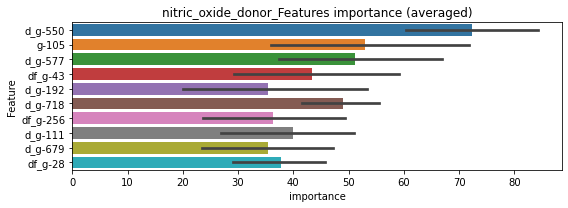

len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194028	valid_1's binary_logloss: 0.035219
[200]	training's binary_logloss: 0.00283394	valid_1's binary_logloss: 0.0145874
[300]	training's binary_logloss: 0.000817903	valid_1's binary_logloss: 0.0105269
[400]	training's binary_logloss: 0.000416094	valid_1's binary_logloss: 0.00939682
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000366205	valid_1's binary_logloss: 0.00923176


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201924	valid_1's binary_logloss: 0.0331526
[200]	training's binary_logloss: 0.00282221	valid_1's binary_logloss: 0.00960827
[300]	training's binary_logloss: 0.000809136	valid_1's binary_logloss: 0.00591516
[400]	training's binary_logloss: 0.000415098	valid_1's binary_logloss: 0.00524598
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00039568	valid_1's binary_logloss: 0.00518551


nitric_oxide_donor logloss: 0.007208631768741119
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797281	valid_1's binary_logloss: 0.149127
[200]	training's binary_logloss: 0.015369	valid_1's binary_logloss: 0.0573029
[300]	training's binary_logloss: 0.0048769	valid_1's binary_logloss: 0.0316845
[400]	training's binary_logloss: 0.00251203	valid_1's binary_logloss: 0.0227298
[500]	training's binary_logloss: 0.00172377	valid_1's binary_logloss: 0.0188006
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.0015153	valid_1's binary_logloss: 0.0173425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800467	valid_1's binary_logloss: 0.14469
[200]	training's binary_logloss: 0.0152158	valid_1's binary_logloss: 0.0508002
[300]	training's binary_logloss: 0.00483349	valid_1's binary_logloss: 0.0263967
[400]	training's binary_logloss: 0.00248718	valid_1's binary_logloss: 0.0189432
[500]	training's binary_logloss: 0.00170667	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.5506607680177582
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00363
p_label_rate: 0.00025 Vs.target_rate: 0.00130, Num_p_label: 1.0, conf_0:0.00363, conf_1:0.55066
Num_p_label: 1.0, Expected: 5.2, Adj_threshold_1: 0.55
Num_p_label: 1.0, Expected: 5.2, Adj_threshold_2: 0.51
Num_p_label: 2.0, Expected: 5.2, Adj_threshold_3: 0.47
Num_p_label: 2.0, Expected: 5.2, Adj_threshold_4: 0.43
Num_p_label: 4.0, Expected: 5.2, Adj_threshold_5: 0.39
threshold:0.39, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791015	valid_1's binary_logloss: 0.147878
[200]	training's binary_logloss: 0.014904	valid_1's binary_logloss: 0.055911
[300]	training's binary_logloss: 0.00480196	valid_1's binary_logloss: 0.0307015
[400]	training's binary_logloss: 0.00249752	valid_1's binary_logloss: 0.0222444
[500]	training's binary_logloss: 0.00172235	valid_1's binary_logloss: 0.0182971
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00149173	valid_1's binary_logloss: 0.0165406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778541	valid_1's binary_logloss: 0.146125
[200]	training's binary_logloss: 0.0147805	valid_1's binary_logloss: 0.0556061
[300]	training's binary_logloss: 0.00471442	valid_1's binary_logloss: 0.0310414
[400]	training's binary_logloss: 0.00245645	valid_1's binary_logloss: 0.0220705
[500]	training's binary_logloss: 0.00171263	valid_1

2 / 3 AUC score:1.000
Threshold: 0.39066076801775823
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/997
30th percentile: 0.00353
p_label_rate: 0.00176 Vs.target_rate: 0.00130, Num_p_label: 7.0, conf_0:0.00353, conf_1:0.39066
threshold:0.39, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/997, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789285	valid_1's binary_logloss: 0.131365
[200]	training's binary_logloss: 0.0150498	valid_1's binary_logloss: 0.0458187
[300]	training's binary_logloss: 0.00483968	valid_1's binary_logloss: 0.0248413
[400]	training's binary_logloss: 0.0025196	valid_1's binary_logloss: 0.0176355
[500]	training's binary_logloss: 0.00175112	valid_1's binary_logloss: 0.0145609
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00152377	valid_1's binary_logloss: 0.0131299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793122	valid_1's binary_logloss: 0.137918
[200]	training's binary_logloss: 0.0151634	valid_1's binary_logloss: 0.0490453
[300]	training's binary_logloss: 0.00479868	valid_1's binary_logloss: 0.0253129
[400]	training's binary_logloss: 0.00249468	valid_1's binary_logloss: 0.0179629
[500]	training's binary_logloss: 0.00172308	valid_

3 / 3 AUC score:1.000
Threshold: 0.39066076801775823
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/997
30th percentile: 0.00347
p_label_rate: 0.00075 Vs.target_rate: 0.00130, Num_p_label: 3.0, conf_0:0.00347, conf_1:0.48357
threshold:0.39, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:501.0/4979, y_label_rate: 0.10062


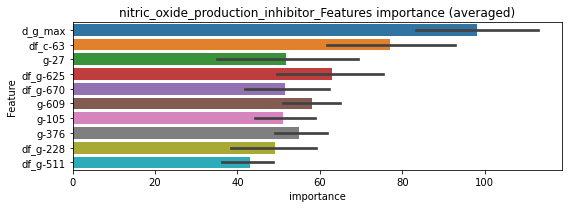

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212717	valid_1's binary_logloss: 0.0303892
[200]	training's binary_logloss: 0.00298355	valid_1's binary_logloss: 0.0072321
[300]	training's binary_logloss: 0.00083206	valid_1's binary_logloss: 0.00402342
[400]	training's binary_logloss: 0.000423426	valid_1's binary_logloss: 0.00340165
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000335182	valid_1's binary_logloss: 0.00322394


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212344	valid_1's binary_logloss: 0.0358588
[200]	training's binary_logloss: 0.00286591	valid_1's binary_logloss: 0.0113417
[300]	training's binary_logloss: 0.00080968	valid_1's binary_logloss: 0.00733669
[400]	training's binary_logloss: 0.000415828	valid_1's binary_logloss: 0.00632006
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000379695	valid_1's binary_logloss: 0.00618755


nitric_oxide_production_inhibitor logloss: 0.00470544640685892
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0825894	valid_1's binary_logloss: 0.135111
[200]	training's binary_logloss: 0.0157714	valid_1's binary_logloss: 0.0459929
[300]	training's binary_logloss: 0.00504812	valid_1's binary_logloss: 0.0236916
[400]	training's binary_logloss: 0.00261354	valid_1's binary_logloss: 0.0170857
[500]	training's binary_logloss: 0.00180907	valid_1's binary_logloss: 0.013813
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00177038	valid_1's binary_logloss: 0.013496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799081	valid_1's binary_logloss: 0.147036
[200]	training's binary_logloss: 0.0150035	valid_1's binary_logloss: 0.057168
[300]	training's binary_logloss: 0.004885	valid_1's binary_logloss: 0.0325765
[400]	training's binary_logloss: 0.00255359	valid_1's binary_logloss: 0.0238746
[500]	training's binary_logloss: 0.00176511	valid_1's 

1 / 3 AUC score:1.000
Threshold: 0.47029713773446
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00361
p_label_rate: 0.00301 Vs.target_rate: 0.00117, Num_p_label: 12.0, conf_0:0.00361, conf_1:0.47030
threshold:0.47, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805386	valid_1's binary_logloss: 0.131202
[200]	training's binary_logloss: 0.0156073	valid_1's binary_logloss: 0.0435801
[300]	training's binary_logloss: 0.00499083	valid_1's binary_logloss: 0.0219949
[400]	training's binary_logloss: 0.00258808	valid_1's binary_logloss: 0.0150527
[500]	training's binary_logloss: 0.00180655	valid_1's binary_logloss: 0.0121528
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.0016408	valid_1's binary_logloss: 0.0113464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815581	valid_1's binary_logloss: 0.147981
[200]	training's binary_logloss: 0.0158246	valid_1's binary_logloss: 0.0563197
[300]	training's binary_logloss: 0.0050043	valid_1's binary_logloss: 0.031187
[400]	training's binary_logloss: 0.00257605	valid_1's binary_logloss: 0.0230614


2 / 3 AUC score:1.000
Threshold: 0.47029713773446


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00197063	valid_1's binary_logloss: 0.020244


Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
30th percentile: 0.00377
p_label_rate: 0.00226 Vs.target_rate: 0.00117, Num_p_label: 9.0, conf_0:0.00377, conf_1:0.47030
threshold:0.47, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803256	valid_1's binary_logloss: 0.138816
[200]	training's binary_logloss: 0.0155051	valid_1's binary_logloss: 0.0494859
[300]	training's binary_logloss: 0.00494978	valid_1's binary_logloss: 0.0268905
[400]	training's binary_logloss: 0.00257325	valid_1's binary_logloss: 0.0194778
[500]	training's binary_logloss: 0.00179022	valid_1's binary_logloss: 0.0160649
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00159875	valid_1's binary_logloss: 0.0151712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082794	valid_1's binary_logloss: 0.140945
[200]	training's binary_logloss: 0.0157169	valid_1's binary_logloss: 0.050738
[300]	training's binary_logloss: 0.00501488	valid_1's binary_logloss: 0.0279296
[400]	training's binary_logloss: 0.00257143	valid_1's binary_logloss: 0.020101


3 / 3 AUC score:1.000
Threshold: 0.47029713773446
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
30th percentile: 0.00392
p_label_rate: 0.00276 Vs.target_rate: 0.00117, Num_p_label: 11.0, conf_0:0.00392, conf_1:0.47030


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00196587	valid_1's binary_logloss: 0.0179029


threshold:0.47, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:510.0/4979, y_label_rate: 0.10243


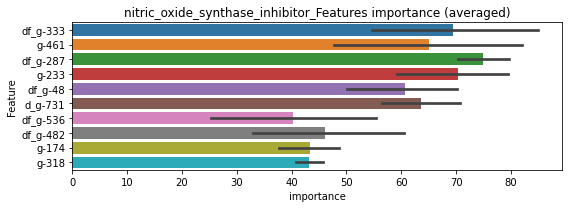

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213876	valid_1's binary_logloss: 0.0374218
[200]	training's binary_logloss: 0.00307666	valid_1's binary_logloss: 0.0147434
[300]	training's binary_logloss: 0.000871323	valid_1's binary_logloss: 0.0110001
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000588196	valid_1's binary_logloss: 0.0104298


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227119	valid_1's binary_logloss: 0.0429268
[200]	training's binary_logloss: 0.00318327	valid_1's binary_logloss: 0.017003
[300]	training's binary_logloss: 0.000881202	valid_1's binary_logloss: 0.0122073
[400]	training's binary_logloss: 0.000441828	valid_1's binary_logloss: 0.0111557
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000427663	valid_1's binary_logloss: 0.0111222


nitric_oxide_synthase_inhibitor logloss: 0.01077592304133957
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038275	valid_1's binary_logloss: 0.0449575
[200]	training's binary_logloss: 0.004742	valid_1's binary_logloss: 0.00723825
[300]	training's binary_logloss: 0.00154281	valid_1's binary_logloss: 0.00279294
[400]	training's binary_logloss: 0.000984677	valid_1's binary_logloss: 0.00192066
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000953881	valid_1's binary_logloss: 0.00185186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379323	valid_1's binary_logloss: 0.0538049
[200]	training's binary_logloss: 0.00463886	valid_1's binary_logloss: 0.0102458
[300]	training's binary_logloss: 0.00153087	valid_1's binary_logloss: 0.00483094
[400]	training's binary_logloss: 0.000967129	valid_1's binary_logloss: 0.00343767
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000886282	valid_1's binary_logloss: 0.00315738


1 / 3 AUC score:1.000
Threshold: 0.5930753837666929
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00068
p_label_rate: 0.00000 Vs.target_rate: 0.00032, Num_p_label: 0.0, conf_0:0.00068, conf_1:0.59308
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_1: 0.59
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_2: 0.55
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_3: 0.51
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_4: 0.47
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_5: 0.43
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_6: 0.39
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_7: 0.35
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_8: 0.31
Num_p_label: 1.0, Expected: 1.3, Adj_threshold_9: 0.27
threshold:0.27, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038275	valid_1's binary_logloss: 0.0449575
[200]	training's binary_logloss: 0.004742	valid_1's binary_logloss: 0.00723825
[300]	training's binary_logloss: 0.00154281	valid_1's binary_logloss: 0.00279294
[400]	training's binary_logloss: 0.000984677	valid_1's binary_logloss: 0.00192066
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000953881	valid_1's binary_logloss: 0.00185186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379323	valid_1's binary_logloss: 0.0538049
[200]	training's binary_logloss: 0.00463886	valid_1's binary_logloss: 0.0102458
[300]	training's binary_logloss: 0.00153087	valid_1's binary_logloss: 0.00483094
[400]	training's binary_logloss: 0.000967129	valid_1's binary_logloss: 0.00343767
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000886282	valid_1's binary_logloss: 0.00315738


2 / 3 AUC score:1.000
Threshold: 0.27307538376669294
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00068
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00068, conf_1:0.27308
threshold:0.27, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038275	valid_1's binary_logloss: 0.0449575
[200]	training's binary_logloss: 0.004742	valid_1's binary_logloss: 0.00723825
[300]	training's binary_logloss: 0.00154281	valid_1's binary_logloss: 0.00279294
[400]	training's binary_logloss: 0.000984677	valid_1's binary_logloss: 0.00192066
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000953881	valid_1's binary_logloss: 0.00185186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379323	valid_1's binary_logloss: 0.0538049
[200]	training's binary_logloss: 0.00463886	valid_1's binary_logloss: 0.0102458
[300]	training's binary_logloss: 0.00153087	valid_1's binary_logloss: 0.00483094
[400]	training's binary_logloss: 0.000967129	valid_1's binary_logloss: 0.00343767
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000886282	valid_1's binary_logloss: 0.00315738


3 / 3 AUC score:1.000
Threshold: 0.27307538376669294
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00068
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00068, conf_1:0.27308
threshold:0.27, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


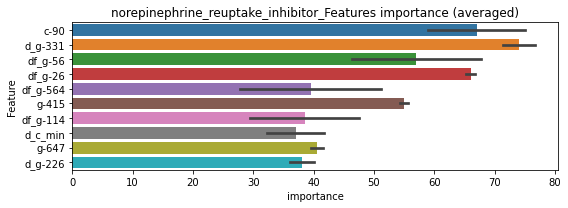

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104681	valid_1's binary_logloss: 0.0128069
[200]	training's binary_logloss: 0.000963782	valid_1's binary_logloss: 0.00302269
[300]	training's binary_logloss: 0.000278613	valid_1's binary_logloss: 0.0023866


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000250451	valid_1's binary_logloss: 0.00237247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106012	valid_1's binary_logloss: 0.0138223
[200]	training's binary_logloss: 0.000982239	valid_1's binary_logloss: 0.00200455
[300]	training's binary_logloss: 0.000287703	valid_1's binary_logloss: 0.000768074
[400]	training's binary_logloss: 0.000178114	valid_1's binary_logloss: 0.000534442


norepinephrine_reuptake_inhibitor logloss: 0.00144345903394989


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000169001	valid_1's binary_logloss: 0.000514446


nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610837	valid_1's binary_logloss: 0.0977098
[200]	training's binary_logloss: 0.00976562	valid_1's binary_logloss: 0.0302222
[300]	training's binary_logloss: 0.00310558	valid_1's binary_logloss: 0.0163717
[400]	training's binary_logloss: 0.00170127	valid_1's binary_logloss: 0.0131495
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00138397	valid_1's binary_logloss: 0.0119258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609572	valid_1's binary_logloss: 0.0947036
[200]	training's binary_logloss: 0.00970601	valid_1's binary_logloss: 0.0270834
[300]	training's binary_logloss: 0.00309952	valid_1's binary_logloss: 0.013445
[400]	training's binary_logloss: 0.00171901	valid_1's binary_logloss: 0.00966342
[500]	training's binary_logloss: 0.00131916	valid_1's binary_logloss: 0.00817211
Early stopping, best iteration is:
[579]	tra

1 / 3 AUC score:1.000
Threshold: 0.8104045908910507
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00156
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00156, conf_1:0.81040
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.81
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.77
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.73
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_4: 0.69
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_5: 0.65
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_6: 0.61
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_7: 0.57
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_8: 0.53
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_9: 0.49
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_10: 0.45
threshold:0.45, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610837	valid_1's binary_logloss: 0.0977098
[200]	training's binary_logloss: 0.00976562	valid_1's binary_logloss: 0.0302222
[300]	training's binary_logloss: 0.00310558	valid_1's binary_logloss: 0.0163717
[400]	training's binary_logloss: 0.00170127	valid_1's binary_logloss: 0.0131495
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00138397	valid_1's binary_logloss: 0.0119258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609572	valid_1's binary_logloss: 0.0947036
[200]	training's binary_logloss: 0.00970601	valid_1's binary_logloss: 0.0270834
[300]	training's binary_logloss: 0.00309952	valid_1's binary_logloss: 0.013445
[400]	training's binary_logloss: 0.00171901	valid_1's binary_logloss: 0.00966342
[500]	training's binary_logloss: 0.00131916	valid_1's binary_logloss: 0.00817211
Early stopping, best iteration is:
[579]	tra

2 / 3 AUC score:1.000
Threshold: 0.45040459089105045
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/998
30th percentile: 0.00156
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00156, conf_1:0.45040
threshold:0.45, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626646	valid_1's binary_logloss: 0.103597
[200]	training's binary_logloss: 0.0100284	valid_1's binary_logloss: 0.0338672
[300]	training's binary_logloss: 0.00307736	valid_1's binary_logloss: 0.017688
[400]	training's binary_logloss: 0.00169147	valid_1's binary_logloss: 0.0132301
[500]	training's binary_logloss: 0.00126007	valid_1's binary_logloss: 0.0112344
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00119524	valid_1's binary_logloss: 0.0107106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623936	valid_1's binary_logloss: 0.0951715
[200]	training's binary_logloss: 0.00998232	valid_1's binary_logloss: 0.0269089
[300]	training's binary_logloss: 0.00314348	valid_1's binary_logloss: 0.0124964
[400]	training's binary_logloss: 0.00172344	valid_1's binary_logloss: 0.00842585
[500]	training's binary_logloss: 0.00128948	val

3 / 3 AUC score:1.000
Threshold: 0.45040459089105045
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
30th percentile: 0.00151
p_label_rate: 0.00201 Vs.target_rate: 0.00082, Num_p_label: 8.0, conf_0:0.00151, conf_1:0.45040
threshold:0.45, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:508.0/4980, y_label_rate: 0.10201


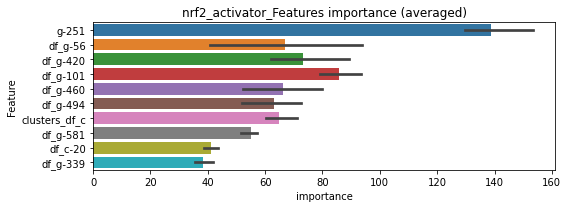

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163892	valid_1's binary_logloss: 0.0279624
[200]	training's binary_logloss: 0.00192325	valid_1's binary_logloss: 0.0113938


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 nrf2_activator=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000648768	valid_1's binary_logloss: 0.0100068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166635	valid_1's binary_logloss: 0.0254549
[200]	training's binary_logloss: 0.00205482	valid_1's binary_logloss: 0.00866363
[300]	training's binary_logloss: 0.000585356	valid_1's binary_logloss: 0.00674087
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000468227	valid_1's binary_logloss: 0.00661204


nrf2_activator logloss: 0.008309442917575821
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122143	valid_1's binary_logloss: 0.294086
[200]	training's binary_logloss: 0.0311485	valid_1's binary_logloss: 0.201382
[300]	training's binary_logloss: 0.0107811	valid_1's binary_logloss: 0.167625
[400]	training's binary_logloss: 0.00525501	valid_1's binary_logloss: 0.153219
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00437914	valid_1's binary_logloss: 0.151554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124484	valid_1's binary_logloss: 0.27571
[200]	training's binary_logloss: 0.0326464	valid_1's binary_logloss: 0.167978
[300]	training's binary_logloss: 0.0112268	valid_1's binary_logloss: 0.12359
[400]	training's binary_logloss: 0.00548806	valid_1's binary_logloss: 0.109763
[500]	training's binary_logloss: 0.00347962	valid_1's binary_logloss: 0.100768
[600]	training's binary_logloss: 0.00259183	valid_1's binary_lo

1 / 3 AUC score:0.986
Threshold: 0.33287254494141
Remove_noisy_labels: 48 → positive_corect_labels: 476/952
30th percentile: 0.02920
p_label_rate: 0.03968 Vs.target_rate: 0.00266, Num_p_label: 158.0, conf_0:0.02920, conf_1:0.45897
Num_p_label: 158.0, Expected: 10.6, Adj_threshold_1: 0.33
Num_p_label: 121.0, Expected: 10.6, Adj_threshold_2: 0.37
Num_p_label: 81.0, Expected: 10.6, Adj_threshold_3: 0.41
Num_p_label: 56.0, Expected: 10.6, Adj_threshold_4: 0.45
Num_p_label: 37.0, Expected: 10.6, Adj_threshold_5: 0.49
Num_p_label: 26.0, Expected: 10.6, Adj_threshold_6: 0.53
Num_p_label: 14.0, Expected: 10.6, Adj_threshold_7: 0.57
threshold:0.57, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:476.0/952, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114894	valid_1's binary_logloss: 0.261956
[200]	training's binary_logloss: 0.0282264	valid_1's binary_logloss: 0.163637
[300]	training's binary_logloss: 0.00977097	valid_1's binary_logloss: 0.131075
[400]	training's binary_logloss: 0.00486812	valid_1's binary_logloss: 0.11891
[500]	training's binary_logloss: 0.00314178	valid_1's binary_logloss: 0.113004
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00296457	valid_1's binary_logloss: 0.112434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114774	valid_1's binary_logloss: 0.245
[200]	training's binary_logloss: 0.0281473	valid_1's binary_logloss: 0.132001
[300]	training's binary_logloss: 0.00978953	valid_1's binary_logloss: 0.0956555
[400]	training's binary_logloss: 0.00490342	valid_1's binary_logloss: 0.0793176
[500]	training's binary_logloss: 0.0031688	valid_1's binary_l

2 / 3 AUC score:0.995
Threshold: 0.5728725449414099
Remove_noisy_labels: 26 → positive_corect_labels: 450.0/926
30th percentile: 0.01924
p_label_rate: 0.01005 Vs.target_rate: 0.00266, Num_p_label: 40.0, conf_0:0.01924, conf_1:0.57287
Num_p_label: 40.0, Expected: 10.6, Adj_threshold_1: 0.57
Num_p_label: 26.0, Expected: 10.6, Adj_threshold_2: 0.61
Num_p_label: 20.0, Expected: 10.6, Adj_threshold_3: 0.65
Num_p_label: 16.0, Expected: 10.6, Adj_threshold_4: 0.69
Num_p_label: 7.0, Expected: 10.6, Adj_threshold_5: 0.73
threshold:0.73, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:450.0/926, y_label_rate: 0.48596
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118661	valid_1's binary_logloss: 0.219327
[200]	training's binary_logloss: 0.0296517	valid_1's binary_logloss: 0.106198
[300]	training's binary_logloss: 0.0102581	valid_1's binary_logloss: 0.0664353
[400]	training's binary_logloss: 0.00505911	valid_1's binary_logloss: 0.0505609
[500]	training's binary_logloss: 0.00327194	valid_1's binary_logloss: 0.0426016
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00257289	valid_1's binary_logloss: 0.0383801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107351	valid_1's binary_logloss: 0.231159
[200]	training's binary_logloss: 0.0256946	valid_1's binary_logloss: 0.121312
[300]	training's binary_logloss: 0.00880627	valid_1's binary_logloss: 0.0829958
[400]	training's binary_logloss: 0.00444613	valid_1's binary_logloss: 0.0678856
[500]	training's binary_logloss: 0.00296461	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.7328725449414101
Remove_noisy_labels: 13 → positive_corect_labels: 437.0/913
30th percentile: 0.01704
p_label_rate: 0.00251 Vs.target_rate: 0.00266, Num_p_label: 10.0, conf_0:0.01704, conf_1:0.73287
threshold:0.73, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:447.0/4895, y_label_rate: 0.09132


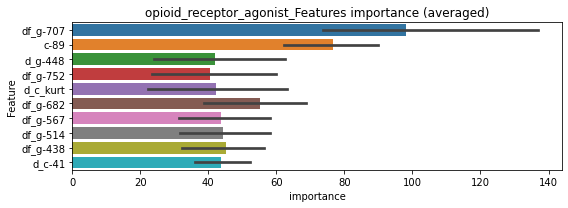

len(train_index) : 2447
len(valid_index) : 2448
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329753	valid_1's binary_logloss: 0.0660829
[200]	training's binary_logloss: 0.00607286	valid_1's binary_logloss: 0.0376874
[300]	training's binary_logloss: 0.00163868	valid_1's binary_logloss: 0.0323805
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00172002	valid_1's binary_logloss: 0.032192


len(train_index) : 2448
len(valid_index) : 2447
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028163	valid_1's binary_logloss: 0.0691482
[200]	training's binary_logloss: 0.00519677	valid_1's binary_logloss: 0.0455031
[300]	training's binary_logloss: 0.00148641	valid_1's binary_logloss: 0.0419047
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00137986	valid_1's binary_logloss: 0.0416774


opioid_receptor_agonist logloss: 0.036933703492916616
opioid_receptor_antagonist , len(trt) : 96


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147288	valid_1's binary_logloss: 0.375172
[200]	training's binary_logloss: 0.0433957	valid_1's binary_logloss: 0.279227
[300]	training's binary_logloss: 0.0160041	valid_1's binary_logloss: 0.238585
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.014671	valid_1's binary_logloss: 0.23519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152572	valid_1's binary_logloss: 0.359633
[200]	training's binary_logloss: 0.0465075	valid_1's binary_logloss: 0.246112
[300]	training's binary_logloss: 0.0172176	valid_1's binary_logloss: 0.197404
[400]	training's binary_logloss: 0.00831772	valid_1's binary_logloss: 0.171999
[500]	training's binary_logloss: 0.00507124	valid_1's binary_logloss: 0.159689
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.0037299	valid_1's binary_logloss: 0.153402


1 / 3 AUC score:0.979
Threshold: 0.4558985946803197
Remove_noisy_labels: 70 → positive_corect_labels: 465/930
30th percentile: 0.08271
p_label_rate: 0.04721 Vs.target_rate: 0.00405, Num_p_label: 188.0, conf_0:0.08271, conf_1:0.49748
Num_p_label: 188.0, Expected: 16.1, Adj_threshold_1: 0.46
Num_p_label: 123.0, Expected: 16.1, Adj_threshold_2: 0.50
Num_p_label: 74.0, Expected: 16.1, Adj_threshold_3: 0.54
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_4: 0.58
Num_p_label: 30.0, Expected: 16.1, Adj_threshold_5: 0.62
Num_p_label: 15.0, Expected: 16.1, Adj_threshold_6: 0.66
threshold:0.66, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:465.0/930, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138674	valid_1's binary_logloss: 0.301942
[200]	training's binary_logloss: 0.040908	valid_1's binary_logloss: 0.200587
[300]	training's binary_logloss: 0.0150109	valid_1's binary_logloss: 0.156167
[400]	training's binary_logloss: 0.00734777	valid_1's binary_logloss: 0.138263
[500]	training's binary_logloss: 0.00452317	valid_1's binary_logloss: 0.12896
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0040532	valid_1's binary_logloss: 0.127162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135387	valid_1's binary_logloss: 0.324062
[200]	training's binary_logloss: 0.0383368	valid_1's binary_logloss: 0.226307
[300]	training's binary_logloss: 0.0139135	valid_1's binary_logloss: 0.181201
[400]	training's binary_logloss: 0.00684643	valid_1's binary_logloss: 0.157789
[500]	training's binary_logloss: 0.00423014	valid_1's binary_log

2 / 3 AUC score:0.990
Threshold: 0.6558985946803197
Remove_noisy_labels: 40 → positive_corect_labels: 429.0/890
30th percentile: 0.04597
p_label_rate: 0.02260 Vs.target_rate: 0.00405, Num_p_label: 90.0, conf_0:0.04597, conf_1:0.65590
Num_p_label: 90.0, Expected: 16.1, Adj_threshold_1: 0.66
Num_p_label: 71.0, Expected: 16.1, Adj_threshold_2: 0.70
Num_p_label: 51.0, Expected: 16.1, Adj_threshold_3: 0.74
Num_p_label: 34.0, Expected: 16.1, Adj_threshold_4: 0.78
Num_p_label: 20.0, Expected: 16.1, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:429.0/890, y_label_rate: 0.48202
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129529	valid_1's binary_logloss: 0.315085
[200]	training's binary_logloss: 0.0358737	valid_1's binary_logloss: 0.208501
[300]	training's binary_logloss: 0.0130318	valid_1's binary_logloss: 0.168887
[400]	training's binary_logloss: 0.00640262	valid_1's binary_logloss: 0.150894
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00531551	valid_1's binary_logloss: 0.147505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137036	valid_1's binary_logloss: 0.283344
[200]	training's binary_logloss: 0.0386999	valid_1's binary_logloss: 0.175335
[300]	training's binary_logloss: 0.0139075	valid_1's binary_logloss: 0.133619
[400]	training's binary_logloss: 0.00678965	valid_1's binary_logloss: 0.115577
[500]	training's binary_logloss: 0.00423558	valid_1's binary_logloss: 0.105017
[600]	training's binary_logloss: 0.00312954	valid_1's binary_

3 / 3 AUC score:0.993
Threshold: 0.8158985946803199
Remove_noisy_labels: 54 → positive_corect_labels: 375.0/836
30th percentile: 0.03559
p_label_rate: 0.00578 Vs.target_rate: 0.00405, Num_p_label: 23.0, conf_0:0.03559, conf_1:0.81590
threshold:0.82, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:398.0/4818, y_label_rate: 0.08261


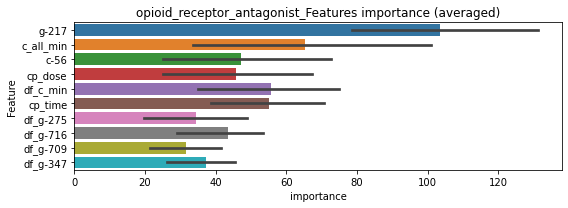

len(train_index) : 2409
len(valid_index) : 2409
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276764	valid_1's binary_logloss: 0.0856045
[200]	training's binary_logloss: 0.00566899	valid_1's binary_logloss: 0.0651059
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00214676	valid_1's binary_logloss: 0.0610199


len(train_index) : 2409
len(valid_index) : 2409
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031877	valid_1's binary_logloss: 0.0786651
[200]	training's binary_logloss: 0.00679088	valid_1's binary_logloss: 0.0536367


opioid_receptor_antagonist logloss: 0.05559380800319393


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00352956	valid_1's binary_logloss: 0.0501677


orexin_receptor_antagonist , len(trt) : 37


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962357	valid_1's binary_logloss: 0.193754
[200]	training's binary_logloss: 0.0205428	valid_1's binary_logloss: 0.100566
[300]	training's binary_logloss: 0.00664745	valid_1's binary_logloss: 0.0743736
[400]	training's binary_logloss: 0.00333843	valid_1's binary_logloss: 0.0602778
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00244742	valid_1's binary_logloss: 0.0555353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923195	valid_1's binary_logloss: 0.203544
[200]	training's binary_logloss: 0.0188919	valid_1's binary_logloss: 0.102653
[300]	training's binary_logloss: 0.00620626	valid_1's binary_logloss: 0.0725096
[400]	training's binary_logloss: 0.00315625	valid_1's binary_logloss: 0.0645925
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00295279	valid_1's binary_logloss: 0.0638359


1 / 3 AUC score:0.998
Threshold: 0.37558248885658674
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentile: 0.00928
p_label_rate: 0.00929 Vs.target_rate: 0.00165, Num_p_label: 37.0, conf_0:0.00928, conf_1:0.45116
Num_p_label: 37.0, Expected: 6.6, Adj_threshold_1: 0.38
Num_p_label: 26.0, Expected: 6.6, Adj_threshold_2: 0.42
Num_p_label: 19.0, Expected: 6.6, Adj_threshold_3: 0.46
Num_p_label: 16.0, Expected: 6.6, Adj_threshold_4: 0.50
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_5: 0.54
threshold:0.54, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911615	valid_1's binary_logloss: 0.184752
[200]	training's binary_logloss: 0.0187178	valid_1's binary_logloss: 0.0839916
[300]	training's binary_logloss: 0.00621834	valid_1's binary_logloss: 0.0587138
[400]	training's binary_logloss: 0.00318578	valid_1's binary_logloss: 0.0483238
[500]	training's binary_logloss: 0.00214221	valid_1's binary_logloss: 0.0435769
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00181537	valid_1's binary_logloss: 0.0423126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916546	valid_1's binary_logloss: 0.193507
[200]	training's binary_logloss: 0.0194637	valid_1's binary_logloss: 0.0977235
[300]	training's binary_logloss: 0.00620405	valid_1's binary_logloss: 0.0698027
[400]	training's binary_logloss: 0.00311515	valid_1's binary_logloss: 0.0622572
[500]	training's binary_logloss: 0.00210364	valid

2 / 3 AUC score:0.998
Threshold: 0.5355824888565867
Remove_noisy_labels: 11 → positive_corect_labels: 481.0/971
30th percentile: 0.00686
p_label_rate: 0.00276 Vs.target_rate: 0.00165, Num_p_label: 11.0, conf_0:0.00686, conf_1:0.53558
threshold:0.54, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:481.0/971, y_label_rate: 0.49537
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091222	valid_1's binary_logloss: 0.183649
[200]	training's binary_logloss: 0.0189596	valid_1's binary_logloss: 0.0943478
[300]	training's binary_logloss: 0.00620232	valid_1's binary_logloss: 0.0675189
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00370833	valid_1's binary_logloss: 0.0610357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900713	valid_1's binary_logloss: 0.193705
[200]	training's binary_logloss: 0.0182245	valid_1's binary_logloss: 0.0967669
[300]	training's binary_logloss: 0.00594989	valid_1's binary_logloss: 0.0748829


3 / 3 AUC score:0.995
Threshold: 0.5355824888565867
Remove_noisy_labels: 13 → positive_corect_labels: 471.0/958
30th percentile: 0.01146
p_label_rate: 0.00452 Vs.target_rate: 0.00165, Num_p_label: 18.0, conf_0:0.01146, conf_1:0.53558
threshold:0.54, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00410043	valid_1's binary_logloss: 0.0705812


positive y_label:489.0/4940, y_label_rate: 0.09899


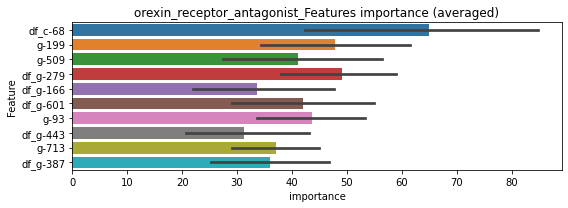

len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257654	valid_1's binary_logloss: 0.0528546
[200]	training's binary_logloss: 0.00408524	valid_1's binary_logloss: 0.0253063
[300]	training's binary_logloss: 0.00117039	valid_1's binary_logloss: 0.0208936
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000842574	valid_1's binary_logloss: 0.0206788


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265737	valid_1's binary_logloss: 0.0499651
[200]	training's binary_logloss: 0.00440423	valid_1's binary_logloss: 0.0235063
[300]	training's binary_logloss: 0.00121953	valid_1's binary_logloss: 0.0203062
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00123123	valid_1's binary_logloss: 0.0203003


orexin_receptor_antagonist logloss: 0.020489556935186004
p38_mapk_inhibitor , len(trt) : 62


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123424	valid_1's binary_logloss: 0.284555
[200]	training's binary_logloss: 0.032423	valid_1's binary_logloss: 0.173138
[300]	training's binary_logloss: 0.011364	valid_1's binary_logloss: 0.134278
[400]	training's binary_logloss: 0.00547811	valid_1's binary_logloss: 0.118194
[500]	training's binary_logloss: 0.00344303	valid_1's binary_logloss: 0.112233
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00329918	valid_1's binary_logloss: 0.110909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125362	valid_1's binary_logloss: 0.27572
[200]	training's binary_logloss: 0.0324083	valid_1's binary_logloss: 0.160595
[300]	training's binary_logloss: 0.0111955	valid_1's binary_logloss: 0.113719
[400]	training's binary_logloss: 0.0054219	valid_1's binary_logloss: 0.0957573
[500]	training's binary_logloss: 0.00344446	valid_1's binary_log

1 / 3 AUC score:0.995
Threshold: 0.3526225809565904
Remove_noisy_labels: 36 → positive_corect_labels: 482/964
30th percentile: 0.02133
p_label_rate: 0.02863 Vs.target_rate: 0.00270, Num_p_label: 114.0, conf_0:0.02133, conf_1:0.48081
Num_p_label: 114.0, Expected: 10.8, Adj_threshold_1: 0.35
Num_p_label: 75.0, Expected: 10.8, Adj_threshold_2: 0.39
Num_p_label: 56.0, Expected: 10.8, Adj_threshold_3: 0.43
Num_p_label: 43.0, Expected: 10.8, Adj_threshold_4: 0.47
Num_p_label: 27.0, Expected: 10.8, Adj_threshold_5: 0.51
Num_p_label: 16.0, Expected: 10.8, Adj_threshold_6: 0.55
threshold:0.55, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:482.0/964, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124836	valid_1's binary_logloss: 0.251075
[200]	training's binary_logloss: 0.0319042	valid_1's binary_logloss: 0.146766
[300]	training's binary_logloss: 0.0111077	valid_1's binary_logloss: 0.106136
[400]	training's binary_logloss: 0.00544831	valid_1's binary_logloss: 0.0913545
[500]	training's binary_logloss: 0.00342401	valid_1's binary_logloss: 0.0832786
[600]	training's binary_logloss: 0.00256627	valid_1's binary_logloss: 0.0796838
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00258641	valid_1's binary_logloss: 0.0795847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12527	valid_1's binary_logloss: 0.256495
[200]	training's binary_logloss: 0.0323353	valid_1's binary_logloss: 0.151962
[300]	training's binary_logloss: 0.0112685	valid_1's binary_logloss: 0.109939
[400]	training's binary_logloss: 0.00549654	valid_1's bina

2 / 3 AUC score:0.993
Threshold: 0.5526225809565903
Remove_noisy_labels: 18 → positive_corect_labels: 469.0/946
30th percentile: 0.02228
p_label_rate: 0.00979 Vs.target_rate: 0.00270, Num_p_label: 39.0, conf_0:0.01865, conf_1:0.55262
Num_p_label: 39.0, Expected: 10.8, Adj_threshold_1: 0.55
Num_p_label: 26.0, Expected: 10.8, Adj_threshold_2: 0.59
Num_p_label: 17.0, Expected: 10.8, Adj_threshold_3: 0.63
Num_p_label: 12.0, Expected: 10.8, Adj_threshold_4: 0.67
threshold:0.67, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:469.0/946, y_label_rate: 0.49577
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12322	valid_1's binary_logloss: 0.251689
[200]	training's binary_logloss: 0.0312571	valid_1's binary_logloss: 0.139865
[300]	training's binary_logloss: 0.0108364	valid_1's binary_logloss: 0.0976913
[400]	training's binary_logloss: 0.00531012	valid_1's binary_logloss: 0.0802434
[500]	training's binary_logloss: 0.00337975	valid_1's binary_logloss: 0.0699781
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00262652	valid_1's binary_logloss: 0.0638728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11799	valid_1's binary_logloss: 0.265667
[200]	training's binary_logloss: 0.0290576	valid_1's binary_logloss: 0.159779
[300]	training's binary_logloss: 0.0099195	valid_1's binary_logloss: 0.122308
[400]	training's binary_logloss: 0.00490265	valid_1's binary_logloss: 0.110183
[500]	training's binary_logloss: 0.00311396	valid_1's binar

3 / 3 AUC score:0.994
Threshold: 0.6726225809565904
Remove_noisy_labels: 19 → positive_corect_labels: 451.0/927
30th percentile: 0.02246
p_label_rate: 0.00326 Vs.target_rate: 0.00270, Num_p_label: 13.0, conf_0:0.02141, conf_1:0.67262
threshold:0.67, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:464.0/4909, y_label_rate: 0.09452


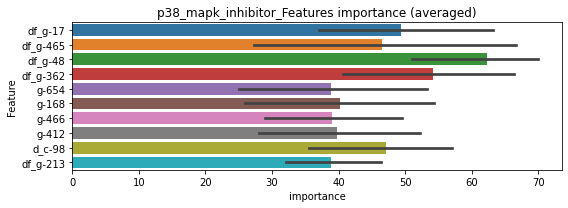

len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332273	valid_1's binary_logloss: 0.0982272
[200]	training's binary_logloss: 0.00611998	valid_1's binary_logloss: 0.0823899


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 p38_mapk_inhibitor=================================


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00564049	valid_1's binary_logloss: 0.0820402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353636	valid_1's binary_logloss: 0.0739975
[200]	training's binary_logloss: 0.00692017	valid_1's binary_logloss: 0.038767
[300]	training's binary_logloss: 0.00197652	valid_1's binary_logloss: 0.0288195
[400]	training's binary_logloss: 0.000912174	valid_1's binary_logloss: 0.0259663
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000743905	valid_1's binary_logloss: 0.0254709


p38_mapk_inhibitor logloss: 0.053761312952464634
p-glycoprotein_inhibitor , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791517	valid_1's binary_logloss: 0.136171
[200]	training's binary_logloss: 0.0146813	valid_1's binary_logloss: 0.0492567
[300]	training's binary_logloss: 0.00468701	valid_1's binary_logloss: 0.0266855
[400]	training's binary_logloss: 0.00244947	valid_1's binary_logloss: 0.0191955
[500]	training's binary_logloss: 0.00171787	valid_1's binary_logloss: 0.0157935
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00152261	valid_1's binary_logloss: 0.0146371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789433	valid_1's binary_logloss: 0.145877
[200]	training's binary_logloss: 0.0149785	valid_1's binary_logloss: 0.0537843
[300]	training's binary_logloss: 0.00475825	valid_1's binary_logloss: 0.0278354
[400]	training's binary_logloss: 0.00249089	valid_1's binary_logloss: 0.0197135
[500]	training's binary_logloss: 0.00173582	valid

1 / 3 AUC score:1.000
Threshold: 0.4052675209578932
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00325
p_label_rate: 0.00151 Vs.target_rate: 0.00108, Num_p_label: 6.0, conf_0:0.00325, conf_1:0.40527
threshold:0.41, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791517	valid_1's binary_logloss: 0.136171
[200]	training's binary_logloss: 0.0146813	valid_1's binary_logloss: 0.0492567
[300]	training's binary_logloss: 0.00468701	valid_1's binary_logloss: 0.0266855
[400]	training's binary_logloss: 0.00244947	valid_1's binary_logloss: 0.0191955
[500]	training's binary_logloss: 0.00171787	valid_1's binary_logloss: 0.0157935
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00152261	valid_1's binary_logloss: 0.0146371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789433	valid_1's binary_logloss: 0.145877
[200]	training's binary_logloss: 0.0149785	valid_1's binary_logloss: 0.0537843
[300]	training's binary_logloss: 0.00475825	valid_1's binary_logloss: 0.0278354
[400]	training's binary_logloss: 0.00249089	valid_1's binary_logloss: 0.0197135
[500]	training's binary_logloss: 0.00173582	valid

2 / 3 AUC score:1.000
Threshold: 0.4052675209578932
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00325
p_label_rate: 0.00151 Vs.target_rate: 0.00108, Num_p_label: 6.0, conf_0:0.00325, conf_1:0.40527
threshold:0.41, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791517	valid_1's binary_logloss: 0.136171
[200]	training's binary_logloss: 0.0146813	valid_1's binary_logloss: 0.0492567
[300]	training's binary_logloss: 0.00468701	valid_1's binary_logloss: 0.0266855
[400]	training's binary_logloss: 0.00244947	valid_1's binary_logloss: 0.0191955
[500]	training's binary_logloss: 0.00171787	valid_1's binary_logloss: 0.0157935
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00152261	valid_1's binary_logloss: 0.0146371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789433	valid_1's binary_logloss: 0.145877
[200]	training's binary_logloss: 0.0149785	valid_1's binary_logloss: 0.0537843
[300]	training's binary_logloss: 0.00475825	valid_1's binary_logloss: 0.0278354
[400]	training's binary_logloss: 0.00249089	valid_1's binary_logloss: 0.0197135
[500]	training's binary_logloss: 0.00173582	valid

3 / 3 AUC score:1.000
Threshold: 0.4052675209578932
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00325
p_label_rate: 0.00151 Vs.target_rate: 0.00108, Num_p_label: 6.0, conf_0:0.00325, conf_1:0.40527
threshold:0.41, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:506.0/4982, y_label_rate: 0.10157


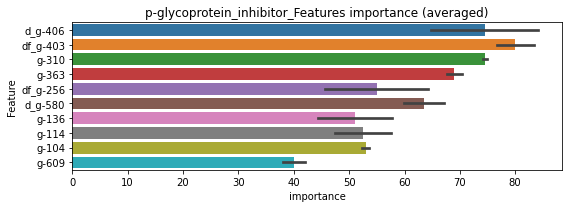

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214714	valid_1's binary_logloss: 0.0328672
[200]	training's binary_logloss: 0.00293145	valid_1's binary_logloss: 0.0102536
[300]	training's binary_logloss: 0.000809558	valid_1's binary_logloss: 0.00707472
[400]	training's binary_logloss: 0.000414144	valid_1's binary_logloss: 0.00657761
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.0003734	valid_1's binary_logloss: 0.00650337


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206379	valid_1's binary_logloss: 0.0390027
[200]	training's binary_logloss: 0.00277654	valid_1's binary_logloss: 0.0173813
[300]	training's binary_logloss: 0.000785252	valid_1's binary_logloss: 0.0141988
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.000799218	valid_1's binary_logloss: 0.0141791


p-glycoprotein_inhibitor logloss: 0.010341215467688725
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119683	valid_1's binary_logloss: 0.254612
[200]	training's binary_logloss: 0.0312001	valid_1's binary_logloss: 0.149918
[300]	training's binary_logloss: 0.0108573	valid_1's binary_logloss: 0.106236
[400]	training's binary_logloss: 0.00527304	valid_1's binary_logloss: 0.0860902
[500]	training's binary_logloss: 0.00332158	valid_1's binary_logloss: 0.0764232
[600]	training's binary_logloss: 0.00249915	valid_1's binary_logloss: 0.0711016
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00230225	valid_1's binary_logloss: 0.0693027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127439	valid_1's binary_logloss: 0.253263
[200]	training's binary_logloss: 0.0331161	valid_1's binary_logloss: 0.135681
[300]	training's binary_logloss: 0.0116267	valid_1's binary_logloss: 0.0933805
[400]	training's binary_logloss: 0.00567682	valid_1's bi

1 / 3 AUC score:0.998
Threshold: 0.4496819947668492
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentile: 0.01598
p_label_rate: 0.01306 Vs.target_rate: 0.00266, Num_p_label: 52.0, conf_0:0.01598, conf_1:0.47219
Num_p_label: 52.0, Expected: 10.6, Adj_threshold_1: 0.45
Num_p_label: 38.0, Expected: 10.6, Adj_threshold_2: 0.49
Num_p_label: 23.0, Expected: 10.6, Adj_threshold_3: 0.53
Num_p_label: 17.0, Expected: 10.6, Adj_threshold_4: 0.57
Num_p_label: 13.0, Expected: 10.6, Adj_threshold_5: 0.61
threshold:0.61, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120061	valid_1's binary_logloss: 0.26862
[200]	training's binary_logloss: 0.0302628	valid_1's binary_logloss: 0.162375
[300]	training's binary_logloss: 0.0105649	valid_1's binary_logloss: 0.124795
[400]	training's binary_logloss: 0.00518262	valid_1's binary_logloss: 0.108334
[500]	training's binary_logloss: 0.00329525	valid_1's binary_logloss: 0.101141
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00298186	valid_1's binary_logloss: 0.0999648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116439	valid_1's binary_logloss: 0.244022
[200]	training's binary_logloss: 0.02999	valid_1's binary_logloss: 0.13966
[300]	training's binary_logloss: 0.0102857	valid_1's binary_logloss: 0.098937
[400]	training's binary_logloss: 0.00507303	valid_1's binary_logloss: 0.0797899
[500]	training's binary_logloss: 0.0032627	valid_1's binary_log

2 / 3 AUC score:0.995
Threshold: 0.6096819947668493
Remove_noisy_labels: 22 → positive_corect_labels: 483.0/964
30th percentile: 0.01392
p_label_rate: 0.00879 Vs.target_rate: 0.00266, Num_p_label: 35.0, conf_0:0.01208, conf_1:0.60968
Num_p_label: 35.0, Expected: 10.6, Adj_threshold_1: 0.61
Num_p_label: 26.0, Expected: 10.6, Adj_threshold_2: 0.65
Num_p_label: 16.0, Expected: 10.6, Adj_threshold_3: 0.69
Num_p_label: 14.0, Expected: 10.6, Adj_threshold_4: 0.73
threshold:0.73, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:483.0/964, y_label_rate: 0.50104
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111619	valid_1's binary_logloss: 0.259172
[200]	training's binary_logloss: 0.027672	valid_1's binary_logloss: 0.153505
[300]	training's binary_logloss: 0.00949535	valid_1's binary_logloss: 0.113098
[400]	training's binary_logloss: 0.0047538	valid_1's binary_logloss: 0.098276
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00427368	valid_1's binary_logloss: 0.0963518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116233	valid_1's binary_logloss: 0.242645
[200]	training's binary_logloss: 0.0299544	valid_1's binary_logloss: 0.138342
[300]	training's binary_logloss: 0.0103656	valid_1's binary_logloss: 0.10033
[400]	training's binary_logloss: 0.00513825	valid_1's binary_logloss: 0.0784053
[500]	training's binary_logloss: 0.00326145	valid_1's binary_logloss: 0.0705822
[600]	training's binary_logloss: 0.00245381	valid_1's binary

3 / 3 AUC score:0.996
Threshold: 0.7296819947668494
Remove_noisy_labels: 27 → positive_corect_labels: 456.0/937
30th percentile: 0.01412
p_label_rate: 0.00929 Vs.target_rate: 0.00266, Num_p_label: 37.0, conf_0:0.01412, conf_1:0.72968
Num_p_label: 37.0, Expected: 10.6, Adj_threshold_1: 0.73
Num_p_label: 29.0, Expected: 10.6, Adj_threshold_2: 0.77
Num_p_label: 26.0, Expected: 10.6, Adj_threshold_3: 0.81
Num_p_label: 18.0, Expected: 10.6, Adj_threshold_4: 0.85
Num_p_label: 13.0, Expected: 10.6, Adj_threshold_5: 0.89
threshold:0.89, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:469.0/4919, y_label_rate: 0.09534


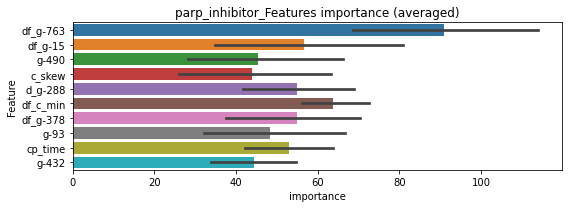

len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031583	valid_1's binary_logloss: 0.0775591
[200]	training's binary_logloss: 0.00609398	valid_1's binary_logloss: 0.051246


len(train_index) : 2460


[300]	training's binary_logloss: 0.00170526	valid_1's binary_logloss: 0.045124
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00188043	valid_1's binary_logloss: 0.0449095


len(valid_index) : 2459
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312252	valid_1's binary_logloss: 0.0677486
[200]	training's binary_logloss: 0.00599233	valid_1's binary_logloss: 0.0360439
[300]	training's binary_logloss: 0.00177878	valid_1's binary_logloss: 0.027706
[400]	training's binary_logloss: 0.00085627	valid_1's binary_logloss: 0.0247747
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000661537	valid_1's binary_logloss: 0.0237404


parp_inhibitor logloss: 0.03432713430895723
pdgfr_inhibitor , len(trt) : 297


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216319	valid_1's binary_logloss: 0.601495
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.125995	valid_1's binary_logloss: 0.590074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220141	valid_1's binary_logloss: 0.623017


1 / 3 AUC score:0.724
Threshold: 0.48930227192214826
Remove_noisy_labels: 360 → positive_corect_labels: 320/640
30th percentile: 0.37481
p_label_rate: 0.28428 Vs.target_rate: 0.01001, Num_p_label: 1132.0, conf_0:0.37481, conf_1:0.48930
Num_p_label: 1132.0, Expected: 39.9, Adj_threshold_1: 0.49
Num_p_label: 669.0, Expected: 39.9, Adj_threshold_2: 0.53
Num_p_label: 364.0, Expected: 39.9, Adj_threshold_3: 0.57
Num_p_label: 181.0, Expected: 39.9, Adj_threshold_4: 0.61
Num_p_label: 75.0, Expected: 39.9, Adj_threshold_5: 0.65
Num_p_label: 24.0, Expected: 39.9, Adj_threshold_6: 0.69


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0986419	valid_1's binary_logloss: 0.598297


threshold:0.69, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:320.0/640, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197369	valid_1's binary_logloss: 0.52359
[200]	training's binary_logloss: 0.0712917	valid_1's binary_logloss: 0.467414
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0338169	valid_1's binary_logloss: 0.442682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200231	valid_1's binary_logloss: 0.507152
[200]	training's binary_logloss: 0.0740021	valid_1's binary_logloss: 0.447708
[300]	training's binary_logloss: 0.0316133	valid_1's binary_logloss: 0.421782
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0302316	valid_1's binary_logloss: 0.420499


2 / 3 AUC score:0.881
Threshold: 0.6893022719221484
Remove_noisy_labels: 116 → positive_corect_labels: 220.0/524
30th percentile: 0.28189
p_label_rate: 0.06529 Vs.target_rate: 0.01001, Num_p_label: 260.0, conf_0:0.28189, conf_1:0.68930
Num_p_label: 260.0, Expected: 39.9, Adj_threshold_1: 0.69
Num_p_label: 162.0, Expected: 39.9, Adj_threshold_2: 0.73
Num_p_label: 94.0, Expected: 39.9, Adj_threshold_3: 0.77
Num_p_label: 49.0, Expected: 39.9, Adj_threshold_4: 0.81
threshold:0.81, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:220.0/524, y_label_rate: 0.41985
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182088	valid_1's binary_logloss: 0.436912
[200]	training's binary_logloss: 0.0623334	valid_1's binary_logloss: 0.358599
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0407085	valid_1's binary_logloss: 0.338711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184001	valid_1's binary_logloss: 0.464481
[200]	training's binary_logloss: 0.0644358	valid_1's binary_logloss: 0.388528


3 / 3 AUC score:0.929
Threshold: 0.8093022719221485
Remove_noisy_labels: 123 → positive_corect_labels: 101.0/401
30th percentile: 0.15246
p_label_rate: 0.00653 Vs.target_rate: 0.01001, Num_p_label: 26.0, conf_0:0.15246, conf_1:0.80930
threshold:0.81, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.030082	valid_1's binary_logloss: 0.363075


positive y_label:127.0/4383, y_label_rate: 0.02898


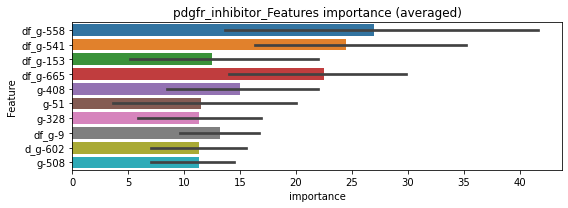

len(train_index) : 2191
len(valid_index) : 2192
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108065	valid_1's binary_logloss: 0.090554


len(train_index) : 2192
len(valid_index) : 2191
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00977148	valid_1's binary_logloss: 0.0897948
Training until validation scores don't improve for 10 rounds


pdgfr_inhibitor logloss: 0.09468338698662132
pdk_inhibitor , len(trt) : 18


[100]	training's binary_logloss: 0.0112471	valid_1's binary_logloss: 0.0999155
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0136409	valid_1's binary_logloss: 0.0995742
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor aden

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629131	valid_1's binary_logloss: 0.0989393
[200]	training's binary_logloss: 0.0102886	valid_1's binary_logloss: 0.0272519
[300]	training's binary_logloss: 0.00331119	valid_1's binary_logloss: 0.0135002
[400]	training's binary_logloss: 0.00180318	valid_1's binary_logloss: 0.00916982
[500]	training's binary_logloss: 0.0013847	valid_1's binary_logloss: 0.00758114
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.0013492	valid_1's binary_logloss: 0.00738485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647565	valid_1's binary_logloss: 0.106982
[200]	training's binary_logloss: 0.010586	valid_1's binary_logloss: 0.0337854
[300]	training's binary_logloss: 0.00339139	valid_1's binary_logloss: 0.0169691
[400]	training's binary_logloss: 0.00184303	valid_1's binary_logloss: 0.011658
[500]	training's binary_logloss: 0.0013869	valid_

1 / 3 AUC score:1.000
Threshold: 0.5853185551953994
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00161
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00161, conf_1:0.58532
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.59
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.55
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_3: 0.51
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_4: 0.47
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629131	valid_1's binary_logloss: 0.0989393
[200]	training's binary_logloss: 0.0102886	valid_1's binary_logloss: 0.0272519
[300]	training's binary_logloss: 0.00331119	valid_1's binary_logloss: 0.0135002
[400]	training's binary_logloss: 0.00180318	valid_1's binary_logloss: 0.00916982
[500]	training's binary_logloss: 0.0013847	valid_1's binary_logloss: 0.00758114
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.0013492	valid_1's binary_logloss: 0.00738485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647565	valid_1's binary_logloss: 0.106982
[200]	training's binary_logloss: 0.010586	valid_1's binary_logloss: 0.0337854
[300]	training's binary_logloss: 0.00339139	valid_1's binary_logloss: 0.0169691
[400]	training's binary_logloss: 0.00184303	valid_1's binary_logloss: 0.011658
[500]	training's binary_logloss: 0.0013869	valid_

2 / 3 AUC score:1.000
Threshold: 0.4653185551953994
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00161
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00161, conf_1:0.46532
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629131	valid_1's binary_logloss: 0.0989393
[200]	training's binary_logloss: 0.0102886	valid_1's binary_logloss: 0.0272519
[300]	training's binary_logloss: 0.00331119	valid_1's binary_logloss: 0.0135002
[400]	training's binary_logloss: 0.00180318	valid_1's binary_logloss: 0.00916982
[500]	training's binary_logloss: 0.0013847	valid_1's binary_logloss: 0.00758114
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.0013492	valid_1's binary_logloss: 0.00738485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647565	valid_1's binary_logloss: 0.106982
[200]	training's binary_logloss: 0.010586	valid_1's binary_logloss: 0.0337854
[300]	training's binary_logloss: 0.00339139	valid_1's binary_logloss: 0.0169691
[400]	training's binary_logloss: 0.00184303	valid_1's binary_logloss: 0.011658
[500]	training's binary_logloss: 0.0013869	valid_

3 / 3 AUC score:1.000
Threshold: 0.4653185551953994
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00161
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00161, conf_1:0.46532
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


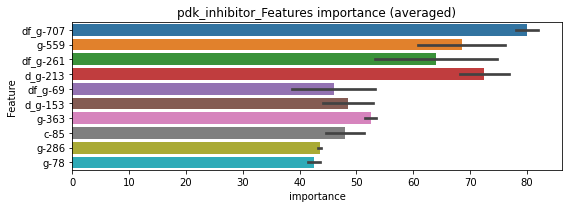

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176781	valid_1's binary_logloss: 0.0293487
[200]	training's binary_logloss: 0.0021419	valid_1's binary_logloss: 0.00967548
[300]	training's binary_logloss: 0.000590969	valid_1's binary_logloss: 0.00593926
[400]	training's binary_logloss: 0.000314335	valid_1's binary_logloss: 0.00503088
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000290376	valid_1's binary_logloss: 0.00495992


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170755	valid_1's binary_logloss: 0.0249272
[200]	training's binary_logloss: 0.00199438	valid_1's binary_logloss: 0.00789206
[300]	training's binary_logloss: 0.000569537	valid_1's binary_logloss: 0.00569598


pdk_inhibitor logloss: 0.005180885328135504


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000358921	valid_1's binary_logloss: 0.00540185


phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206254	valid_1's binary_logloss: 0.566306
[200]	training's binary_logloss: 0.0776905	valid_1's binary_logloss: 0.536796
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0653488	valid_1's binary_logloss: 0.532933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207566	valid_1's binary_logloss: 0.571119


1 / 3 AUC score:0.787
Threshold: 0.49982932603608016
Remove_noisy_labels: 292 → positive_corect_labels: 354/708
30th percentile: 0.33257
p_label_rate: 0.21497 Vs.target_rate: 0.00927, Num_p_label: 856.0, conf_0:0.33257, conf_1:0.49983
Num_p_label: 856.0, Expected: 36.9, Adj_threshold_1: 0.50
Num_p_label: 549.0, Expected: 36.9, Adj_threshold_2: 0.54
Num_p_label: 330.0, Expected: 36.9, Adj_threshold_3: 0.58
Num_p_label: 178.0, Expected: 36.9, Adj_threshold_4: 0.62
Num_p_label: 82.0, Expected: 36.9, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 36.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:38.0/3982, p_label_rate: 0.00954


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0960121	valid_1's binary_logloss: 0.552473


positive y_label:354.0/708, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184166	valid_1's binary_logloss: 0.485266
[200]	training's binary_logloss: 0.0627218	valid_1's binary_logloss: 0.420383
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0308502	valid_1's binary_logloss: 0.394285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191754	valid_1's binary_logloss: 0.478449
[200]	training's binary_logloss: 0.0669827	valid_1's binary_logloss: 0.415684


2 / 3 AUC score:0.905
Threshold: 0.6998293260360803
Remove_noisy_labels: 124 → positive_corect_labels: 243.0/584
30th percentile: 0.23644
p_label_rate: 0.04319 Vs.target_rate: 0.00927, Num_p_label: 172.0, conf_0:0.23644, conf_1:0.69983
Num_p_label: 172.0, Expected: 36.9, Adj_threshold_1: 0.70
Num_p_label: 97.0, Expected: 36.9, Adj_threshold_2: 0.74
Num_p_label: 46.0, Expected: 36.9, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:46.0/3982, p_label_rate: 0.01155


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.032267	valid_1's binary_logloss: 0.391125


positive y_label:243.0/584, y_label_rate: 0.41610
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158314	valid_1's binary_logloss: 0.392492
[200]	training's binary_logloss: 0.0508682	valid_1's binary_logloss: 0.322524
[300]	training's binary_logloss: 0.0202037	valid_1's binary_logloss: 0.297077
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0172423	valid_1's binary_logloss: 0.293522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161619	valid_1's binary_logloss: 0.395373
[200]	training's binary_logloss: 0.0509195	valid_1's binary_logloss: 0.312597
[300]	training's binary_logloss: 0.0201368	valid_1's binary_logloss: 0.279033
[400]	training's binary_logloss: 0.00991611	valid_1's binary_logloss: 0.265573
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.0100749	valid_1's binary_logloss: 0.26543


3 / 3 AUC score:0.952
Threshold: 0.7798293260360804
Remove_noisy_labels: 85 → positive_corect_labels: 163.0/499
30th percentile: 0.07463
p_label_rate: 0.01306 Vs.target_rate: 0.00927, Num_p_label: 52.0, conf_0:0.04517, conf_1:0.77983
threshold:0.78, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:215.0/4481, y_label_rate: 0.04798


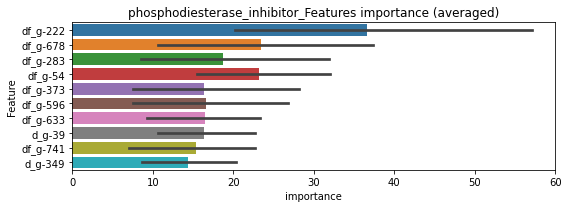

len(train_index) : 2240
len(valid_index) : 2241
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197527	valid_1's binary_logloss: 0.115567


len(train_index) : 2241
len(valid_index) : 2240
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0164196	valid_1's binary_logloss: 0.11415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197028	valid_1's binary_logloss: 0.100761


phosphodiesterase_inhibitor logloss: 0.10393982839559944


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.00871841	valid_1's binary_logloss: 0.0937252


phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

1 / 3 AUC score:1.000
Threshold: 0.4885277982552669
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00403
p_label_rate: 0.00075 Vs.target_rate: 0.00113, Num_p_label: 3.0, conf_0:0.00403, conf_1:0.48853
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075975	valid_1's binary_logloss: 0.133445
[200]	training's binary_logloss: 0.0143694	valid_1's binary_logloss: 0.0490318
[300]	training's binary_logloss: 0.00476378	valid_1's binary_logloss: 0.0267321
[400]	training's binary_logloss: 0.00251786	valid_1's binary_logloss: 0.0189446
[500]	training's binary_logloss: 0.00178228	valid_1's binary_logloss: 0.0156593
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00155729	valid_1's binary_logloss: 0.01463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790511	valid_1's binary_logloss: 0.139283
[200]	training's binary_logloss: 0.014743	valid_1's binary_logloss: 0.0481542
[300]	training's binary_logloss: 0.00470158	valid_1's binary_logloss: 0.0280808
[400]	training's binary_logloss: 0.00244035	valid_1's binary_logloss: 0.0207572
[500]	training's binary_logloss: 0.00169793	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.4885277982552669
Remove_noisy_labels: 3 → positive_corect_labels: 497.0/995
30th percentile: 0.00386
p_label_rate: 0.00075 Vs.target_rate: 0.00113, Num_p_label: 3.0, conf_0:0.00386, conf_1:0.50587
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/995, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786032	valid_1's binary_logloss: 0.14078
[200]	training's binary_logloss: 0.0148471	valid_1's binary_logloss: 0.0538461
[300]	training's binary_logloss: 0.00482424	valid_1's binary_logloss: 0.0298691
[400]	training's binary_logloss: 0.00253083	valid_1's binary_logloss: 0.0231057
[500]	training's binary_logloss: 0.00177918	valid_1's binary_logloss: 0.0199876
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00158158	valid_1's binary_logloss: 0.0188226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780024	valid_1's binary_logloss: 0.142952
[200]	training's binary_logloss: 0.0145933	valid_1's binary_logloss: 0.0517588
[300]	training's binary_logloss: 0.00472046	valid_1's binary_logloss: 0.0301129
[400]	training's binary_logloss: 0.00244533	valid_1's binary_logloss: 0.0217379
[500]	training's binary_logloss: 0.00171759	valid_

3 / 3 AUC score:1.000
Threshold: 0.4885277982552669
Remove_noisy_labels: 3 → positive_corect_labels: 494.0/992
30th percentile: 0.00405
p_label_rate: 0.00100 Vs.target_rate: 0.00113, Num_p_label: 4.0, conf_0:0.00405, conf_1:0.54628
threshold:0.49, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/4974, y_label_rate: 0.10012


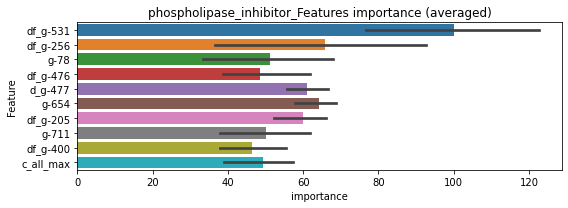

len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200653	valid_1's binary_logloss: 0.0373669
[200]	training's binary_logloss: 0.00281212	valid_1's binary_logloss: 0.0115446
[300]	training's binary_logloss: 0.000807904	valid_1's binary_logloss: 0.00683173
[400]	training's binary_logloss: 0.000421979	valid_1's binary_logloss: 0.00559242
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000323115	valid_1's binary_logloss: 0.00527975


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210408	valid_1's binary_logloss: 0.0379126
[200]	training's binary_logloss: 0.00284747	valid_1's binary_logloss: 0.016169


phospholipase_inhibitor logloss: 0.009176303428737802


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.000915251	valid_1's binary_logloss: 0.0130729


pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171715	valid_1's binary_logloss: 0.422996
[200]	training's binary_logloss: 0.056272	valid_1's binary_logloss: 0.334455
[300]	training's binary_logloss: 0.0220657	valid_1's binary_logloss: 0.297165
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0145921	valid_1's binary_logloss: 0.284267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174874	valid_1's binary_logloss: 0.440355
[200]	training's binary_logloss: 0.0572087	valid_1's binary_logloss: 0.358759
[300]	training's binary_logloss: 0.0224665	valid_1's binary_logloss: 0.321362


1 / 3 AUC score:0.948
Threshold: 0.49872662376510724
Remove_noisy_labels: 132 → positive_corect_labels: 434/868
30th percentile: 0.15072
p_label_rate: 0.08639 Vs.target_rate: 0.00602, Num_p_label: 344.0, conf_0:0.15072, conf_1:0.52769


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0127399	valid_1's binary_logloss: 0.304192


Num_p_label: 344.0, Expected: 24.0, Adj_threshold_1: 0.50
Num_p_label: 252.0, Expected: 24.0, Adj_threshold_2: 0.54
Num_p_label: 176.0, Expected: 24.0, Adj_threshold_3: 0.58
Num_p_label: 96.0, Expected: 24.0, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 24.0, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 24.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:434.0/868, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155711	valid_1's binary_logloss: 0.393769
[200]	training's binary_logloss: 0.0480751	valid_1's binary_logloss: 0.30198
[300]	training's binary_logloss: 0.0183041	valid_1's binary_logloss: 0.274783
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0164345	valid_1's binary_logloss: 0.271293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160142	valid_1's binary_logloss: 0.383201
[200]	training's binary_logloss: 0.0490334	valid_1's binary_logloss: 0.296347
[300]	training's binary_logloss: 0.0183702	valid_1's binary_logloss: 0.261342
[400]	training's binary_logloss: 0.00897402	valid_1's binary_logloss: 0.244839
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00826161	valid_1's binary_logloss: 0.242714


2 / 3 AUC score:0.960
Threshold: 0.6987266237651074
Remove_noisy_labels: 71 → positive_corect_labels: 373.0/797
30th percentile: 0.12909
p_label_rate: 0.02838 Vs.target_rate: 0.00602, Num_p_label: 113.0, conf_0:0.12909, conf_1:0.69873
Num_p_label: 113.0, Expected: 24.0, Adj_threshold_1: 0.70
Num_p_label: 82.0, Expected: 24.0, Adj_threshold_2: 0.74
Num_p_label: 52.0, Expected: 24.0, Adj_threshold_3: 0.78
Num_p_label: 27.0, Expected: 24.0, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:373.0/797, y_label_rate: 0.46801
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148008	valid_1's binary_logloss: 0.362939
[200]	training's binary_logloss: 0.0429731	valid_1's binary_logloss: 0.266937
[300]	training's binary_logloss: 0.0161276	valid_1's binary_logloss: 0.229867
[400]	training's binary_logloss: 0.00799421	valid_1's binary_logloss: 0.217635
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00786776	valid_1's binary_logloss: 0.217018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148927	valid_1's binary_logloss: 0.313486
[200]	training's binary_logloss: 0.0444405	valid_1's binary_logloss: 0.208089
[300]	training's binary_logloss: 0.016509	valid_1's binary_logloss: 0.157955
[400]	training's binary_logloss: 0.00813869	valid_1's binary_logloss: 0.134173
[500]	training's binary_logloss: 0.00505586	valid_1's binary_logloss: 0.125674
[600]	training's binary_logloss: 0.00370591	valid_1's binary_l

3 / 3 AUC score:0.982
Threshold: 0.8187266237651075
Remove_noisy_labels: 60 → positive_corect_labels: 313.0/737
30th percentile: 0.05591
p_label_rate: 0.00804 Vs.target_rate: 0.00602, Num_p_label: 32.0, conf_0:0.05289, conf_1:0.81873
threshold:0.82, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:345.0/4719, y_label_rate: 0.07311


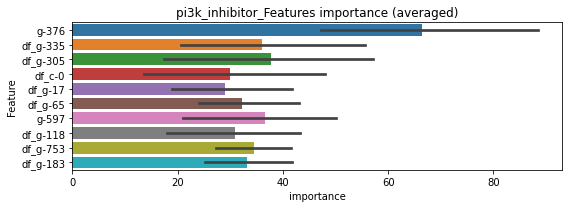

len(train_index) : 2359
len(valid_index) : 2360
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327045	valid_1's binary_logloss: 0.103892
[200]	training's binary_logloss: 0.00760725	valid_1's binary_logloss: 0.0825242
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00547255	valid_1's binary_logloss: 0.0815206


len(train_index) : 2360
len(valid_index) : 2359
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323192	valid_1's binary_logloss: 0.113343
[200]	training's binary_logloss: 0.00730131	valid_1's binary_logloss: 0.0933597


pi3k_inhibitor logloss: 0.0863365939042757


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00489016	valid_1's binary_logloss: 0.0911546


pkc_inhibitor , len(trt) : 31


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834579	valid_1's binary_logloss: 0.156639
[200]	training's binary_logloss: 0.0166537	valid_1's binary_logloss: 0.0636178
[300]	training's binary_logloss: 0.00546312	valid_1's binary_logloss: 0.0397742
[400]	training's binary_logloss: 0.00284948	valid_1's binary_logloss: 0.0312146
[500]	training's binary_logloss: 0.00195586	valid_1's binary_logloss: 0.0277115
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00170706	valid_1's binary_logloss: 0.0266767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785182	valid_1's binary_logloss: 0.144324
[200]	training's binary_logloss: 0.0159789	valid_1's binary_logloss: 0.0624684
[300]	training's binary_logloss: 0.00533686	valid_1's binary_logloss: 0.0383516
[400]	training's binary_logloss: 0.00285617	valid_1's binary_logloss: 0.0297205
[500]	training's binary_logloss: 0.00197983	valid

1 / 3 AUC score:1.000
Threshold: 0.23725024414857412
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00442
p_label_rate: 0.01306 Vs.target_rate: 0.00139, Num_p_label: 52.0, conf_0:0.00442, conf_1:0.35636
Num_p_label: 52.0, Expected: 5.5, Adj_threshold_1: 0.24
Num_p_label: 38.0, Expected: 5.5, Adj_threshold_2: 0.28
Num_p_label: 26.0, Expected: 5.5, Adj_threshold_3: 0.32
Num_p_label: 13.0, Expected: 5.5, Adj_threshold_4: 0.36
Num_p_label: 10.0, Expected: 5.5, Adj_threshold_5: 0.40
Num_p_label: 7.0, Expected: 5.5, Adj_threshold_6: 0.44
threshold:0.44, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775528	valid_1's binary_logloss: 0.145671
[200]	training's binary_logloss: 0.0154735	valid_1's binary_logloss: 0.0627148
[300]	training's binary_logloss: 0.00516994	valid_1's binary_logloss: 0.0370731
[400]	training's binary_logloss: 0.00271225	valid_1's binary_logloss: 0.0277953
[500]	training's binary_logloss: 0.00189021	valid_1's binary_logloss: 0.0243482
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00165348	valid_1's binary_logloss: 0.0226283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818959	valid_1's binary_logloss: 0.135751
[200]	training's binary_logloss: 0.0166206	valid_1's binary_logloss: 0.051089
[300]	training's binary_logloss: 0.00548239	valid_1's binary_logloss: 0.0281504
[400]	training's binary_logloss: 0.00288417	valid_1's binary_logloss: 0.0207962
[500]	training's binary_logloss: 0.00200959	valid_

2 / 3 AUC score:1.000
Threshold: 0.43725024414857405
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/992
30th percentile: 0.00412
p_label_rate: 0.00176 Vs.target_rate: 0.00139, Num_p_label: 7.0, conf_0:0.00412, conf_1:0.43725
threshold:0.44, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:495.0/992, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078698	valid_1's binary_logloss: 0.154817
[200]	training's binary_logloss: 0.0156101	valid_1's binary_logloss: 0.0694426
[300]	training's binary_logloss: 0.00500206	valid_1's binary_logloss: 0.044595
[400]	training's binary_logloss: 0.00264071	valid_1's binary_logloss: 0.035717
[500]	training's binary_logloss: 0.00185654	valid_1's binary_logloss: 0.031754
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00168847	valid_1's binary_logloss: 0.0306364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807236	valid_1's binary_logloss: 0.137926
[200]	training's binary_logloss: 0.0157827	valid_1's binary_logloss: 0.0508513
[300]	training's binary_logloss: 0.00536335	valid_1's binary_logloss: 0.0276051
[400]	training's binary_logloss: 0.0028794	valid_1's binary_logloss: 0.0198045
[500]	training's binary_logloss: 0.00199795	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.43725024414857405
Remove_noisy_labels: 2 → positive_corect_labels: 493.0/990
30th percentile: 0.00416
p_label_rate: 0.00151 Vs.target_rate: 0.00139, Num_p_label: 6.0, conf_0:0.00416, conf_1:0.43725
threshold:0.44, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/4972, y_label_rate: 0.10036


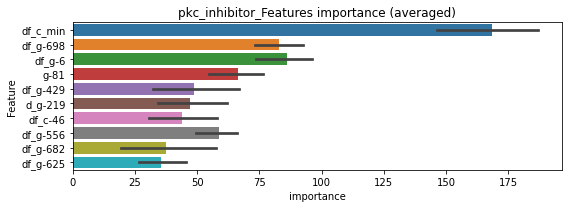

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176429	valid_1's binary_logloss: 0.0395304
[200]	training's binary_logloss: 0.00253612	valid_1's binary_logloss: 0.0190145


len(train_index) : 2486
len(valid_index) : 2486


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000930268	valid_1's binary_logloss: 0.0161926


================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187756	valid_1's binary_logloss: 0.0332584
[200]	training's binary_logloss: 0.00284317	valid_1's binary_logloss: 0.01431
[300]	training's binary_logloss: 0.000849353	valid_1's binary_logloss: 0.0108909
[400]	training's binary_logloss: 0.000452839	valid_1's binary_logloss: 0.0101858
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000461543	valid_1's binary_logloss: 0.0101691


pkc_inhibitor logloss: 0.013180819216066422
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123427	valid_1's binary_logloss: 0.254968
[200]	training's binary_logloss: 0.0307311	valid_1's binary_logloss: 0.143673
[300]	training's binary_logloss: 0.0105146	valid_1's binary_logloss: 0.104966
[400]	training's binary_logloss: 0.00508905	valid_1's binary_logloss: 0.087613
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00351337	valid_1's binary_logloss: 0.081126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120314	valid_1's binary_logloss: 0.238206
[200]	training's binary_logloss: 0.0301398	valid_1's binary_logloss: 0.126267
[300]	training's binary_logloss: 0.0103731	valid_1's binary_logloss: 0.0851914
[400]	training's binary_logloss: 0.00506954	valid_1's binary_logloss: 0.0701506
[500]	training's binary_logloss: 0.00319816	valid_1's binary_logloss: 0.0626007
[600]	training's binary_logloss: 0.00240281	valid_1's bina

1 / 3 AUC score:0.999
Threshold: 0.5524635212628544
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01787
p_label_rate: 0.00578 Vs.target_rate: 0.00241, Num_p_label: 23.0, conf_0:0.01787, conf_1:0.55246
threshold:0.55, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118758	valid_1's binary_logloss: 0.258365
[200]	training's binary_logloss: 0.0295811	valid_1's binary_logloss: 0.157754
[300]	training's binary_logloss: 0.0100144	valid_1's binary_logloss: 0.120307
[400]	training's binary_logloss: 0.00487494	valid_1's binary_logloss: 0.101764
[500]	training's binary_logloss: 0.00309187	valid_1's binary_logloss: 0.0953832
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00319977	valid_1's binary_logloss: 0.0953167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113736	valid_1's binary_logloss: 0.234328
[200]	training's binary_logloss: 0.0282418	valid_1's binary_logloss: 0.134989
[300]	training's binary_logloss: 0.00967013	valid_1's binary_logloss: 0.103935
[400]	training's binary_logloss: 0.00474005	valid_1's binary_logloss: 0.0921744
Early stopping, best iteration is:
[451]	training's binar

2 / 3 AUC score:0.993
Threshold: 0.5524635212628544
Remove_noisy_labels: 28 → positive_corect_labels: 471.0/956
30th percentile: 0.01811
p_label_rate: 0.00779 Vs.target_rate: 0.00241, Num_p_label: 31.0, conf_0:0.01811, conf_1:0.55246
Num_p_label: 31.0, Expected: 9.6, Adj_threshold_1: 0.55
Num_p_label: 25.0, Expected: 9.6, Adj_threshold_2: 0.59
Num_p_label: 19.0, Expected: 9.6, Adj_threshold_3: 0.63
Num_p_label: 12.0, Expected: 9.6, Adj_threshold_4: 0.67
threshold:0.67, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:471.0/956, y_label_rate: 0.49268
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114835	valid_1's binary_logloss: 0.241021
[200]	training's binary_logloss: 0.0283945	valid_1's binary_logloss: 0.137051
[300]	training's binary_logloss: 0.00962704	valid_1's binary_logloss: 0.100299
[400]	training's binary_logloss: 0.00472395	valid_1's binary_logloss: 0.0881398
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.0035582	valid_1's binary_logloss: 0.0835534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118868	valid_1's binary_logloss: 0.229678
[200]	training's binary_logloss: 0.029805	valid_1's binary_logloss: 0.129019
[300]	training's binary_logloss: 0.0102738	valid_1's binary_logloss: 0.0951273
[400]	training's binary_logloss: 0.00506152	valid_1's binary_logloss: 0.0839799


3 / 3 AUC score:0.992
Threshold: 0.6724635212628545
Remove_noisy_labels: 13 → positive_corect_labels: 461.0/943


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00378136	valid_1's binary_logloss: 0.0802896


30th percentile: 0.01714
p_label_rate: 0.00804 Vs.target_rate: 0.00241, Num_p_label: 32.0, conf_0:0.01714, conf_1:0.67246
Num_p_label: 32.0, Expected: 9.6, Adj_threshold_1: 0.67
Num_p_label: 30.0, Expected: 9.6, Adj_threshold_2: 0.71
Num_p_label: 20.0, Expected: 9.6, Adj_threshold_3: 0.75
Num_p_label: 10.0, Expected: 9.6, Adj_threshold_4: 0.79
threshold:0.79, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:471.0/4925, y_label_rate: 0.09563


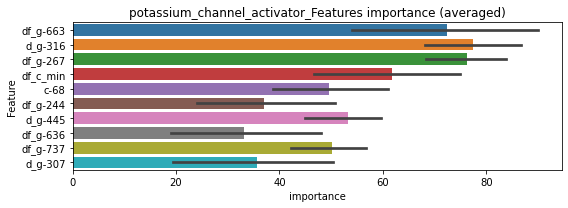

len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303575	valid_1's binary_logloss: 0.0723969
[200]	training's binary_logloss: 0.00518587	valid_1's binary_logloss: 0.0397166
[300]	training's binary_logloss: 0.00149327	valid_1's binary_logloss: 0.0330472
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00103412	valid_1's binary_logloss: 0.031991


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341826	valid_1's binary_logloss: 0.0681105
[200]	training's binary_logloss: 0.00654803	valid_1's binary_logloss: 0.0325327
[300]	training's binary_logloss: 0.00178172	valid_1's binary_logloss: 0.0239721
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00103362	valid_1's binary_logloss: 0.0217818


potassium_channel_activator logloss: 0.026887401220351093
potassium_channel_antagonist , len(trt) : 98


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150886	valid_1's binary_logloss: 0.353268
[200]	training's binary_logloss: 0.0441467	valid_1's binary_logloss: 0.253067
[300]	training's binary_logloss: 0.0162648	valid_1's binary_logloss: 0.212078
[400]	training's binary_logloss: 0.00788374	valid_1's binary_logloss: 0.195887
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00574723	valid_1's binary_logloss: 0.191062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151243	valid_1's binary_logloss: 0.363144
[200]	training's binary_logloss: 0.045469	valid_1's binary_logloss: 0.261953
[300]	training's binary_logloss: 0.0164228	valid_1's binary_logloss: 0.217774
[400]	training's binary_logloss: 0.00789457	valid_1's binary_logloss: 0.197553
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00565769	valid_1's binary_logloss: 0.191263


1 / 3 AUC score:0.973
Threshold: 0.38890092247624963
Remove_noisy_labels: 70 → positive_corect_labels: 465/930
30th percentile: 0.06486
p_label_rate: 0.06102 Vs.target_rate: 0.00412, Num_p_label: 243.0, conf_0:0.06486, conf_1:0.52068
Num_p_label: 243.0, Expected: 16.4, Adj_threshold_1: 0.39
Num_p_label: 156.0, Expected: 16.4, Adj_threshold_2: 0.43
Num_p_label: 100.0, Expected: 16.4, Adj_threshold_3: 0.47
Num_p_label: 73.0, Expected: 16.4, Adj_threshold_4: 0.51
Num_p_label: 43.0, Expected: 16.4, Adj_threshold_5: 0.55
Num_p_label: 29.0, Expected: 16.4, Adj_threshold_6: 0.59
Num_p_label: 13.0, Expected: 16.4, Adj_threshold_7: 0.63
threshold:0.63, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:465.0/930, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143557	valid_1's binary_logloss: 0.320595
[200]	training's binary_logloss: 0.041465	valid_1's binary_logloss: 0.211884
[300]	training's binary_logloss: 0.015261	valid_1's binary_logloss: 0.171169
[400]	training's binary_logloss: 0.00738975	valid_1's binary_logloss: 0.152693
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00596329	valid_1's binary_logloss: 0.14753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142437	valid_1's binary_logloss: 0.333013
[200]	training's binary_logloss: 0.0401572	valid_1's binary_logloss: 0.225199
[300]	training's binary_logloss: 0.014432	valid_1's binary_logloss: 0.185434


2 / 3 AUC score:0.984
Threshold: 0.6289009224762497
Remove_noisy_labels: 45 → positive_corect_labels: 423.0/885
30th percentile: 0.06620
p_label_rate: 0.01105 Vs.target_rate: 0.00412, Num_p_label: 44.0, conf_0:0.06620, conf_1:0.62890
threshold:0.63, positive p_label:44.0/3982, p_label_rate: 0.01105


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00764732	valid_1's binary_logloss: 0.167757


positive y_label:423.0/885, y_label_rate: 0.47797
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131431	valid_1's binary_logloss: 0.300613
[200]	training's binary_logloss: 0.0359994	valid_1's binary_logloss: 0.185152
[300]	training's binary_logloss: 0.0131045	valid_1's binary_logloss: 0.144284
[400]	training's binary_logloss: 0.00644971	valid_1's binary_logloss: 0.124676
[500]	training's binary_logloss: 0.00404057	valid_1's binary_logloss: 0.116724
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00311273	valid_1's binary_logloss: 0.112521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13232	valid_1's binary_logloss: 0.297179
[200]	training's binary_logloss: 0.0369719	valid_1's binary_logloss: 0.189471
[300]	training's binary_logloss: 0.0133165	valid_1's binary_logloss: 0.150542


3 / 3 AUC score:0.990
Threshold: 0.6289009224762497
Remove_noisy_labels: 35 → positive_corect_labels: 393.0/850
30th percentile: 0.03700
p_label_rate: 0.01180 Vs.target_rate: 0.00412, Num_p_label: 47.0, conf_0:0.03700, conf_1:0.62890


[400]	training's binary_logloss: 0.00651588	valid_1's binary_logloss: 0.135381
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00691518	valid_1's binary_logloss: 0.135167


threshold:0.63, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:440.0/4832, y_label_rate: 0.09106


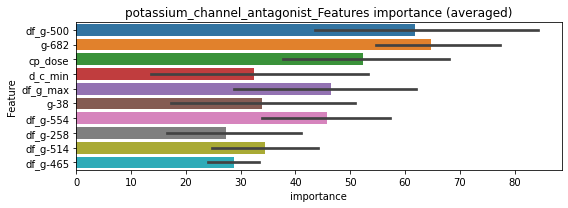

len(train_index) : 2416
len(valid_index) : 2416
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330336	valid_1's binary_logloss: 0.123556


len(train_index) : 2416
len(valid_index) : 2416
================================= fold 2/2 potassium_channel_antagonist=================================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0110395	valid_1's binary_logloss: 0.107169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038581	valid_1's binary_logloss: 0.117719
[200]	training's binary_logloss: 0.00853506	valid_1's binary_logloss: 0.0893491


potassium_channel_antagonist logloss: 0.09645224578153394


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00338813	valid_1's binary_logloss: 0.0857357


ppar_receptor_agonist , len(trt) : 115


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159272	valid_1's binary_logloss: 0.389329
[200]	training's binary_logloss: 0.0499083	valid_1's binary_logloss: 0.299856
[300]	training's binary_logloss: 0.0186644	valid_1's binary_logloss: 0.26625
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0102533	valid_1's binary_logloss: 0.25084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16336	valid_1's binary_logloss: 0.383844
[200]	training's binary_logloss: 0.0510988	valid_1's binary_logloss: 0.284365
[300]	training's binary_logloss: 0.0191417	valid_1's binary_logloss: 0.240985
[400]	training's binary_logloss: 0.00923152	valid_1's binary_logloss: 0.221352
[500]	training's binary_logloss: 0.00557752	valid_1's binary_logloss: 0.208685
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00506665	valid_1's binary_logloss: 0.206837


1 / 3 AUC score:0.966
Threshold: 0.4489642505341177
Remove_noisy_labels: 94 → positive_corect_labels: 453/906
30th percentile: 0.09007
p_label_rate: 0.05575 Vs.target_rate: 0.00476, Num_p_label: 222.0, conf_0:0.09007, conf_1:0.50561
Num_p_label: 222.0, Expected: 18.9, Adj_threshold_1: 0.45
Num_p_label: 145.0, Expected: 18.9, Adj_threshold_2: 0.49
Num_p_label: 100.0, Expected: 18.9, Adj_threshold_3: 0.53
Num_p_label: 65.0, Expected: 18.9, Adj_threshold_4: 0.57
Num_p_label: 45.0, Expected: 18.9, Adj_threshold_5: 0.61
Num_p_label: 25.0, Expected: 18.9, Adj_threshold_6: 0.65
threshold:0.65, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:453.0/906, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152324	valid_1's binary_logloss: 0.341534
[200]	training's binary_logloss: 0.0453881	valid_1's binary_logloss: 0.238591
[300]	training's binary_logloss: 0.0167447	valid_1's binary_logloss: 0.198712
[400]	training's binary_logloss: 0.00807004	valid_1's binary_logloss: 0.180687
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00590164	valid_1's binary_logloss: 0.174928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148257	valid_1's binary_logloss: 0.353865
[200]	training's binary_logloss: 0.044203	valid_1's binary_logloss: 0.263149
[300]	training's binary_logloss: 0.0160345	valid_1's binary_logloss: 0.227427
[400]	training's binary_logloss: 0.0078121	valid_1's binary_logloss: 0.20976
[500]	training's binary_logloss: 0.00481276	valid_1's binary_logloss: 0.200219
Early stopping, best iteration is:
[546]	training's binary_loglo

2 / 3 AUC score:0.977
Threshold: 0.6489642505341178
Remove_noisy_labels: 59 → positive_corect_labels: 399.0/847
30th percentile: 0.06663
p_label_rate: 0.01205 Vs.target_rate: 0.00476, Num_p_label: 48.0, conf_0:0.05261, conf_1:0.64896
threshold:0.65, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:399.0/847, y_label_rate: 0.47107
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148167	valid_1's binary_logloss: 0.336443
[200]	training's binary_logloss: 0.0427371	valid_1's binary_logloss: 0.218407
[300]	training's binary_logloss: 0.0158951	valid_1's binary_logloss: 0.177376
[400]	training's binary_logloss: 0.00767532	valid_1's binary_logloss: 0.15615
[500]	training's binary_logloss: 0.0047118	valid_1's binary_logloss: 0.149272
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00474914	valid_1's binary_logloss: 0.149127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136283	valid_1's binary_logloss: 0.327582
[200]	training's binary_logloss: 0.0392125	valid_1's binary_logloss: 0.230571
[300]	training's binary_logloss: 0.0144682	valid_1's binary_logloss: 0.192178
[400]	training's binary_logloss: 0.00699316	valid_1's binary_logloss: 0.177386


3 / 3 AUC score:0.985
Threshold: 0.6489642505341178
Remove_noisy_labels: 54 → positive_corect_labels: 347.0/793
30th percentile: 0.04402
p_label_rate: 0.00854 Vs.target_rate: 0.00476, Num_p_label: 34.0, conf_0:0.04402, conf_1:0.64896


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00539066	valid_1's binary_logloss: 0.170727


threshold:0.65, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:381.0/4775, y_label_rate: 0.07979


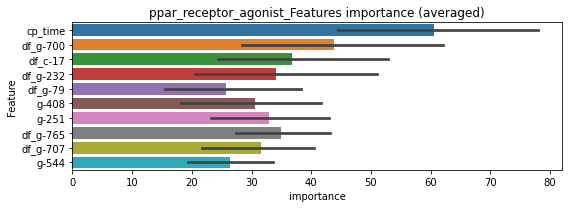

len(train_index) : 2387
len(valid_index) : 2388
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397828	valid_1's binary_logloss: 0.116508
[200]	training's binary_logloss: 0.00907128	valid_1's binary_logloss: 0.0941004


len(train_index) : 2388
len(valid_index) : 2387


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00624921	valid_1's binary_logloss: 0.0930853


================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384225	valid_1's binary_logloss: 0.106664
[200]	training's binary_logloss: 0.00847417	valid_1's binary_logloss: 0.0861214


ppar_receptor_agonist logloss: 0.08797383269670948


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0031418	valid_1's binary_logloss: 0.0828602


ppar_receptor_antagonist , len(trt) : 30


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842994	valid_1's binary_logloss: 0.16503
[200]	training's binary_logloss: 0.0165331	valid_1's binary_logloss: 0.0731552
[300]	training's binary_logloss: 0.00531461	valid_1's binary_logloss: 0.0452791
[400]	training's binary_logloss: 0.00272253	valid_1's binary_logloss: 0.0349983
[500]	training's binary_logloss: 0.00187205	valid_1's binary_logloss: 0.0303295
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0016082	valid_1's binary_logloss: 0.0285234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843691	valid_1's binary_logloss: 0.172114
[200]	training's binary_logloss: 0.0168498	valid_1's binary_logloss: 0.0759625
[300]	training's binary_logloss: 0.00537612	valid_1's binary_logloss: 0.0473173
[400]	training's binary_logloss: 0.00273774	valid_1's binary_logloss: 0.0371226
[500]	training's binary_logloss: 0.00187711	valid_1

1 / 3 AUC score:1.000
Threshold: 0.5379719684617107
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00441
p_label_rate: 0.00025 Vs.target_rate: 0.00135, Num_p_label: 1.0, conf_0:0.00441, conf_1:0.53797
Num_p_label: 1.0, Expected: 5.4, Adj_threshold_1: 0.54
Num_p_label: 1.0, Expected: 5.4, Adj_threshold_2: 0.50
Num_p_label: 3.0, Expected: 5.4, Adj_threshold_3: 0.46
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_4: 0.42
threshold:0.42, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828859	valid_1's binary_logloss: 0.157782
[200]	training's binary_logloss: 0.0165372	valid_1's binary_logloss: 0.0655105
[300]	training's binary_logloss: 0.00523403	valid_1's binary_logloss: 0.0379877
[400]	training's binary_logloss: 0.00271541	valid_1's binary_logloss: 0.0289096
[500]	training's binary_logloss: 0.00186343	valid_1's binary_logloss: 0.0244793
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00160738	valid_1's binary_logloss: 0.0225696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870007	valid_1's binary_logloss: 0.149694
[200]	training's binary_logloss: 0.0171683	valid_1's binary_logloss: 0.0562378
[300]	training's binary_logloss: 0.00556194	valid_1's binary_logloss: 0.0322152
[400]	training's binary_logloss: 0.00286606	valid_1's binary_logloss: 0.0240998
[500]	training's binary_logloss: 0.00194522	valid

2 / 3 AUC score:1.000
Threshold: 0.41797196846171075
Remove_noisy_labels: 2 → positive_corect_labels: 497.0/992
30th percentile: 0.00433
p_label_rate: 0.00251 Vs.target_rate: 0.00135, Num_p_label: 10.0, conf_0:0.00433, conf_1:0.44345
threshold:0.42, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:497.0/992, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804482	valid_1's binary_logloss: 0.153073
[200]	training's binary_logloss: 0.0157528	valid_1's binary_logloss: 0.0566596
[300]	training's binary_logloss: 0.00511691	valid_1's binary_logloss: 0.0318219
[400]	training's binary_logloss: 0.0026798	valid_1's binary_logloss: 0.0232279
[500]	training's binary_logloss: 0.00185997	valid_1's binary_logloss: 0.0192216
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00160021	valid_1's binary_logloss: 0.0172234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0884486	valid_1's binary_logloss: 0.153943
[200]	training's binary_logloss: 0.0177261	valid_1's binary_logloss: 0.0561145
[300]	training's binary_logloss: 0.00566735	valid_1's binary_logloss: 0.0306198
[400]	training's binary_logloss: 0.00287455	valid_1's binary_logloss: 0.021885
[500]	training's binary_logloss: 0.00193828	valid_1

3 / 3 AUC score:1.000
Threshold: 0.41797196846171075
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/992
30th percentile: 0.00427
p_label_rate: 0.00226 Vs.target_rate: 0.00135, Num_p_label: 9.0, conf_0:0.00427, conf_1:0.46112
threshold:0.42, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:506.0/4974, y_label_rate: 0.10173


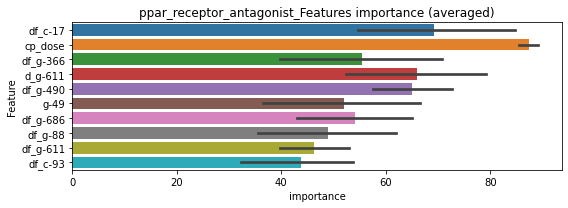

len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230256	valid_1's binary_logloss: 0.0416524
[200]	training's binary_logloss: 0.00338616	valid_1's binary_logloss: 0.0170089
[300]	training's binary_logloss: 0.000948008	valid_1's binary_logloss: 0.0130117
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.000669394	valid_1's binary_logloss: 0.012631


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244698	valid_1's binary_logloss: 0.0469099
[200]	training's binary_logloss: 0.00342117	valid_1's binary_logloss: 0.0171887
[300]	training's binary_logloss: 0.000956465	valid_1's binary_logloss: 0.0123502
[400]	training's binary_logloss: 0.000478987	valid_1's binary_logloss: 0.0112359
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000471664	valid_1's binary_logloss: 0.0112285


ppar_receptor_antagonist logloss: 0.011929750489655734
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163004	valid_1's binary_logloss: 0.404107
[200]	training's binary_logloss: 0.0522494	valid_1's binary_logloss: 0.318587
[300]	training's binary_logloss: 0.0199114	valid_1's binary_logloss: 0.281147
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0118685	valid_1's binary_logloss: 0.271205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158791	valid_1's binary_logloss: 0.412883
[200]	training's binary_logloss: 0.0486886	valid_1's binary_logloss: 0.332554
[300]	training's binary_logloss: 0.018165	valid_1's binary_logloss: 0.299372


1 / 3 AUC score:0.943
Threshold: 0.42917656748791144
Remove_noisy_labels: 110 → positive_corect_labels: 445/890
30th percentile: 0.11555
p_label_rate: 0.07308 Vs.target_rate: 0.00490, Num_p_label: 291.0, conf_0:0.11555, conf_1:0.47753
Num_p_label: 291.0, Expected: 19.5, Adj_threshold_1: 0.43


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0143217	valid_1's binary_logloss: 0.293182


Num_p_label: 195.0, Expected: 19.5, Adj_threshold_2: 0.47
Num_p_label: 136.0, Expected: 19.5, Adj_threshold_3: 0.51
Num_p_label: 89.0, Expected: 19.5, Adj_threshold_4: 0.55
Num_p_label: 49.0, Expected: 19.5, Adj_threshold_5: 0.59
Num_p_label: 25.0, Expected: 19.5, Adj_threshold_6: 0.63
threshold:0.63, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:445.0/890, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146256	valid_1's binary_logloss: 0.34512
[200]	training's binary_logloss: 0.0427761	valid_1's binary_logloss: 0.252079
[300]	training's binary_logloss: 0.0159281	valid_1's binary_logloss: 0.207627
[400]	training's binary_logloss: 0.00782869	valid_1's binary_logloss: 0.188772
[500]	training's binary_logloss: 0.00482945	valid_1's binary_logloss: 0.179076
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00424804	valid_1's binary_logloss: 0.176114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144368	valid_1's binary_logloss: 0.359394
[200]	training's binary_logloss: 0.0420893	valid_1's binary_logloss: 0.277416
[300]	training's binary_logloss: 0.0154389	valid_1's binary_logloss: 0.24986
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0150709	valid_1's binary_logloss: 0.249836


2 / 3 AUC score:0.971
Threshold: 0.6291765674879115
Remove_noisy_labels: 77 → positive_corect_labels: 380.0/813
30th percentile: 0.08146
p_label_rate: 0.03114 Vs.target_rate: 0.00490, Num_p_label: 124.0, conf_0:0.08146, conf_1:0.62918
Num_p_label: 124.0, Expected: 19.5, Adj_threshold_1: 0.63
Num_p_label: 86.0, Expected: 19.5, Adj_threshold_2: 0.67
Num_p_label: 55.0, Expected: 19.5, Adj_threshold_3: 0.71
Num_p_label: 30.0, Expected: 19.5, Adj_threshold_4: 0.75
Num_p_label: 10.0, Expected: 19.5, Adj_threshold_5: 0.79
threshold:0.79, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:380.0/813, y_label_rate: 0.46740
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137798	valid_1's binary_logloss: 0.311153
[200]	training's binary_logloss: 0.0389059	valid_1's binary_logloss: 0.21652
[300]	training's binary_logloss: 0.0142249	valid_1's binary_logloss: 0.18545
[400]	training's binary_logloss: 0.00707132	valid_1's binary_logloss: 0.171257
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00686925	valid_1's binary_logloss: 0.17112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129887	valid_1's binary_logloss: 0.30608
[200]	training's binary_logloss: 0.036763	valid_1's binary_logloss: 0.203622
[300]	training's binary_logloss: 0.0132434	valid_1's binary_logloss: 0.159376
[400]	training's binary_logloss: 0.00658471	valid_1's binary_logloss: 0.14316
[500]	training's binary_logloss: 0.00417486	valid_1's binary_logloss: 0.133955
Early stopping, best iteration is:
[504]	training's binary_logloss:

3 / 3 AUC score:0.987
Threshold: 0.7891765674879117
Remove_noisy_labels: 69 → positive_corect_labels: 311.0/744
30th percentile: 0.04170
p_label_rate: 0.00653 Vs.target_rate: 0.00490, Num_p_label: 26.0, conf_0:0.04170, conf_1:0.78918
threshold:0.79, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:337.0/4726, y_label_rate: 0.07131


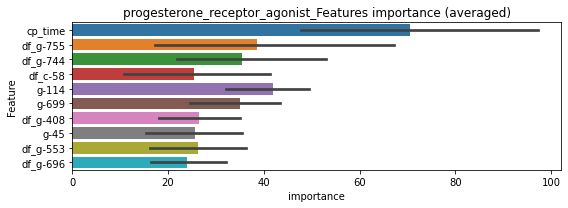

len(train_index) : 2363
len(valid_index) : 2363
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297345	valid_1's binary_logloss: 0.0900882
[200]	training's binary_logloss: 0.00633422	valid_1's binary_logloss: 0.069448


len(train_index) : 2363
len(valid_index) : 2363


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00341619	valid_1's binary_logloss: 0.0676694


================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320313	valid_1's binary_logloss: 0.088065
[200]	training's binary_logloss: 0.00696437	valid_1's binary_logloss: 0.0659575


progesterone_receptor_agonist logloss: 0.0668134744859545


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00696437	valid_1's binary_logloss: 0.0659575


progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

1 / 3 AUC score:1.000
Threshold: 0.6102573281439976
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00225
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00225, conf_1:0.61026
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.61
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.57
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.53
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.49
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_5: 0.45
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_6: 0.41
threshold:0.41, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653251	valid_1's binary_logloss: 0.106596
[200]	training's binary_logloss: 0.0107476	valid_1's binary_logloss: 0.0308542
[300]	training's binary_logloss: 0.00345171	valid_1's binary_logloss: 0.0148548
[400]	training's binary_logloss: 0.00187157	valid_1's binary_logloss: 0.0100507
[500]	training's binary_logloss: 0.00140479	valid_1's binary_logloss: 0.00838464
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00131824	valid_1's binary_logloss: 0.00806501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608802	valid_1's binary_logloss: 0.114039
[200]	training's binary_logloss: 0.00987494	valid_1's binary_logloss: 0.0403625
[300]	training's binary_logloss: 0.00315423	valid_1's binary_logloss: 0.023827
[400]	training's binary_logloss: 0.00174842	valid_1's binary_logloss: 0.017838
Early stopping, best iteration is:
[458]	trainin

2 / 3 AUC score:1.000
Threshold: 0.41025732814399757
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00225
p_label_rate: 0.00176 Vs.target_rate: 0.00082, Num_p_label: 7.0, conf_0:0.00225, conf_1:0.41026
threshold:0.41, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646972	valid_1's binary_logloss: 0.102255
[200]	training's binary_logloss: 0.0106555	valid_1's binary_logloss: 0.0319379
[300]	training's binary_logloss: 0.00338427	valid_1's binary_logloss: 0.0161888
[400]	training's binary_logloss: 0.00186553	valid_1's binary_logloss: 0.0115435
[500]	training's binary_logloss: 0.00140048	valid_1's binary_logloss: 0.00979887
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00134308	valid_1's binary_logloss: 0.00945436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628147	valid_1's binary_logloss: 0.113782
[200]	training's binary_logloss: 0.0104959	valid_1's binary_logloss: 0.0352286
[300]	training's binary_logloss: 0.00338792	valid_1's binary_logloss: 0.0184453
[400]	training's binary_logloss: 0.00184216	valid_1's binary_logloss: 0.0131588
Early stopping, best iteration is:
[456]	traini

3 / 3 AUC score:1.000
Threshold: 0.41025732814399757
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/997
30th percentile: 0.00235
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00235, conf_1:0.41026
threshold:0.41, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4979, y_label_rate: 0.10102


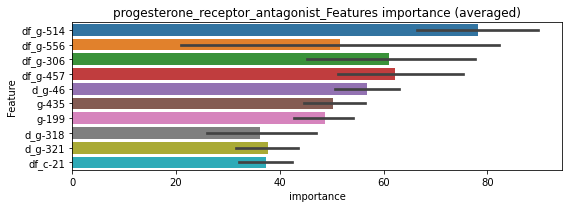

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171003	valid_1's binary_logloss: 0.0371887
[200]	training's binary_logloss: 0.00210107	valid_1's binary_logloss: 0.0191082
[300]	training's binary_logloss: 0.000576227	valid_1's binary_logloss: 0.0158702
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000338047	valid_1's binary_logloss: 0.015145


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183044	valid_1's binary_logloss: 0.0278654
[200]	training's binary_logloss: 0.00222964	valid_1's binary_logloss: 0.0076332
[300]	training's binary_logloss: 0.000606493	valid_1's binary_logloss: 0.00512174
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000403489	valid_1's binary_logloss: 0.00478267


progesterone_receptor_antagonist logloss: 0.00996486306670761
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976	valid_1's binary_logloss: 0.174746
[200]	training's binary_logloss: 0.0213261	valid_1's binary_logloss: 0.0790829
[300]	training's binary_logloss: 0.00689517	valid_1's binary_logloss: 0.0520162
[400]	training's binary_logloss: 0.00346449	valid_1's binary_logloss: 0.0421099
[500]	training's binary_logloss: 0.00229774	valid_1's binary_logloss: 0.0378785
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00187378	valid_1's binary_logloss: 0.0358599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909197	valid_1's binary_logloss: 0.179101
[200]	training's binary_logloss: 0.0192577	valid_1's binary_logloss: 0.0800916
[300]	training's binary_logloss: 0.00635048	valid_1's binary_logloss: 0.0500583
[400]	training's binary_logloss: 0.00326148	valid_1's binary_logloss: 0.0395424
[500]	training's binary_logloss: 0.00220575	valid_1'

1 / 3 AUC score:0.999
Threshold: 0.33682014682379957
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00718
p_label_rate: 0.01030 Vs.target_rate: 0.00161, Num_p_label: 41.0, conf_0:0.00718, conf_1:0.49490
Num_p_label: 41.0, Expected: 6.4, Adj_threshold_1: 0.34
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_2: 0.38
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_3: 0.42
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_4: 0.46
Num_p_label: 9.0, Expected: 6.4, Adj_threshold_5: 0.50
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096345	valid_1's binary_logloss: 0.165144
[200]	training's binary_logloss: 0.0205142	valid_1's binary_logloss: 0.0643343
[300]	training's binary_logloss: 0.00666849	valid_1's binary_logloss: 0.034552
[400]	training's binary_logloss: 0.0033735	valid_1's binary_logloss: 0.0244744
[500]	training's binary_logloss: 0.00226359	valid_1's binary_logloss: 0.0202216
[600]	training's binary_logloss: 0.00184682	valid_1's binary_logloss: 0.0180179
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.00178441	valid_1's binary_logloss: 0.017635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902799	valid_1's binary_logloss: 0.176332
[200]	training's binary_logloss: 0.0193794	valid_1's binary_logloss: 0.0853456
[300]	training's binary_logloss: 0.00627013	valid_1's binary_logloss: 0.0576545
[400]	training's binary_logloss: 0.00321635	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.4968201468237995
Remove_noisy_labels: 4 → positive_corect_labels: 493.0/988
30th percentile: 0.00687
p_label_rate: 0.00477 Vs.target_rate: 0.00161, Num_p_label: 19.0, conf_0:0.00687, conf_1:0.53254
threshold:0.50, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:493.0/988, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931675	valid_1's binary_logloss: 0.168002
[200]	training's binary_logloss: 0.0198715	valid_1's binary_logloss: 0.0696473
[300]	training's binary_logloss: 0.00646027	valid_1's binary_logloss: 0.0417941
[400]	training's binary_logloss: 0.0032656	valid_1's binary_logloss: 0.0333151
[500]	training's binary_logloss: 0.00220575	valid_1's binary_logloss: 0.029772
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00199745	valid_1's binary_logloss: 0.0291338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877422	valid_1's binary_logloss: 0.166081
[200]	training's binary_logloss: 0.0185946	valid_1's binary_logloss: 0.0762132
[300]	training's binary_logloss: 0.00614535	valid_1's binary_logloss: 0.0478359
[400]	training's binary_logloss: 0.00319547	valid_1's binary_logloss: 0.0375625
[500]	training's binary_logloss: 0.00215267	valid_1

3 / 3 AUC score:1.000
Threshold: 0.4968201468237995
Remove_noisy_labels: 6 → positive_corect_labels: 489.0/982
30th percentile: 0.00674
p_label_rate: 0.00477 Vs.target_rate: 0.00161, Num_p_label: 19.0, conf_0:0.00674, conf_1:0.52527
threshold:0.50, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:508.0/4964, y_label_rate: 0.10234


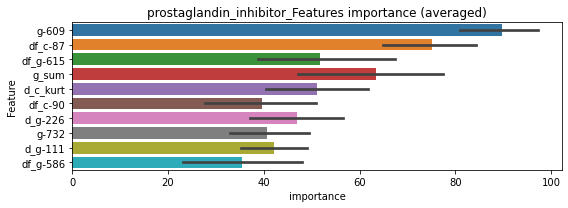

len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251919	valid_1's binary_logloss: 0.0589118
[200]	training's binary_logloss: 0.00415107	valid_1's binary_logloss: 0.0350654


len(train_index) : 2482
len(valid_index) : 2482


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00147512	valid_1's binary_logloss: 0.0304208


================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287604	valid_1's binary_logloss: 0.0541681
[200]	training's binary_logloss: 0.0047388	valid_1's binary_logloss: 0.0271875
[300]	training's binary_logloss: 0.00130412	valid_1's binary_logloss: 0.0229393
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00124228	valid_1's binary_logloss: 0.0228759


prostaglandin_inhibitor logloss: 0.02664837402859014
prostanoid_receptor_antagonist , len(trt) : 84


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146646	valid_1's binary_logloss: 0.331994
[200]	training's binary_logloss: 0.0430168	valid_1's binary_logloss: 0.225599
[300]	training's binary_logloss: 0.0157062	valid_1's binary_logloss: 0.178828
[400]	training's binary_logloss: 0.00768263	valid_1's binary_logloss: 0.157185
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00604401	valid_1's binary_logloss: 0.153121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140111	valid_1's binary_logloss: 0.343356
[200]	training's binary_logloss: 0.0394961	valid_1's binary_logloss: 0.246544
[300]	training's binary_logloss: 0.0146376	valid_1's binary_logloss: 0.211183
[400]	training's binary_logloss: 0.00707301	valid_1's binary_logloss: 0.198953


1 / 3 AUC score:0.975
Threshold: 0.4180839308073214


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00630108	valid_1's binary_logloss: 0.196317


Remove_noisy_labels: 68 → positive_corect_labels: 466/932
30th percentile: 0.05670
p_label_rate: 0.02562 Vs.target_rate: 0.00358, Num_p_label: 102.0, conf_0:0.05670, conf_1:0.51304
Num_p_label: 102.0, Expected: 14.3, Adj_threshold_1: 0.42
Num_p_label: 76.0, Expected: 14.3, Adj_threshold_2: 0.46
Num_p_label: 51.0, Expected: 14.3, Adj_threshold_3: 0.50
Num_p_label: 33.0, Expected: 14.3, Adj_threshold_4: 0.54
Num_p_label: 20.0, Expected: 14.3, Adj_threshold_5: 0.58
threshold:0.58, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:466.0/932, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13886	valid_1's binary_logloss: 0.304053
[200]	training's binary_logloss: 0.03911	valid_1's binary_logloss: 0.193942
[300]	training's binary_logloss: 0.0141377	valid_1's binary_logloss: 0.144234
[400]	training's binary_logloss: 0.00691241	valid_1's binary_logloss: 0.126105
[500]	training's binary_logloss: 0.00431175	valid_1's binary_logloss: 0.115895
[600]	training's binary_logloss: 0.00315871	valid_1's binary_logloss: 0.110475
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00307419	valid_1's binary_logloss: 0.109887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130349	valid_1's binary_logloss: 0.314655
[200]	training's binary_logloss: 0.0359958	valid_1's binary_logloss: 0.205587
[300]	training's binary_logloss: 0.0131338	valid_1's binary_logloss: 0.162871
[400]	training's binary_logloss: 0.00650044	valid_1's binary_log

2 / 3 AUC score:0.991
Threshold: 0.5780839308073215
Remove_noisy_labels: 37 → positive_corect_labels: 437.0/895
30th percentile: 0.03681
p_label_rate: 0.01105 Vs.target_rate: 0.00358, Num_p_label: 44.0, conf_0:0.03624, conf_1:0.58874
Num_p_label: 44.0, Expected: 14.3, Adj_threshold_1: 0.58
Num_p_label: 38.0, Expected: 14.3, Adj_threshold_2: 0.62
Num_p_label: 29.0, Expected: 14.3, Adj_threshold_3: 0.66
Num_p_label: 17.0, Expected: 14.3, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:437.0/895, y_label_rate: 0.48827
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124856	valid_1's binary_logloss: 0.277228
[200]	training's binary_logloss: 0.0330384	valid_1's binary_logloss: 0.165683
[300]	training's binary_logloss: 0.0117584	valid_1's binary_logloss: 0.124111
[400]	training's binary_logloss: 0.00588322	valid_1's binary_logloss: 0.105429
[500]	training's binary_logloss: 0.00376838	valid_1's binary_logloss: 0.0983703
[600]	training's binary_logloss: 0.00286203	valid_1's binary_logloss: 0.0943945
Early stopping, best iteration is:
[676]	training's binary_logloss: 0.00251387	valid_1's binary_logloss: 0.0927339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13434	valid_1's binary_logloss: 0.33167
[200]	training's binary_logloss: 0.0366571	valid_1's binary_logloss: 0.219671
[300]	training's binary_logloss: 0.0128046	valid_1's binary_logloss: 0.182811
[400]	training's binary_logloss: 0.00622266	valid_1's binary

3 / 3 AUC score:0.992
Threshold: 0.6980839308073216
Remove_noisy_labels: 42 → positive_corect_labels: 397.0/853
30th percentile: 0.02850
p_label_rate: 0.00251 Vs.target_rate: 0.00358, Num_p_label: 10.0, conf_0:0.02679, conf_1:0.69808
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:407.0/4835, y_label_rate: 0.08418


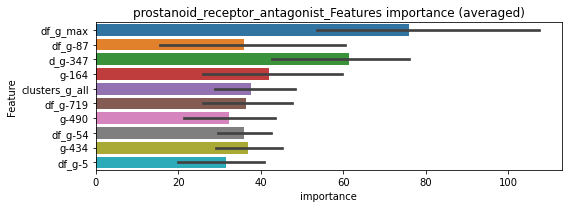

len(train_index) : 2417
len(valid_index) : 2418
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031955	valid_1's binary_logloss: 0.0806595
[200]	training's binary_logloss: 0.00678662	valid_1's binary_logloss: 0.0524982
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00221531	valid_1's binary_logloss: 0.0465983


len(train_index) : 2418
len(valid_index) : 2417
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033876	valid_1's binary_logloss: 0.0801848
[200]	training's binary_logloss: 0.00695632	valid_1's binary_logloss: 0.053402
[300]	training's binary_logloss: 0.00198912	valid_1's binary_logloss: 0.0474947
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00182959	valid_1's binary_logloss: 0.0472683


prostanoid_receptor_antagonist logloss: 0.046933197657106115
proteasome_inhibitor , len(trt) : 726


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.68437	valid_1's binary_logloss: 0.69413
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.502
Threshold: 0.49921656095179584
Remove_noisy_labels: 740 → positive_corect_labels: 356/712
30th percentile: 0.49454
p_label_rate: 0.49799 Vs.target_rate: 0.01140, Num_p_label: 1983.0, conf_0:0.49454, conf_1:0.49922
Num_p_label: 1983.0, Expected: 45.4, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 45.4, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.674113	valid_1's binary_logloss: 0.692327


positive y_label:356.0/712, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.612328	valid_1's binary_logloss: 0.686767


2 / 3 AUC score:0.561
Threshold: 0.5392165609517958
Remove_noisy_labels: 344 → positive_corect_labels: 25.0/368
30th percentile: 0.48852
p_label_rate: 0.01180 Vs.target_rate: 0.01140, Num_p_label: 47.0, conf_0:0.48852, conf_1:0.53922
threshold:0.54, positive p_label:47.0/3982, p_label_rate: 0.01180


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.673613	valid_1's binary_logloss: 0.691064


positive y_label:25.0/368, y_label_rate: 0.06793
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.19348	valid_1's binary_logloss: 0.251606
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.727
Threshold: 0.5392165609517958
Remove_noisy_labels: 25 → positive_corect_labels: 0.0/343
30th percentile: 0.04553
p_label_rate: 0.00000 Vs.target_rate: 0.01140, Num_p_label: 0.0, conf_0:0.04553, conf_1:0.53922
Num_p_label: 0.0, Expected: 45.4, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 45.4, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 45.4, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 45.4, Adj_threshold_4: 0.42
Num_p_label: 0.0, Expected: 45.4, Adj_threshold_5: 0.38
Num_p_label: 0.0, Expected: 45.4, Adj_threshold_6: 0.34
Num_p_label: 0.0, Expected: 45.4, Adj_threshold_7: 0.30
Num_p_label: 1.0, Expected: 45.4, Adj_threshold_8: 0.26
Num_p_label: 2.0, Expected: 45.4, Adj_threshold_9: 0.22
threshold:0.18, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0915176	valid_1's binary_logloss: 0.211646


positive y_label:2.0/4325, y_label_rate: 0.00046


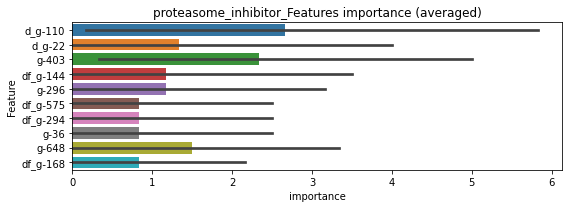

len(train_index) : 2162
len(valid_index) : 2163
================================= fold 1/2 proteasome_inhibitor=================================
len(train_index) : 2163
len(valid_index) : 2162


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00389212	valid_1's binary_logloss: 0.00401435


================================= fold 2/2 proteasome_inhibitor=================================
proteasome_inhibitor logloss: 0.0040151681133398336
protein_kinase_inhibitor , len(trt) : 48


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00389112	valid_1's binary_logloss: 0.00401599


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112899	valid_1's binary_logloss: 0.224443
[200]	training's binary_logloss: 0.0270087	valid_1's binary_logloss: 0.11511
[300]	training's binary_logloss: 0.00906359	valid_1's binary_logloss: 0.078473
[400]	training's binary_logloss: 0.00445137	valid_1's binary_logloss: 0.0661147
[500]	training's binary_logloss: 0.00289668	valid_1's binary_logloss: 0.0599909
[600]	training's binary_logloss: 0.00221558	valid_1's binary_logloss: 0.0563766
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.00204512	valid_1's binary_logloss: 0.055515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114521	valid_1's binary_logloss: 0.237716
[200]	training's binary_logloss: 0.0274501	valid_1's binary_logloss: 0.127278
[300]	training's binary_logloss: 0.00922521	valid_1's binary_logloss: 0.089572
[400]	training's binary_logloss: 0.00452208	valid_1's bin

1 / 3 AUC score:0.998
Threshold: 0.43572975418750703
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01271
p_label_rate: 0.00502 Vs.target_rate: 0.00212, Num_p_label: 20.0, conf_0:0.01271, conf_1:0.54784
threshold:0.44, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11014	valid_1's binary_logloss: 0.219758
[200]	training's binary_logloss: 0.026254	valid_1's binary_logloss: 0.115228
[300]	training's binary_logloss: 0.00890302	valid_1's binary_logloss: 0.0754037
[400]	training's binary_logloss: 0.00437205	valid_1's binary_logloss: 0.0572649
[500]	training's binary_logloss: 0.00284355	valid_1's binary_logloss: 0.0488063
[600]	training's binary_logloss: 0.00219826	valid_1's binary_logloss: 0.0442567
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00203487	valid_1's binary_logloss: 0.0431099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106729	valid_1's binary_logloss: 0.248348
[200]	training's binary_logloss: 0.025006	valid_1's binary_logloss: 0.148561
[300]	training's binary_logloss: 0.00831445	valid_1's binary_logloss: 0.119233
[400]	training's binary_logloss: 0.00414083	valid_1's bin

2 / 3 AUC score:0.995
Threshold: 0.43572975418750703
Remove_noisy_labels: 20 → positive_corect_labels: 475.0/964
30th percentile: 0.01274
p_label_rate: 0.00829 Vs.target_rate: 0.00212, Num_p_label: 33.0, conf_0:0.01274, conf_1:0.56859


Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00320973	valid_1's binary_logloss: 0.10442


Num_p_label: 33.0, Expected: 8.4, Adj_threshold_1: 0.44
Num_p_label: 26.0, Expected: 8.4, Adj_threshold_2: 0.48
Num_p_label: 15.0, Expected: 8.4, Adj_threshold_3: 0.52
Num_p_label: 12.0, Expected: 8.4, Adj_threshold_4: 0.56
threshold:0.56, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:475.0/964, y_label_rate: 0.49274
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105276	valid_1's binary_logloss: 0.213116
[200]	training's binary_logloss: 0.0241425	valid_1's binary_logloss: 0.122738
[300]	training's binary_logloss: 0.00807381	valid_1's binary_logloss: 0.096947
[400]	training's binary_logloss: 0.00405653	valid_1's binary_logloss: 0.0877853
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00305754	valid_1's binary_logloss: 0.0851132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107986	valid_1's binary_logloss: 0.218783
[200]	training's binary_logloss: 0.0254521	valid_1's binary_logloss: 0.112332
[300]	training's binary_logloss: 0.00862276	valid_1's binary_logloss: 0.0760921
[400]	training's binary_logloss: 0.00432569	valid_1's binary_logloss: 0.0611554
[500]	training's binary_logloss: 0.00283025	valid_1's binary_logloss: 0.0550295
[600]	training's binary_logloss: 0.00219699	valid_1's 

3 / 3 AUC score:0.995
Threshold: 0.555729754187507
Remove_noisy_labels: 17 → positive_corect_labels: 460.0/947
30th percentile: 0.01119
p_label_rate: 0.00226 Vs.target_rate: 0.00212, Num_p_label: 9.0, conf_0:0.01075, conf_1:0.55573
threshold:0.56, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:469.0/4929, y_label_rate: 0.09515


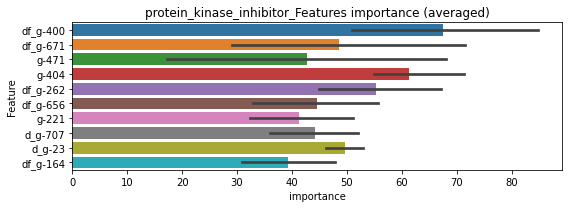

len(train_index) : 2464
len(valid_index) : 2465
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273932	valid_1's binary_logloss: 0.0573558
[200]	training's binary_logloss: 0.0048226	valid_1's binary_logloss: 0.0275887
[300]	training's binary_logloss: 0.00139766	valid_1's binary_logloss: 0.0217037
[400]	training's binary_logloss: 0.00068128	valid_1's binary_logloss: 0.0201868
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000684458	valid_1's binary_logloss: 0.020179


len(train_index) : 2465
len(valid_index) : 2464
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313516	valid_1's binary_logloss: 0.0697592
[200]	training's binary_logloss: 0.00574757	valid_1's binary_logloss: 0.0420827
[300]	training's binary_logloss: 0.00155436	valid_1's binary_logloss: 0.0365041
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00148377	valid_1's binary_logloss: 0.0364591


protein_kinase_inhibitor logloss: 0.028317395864578928
protein_phosphatase_inhibitor , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724888	valid_1's binary_logloss: 0.123335
[200]	training's binary_logloss: 0.0130342	valid_1's binary_logloss: 0.046048
[300]	training's binary_logloss: 0.00413329	valid_1's binary_logloss: 0.0249436
[400]	training's binary_logloss: 0.00220649	valid_1's binary_logloss: 0.0184862
[500]	training's binary_logloss: 0.00157117	valid_1's binary_logloss: 0.0159474
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00153605	valid_1's binary_logloss: 0.0155391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715463	valid_1's binary_logloss: 0.1354
[200]	training's binary_logloss: 0.0132869	valid_1's binary_logloss: 0.050115
[300]	training's binary_logloss: 0.00422467	valid_1's binary_logloss: 0.026662
[400]	training's binary_logloss: 0.0022367	valid_1's binary_logloss: 0.0196754
[500]	training's binary_logloss: 0.00159054	valid_1's b

1 / 3 AUC score:1.000
Threshold: 0.5125488038446373
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00237
p_label_rate: 0.00100 Vs.target_rate: 0.00108, Num_p_label: 4.0, conf_0:0.00237, conf_1:0.51255
threshold:0.51, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724888	valid_1's binary_logloss: 0.123335
[200]	training's binary_logloss: 0.0130342	valid_1's binary_logloss: 0.046048
[300]	training's binary_logloss: 0.00413329	valid_1's binary_logloss: 0.0249436
[400]	training's binary_logloss: 0.00220649	valid_1's binary_logloss: 0.0184862
[500]	training's binary_logloss: 0.00157117	valid_1's binary_logloss: 0.0159474
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00153605	valid_1's binary_logloss: 0.0155391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715463	valid_1's binary_logloss: 0.1354
[200]	training's binary_logloss: 0.0132869	valid_1's binary_logloss: 0.050115
[300]	training's binary_logloss: 0.00422467	valid_1's binary_logloss: 0.026662
[400]	training's binary_logloss: 0.0022367	valid_1's binary_logloss: 0.0196754
[500]	training's binary_logloss: 0.00159054	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.5125488038446373
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00237
p_label_rate: 0.00100 Vs.target_rate: 0.00108, Num_p_label: 4.0, conf_0:0.00237, conf_1:0.51255
threshold:0.51, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724888	valid_1's binary_logloss: 0.123335
[200]	training's binary_logloss: 0.0130342	valid_1's binary_logloss: 0.046048
[300]	training's binary_logloss: 0.00413329	valid_1's binary_logloss: 0.0249436
[400]	training's binary_logloss: 0.00220649	valid_1's binary_logloss: 0.0184862
[500]	training's binary_logloss: 0.00157117	valid_1's binary_logloss: 0.0159474
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00153605	valid_1's binary_logloss: 0.0155391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715463	valid_1's binary_logloss: 0.1354
[200]	training's binary_logloss: 0.0132869	valid_1's binary_logloss: 0.050115
[300]	training's binary_logloss: 0.00422467	valid_1's binary_logloss: 0.026662
[400]	training's binary_logloss: 0.0022367	valid_1's binary_logloss: 0.0196754
[500]	training's binary_logloss: 0.00159054	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.5125488038446373
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00237
p_label_rate: 0.00100 Vs.target_rate: 0.00108, Num_p_label: 4.0, conf_0:0.00237, conf_1:0.51255
threshold:0.51, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4982, y_label_rate: 0.10116


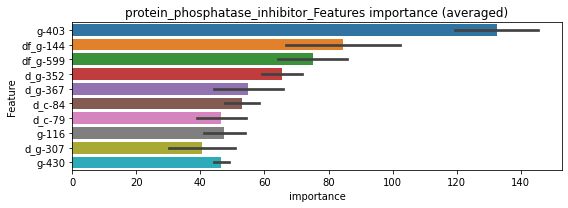

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214471	valid_1's binary_logloss: 0.0294344
[200]	training's binary_logloss: 0.00282606	valid_1's binary_logloss: 0.00654085
[300]	training's binary_logloss: 0.000791729	valid_1's binary_logloss: 0.00321025
[400]	training's binary_logloss: 0.00040537	valid_1's binary_logloss: 0.00256791
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000368734	valid_1's binary_logloss: 0.00250066


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207684	valid_1's binary_logloss: 0.0342854
[200]	training's binary_logloss: 0.00273614	valid_1's binary_logloss: 0.0124518
[300]	training's binary_logloss: 0.000752628	valid_1's binary_logloss: 0.00915946


protein_phosphatase_inhibitor logloss: 0.005698925808488497


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000552575	valid_1's binary_logloss: 0.00889719


protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148856	valid_1's binary_logloss: 0.378762
[200]	training's binary_logloss: 0.0442598	valid_1's binary_logloss: 0.297161
[300]	training's binary_logloss: 0.0162056	valid_1's binary_logloss: 0.260243
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0119591	valid_1's binary_logloss: 0.249508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149545	valid_1's binary_logloss: 0.364273
[200]	training's binary_logloss: 0.0447079	valid_1's binary_logloss: 0.268645
[300]	training's binary_logloss: 0.0163713	valid_1's binary_logloss: 0.232619


1 / 3 AUC score:0.958
Threshold: 0.4503315198157033
Remove_noisy_labels: 90 → positive_corect_labels: 455/910
30th percentile: 0.09690
p_label_rate: 0.05902 Vs.target_rate: 0.00431, Num_p_label: 235.0, conf_0:0.09690, conf_1:0.50632
Num_p_label: 235.0, Expected: 17.2, Adj_threshold_1: 0.45


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.014405	valid_1's binary_logloss: 0.226794


Num_p_label: 169.0, Expected: 17.2, Adj_threshold_2: 0.49
Num_p_label: 112.0, Expected: 17.2, Adj_threshold_3: 0.53
Num_p_label: 64.0, Expected: 17.2, Adj_threshold_4: 0.57
Num_p_label: 41.0, Expected: 17.2, Adj_threshold_5: 0.61
Num_p_label: 27.0, Expected: 17.2, Adj_threshold_6: 0.65
Num_p_label: 15.0, Expected: 17.2, Adj_threshold_7: 0.69
threshold:0.69, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:455.0/910, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14959	valid_1's binary_logloss: 0.322251
[200]	training's binary_logloss: 0.0441837	valid_1's binary_logloss: 0.196504
[300]	training's binary_logloss: 0.0160953	valid_1's binary_logloss: 0.143839
[400]	training's binary_logloss: 0.00781722	valid_1's binary_logloss: 0.11946
[500]	training's binary_logloss: 0.00475758	valid_1's binary_logloss: 0.107511
[600]	training's binary_logloss: 0.00345992	valid_1's binary_logloss: 0.0992249
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00306288	valid_1's binary_logloss: 0.096384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135971	valid_1's binary_logloss: 0.323461
[200]	training's binary_logloss: 0.0377105	valid_1's binary_logloss: 0.2173
[300]	training's binary_logloss: 0.0136789	valid_1's binary_logloss: 0.17721
[400]	training's binary_logloss: 0.00670008	valid_1's binary_logl

2 / 3 AUC score:0.993
Threshold: 0.6903315198157034
Remove_noisy_labels: 40 → positive_corect_labels: 418.0/870
30th percentile: 0.04387
p_label_rate: 0.00703 Vs.target_rate: 0.00431, Num_p_label: 28.0, conf_0:0.02680, conf_1:0.69033
threshold:0.69, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:418.0/870, y_label_rate: 0.48046
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12978	valid_1's binary_logloss: 0.299106
[200]	training's binary_logloss: 0.0362199	valid_1's binary_logloss: 0.194018
[300]	training's binary_logloss: 0.0134297	valid_1's binary_logloss: 0.156657
[400]	training's binary_logloss: 0.00665034	valid_1's binary_logloss: 0.135373
[500]	training's binary_logloss: 0.00417974	valid_1's binary_logloss: 0.124789
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00407193	valid_1's binary_logloss: 0.124232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136448	valid_1's binary_logloss: 0.312948
[200]	training's binary_logloss: 0.038086	valid_1's binary_logloss: 0.197678
[300]	training's binary_logloss: 0.0135834	valid_1's binary_logloss: 0.153686
[400]	training's binary_logloss: 0.00673513	valid_1's binary_logloss: 0.131817
Early stopping, best iteration is:
[477]	training's binary_logl

3 / 3 AUC score:0.993
Threshold: 0.6903315198157034
Remove_noisy_labels: 40 → positive_corect_labels: 379.0/830
30th percentile: 0.03939
p_label_rate: 0.00728 Vs.target_rate: 0.00431, Num_p_label: 29.0, conf_0:0.02692, conf_1:0.69033
threshold:0.69, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:408.0/4812, y_label_rate: 0.08479


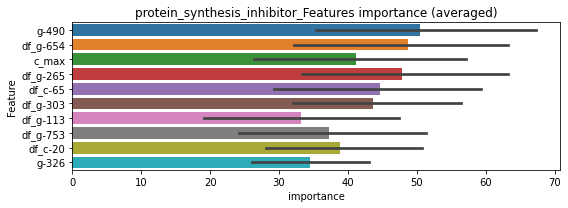

len(train_index) : 2406
len(valid_index) : 2406
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336714	valid_1's binary_logloss: 0.089299
[200]	training's binary_logloss: 0.00734621	valid_1's binary_logloss: 0.063146
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00271954	valid_1's binary_logloss: 0.059557


len(train_index) : 2406
len(valid_index) : 2406
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326949	valid_1's binary_logloss: 0.0857995
[200]	training's binary_logloss: 0.00709404	valid_1's binary_logloss: 0.0611795


protein_synthesis_inhibitor logloss: 0.05901513202759011


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00376974	valid_1's binary_logloss: 0.0584733


protein_tyrosine_kinase_inhibitor , len(trt) : 19


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064243	valid_1's binary_logloss: 0.0997864
[200]	training's binary_logloss: 0.0105933	valid_1's binary_logloss: 0.0272039
[300]	training's binary_logloss: 0.00344711	valid_1's binary_logloss: 0.012553
[400]	training's binary_logloss: 0.00189055	valid_1's binary_logloss: 0.00838477
[500]	training's binary_logloss: 0.00140699	valid_1's binary_logloss: 0.00682554
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00132993	valid_1's binary_logloss: 0.00649915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655693	valid_1's binary_logloss: 0.107126
[200]	training's binary_logloss: 0.0106415	valid_1's binary_logloss: 0.0334127
[300]	training's binary_logloss: 0.00339941	valid_1's binary_logloss: 0.0172188
[400]	training's binary_logloss: 0.00184285	valid_1's binary_logloss: 0.0131111
[500]	training's binary_logloss: 0.0013729	vali

1 / 3 AUC score:1.000
Threshold: 0.7306263192168243
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00229
p_label_rate: 0.00000 Vs.target_rate: 0.00086, Num_p_label: 0.0, conf_0:0.00229, conf_1:0.73063
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_1: 0.73
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_2: 0.69
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_3: 0.65
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_4: 0.61
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_5: 0.57
Num_p_label: 1.0, Expected: 3.4, Adj_threshold_6: 0.53
Num_p_label: 1.0, Expected: 3.4, Adj_threshold_7: 0.49
Num_p_label: 1.0, Expected: 3.4, Adj_threshold_8: 0.45
Num_p_label: 1.0, Expected: 3.4, Adj_threshold_9: 0.41
Num_p_label: 2.0, Expected: 3.4, Adj_threshold_10: 0.37
threshold:0.33, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064243	valid_1's binary_logloss: 0.0997864
[200]	training's binary_logloss: 0.0105933	valid_1's binary_logloss: 0.0272039
[300]	training's binary_logloss: 0.00344711	valid_1's binary_logloss: 0.012553
[400]	training's binary_logloss: 0.00189055	valid_1's binary_logloss: 0.00838477
[500]	training's binary_logloss: 0.00140699	valid_1's binary_logloss: 0.00682554
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00132993	valid_1's binary_logloss: 0.00649915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655693	valid_1's binary_logloss: 0.107126
[200]	training's binary_logloss: 0.0106415	valid_1's binary_logloss: 0.0334127
[300]	training's binary_logloss: 0.00339941	valid_1's binary_logloss: 0.0172188
[400]	training's binary_logloss: 0.00184285	valid_1's binary_logloss: 0.0131111
[500]	training's binary_logloss: 0.0013729	vali

2 / 3 AUC score:1.000
Threshold: 0.3306263192168242
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/998
30th percentile: 0.00229
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00229, conf_1:0.33942
threshold:0.33, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633862	valid_1's binary_logloss: 0.107992
[200]	training's binary_logloss: 0.0105677	valid_1's binary_logloss: 0.0308313
[300]	training's binary_logloss: 0.00342751	valid_1's binary_logloss: 0.0143262
[400]	training's binary_logloss: 0.0018626	valid_1's binary_logloss: 0.00955467
[500]	training's binary_logloss: 0.00140644	valid_1's binary_logloss: 0.00785938
[600]	training's binary_logloss: 0.00129379	valid_1's binary_logloss: 0.00740566
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00129379	valid_1's binary_logloss: 0.00740566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626482	valid_1's binary_logloss: 0.103268
[200]	training's binary_logloss: 0.0105703	valid_1's binary_logloss: 0.0300742
[300]	training's binary_logloss: 0.00343194	valid_1's binary_logloss: 0.0146232
[400]	training's binary_logloss: 0.00184489	va

3 / 3 AUC score:1.000
Threshold: 0.3306263192168242
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
30th percentile: 0.00235
p_label_rate: 0.00025 Vs.target_rate: 0.00086, Num_p_label: 1.0, conf_0:0.00235, conf_1:0.33063
Num_p_label: 1.0, Expected: 3.4, Adj_threshold_1: 0.33
Num_p_label: 2.0, Expected: 3.4, Adj_threshold_2: 0.29
Num_p_label: 4.0, Expected: 3.4, Adj_threshold_3: 0.25
threshold:0.25, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4980, y_label_rate: 0.10120


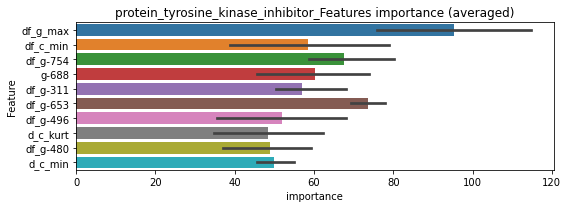

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161502	valid_1's binary_logloss: 0.023017
[200]	training's binary_logloss: 0.0019458	valid_1's binary_logloss: 0.00631298
[300]	training's binary_logloss: 0.000571064	valid_1's binary_logloss: 0.0043062
[400]	training's binary_logloss: 0.000310839	valid_1's binary_logloss: 0.00400086
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00032026	valid_1's binary_logloss: 0.00399083


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147098	valid_1's binary_logloss: 0.0276459
[200]	training's binary_logloss: 0.00176514	valid_1's binary_logloss: 0.011031
[300]	training's binary_logloss: 0.000538747	valid_1's binary_logloss: 0.00869691
[400]	training's binary_logloss: 0.000294854	valid_1's binary_logloss: 0.0083355
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000305457	valid_1's binary_logloss: 0.00831677


protein_tyrosine_kinase_inhibitor logloss: 0.006153796990693685
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118859	valid_1's binary_logloss: 0.257221
[200]	training's binary_logloss: 0.0302246	valid_1's binary_logloss: 0.154676
[300]	training's binary_logloss: 0.0103779	valid_1's binary_logloss: 0.115132
[400]	training's binary_logloss: 0.00503774	valid_1's binary_logloss: 0.0971983
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00348621	valid_1's binary_logloss: 0.0910997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11714	valid_1's binary_logloss: 0.265411
[200]	training's binary_logloss: 0.0293102	valid_1's binary_logloss: 0.161376
[300]	training's binary_logloss: 0.0100234	valid_1's binary_logloss: 0.12302
[400]	training's binary_logloss: 0.00490147	valid_1's binary_logloss: 0.110668


1 / 3 AUC score:0.992
Threshold: 0.36961785418350085
Remove_noisy_labels: 32 → positive_corect_labels: 484/968


Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00418225	valid_1's binary_logloss: 0.108397


30th percentile: 0.02104
p_label_rate: 0.01858 Vs.target_rate: 0.00246, Num_p_label: 74.0, conf_0:0.02104, conf_1:0.42552
Num_p_label: 74.0, Expected: 9.8, Adj_threshold_1: 0.37
Num_p_label: 51.0, Expected: 9.8, Adj_threshold_2: 0.41
Num_p_label: 37.0, Expected: 9.8, Adj_threshold_3: 0.45
Num_p_label: 27.0, Expected: 9.8, Adj_threshold_4: 0.49
Num_p_label: 19.0, Expected: 9.8, Adj_threshold_5: 0.53
Num_p_label: 13.0, Expected: 9.8, Adj_threshold_6: 0.57
threshold:0.57, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114089	valid_1's binary_logloss: 0.224509
[200]	training's binary_logloss: 0.0280571	valid_1's binary_logloss: 0.11397
[300]	training's binary_logloss: 0.00956841	valid_1's binary_logloss: 0.0733118
[400]	training's binary_logloss: 0.00474902	valid_1's binary_logloss: 0.0563498
[500]	training's binary_logloss: 0.00307444	valid_1's binary_logloss: 0.0489767
[600]	training's binary_logloss: 0.00237594	valid_1's binary_logloss: 0.0446326
[700]	training's binary_logloss: 0.00206606	valid_1's binary_logloss: 0.042568
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.00201891	valid_1's binary_logloss: 0.0422579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116224	valid_1's binary_logloss: 0.235432
[200]	training's binary_logloss: 0.0288731	valid_1's binary_logloss: 0.121638
[300]	training's binary_logloss: 0.00983606	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.5696178541835009
Remove_noisy_labels: 10 → positive_corect_labels: 476.0/958
30th percentile: 0.01248
p_label_rate: 0.00628 Vs.target_rate: 0.00246, Num_p_label: 25.0, conf_0:0.01248, conf_1:0.56962
threshold:0.57, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:476.0/958, y_label_rate: 0.49687
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116629	valid_1's binary_logloss: 0.217367
[200]	training's binary_logloss: 0.0282009	valid_1's binary_logloss: 0.101979
[300]	training's binary_logloss: 0.00967858	valid_1's binary_logloss: 0.0637618
[400]	training's binary_logloss: 0.00475995	valid_1's binary_logloss: 0.048469
[500]	training's binary_logloss: 0.00306651	valid_1's binary_logloss: 0.0414472
[600]	training's binary_logloss: 0.00235172	valid_1's binary_logloss: 0.0371765
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00230346	valid_1's binary_logloss: 0.036745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109842	valid_1's binary_logloss: 0.241792
[200]	training's binary_logloss: 0.0260684	valid_1's binary_logloss: 0.150633
[300]	training's binary_logloss: 0.00882766	valid_1's binary_logloss: 0.123297
[400]	training's binary_logloss: 0.00438578	valid_1's bi

3 / 3 AUC score:0.992
Threshold: 0.5696178541835009
Remove_noisy_labels: 13 → positive_corect_labels: 463.0/945


Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00347365	valid_1's binary_logloss: 0.110317


30th percentile: 0.01556
p_label_rate: 0.00703 Vs.target_rate: 0.00246, Num_p_label: 28.0, conf_0:0.01556, conf_1:0.56962
threshold:0.57, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:491.0/4927, y_label_rate: 0.09965


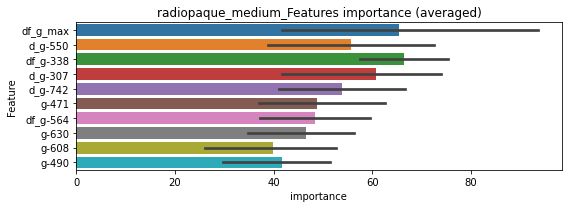

len(train_index) : 2463
len(valid_index) : 2464
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318747	valid_1's binary_logloss: 0.0676127
[200]	training's binary_logloss: 0.00607222	valid_1's binary_logloss: 0.0368878
[300]	training's binary_logloss: 0.00178025	valid_1's binary_logloss: 0.0311215
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00188729	valid_1's binary_logloss: 0.0310135


len(train_index) : 2464
len(valid_index) : 2463
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297377	valid_1's binary_logloss: 0.0811767
[200]	training's binary_logloss: 0.00555638	valid_1's binary_logloss: 0.0574447


radiopaque_medium logloss: 0.042128713296963695


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00211994	valid_1's binary_logloss: 0.0532485


raf_inhibitor , len(trt) : 223


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199094	valid_1's binary_logloss: 0.549468
[200]	training's binary_logloss: 0.0726381	valid_1's binary_logloss: 0.503449
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0497657	valid_1's binary_logloss: 0.490861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211403	valid_1's binary_logloss: 0.536375
[200]	training's binary_logloss: 0.078361	valid_1's binary_logloss: 0.48266
[300]	training's binary_logloss: 0.032777	valid_1's binary_logloss: 0.456077


1 / 3 AUC score:0.841
Threshold: 0.48406035027116556
Remove_noisy_labels: 240 → positive_corect_labels: 380/760
30th percentile: 0.27519


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0180567	valid_1's binary_logloss: 0.445029


p_label_rate: 0.18609 Vs.target_rate: 0.00821, Num_p_label: 741.0, conf_0:0.27519, conf_1:0.50314
Num_p_label: 741.0, Expected: 32.7, Adj_threshold_1: 0.48
Num_p_label: 496.0, Expected: 32.7, Adj_threshold_2: 0.52
Num_p_label: 325.0, Expected: 32.7, Adj_threshold_3: 0.56
Num_p_label: 186.0, Expected: 32.7, Adj_threshold_4: 0.60
Num_p_label: 103.0, Expected: 32.7, Adj_threshold_5: 0.64
Num_p_label: 58.0, Expected: 32.7, Adj_threshold_6: 0.68
Num_p_label: 23.0, Expected: 32.7, Adj_threshold_7: 0.72
threshold:0.72, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:380.0/760, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185537	valid_1's binary_logloss: 0.496362
[200]	training's binary_logloss: 0.0638407	valid_1's binary_logloss: 0.431122
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0386222	valid_1's binary_logloss: 0.405251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179136	valid_1's binary_logloss: 0.481934
[200]	training's binary_logloss: 0.0617891	valid_1's binary_logloss: 0.41208
[300]	training's binary_logloss: 0.0242185	valid_1's binary_logloss: 0.391313
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0202405	valid_1's binary_logloss: 0.388543


2 / 3 AUC score:0.899
Threshold: 0.7240603502711658
Remove_noisy_labels: 142 → positive_corect_labels: 252.0/618
30th percentile: 0.22682
p_label_rate: 0.02461 Vs.target_rate: 0.00821, Num_p_label: 98.0, conf_0:0.22682, conf_1:0.72406
threshold:0.72, positive p_label:98.0/3982, p_label_rate: 0.02461
positive y_label:252.0/618, y_label_rate: 0.40777
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15874	valid_1's binary_logloss: 0.439078
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0586178	valid_1's binary_logloss: 0.372524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16206	valid_1's binary_logloss: 0.43437
[200]	training's binary_logloss: 0.0530486	valid_1's binary_logloss: 0.371486


3 / 3 AUC score:0.921
Threshold: 0.7240603502711658
Remove_noisy_labels: 126 → positive_corect_labels: 128.0/492
30th percentile: 0.14155
p_label_rate: 0.00201 Vs.target_rate: 0.00821, Num_p_label: 8.0, conf_0:0.14155, conf_1:0.72406
Num_p_label: 8.0, Expected: 32.7, Adj_threshold_1: 0.72


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0369434	valid_1's binary_logloss: 0.356594


Num_p_label: 19.0, Expected: 32.7, Adj_threshold_2: 0.68
Num_p_label: 32.0, Expected: 32.7, Adj_threshold_3: 0.64
threshold:0.64, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:160.0/4474, y_label_rate: 0.03576


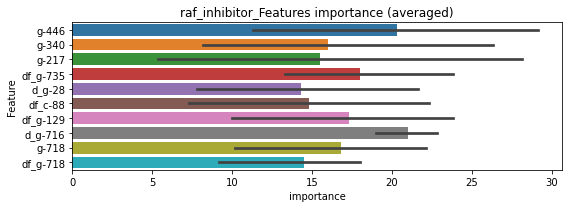

len(train_index) : 2237
len(valid_index) : 2237
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2237
len(valid_index) : 2237
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[88]	training's binary_logloss: 0.0191498	valid_1's binary_logloss: 0.105437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171039	valid_1's binary_logloss: 0.104882


raf_inhibitor logloss: 0.1051430678016206
ras_gtpase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[98]	training's binary_logloss: 0.0177201	valid_1's binary_logloss: 0.104849
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527839	valid_1's binary_logloss: 0.07947
[200]	training's binary_logloss: 0.00737989	valid_1's binary_logloss: 0.0191959
[300]	training's binary_logloss: 0.00235254	valid_1's binary_logloss: 0.0092974
[400]	training's binary_logloss: 0.00136952	valid_1's binary_logloss: 0.00680071
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0011731	valid_1's binary_logloss: 0.00613099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525408	valid_1's binary_logloss: 0.0752086
[200]	training's binary_logloss: 0.00743067	valid_1's binary_logloss: 0.018282
[300]	training's binary_logloss: 0.00233068	valid_1's binary_logloss: 0.00887197
[400]	training's binary_logloss: 0.00134495	valid_1's binary_logloss: 0.00627403
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00117074	valid_1's binary_logloss: 0.00563743


1 / 3 AUC score:1.000
Threshold: 0.3846685242602139
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00093
p_label_rate: 0.00251 Vs.target_rate: 0.00055, Num_p_label: 10.0, conf_0:0.00093, conf_1:0.46092
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_1: 0.38
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_2: 0.42
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_3: 0.46
threshold:0.46, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527839	valid_1's binary_logloss: 0.07947
[200]	training's binary_logloss: 0.00737989	valid_1's binary_logloss: 0.0191959
[300]	training's binary_logloss: 0.00235254	valid_1's binary_logloss: 0.0092974
[400]	training's binary_logloss: 0.00136952	valid_1's binary_logloss: 0.00680071
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0011731	valid_1's binary_logloss: 0.00613099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525408	valid_1's binary_logloss: 0.0752086
[200]	training's binary_logloss: 0.00743067	valid_1's binary_logloss: 0.018282
[300]	training's binary_logloss: 0.00233068	valid_1's binary_logloss: 0.00887197
[400]	training's binary_logloss: 0.00134495	valid_1's binary_logloss: 0.00627403
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00117074	valid_1's binary_logloss: 0.00563743


2 / 3 AUC score:1.000
Threshold: 0.4646685242602139
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00093
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00093, conf_1:0.46467
threshold:0.46, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527839	valid_1's binary_logloss: 0.07947
[200]	training's binary_logloss: 0.00737989	valid_1's binary_logloss: 0.0191959
[300]	training's binary_logloss: 0.00235254	valid_1's binary_logloss: 0.0092974
[400]	training's binary_logloss: 0.00136952	valid_1's binary_logloss: 0.00680071
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0011731	valid_1's binary_logloss: 0.00613099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525408	valid_1's binary_logloss: 0.0752086
[200]	training's binary_logloss: 0.00743067	valid_1's binary_logloss: 0.018282
[300]	training's binary_logloss: 0.00233068	valid_1's binary_logloss: 0.00887197
[400]	training's binary_logloss: 0.00134495	valid_1's binary_logloss: 0.00627403
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00117074	valid_1's binary_logloss: 0.00563743


3 / 3 AUC score:1.000
Threshold: 0.4646685242602139
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00093
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00093, conf_1:0.46467
threshold:0.46, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


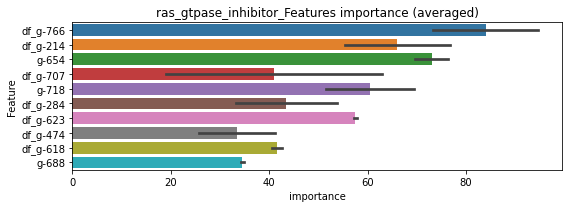

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012231	valid_1's binary_logloss: 0.0194441
[200]	training's binary_logloss: 0.00131813	valid_1's binary_logloss: 0.00790466


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ras_gtpase_inhibitor=================================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00083454	valid_1's binary_logloss: 0.0072717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122961	valid_1's binary_logloss: 0.0186406
[200]	training's binary_logloss: 0.00129506	valid_1's binary_logloss: 0.00455063
[300]	training's binary_logloss: 0.000391588	valid_1's binary_logloss: 0.00309443


ras_gtpase_inhibitor logloss: 0.005120662073801002


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000289802	valid_1's binary_logloss: 0.00296962


retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128733	valid_1's binary_logloss: 0.297108
[200]	training's binary_logloss: 0.0336279	valid_1's binary_logloss: 0.183758
[300]	training's binary_logloss: 0.0119361	valid_1's binary_logloss: 0.14222
[400]	training's binary_logloss: 0.00578651	valid_1's binary_logloss: 0.123494
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.0042593	valid_1's binary_logloss: 0.116983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132924	valid_1's binary_logloss: 0.282071
[200]	training's binary_logloss: 0.0356542	valid_1's binary_logloss: 0.165653
[300]	training's binary_logloss: 0.0125698	valid_1's binary_logloss: 0.12242
[400]	training's binary_logloss: 0.00603247	valid_1's binary_logloss: 0.103463
[500]	training's binary_logloss: 0.00377247	valid_1's binary_logloss: 0.0943194
Early stopping, best iteration is:
[585]	training's binary_logl

1 / 3 AUC score:0.994
Threshold: 0.6487894365744364
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentile: 0.03119
p_label_rate: 0.00352 Vs.target_rate: 0.00291, Num_p_label: 14.0, conf_0:0.03119, conf_1:0.64879
threshold:0.65, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130963	valid_1's binary_logloss: 0.266298
[200]	training's binary_logloss: 0.0349488	valid_1's binary_logloss: 0.155723
[300]	training's binary_logloss: 0.0122565	valid_1's binary_logloss: 0.115569
[400]	training's binary_logloss: 0.00592248	valid_1's binary_logloss: 0.0964019
[500]	training's binary_logloss: 0.00372702	valid_1's binary_logloss: 0.0875577
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00298679	valid_1's binary_logloss: 0.0837747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130975	valid_1's binary_logloss: 0.274273
[200]	training's binary_logloss: 0.0342271	valid_1's binary_logloss: 0.160242
[300]	training's binary_logloss: 0.011847	valid_1's binary_logloss: 0.117712
[400]	training's binary_logloss: 0.00580601	valid_1's binary_logloss: 0.102097
[500]	training's binary_logloss: 0.0036772	valid_1's binary

2 / 3 AUC score:0.994
Threshold: 0.6487894365744364
Remove_noisy_labels: 25 → positive_corect_labels: 468.0/953
30th percentile: 0.02277
p_label_rate: 0.00829 Vs.target_rate: 0.00291, Num_p_label: 33.0, conf_0:0.02277, conf_1:0.64879
threshold:0.65, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:468.0/953, y_label_rate: 0.49108
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124368	valid_1's binary_logloss: 0.26237
[200]	training's binary_logloss: 0.0314866	valid_1's binary_logloss: 0.154405
[300]	training's binary_logloss: 0.0110313	valid_1's binary_logloss: 0.11676
[400]	training's binary_logloss: 0.00541478	valid_1's binary_logloss: 0.101335
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00432932	valid_1's binary_logloss: 0.0989898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131987	valid_1's binary_logloss: 0.269086
[200]	training's binary_logloss: 0.034742	valid_1's binary_logloss: 0.15586
[300]	training's binary_logloss: 0.0120773	valid_1's binary_logloss: 0.109625
[400]	training's binary_logloss: 0.00582849	valid_1's binary_logloss: 0.0913615
[500]	training's binary_logloss: 0.00364688	valid_1's binary_logloss: 0.0820567
[600]	training's binary_logloss: 0.00270641	valid_1's binary_l

3 / 3 AUC score:0.996
Threshold: 0.6487894365744364
Remove_noisy_labels: 24 → positive_corect_labels: 446.0/929
30th percentile: 0.02331
p_label_rate: 0.00728 Vs.target_rate: 0.00291, Num_p_label: 29.0, conf_0:0.02331, conf_1:0.64879
threshold:0.65, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:475.0/4911, y_label_rate: 0.09672


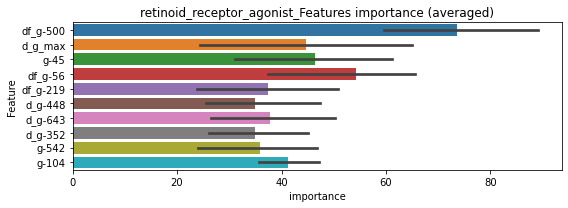

len(train_index) : 2455
len(valid_index) : 2456
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421667	valid_1's binary_logloss: 0.0931651
[200]	training's binary_logloss: 0.00892729	valid_1's binary_logloss: 0.0587374
[300]	training's binary_logloss: 0.00245252	valid_1's binary_logloss: 0.0509252
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00132469	valid_1's binary_logloss: 0.0488442


len(train_index) : 2456
len(valid_index) : 2455
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414918	valid_1's binary_logloss: 0.0957829
[200]	training's binary_logloss: 0.00880181	valid_1's binary_logloss: 0.0582972
[300]	training's binary_logloss: 0.00237621	valid_1's binary_logloss: 0.0482085
[400]	training's binary_logloss: 0.00103787	valid_1's binary_logloss: 0.0457411
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00109719	valid_1's binary_logloss: 0.0454318


retinoid_receptor_agonist logloss: 0.04713834436575626
retinoid_receptor_antagonist , len(trt) : 6


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359307	valid_1's binary_logloss: 0.0494246
[200]	training's binary_logloss: 0.00404559	valid_1's binary_logloss: 0.0107762
[300]	training's binary_logloss: 0.00129745	valid_1's binary_logloss: 0.00572355
[400]	training's binary_logloss: 0.000833009	valid_1's binary_logloss: 0.00418403
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000773935	valid_1's binary_logloss: 0.00391675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352944	valid_1's binary_logloss: 0.0418845
[200]	training's binary_logloss: 0.00396181	valid_1's binary_logloss: 0.00731182
[300]	training's binary_logloss: 0.00127356	valid_1's binary_logloss: 0.00297087
[400]	training's binary_logloss: 0.000831162	valid_1's binary_logloss: 0.0020784
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000762901	valid_1's binary_logloss: 0.00189238


1 / 3 AUC score:1.000
Threshold: 0.7224634611280027
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00044
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00044, conf_1:0.72246
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.72
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.68
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.64
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.60
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_5: 0.56
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_6: 0.52
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_7: 0.48
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_8: 0.44
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_9: 0.40
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_10: 0.36
threshold:0.32, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359307	valid_1's binary_logloss: 0.0494246
[200]	training's binary_logloss: 0.00404559	valid_1's binary_logloss: 0.0107762
[300]	training's binary_logloss: 0.00129745	valid_1's binary_logloss: 0.00572355
[400]	training's binary_logloss: 0.000833009	valid_1's binary_logloss: 0.00418403
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000773935	valid_1's binary_logloss: 0.00391675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352944	valid_1's binary_logloss: 0.0418845
[200]	training's binary_logloss: 0.00396181	valid_1's binary_logloss: 0.00731182
[300]	training's binary_logloss: 0.00127356	valid_1's binary_logloss: 0.00297087
[400]	training's binary_logloss: 0.000831162	valid_1's binary_logloss: 0.0020784
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000762901	valid_1's binary_logloss: 0.00189238


2 / 3 AUC score:1.000
Threshold: 0.32246346112800267
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00044
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00044, conf_1:0.32246
threshold:0.32, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364293	valid_1's binary_logloss: 0.0505968
[200]	training's binary_logloss: 0.00415126	valid_1's binary_logloss: 0.0100304
[300]	training's binary_logloss: 0.0013207	valid_1's binary_logloss: 0.00431311
[400]	training's binary_logloss: 0.000842733	valid_1's binary_logloss: 0.00305281
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000767474	valid_1's binary_logloss: 0.00283281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356434	valid_1's binary_logloss: 0.040749
[200]	training's binary_logloss: 0.00396047	valid_1's binary_logloss: 0.00646259
[300]	training's binary_logloss: 0.0012815	valid_1's binary_logloss: 0.00268084
[400]	training's binary_logloss: 0.000831818	valid_1's binary_logloss: 0.00197037
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000760179	valid_1's binary_logloss: 0.00180984


3 / 3 AUC score:1.000
Threshold: 0.32246346112800267
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
30th percentile: 0.00045
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00045, conf_1:0.32246
threshold:0.32, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4980, y_label_rate: 0.10060


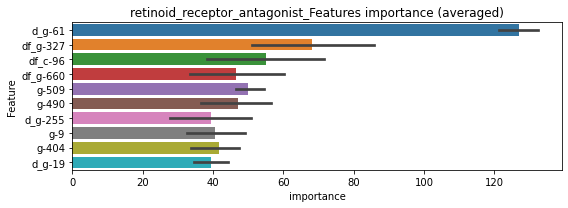

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100304	valid_1's binary_logloss: 0.0129437
[200]	training's binary_logloss: 0.000868018	valid_1's binary_logloss: 0.00365025


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000295995	valid_1's binary_logloss: 0.00318924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102664	valid_1's binary_logloss: 0.0109765
[200]	training's binary_logloss: 0.000894323	valid_1's binary_logloss: 0.00126583
[300]	training's binary_logloss: 0.00024967	valid_1's binary_logloss: 0.000452853
[400]	training's binary_logloss: 0.000154288	valid_1's binary_logloss: 0.000309181


retinoid_receptor_antagonist logloss: 0.0017407516859685949
rho_associated_kinase_inhibitor , len(trt) : 35


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000143533	valid_1's binary_logloss: 0.000292268


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912045	valid_1's binary_logloss: 0.180459
[200]	training's binary_logloss: 0.01884	valid_1's binary_logloss: 0.083184
[300]	training's binary_logloss: 0.00609977	valid_1's binary_logloss: 0.0542775
[400]	training's binary_logloss: 0.00307918	valid_1's binary_logloss: 0.0446343
[500]	training's binary_logloss: 0.00205746	valid_1's binary_logloss: 0.0408296
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00189321	valid_1's binary_logloss: 0.0395446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938743	valid_1's binary_logloss: 0.189001
[200]	training's binary_logloss: 0.0198944	valid_1's binary_logloss: 0.100113
[300]	training's binary_logloss: 0.00637023	valid_1's binary_logloss: 0.0711291


1 / 3 AUC score:0.997
Threshold: 0.5492096269082061
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.00884
p_label_rate: 0.00352 Vs.target_rate: 0.00157, Num_p_label: 14.0, conf_0:0.00884, conf_1:0.54921
threshold:0.55, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00432143	valid_1's binary_logloss: 0.0661238


positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894995	valid_1's binary_logloss: 0.164687
[200]	training's binary_logloss: 0.0184702	valid_1's binary_logloss: 0.0715309
[300]	training's binary_logloss: 0.00596812	valid_1's binary_logloss: 0.0431587
[400]	training's binary_logloss: 0.00307392	valid_1's binary_logloss: 0.0338783
[500]	training's binary_logloss: 0.00207651	valid_1's binary_logloss: 0.0294852
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.0017406	valid_1's binary_logloss: 0.0273659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916112	valid_1's binary_logloss: 0.167582
[200]	training's binary_logloss: 0.0190255	valid_1's binary_logloss: 0.0738885
[300]	training's binary_logloss: 0.00605382	valid_1's binary_logloss: 0.0437909
[400]	training's binary_logloss: 0.00309743	valid_1's binary_logloss: 0.0328616
[500]	training's binary_logloss: 0.0020767	valid_1

2 / 3 AUC score:1.000
Threshold: 0.5492096269082061
Remove_noisy_labels: 3 → positive_corect_labels: 492.0/985
30th percentile: 0.00454
p_label_rate: 0.00301 Vs.target_rate: 0.00157, Num_p_label: 12.0, conf_0:0.00454, conf_1:0.54921
threshold:0.55, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:492.0/985, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856262	valid_1's binary_logloss: 0.169211
[200]	training's binary_logloss: 0.0172392	valid_1's binary_logloss: 0.0806331
[300]	training's binary_logloss: 0.00559473	valid_1's binary_logloss: 0.0557416
[400]	training's binary_logloss: 0.00287864	valid_1's binary_logloss: 0.0479695
[500]	training's binary_logloss: 0.00197322	valid_1's binary_logloss: 0.0444957
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00188495	valid_1's binary_logloss: 0.0442338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906081	valid_1's binary_logloss: 0.154495
[200]	training's binary_logloss: 0.0188418	valid_1's binary_logloss: 0.0647346
[300]	training's binary_logloss: 0.0060514	valid_1's binary_logloss: 0.0384029
[400]	training's binary_logloss: 0.00309959	valid_1's binary_logloss: 0.0294279
[500]	training's binary_logloss: 0.002109	valid_1'

3 / 3 AUC score:0.999
Threshold: 0.5492096269082061
Remove_noisy_labels: 9 → positive_corect_labels: 486.0/976
30th percentile: 0.00472
p_label_rate: 0.00452 Vs.target_rate: 0.00157, Num_p_label: 18.0, conf_0:0.00472, conf_1:0.54921
threshold:0.55, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:504.0/4958, y_label_rate: 0.10165


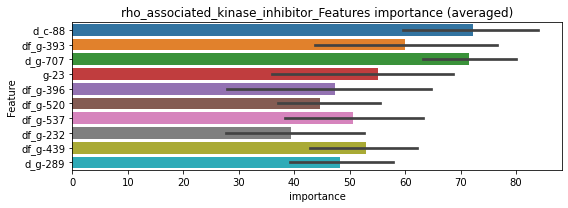

len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027477	valid_1's binary_logloss: 0.0537301
[200]	training's binary_logloss: 0.00427849	valid_1's binary_logloss: 0.0252516
[300]	training's binary_logloss: 0.00118883	valid_1's binary_logloss: 0.0202873
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000902433	valid_1's binary_logloss: 0.0198604


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261172	valid_1's binary_logloss: 0.0520173
[200]	training's binary_logloss: 0.00415108	valid_1's binary_logloss: 0.026373
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00190207	valid_1's binary_logloss: 0.0238034


rho_associated_kinase_inhibitor logloss: 0.021831882974567004
ribonucleoside_reductase_inhibitor , len(trt) : 37


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101091	valid_1's binary_logloss: 0.187796
[200]	training's binary_logloss: 0.0221604	valid_1's binary_logloss: 0.0820777
[300]	training's binary_logloss: 0.00715958	valid_1's binary_logloss: 0.0479354
[400]	training's binary_logloss: 0.00359328	valid_1's binary_logloss: 0.0372151
[500]	training's binary_logloss: 0.00236326	valid_1's binary_logloss: 0.0319504
[600]	training's binary_logloss: 0.0018711	valid_1's binary_logloss: 0.0290633
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00184323	valid_1's binary_logloss: 0.028792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976176	valid_1's binary_logloss: 0.210713
[200]	training's binary_logloss: 0.0206997	valid_1's binary_logloss: 0.0944336
[300]	training's binary_logloss: 0.00674479	valid_1's binary_logloss: 0.0579035
[400]	training's binary_logloss: 0.00339848	valid_1'

1 / 3 AUC score:0.999
Threshold: 0.2850030099820935
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00798
p_label_rate: 0.00979 Vs.target_rate: 0.00165, Num_p_label: 39.0, conf_0:0.00798, conf_1:0.38403
Num_p_label: 39.0, Expected: 6.6, Adj_threshold_1: 0.29
Num_p_label: 27.0, Expected: 6.6, Adj_threshold_2: 0.33
Num_p_label: 19.0, Expected: 6.6, Adj_threshold_3: 0.37
Num_p_label: 13.0, Expected: 6.6, Adj_threshold_4: 0.41
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_5: 0.45
Num_p_label: 6.0, Expected: 6.6, Adj_threshold_6: 0.49
threshold:0.49, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988364	valid_1's binary_logloss: 0.203409
[200]	training's binary_logloss: 0.0209505	valid_1's binary_logloss: 0.0913985
[300]	training's binary_logloss: 0.00679928	valid_1's binary_logloss: 0.0519402
[400]	training's binary_logloss: 0.00339712	valid_1's binary_logloss: 0.0403304
[500]	training's binary_logloss: 0.00227564	valid_1's binary_logloss: 0.0338401
[600]	training's binary_logloss: 0.00182898	valid_1's binary_logloss: 0.030836
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00179577	valid_1's binary_logloss: 0.0305488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097978	valid_1's binary_logloss: 0.184678
[200]	training's binary_logloss: 0.0211016	valid_1's binary_logloss: 0.0837995
[300]	training's binary_logloss: 0.00687163	valid_1's binary_logloss: 0.0511024
[400]	training's binary_logloss: 0.00345883	valid_1

2 / 3 AUC score:1.000
Threshold: 0.4850030099820934
Remove_noisy_labels: 3 → positive_corect_labels: 494.0/987
30th percentile: 0.00799
p_label_rate: 0.00226 Vs.target_rate: 0.00165, Num_p_label: 9.0, conf_0:0.00799, conf_1:0.48500
threshold:0.49, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:494.0/987, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948585	valid_1's binary_logloss: 0.195537
[200]	training's binary_logloss: 0.0199626	valid_1's binary_logloss: 0.0872837
[300]	training's binary_logloss: 0.00663987	valid_1's binary_logloss: 0.0545774
[400]	training's binary_logloss: 0.00338516	valid_1's binary_logloss: 0.0415077
[500]	training's binary_logloss: 0.00223456	valid_1's binary_logloss: 0.0346696
[600]	training's binary_logloss: 0.00183378	valid_1's binary_logloss: 0.0317085
Early stopping, best iteration is:
[638]	training's binary_logloss: 0.00177401	valid_1's binary_logloss: 0.0311357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964795	valid_1's binary_logloss: 0.177857
[200]	training's binary_logloss: 0.0212679	valid_1's binary_logloss: 0.0781759
[300]	training's binary_logloss: 0.006957	valid_1's binary_logloss: 0.0463256
[400]	training's binary_logloss: 0.00347975	valid_1

3 / 3 AUC score:1.000
Threshold: 0.4850030099820934
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/983
30th percentile: 0.00738
p_label_rate: 0.00402 Vs.target_rate: 0.00165, Num_p_label: 16.0, conf_0:0.00738, conf_1:0.48500
threshold:0.49, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:510.0/4965, y_label_rate: 0.10272


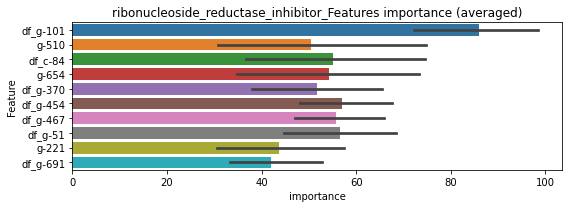

len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290574	valid_1's binary_logloss: 0.0601015
[200]	training's binary_logloss: 0.00472276	valid_1's binary_logloss: 0.0284841
[300]	training's binary_logloss: 0.00130684	valid_1's binary_logloss: 0.0228564
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000724656	valid_1's binary_logloss: 0.0219949


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291718	valid_1's binary_logloss: 0.0642258
[200]	training's binary_logloss: 0.0048357	valid_1's binary_logloss: 0.0306779
[300]	training's binary_logloss: 0.00132227	valid_1's binary_logloss: 0.024222
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00129594	valid_1's binary_logloss: 0.0241676


ribonucleoside_reductase_inhibitor logloss: 0.023080999229680724
rna_polymerase_inhibitor , len(trt) : 25


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791819	valid_1's binary_logloss: 0.133869
[200]	training's binary_logloss: 0.0146704	valid_1's binary_logloss: 0.0446774
[300]	training's binary_logloss: 0.0047181	valid_1's binary_logloss: 0.0248565
[400]	training's binary_logloss: 0.00248734	valid_1's binary_logloss: 0.0182695
[500]	training's binary_logloss: 0.00176679	valid_1's binary_logloss: 0.0156639
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00155701	valid_1's binary_logloss: 0.0145014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770079	valid_1's binary_logloss: 0.130624
[200]	training's binary_logloss: 0.0142191	valid_1's binary_logloss: 0.0431107
[300]	training's binary_logloss: 0.00462366	valid_1's binary_logloss: 0.0222096
[400]	training's binary_logloss: 0.00244096	valid_1's binary_logloss: 0.0152899
[500]	training's binary_logloss: 0.00172156	valid_

1 / 3 AUC score:1.000
Threshold: 0.5814830052794783
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00339
p_label_rate: 0.00000 Vs.target_rate: 0.00113, Num_p_label: 0.0, conf_0:0.00339, conf_1:0.58148
Num_p_label: 0.0, Expected: 4.5, Adj_threshold_1: 0.58
Num_p_label: 1.0, Expected: 4.5, Adj_threshold_2: 0.54
Num_p_label: 1.0, Expected: 4.5, Adj_threshold_3: 0.50
Num_p_label: 1.0, Expected: 4.5, Adj_threshold_4: 0.46
Num_p_label: 4.0, Expected: 4.5, Adj_threshold_5: 0.42
threshold:0.42, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791819	valid_1's binary_logloss: 0.133869
[200]	training's binary_logloss: 0.0146704	valid_1's binary_logloss: 0.0446774
[300]	training's binary_logloss: 0.0047181	valid_1's binary_logloss: 0.0248565
[400]	training's binary_logloss: 0.00248734	valid_1's binary_logloss: 0.0182695
[500]	training's binary_logloss: 0.00176679	valid_1's binary_logloss: 0.0156639
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00155701	valid_1's binary_logloss: 0.0145014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770079	valid_1's binary_logloss: 0.130624
[200]	training's binary_logloss: 0.0142191	valid_1's binary_logloss: 0.0431107
[300]	training's binary_logloss: 0.00462366	valid_1's binary_logloss: 0.0222096
[400]	training's binary_logloss: 0.00244096	valid_1's binary_logloss: 0.0152899
[500]	training's binary_logloss: 0.00172156	valid_

2 / 3 AUC score:1.000
Threshold: 0.42148300527947824
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00339
p_label_rate: 0.00100 Vs.target_rate: 0.00113, Num_p_label: 4.0, conf_0:0.00339, conf_1:0.42148
threshold:0.42, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753137	valid_1's binary_logloss: 0.127057
[200]	training's binary_logloss: 0.0140652	valid_1's binary_logloss: 0.0441037
[300]	training's binary_logloss: 0.00459375	valid_1's binary_logloss: 0.0247112
[400]	training's binary_logloss: 0.00245008	valid_1's binary_logloss: 0.018742
[500]	training's binary_logloss: 0.00173714	valid_1's binary_logloss: 0.0161217
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00156515	valid_1's binary_logloss: 0.0151623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757471	valid_1's binary_logloss: 0.13203
[200]	training's binary_logloss: 0.01404	valid_1's binary_logloss: 0.0416952
[300]	training's binary_logloss: 0.00456115	valid_1's binary_logloss: 0.0205286
[400]	training's binary_logloss: 0.00245245	valid_1's binary_logloss: 0.0141363
[500]	training's binary_logloss: 0.00172654	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.42148300527947824
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00358
p_label_rate: 0.00075 Vs.target_rate: 0.00113, Num_p_label: 3.0, conf_0:0.00358, conf_1:0.42148
threshold:0.42, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4981, y_label_rate: 0.10098


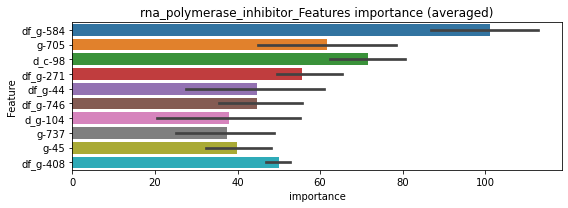

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194237	valid_1's binary_logloss: 0.0324871
[200]	training's binary_logloss: 0.00264344	valid_1's binary_logloss: 0.0104455
[300]	training's binary_logloss: 0.000746964	valid_1's binary_logloss: 0.00597562
[400]	training's binary_logloss: 0.000396933	valid_1's binary_logloss: 0.00516607
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000359285	valid_1's binary_logloss: 0.00508643


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190466	valid_1's binary_logloss: 0.0327274
[200]	training's binary_logloss: 0.00250406	valid_1's binary_logloss: 0.0104254
[300]	training's binary_logloss: 0.000735627	valid_1's binary_logloss: 0.00658673
[400]	training's binary_logloss: 0.000401101	valid_1's binary_logloss: 0.00573707
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000309532	valid_1's binary_logloss: 0.00550191


rna_polymerase_inhibitor logloss: 0.005294127670486253
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209278	valid_1's binary_logloss: 0.560539
[200]	training's binary_logloss: 0.0783947	valid_1's binary_logloss: 0.513281
[300]	training's binary_logloss: 0.0324631	valid_1's binary_logloss: 0.495451
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0200393	valid_1's binary_logloss: 0.487801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203733	valid_1's binary_logloss: 0.562419
[200]	training's binary_logloss: 0.0731724	valid_1's binary_logloss: 0.528787


1 / 3 AUC score:0.813
Threshold: 0.47087702632139683
Remove_noisy_labels: 264 → positive_corect_labels: 368/736
30th percentile: 0.26130
p_label_rate: 0.19864 Vs.target_rate: 0.00856, Num_p_label: 791.0, conf_0:0.26130, conf_1:0.49855
Num_p_label: 791.0, Expected: 34.1, Adj_threshold_1: 0.47
Num_p_label: 560.0, Expected: 34.1, Adj_threshold_2: 0.51
Num_p_label: 362.0, Expected: 34.1, Adj_threshold_3: 0.55
Num_p_label: 240.0, Expected: 34.1, Adj_threshold_4: 0.59
Num_p_label: 139.0, Expected: 34.1, Adj_threshold_5: 0.63


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0615097	valid_1's binary_logloss: 0.5267


Num_p_label: 78.0, Expected: 34.1, Adj_threshold_6: 0.67
Num_p_label: 42.0, Expected: 34.1, Adj_threshold_7: 0.71
threshold:0.71, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:368.0/736, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181851	valid_1's binary_logloss: 0.462572
[200]	training's binary_logloss: 0.0629404	valid_1's binary_logloss: 0.383428
[300]	training's binary_logloss: 0.0256809	valid_1's binary_logloss: 0.345546
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0160891	valid_1's binary_logloss: 0.329823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179472	valid_1's binary_logloss: 0.497758
[200]	training's binary_logloss: 0.0600314	valid_1's binary_logloss: 0.435476


2 / 3 AUC score:0.913
Threshold: 0.710877026321397
Remove_noisy_labels: 124 → positive_corect_labels: 260.0/612
30th percentile: 0.21782
p_label_rate: 0.05977 Vs.target_rate: 0.00856, Num_p_label: 238.0, conf_0:0.21782, conf_1:0.71088
Num_p_label: 238.0, Expected: 34.1, Adj_threshold_1: 0.71
Num_p_label: 149.0, Expected: 34.1, Adj_threshold_2: 0.75
Num_p_label: 98.0, Expected: 34.1, Adj_threshold_3: 0.79
Num_p_label: 53.0, Expected: 34.1, Adj_threshold_4: 0.83
Num_p_label: 21.0, Expected: 34.1, Adj_threshold_5: 0.87
threshold:0.87, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0431515	valid_1's binary_logloss: 0.425043


positive y_label:260.0/612, y_label_rate: 0.42484
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172868	valid_1's binary_logloss: 0.407358
[200]	training's binary_logloss: 0.0580982	valid_1's binary_logloss: 0.31313
[300]	training's binary_logloss: 0.0234356	valid_1's binary_logloss: 0.276566
[400]	training's binary_logloss: 0.011685	valid_1's binary_logloss: 0.25443
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0119684	valid_1's binary_logloss: 0.253813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160665	valid_1's binary_logloss: 0.41865
[200]	training's binary_logloss: 0.0525126	valid_1's binary_logloss: 0.344727
[300]	training's binary_logloss: 0.0208298	valid_1's binary_logloss: 0.310718


3 / 3 AUC score:0.952
Threshold: 0.8708770263213972
Remove_noisy_labels: 116 → positive_corect_labels: 144.0/496
30th percentile: 0.09802


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0151325	valid_1's binary_logloss: 0.299567


p_label_rate: 0.00502 Vs.target_rate: 0.00856, Num_p_label: 20.0, conf_0:0.09802, conf_1:0.87088
threshold:0.87, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:164.0/4478, y_label_rate: 0.03662


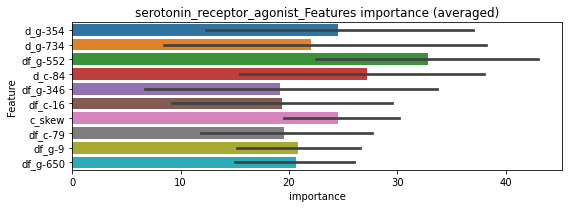

len(train_index) : 2239
len(valid_index) : 2239
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143782	valid_1's binary_logloss: 0.0976742


len(train_index) : 2239
len(valid_index) : 2239
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0096384	valid_1's binary_logloss: 0.0960061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150687	valid_1's binary_logloss: 0.102906
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.0170435	valid_1's binary_logloss: 0.102346


serotonin_receptor_agonist logloss: 0.09917621139096591
serotonin_receptor_antagonist , len(trt) : 404


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.39195	valid_1's binary_logloss: 0.669476
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.595
Threshold: 0.4955404614417035
Remove_noisy_labels: 424 → positive_corect_labels: 288/576
30th percentile: 0.46608
p_label_rate: 0.47966 Vs.target_rate: 0.01181, Num_p_label: 1910.0, conf_0:0.46608, conf_1:0.49554
Num_p_label: 1910.0, Expected: 47.0, Adj_threshold_1: 0.50
Num_p_label: 806.0, Expected: 47.0, Adj_threshold_2: 0.54
Num_p_label: 189.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 47.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.498861	valid_1's binary_logloss: 0.687169


positive y_label:288.0/576, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208057	valid_1's binary_logloss: 0.560999
[200]	training's binary_logloss: 0.0776365	valid_1's binary_logloss: 0.535592
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0697668	valid_1's binary_logloss: 0.534134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20919	valid_1's binary_logloss: 0.558073


2 / 3 AUC score:0.809
Threshold: 0.6155404614417036
Remove_noisy_labels: 148 → positive_corect_labels: 179.0/428
30th percentile: 0.38368
p_label_rate: 0.27875 Vs.target_rate: 0.01181, Num_p_label: 1110.0, conf_0:0.38368, conf_1:0.61554
Num_p_label: 1110.0, Expected: 47.0, Adj_threshold_1: 0.62
Num_p_label: 867.0, Expected: 47.0, Adj_threshold_2: 0.66
Num_p_label: 603.0, Expected: 47.0, Adj_threshold_3: 0.70
Num_p_label: 390.0, Expected: 47.0, Adj_threshold_4: 0.74
Num_p_label: 213.0, Expected: 47.0, Adj_threshold_5: 0.78
Num_p_label: 96.0, Expected: 47.0, Adj_threshold_6: 0.82
Num_p_label: 23.0, Expected: 47.0, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.131513	valid_1's binary_logloss: 0.535426


positive y_label:179.0/428, y_label_rate: 0.41822
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15421	valid_1's binary_logloss: 0.389498
[200]	training's binary_logloss: 0.0496634	valid_1's binary_logloss: 0.337395
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0448459	valid_1's binary_logloss: 0.331458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162644	valid_1's binary_logloss: 0.397874
[200]	training's binary_logloss: 0.0531001	valid_1's binary_logloss: 0.329097
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0329765	valid_1's binary_logloss: 0.312375


3 / 3 AUC score:0.940
Threshold: 0.8555404614417038
Remove_noisy_labels: 110 → positive_corect_labels: 70.0/318
30th percentile: 0.15703
p_label_rate: 0.04571 Vs.target_rate: 0.01181, Num_p_label: 182.0, conf_0:0.11159, conf_1:0.85554
Num_p_label: 182.0, Expected: 47.0, Adj_threshold_1: 0.86
Num_p_label: 88.0, Expected: 47.0, Adj_threshold_2: 0.90
Num_p_label: 30.0, Expected: 47.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:100.0/4300, y_label_rate: 0.02326


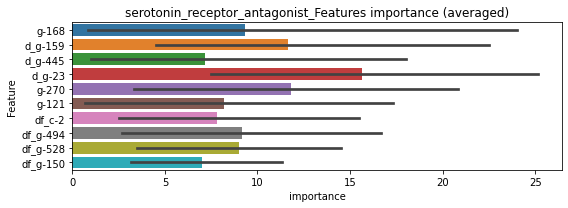

len(train_index) : 2150
len(valid_index) : 2150
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0078548	valid_1's binary_logloss: 0.0758343


len(train_index) : 2150
len(valid_index) : 2150
================================= fold 2/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0078548	valid_1's binary_logloss: 0.0758343
Training until validation scores don't improve for 10 rounds


serotonin_receptor_antagonist logloss: 0.07998679455688945
serotonin_reuptake_inhibitor , len(trt) : 44


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.0165592	valid_1's binary_logloss: 0.0841392
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101623	valid_1's binary_logloss: 0.206068
[200]	training's binary_logloss: 0.0233479	valid_1's binary_logloss: 0.1022
[300]	training's binary_logloss: 0.00793404	valid_1's binary_logloss: 0.0690046
[400]	training's binary_logloss: 0.00397406	valid_1's binary_logloss: 0.0537338
[500]	training's binary_logloss: 0.00260969	valid_1's binary_logloss: 0.047023
[600]	training's binary_logloss: 0.00207267	valid_1's binary_logloss: 0.0424268
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00205772	valid_1's binary_logloss: 0.0423108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103844	valid_1's binary_logloss: 0.219065
[200]	training's binary_logloss: 0.0238545	valid_1's binary_logloss: 0.113115
[300]	training's binary_logloss: 0.00795003	valid_1's binary_logloss: 0.0813959
[400]	training's binary_logloss: 0.00391268	valid_1's bi

1 / 3 AUC score:0.999
Threshold: 0.37941624957011055
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.00821
p_label_rate: 0.00904 Vs.target_rate: 0.00195, Num_p_label: 36.0, conf_0:0.00777, conf_1:0.39883
Num_p_label: 36.0, Expected: 7.8, Adj_threshold_1: 0.38
Num_p_label: 25.0, Expected: 7.8, Adj_threshold_2: 0.42
Num_p_label: 17.0, Expected: 7.8, Adj_threshold_3: 0.46
Num_p_label: 10.0, Expected: 7.8, Adj_threshold_4: 0.50
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106006	valid_1's binary_logloss: 0.203761
[200]	training's binary_logloss: 0.023773	valid_1's binary_logloss: 0.09438
[300]	training's binary_logloss: 0.00804317	valid_1's binary_logloss: 0.0589853
[400]	training's binary_logloss: 0.0040164	valid_1's binary_logloss: 0.044172
[500]	training's binary_logloss: 0.00261794	valid_1's binary_logloss: 0.0373292
[600]	training's binary_logloss: 0.00201619	valid_1's binary_logloss: 0.0338696
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00193496	valid_1's binary_logloss: 0.0332252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107141	valid_1's binary_logloss: 0.203598
[200]	training's binary_logloss: 0.0241602	valid_1's binary_logloss: 0.0938923
[300]	training's binary_logloss: 0.00811635	valid_1's binary_logloss: 0.0600704
[400]	training's binary_logloss: 0.00408673	valid_1's bi

2 / 3 AUC score:1.000
Threshold: 0.4994162495701105
Remove_noisy_labels: 5 → positive_corect_labels: 488.0/979
30th percentile: 0.01000


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00293065	valid_1's binary_logloss: 0.0441485


p_label_rate: 0.00552 Vs.target_rate: 0.00195, Num_p_label: 22.0, conf_0:0.01000, conf_1:0.49942
threshold:0.50, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:488.0/979, y_label_rate: 0.49847
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101695	valid_1's binary_logloss: 0.196171
[200]	training's binary_logloss: 0.0231426	valid_1's binary_logloss: 0.0908757
[300]	training's binary_logloss: 0.00773056	valid_1's binary_logloss: 0.0594476
[400]	training's binary_logloss: 0.00389959	valid_1's binary_logloss: 0.0477069
[500]	training's binary_logloss: 0.00258075	valid_1's binary_logloss: 0.0418872
[600]	training's binary_logloss: 0.00201036	valid_1's binary_logloss: 0.038256
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00189375	valid_1's binary_logloss: 0.0375227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102854	valid_1's binary_logloss: 0.193781
[200]	training's binary_logloss: 0.0239954	valid_1's binary_logloss: 0.0907917
[300]	training's binary_logloss: 0.00801677	valid_1's binary_logloss: 0.0561943
[400]	training's binary_logloss: 0.00399522	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.4994162495701105
Remove_noisy_labels: 6 → positive_corect_labels: 485.0/973
30th percentile: 0.00813
p_label_rate: 0.00552 Vs.target_rate: 0.00195, Num_p_label: 22.0, conf_0:0.00751, conf_1:0.49942
threshold:0.50, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:507.0/4955, y_label_rate: 0.10232


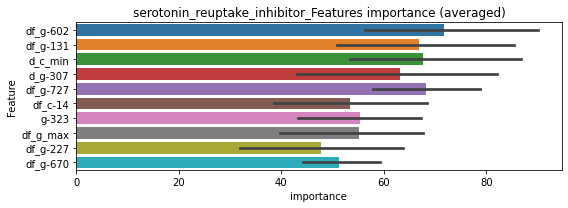

len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263795	valid_1's binary_logloss: 0.0597876
[200]	training's binary_logloss: 0.00454641	valid_1's binary_logloss: 0.0342302
[300]	training's binary_logloss: 0.00132937	valid_1's binary_logloss: 0.0286153
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000730023	valid_1's binary_logloss: 0.027121


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267374	valid_1's binary_logloss: 0.0544392
[200]	training's binary_logloss: 0.00446897	valid_1's binary_logloss: 0.0274796
[300]	training's binary_logloss: 0.00133205	valid_1's binary_logloss: 0.022863
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00125359	valid_1's binary_logloss: 0.022706


serotonin_reuptake_inhibitor logloss: 0.02491395992828035
sigma_receptor_agonist , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978201	valid_1's binary_logloss: 0.186351
[200]	training's binary_logloss: 0.0211224	valid_1's binary_logloss: 0.087912
[300]	training's binary_logloss: 0.00697882	valid_1's binary_logloss: 0.0600282
[400]	training's binary_logloss: 0.00352118	valid_1's binary_logloss: 0.0522664
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00312201	valid_1's binary_logloss: 0.0514964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975617	valid_1's binary_logloss: 0.189222
[200]	training's binary_logloss: 0.0208738	valid_1's binary_logloss: 0.0812083
[300]	training's binary_logloss: 0.00678241	valid_1's binary_logloss: 0.0474019
[400]	training's binary_logloss: 0.00341243	valid_1's binary_logloss: 0.0348347
[500]	training's binary_logloss: 0.0022541	valid_1's binary_logloss: 0.0301315
[600]	training's binary_logloss: 0.00182126	valid_1

1 / 3 AUC score:0.997
Threshold: 0.4389007558044653
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00974
p_label_rate: 0.00176 Vs.target_rate: 0.00161, Num_p_label: 7.0, conf_0:0.00974, conf_1:0.43890
threshold:0.44, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968568	valid_1's binary_logloss: 0.183061
[200]	training's binary_logloss: 0.0209439	valid_1's binary_logloss: 0.07761
[300]	training's binary_logloss: 0.00673846	valid_1's binary_logloss: 0.0445505
[400]	training's binary_logloss: 0.00337274	valid_1's binary_logloss: 0.0318321
[500]	training's binary_logloss: 0.00226295	valid_1's binary_logloss: 0.0263571
[600]	training's binary_logloss: 0.00180922	valid_1's binary_logloss: 0.0237859
Early stopping, best iteration is:
[660]	training's binary_logloss: 0.00172761	valid_1's binary_logloss: 0.0233222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962167	valid_1's binary_logloss: 0.189716
[200]	training's binary_logloss: 0.020299	valid_1's binary_logloss: 0.0822206
[300]	training's binary_logloss: 0.00668943	valid_1's binary_logloss: 0.0489452
[400]	training's binary_logloss: 0.00340888	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.4389007558044653
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/990
30th percentile: 0.00719
p_label_rate: 0.00126 Vs.target_rate: 0.00161, Num_p_label: 5.0, conf_0:0.00719, conf_1:0.43890
threshold:0.44, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943321	valid_1's binary_logloss: 0.199313
[200]	training's binary_logloss: 0.0200623	valid_1's binary_logloss: 0.105961
[300]	training's binary_logloss: 0.00643537	valid_1's binary_logloss: 0.0693478
[400]	training's binary_logloss: 0.00329129	valid_1's binary_logloss: 0.0558369
[500]	training's binary_logloss: 0.00222515	valid_1's binary_logloss: 0.0510153
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00219766	valid_1's binary_logloss: 0.0507977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960004	valid_1's binary_logloss: 0.189401
[200]	training's binary_logloss: 0.0202958	valid_1's binary_logloss: 0.0837412
[300]	training's binary_logloss: 0.00655776	valid_1's binary_logloss: 0.0519508
[400]	training's binary_logloss: 0.00332957	valid_1's binary_logloss: 0.0415983
[500]	training's binary_logloss: 0.002227	valid_1'

3 / 3 AUC score:0.999
Threshold: 0.4389007558044653
Remove_noisy_labels: 8 → positive_corect_labels: 487.0/982
30th percentile: 0.00794
p_label_rate: 0.00075 Vs.target_rate: 0.00161, Num_p_label: 3.0, conf_0:0.00794, conf_1:0.43890
threshold:0.44, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:490.0/4964, y_label_rate: 0.09871


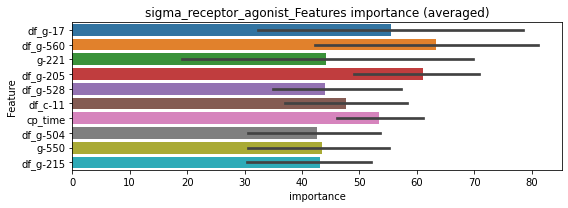

len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245702	valid_1's binary_logloss: 0.0577903
[200]	training's binary_logloss: 0.00393562	valid_1's binary_logloss: 0.0291189
[300]	training's binary_logloss: 0.00110661	valid_1's binary_logloss: 0.0228182
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000601899	valid_1's binary_logloss: 0.0210958


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266551	valid_1's binary_logloss: 0.055497
[200]	training's binary_logloss: 0.00427813	valid_1's binary_logloss: 0.0259321
[300]	training's binary_logloss: 0.00115915	valid_1's binary_logloss: 0.0191875
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000966497	valid_1's binary_logloss: 0.0188387


sigma_receptor_agonist logloss: 0.019967292684032096
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975421	valid_1's binary_logloss: 0.17993
[200]	training's binary_logloss: 0.021288	valid_1's binary_logloss: 0.0762365
[300]	training's binary_logloss: 0.00692062	valid_1's binary_logloss: 0.0452168
[400]	training's binary_logloss: 0.003499	valid_1's binary_logloss: 0.033402
[500]	training's binary_logloss: 0.00231525	valid_1's binary_logloss: 0.0281469
[600]	training's binary_logloss: 0.00186642	valid_1's binary_logloss: 0.025551
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00184052	valid_1's binary_logloss: 0.0252084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972248	valid_1's binary_logloss: 0.177361
[200]	training's binary_logloss: 0.0213269	valid_1's binary_logloss: 0.0758625
[300]	training's binary_logloss: 0.00693046	valid_1's binary_logloss: 0.0428028
[400]	training's binary_logloss: 0.00346319	valid_1's b

1 / 3 AUC score:1.000
Threshold: 0.529059338329894
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00636
p_label_rate: 0.00075 Vs.target_rate: 0.00161, Num_p_label: 3.0, conf_0:0.00636, conf_1:0.52906
threshold:0.53, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980494	valid_1's binary_logloss: 0.174456
[200]	training's binary_logloss: 0.020903	valid_1's binary_logloss: 0.0739306
[300]	training's binary_logloss: 0.00693896	valid_1's binary_logloss: 0.0420729
[400]	training's binary_logloss: 0.00349247	valid_1's binary_logloss: 0.0308627
[500]	training's binary_logloss: 0.00230447	valid_1's binary_logloss: 0.0254273
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.0019093	valid_1's binary_logloss: 0.0232827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960606	valid_1's binary_logloss: 0.186394
[200]	training's binary_logloss: 0.0203019	valid_1's binary_logloss: 0.0815475
[300]	training's binary_logloss: 0.00670914	valid_1's binary_logloss: 0.048008
[400]	training's binary_logloss: 0.00340231	valid_1's binary_logloss: 0.035248
[500]	training's binary_logloss: 0.00229986	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.529059338329894
Remove_noisy_labels: 2 → positive_corect_labels: 497.0/994
30th percentile: 0.00710
p_label_rate: 0.00100 Vs.target_rate: 0.00161, Num_p_label: 4.0, conf_0:0.00710, conf_1:0.52906
threshold:0.53, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976768	valid_1's binary_logloss: 0.181827
[200]	training's binary_logloss: 0.0209545	valid_1's binary_logloss: 0.0740207
[300]	training's binary_logloss: 0.00677535	valid_1's binary_logloss: 0.0427027
[400]	training's binary_logloss: 0.00341339	valid_1's binary_logloss: 0.0316069
[500]	training's binary_logloss: 0.00225374	valid_1's binary_logloss: 0.0270383
[600]	training's binary_logloss: 0.00184104	valid_1's binary_logloss: 0.0247837
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00181637	valid_1's binary_logloss: 0.0246684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964301	valid_1's binary_logloss: 0.176761
[200]	training's binary_logloss: 0.0203384	valid_1's binary_logloss: 0.0732297
[300]	training's binary_logloss: 0.00671651	valid_1's binary_logloss: 0.0432201
[400]	training's binary_logloss: 0.00343007	valid

3 / 3 AUC score:1.000
Threshold: 0.529059338329894
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/991
30th percentile: 0.00654
p_label_rate: 0.00025 Vs.target_rate: 0.00161, Num_p_label: 1.0, conf_0:0.00654, conf_1:0.52906
Num_p_label: 1.0, Expected: 6.4, Adj_threshold_1: 0.53
Num_p_label: 3.0, Expected: 6.4, Adj_threshold_2: 0.49
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_3: 0.45
threshold:0.45, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:507.0/4973, y_label_rate: 0.10195


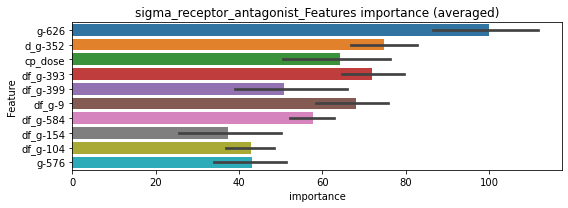

len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287143	valid_1's binary_logloss: 0.0541966
[200]	training's binary_logloss: 0.00476006	valid_1's binary_logloss: 0.0246631
[300]	training's binary_logloss: 0.00128789	valid_1's binary_logloss: 0.0191676
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000663209	valid_1's binary_logloss: 0.0185409


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028538	valid_1's binary_logloss: 0.0504165
[200]	training's binary_logloss: 0.00456154	valid_1's binary_logloss: 0.0213871
[300]	training's binary_logloss: 0.00126332	valid_1's binary_logloss: 0.0160979
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00103008	valid_1's binary_logloss: 0.0156989


sigma_receptor_antagonist logloss: 0.01712016885484672
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739329	valid_1's binary_logloss: 0.123057
[200]	training's binary_logloss: 0.0135554	valid_1's binary_logloss: 0.0411529
[300]	training's binary_logloss: 0.00433682	valid_1's binary_logloss: 0.0218744
[400]	training's binary_logloss: 0.00226187	valid_1's binary_logloss: 0.0159723
[500]	training's binary_logloss: 0.0016076	valid_1's binary_logloss: 0.0136083
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00146703	valid_1's binary_logloss: 0.0127954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726456	valid_1's binary_logloss: 0.14818
[200]	training's binary_logloss: 0.0130361	valid_1's binary_logloss: 0.0673119


1 / 3 AUC score:0.999
Threshold: 0.30915771153727867
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00625
p_label_rate: 0.00703 Vs.target_rate: 0.00113, Num_p_label: 28.0, conf_0:0.00625, conf_1:0.36517
Num_p_label: 28.0, Expected: 4.5, Adj_threshold_1: 0.31
Num_p_label: 15.0, Expected: 4.5, Adj_threshold_2: 0.35
Num_p_label: 11.0, Expected: 4.5, Adj_threshold_3: 0.39
Num_p_label: 7.0, Expected: 4.5, Adj_threshold_4: 0.43
Num_p_label: 4.0, Expected: 4.5, Adj_threshold_5: 0.47
threshold:0.47, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00661867	valid_1's binary_logloss: 0.0559016


positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713289	valid_1's binary_logloss: 0.127251
[200]	training's binary_logloss: 0.0126303	valid_1's binary_logloss: 0.045747
[300]	training's binary_logloss: 0.00403226	valid_1's binary_logloss: 0.0252152
[400]	training's binary_logloss: 0.00216153	valid_1's binary_logloss: 0.0177981
[500]	training's binary_logloss: 0.00156082	valid_1's binary_logloss: 0.0148863
[600]	training's binary_logloss: 0.00140259	valid_1's binary_logloss: 0.0140698
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00140334	valid_1's binary_logloss: 0.0140657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738071	valid_1's binary_logloss: 0.127152
[200]	training's binary_logloss: 0.0134533	valid_1's binary_logloss: 0.0526924
[300]	training's binary_logloss: 0.00420332	valid_1's binary_logloss: 0.0355356


2 / 3 AUC score:0.999
Threshold: 0.4691577115372786
Remove_noisy_labels: 3 → positive_corect_labels: 492.0/987
30th percentile: 0.00340
p_label_rate: 0.00151 Vs.target_rate: 0.00113, Num_p_label: 6.0, conf_0:0.00340, conf_1:0.46916
threshold:0.47, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00249739	valid_1's binary_logloss: 0.0317635


positive y_label:492.0/987, y_label_rate: 0.49848
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729279	valid_1's binary_logloss: 0.11437
[200]	training's binary_logloss: 0.0130355	valid_1's binary_logloss: 0.0387515
[300]	training's binary_logloss: 0.00416804	valid_1's binary_logloss: 0.0210663
[400]	training's binary_logloss: 0.00221793	valid_1's binary_logloss: 0.0153796
[500]	training's binary_logloss: 0.00158238	valid_1's binary_logloss: 0.0127235
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00141546	valid_1's binary_logloss: 0.0118999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710415	valid_1's binary_logloss: 0.13206
[200]	training's binary_logloss: 0.0127775	valid_1's binary_logloss: 0.049459
[300]	training's binary_logloss: 0.0040472	valid_1's binary_logloss: 0.0292225
[400]	training's binary_logloss: 0.00212505	valid_1's binary_logloss: 0.0224295
[500]	training's binary_logloss: 0.0015124	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.4691577115372786
Remove_noisy_labels: 1 → positive_corect_labels: 491.0/986
30th percentile: 0.00233
p_label_rate: 0.00176 Vs.target_rate: 0.00113, Num_p_label: 7.0, conf_0:0.00233, conf_1:0.46916
threshold:0.47, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/4968, y_label_rate: 0.10024


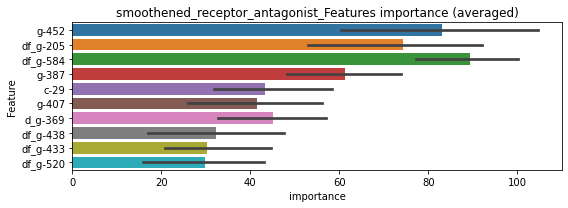

len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195984	valid_1's binary_logloss: 0.0346124
[200]	training's binary_logloss: 0.00259736	valid_1's binary_logloss: 0.0128553
[300]	training's binary_logloss: 0.00071498	valid_1's binary_logloss: 0.00997082
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000419833	valid_1's binary_logloss: 0.00971493


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019047	valid_1's binary_logloss: 0.0339251
[200]	training's binary_logloss: 0.00255611	valid_1's binary_logloss: 0.0130859
[300]	training's binary_logloss: 0.000726254	valid_1's binary_logloss: 0.0105724


smoothened_receptor_antagonist logloss: 0.010080413630855371


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000614085	valid_1's binary_logloss: 0.0104459


sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202359	valid_1's binary_logloss: 0.574524
[200]	training's binary_logloss: 0.0740451	valid_1's binary_logloss: 0.538422
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0614593	valid_1's binary_logloss: 0.536375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209144	valid_1's binary_logloss: 0.581874


1 / 3 AUC score:0.782
Threshold: 0.49974917728518364
Remove_noisy_labels: 306 → positive_corect_labels: 347/694
30th percentile: 0.33907
p_label_rate: 0.25917 Vs.target_rate: 0.00934, Num_p_label: 1032.0, conf_0:0.33907, conf_1:0.51960
Num_p_label: 1032.0, Expected: 37.2, Adj_threshold_1: 0.50
Num_p_label: 680.0, Expected: 37.2, Adj_threshold_2: 0.54
Num_p_label: 444.0, Expected: 37.2, Adj_threshold_3: 0.58
Num_p_label: 270.0, Expected: 37.2, Adj_threshold_4: 0.62
Num_p_label: 141.0, Expected: 37.2, Adj_threshold_5: 0.66
Num_p_label: 66.0, Expected: 37.2, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 37.2, Adj_threshold_7: 0.74


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0868315	valid_1's binary_logloss: 0.558372


threshold:0.74, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:347.0/694, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172783	valid_1's binary_logloss: 0.44996
[200]	training's binary_logloss: 0.0592303	valid_1's binary_logloss: 0.37758
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0351922	valid_1's binary_logloss: 0.356285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176825	valid_1's binary_logloss: 0.456813
[200]	training's binary_logloss: 0.0582044	valid_1's binary_logloss: 0.378148


2 / 3 AUC score:0.925
Threshold: 0.7397491772851839
Remove_noisy_labels: 117 → positive_corect_labels: 239.0/577


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0272888	valid_1's binary_logloss: 0.350707


30th percentile: 0.22572
p_label_rate: 0.07860 Vs.target_rate: 0.00934, Num_p_label: 313.0, conf_0:0.22572, conf_1:0.73975
Num_p_label: 313.0, Expected: 37.2, Adj_threshold_1: 0.74
Num_p_label: 220.0, Expected: 37.2, Adj_threshold_2: 0.78
Num_p_label: 133.0, Expected: 37.2, Adj_threshold_3: 0.82
Num_p_label: 69.0, Expected: 37.2, Adj_threshold_4: 0.86
Num_p_label: 24.0, Expected: 37.2, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:239.0/577, y_label_rate: 0.41421
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148834	valid_1's binary_logloss: 0.373856
[200]	training's binary_logloss: 0.0462527	valid_1's binary_logloss: 0.297186
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0214397	valid_1's binary_logloss: 0.278246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160975	valid_1's binary_logloss: 0.388731
[200]	training's binary_logloss: 0.0518241	valid_1's binary_logloss: 0.300488
[300]	training's binary_logloss: 0.020525	valid_1's binary_logloss: 0.27195
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0148027	valid_1's binary_logloss: 0.267369


3 / 3 AUC score:0.949
Threshold: 0.899749177285184
Remove_noisy_labels: 122 → positive_corect_labels: 117.0/455
30th percentile: 0.08797
p_label_rate: 0.00552 Vs.target_rate: 0.00934, Num_p_label: 22.0, conf_0:0.07589, conf_1:0.89975
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:139.0/4437, y_label_rate: 0.03133


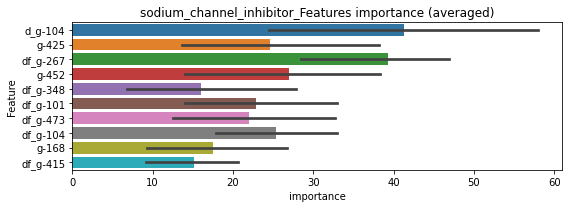

len(train_index) : 2218
len(valid_index) : 2219
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119535	valid_1's binary_logloss: 0.0823465


len(train_index) : 2219
len(valid_index) : 2218
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00747303	valid_1's binary_logloss: 0.0817102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010817	valid_1's binary_logloss: 0.0851384


sodium_channel_inhibitor logloss: 0.08333523718318663


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.0102626	valid_1's binary_logloss: 0.084961
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922328	valid_1's binary_logloss: 0.166596
[200]	training's binary_logloss: 0.0188633	valid_1's binary_logloss: 0.0698488
[300]	training's binary_logloss: 0.00603082	valid_1's binary_logloss: 0.0407317
[400]	training's binary_logloss: 0.00303949	valid_1's binary_logloss: 0.0313509
[500]	training's binary_logloss: 0.00206617	valid_1's binary_logloss: 0.0268662
[600]	training's binary_logloss: 0.00170526	valid_1's binary_logloss: 0.0243158
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00167636	valid_1's binary_logloss: 0.024178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926776	valid_1's binary_logloss: 0.162529
[200]	training's binary_logloss: 0.0196116	valid_1's binary_logloss: 0.0655768
[300]	training's binary_logloss: 0.00623011	valid_1's binary_logloss: 0.0350864
[400]	training's binary_logloss: 0.00312172	valid_

1 / 3 AUC score:1.000
Threshold: 0.5467964368679232
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00478
p_label_rate: 0.00050 Vs.target_rate: 0.00144, Num_p_label: 2.0, conf_0:0.00478, conf_1:0.54680
threshold:0.55, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905864	valid_1's binary_logloss: 0.16999
[200]	training's binary_logloss: 0.0184452	valid_1's binary_logloss: 0.0735049
[300]	training's binary_logloss: 0.00593833	valid_1's binary_logloss: 0.0432401
[400]	training's binary_logloss: 0.00302122	valid_1's binary_logloss: 0.0323967
[500]	training's binary_logloss: 0.00203707	valid_1's binary_logloss: 0.0272971
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00170842	valid_1's binary_logloss: 0.0251849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942688	valid_1's binary_logloss: 0.172635
[200]	training's binary_logloss: 0.0199003	valid_1's binary_logloss: 0.070222
[300]	training's binary_logloss: 0.00633389	valid_1's binary_logloss: 0.039837
[400]	training's binary_logloss: 0.00314209	valid_1's binary_logloss: 0.0294786
[500]	training's binary_logloss: 0.00209397	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.5467964368679232
Remove_noisy_labels: 5 → positive_corect_labels: 495.0/993
30th percentile: 0.00498
p_label_rate: 0.00226 Vs.target_rate: 0.00144, Num_p_label: 9.0, conf_0:0.00498, conf_1:0.54680
threshold:0.55, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:495.0/993, y_label_rate: 0.49849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866112	valid_1's binary_logloss: 0.193954
[200]	training's binary_logloss: 0.0176935	valid_1's binary_logloss: 0.120633
[300]	training's binary_logloss: 0.00568978	valid_1's binary_logloss: 0.0884318
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00345112	valid_1's binary_logloss: 0.0789258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956047	valid_1's binary_logloss: 0.160117
[200]	training's binary_logloss: 0.0199589	valid_1's binary_logloss: 0.0592683
[300]	training's binary_logloss: 0.00638605	valid_1's binary_logloss: 0.0317859
[400]	training's binary_logloss: 0.00318448	valid_1's binary_logloss: 0.0215954
[500]	training's binary_logloss: 0.00211361	valid_1's binary_logloss: 0.0170334
[600]	training's binary_logloss: 0.00171201	valid_1's binary_logloss: 0.0150814
Early stopping, best iteration is:
[631]	training'

3 / 3 AUC score:0.999
Threshold: 0.5467964368679232
Remove_noisy_labels: 14 → positive_corect_labels: 482.0/979
30th percentile: 0.00595
p_label_rate: 0.00326 Vs.target_rate: 0.00144, Num_p_label: 13.0, conf_0:0.00595, conf_1:0.54680
threshold:0.55, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:495.0/4961, y_label_rate: 0.09978


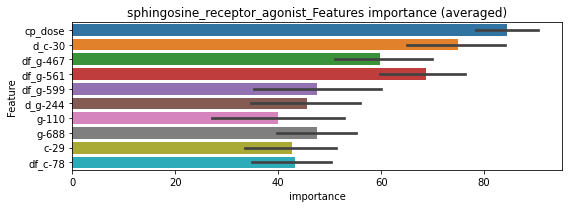

len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245754	valid_1's binary_logloss: 0.0483553
[200]	training's binary_logloss: 0.00375635	valid_1's binary_logloss: 0.0219806
[300]	training's binary_logloss: 0.00106002	valid_1's binary_logloss: 0.0174124
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000625566	valid_1's binary_logloss: 0.0165395


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248466	valid_1's binary_logloss: 0.050285
[200]	training's binary_logloss: 0.00381656	valid_1's binary_logloss: 0.0247017
[300]	training's binary_logloss: 0.00108022	valid_1's binary_logloss: 0.0209537
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000947497	valid_1's binary_logloss: 0.020794


sphingosine_receptor_agonist logloss: 0.018666294950258185
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137082	valid_1's binary_logloss: 0.295622
[200]	training's binary_logloss: 0.0378877	valid_1's binary_logloss: 0.185201
[300]	training's binary_logloss: 0.0134839	valid_1's binary_logloss: 0.138189
[400]	training's binary_logloss: 0.00640687	valid_1's binary_logloss: 0.11595
[500]	training's binary_logloss: 0.00396468	valid_1's binary_logloss: 0.105159
[600]	training's binary_logloss: 0.00293569	valid_1's binary_logloss: 0.101041
[700]	training's binary_logloss: 0.00241428	valid_1's binary_logloss: 0.0979571
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.00231748	valid_1's binary_logloss: 0.0971339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132342	valid_1's binary_logloss: 0.28844
[200]	training's binary_logloss: 0.0355872	valid_1's binary_logloss: 0.181806
[300]	training's binary_logloss: 0.0124948	valid_1's binary_

1 / 3 AUC score:0.994
Threshold: 0.3647868959271017
Remove_noisy_labels: 38 → positive_corect_labels: 481/962
30th percentile: 0.02167
p_label_rate: 0.02235 Vs.target_rate: 0.00307, Num_p_label: 89.0, conf_0:0.02167, conf_1:0.47755
Num_p_label: 89.0, Expected: 12.2, Adj_threshold_1: 0.36
Num_p_label: 66.0, Expected: 12.2, Adj_threshold_2: 0.40
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_3: 0.44
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_4: 0.48
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_5: 0.52
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_6: 0.56
Num_p_label: 12.0, Expected: 12.2, Adj_threshold_7: 0.60
threshold:0.60, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:481.0/962, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129453	valid_1's binary_logloss: 0.297388
[200]	training's binary_logloss: 0.0345016	valid_1's binary_logloss: 0.193
[300]	training's binary_logloss: 0.012272	valid_1's binary_logloss: 0.15876
[400]	training's binary_logloss: 0.00597882	valid_1's binary_logloss: 0.137387
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00535657	valid_1's binary_logloss: 0.134745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122635	valid_1's binary_logloss: 0.27634
[200]	training's binary_logloss: 0.0320919	valid_1's binary_logloss: 0.178986
[300]	training's binary_logloss: 0.0112998	valid_1's binary_logloss: 0.142655
[400]	training's binary_logloss: 0.00554849	valid_1's binary_logloss: 0.129379


2 / 3 AUC score:0.990
Threshold: 0.6047868959271017


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.0038398	valid_1's binary_logloss: 0.122798


Remove_noisy_labels: 48 → positive_corect_labels: 440.0/914
30th percentile: 0.03130
p_label_rate: 0.00402 Vs.target_rate: 0.00307, Num_p_label: 16.0, conf_0:0.03130, conf_1:0.60479
threshold:0.60, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:440.0/914, y_label_rate: 0.48140
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121093	valid_1's binary_logloss: 0.247868
[200]	training's binary_logloss: 0.0314797	valid_1's binary_logloss: 0.143867
[300]	training's binary_logloss: 0.0111542	valid_1's binary_logloss: 0.10935
[400]	training's binary_logloss: 0.00548112	valid_1's binary_logloss: 0.0965258
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00397686	valid_1's binary_logloss: 0.0907801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126285	valid_1's binary_logloss: 0.270306
[200]	training's binary_logloss: 0.0327188	valid_1's binary_logloss: 0.156617
[300]	training's binary_logloss: 0.0115027	valid_1's binary_logloss: 0.11353
[400]	training's binary_logloss: 0.00564856	valid_1's binary_logloss: 0.0971843
[500]	training's binary_logloss: 0.00357164	valid_1's binary_logloss: 0.0886942
[600]	training's binary_logloss: 0.002689	valid_1's binary_

3 / 3 AUC score:0.995
Threshold: 0.6047868959271017
Remove_noisy_labels: 22 → positive_corect_labels: 419.0/892
30th percentile: 0.01940
p_label_rate: 0.00402 Vs.target_rate: 0.00307, Num_p_label: 16.0, conf_0:0.01940, conf_1:0.60479
threshold:0.60, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:435.0/4874, y_label_rate: 0.08925


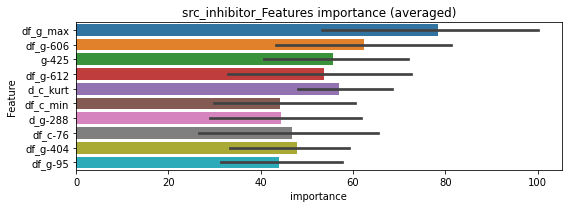

len(train_index) : 2437
len(valid_index) : 2437
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310719	valid_1's binary_logloss: 0.075018
[200]	training's binary_logloss: 0.00637715	valid_1's binary_logloss: 0.0480399
[300]	training's binary_logloss: 0.00181249	valid_1's binary_logloss: 0.0414523
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00136053	valid_1's binary_logloss: 0.0407203


len(train_index) : 2437
len(valid_index) : 2437
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289602	valid_1's binary_logloss: 0.0791755
[200]	training's binary_logloss: 0.00546905	valid_1's binary_logloss: 0.0525798
[300]	training's binary_logloss: 0.00163336	valid_1's binary_logloss: 0.0453551
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00144706	valid_1's binary_logloss: 0.0447872


src_inhibitor logloss: 0.04275376163759837
steroid , len(trt) : 79


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13949	valid_1's binary_logloss: 0.310863
[200]	training's binary_logloss: 0.0392214	valid_1's binary_logloss: 0.202132
[300]	training's binary_logloss: 0.0141822	valid_1's binary_logloss: 0.159007
[400]	training's binary_logloss: 0.00686622	valid_1's binary_logloss: 0.13978
[500]	training's binary_logloss: 0.00423947	valid_1's binary_logloss: 0.131443
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00380295	valid_1's binary_logloss: 0.129328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144377	valid_1's binary_logloss: 0.314197
[200]	training's binary_logloss: 0.0408112	valid_1's binary_logloss: 0.207964
[300]	training's binary_logloss: 0.0145992	valid_1's binary_logloss: 0.166653
[400]	training's binary_logloss: 0.00704625	valid_1's binary_logloss: 0.147157


1 / 3 AUC score:0.987
Threshold: 0.4770162777161884


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00554001	valid_1's binary_logloss: 0.141142


Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentile: 0.04308
p_label_rate: 0.02285 Vs.target_rate: 0.00339, Num_p_label: 91.0, conf_0:0.04308, conf_1:0.55957
Num_p_label: 91.0, Expected: 13.5, Adj_threshold_1: 0.48
Num_p_label: 59.0, Expected: 13.5, Adj_threshold_2: 0.52
Num_p_label: 40.0, Expected: 13.5, Adj_threshold_3: 0.56
Num_p_label: 25.0, Expected: 13.5, Adj_threshold_4: 0.60
Num_p_label: 15.0, Expected: 13.5, Adj_threshold_5: 0.64
threshold:0.64, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136473	valid_1's binary_logloss: 0.291328
[200]	training's binary_logloss: 0.0377367	valid_1's binary_logloss: 0.177294
[300]	training's binary_logloss: 0.0134452	valid_1's binary_logloss: 0.130346
[400]	training's binary_logloss: 0.00657487	valid_1's binary_logloss: 0.110299
[500]	training's binary_logloss: 0.00410794	valid_1's binary_logloss: 0.100348
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00338832	valid_1's binary_logloss: 0.0959721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129895	valid_1's binary_logloss: 0.308992
[200]	training's binary_logloss: 0.0355537	valid_1's binary_logloss: 0.200069
[300]	training's binary_logloss: 0.0127302	valid_1's binary_logloss: 0.161166
[400]	training's binary_logloss: 0.00623129	valid_1's binary_logloss: 0.144083
[500]	training's binary_logloss: 0.00392618	valid_1's binary

2 / 3 AUC score:0.993
Threshold: 0.6370162777161885
Remove_noisy_labels: 32 → positive_corect_labels: 455.0/926
30th percentile: 0.03335
p_label_rate: 0.00678 Vs.target_rate: 0.00339, Num_p_label: 27.0, conf_0:0.03145, conf_1:0.63702
threshold:0.64, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:455.0/926, y_label_rate: 0.49136
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128549	valid_1's binary_logloss: 0.298912
[200]	training's binary_logloss: 0.0336146	valid_1's binary_logloss: 0.181808
[300]	training's binary_logloss: 0.0119621	valid_1's binary_logloss: 0.135217
[400]	training's binary_logloss: 0.00581918	valid_1's binary_logloss: 0.114674
[500]	training's binary_logloss: 0.00369686	valid_1's binary_logloss: 0.103786
[600]	training's binary_logloss: 0.00275537	valid_1's binary_logloss: 0.0978486
[700]	training's binary_logloss: 0.00230411	valid_1's binary_logloss: 0.0941725
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.00226637	valid_1's binary_logloss: 0.0939759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130909	valid_1's binary_logloss: 0.288338
[200]	training's binary_logloss: 0.0361062	valid_1's binary_logloss: 0.181196
[300]	training's binary_logloss: 0.0127802	valid_1's bina

3 / 3 AUC score:0.990
Threshold: 0.6370162777161885
Remove_noisy_labels: 28 → positive_corect_labels: 431.0/898
30th percentile: 0.03538
p_label_rate: 0.00703 Vs.target_rate: 0.00339, Num_p_label: 28.0, conf_0:0.02765, conf_1:0.63702


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00749766	valid_1's binary_logloss: 0.131257


threshold:0.64, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:459.0/4880, y_label_rate: 0.09406


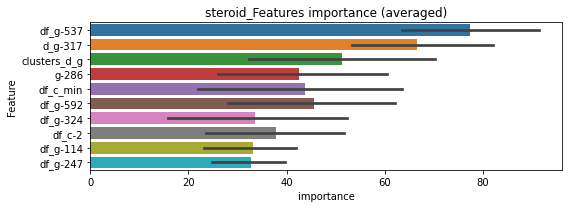

len(train_index) : 2440
len(valid_index) : 2440
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402871	valid_1's binary_logloss: 0.0942206
[200]	training's binary_logloss: 0.00808985	valid_1's binary_logloss: 0.058752
[300]	training's binary_logloss: 0.00230714	valid_1's binary_logloss: 0.0522911
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00242581	valid_1's binary_logloss: 0.0520705


len(train_index) : 2440
len(valid_index) : 2440
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374159	valid_1's binary_logloss: 0.0917047
[200]	training's binary_logloss: 0.00767122	valid_1's binary_logloss: 0.0623319


steroid logloss: 0.05531539228419114


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00371026	valid_1's binary_logloss: 0.0585603


syk_inhibitor , len(trt) : 19


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661966	valid_1's binary_logloss: 0.095006
[200]	training's binary_logloss: 0.0111541	valid_1's binary_logloss: 0.0263198
[300]	training's binary_logloss: 0.00352132	valid_1's binary_logloss: 0.0127161
[400]	training's binary_logloss: 0.00191616	valid_1's binary_logloss: 0.00886957
[500]	training's binary_logloss: 0.00142221	valid_1's binary_logloss: 0.00725253
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00134401	valid_1's binary_logloss: 0.00680773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631451	valid_1's binary_logloss: 0.10488
[200]	training's binary_logloss: 0.0105554	valid_1's binary_logloss: 0.0313626
[300]	training's binary_logloss: 0.00342481	valid_1's binary_logloss: 0.0154331
[400]	training's binary_logloss: 0.0018774	valid_1's binary_logloss: 0.0104593
[500]	training's binary_logloss: 0.00138207	vali

1 / 3 AUC score:1.000
Threshold: 0.46426340643359687
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00232
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00232, conf_1:0.46426
threshold:0.46, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661966	valid_1's binary_logloss: 0.095006
[200]	training's binary_logloss: 0.0111541	valid_1's binary_logloss: 0.0263198
[300]	training's binary_logloss: 0.00352132	valid_1's binary_logloss: 0.0127161
[400]	training's binary_logloss: 0.00191616	valid_1's binary_logloss: 0.00886957
[500]	training's binary_logloss: 0.00142221	valid_1's binary_logloss: 0.00725253
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00134401	valid_1's binary_logloss: 0.00680773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631451	valid_1's binary_logloss: 0.10488
[200]	training's binary_logloss: 0.0105554	valid_1's binary_logloss: 0.0313626
[300]	training's binary_logloss: 0.00342481	valid_1's binary_logloss: 0.0154331
[400]	training's binary_logloss: 0.0018774	valid_1's binary_logloss: 0.0104593
[500]	training's binary_logloss: 0.00138207	vali

2 / 3 AUC score:1.000
Threshold: 0.46426340643359687
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00232
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00232, conf_1:0.46426
threshold:0.46, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661966	valid_1's binary_logloss: 0.095006
[200]	training's binary_logloss: 0.0111541	valid_1's binary_logloss: 0.0263198
[300]	training's binary_logloss: 0.00352132	valid_1's binary_logloss: 0.0127161
[400]	training's binary_logloss: 0.00191616	valid_1's binary_logloss: 0.00886957
[500]	training's binary_logloss: 0.00142221	valid_1's binary_logloss: 0.00725253
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00134401	valid_1's binary_logloss: 0.00680773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631451	valid_1's binary_logloss: 0.10488
[200]	training's binary_logloss: 0.0105554	valid_1's binary_logloss: 0.0313626
[300]	training's binary_logloss: 0.00342481	valid_1's binary_logloss: 0.0154331
[400]	training's binary_logloss: 0.0018774	valid_1's binary_logloss: 0.0104593
[500]	training's binary_logloss: 0.00138207	vali

3 / 3 AUC score:1.000
Threshold: 0.46426340643359687
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00232
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00232, conf_1:0.46426
threshold:0.46, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


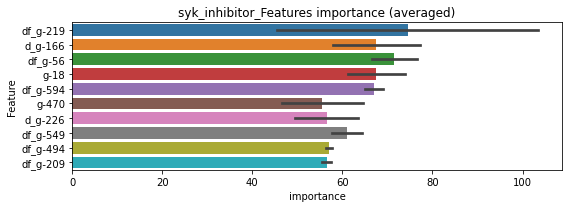

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01642	valid_1's binary_logloss: 0.0231447
[200]	training's binary_logloss: 0.00205707	valid_1's binary_logloss: 0.00567318
[300]	training's binary_logloss: 0.000597165	valid_1's binary_logloss: 0.00356775
[400]	training's binary_logloss: 0.000321116	valid_1's binary_logloss: 0.00313869
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000291984	valid_1's binary_logloss: 0.00307932


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016963	valid_1's binary_logloss: 0.0293848
[200]	training's binary_logloss: 0.00211809	valid_1's binary_logloss: 0.0102652
[300]	training's binary_logloss: 0.000598677	valid_1's binary_logloss: 0.00686003
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000415775	valid_1's binary_logloss: 0.00638926


syk_inhibitor logloss: 0.004734290505770571
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11449	valid_1's binary_logloss: 0.263349
[200]	training's binary_logloss: 0.027979	valid_1's binary_logloss: 0.157849
[300]	training's binary_logloss: 0.00963695	valid_1's binary_logloss: 0.121684
[400]	training's binary_logloss: 0.004762	valid_1's binary_logloss: 0.111004
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.0032059	valid_1's binary_logloss: 0.105808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120445	valid_1's binary_logloss: 0.241222
[200]	training's binary_logloss: 0.0307557	valid_1's binary_logloss: 0.139525
[300]	training's binary_logloss: 0.0103322	valid_1's binary_logloss: 0.104735
[400]	training's binary_logloss: 0.00506223	valid_1's binary_logloss: 0.0918447
[500]	training's binary_logloss: 0.00322376	valid_1's binary_logloss: 0.0861913
[600]	training's binary_logloss: 0.00242472	valid_1's binary_lo

1 / 3 AUC score:0.992
Threshold: 0.3420188980347967
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentile: 0.01898
p_label_rate: 0.02863 Vs.target_rate: 0.00262, Num_p_label: 114.0, conf_0:0.01898, conf_1:0.43734
Num_p_label: 114.0, Expected: 10.4, Adj_threshold_1: 0.34
Num_p_label: 82.0, Expected: 10.4, Adj_threshold_2: 0.38
Num_p_label: 58.0, Expected: 10.4, Adj_threshold_3: 0.42
Num_p_label: 41.0, Expected: 10.4, Adj_threshold_4: 0.46
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_5: 0.50
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_6: 0.54
Num_p_label: 14.0, Expected: 10.4, Adj_threshold_7: 0.58
threshold:0.58, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111534	valid_1's binary_logloss: 0.243079
[200]	training's binary_logloss: 0.0261867	valid_1's binary_logloss: 0.13844
[300]	training's binary_logloss: 0.00892743	valid_1's binary_logloss: 0.104957
[400]	training's binary_logloss: 0.00446303	valid_1's binary_logloss: 0.0910349
[500]	training's binary_logloss: 0.00286821	valid_1's binary_logloss: 0.0837383
[600]	training's binary_logloss: 0.00221524	valid_1's binary_logloss: 0.0802331
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00211481	valid_1's binary_logloss: 0.0796844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11689	valid_1's binary_logloss: 0.24162
[200]	training's binary_logloss: 0.02981	valid_1's binary_logloss: 0.138423
[300]	training's binary_logloss: 0.01023	valid_1's binary_logloss: 0.0961908
[400]	training's binary_logloss: 0.00498647	valid_1's binary_l

2 / 3 AUC score:0.997
Threshold: 0.5820188980347967
Remove_noisy_labels: 23 → positive_corect_labels: 467.0/945
30th percentile: 0.01545
p_label_rate: 0.00452 Vs.target_rate: 0.00262, Num_p_label: 18.0, conf_0:0.01545, conf_1:0.58202
threshold:0.58, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:467.0/945, y_label_rate: 0.49418
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110239	valid_1's binary_logloss: 0.228333
[200]	training's binary_logloss: 0.0262509	valid_1's binary_logloss: 0.121848
[300]	training's binary_logloss: 0.0089011	valid_1's binary_logloss: 0.085246
[400]	training's binary_logloss: 0.00445528	valid_1's binary_logloss: 0.0676478
[500]	training's binary_logloss: 0.00291451	valid_1's binary_logloss: 0.0602202
[600]	training's binary_logloss: 0.00223345	valid_1's binary_logloss: 0.055819
[700]	training's binary_logloss: 0.0020264	valid_1's binary_logloss: 0.0539741
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.00197601	valid_1's binary_logloss: 0.0534618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110079	valid_1's binary_logloss: 0.24101
[200]	training's binary_logloss: 0.0258438	valid_1's binary_logloss: 0.13419
[300]	training's binary_logloss: 0.00879534	valid_1's binar

3 / 3 AUC score:0.998
Threshold: 0.5820188980347967
Remove_noisy_labels: 17 → positive_corect_labels: 451.0/928
30th percentile: 0.01277
p_label_rate: 0.00678 Vs.target_rate: 0.00262, Num_p_label: 27.0, conf_0:0.01277, conf_1:0.58202
threshold:0.58, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:478.0/4910, y_label_rate: 0.09735


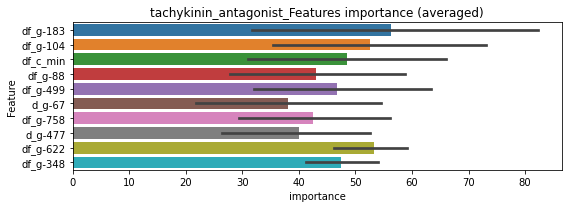

len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302054	valid_1's binary_logloss: 0.07499
[200]	training's binary_logloss: 0.00561878	valid_1's binary_logloss: 0.0469264
[300]	training's binary_logloss: 0.00163426	valid_1's binary_logloss: 0.041805
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00130304	valid_1's binary_logloss: 0.0414809


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304642	valid_1's binary_logloss: 0.0798617
[200]	training's binary_logloss: 0.00561469	valid_1's binary_logloss: 0.0508172


tachykinin_antagonist logloss: 0.043830133425941144


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00190116	valid_1's binary_logloss: 0.0461794


tgf-beta_receptor_inhibitor , len(trt) : 30


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875156	valid_1's binary_logloss: 0.167209
[200]	training's binary_logloss: 0.0173986	valid_1's binary_logloss: 0.0737985
[300]	training's binary_logloss: 0.00562795	valid_1's binary_logloss: 0.0474601
[400]	training's binary_logloss: 0.00288185	valid_1's binary_logloss: 0.0377126
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00233802	valid_1's binary_logloss: 0.0351451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855489	valid_1's binary_logloss: 0.165955
[200]	training's binary_logloss: 0.0169307	valid_1's binary_logloss: 0.0680754
[300]	training's binary_logloss: 0.00544277	valid_1's binary_logloss: 0.0421086
[400]	training's binary_logloss: 0.0028282	valid_1's binary_logloss: 0.0344563
[500]	training's binary_logloss: 0.0019444	valid_1's binary_logloss: 0.0304309
[600]	training's binary_logloss: 0.00167933	valid_1

1 / 3 AUC score:1.000
Threshold: 0.21666261279934532
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00682
p_label_rate: 0.00804 Vs.target_rate: 0.00135, Num_p_label: 32.0, conf_0:0.00682, conf_1:0.37703
Num_p_label: 32.0, Expected: 5.4, Adj_threshold_1: 0.22
Num_p_label: 20.0, Expected: 5.4, Adj_threshold_2: 0.26
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_3: 0.30
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_4: 0.34
threshold:0.34, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844862	valid_1's binary_logloss: 0.151518
[200]	training's binary_logloss: 0.0169422	valid_1's binary_logloss: 0.0567539
[300]	training's binary_logloss: 0.00546985	valid_1's binary_logloss: 0.0299831
[400]	training's binary_logloss: 0.00287079	valid_1's binary_logloss: 0.0212307
[500]	training's binary_logloss: 0.00199266	valid_1's binary_logloss: 0.0174459
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00168585	valid_1's binary_logloss: 0.0155696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085497	valid_1's binary_logloss: 0.150749
[200]	training's binary_logloss: 0.0168736	valid_1's binary_logloss: 0.0531026
[300]	training's binary_logloss: 0.00541476	valid_1's binary_logloss: 0.0264533
[400]	training's binary_logloss: 0.00285233	valid_1's binary_logloss: 0.0188222
[500]	training's binary_logloss: 0.00195733	valid_

2 / 3 AUC score:1.000
Threshold: 0.3366626127993453
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/991
30th percentile: 0.00556
p_label_rate: 0.00251 Vs.target_rate: 0.00135, Num_p_label: 10.0, conf_0:0.00556, conf_1:0.39682
threshold:0.34, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854227	valid_1's binary_logloss: 0.143622
[200]	training's binary_logloss: 0.016984	valid_1's binary_logloss: 0.0510098
[300]	training's binary_logloss: 0.00558037	valid_1's binary_logloss: 0.0266686
[400]	training's binary_logloss: 0.00289185	valid_1's binary_logloss: 0.018023
[500]	training's binary_logloss: 0.00198002	valid_1's binary_logloss: 0.0146303
[600]	training's binary_logloss: 0.00167517	valid_1's binary_logloss: 0.0128498
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00166076	valid_1's binary_logloss: 0.0127377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084532	valid_1's binary_logloss: 0.154854
[200]	training's binary_logloss: 0.016985	valid_1's binary_logloss: 0.0562401
[300]	training's binary_logloss: 0.00555958	valid_1's binary_logloss: 0.0288322
[400]	training's binary_logloss: 0.00285758	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.3366626127993453
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/991
30th percentile: 0.00577
p_label_rate: 0.00226 Vs.target_rate: 0.00135, Num_p_label: 9.0, conf_0:0.00577, conf_1:0.33666
threshold:0.34, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:505.0/4973, y_label_rate: 0.10155


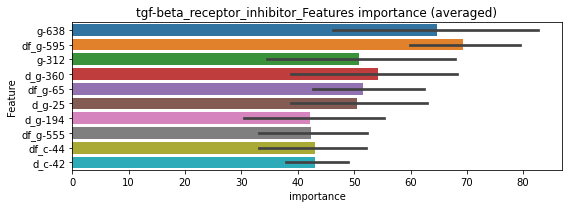

len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241828	valid_1's binary_logloss: 0.0448548
[200]	training's binary_logloss: 0.00353656	valid_1's binary_logloss: 0.0174719
[300]	training's binary_logloss: 0.000993842	valid_1's binary_logloss: 0.0131675
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000949797	valid_1's binary_logloss: 0.0130991


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254344	valid_1's binary_logloss: 0.0499796
[200]	training's binary_logloss: 0.00382815	valid_1's binary_logloss: 0.0222757
[300]	training's binary_logloss: 0.00103447	valid_1's binary_logloss: 0.0178062
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000714061	valid_1's binary_logloss: 0.017235


tgf-beta_receptor_inhibitor logloss: 0.01516666100429066
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652528	valid_1's binary_logloss: 0.09461
[200]	training's binary_logloss: 0.0110138	valid_1's binary_logloss: 0.0277592
[300]	training's binary_logloss: 0.0035456	valid_1's binary_logloss: 0.013803
[400]	training's binary_logloss: 0.00190032	valid_1's binary_logloss: 0.00952536
[500]	training's binary_logloss: 0.00142669	valid_1's binary_logloss: 0.0080463
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00136584	valid_1's binary_logloss: 0.00780543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637687	valid_1's binary_logloss: 0.114412
[200]	training's binary_logloss: 0.0105011	valid_1's binary_logloss: 0.0397248
[300]	training's binary_logloss: 0.00330195	valid_1's binary_logloss: 0.0232027
[400]	training's binary_logloss: 0.00179045	valid_1's binary_logloss: 0.0178373
[500]	training's binary_logloss: 0.00136248	valid_

1 / 3 AUC score:1.000
Threshold: 0.6160500110611706
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00176
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00176, conf_1:0.61605
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652528	valid_1's binary_logloss: 0.09461
[200]	training's binary_logloss: 0.0110138	valid_1's binary_logloss: 0.0277592
[300]	training's binary_logloss: 0.0035456	valid_1's binary_logloss: 0.013803
[400]	training's binary_logloss: 0.00190032	valid_1's binary_logloss: 0.00952536
[500]	training's binary_logloss: 0.00142669	valid_1's binary_logloss: 0.0080463
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00136584	valid_1's binary_logloss: 0.00780543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637687	valid_1's binary_logloss: 0.114412
[200]	training's binary_logloss: 0.0105011	valid_1's binary_logloss: 0.0397248
[300]	training's binary_logloss: 0.00330195	valid_1's binary_logloss: 0.0232027
[400]	training's binary_logloss: 0.00179045	valid_1's binary_logloss: 0.0178373
[500]	training's binary_logloss: 0.00136248	valid_

2 / 3 AUC score:1.000
Threshold: 0.6160500110611706
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00176
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00176, conf_1:0.61605
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652528	valid_1's binary_logloss: 0.09461
[200]	training's binary_logloss: 0.0110138	valid_1's binary_logloss: 0.0277592
[300]	training's binary_logloss: 0.0035456	valid_1's binary_logloss: 0.013803
[400]	training's binary_logloss: 0.00190032	valid_1's binary_logloss: 0.00952536
[500]	training's binary_logloss: 0.00142669	valid_1's binary_logloss: 0.0080463
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00136584	valid_1's binary_logloss: 0.00780543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637687	valid_1's binary_logloss: 0.114412
[200]	training's binary_logloss: 0.0105011	valid_1's binary_logloss: 0.0397248
[300]	training's binary_logloss: 0.00330195	valid_1's binary_logloss: 0.0232027
[400]	training's binary_logloss: 0.00179045	valid_1's binary_logloss: 0.0178373
[500]	training's binary_logloss: 0.00136248	valid_

3 / 3 AUC score:1.000
Threshold: 0.6160500110611706
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00176
p_label_rate: 0.00050 Vs.target_rate: 0.00086, Num_p_label: 2.0, conf_0:0.00176, conf_1:0.61605
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


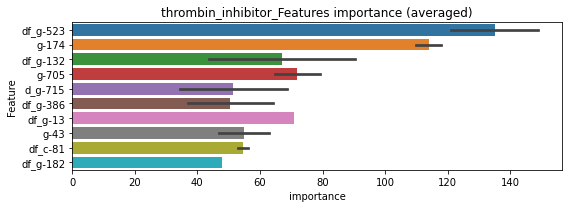

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160587	valid_1's binary_logloss: 0.0230506
[200]	training's binary_logloss: 0.00197977	valid_1's binary_logloss: 0.00554539
[300]	training's binary_logloss: 0.000575266	valid_1's binary_logloss: 0.00304112
[400]	training's binary_logloss: 0.000312813	valid_1's binary_logloss: 0.00258493
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000280869	valid_1's binary_logloss: 0.00253284


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016183	valid_1's binary_logloss: 0.0309855
[200]	training's binary_logloss: 0.00197185	valid_1's binary_logloss: 0.0100637
[300]	training's binary_logloss: 0.000575066	valid_1's binary_logloss: 0.00676519
[400]	training's binary_logloss: 0.000316882	valid_1's binary_logloss: 0.00606629
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000289373	valid_1's binary_logloss: 0.00594713


thrombin_inhibitor logloss: 0.004239984522752909
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944129	valid_1's binary_logloss: 0.19145
[200]	training's binary_logloss: 0.0208356	valid_1's binary_logloss: 0.0848106
[300]	training's binary_logloss: 0.00677929	valid_1's binary_logloss: 0.0555544
[400]	training's binary_logloss: 0.00338802	valid_1's binary_logloss: 0.0464021
[500]	training's binary_logloss: 0.00222821	valid_1's binary_logloss: 0.042997
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00208466	valid_1's binary_logloss: 0.0418877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927936	valid_1's binary_logloss: 0.173126
[200]	training's binary_logloss: 0.0202516	valid_1's binary_logloss: 0.0768785
[300]	training's binary_logloss: 0.00663419	valid_1's binary_logloss: 0.0513452
[400]	training's binary_logloss: 0.00336866	valid_1's binary_logloss: 0.0418319
[500]	training's binary_logloss: 0.00224412	valid_1

1 / 3 AUC score:0.999
Threshold: 0.30065073520914776
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.00675
p_label_rate: 0.00854 Vs.target_rate: 0.00165, Num_p_label: 34.0, conf_0:0.00675, conf_1:0.38143
Num_p_label: 34.0, Expected: 6.6, Adj_threshold_1: 0.30
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_2: 0.34
Num_p_label: 15.0, Expected: 6.6, Adj_threshold_3: 0.38
Num_p_label: 11.0, Expected: 6.6, Adj_threshold_4: 0.42
Num_p_label: 4.0, Expected: 6.6, Adj_threshold_5: 0.46
threshold:0.46, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903154	valid_1's binary_logloss: 0.167181
[200]	training's binary_logloss: 0.0191973	valid_1's binary_logloss: 0.0712667
[300]	training's binary_logloss: 0.00630365	valid_1's binary_logloss: 0.0430862
[400]	training's binary_logloss: 0.00326222	valid_1's binary_logloss: 0.0337983
[500]	training's binary_logloss: 0.00219221	valid_1's binary_logloss: 0.0294453
[600]	training's binary_logloss: 0.00179837	valid_1's binary_logloss: 0.0273475
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00175801	valid_1's binary_logloss: 0.0270185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095555	valid_1's binary_logloss: 0.170039
[200]	training's binary_logloss: 0.0204995	valid_1's binary_logloss: 0.069028
[300]	training's binary_logloss: 0.00658152	valid_1's binary_logloss: 0.0408497
[400]	training's binary_logloss: 0.00333213	valid_1

2 / 3 AUC score:1.000
Threshold: 0.4606507352091477
Remove_noisy_labels: 5 → positive_corect_labels: 489.0/983
30th percentile: 0.00658
p_label_rate: 0.00201 Vs.target_rate: 0.00165, Num_p_label: 8.0, conf_0:0.00658, conf_1:0.46065
threshold:0.46, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:489.0/983, y_label_rate: 0.49746
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928442	valid_1's binary_logloss: 0.175782
[200]	training's binary_logloss: 0.0191062	valid_1's binary_logloss: 0.0740516
[300]	training's binary_logloss: 0.00620586	valid_1's binary_logloss: 0.0443264
[400]	training's binary_logloss: 0.00319598	valid_1's binary_logloss: 0.0353177
[500]	training's binary_logloss: 0.00212233	valid_1's binary_logloss: 0.0312037
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00205416	valid_1's binary_logloss: 0.0308658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919655	valid_1's binary_logloss: 0.175127
[200]	training's binary_logloss: 0.0194388	valid_1's binary_logloss: 0.0735205
[300]	training's binary_logloss: 0.00637692	valid_1's binary_logloss: 0.043853
[400]	training's binary_logloss: 0.00327092	valid_1's binary_logloss: 0.0337718
[500]	training's binary_logloss: 0.00219418	valid_

3 / 3 AUC score:1.000
Threshold: 0.4606507352091477
Remove_noisy_labels: 5 → positive_corect_labels: 486.0/978
30th percentile: 0.00713
p_label_rate: 0.00352 Vs.target_rate: 0.00165, Num_p_label: 14.0, conf_0:0.00713, conf_1:0.46065
threshold:0.46, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:500.0/4960, y_label_rate: 0.10081


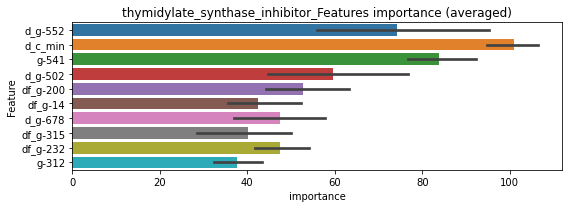

len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245404	valid_1's binary_logloss: 0.0451731
[200]	training's binary_logloss: 0.0038664	valid_1's binary_logloss: 0.0209611


len(train_index) : 2480
len(valid_index) : 2480


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00129425	valid_1's binary_logloss: 0.0176641


================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230354	valid_1's binary_logloss: 0.0484775
[200]	training's binary_logloss: 0.00359719	valid_1's binary_logloss: 0.0248534
[300]	training's binary_logloss: 0.00104184	valid_1's binary_logloss: 0.0210061
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000918671	valid_1's binary_logloss: 0.0206837


thymidylate_synthase_inhibitor logloss: 0.019173904568853442
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842128	valid_1's binary_logloss: 0.165944
[200]	training's binary_logloss: 0.0163936	valid_1's binary_logloss: 0.0678918
[300]	training's binary_logloss: 0.00534367	valid_1's binary_logloss: 0.0388315
[400]	training's binary_logloss: 0.0028323	valid_1's binary_logloss: 0.0285672
[500]	training's binary_logloss: 0.00196097	valid_1's binary_logloss: 0.0249331
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00166865	valid_1's binary_logloss: 0.0227387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855213	valid_1's binary_logloss: 0.156766
[200]	training's binary_logloss: 0.0171866	valid_1's binary_logloss: 0.0607224
[300]	training's binary_logloss: 0.00553995	valid_1's binary_logloss: 0.0344657
[400]	training's binary_logloss: 0.00286715	valid_1's binary_logloss: 0.0253991
[500]	training's binary_logloss: 0.00199233	valid_

1 / 3 AUC score:1.000
Threshold: 0.5166843563921484
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00455
p_label_rate: 0.00050 Vs.target_rate: 0.00135, Num_p_label: 2.0, conf_0:0.00455, conf_1:0.51668
threshold:0.52, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838285	valid_1's binary_logloss: 0.145769
[200]	training's binary_logloss: 0.0168719	valid_1's binary_logloss: 0.055288
[300]	training's binary_logloss: 0.0055006	valid_1's binary_logloss: 0.0304605
[400]	training's binary_logloss: 0.00285962	valid_1's binary_logloss: 0.021643
[500]	training's binary_logloss: 0.00197439	valid_1's binary_logloss: 0.0182549
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00168298	valid_1's binary_logloss: 0.0166084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817673	valid_1's binary_logloss: 0.155254
[200]	training's binary_logloss: 0.0160485	valid_1's binary_logloss: 0.0586061
[300]	training's binary_logloss: 0.00536894	valid_1's binary_logloss: 0.0335698
[400]	training's binary_logloss: 0.00283814	valid_1's binary_logloss: 0.0245447
[500]	training's binary_logloss: 0.00195885	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.5166843563921484
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentile: 0.00516
p_label_rate: 0.00100 Vs.target_rate: 0.00135, Num_p_label: 4.0, conf_0:0.00516, conf_1:0.51668
threshold:0.52, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838285	valid_1's binary_logloss: 0.145769
[200]	training's binary_logloss: 0.0168719	valid_1's binary_logloss: 0.055288
[300]	training's binary_logloss: 0.0055006	valid_1's binary_logloss: 0.0304605
[400]	training's binary_logloss: 0.00285962	valid_1's binary_logloss: 0.021643
[500]	training's binary_logloss: 0.00197439	valid_1's binary_logloss: 0.0182549
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00168298	valid_1's binary_logloss: 0.0166084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817673	valid_1's binary_logloss: 0.155254
[200]	training's binary_logloss: 0.0160485	valid_1's binary_logloss: 0.0586061
[300]	training's binary_logloss: 0.00536894	valid_1's binary_logloss: 0.0335698
[400]	training's binary_logloss: 0.00283814	valid_1's binary_logloss: 0.0245447
[500]	training's binary_logloss: 0.00195885	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.5166843563921484
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentile: 0.00516
p_label_rate: 0.00100 Vs.target_rate: 0.00135, Num_p_label: 4.0, conf_0:0.00516, conf_1:0.51668
threshold:0.52, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:501.0/4976, y_label_rate: 0.10068


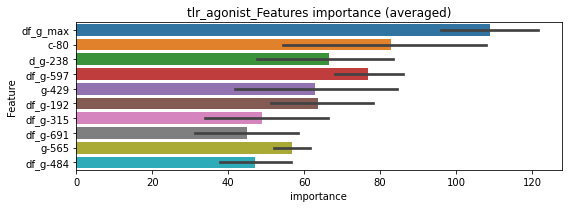

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021555	valid_1's binary_logloss: 0.0380715
[200]	training's binary_logloss: 0.00318106	valid_1's binary_logloss: 0.012659
[300]	training's binary_logloss: 0.000890939	valid_1's binary_logloss: 0.00755077
[400]	training's binary_logloss: 0.000460849	valid_1's binary_logloss: 0.00623898
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000381292	valid_1's binary_logloss: 0.00589573


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254278	valid_1's binary_logloss: 0.0427433
[200]	training's binary_logloss: 0.00343877	valid_1's binary_logloss: 0.0159723
[300]	training's binary_logloss: 0.00093063	valid_1's binary_logloss: 0.0119099
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000625661	valid_1's binary_logloss: 0.0113576


tlr_agonist logloss: 0.008626659197255257
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386599	valid_1's binary_logloss: 0.0507489
[200]	training's binary_logloss: 0.00461629	valid_1's binary_logloss: 0.0123663
[300]	training's binary_logloss: 0.00152159	valid_1's binary_logloss: 0.00595339
[400]	training's binary_logloss: 0.000966322	valid_1's binary_logloss: 0.00435787
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00087581	valid_1's binary_logloss: 0.00399638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041087	valid_1's binary_logloss: 0.0651439
[200]	training's binary_logloss: 0.0050119	valid_1's binary_logloss: 0.0183243
[300]	training's binary_logloss: 0.00157295	valid_1's binary_logloss: 0.00960356
[400]	training's binary_logloss: 0.000964118	valid_1's binary_logloss: 0.00711488
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000871275	valid_1's binary_logloss: 0.00660225


1 / 3 AUC score:1.000
Threshold: 0.38541970603611825
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00060
p_label_rate: 0.00075 Vs.target_rate: 0.00032, Num_p_label: 3.0, conf_0:0.00060, conf_1:0.38542
threshold:0.39, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404349	valid_1's binary_logloss: 0.0522231
[200]	training's binary_logloss: 0.00480455	valid_1's binary_logloss: 0.00957408
[300]	training's binary_logloss: 0.00154938	valid_1's binary_logloss: 0.00410175
[400]	training's binary_logloss: 0.000972001	valid_1's binary_logloss: 0.00277953
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000883593	valid_1's binary_logloss: 0.00250538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403333	valid_1's binary_logloss: 0.0587133
[200]	training's binary_logloss: 0.00500616	valid_1's binary_logloss: 0.0149671
[300]	training's binary_logloss: 0.00158421	valid_1's binary_logloss: 0.00735714
[400]	training's binary_logloss: 0.00097905	valid_1's binary_logloss: 0.00533882
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00087574	valid_1's binary_logloss: 0.00489371


2 / 3 AUC score:1.000
Threshold: 0.38541970603611825
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
30th percentile: 0.00058
p_label_rate: 0.00000 Vs.target_rate: 0.00032, Num_p_label: 0.0, conf_0:0.00058, conf_1:0.38542
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_1: 0.39
Num_p_label: 1.0, Expected: 1.3, Adj_threshold_2: 0.35
threshold:0.35, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405687	valid_1's binary_logloss: 0.0536269
[200]	training's binary_logloss: 0.00484459	valid_1's binary_logloss: 0.0107358
[300]	training's binary_logloss: 0.00157176	valid_1's binary_logloss: 0.00503242
[400]	training's binary_logloss: 0.000971103	valid_1's binary_logloss: 0.00342896
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000867768	valid_1's binary_logloss: 0.00308616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401112	valid_1's binary_logloss: 0.0568099
[200]	training's binary_logloss: 0.00498042	valid_1's binary_logloss: 0.0136002
[300]	training's binary_logloss: 0.00159235	valid_1's binary_logloss: 0.00589741
[400]	training's binary_logloss: 0.000983811	valid_1's binary_logloss: 0.00423878
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000877415	valid_1's binary_logloss: 0.00388511


3 / 3 AUC score:1.000
Threshold: 0.34541970603611827
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
30th percentile: 0.00057
p_label_rate: 0.00075 Vs.target_rate: 0.00032, Num_p_label: 3.0, conf_0:0.00057, conf_1:0.34542
threshold:0.35, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:502.0/4979, y_label_rate: 0.10082


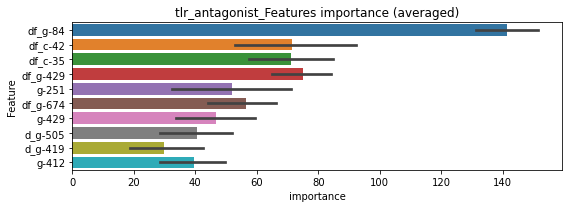

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109647	valid_1's binary_logloss: 0.0129725
[200]	training's binary_logloss: 0.00102259	valid_1's binary_logloss: 0.00282019
[300]	training's binary_logloss: 0.000301879	valid_1's binary_logloss: 0.00198619


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 tlr_antagonist=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000226914	valid_1's binary_logloss: 0.00189657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107226	valid_1's binary_logloss: 0.016737
[200]	training's binary_logloss: 0.000994934	valid_1's binary_logloss: 0.00748438


tlr_antagonist logloss: 0.00455606357485156
tnf_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.000554939	valid_1's binary_logloss: 0.00721663


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909312	valid_1's binary_logloss: 0.17424
[200]	training's binary_logloss: 0.019179	valid_1's binary_logloss: 0.0801328
[300]	training's binary_logloss: 0.00625544	valid_1's binary_logloss: 0.0529827
[400]	training's binary_logloss: 0.00319711	valid_1's binary_logloss: 0.0445888
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00244534	valid_1's binary_logloss: 0.0423017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909181	valid_1's binary_logloss: 0.16339
[200]	training's binary_logloss: 0.0196061	valid_1's binary_logloss: 0.068448
[300]	training's binary_logloss: 0.0062724	valid_1's binary_logloss: 0.037797
[400]	training's binary_logloss: 0.0031911	valid_1's binary_logloss: 0.0278755
[500]	training's binary_logloss: 0.00214995	valid_1's binary_logloss: 0.0233291
[600]	training's binary_logloss: 0.00175186	valid_1's bi

1 / 3 AUC score:0.999
Threshold: 0.608186158367579
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00608
p_label_rate: 0.00100 Vs.target_rate: 0.00161, Num_p_label: 4.0, conf_0:0.00559, conf_1:0.60819
threshold:0.61, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922847	valid_1's binary_logloss: 0.169389
[200]	training's binary_logloss: 0.0198689	valid_1's binary_logloss: 0.0842203
[300]	training's binary_logloss: 0.00637169	valid_1's binary_logloss: 0.0613852
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00445544	valid_1's binary_logloss: 0.0553109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09134	valid_1's binary_logloss: 0.172718
[200]	training's binary_logloss: 0.0187039	valid_1's binary_logloss: 0.0719462
[300]	training's binary_logloss: 0.00600314	valid_1's binary_logloss: 0.0422242
[400]	training's binary_logloss: 0.00306289	valid_1's binary_logloss: 0.0325677
[500]	training's binary_logloss: 0.00205312	valid_1's binary_logloss: 0.027267
[600]	training's binary_logloss: 0.00168371	valid_1's binary_logloss: 0.0246009
Early stopping, best iteration is:
[645]	training's 

2 / 3 AUC score:0.999
Threshold: 0.608186158367579
Remove_noisy_labels: 8 → positive_corect_labels: 490.0/986
30th percentile: 0.00826
p_label_rate: 0.00126 Vs.target_rate: 0.00161, Num_p_label: 5.0, conf_0:0.00826, conf_1:0.60819
threshold:0.61, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:490.0/986, y_label_rate: 0.49696
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876349	valid_1's binary_logloss: 0.183238
[200]	training's binary_logloss: 0.0182764	valid_1's binary_logloss: 0.0894315
[300]	training's binary_logloss: 0.0060621	valid_1's binary_logloss: 0.0591949
[400]	training's binary_logloss: 0.00308779	valid_1's binary_logloss: 0.0472549
[500]	training's binary_logloss: 0.0020797	valid_1's binary_logloss: 0.0416236
[600]	training's binary_logloss: 0.00168563	valid_1's binary_logloss: 0.0384082
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00166669	valid_1's binary_logloss: 0.0381353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918082	valid_1's binary_logloss: 0.164031
[200]	training's binary_logloss: 0.0192519	valid_1's binary_logloss: 0.0677007
[300]	training's binary_logloss: 0.00620948	valid_1's binary_logloss: 0.0383752
[400]	training's binary_logloss: 0.00314278	valid_1

3 / 3 AUC score:1.000
Threshold: 0.608186158367579
Remove_noisy_labels: 11 → positive_corect_labels: 482.0/975
30th percentile: 0.00499
p_label_rate: 0.00176 Vs.target_rate: 0.00161, Num_p_label: 7.0, conf_0:0.00499, conf_1:0.60819
threshold:0.61, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:489.0/4957, y_label_rate: 0.09865


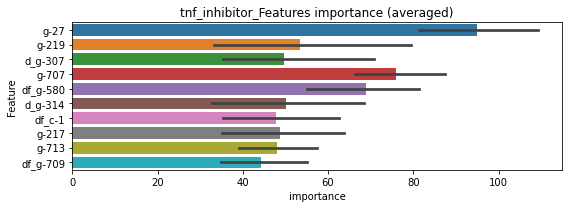

len(train_index) : 2478
len(valid_index) : 2479
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238699	valid_1's binary_logloss: 0.0472171
[200]	training's binary_logloss: 0.00357643	valid_1's binary_logloss: 0.021073
[300]	training's binary_logloss: 0.00103605	valid_1's binary_logloss: 0.0159512
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000666207	valid_1's binary_logloss: 0.0151891


len(train_index) : 2479
len(valid_index) : 2478
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245288	valid_1's binary_logloss: 0.0481359
[200]	training's binary_logloss: 0.00364607	valid_1's binary_logloss: 0.0186558
[300]	training's binary_logloss: 0.00105996	valid_1's binary_logloss: 0.0114984
[400]	training's binary_logloss: 0.000535543	valid_1's binary_logloss: 0.00962329
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000475844	valid_1's binary_logloss: 0.00932173


tnf_inhibitor logloss: 0.01225602282013491
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17011	valid_1's binary_logloss: 0.409236
[200]	training's binary_logloss: 0.0541227	valid_1's binary_logloss: 0.319504
[300]	training's binary_logloss: 0.0208171	valid_1's binary_logloss: 0.277732
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0122524	valid_1's binary_logloss: 0.259193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164876	valid_1's binary_logloss: 0.408633
[200]	training's binary_logloss: 0.0526119	valid_1's binary_logloss: 0.312836
[300]	training's binary_logloss: 0.0203413	valid_1's binary_logloss: 0.275467
[400]	training's binary_logloss: 0.00984324	valid_1's binary_logloss: 0.261452
[500]	training's binary_logloss: 0.00589652	valid_1's binary_logloss: 0.25275
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.0056907	valid_1's binary_logloss: 0.252632


1 / 3 AUC score:0.953
Threshold: 0.43086247808659495
Remove_noisy_labels: 108 → positive_corect_labels: 446/892
30th percentile: 0.11388
p_label_rate: 0.08312 Vs.target_rate: 0.00519, Num_p_label: 331.0, conf_0:0.11388, conf_1:0.55735
Num_p_label: 331.0, Expected: 20.7, Adj_threshold_1: 0.43
Num_p_label: 237.0, Expected: 20.7, Adj_threshold_2: 0.47
Num_p_label: 162.0, Expected: 20.7, Adj_threshold_3: 0.51
Num_p_label: 117.0, Expected: 20.7, Adj_threshold_4: 0.55
Num_p_label: 80.0, Expected: 20.7, Adj_threshold_5: 0.59
Num_p_label: 55.0, Expected: 20.7, Adj_threshold_6: 0.63
Num_p_label: 39.0, Expected: 20.7, Adj_threshold_7: 0.67
Num_p_label: 18.0, Expected: 20.7, Adj_threshold_8: 0.71
threshold:0.71, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:446.0/892, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159689	valid_1's binary_logloss: 0.369836
[200]	training's binary_logloss: 0.0494251	valid_1's binary_logloss: 0.271431
[300]	training's binary_logloss: 0.0188231	valid_1's binary_logloss: 0.228338
[400]	training's binary_logloss: 0.0091048	valid_1's binary_logloss: 0.209053
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00883949	valid_1's binary_logloss: 0.208377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151408	valid_1's binary_logloss: 0.361693
[200]	training's binary_logloss: 0.0465331	valid_1's binary_logloss: 0.252545
[300]	training's binary_logloss: 0.0173271	valid_1's binary_logloss: 0.208812
[400]	training's binary_logloss: 0.00844228	valid_1's binary_logloss: 0.188541
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00798731	valid_1's binary_logloss: 0.18695


2 / 3 AUC score:0.977
Threshold: 0.7108624780865951
Remove_noisy_labels: 69 → positive_corect_labels: 379.0/823
30th percentile: 0.09074
p_label_rate: 0.00979 Vs.target_rate: 0.00519, Num_p_label: 39.0, conf_0:0.09074, conf_1:0.71086
threshold:0.71, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:379.0/823, y_label_rate: 0.46051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142096	valid_1's binary_logloss: 0.342107
[200]	training's binary_logloss: 0.042064	valid_1's binary_logloss: 0.232255
[300]	training's binary_logloss: 0.0158998	valid_1's binary_logloss: 0.190088
[400]	training's binary_logloss: 0.00776897	valid_1's binary_logloss: 0.168936
[500]	training's binary_logloss: 0.00482071	valid_1's binary_logloss: 0.161044
[600]	training's binary_logloss: 0.00349784	valid_1's binary_logloss: 0.15506
Early stopping, best iteration is:
[653]	training's binary_logloss: 0.00311795	valid_1's binary_logloss: 0.15333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14697	valid_1's binary_logloss: 0.354724
[200]	training's binary_logloss: 0.0441273	valid_1's binary_logloss: 0.250482
[300]	training's binary_logloss: 0.0164695	valid_1's binary_logloss: 0.208877


3 / 3 AUC score:0.981
Threshold: 0.7108624780865951
Remove_noisy_labels: 48 → positive_corect_labels: 336.0/775
30th percentile: 0.06037
p_label_rate: 0.00502 Vs.target_rate: 0.00519, Num_p_label: 20.0, conf_0:0.06037, conf_1:0.71086
threshold:0.71, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0134647	valid_1's binary_logloss: 0.203452


positive y_label:356.0/4757, y_label_rate: 0.07484


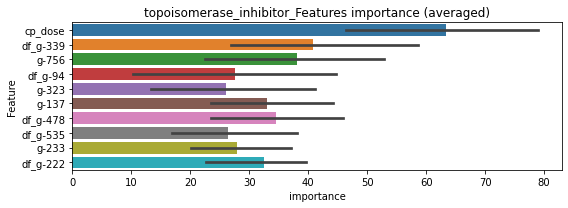

len(train_index) : 2378
len(valid_index) : 2379
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351884	valid_1's binary_logloss: 0.115067


len(train_index) : 2379
len(valid_index) : 2378


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0105603	valid_1's binary_logloss: 0.0986312


================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314796	valid_1's binary_logloss: 0.116009
[200]	training's binary_logloss: 0.00722505	valid_1's binary_logloss: 0.0988018
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00384825	valid_1's binary_logloss: 0.0970023


topoisomerase_inhibitor logloss: 0.09781691235024136
transient_receptor_potential_channel_antagonist , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665244	valid_1's binary_logloss: 0.110909
[200]	training's binary_logloss: 0.0109321	valid_1's binary_logloss: 0.0351269
[300]	training's binary_logloss: 0.00353348	valid_1's binary_logloss: 0.018525
[400]	training's binary_logloss: 0.00192206	valid_1's binary_logloss: 0.0127912
[500]	training's binary_logloss: 0.00146152	valid_1's binary_logloss: 0.0107462
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00136625	valid_1's binary_logloss: 0.0103107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671622	valid_1's binary_logloss: 0.120503
[200]	training's binary_logloss: 0.0110087	valid_1's binary_logloss: 0.0399177
[300]	training's binary_logloss: 0.00345986	valid_1's binary_logloss: 0.0249501
[400]	training's binary_logloss: 0.00188344	valid_1's binary_logloss: 0.020415
Early stopping, best iteration is:
[460]	training's

1 / 3 AUC score:1.000
Threshold: 0.6327037565097073
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00205
p_label_rate: 0.00025 Vs.target_rate: 0.00082, Num_p_label: 1.0, conf_0:0.00205, conf_1:0.63270
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.63
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_2: 0.59
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_3: 0.55
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_4: 0.51
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_5: 0.47
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_6: 0.43
threshold:0.43, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673231	valid_1's binary_logloss: 0.107769
[200]	training's binary_logloss: 0.0111811	valid_1's binary_logloss: 0.0311461
[300]	training's binary_logloss: 0.00354052	valid_1's binary_logloss: 0.0151618
[400]	training's binary_logloss: 0.00190952	valid_1's binary_logloss: 0.0104357
[500]	training's binary_logloss: 0.00143209	valid_1's binary_logloss: 0.00884511
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.0013241	valid_1's binary_logloss: 0.00825632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661731	valid_1's binary_logloss: 0.107772
[200]	training's binary_logloss: 0.0110664	valid_1's binary_logloss: 0.0301388
[300]	training's binary_logloss: 0.00351464	valid_1's binary_logloss: 0.0146464
[400]	training's binary_logloss: 0.00192418	valid_1's binary_logloss: 0.0102655
[500]	training's binary_logloss: 0.001471	valid_

2 / 3 AUC score:1.000
Threshold: 0.43270375650970727
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00166
p_label_rate: 0.00226 Vs.target_rate: 0.00082, Num_p_label: 9.0, conf_0:0.00166, conf_1:0.43270
threshold:0.43, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673231	valid_1's binary_logloss: 0.107769
[200]	training's binary_logloss: 0.0111811	valid_1's binary_logloss: 0.0311461
[300]	training's binary_logloss: 0.00354052	valid_1's binary_logloss: 0.0151618
[400]	training's binary_logloss: 0.00190952	valid_1's binary_logloss: 0.0104357
[500]	training's binary_logloss: 0.00143209	valid_1's binary_logloss: 0.00884511
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.0013241	valid_1's binary_logloss: 0.00825632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661731	valid_1's binary_logloss: 0.107772
[200]	training's binary_logloss: 0.0110664	valid_1's binary_logloss: 0.0301388
[300]	training's binary_logloss: 0.00351464	valid_1's binary_logloss: 0.0146464
[400]	training's binary_logloss: 0.00192418	valid_1's binary_logloss: 0.0102655
[500]	training's binary_logloss: 0.001471	valid_

3 / 3 AUC score:1.000
Threshold: 0.43270375650970727
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00166
p_label_rate: 0.00226 Vs.target_rate: 0.00082, Num_p_label: 9.0, conf_0:0.00166, conf_1:0.43270
threshold:0.43, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:507.0/4978, y_label_rate: 0.10185


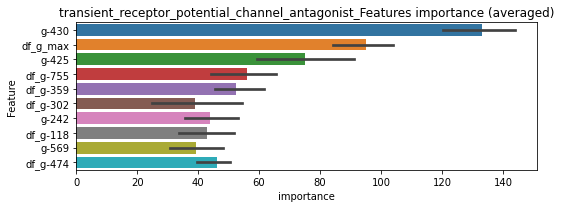

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016374	valid_1's binary_logloss: 0.0247989
[200]	training's binary_logloss: 0.00199195	valid_1's binary_logloss: 0.0079103
[300]	training's binary_logloss: 0.000586284	valid_1's binary_logloss: 0.0060242


len(train_index) : 2489
len(valid_index) : 2489


Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000555362	valid_1's binary_logloss: 0.00596143


================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167871	valid_1's binary_logloss: 0.0272953
[200]	training's binary_logloss: 0.00211972	valid_1's binary_logloss: 0.00926244
[300]	training's binary_logloss: 0.000618887	valid_1's binary_logloss: 0.00664451
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000402081	valid_1's binary_logloss: 0.00621497


transient_receptor_potential_channel_antagonist logloss: 0.006088201127190115
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361789	valid_1's binary_logloss: 0.0430492
[200]	training's binary_logloss: 0.0040635	valid_1's binary_logloss: 0.0063736
[300]	training's binary_logloss: 0.00131433	valid_1's binary_logloss: 0.00248933
[400]	training's binary_logloss: 0.000859025	valid_1's binary_logloss: 0.00172664
[500]	training's binary_logloss: 0.000758027	valid_1's binary_logloss: 0.00154966
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000745596	valid_1's binary_logloss: 0.00152089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346955	valid_1's binary_logloss: 0.0505947
[200]	training's binary_logloss: 0.00382942	valid_1's binary_logloss: 0.0130105
[300]	training's binary_logloss: 0.00127341	valid_1's binary_logloss: 0.00825912
[400]	training's binary_logloss: 0.00083447	valid_1's binary_logloss: 0.00688806
Early stopping, best iteration is:
[4

1 / 3 AUC score:1.000
Threshold: 0.8999487688053676
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00052
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00052, conf_1:0.89995
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.90
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.86
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.82
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.78
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_5: 0.74
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_7: 0.66
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_8: 0.62
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_9: 0.58
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_10: 0.54
threshold:0.54, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361789	valid_1's binary_logloss: 0.0430492
[200]	training's binary_logloss: 0.0040635	valid_1's binary_logloss: 0.0063736
[300]	training's binary_logloss: 0.00131433	valid_1's binary_logloss: 0.00248933
[400]	training's binary_logloss: 0.000859025	valid_1's binary_logloss: 0.00172664
[500]	training's binary_logloss: 0.000758027	valid_1's binary_logloss: 0.00154966
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000745596	valid_1's binary_logloss: 0.00152089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346955	valid_1's binary_logloss: 0.0505947
[200]	training's binary_logloss: 0.00382942	valid_1's binary_logloss: 0.0130105
[300]	training's binary_logloss: 0.00127341	valid_1's binary_logloss: 0.00825912
[400]	training's binary_logloss: 0.00083447	valid_1's binary_logloss: 0.00688806
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
Threshold: 0.5399487688053672
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00052
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00052, conf_1:0.53995
threshold:0.54, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348921	valid_1's binary_logloss: 0.0422025
[200]	training's binary_logloss: 0.00387053	valid_1's binary_logloss: 0.00650019
[300]	training's binary_logloss: 0.00127226	valid_1's binary_logloss: 0.0027441
[400]	training's binary_logloss: 0.000840425	valid_1's binary_logloss: 0.0020109
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000757214	valid_1's binary_logloss: 0.00184066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353161	valid_1's binary_logloss: 0.0417082
[200]	training's binary_logloss: 0.00398301	valid_1's binary_logloss: 0.00610468
[300]	training's binary_logloss: 0.00130627	valid_1's binary_logloss: 0.00248311
[400]	training's binary_logloss: 0.000843186	valid_1's binary_logloss: 0.00171717
[500]	training's binary_logloss: 0.000742208	valid_1's binary_logloss: 0.0015251


3 / 3 AUC score:1.000
Threshold: 0.5399487688053672
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00049
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00049, conf_1:0.53995
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.54
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_2: 0.50
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000728979	valid_1's binary_logloss: 0.00149334


positive y_label:501.0/4981, y_label_rate: 0.10058


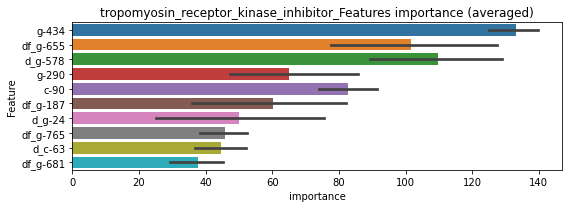

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101858	valid_1's binary_logloss: 0.0128232
[200]	training's binary_logloss: 0.000873849	valid_1's binary_logloss: 0.00356625
[300]	training's binary_logloss: 0.000246501	valid_1's binary_logloss: 0.00294266


len(train_index) : 2491
len(valid_index) : 2490


Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000237441	valid_1's binary_logloss: 0.00294144


================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103116	valid_1's binary_logloss: 0.0111897
[200]	training's binary_logloss: 0.000887791	valid_1's binary_logloss: 0.00134682
[300]	training's binary_logloss: 0.000253133	valid_1's binary_logloss: 0.000575873
[400]	training's binary_logloss: 0.000158196	valid_1's binary_logloss: 0.000417047
[500]	training's binary_logloss: 0.000139334	valid_1's binary_logloss: 0.000377969
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000139334	valid_1's binary_logloss: 0.000377969


tropomyosin_receptor_kinase_inhibitor logloss: 0.0016599612829860395
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805423	valid_1's binary_logloss: 0.135715
[200]	training's binary_logloss: 0.0156236	valid_1's binary_logloss: 0.0440109
[300]	training's binary_logloss: 0.00510882	valid_1's binary_logloss: 0.0215676
[400]	training's binary_logloss: 0.00268428	valid_1's binary_logloss: 0.0149714
[500]	training's binary_logloss: 0.00185223	valid_1's binary_logloss: 0.0120853
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00162545	valid_1's binary_logloss: 0.0111699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083311	valid_1's binary_logloss: 0.152992
[200]	training's binary_logloss: 0.0158862	valid_1's binary_logloss: 0.0644984
[300]	training's binary_logloss: 0.00504737	valid_1's binary_logloss: 0.0416522
[400]	training's binary_logloss: 0.00261647	valid_1's binary_logloss: 0.0354158


1 / 3 AUC score:0.999
Threshold: 0.18396904504305508
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00568
p_label_rate: 0.00804 Vs.target_rate: 0.00113, Num_p_label: 32.0, conf_0:0.00568, conf_1:0.32519


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00204816	valid_1's binary_logloss: 0.033193


Num_p_label: 32.0, Expected: 4.5, Adj_threshold_1: 0.18
Num_p_label: 23.0, Expected: 4.5, Adj_threshold_2: 0.22
Num_p_label: 14.0, Expected: 4.5, Adj_threshold_3: 0.26
Num_p_label: 6.0, Expected: 4.5, Adj_threshold_4: 0.30
threshold:0.30, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815448	valid_1's binary_logloss: 0.148732
[200]	training's binary_logloss: 0.0154176	valid_1's binary_logloss: 0.0479974
[300]	training's binary_logloss: 0.00495499	valid_1's binary_logloss: 0.0236152
[400]	training's binary_logloss: 0.00261702	valid_1's binary_logloss: 0.0161275
[500]	training's binary_logloss: 0.00181771	valid_1's binary_logloss: 0.0130751
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00157452	valid_1's binary_logloss: 0.0117917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799197	valid_1's binary_logloss: 0.137932
[200]	training's binary_logloss: 0.0152975	valid_1's binary_logloss: 0.0462017
[300]	training's binary_logloss: 0.00492993	valid_1's binary_logloss: 0.0242726
[400]	training's binary_logloss: 0.00257522	valid_1's binary_logloss: 0.0167434
[500]	training's binary_logloss: 0.0017957	valid_

2 / 3 AUC score:1.000
Threshold: 0.30396904504305505
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/993
30th percentile: 0.00500
p_label_rate: 0.00301 Vs.target_rate: 0.00113, Num_p_label: 12.0, conf_0:0.00500, conf_1:0.30397
threshold:0.30, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:497.0/993, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781978	valid_1's binary_logloss: 0.137386
[200]	training's binary_logloss: 0.0148046	valid_1's binary_logloss: 0.0454327
[300]	training's binary_logloss: 0.00481434	valid_1's binary_logloss: 0.0226046
[400]	training's binary_logloss: 0.00255998	valid_1's binary_logloss: 0.0159575
[500]	training's binary_logloss: 0.00180899	valid_1's binary_logloss: 0.0133413
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00159559	valid_1's binary_logloss: 0.0121843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808443	valid_1's binary_logloss: 0.138899
[200]	training's binary_logloss: 0.0154337	valid_1's binary_logloss: 0.0466905
[300]	training's binary_logloss: 0.00498576	valid_1's binary_logloss: 0.024417
[400]	training's binary_logloss: 0.00261933	valid_1's binary_logloss: 0.0170415
[500]	training's binary_logloss: 0.00181401	valid_

3 / 3 AUC score:1.000
Threshold: 0.30396904504305505
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/992
30th percentile: 0.00470
p_label_rate: 0.00301 Vs.target_rate: 0.00113, Num_p_label: 12.0, conf_0:0.00470, conf_1:0.41909
threshold:0.30, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:509.0/4974, y_label_rate: 0.10233


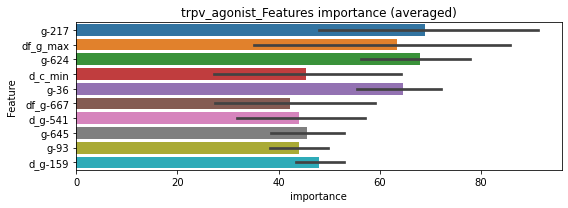

len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229182	valid_1's binary_logloss: 0.0425926
[200]	training's binary_logloss: 0.00324928	valid_1's binary_logloss: 0.020747
[300]	training's binary_logloss: 0.00089745	valid_1's binary_logloss: 0.0174725


len(train_index) : 2487
len(valid_index) : 2487


Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00089745	valid_1's binary_logloss: 0.0174725


================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222291	valid_1's binary_logloss: 0.0432437
[200]	training's binary_logloss: 0.00308003	valid_1's binary_logloss: 0.0189842


trpv_agonist logloss: 0.01672899157485978


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0010398	valid_1's binary_logloss: 0.0159855


trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10752	valid_1's binary_logloss: 0.238375
[200]	training's binary_logloss: 0.026076	valid_1's binary_logloss: 0.135349
[300]	training's binary_logloss: 0.00876438	valid_1's binary_logloss: 0.100593
[400]	training's binary_logloss: 0.00437349	valid_1's binary_logloss: 0.0851681
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0031995	valid_1's binary_logloss: 0.0799777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106334	valid_1's binary_logloss: 0.225358
[200]	training's binary_logloss: 0.0251769	valid_1's binary_logloss: 0.120889
[300]	training's binary_logloss: 0.00856946	valid_1's binary_logloss: 0.0832917
[400]	training's binary_logloss: 0.00425195	valid_1's binary_logloss: 0.0705724
[500]	training's binary_logloss: 0.00274357	valid_1's binary_logloss: 0.0646411
Early stopping, best iteration is:
[578]	training's binar

1 / 3 AUC score:0.997
Threshold: 0.44911911035332175
Remove_noisy_labels: 24 → positive_corect_labels: 488/976
30th percentile: 0.01330
p_label_rate: 0.01281 Vs.target_rate: 0.00212, Num_p_label: 51.0, conf_0:0.01330, conf_1:0.46389
Num_p_label: 51.0, Expected: 8.4, Adj_threshold_1: 0.45
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_2: 0.49
Num_p_label: 26.0, Expected: 8.4, Adj_threshold_3: 0.53
Num_p_label: 17.0, Expected: 8.4, Adj_threshold_4: 0.57
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_5: 0.61
threshold:0.61, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102675	valid_1's binary_logloss: 0.213834
[200]	training's binary_logloss: 0.0238734	valid_1's binary_logloss: 0.110172
[300]	training's binary_logloss: 0.00798876	valid_1's binary_logloss: 0.077233
[400]	training's binary_logloss: 0.00400642	valid_1's binary_logloss: 0.0630526
[500]	training's binary_logloss: 0.00265603	valid_1's binary_logloss: 0.0578457
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00213037	valid_1's binary_logloss: 0.0544964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109677	valid_1's binary_logloss: 0.206895
[200]	training's binary_logloss: 0.0256054	valid_1's binary_logloss: 0.098258
[300]	training's binary_logloss: 0.00862507	valid_1's binary_logloss: 0.062694
[400]	training's binary_logloss: 0.00424584	valid_1's binary_logloss: 0.0512821
[500]	training's binary_logloss: 0.0027663	valid_1's bi

2 / 3 AUC score:0.999
Threshold: 0.6091191103533218
Remove_noisy_labels: 14 → positive_corect_labels: 474.0/962
30th percentile: 0.00927
p_label_rate: 0.00377 Vs.target_rate: 0.00212, Num_p_label: 15.0, conf_0:0.00927, conf_1:0.60912
threshold:0.61, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:474.0/962, y_label_rate: 0.49272
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103286	valid_1's binary_logloss: 0.220317
[200]	training's binary_logloss: 0.023022	valid_1's binary_logloss: 0.114334
[300]	training's binary_logloss: 0.00784743	valid_1's binary_logloss: 0.0793698
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00484305	valid_1's binary_logloss: 0.0707553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104864	valid_1's binary_logloss: 0.223757
[200]	training's binary_logloss: 0.0246571	valid_1's binary_logloss: 0.106647
[300]	training's binary_logloss: 0.00819014	valid_1's binary_logloss: 0.0697133
[400]	training's binary_logloss: 0.00404368	valid_1's binary_logloss: 0.0522875
[500]	training's binary_logloss: 0.00264217	valid_1's binary_logloss: 0.0447288
[600]	training's binary_logloss: 0.0020624	valid_1's binary_logloss: 0.0399068
Early stopping, best iteration is:
[650]	training's bin

3 / 3 AUC score:0.999
Threshold: 0.6091191103533218
Remove_noisy_labels: 12 → positive_corect_labels: 462.0/950
30th percentile: 0.01243
p_label_rate: 0.00301 Vs.target_rate: 0.00212, Num_p_label: 12.0, conf_0:0.01243, conf_1:0.60912
threshold:0.61, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:474.0/4932, y_label_rate: 0.09611


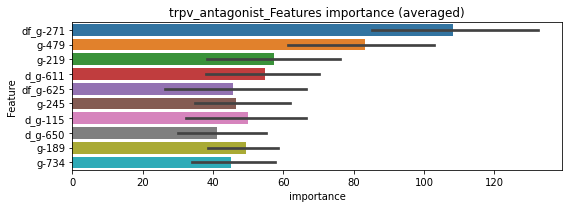

len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276209	valid_1's binary_logloss: 0.0620078
[200]	training's binary_logloss: 0.0046469	valid_1's binary_logloss: 0.0325784
[300]	training's binary_logloss: 0.00133202	valid_1's binary_logloss: 0.0276511
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00116335	valid_1's binary_logloss: 0.0274405


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282578	valid_1's binary_logloss: 0.0540766
[200]	training's binary_logloss: 0.00503578	valid_1's binary_logloss: 0.0241849
[300]	training's binary_logloss: 0.00143615	valid_1's binary_logloss: 0.0177019
[400]	training's binary_logloss: 0.000691214	valid_1's binary_logloss: 0.0159147
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000729465	valid_1's binary_logloss: 0.0158509


trpv_antagonist logloss: 0.021645690294612305
tubulin_inhibitor , len(trt) : 316


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214742	valid_1's binary_logloss: 0.609145
[200]	training's binary_logloss: 0.0820528	valid_1's binary_logloss: 0.587794
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0897687	valid_1's binary_logloss: 0.586568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212888	valid_1's binary_logloss: 0.598611


1 / 3 AUC score:0.753
Threshold: 0.5093963761518752
Remove_noisy_labels: 312 → positive_corect_labels: 344/688
30th percentile: 0.35773
p_label_rate: 0.29106 Vs.target_rate: 0.01040, Num_p_label: 1159.0, conf_0:0.35773, conf_1:0.51836
Num_p_label: 1159.0, Expected: 41.4, Adj_threshold_1: 0.51
Num_p_label: 789.0, Expected: 41.4, Adj_threshold_2: 0.55
Num_p_label: 522.0, Expected: 41.4, Adj_threshold_3: 0.59
Num_p_label: 285.0, Expected: 41.4, Adj_threshold_4: 0.63
Num_p_label: 150.0, Expected: 41.4, Adj_threshold_5: 0.67
Num_p_label: 65.0, Expected: 41.4, Adj_threshold_6: 0.71
Num_p_label: 30.0, Expected: 41.4, Adj_threshold_7: 0.75
threshold:0.75, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0949152	valid_1's binary_logloss: 0.577292


positive y_label:344.0/688, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178145	valid_1's binary_logloss: 0.477442
[200]	training's binary_logloss: 0.0617544	valid_1's binary_logloss: 0.416177
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0535506	valid_1's binary_logloss: 0.411226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180324	valid_1's binary_logloss: 0.512265
[200]	training's binary_logloss: 0.061598	valid_1's binary_logloss: 0.473645
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0594115	valid_1's binary_logloss: 0.473199


2 / 3 AUC score:0.877
Threshold: 0.7493963761518754
Remove_noisy_labels: 161 → positive_corect_labels: 193.0/527
30th percentile: 0.26951
p_label_rate: 0.06881 Vs.target_rate: 0.01040, Num_p_label: 274.0, conf_0:0.26951, conf_1:0.74940
Num_p_label: 274.0, Expected: 41.4, Adj_threshold_1: 0.75
Num_p_label: 164.0, Expected: 41.4, Adj_threshold_2: 0.79
Num_p_label: 81.0, Expected: 41.4, Adj_threshold_3: 0.83
Num_p_label: 29.0, Expected: 41.4, Adj_threshold_4: 0.87
threshold:0.87, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:193.0/527, y_label_rate: 0.36622
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14449	valid_1's binary_logloss: 0.406764
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0782063	valid_1's binary_logloss: 0.379193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144301	valid_1's binary_logloss: 0.370638
[200]	training's binary_logloss: 0.0456306	valid_1's binary_logloss: 0.297314
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0211062	valid_1's binary_logloss: 0.26779


3 / 3 AUC score:0.932
Threshold: 0.8693963761518755
Remove_noisy_labels: 130 → positive_corect_labels: 64.0/397
30th percentile: 0.09502
p_label_rate: 0.00728 Vs.target_rate: 0.01040, Num_p_label: 29.0, conf_0:0.09502, conf_1:0.86940
threshold:0.87, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:93.0/4379, y_label_rate: 0.02124


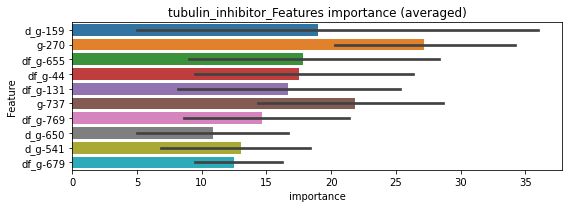

len(train_index) : 2189
len(valid_index) : 2190
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2190
len(valid_index) : 2189
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.011006	valid_1's binary_logloss: 0.0702965
Training until validation scores don't improve for 10 rounds


tubulin_inhibitor logloss: 0.07393774667169051
tyrosine_kinase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0163751	valid_1's binary_logloss: 0.0775807
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                     

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130287	valid_1's binary_logloss: 0.290179
[200]	training's binary_logloss: 0.0342912	valid_1's binary_logloss: 0.192698
[300]	training's binary_logloss: 0.012366	valid_1's binary_logloss: 0.151897
[400]	training's binary_logloss: 0.00604637	valid_1's binary_logloss: 0.136333
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00460639	valid_1's binary_logloss: 0.131706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130442	valid_1's binary_logloss: 0.271017
[200]	training's binary_logloss: 0.0356083	valid_1's binary_logloss: 0.169574
[300]	training's binary_logloss: 0.012854	valid_1's binary_logloss: 0.130031
[400]	training's binary_logloss: 0.00638483	valid_1's binary_logloss: 0.111231
[500]	training's binary_logloss: 0.00398305	valid_1's binary_logloss: 0.102603
Early stopping, best iteration is:
[530]	training's binary_logl

1 / 3 AUC score:0.990
Threshold: 0.3679425036128412
Remove_noisy_labels: 30 → positive_corect_labels: 485/970
30th percentile: 0.03828
p_label_rate: 0.03918 Vs.target_rate: 0.00315, Num_p_label: 156.0, conf_0:0.03828, conf_1:0.46682
Num_p_label: 156.0, Expected: 12.5, Adj_threshold_1: 0.37
Num_p_label: 126.0, Expected: 12.5, Adj_threshold_2: 0.41
Num_p_label: 81.0, Expected: 12.5, Adj_threshold_3: 0.45
Num_p_label: 59.0, Expected: 12.5, Adj_threshold_4: 0.49
Num_p_label: 39.0, Expected: 12.5, Adj_threshold_5: 0.53
Num_p_label: 27.0, Expected: 12.5, Adj_threshold_6: 0.57
Num_p_label: 18.0, Expected: 12.5, Adj_threshold_7: 0.61
threshold:0.61, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120521	valid_1's binary_logloss: 0.270807
[200]	training's binary_logloss: 0.0320882	valid_1's binary_logloss: 0.162852
[300]	training's binary_logloss: 0.0115647	valid_1's binary_logloss: 0.119048
[400]	training's binary_logloss: 0.00570329	valid_1's binary_logloss: 0.101887
[500]	training's binary_logloss: 0.00358477	valid_1's binary_logloss: 0.0934992
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.0027928	valid_1's binary_logloss: 0.08839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126829	valid_1's binary_logloss: 0.270501
[200]	training's binary_logloss: 0.0346023	valid_1's binary_logloss: 0.156621
[300]	training's binary_logloss: 0.0123718	valid_1's binary_logloss: 0.118132
[400]	training's binary_logloss: 0.00612445	valid_1's binary_logloss: 0.0995895
[500]	training's binary_logloss: 0.00386486	valid_1's binary_

2 / 3 AUC score:0.996
Threshold: 0.6079425036128412
Remove_noisy_labels: 26 → positive_corect_labels: 464.0/944
30th percentile: 0.02687
p_label_rate: 0.00829 Vs.target_rate: 0.00315, Num_p_label: 33.0, conf_0:0.02687, conf_1:0.60794
threshold:0.61, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:464.0/944, y_label_rate: 0.49153
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120223	valid_1's binary_logloss: 0.265306
[200]	training's binary_logloss: 0.0310797	valid_1's binary_logloss: 0.154761
[300]	training's binary_logloss: 0.011038	valid_1's binary_logloss: 0.118667
[400]	training's binary_logloss: 0.00546809	valid_1's binary_logloss: 0.102813
[500]	training's binary_logloss: 0.00349353	valid_1's binary_logloss: 0.0959085
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00333827	valid_1's binary_logloss: 0.0952247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130466	valid_1's binary_logloss: 0.279589
[200]	training's binary_logloss: 0.0346412	valid_1's binary_logloss: 0.158037
[300]	training's binary_logloss: 0.0123656	valid_1's binary_logloss: 0.113264
[400]	training's binary_logloss: 0.00607157	valid_1's binary_logloss: 0.0910468
[500]	training's binary_logloss: 0.00381761	valid_1's binar

3 / 3 AUC score:0.996
Threshold: 0.6079425036128412
Remove_noisy_labels: 26 → positive_corect_labels: 441.0/918
30th percentile: 0.02421
p_label_rate: 0.00703 Vs.target_rate: 0.00315, Num_p_label: 28.0, conf_0:0.02421, conf_1:0.60794
threshold:0.61, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:469.0/4900, y_label_rate: 0.09571


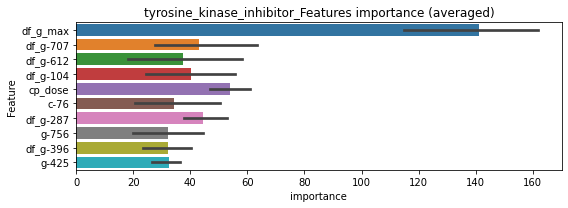

len(train_index) : 2450
len(valid_index) : 2450
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030082	valid_1's binary_logloss: 0.0801062
[200]	training's binary_logloss: 0.00623429	valid_1's binary_logloss: 0.052327
[300]	training's binary_logloss: 0.00187005	valid_1's binary_logloss: 0.0459176
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00178009	valid_1's binary_logloss: 0.0456962


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313518	valid_1's binary_logloss: 0.0923664
[200]	training's binary_logloss: 0.00632889	valid_1's binary_logloss: 0.0706263
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00413356	valid_1's binary_logloss: 0.0690092


tyrosine_kinase_inhibitor logloss: 0.05735272037606239
ubiquitin_specific_protease_inhibitor , len(trt) : 12


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511926	valid_1's binary_logloss: 0.0768062
[200]	training's binary_logloss: 0.00726527	valid_1's binary_logloss: 0.0168345
[300]	training's binary_logloss: 0.00230021	valid_1's binary_logloss: 0.00723071
[400]	training's binary_logloss: 0.00132901	valid_1's binary_logloss: 0.00506886
[500]	training's binary_logloss: 0.00110949	valid_1's binary_logloss: 0.00446607
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00110513	valid_1's binary_logloss: 0.00446046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508187	valid_1's binary_logloss: 0.0741242
[200]	training's binary_logloss: 0.00721781	valid_1's binary_logloss: 0.0186822
[300]	training's binary_logloss: 0.00228318	valid_1's binary_logloss: 0.00879136
[400]	training's binary_logloss: 0.00131279	valid_1's binary_logloss: 0.00583889
Early stopping, best iteration is:
[460

1 / 3 AUC score:1.000
Threshold: 0.6211306786667226
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00134
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00134, conf_1:0.62113
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.50
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.46
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_6: 0.42
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_7: 0.38
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_8: 0.34
threshold:0.34, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511926	valid_1's binary_logloss: 0.0768062
[200]	training's binary_logloss: 0.00726527	valid_1's binary_logloss: 0.0168345
[300]	training's binary_logloss: 0.00230021	valid_1's binary_logloss: 0.00723071
[400]	training's binary_logloss: 0.00132901	valid_1's binary_logloss: 0.00506886
[500]	training's binary_logloss: 0.00110949	valid_1's binary_logloss: 0.00446607
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00110513	valid_1's binary_logloss: 0.00446046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508187	valid_1's binary_logloss: 0.0741242
[200]	training's binary_logloss: 0.00721781	valid_1's binary_logloss: 0.0186822
[300]	training's binary_logloss: 0.00228318	valid_1's binary_logloss: 0.00879136
[400]	training's binary_logloss: 0.00131279	valid_1's binary_logloss: 0.00583889
Early stopping, best iteration is:
[460

2 / 3 AUC score:1.000
Threshold: 0.34113067866672253
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00134
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00134, conf_1:0.34113
threshold:0.34, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511926	valid_1's binary_logloss: 0.0768062
[200]	training's binary_logloss: 0.00726527	valid_1's binary_logloss: 0.0168345
[300]	training's binary_logloss: 0.00230021	valid_1's binary_logloss: 0.00723071
[400]	training's binary_logloss: 0.00132901	valid_1's binary_logloss: 0.00506886
[500]	training's binary_logloss: 0.00110949	valid_1's binary_logloss: 0.00446607
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00110513	valid_1's binary_logloss: 0.00446046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508187	valid_1's binary_logloss: 0.0741242
[200]	training's binary_logloss: 0.00721781	valid_1's binary_logloss: 0.0186822
[300]	training's binary_logloss: 0.00228318	valid_1's binary_logloss: 0.00879136
[400]	training's binary_logloss: 0.00131279	valid_1's binary_logloss: 0.00583889
Early stopping, best iteration is:
[460

3 / 3 AUC score:1.000
Threshold: 0.34113067866672253
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00134
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00134, conf_1:0.34113
threshold:0.34, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


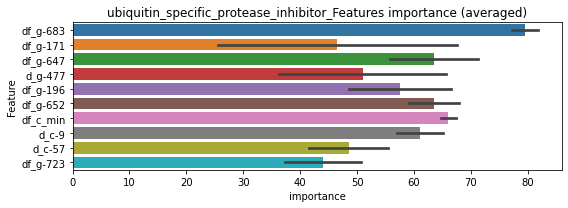

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126018	valid_1's binary_logloss: 0.0190317
[200]	training's binary_logloss: 0.0013104	valid_1's binary_logloss: 0.00581765
[300]	training's binary_logloss: 0.000385738	valid_1's binary_logloss: 0.00417194
[400]	training's binary_logloss: 0.000222393	valid_1's binary_logloss: 0.00377567
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000215946	valid_1's binary_logloss: 0.00374397


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127052	valid_1's binary_logloss: 0.0169524
[200]	training's binary_logloss: 0.00133226	valid_1's binary_logloss: 0.00418297
[300]	training's binary_logloss: 0.00039218	valid_1's binary_logloss: 0.00285064
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000262301	valid_1's binary_logloss: 0.00266473


ubiquitin_specific_protease_inhibitor logloss: 0.0032043457946554716
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185926	valid_1's binary_logloss: 0.458719
[200]	training's binary_logloss: 0.0632776	valid_1's binary_logloss: 0.392446
[300]	training's binary_logloss: 0.0250227	valid_1's binary_logloss: 0.358519
[400]	training's binary_logloss: 0.0121964	valid_1's binary_logloss: 0.338513
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0089096	valid_1's binary_logloss: 0.333877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188996	valid_1's binary_logloss: 0.475024
[200]	training's binary_logloss: 0.0656594	valid_1's binary_logloss: 0.396639
[300]	training's binary_logloss: 0.02665	valid_1's binary_logloss: 0.363397
[400]	training's binary_logloss: 0.0130369	valid_1's binary_logloss: 0.345946
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0129629	valid_1's binary_logloss: 0.345856


1 / 3 AUC score:0.921
Threshold: 0.4858294540308004
Remove_noisy_labels: 142 → positive_corect_labels: 429/858
30th percentile: 0.17779
p_label_rate: 0.10045 Vs.target_rate: 0.00664, Num_p_label: 400.0, conf_0:0.17779, conf_1:0.49906
Num_p_label: 400.0, Expected: 26.4, Adj_threshold_1: 0.49
Num_p_label: 263.0, Expected: 26.4, Adj_threshold_2: 0.53
Num_p_label: 193.0, Expected: 26.4, Adj_threshold_3: 0.57
Num_p_label: 115.0, Expected: 26.4, Adj_threshold_4: 0.61
Num_p_label: 68.0, Expected: 26.4, Adj_threshold_5: 0.65
Num_p_label: 37.0, Expected: 26.4, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:429.0/858, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169805	valid_1's binary_logloss: 0.417922
[200]	training's binary_logloss: 0.0549147	valid_1's binary_logloss: 0.329088
[300]	training's binary_logloss: 0.0216856	valid_1's binary_logloss: 0.282458
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0113929	valid_1's binary_logloss: 0.25998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171241	valid_1's binary_logloss: 0.39182
[200]	training's binary_logloss: 0.0575724	valid_1's binary_logloss: 0.293793
[300]	training's binary_logloss: 0.0226959	valid_1's binary_logloss: 0.250829
[400]	training's binary_logloss: 0.0110406	valid_1's binary_logloss: 0.229876


2 / 3 AUC score:0.970
Threshold: 0.6858294540308005


Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00814778	valid_1's binary_logloss: 0.222722


Remove_noisy_labels: 69 → positive_corect_labels: 367.0/789
30th percentile: 0.14372
p_label_rate: 0.01708 Vs.target_rate: 0.00664, Num_p_label: 68.0, conf_0:0.14372, conf_1:0.68583
threshold:0.69, positive p_label:68.0/3982, p_label_rate: 0.01708
positive y_label:367.0/789, y_label_rate: 0.46515
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158347	valid_1's binary_logloss: 0.374976
[200]	training's binary_logloss: 0.051965	valid_1's binary_logloss: 0.278811
[300]	training's binary_logloss: 0.0201243	valid_1's binary_logloss: 0.237084
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0116412	valid_1's binary_logloss: 0.222913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156403	valid_1's binary_logloss: 0.412198
[200]	training's binary_logloss: 0.0484041	valid_1's binary_logloss: 0.305028
[300]	training's binary_logloss: 0.0187674	valid_1's binary_logloss: 0.260954


3 / 3 AUC score:0.965
Threshold: 0.6858294540308005
Remove_noisy_labels: 72 → positive_corect_labels: 299.0/717
30th percentile: 0.10918
p_label_rate: 0.01155 Vs.target_rate: 0.00664, Num_p_label: 46.0, conf_0:0.10918, conf_1:0.68583


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0129609	valid_1's binary_logloss: 0.250665


threshold:0.69, positive p_label:46.0/3982, p_label_rate: 0.01155
positive y_label:345.0/4699, y_label_rate: 0.07342


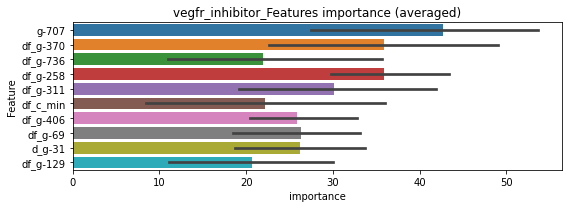

len(train_index) : 2349
len(valid_index) : 2350
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315053	valid_1's binary_logloss: 0.134741


len(train_index) : 2350
len(valid_index) : 2349


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00930642	valid_1's binary_logloss: 0.123047


================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330289	valid_1's binary_logloss: 0.120931
[200]	training's binary_logloss: 0.00714143	valid_1's binary_logloss: 0.104536


vegfr_inhibitor logloss: 0.11377233222572021


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00745297	valid_1's binary_logloss: 0.104494


vitamin_b , len(trt) : 26


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-707                             g-707   
1                       df_g-132                          df_g-132   
2                          g-581                             g-581   
3                        df_c-81                           df_c-81   
4                       df_g-109                          df_g-109   
5                       df_g-433                          df_g-433   
6                       df_g-663                          df_g-707   
7                       df_g-707                          df_g-663   
8                       df_g-519                          df_g-542   
9                       df_g-542                          df_g-519   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-707                      g-707   
1                          g-581                      g-581   
2                       df_g-132        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774509	valid_1's binary_logloss: 0.140157
[200]	training's binary_logloss: 0.0146354	valid_1's binary_logloss: 0.0520152
[300]	training's binary_logloss: 0.004802	valid_1's binary_logloss: 0.0285623
[400]	training's binary_logloss: 0.002489	valid_1's binary_logloss: 0.0208338
[500]	training's binary_logloss: 0.00175235	valid_1's binary_logloss: 0.0177564
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00157333	valid_1's binary_logloss: 0.0167647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800748	valid_1's binary_logloss: 0.140783
[200]	training's binary_logloss: 0.0150789	valid_1's binary_logloss: 0.053914
[300]	training's binary_logloss: 0.00479549	valid_1's binary_logloss: 0.0321861
[400]	training's binary_logloss: 0.00248618	valid_1's binary_logloss: 0.0242409
[500]	training's binary_logloss: 0.00174193	valid_1's 

1 / 3 AUC score:1.000
Threshold: 0.6339454956535507
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00342
p_label_rate: 0.00075 Vs.target_rate: 0.00117, Num_p_label: 3.0, conf_0:0.00342, conf_1:0.63395
threshold:0.63, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764523	valid_1's binary_logloss: 0.147044
[200]	training's binary_logloss: 0.0140562	valid_1's binary_logloss: 0.055078
[300]	training's binary_logloss: 0.00461261	valid_1's binary_logloss: 0.0321766
[400]	training's binary_logloss: 0.00243891	valid_1's binary_logloss: 0.0238737
[500]	training's binary_logloss: 0.00171637	valid_1's binary_logloss: 0.0206176
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00156795	valid_1's binary_logloss: 0.0194254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078049	valid_1's binary_logloss: 0.135483
[200]	training's binary_logloss: 0.0148728	valid_1's binary_logloss: 0.0502017
[300]	training's binary_logloss: 0.00483526	valid_1's binary_logloss: 0.0263945
[400]	training's binary_logloss: 0.00251589	valid_1's binary_logloss: 0.0191108
[500]	training's binary_logloss: 0.0017597	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.6339454956535507
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/996
30th percentile: 0.00323
p_label_rate: 0.00075 Vs.target_rate: 0.00117, Num_p_label: 3.0, conf_0:0.00323, conf_1:0.63395
threshold:0.63, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784339	valid_1's binary_logloss: 0.139509
[200]	training's binary_logloss: 0.0147435	valid_1's binary_logloss: 0.0510449
[300]	training's binary_logloss: 0.00473416	valid_1's binary_logloss: 0.0273126
[400]	training's binary_logloss: 0.00247161	valid_1's binary_logloss: 0.0200654
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00188019	valid_1's binary_logloss: 0.0173978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785608	valid_1's binary_logloss: 0.139415
[200]	training's binary_logloss: 0.0151634	valid_1's binary_logloss: 0.0520561
[300]	training's binary_logloss: 0.0048802	valid_1's binary_logloss: 0.0325756


3 / 3 AUC score:1.000
Threshold: 0.6339454956535507
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/992
30th percentile: 0.00496
p_label_rate: 0.00075 Vs.target_rate: 0.00117, Num_p_label: 3.0, conf_0:0.00496, conf_1:0.63395
threshold:0.63, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00296383	valid_1's binary_logloss: 0.0261479


positive y_label:497.0/4974, y_label_rate: 0.09992


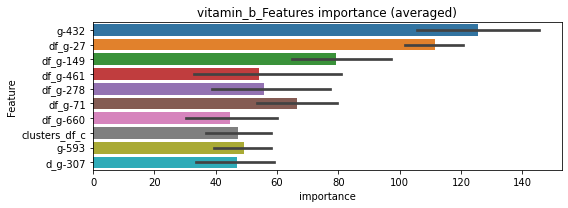

len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202735	valid_1's binary_logloss: 0.0316114
[200]	training's binary_logloss: 0.00272402	valid_1's binary_logloss: 0.00789927
[300]	training's binary_logloss: 0.000773022	valid_1's binary_logloss: 0.00350304
[400]	training's binary_logloss: 0.000396796	valid_1's binary_logloss: 0.00231126
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000318408	valid_1's binary_logloss: 0.00206085


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205316	valid_1's binary_logloss: 0.0350735
[200]	training's binary_logloss: 0.00276066	valid_1's binary_logloss: 0.0117051
[300]	training's binary_logloss: 0.000760713	valid_1's binary_logloss: 0.00759298
[400]	training's binary_logloss: 0.000393586	valid_1's binary_logloss: 0.00681126
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000361746	valid_1's binary_logloss: 0.00673514


vitamin_b logloss: 0.0043979914767162485
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103812	valid_1's binary_logloss: 0.188319
[200]	training's binary_logloss: 0.0229519	valid_1's binary_logloss: 0.0800168
[300]	training's binary_logloss: 0.00761218	valid_1's binary_logloss: 0.0472453
[400]	training's binary_logloss: 0.00383041	valid_1's binary_logloss: 0.0351015
[500]	training's binary_logloss: 0.00253297	valid_1's binary_logloss: 0.0288506
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00208571	valid_1's binary_logloss: 0.0263825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100221	valid_1's binary_logloss: 0.204316
[200]	training's binary_logloss: 0.0222376	valid_1's binary_logloss: 0.103342
[300]	training's binary_logloss: 0.00733656	valid_1's binary_logloss: 0.0707549
[400]	training's binary_logloss: 0.00362611	valid_1's binary_logloss: 0.0590293


1 / 3 AUC score:1.000
Threshold: 0.6628304684934078
Remove_noisy_labels: 8 → positive_corect_labels: 496/992


Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00273237	valid_1's binary_logloss: 0.0545604


30th percentile: 0.00988
p_label_rate: 0.00100 Vs.target_rate: 0.00174, Num_p_label: 4.0, conf_0:0.00988, conf_1:0.66283
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100332	valid_1's binary_logloss: 0.199158
[200]	training's binary_logloss: 0.0222925	valid_1's binary_logloss: 0.101871
[300]	training's binary_logloss: 0.00720963	valid_1's binary_logloss: 0.0689253
[400]	training's binary_logloss: 0.00361783	valid_1's binary_logloss: 0.055297
[500]	training's binary_logloss: 0.002383	valid_1's binary_logloss: 0.0491777
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00199	valid_1's binary_logloss: 0.0464628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102544	valid_1's binary_logloss: 0.197866
[200]	training's binary_logloss: 0.0226036	valid_1's binary_logloss: 0.0890125
[300]	training's binary_logloss: 0.0074642	valid_1's binary_logloss: 0.0559278
[400]	training's binary_logloss: 0.00373497	valid_1's binary_logloss: 0.0438661
[500]	training's binary_logloss: 0.00246913	valid_1's binar

2 / 3 AUC score:0.999
Threshold: 0.6628304684934078
Remove_noisy_labels: 11 → positive_corect_labels: 486.0/981
30th percentile: 0.00737
p_label_rate: 0.00100 Vs.target_rate: 0.00174, Num_p_label: 4.0, conf_0:0.00737, conf_1:0.66283
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:486.0/981, y_label_rate: 0.49541
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977223	valid_1's binary_logloss: 0.197695
[200]	training's binary_logloss: 0.0216371	valid_1's binary_logloss: 0.103702
[300]	training's binary_logloss: 0.00707282	valid_1's binary_logloss: 0.0713178
[400]	training's binary_logloss: 0.00355468	valid_1's binary_logloss: 0.0599792
[500]	training's binary_logloss: 0.0023557	valid_1's binary_logloss: 0.0530842
[600]	training's binary_logloss: 0.00187551	valid_1's binary_logloss: 0.0492646
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00185858	valid_1's binary_logloss: 0.0490411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982063	valid_1's binary_logloss: 0.190287
[200]	training's binary_logloss: 0.0212645	valid_1's binary_logloss: 0.0847237
[300]	training's binary_logloss: 0.00702357	valid_1's binary_logloss: 0.0515437
[400]	training's binary_logloss: 0.00358704	valid_1

3 / 3 AUC score:0.999
Threshold: 0.6628304684934078
Remove_noisy_labels: 10 → positive_corect_labels: 476.0/971
30th percentile: 0.00707
p_label_rate: 0.00176 Vs.target_rate: 0.00174, Num_p_label: 7.0, conf_0:0.00707, conf_1:0.66283
threshold:0.66, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:483.0/4953, y_label_rate: 0.09752


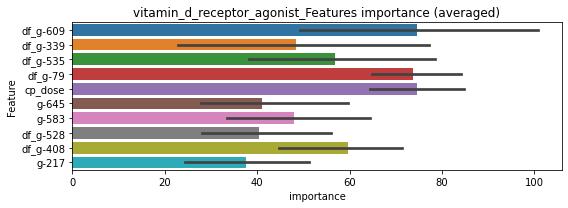

len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292728	valid_1's binary_logloss: 0.051653
[200]	training's binary_logloss: 0.0047019	valid_1's binary_logloss: 0.0206031
[300]	training's binary_logloss: 0.00125122	valid_1's binary_logloss: 0.014314
[400]	training's binary_logloss: 0.000586482	valid_1's binary_logloss: 0.0130715
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000586482	valid_1's binary_logloss: 0.0130715


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282872	valid_1's binary_logloss: 0.0581023
[200]	training's binary_logloss: 0.00469279	valid_1's binary_logloss: 0.0256667
[300]	training's binary_logloss: 0.00125333	valid_1's binary_logloss: 0.0188192
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00082768	valid_1's binary_logloss: 0.0171444


vitamin_d_receptor_agonist logloss: 0.015107567789210153
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835205	valid_1's binary_logloss: 0.150421
[200]	training's binary_logloss: 0.0167669	valid_1's binary_logloss: 0.0558291
[300]	training's binary_logloss: 0.00561203	valid_1's binary_logloss: 0.032241
[400]	training's binary_logloss: 0.00291168	valid_1's binary_logloss: 0.0227097
[500]	training's binary_logloss: 0.00197305	valid_1's binary_logloss: 0.0187008
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00167961	valid_1's binary_logloss: 0.0173067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819374	valid_1's binary_logloss: 0.151041
[200]	training's binary_logloss: 0.0157623	valid_1's binary_logloss: 0.0610076
[300]	training's binary_logloss: 0.00517371	valid_1's binary_logloss: 0.0375593
[400]	training's binary_logloss: 0.00273429	valid_1's binary_logloss: 0.0286311
[500]	training's binary_logloss: 0.00187338	valid_

1 / 3 AUC score:1.000
Threshold: 0.34750041830711975
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00460
p_label_rate: 0.00201 Vs.target_rate: 0.00135, Num_p_label: 8.0, conf_0:0.00460, conf_1:0.34750
threshold:0.35, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812231	valid_1's binary_logloss: 0.147526
[200]	training's binary_logloss: 0.0160824	valid_1's binary_logloss: 0.0561445
[300]	training's binary_logloss: 0.00530833	valid_1's binary_logloss: 0.0322784
[400]	training's binary_logloss: 0.00278526	valid_1's binary_logloss: 0.0243334
[500]	training's binary_logloss: 0.00191267	valid_1's binary_logloss: 0.0208566
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00165991	valid_1's binary_logloss: 0.0195732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817696	valid_1's binary_logloss: 0.144882
[200]	training's binary_logloss: 0.0164434	valid_1's binary_logloss: 0.0579216
[300]	training's binary_logloss: 0.00545588	valid_1's binary_logloss: 0.0320323
[400]	training's binary_logloss: 0.00285358	valid_1's binary_logloss: 0.0237937
[500]	training's binary_logloss: 0.00192967	valid

2 / 3 AUC score:1.000
Threshold: 0.34750041830711975
Remove_noisy_labels: 5 → positive_corect_labels: 497.0/991
30th percentile: 0.00486
p_label_rate: 0.00226 Vs.target_rate: 0.00135, Num_p_label: 9.0, conf_0:0.00486, conf_1:0.34750
threshold:0.35, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:497.0/991, y_label_rate: 0.50151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808355	valid_1's binary_logloss: 0.137469
[200]	training's binary_logloss: 0.0158636	valid_1's binary_logloss: 0.0474166
[300]	training's binary_logloss: 0.00525546	valid_1's binary_logloss: 0.0249307
[400]	training's binary_logloss: 0.00275558	valid_1's binary_logloss: 0.0178153
[500]	training's binary_logloss: 0.00188852	valid_1's binary_logloss: 0.0143016
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00163312	valid_1's binary_logloss: 0.0128223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078971	valid_1's binary_logloss: 0.137176
[200]	training's binary_logloss: 0.0152667	valid_1's binary_logloss: 0.050012
[300]	training's binary_logloss: 0.0050999	valid_1's binary_logloss: 0.0275769
[400]	training's binary_logloss: 0.00273042	valid_1's binary_logloss: 0.020257
[500]	training's binary_logloss: 0.00188659	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.34750041830711975
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/990
30th percentile: 0.00467
p_label_rate: 0.00427 Vs.target_rate: 0.00135, Num_p_label: 17.0, conf_0:0.00467, conf_1:0.38940
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_1: 0.35
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_2: 0.39
Num_p_label: 5.0, Expected: 5.4, Adj_threshold_3: 0.43
threshold:0.43, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:502.0/4972, y_label_rate: 0.10097


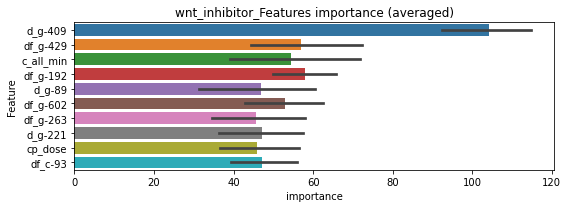

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240407	valid_1's binary_logloss: 0.0515308
[200]	training's binary_logloss: 0.00344692	valid_1's binary_logloss: 0.0229734
[300]	training's binary_logloss: 0.000931085	valid_1's binary_logloss: 0.0187097


len(train_index) : 2486


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000745904	valid_1's binary_logloss: 0.0182796


len(valid_index) : 2486
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250187	valid_1's binary_logloss: 0.0453672
[200]	training's binary_logloss: 0.00362329	valid_1's binary_logloss: 0.0185783
[300]	training's binary_logloss: 0.00097359	valid_1's binary_logloss: 0.013743
[400]	training's binary_logloss: 0.000475322	valid_1's binary_logloss: 0.0127527
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000491114	valid_1's binary_logloss: 0.0127261


wnt_inhibitor logloss: 0.015502847042278013


In [47]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    if DEBUG:
        if _score > 0.02:
            importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)
            print(importance_cols_df)
        
        feature_importance_df = create_featureimprotance(models, feature_importance_df)

In [48]:
sub.to_csv('submission.csv', index=False)

In [49]:
print(f"CV:{np.mean(scores)}")

CV:0.03488206486116383


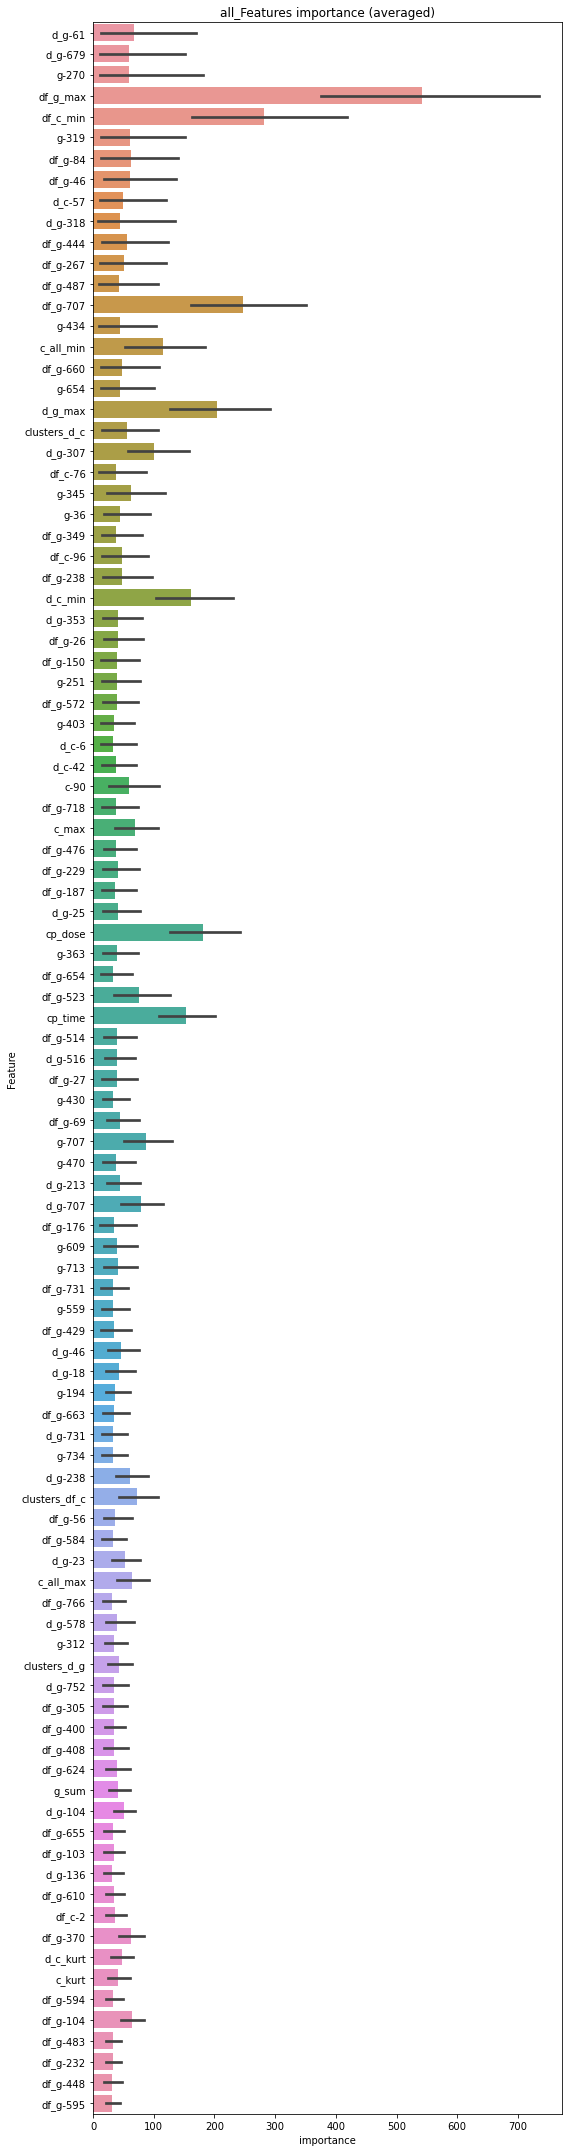

In [50]:
if DEBUG:
    show_feature_importance(feature_importance_df)
    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)